In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import torch.nn.utils.spectral_norm as spectral_norm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import torch
import os
from torchvision.utils import save_image
from tqdm import tqdm

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Directories
image_dir = "celebA/celeba/img_align_celeba"
os.makedirs("gan_outputs", exist_ok=True)

In [4]:
# Hyperparameters
z_dim = 100
lr = 2e-4
batch_size = 64
n_epochs = 50
patience = 10

In [5]:
# Transformations
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
# Dataset and splits
full_dataset = datasets.ImageFolder(root=image_dir, transform=transform)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size  # ensure the sum matches exactly

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=64):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Conv2d(img_channels, features_d, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(features_d, features_d * 2, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(features_d * 4, features_d * 8, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(features_d * 8, 1, 4, 1, 0)),
        )

    def forward(self, img):
        return self.net(img).view(-1)


In [8]:
# Initialize models and optimizers
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

In [10]:
best_val_loss = float("inf")
epochs_no_improve = 0
train_losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
    G.train()
    D.train()
    running_loss_G = 0.0
    running_loss_D = 0.0

    print(f"Epoch [{epoch+1}/{n_epochs}]")
    for real_imgs, _ in tqdm(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = G(z).detach()
        D_real = D(real_imgs)
        D_fake = D(fake_imgs)
        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = G(z)
        D_fake = D(fake_imgs)
        loss_G = criterion(D_fake, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        running_loss_D += loss_D.item()
        running_loss_G += loss_G.item()

    avg_train_loss_G = running_loss_G / len(train_loader)
    avg_train_loss_D = running_loss_D / len(train_loader)
    train_losses.append((avg_train_loss_D, avg_train_loss_G))

    # Validation step
    G.eval()
    D.eval()
    val_loss_D = 0.0
    val_loss_G = 0.0
    with torch.no_grad():
        for real_imgs, _ in val_loader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            # Discriminator validation
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_imgs = G(z)
            D_real = D(real_imgs)
            D_fake = D(fake_imgs)
            loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

            # Generator validation
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_imgs = G(z)
            D_fake = D(fake_imgs)
            loss_G = criterion(D_fake, real_labels)

            val_loss_D += loss_D.item()
            val_loss_G += loss_G.item()

    avg_val_loss_D = val_loss_D / len(val_loader)
    avg_val_loss_G = val_loss_G / len(val_loader)
    val_losses.append((avg_val_loss_D, avg_val_loss_G))

    print(f"Train Loss D: {avg_train_loss_D:.4f}, G: {avg_train_loss_G:.4f} | Val Loss D: {avg_val_loss_D:.4f}, G: {avg_val_loss_G:.4f}")

    # Early stopping check
    if  avg_val_loss_G < best_val_loss:
        best_val_loss = avg_val_loss_G
        epochs_no_improve = 0
        torch.save(G.state_dict(), "gan_outputs/best_generator.pth")
        torch.save(D.state_dict(), "gan_outputs/best_discriminator.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    # Save sample images
    with torch.no_grad():
        fake_imgs = G(fixed_noise).detach().cpu()
        grid = make_grid(fake_imgs, padding=2, normalize=True)
        save_image(grid, f"gan_outputs/epoch_{epoch+1}.png")

Epoch [1/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:02<2:02:50,  2.91s/it]

  0%|          | 3/2533 [00:03<34:41,  1.22it/s]  

  0%|          | 5/2533 [00:03<18:42,  2.25it/s]

  0%|          | 7/2533 [00:03<12:21,  3.40it/s]

  0%|          | 9/2533 [00:03<09:07,  4.61it/s]

  0%|          | 11/2533 [00:03<07:11,  5.85it/s]

  1%|          | 13/2533 [00:03<06:00,  6.99it/s]

  1%|          | 15/2533 [00:04<05:14,  8.00it/s]

  1%|          | 17/2533 [00:04<04:44,  8.84it/s]

  1%|          | 19/2533 [00:04<04:24,  9.52it/s]

  1%|          | 21/2533 [00:04<04:10, 10.05it/s]

  1%|          | 23/2533 [00:04<04:00, 10.43it/s]

  1%|          | 25/2533 [00:05<03:54, 10.71it/s]

  1%|          | 27/2533 [00:05<03:50, 10.87it/s]

  1%|          | 29/2533 [00:05<03:57, 10.54it/s]

  1%|          | 31/2533 [00:05<03:54, 10.66it/s]

  1%|▏         | 33/2533 [00:05<03:52, 10.75it/s]

  1%|▏         | 35/2533 [00:05<03:48, 10.94it/s]

  1%|▏         | 37/2533 [00:06<03:46, 11.00it/s]

  2%|▏         | 39/2533 [00:06<03:45, 11.07it/s]

  2%|▏         | 41/2533 [00:06<03:44, 11.12it/s]

  2%|▏         | 43/2533 [00:06<03:45, 11.03it/s]

  2%|▏         | 45/2533 [00:06<03:44, 11.10it/s]

  2%|▏         | 47/2533 [00:07<03:41, 11.21it/s]

  2%|▏         | 49/2533 [00:07<03:40, 11.29it/s]

  2%|▏         | 51/2533 [00:07<03:39, 11.32it/s]

  2%|▏         | 53/2533 [00:07<03:37, 11.40it/s]

  2%|▏         | 55/2533 [00:07<03:35, 11.48it/s]

  2%|▏         | 57/2533 [00:07<03:37, 11.40it/s]

  2%|▏         | 59/2533 [00:08<03:36, 11.44it/s]

  2%|▏         | 61/2533 [00:08<03:34, 11.51it/s]

  2%|▏         | 63/2533 [00:08<03:35, 11.48it/s]

  3%|▎         | 65/2533 [00:08<03:33, 11.54it/s]

  3%|▎         | 67/2533 [00:08<03:26, 11.94it/s]

  3%|▎         | 69/2533 [00:08<03:20, 12.28it/s]

  3%|▎         | 71/2533 [00:09<03:16, 12.53it/s]

  3%|▎         | 73/2533 [00:09<03:14, 12.64it/s]

  3%|▎         | 75/2533 [00:09<03:12, 12.75it/s]

  3%|▎         | 77/2533 [00:09<03:13, 12.72it/s]

  3%|▎         | 79/2533 [00:09<03:12, 12.73it/s]

  3%|▎         | 81/2533 [00:09<03:12, 12.71it/s]

  3%|▎         | 83/2533 [00:09<03:11, 12.78it/s]

  3%|▎         | 85/2533 [00:10<03:12, 12.72it/s]

  3%|▎         | 87/2533 [00:10<03:13, 12.67it/s]

  4%|▎         | 89/2533 [00:10<03:12, 12.68it/s]

  4%|▎         | 91/2533 [00:10<03:12, 12.71it/s]

  4%|▎         | 93/2533 [00:10<03:11, 12.76it/s]

  4%|▍         | 95/2533 [00:10<03:11, 12.74it/s]

  4%|▍         | 97/2533 [00:11<03:09, 12.82it/s]

  4%|▍         | 99/2533 [00:11<03:12, 12.66it/s]

  4%|▍         | 101/2533 [00:11<03:11, 12.73it/s]

  4%|▍         | 103/2533 [00:11<03:08, 12.88it/s]

  4%|▍         | 105/2533 [00:11<03:10, 12.76it/s]

  4%|▍         | 107/2533 [00:11<03:07, 12.91it/s]

  4%|▍         | 109/2533 [00:12<03:08, 12.86it/s]

  4%|▍         | 111/2533 [00:12<03:09, 12.76it/s]

  4%|▍         | 113/2533 [00:12<03:10, 12.73it/s]

  5%|▍         | 115/2533 [00:12<03:09, 12.75it/s]

  5%|▍         | 117/2533 [00:12<03:08, 12.80it/s]

  5%|▍         | 119/2533 [00:12<03:09, 12.75it/s]

  5%|▍         | 121/2533 [00:12<03:09, 12.76it/s]

  5%|▍         | 123/2533 [00:13<03:10, 12.64it/s]

  5%|▍         | 125/2533 [00:13<03:09, 12.67it/s]

  5%|▌         | 127/2533 [00:13<03:09, 12.71it/s]

  5%|▌         | 129/2533 [00:13<03:07, 12.82it/s]

  5%|▌         | 131/2533 [00:13<03:07, 12.78it/s]

  5%|▌         | 133/2533 [00:13<03:06, 12.90it/s]

  5%|▌         | 135/2533 [00:14<03:05, 12.91it/s]

  5%|▌         | 137/2533 [00:14<03:05, 12.91it/s]

  5%|▌         | 139/2533 [00:14<03:04, 12.94it/s]

  6%|▌         | 141/2533 [00:14<03:06, 12.80it/s]

  6%|▌         | 143/2533 [00:14<03:07, 12.76it/s]

  6%|▌         | 145/2533 [00:14<03:08, 12.70it/s]

  6%|▌         | 147/2533 [00:14<03:05, 12.83it/s]

  6%|▌         | 149/2533 [00:15<03:06, 12.79it/s]

  6%|▌         | 151/2533 [00:15<03:04, 12.90it/s]

  6%|▌         | 153/2533 [00:15<03:03, 12.94it/s]

  6%|▌         | 155/2533 [00:15<03:04, 12.89it/s]

  6%|▌         | 157/2533 [00:15<03:02, 12.99it/s]

  6%|▋         | 159/2533 [00:15<03:03, 12.95it/s]

  6%|▋         | 161/2533 [00:16<03:03, 12.91it/s]

  6%|▋         | 163/2533 [00:16<03:04, 12.81it/s]

  7%|▋         | 165/2533 [00:16<03:05, 12.76it/s]

  7%|▋         | 167/2533 [00:16<03:05, 12.76it/s]

  7%|▋         | 169/2533 [00:16<03:03, 12.85it/s]

  7%|▋         | 171/2533 [00:16<03:02, 12.93it/s]

  7%|▋         | 173/2533 [00:16<03:02, 12.91it/s]

  7%|▋         | 175/2533 [00:17<03:03, 12.87it/s]

  7%|▋         | 177/2533 [00:17<03:02, 12.93it/s]

  7%|▋         | 179/2533 [00:17<03:01, 13.00it/s]

  7%|▋         | 181/2533 [00:17<03:01, 12.98it/s]

  7%|▋         | 183/2533 [00:17<02:59, 13.06it/s]

  7%|▋         | 185/2533 [00:17<03:00, 13.02it/s]

  7%|▋         | 187/2533 [00:18<03:00, 13.03it/s]

  7%|▋         | 189/2533 [00:18<02:59, 13.04it/s]

  8%|▊         | 191/2533 [00:18<03:01, 12.93it/s]

  8%|▊         | 193/2533 [00:18<02:59, 13.02it/s]

  8%|▊         | 195/2533 [00:18<02:59, 12.99it/s]

  8%|▊         | 197/2533 [00:18<03:00, 12.93it/s]

  8%|▊         | 199/2533 [00:18<02:59, 13.03it/s]

  8%|▊         | 201/2533 [00:19<02:59, 12.98it/s]

  8%|▊         | 203/2533 [00:19<02:59, 12.95it/s]

  8%|▊         | 205/2533 [00:19<03:00, 12.93it/s]

  8%|▊         | 207/2533 [00:19<03:01, 12.79it/s]

  8%|▊         | 209/2533 [00:19<03:02, 12.75it/s]

  8%|▊         | 211/2533 [00:19<03:01, 12.76it/s]

  8%|▊         | 213/2533 [00:20<03:01, 12.75it/s]

  8%|▊         | 215/2533 [00:20<03:02, 12.70it/s]

  9%|▊         | 217/2533 [00:20<03:00, 12.84it/s]

  9%|▊         | 219/2533 [00:20<02:59, 12.86it/s]

  9%|▊         | 221/2533 [00:20<03:00, 12.82it/s]

  9%|▉         | 223/2533 [00:20<03:01, 12.76it/s]

  9%|▉         | 225/2533 [00:21<02:59, 12.85it/s]

  9%|▉         | 227/2533 [00:21<02:58, 12.94it/s]

  9%|▉         | 229/2533 [00:21<02:59, 12.84it/s]

  9%|▉         | 231/2533 [00:21<02:59, 12.80it/s]

  9%|▉         | 233/2533 [00:21<02:59, 12.83it/s]

  9%|▉         | 235/2533 [00:21<03:00, 12.75it/s]

  9%|▉         | 237/2533 [00:21<03:00, 12.70it/s]

  9%|▉         | 239/2533 [00:22<03:00, 12.71it/s]

 10%|▉         | 241/2533 [00:22<02:58, 12.85it/s]

 10%|▉         | 243/2533 [00:22<02:59, 12.73it/s]

 10%|▉         | 245/2533 [00:22<02:59, 12.77it/s]

 10%|▉         | 247/2533 [00:22<03:00, 12.67it/s]

 10%|▉         | 249/2533 [00:22<03:02, 12.50it/s]

 10%|▉         | 251/2533 [00:23<03:01, 12.55it/s]

 10%|▉         | 253/2533 [00:23<03:00, 12.64it/s]

 10%|█         | 255/2533 [00:23<02:58, 12.74it/s]

 10%|█         | 257/2533 [00:23<02:59, 12.70it/s]

 10%|█         | 259/2533 [00:23<02:58, 12.74it/s]

 10%|█         | 261/2533 [00:23<02:58, 12.71it/s]

 10%|█         | 263/2533 [00:24<02:57, 12.80it/s]

 10%|█         | 265/2533 [00:24<02:56, 12.83it/s]

 11%|█         | 267/2533 [00:24<02:55, 12.92it/s]

 11%|█         | 269/2533 [00:24<02:55, 12.89it/s]

 11%|█         | 271/2533 [00:24<02:54, 12.99it/s]

 11%|█         | 273/2533 [00:24<02:53, 13.01it/s]

 11%|█         | 275/2533 [00:24<02:55, 12.90it/s]

 11%|█         | 277/2533 [00:25<02:53, 12.98it/s]

 11%|█         | 279/2533 [00:25<02:52, 13.05it/s]

 11%|█         | 281/2533 [00:25<02:51, 13.13it/s]

 11%|█         | 283/2533 [00:25<02:51, 13.14it/s]

 11%|█▏        | 285/2533 [00:25<02:50, 13.15it/s]

 11%|█▏        | 287/2533 [00:25<02:51, 13.11it/s]

 11%|█▏        | 289/2533 [00:25<02:50, 13.16it/s]

 11%|█▏        | 291/2533 [00:26<02:51, 13.10it/s]

 12%|█▏        | 293/2533 [00:26<02:52, 12.99it/s]

 12%|█▏        | 295/2533 [00:26<02:53, 12.88it/s]

 12%|█▏        | 297/2533 [00:26<02:54, 12.81it/s]

 12%|█▏        | 299/2533 [00:26<02:55, 12.72it/s]

 12%|█▏        | 301/2533 [00:26<02:53, 12.84it/s]

 12%|█▏        | 303/2533 [00:27<02:53, 12.85it/s]

 12%|█▏        | 305/2533 [00:27<02:54, 12.80it/s]

 12%|█▏        | 307/2533 [00:27<02:53, 12.85it/s]

 12%|█▏        | 309/2533 [00:27<02:54, 12.75it/s]

 12%|█▏        | 311/2533 [00:27<02:54, 12.74it/s]

 12%|█▏        | 313/2533 [00:27<02:55, 12.67it/s]

 12%|█▏        | 315/2533 [00:28<02:54, 12.70it/s]

 13%|█▎        | 317/2533 [00:28<02:53, 12.74it/s]

 13%|█▎        | 319/2533 [00:28<02:53, 12.76it/s]

 13%|█▎        | 321/2533 [00:28<02:51, 12.88it/s]

 13%|█▎        | 323/2533 [00:28<02:52, 12.80it/s]

 13%|█▎        | 325/2533 [00:28<02:53, 12.72it/s]

 13%|█▎        | 327/2533 [00:28<02:52, 12.82it/s]

 13%|█▎        | 329/2533 [00:29<02:51, 12.84it/s]

 13%|█▎        | 331/2533 [00:29<02:51, 12.82it/s]

 13%|█▎        | 333/2533 [00:29<02:50, 12.88it/s]

 13%|█▎        | 335/2533 [00:29<02:50, 12.90it/s]

 13%|█▎        | 337/2533 [00:29<02:49, 12.95it/s]

 13%|█▎        | 339/2533 [00:29<02:48, 13.00it/s]

 13%|█▎        | 341/2533 [00:30<02:50, 12.89it/s]

 14%|█▎        | 343/2533 [00:30<02:53, 12.60it/s]

 14%|█▎        | 345/2533 [00:30<02:52, 12.69it/s]

 14%|█▎        | 347/2533 [00:30<02:51, 12.73it/s]

 14%|█▍        | 349/2533 [00:30<02:51, 12.76it/s]

 14%|█▍        | 351/2533 [00:30<02:51, 12.71it/s]

 14%|█▍        | 353/2533 [00:31<02:51, 12.71it/s]

 14%|█▍        | 355/2533 [00:31<02:49, 12.83it/s]

 14%|█▍        | 357/2533 [00:31<02:49, 12.82it/s]

 14%|█▍        | 359/2533 [00:31<02:49, 12.81it/s]

 14%|█▍        | 361/2533 [00:31<02:48, 12.88it/s]

 14%|█▍        | 363/2533 [00:31<02:47, 12.92it/s]

 14%|█▍        | 365/2533 [00:31<02:47, 12.91it/s]

 14%|█▍        | 367/2533 [00:32<02:48, 12.86it/s]

 15%|█▍        | 369/2533 [00:32<02:48, 12.86it/s]

 15%|█▍        | 371/2533 [00:32<02:48, 12.82it/s]

 15%|█▍        | 373/2533 [00:32<02:48, 12.83it/s]

 15%|█▍        | 375/2533 [00:32<02:47, 12.87it/s]

 15%|█▍        | 377/2533 [00:32<02:46, 12.94it/s]

 15%|█▍        | 379/2533 [00:33<02:46, 12.92it/s]

 15%|█▌        | 381/2533 [00:33<02:48, 12.80it/s]

 15%|█▌        | 383/2533 [00:33<02:48, 12.76it/s]

 15%|█▌        | 385/2533 [00:33<02:47, 12.86it/s]

 15%|█▌        | 387/2533 [00:33<02:47, 12.80it/s]

 15%|█▌        | 389/2533 [00:33<02:47, 12.84it/s]

 15%|█▌        | 391/2533 [00:33<02:47, 12.77it/s]

 16%|█▌        | 393/2533 [00:34<02:47, 12.76it/s]

 16%|█▌        | 395/2533 [00:34<02:48, 12.72it/s]

 16%|█▌        | 397/2533 [00:34<02:47, 12.79it/s]

 16%|█▌        | 399/2533 [00:34<02:47, 12.75it/s]

 16%|█▌        | 401/2533 [00:34<02:46, 12.81it/s]

 16%|█▌        | 403/2533 [00:34<02:46, 12.80it/s]

 16%|█▌        | 405/2533 [00:35<02:46, 12.80it/s]

 16%|█▌        | 407/2533 [00:35<02:47, 12.68it/s]

 16%|█▌        | 409/2533 [00:35<02:55, 12.13it/s]

 16%|█▌        | 411/2533 [00:35<02:52, 12.29it/s]

 16%|█▋        | 413/2533 [00:35<02:51, 12.36it/s]

 16%|█▋        | 415/2533 [00:35<02:49, 12.50it/s]

 16%|█▋        | 417/2533 [00:36<02:47, 12.60it/s]

 17%|█▋        | 419/2533 [00:36<02:48, 12.57it/s]

 17%|█▋        | 421/2533 [00:36<02:46, 12.70it/s]

 17%|█▋        | 423/2533 [00:36<02:44, 12.79it/s]

 17%|█▋        | 425/2533 [00:36<02:44, 12.82it/s]

 17%|█▋        | 427/2533 [00:36<02:45, 12.74it/s]

 17%|█▋        | 429/2533 [00:36<02:43, 12.84it/s]

 17%|█▋        | 431/2533 [00:37<02:44, 12.78it/s]

 17%|█▋        | 433/2533 [00:37<02:43, 12.83it/s]

 17%|█▋        | 435/2533 [00:37<02:43, 12.86it/s]

 17%|█▋        | 437/2533 [00:37<02:44, 12.73it/s]

 17%|█▋        | 439/2533 [00:37<02:44, 12.73it/s]

 17%|█▋        | 441/2533 [00:37<02:42, 12.85it/s]

 17%|█▋        | 443/2533 [00:38<02:43, 12.80it/s]

 18%|█▊        | 445/2533 [00:38<02:44, 12.66it/s]

 18%|█▊        | 447/2533 [00:38<02:44, 12.69it/s]

 18%|█▊        | 449/2533 [00:38<02:43, 12.76it/s]

 18%|█▊        | 451/2533 [00:38<02:42, 12.77it/s]

 18%|█▊        | 453/2533 [00:38<02:43, 12.69it/s]

 18%|█▊        | 455/2533 [00:39<02:42, 12.77it/s]

 18%|█▊        | 457/2533 [00:39<02:42, 12.77it/s]

 18%|█▊        | 459/2533 [00:39<02:42, 12.74it/s]

 18%|█▊        | 461/2533 [00:39<02:42, 12.76it/s]

 18%|█▊        | 463/2533 [00:39<02:42, 12.73it/s]

 18%|█▊        | 465/2533 [00:39<02:43, 12.68it/s]

 18%|█▊        | 467/2533 [00:39<02:42, 12.73it/s]

 19%|█▊        | 469/2533 [00:40<02:41, 12.74it/s]

 19%|█▊        | 471/2533 [00:40<02:41, 12.74it/s]

 19%|█▊        | 473/2533 [00:40<02:41, 12.73it/s]

 19%|█▉        | 475/2533 [00:40<02:42, 12.63it/s]

 19%|█▉        | 477/2533 [00:40<02:42, 12.64it/s]

 19%|█▉        | 479/2533 [00:40<02:42, 12.62it/s]

 19%|█▉        | 481/2533 [00:41<02:43, 12.59it/s]

 19%|█▉        | 483/2533 [00:41<02:42, 12.62it/s]

 19%|█▉        | 485/2533 [00:41<02:43, 12.54it/s]

 19%|█▉        | 487/2533 [00:41<02:43, 12.52it/s]

 19%|█▉        | 489/2533 [00:41<02:42, 12.57it/s]

 19%|█▉        | 491/2533 [00:41<02:42, 12.60it/s]

 19%|█▉        | 493/2533 [00:42<02:41, 12.60it/s]

 20%|█▉        | 495/2533 [00:42<02:40, 12.69it/s]

 20%|█▉        | 497/2533 [00:42<02:40, 12.68it/s]

 20%|█▉        | 499/2533 [00:42<02:41, 12.62it/s]

 20%|█▉        | 501/2533 [00:42<02:41, 12.62it/s]

 20%|█▉        | 503/2533 [00:42<02:41, 12.58it/s]

 20%|█▉        | 505/2533 [00:42<02:40, 12.63it/s]

 20%|██        | 507/2533 [00:43<02:39, 12.70it/s]

 20%|██        | 509/2533 [00:43<02:39, 12.69it/s]

 20%|██        | 511/2533 [00:43<02:39, 12.68it/s]

 20%|██        | 513/2533 [00:43<02:39, 12.63it/s]

 20%|██        | 515/2533 [00:43<02:39, 12.67it/s]

 20%|██        | 517/2533 [00:43<02:37, 12.77it/s]

 20%|██        | 519/2533 [00:44<02:37, 12.80it/s]

 21%|██        | 521/2533 [00:44<02:37, 12.81it/s]

 21%|██        | 523/2533 [00:44<02:36, 12.83it/s]

 21%|██        | 525/2533 [00:44<02:35, 12.88it/s]

 21%|██        | 527/2533 [00:44<02:35, 12.88it/s]

 21%|██        | 529/2533 [00:44<02:35, 12.85it/s]

 21%|██        | 531/2533 [00:44<02:35, 12.89it/s]

 21%|██        | 533/2533 [00:45<02:35, 12.85it/s]

 21%|██        | 535/2533 [00:45<02:35, 12.87it/s]

 21%|██        | 537/2533 [00:45<02:35, 12.84it/s]

 21%|██▏       | 539/2533 [00:45<02:35, 12.79it/s]

 21%|██▏       | 541/2533 [00:45<02:35, 12.78it/s]

 21%|██▏       | 543/2533 [00:45<02:36, 12.75it/s]

 22%|██▏       | 545/2533 [00:46<02:35, 12.78it/s]

 22%|██▏       | 547/2533 [00:46<02:34, 12.83it/s]

 22%|██▏       | 549/2533 [00:46<02:35, 12.75it/s]

 22%|██▏       | 551/2533 [00:46<02:35, 12.74it/s]

 22%|██▏       | 553/2533 [00:46<02:37, 12.56it/s]

 22%|██▏       | 555/2533 [00:46<02:36, 12.61it/s]

 22%|██▏       | 557/2533 [00:47<02:36, 12.61it/s]

 22%|██▏       | 559/2533 [00:47<02:36, 12.61it/s]

 22%|██▏       | 561/2533 [00:47<02:37, 12.49it/s]

 22%|██▏       | 563/2533 [00:47<02:40, 12.25it/s]

 22%|██▏       | 565/2533 [00:47<02:38, 12.44it/s]

 22%|██▏       | 567/2533 [00:47<02:37, 12.52it/s]

 22%|██▏       | 569/2533 [00:47<02:35, 12.59it/s]

 23%|██▎       | 571/2533 [00:48<02:35, 12.59it/s]

 23%|██▎       | 573/2533 [00:48<02:34, 12.68it/s]

 23%|██▎       | 575/2533 [00:48<02:34, 12.70it/s]

 23%|██▎       | 577/2533 [00:48<02:33, 12.71it/s]

 23%|██▎       | 579/2533 [00:48<02:34, 12.68it/s]

 23%|██▎       | 581/2533 [00:48<02:33, 12.69it/s]

 23%|██▎       | 583/2533 [00:49<02:32, 12.82it/s]

 23%|██▎       | 585/2533 [00:49<02:32, 12.81it/s]

 23%|██▎       | 587/2533 [00:49<02:32, 12.80it/s]

 23%|██▎       | 589/2533 [00:49<02:32, 12.78it/s]

 23%|██▎       | 591/2533 [00:49<02:32, 12.75it/s]

 23%|██▎       | 593/2533 [00:49<02:32, 12.75it/s]

 23%|██▎       | 595/2533 [00:50<02:32, 12.72it/s]

 24%|██▎       | 597/2533 [00:50<02:31, 12.75it/s]

 24%|██▎       | 599/2533 [00:50<02:33, 12.62it/s]

 24%|██▎       | 601/2533 [00:50<02:32, 12.65it/s]

 24%|██▍       | 603/2533 [00:50<02:32, 12.63it/s]

 24%|██▍       | 605/2533 [00:50<02:33, 12.58it/s]

 24%|██▍       | 607/2533 [00:50<02:33, 12.58it/s]

 24%|██▍       | 609/2533 [00:51<02:33, 12.53it/s]

 24%|██▍       | 611/2533 [00:51<02:32, 12.61it/s]

 24%|██▍       | 613/2533 [00:51<02:31, 12.69it/s]

 24%|██▍       | 615/2533 [00:51<02:30, 12.73it/s]

 24%|██▍       | 617/2533 [00:51<02:30, 12.74it/s]

 24%|██▍       | 619/2533 [00:51<02:29, 12.78it/s]

 25%|██▍       | 621/2533 [00:52<02:29, 12.81it/s]

 25%|██▍       | 623/2533 [00:52<02:29, 12.76it/s]

 25%|██▍       | 625/2533 [00:52<02:29, 12.80it/s]

 25%|██▍       | 627/2533 [00:52<02:28, 12.85it/s]

 25%|██▍       | 629/2533 [00:52<02:27, 12.91it/s]

 25%|██▍       | 631/2533 [00:52<02:28, 12.79it/s]

 25%|██▍       | 633/2533 [00:53<02:30, 12.66it/s]

 25%|██▌       | 635/2533 [00:53<02:32, 12.45it/s]

 25%|██▌       | 637/2533 [00:53<02:31, 12.48it/s]

 25%|██▌       | 639/2533 [00:53<02:30, 12.61it/s]

 25%|██▌       | 641/2533 [00:53<02:30, 12.57it/s]

 25%|██▌       | 643/2533 [00:53<02:29, 12.66it/s]

 25%|██▌       | 645/2533 [00:53<02:30, 12.56it/s]

 26%|██▌       | 647/2533 [00:54<02:29, 12.60it/s]

 26%|██▌       | 649/2533 [00:54<02:28, 12.72it/s]

 26%|██▌       | 651/2533 [00:54<02:27, 12.72it/s]

 26%|██▌       | 653/2533 [00:54<02:28, 12.64it/s]

 26%|██▌       | 655/2533 [00:54<02:28, 12.66it/s]

 26%|██▌       | 657/2533 [00:54<02:28, 12.67it/s]

 26%|██▌       | 659/2533 [00:55<02:27, 12.70it/s]

 26%|██▌       | 661/2533 [00:55<02:27, 12.68it/s]

 26%|██▌       | 663/2533 [00:55<02:26, 12.77it/s]

 26%|██▋       | 665/2533 [00:55<02:26, 12.71it/s]

 26%|██▋       | 667/2533 [00:55<02:26, 12.72it/s]

 26%|██▋       | 669/2533 [00:55<02:25, 12.80it/s]

 26%|██▋       | 671/2533 [00:56<02:25, 12.80it/s]

 27%|██▋       | 673/2533 [00:56<02:24, 12.84it/s]

 27%|██▋       | 675/2533 [00:56<02:24, 12.84it/s]

 27%|██▋       | 677/2533 [00:56<02:25, 12.79it/s]

 27%|██▋       | 679/2533 [00:56<02:25, 12.76it/s]

 27%|██▋       | 681/2533 [00:56<02:24, 12.83it/s]

 27%|██▋       | 683/2533 [00:56<02:24, 12.78it/s]

 27%|██▋       | 685/2533 [00:57<02:25, 12.74it/s]

 27%|██▋       | 687/2533 [00:57<02:24, 12.78it/s]

 27%|██▋       | 689/2533 [00:57<02:24, 12.80it/s]

 27%|██▋       | 691/2533 [00:57<02:23, 12.80it/s]

 27%|██▋       | 693/2533 [00:57<02:24, 12.78it/s]

 27%|██▋       | 695/2533 [00:57<02:24, 12.74it/s]

 28%|██▊       | 697/2533 [00:58<02:23, 12.81it/s]

 28%|██▊       | 699/2533 [00:58<02:23, 12.77it/s]

 28%|██▊       | 701/2533 [00:58<02:22, 12.88it/s]

 28%|██▊       | 703/2533 [00:58<02:22, 12.80it/s]

 28%|██▊       | 705/2533 [00:58<02:22, 12.80it/s]

 28%|██▊       | 707/2533 [00:58<02:23, 12.70it/s]

 28%|██▊       | 709/2533 [00:59<02:24, 12.61it/s]

 28%|██▊       | 711/2533 [00:59<02:25, 12.55it/s]

 28%|██▊       | 713/2533 [00:59<02:23, 12.65it/s]

 28%|██▊       | 715/2533 [00:59<02:23, 12.71it/s]

 28%|██▊       | 717/2533 [00:59<02:23, 12.67it/s]

 28%|██▊       | 719/2533 [00:59<02:23, 12.61it/s]

 28%|██▊       | 721/2533 [00:59<02:23, 12.62it/s]

 29%|██▊       | 723/2533 [01:00<02:23, 12.58it/s]

 29%|██▊       | 725/2533 [01:00<02:28, 12.14it/s]

 29%|██▊       | 727/2533 [01:00<02:26, 12.33it/s]

 29%|██▉       | 729/2533 [01:00<02:24, 12.45it/s]

 29%|██▉       | 731/2533 [01:00<02:22, 12.64it/s]

 29%|██▉       | 733/2533 [01:00<02:22, 12.67it/s]

 29%|██▉       | 735/2533 [01:01<02:22, 12.64it/s]

 29%|██▉       | 737/2533 [01:01<02:21, 12.66it/s]

 29%|██▉       | 739/2533 [01:01<02:20, 12.77it/s]

 29%|██▉       | 741/2533 [01:01<02:20, 12.75it/s]

 29%|██▉       | 743/2533 [01:01<02:19, 12.80it/s]

 29%|██▉       | 745/2533 [01:01<02:19, 12.86it/s]

 29%|██▉       | 747/2533 [01:02<02:18, 12.91it/s]

 30%|██▉       | 749/2533 [01:02<02:17, 12.93it/s]

 30%|██▉       | 751/2533 [01:02<02:17, 12.99it/s]

 30%|██▉       | 753/2533 [01:02<02:17, 12.96it/s]

 30%|██▉       | 755/2533 [01:02<02:16, 13.00it/s]

 30%|██▉       | 757/2533 [01:02<02:18, 12.85it/s]

 30%|██▉       | 759/2533 [01:02<02:18, 12.82it/s]

 30%|███       | 761/2533 [01:03<02:17, 12.90it/s]

 30%|███       | 763/2533 [01:03<02:17, 12.86it/s]

 30%|███       | 765/2533 [01:03<02:16, 12.99it/s]

 30%|███       | 767/2533 [01:03<02:15, 13.02it/s]

 30%|███       | 769/2533 [01:03<02:15, 13.06it/s]

 30%|███       | 771/2533 [01:03<02:15, 13.04it/s]

 31%|███       | 773/2533 [01:04<02:16, 12.91it/s]

 31%|███       | 775/2533 [01:04<02:15, 13.01it/s]

 31%|███       | 777/2533 [01:04<02:15, 12.97it/s]

 31%|███       | 779/2533 [01:04<02:15, 12.95it/s]

 31%|███       | 781/2533 [01:04<02:15, 12.97it/s]

 31%|███       | 783/2533 [01:04<02:13, 13.06it/s]

 31%|███       | 785/2533 [01:04<02:14, 13.01it/s]

 31%|███       | 787/2533 [01:05<02:14, 12.99it/s]

 31%|███       | 789/2533 [01:05<02:13, 13.03it/s]

 31%|███       | 791/2533 [01:05<02:20, 12.43it/s]

 31%|███▏      | 793/2533 [01:05<02:18, 12.59it/s]

 31%|███▏      | 795/2533 [01:05<02:17, 12.68it/s]

 31%|███▏      | 797/2533 [01:05<02:16, 12.76it/s]

 32%|███▏      | 799/2533 [01:06<02:15, 12.82it/s]

 32%|███▏      | 801/2533 [01:06<02:14, 12.83it/s]

 32%|███▏      | 803/2533 [01:06<02:13, 12.94it/s]

 32%|███▏      | 805/2533 [01:06<02:12, 13.03it/s]

 32%|███▏      | 807/2533 [01:06<02:12, 13.00it/s]

 32%|███▏      | 809/2533 [01:06<02:12, 13.05it/s]

 32%|███▏      | 811/2533 [01:06<02:11, 13.05it/s]

 32%|███▏      | 813/2533 [01:07<02:12, 13.00it/s]

 32%|███▏      | 815/2533 [01:07<02:13, 12.84it/s]

 32%|███▏      | 817/2533 [01:07<02:13, 12.84it/s]

 32%|███▏      | 819/2533 [01:07<02:13, 12.81it/s]

 32%|███▏      | 821/2533 [01:07<02:13, 12.79it/s]

 32%|███▏      | 823/2533 [01:07<02:13, 12.78it/s]

 33%|███▎      | 825/2533 [01:08<02:13, 12.80it/s]

 33%|███▎      | 827/2533 [01:08<02:13, 12.80it/s]

 33%|███▎      | 829/2533 [01:08<02:12, 12.88it/s]

 33%|███▎      | 831/2533 [01:08<02:11, 12.99it/s]

 33%|███▎      | 833/2533 [01:08<02:11, 12.89it/s]

 33%|███▎      | 835/2533 [01:08<02:13, 12.75it/s]

 33%|███▎      | 837/2533 [01:08<02:13, 12.71it/s]

 33%|███▎      | 839/2533 [01:09<02:12, 12.74it/s]

 33%|███▎      | 841/2533 [01:09<02:11, 12.85it/s]

 33%|███▎      | 843/2533 [01:09<02:11, 12.87it/s]

 33%|███▎      | 845/2533 [01:09<02:10, 12.97it/s]

 33%|███▎      | 847/2533 [01:09<02:11, 12.85it/s]

 34%|███▎      | 849/2533 [01:09<02:11, 12.82it/s]

 34%|███▎      | 851/2533 [01:10<02:11, 12.82it/s]

 34%|███▎      | 853/2533 [01:10<02:11, 12.80it/s]

 34%|███▍      | 855/2533 [01:10<02:09, 12.95it/s]

 34%|███▍      | 857/2533 [01:10<02:10, 12.85it/s]

 34%|███▍      | 859/2533 [01:10<02:10, 12.80it/s]

 34%|███▍      | 861/2533 [01:10<02:10, 12.81it/s]

 34%|███▍      | 863/2533 [01:11<02:10, 12.77it/s]

 34%|███▍      | 865/2533 [01:11<02:11, 12.71it/s]

 34%|███▍      | 867/2533 [01:11<02:10, 12.75it/s]

 34%|███▍      | 869/2533 [01:11<02:11, 12.66it/s]

 34%|███▍      | 871/2533 [01:11<02:11, 12.61it/s]

 34%|███▍      | 873/2533 [01:11<02:12, 12.57it/s]

 35%|███▍      | 875/2533 [01:11<02:11, 12.57it/s]

 35%|███▍      | 877/2533 [01:12<02:12, 12.50it/s]

 35%|███▍      | 879/2533 [01:12<02:11, 12.58it/s]

 35%|███▍      | 881/2533 [01:12<02:10, 12.63it/s]

 35%|███▍      | 883/2533 [01:12<02:10, 12.64it/s]

 35%|███▍      | 885/2533 [01:12<02:09, 12.71it/s]

 35%|███▌      | 887/2533 [01:12<02:09, 12.75it/s]

 35%|███▌      | 889/2533 [01:13<02:12, 12.39it/s]

 35%|███▌      | 891/2533 [01:13<02:11, 12.50it/s]

 35%|███▌      | 893/2533 [01:13<02:10, 12.61it/s]

 35%|███▌      | 895/2533 [01:13<02:08, 12.77it/s]

 35%|███▌      | 897/2533 [01:13<02:08, 12.71it/s]

 35%|███▌      | 899/2533 [01:13<02:08, 12.68it/s]

 36%|███▌      | 901/2533 [01:14<02:07, 12.80it/s]

 36%|███▌      | 903/2533 [01:14<02:07, 12.80it/s]

 36%|███▌      | 905/2533 [01:14<02:07, 12.80it/s]

 36%|███▌      | 907/2533 [01:14<02:06, 12.82it/s]

 36%|███▌      | 909/2533 [01:14<02:07, 12.74it/s]

 36%|███▌      | 911/2533 [01:14<02:07, 12.71it/s]

 36%|███▌      | 913/2533 [01:14<02:06, 12.84it/s]

 36%|███▌      | 915/2533 [01:15<02:05, 12.87it/s]

 36%|███▌      | 917/2533 [01:15<02:05, 12.85it/s]

 36%|███▋      | 919/2533 [01:15<02:06, 12.77it/s]

 36%|███▋      | 921/2533 [01:15<02:06, 12.75it/s]

 36%|███▋      | 923/2533 [01:15<02:06, 12.71it/s]

 37%|███▋      | 925/2533 [01:15<02:06, 12.73it/s]

 37%|███▋      | 927/2533 [01:16<02:05, 12.78it/s]

 37%|███▋      | 929/2533 [01:16<02:04, 12.87it/s]

 37%|███▋      | 931/2533 [01:16<02:04, 12.85it/s]

 37%|███▋      | 933/2533 [01:16<02:04, 12.90it/s]

 37%|███▋      | 935/2533 [01:16<02:03, 12.92it/s]

 37%|███▋      | 937/2533 [01:16<02:03, 12.88it/s]

 37%|███▋      | 939/2533 [01:16<02:04, 12.85it/s]

 37%|███▋      | 941/2533 [01:17<02:04, 12.79it/s]

 37%|███▋      | 943/2533 [01:17<02:04, 12.82it/s]

 37%|███▋      | 945/2533 [01:17<02:04, 12.72it/s]

 37%|███▋      | 947/2533 [01:17<02:03, 12.84it/s]

 37%|███▋      | 949/2533 [01:17<02:03, 12.86it/s]

 38%|███▊      | 951/2533 [01:17<02:03, 12.83it/s]

 38%|███▊      | 953/2533 [01:18<02:02, 12.89it/s]

 38%|███▊      | 955/2533 [01:18<02:02, 12.89it/s]

 38%|███▊      | 957/2533 [01:18<02:02, 12.88it/s]

 38%|███▊      | 959/2533 [01:18<02:02, 12.84it/s]

 38%|███▊      | 961/2533 [01:18<02:03, 12.75it/s]

 38%|███▊      | 963/2533 [01:18<02:03, 12.72it/s]

 38%|███▊      | 965/2533 [01:19<02:02, 12.78it/s]

 38%|███▊      | 967/2533 [01:19<02:01, 12.85it/s]

 38%|███▊      | 969/2533 [01:19<02:01, 12.84it/s]

 38%|███▊      | 971/2533 [01:19<02:01, 12.90it/s]

 38%|███▊      | 973/2533 [01:19<02:00, 12.93it/s]

 38%|███▊      | 975/2533 [01:19<02:00, 12.90it/s]

 39%|███▊      | 977/2533 [01:19<02:01, 12.83it/s]

 39%|███▊      | 979/2533 [01:20<02:01, 12.76it/s]

 39%|███▊      | 981/2533 [01:20<02:00, 12.83it/s]

 39%|███▉      | 983/2533 [01:20<02:00, 12.87it/s]

 39%|███▉      | 985/2533 [01:20<02:00, 12.88it/s]

 39%|███▉      | 987/2533 [01:20<01:59, 12.94it/s]

 39%|███▉      | 989/2533 [01:20<01:59, 12.94it/s]

 39%|███▉      | 991/2533 [01:21<01:58, 12.98it/s]

 39%|███▉      | 993/2533 [01:21<01:59, 12.90it/s]

 39%|███▉      | 995/2533 [01:21<01:58, 12.94it/s]

 39%|███▉      | 997/2533 [01:21<01:58, 12.95it/s]

 39%|███▉      | 999/2533 [01:21<01:58, 12.92it/s]

 40%|███▉      | 1001/2533 [01:21<01:58, 12.96it/s]

 40%|███▉      | 1003/2533 [01:21<01:57, 13.02it/s]

 40%|███▉      | 1005/2533 [01:22<01:57, 13.00it/s]

 40%|███▉      | 1007/2533 [01:22<01:57, 13.03it/s]

 40%|███▉      | 1009/2533 [01:22<01:57, 13.00it/s]

 40%|███▉      | 1011/2533 [01:22<01:57, 12.94it/s]

 40%|███▉      | 1013/2533 [01:22<01:57, 12.93it/s]

 40%|████      | 1015/2533 [01:22<01:57, 12.91it/s]

 40%|████      | 1017/2533 [01:23<01:57, 12.95it/s]

 40%|████      | 1019/2533 [01:23<01:57, 12.93it/s]

 40%|████      | 1021/2533 [01:23<01:56, 12.99it/s]

 40%|████      | 1023/2533 [01:23<01:57, 12.86it/s]

 40%|████      | 1025/2533 [01:23<01:56, 12.95it/s]

 41%|████      | 1027/2533 [01:23<01:56, 12.88it/s]

 41%|████      | 1029/2533 [01:23<01:55, 12.97it/s]

 41%|████      | 1031/2533 [01:24<01:56, 12.87it/s]

 41%|████      | 1033/2533 [01:24<01:55, 12.96it/s]

 41%|████      | 1035/2533 [01:24<01:55, 12.96it/s]

 41%|████      | 1037/2533 [01:24<01:55, 12.98it/s]

 41%|████      | 1039/2533 [01:24<01:54, 13.05it/s]

 41%|████      | 1041/2533 [01:24<01:53, 13.10it/s]

 41%|████      | 1043/2533 [01:25<01:54, 13.04it/s]

 41%|████▏     | 1045/2533 [01:25<01:54, 13.01it/s]

 41%|████▏     | 1047/2533 [01:25<01:54, 12.99it/s]

 41%|████▏     | 1049/2533 [01:25<01:54, 12.99it/s]

 41%|████▏     | 1051/2533 [01:25<01:54, 12.90it/s]

 42%|████▏     | 1053/2533 [01:25<01:54, 12.93it/s]

 42%|████▏     | 1055/2533 [01:25<01:55, 12.85it/s]

 42%|████▏     | 1057/2533 [01:26<01:56, 12.72it/s]

 42%|████▏     | 1059/2533 [01:26<01:55, 12.73it/s]

 42%|████▏     | 1061/2533 [01:26<01:55, 12.77it/s]

 42%|████▏     | 1063/2533 [01:26<01:54, 12.82it/s]

 42%|████▏     | 1065/2533 [01:26<01:55, 12.76it/s]

 42%|████▏     | 1067/2533 [01:26<01:54, 12.83it/s]

 42%|████▏     | 1069/2533 [01:27<01:54, 12.81it/s]

 42%|████▏     | 1071/2533 [01:27<01:54, 12.79it/s]

 42%|████▏     | 1073/2533 [01:27<01:53, 12.91it/s]

 42%|████▏     | 1075/2533 [01:27<01:52, 12.96it/s]

 43%|████▎     | 1077/2533 [01:27<01:52, 12.95it/s]

 43%|████▎     | 1079/2533 [01:27<01:52, 12.93it/s]

 43%|████▎     | 1081/2533 [01:27<01:52, 12.91it/s]

 43%|████▎     | 1083/2533 [01:28<01:51, 12.96it/s]

 43%|████▎     | 1085/2533 [01:28<01:51, 12.94it/s]

 43%|████▎     | 1087/2533 [01:28<01:52, 12.90it/s]

 43%|████▎     | 1089/2533 [01:28<01:51, 12.91it/s]

 43%|████▎     | 1091/2533 [01:28<01:51, 12.97it/s]

 43%|████▎     | 1093/2533 [01:28<01:51, 12.95it/s]

 43%|████▎     | 1095/2533 [01:29<01:50, 13.01it/s]

 43%|████▎     | 1097/2533 [01:29<01:50, 13.01it/s]

 43%|████▎     | 1099/2533 [01:29<01:50, 13.03it/s]

 43%|████▎     | 1101/2533 [01:29<01:50, 12.93it/s]

 44%|████▎     | 1103/2533 [01:29<01:49, 13.02it/s]

 44%|████▎     | 1105/2533 [01:29<01:49, 13.04it/s]

 44%|████▎     | 1107/2533 [01:29<01:49, 13.06it/s]

 44%|████▍     | 1109/2533 [01:30<01:49, 13.03it/s]

 44%|████▍     | 1111/2533 [01:30<01:49, 13.03it/s]

 44%|████▍     | 1113/2533 [01:30<01:54, 12.35it/s]

 44%|████▍     | 1115/2533 [01:30<01:53, 12.54it/s]

 44%|████▍     | 1117/2533 [01:30<01:52, 12.62it/s]

 44%|████▍     | 1119/2533 [01:30<01:50, 12.74it/s]

 44%|████▍     | 1121/2533 [01:31<01:50, 12.76it/s]

 44%|████▍     | 1123/2533 [01:31<01:49, 12.89it/s]

 44%|████▍     | 1125/2533 [01:31<01:49, 12.84it/s]

 44%|████▍     | 1127/2533 [01:31<01:49, 12.90it/s]

 45%|████▍     | 1129/2533 [01:31<01:48, 12.93it/s]

 45%|████▍     | 1131/2533 [01:31<01:48, 12.97it/s]

 45%|████▍     | 1133/2533 [01:32<01:47, 13.02it/s]

 45%|████▍     | 1135/2533 [01:32<01:46, 13.08it/s]

 45%|████▍     | 1137/2533 [01:32<01:46, 13.10it/s]

 45%|████▍     | 1139/2533 [01:32<01:46, 13.13it/s]

 45%|████▌     | 1141/2533 [01:32<01:46, 13.07it/s]

 45%|████▌     | 1143/2533 [01:32<01:47, 12.98it/s]

 45%|████▌     | 1145/2533 [01:32<01:46, 13.03it/s]

 45%|████▌     | 1147/2533 [01:33<01:47, 12.92it/s]

 45%|████▌     | 1149/2533 [01:33<01:46, 12.97it/s]

 45%|████▌     | 1151/2533 [01:33<01:46, 13.00it/s]

 46%|████▌     | 1153/2533 [01:33<01:46, 12.90it/s]

 46%|████▌     | 1155/2533 [01:33<01:47, 12.84it/s]

 46%|████▌     | 1157/2533 [01:33<01:47, 12.82it/s]

 46%|████▌     | 1159/2533 [01:34<01:46, 12.91it/s]

 46%|████▌     | 1161/2533 [01:34<01:46, 12.83it/s]

 46%|████▌     | 1163/2533 [01:34<01:46, 12.86it/s]

 46%|████▌     | 1165/2533 [01:34<01:46, 12.86it/s]

 46%|████▌     | 1167/2533 [01:34<01:46, 12.83it/s]

 46%|████▌     | 1169/2533 [01:34<01:46, 12.81it/s]

 46%|████▌     | 1171/2533 [01:34<01:46, 12.83it/s]

 46%|████▋     | 1173/2533 [01:35<01:45, 12.93it/s]

 46%|████▋     | 1175/2533 [01:35<01:47, 12.69it/s]

 46%|████▋     | 1177/2533 [01:35<01:49, 12.36it/s]

 47%|████▋     | 1179/2533 [01:35<01:48, 12.52it/s]

 47%|████▋     | 1181/2533 [01:35<01:46, 12.73it/s]

 47%|████▋     | 1183/2533 [01:35<01:45, 12.74it/s]

 47%|████▋     | 1185/2533 [01:36<01:45, 12.80it/s]

 47%|████▋     | 1187/2533 [01:36<01:44, 12.93it/s]

 47%|████▋     | 1189/2533 [01:36<01:44, 12.83it/s]

 47%|████▋     | 1191/2533 [01:36<01:43, 12.93it/s]

 47%|████▋     | 1193/2533 [01:36<01:43, 12.97it/s]

 47%|████▋     | 1195/2533 [01:36<01:43, 12.98it/s]

 47%|████▋     | 1197/2533 [01:36<01:42, 13.05it/s]

 47%|████▋     | 1199/2533 [01:37<01:42, 13.00it/s]

 47%|████▋     | 1201/2533 [01:37<01:42, 12.99it/s]

 47%|████▋     | 1203/2533 [01:37<01:42, 12.93it/s]

 48%|████▊     | 1205/2533 [01:37<01:42, 12.90it/s]

 48%|████▊     | 1207/2533 [01:37<01:42, 12.87it/s]

 48%|████▊     | 1209/2533 [01:37<01:43, 12.84it/s]

 48%|████▊     | 1211/2533 [01:38<01:42, 12.88it/s]

 48%|████▊     | 1213/2533 [01:38<01:42, 12.85it/s]

 48%|████▊     | 1215/2533 [01:38<01:42, 12.92it/s]

 48%|████▊     | 1217/2533 [01:38<01:41, 12.96it/s]

 48%|████▊     | 1219/2533 [01:38<01:40, 13.03it/s]

 48%|████▊     | 1221/2533 [01:38<01:40, 13.03it/s]

 48%|████▊     | 1223/2533 [01:39<01:41, 12.97it/s]

 48%|████▊     | 1225/2533 [01:39<01:41, 12.90it/s]

 48%|████▊     | 1227/2533 [01:39<01:41, 12.82it/s]

 49%|████▊     | 1229/2533 [01:39<01:41, 12.83it/s]

 49%|████▊     | 1231/2533 [01:39<01:41, 12.81it/s]

 49%|████▊     | 1233/2533 [01:39<01:40, 12.88it/s]

 49%|████▉     | 1235/2533 [01:39<01:41, 12.83it/s]

 49%|████▉     | 1237/2533 [01:40<01:41, 12.81it/s]

 49%|████▉     | 1239/2533 [01:40<01:41, 12.81it/s]

 49%|████▉     | 1241/2533 [01:40<01:40, 12.89it/s]

 49%|████▉     | 1243/2533 [01:40<01:40, 12.80it/s]

 49%|████▉     | 1245/2533 [01:40<01:41, 12.72it/s]

 49%|████▉     | 1247/2533 [01:40<01:40, 12.77it/s]

 49%|████▉     | 1249/2533 [01:41<01:40, 12.83it/s]

 49%|████▉     | 1251/2533 [01:41<01:39, 12.83it/s]

 49%|████▉     | 1253/2533 [01:41<01:39, 12.84it/s]

 50%|████▉     | 1255/2533 [01:41<01:39, 12.83it/s]

 50%|████▉     | 1257/2533 [01:41<01:39, 12.88it/s]

 50%|████▉     | 1259/2533 [01:41<01:38, 12.91it/s]

 50%|████▉     | 1261/2533 [01:41<01:38, 12.86it/s]

 50%|████▉     | 1263/2533 [01:42<01:38, 12.85it/s]

 50%|████▉     | 1265/2533 [01:42<01:38, 12.90it/s]

 50%|█████     | 1267/2533 [01:42<01:38, 12.83it/s]

 50%|█████     | 1269/2533 [01:42<01:38, 12.81it/s]

 50%|█████     | 1271/2533 [01:42<01:38, 12.84it/s]

 50%|█████     | 1273/2533 [01:42<01:38, 12.83it/s]

 50%|█████     | 1275/2533 [01:43<01:37, 12.85it/s]

 50%|█████     | 1277/2533 [01:43<01:37, 12.89it/s]

 50%|█████     | 1279/2533 [01:43<01:36, 12.97it/s]

 51%|█████     | 1281/2533 [01:43<01:36, 12.98it/s]

 51%|█████     | 1283/2533 [01:43<01:35, 13.03it/s]

 51%|█████     | 1285/2533 [01:43<01:35, 13.09it/s]

 51%|█████     | 1287/2533 [01:43<01:35, 13.05it/s]

 51%|█████     | 1289/2533 [01:44<01:35, 12.99it/s]

 51%|█████     | 1291/2533 [01:44<01:35, 12.97it/s]

 51%|█████     | 1293/2533 [01:44<01:36, 12.84it/s]

 51%|█████     | 1295/2533 [01:44<01:35, 12.94it/s]

 51%|█████     | 1297/2533 [01:44<01:35, 12.98it/s]

 51%|█████▏    | 1299/2533 [01:44<01:35, 12.93it/s]

 51%|█████▏    | 1301/2533 [01:45<01:35, 12.83it/s]

 51%|█████▏    | 1303/2533 [01:45<01:36, 12.77it/s]

 52%|█████▏    | 1305/2533 [01:45<01:36, 12.69it/s]

 52%|█████▏    | 1307/2533 [01:45<01:35, 12.79it/s]

 52%|█████▏    | 1309/2533 [01:45<01:34, 12.89it/s]

 52%|█████▏    | 1311/2533 [01:45<01:35, 12.85it/s]

 52%|█████▏    | 1313/2533 [01:45<01:34, 12.92it/s]

 52%|█████▏    | 1315/2533 [01:46<01:34, 12.92it/s]

 52%|█████▏    | 1317/2533 [01:46<01:34, 12.93it/s]

 52%|█████▏    | 1319/2533 [01:46<01:33, 12.96it/s]

 52%|█████▏    | 1321/2533 [01:46<01:33, 12.93it/s]

 52%|█████▏    | 1323/2533 [01:46<01:34, 12.87it/s]

 52%|█████▏    | 1325/2533 [01:46<01:33, 12.87it/s]

 52%|█████▏    | 1327/2533 [01:47<01:33, 12.83it/s]

 52%|█████▏    | 1329/2533 [01:47<01:34, 12.72it/s]

 53%|█████▎    | 1331/2533 [01:47<01:33, 12.79it/s]

 53%|█████▎    | 1333/2533 [01:47<01:33, 12.89it/s]

 53%|█████▎    | 1335/2533 [01:47<01:33, 12.86it/s]

 53%|█████▎    | 1337/2533 [01:47<01:33, 12.84it/s]

 53%|█████▎    | 1339/2533 [01:48<01:32, 12.88it/s]

 53%|█████▎    | 1341/2533 [01:48<01:32, 12.90it/s]

 53%|█████▎    | 1343/2533 [01:48<01:32, 12.91it/s]

 53%|█████▎    | 1345/2533 [01:48<01:31, 13.01it/s]

 53%|█████▎    | 1347/2533 [01:48<01:31, 13.02it/s]

 53%|█████▎    | 1349/2533 [01:48<01:31, 12.88it/s]

 53%|█████▎    | 1351/2533 [01:48<01:31, 12.95it/s]

 53%|█████▎    | 1353/2533 [01:49<01:30, 12.98it/s]

 53%|█████▎    | 1355/2533 [01:49<01:31, 12.92it/s]

 54%|█████▎    | 1357/2533 [01:49<01:32, 12.77it/s]

 54%|█████▎    | 1359/2533 [01:49<01:31, 12.77it/s]

 54%|█████▎    | 1361/2533 [01:49<01:31, 12.79it/s]

 54%|█████▍    | 1363/2533 [01:49<01:31, 12.81it/s]

 54%|█████▍    | 1365/2533 [01:50<01:31, 12.76it/s]

 54%|█████▍    | 1367/2533 [01:50<01:31, 12.74it/s]

 54%|█████▍    | 1369/2533 [01:50<01:30, 12.87it/s]

 54%|█████▍    | 1371/2533 [01:50<01:30, 12.88it/s]

 54%|█████▍    | 1373/2533 [01:50<01:30, 12.88it/s]

 54%|█████▍    | 1375/2533 [01:50<01:30, 12.83it/s]

 54%|█████▍    | 1377/2533 [01:50<01:30, 12.80it/s]

 54%|█████▍    | 1379/2533 [01:51<01:29, 12.83it/s]

 55%|█████▍    | 1381/2533 [01:51<01:29, 12.94it/s]

 55%|█████▍    | 1383/2533 [01:51<01:29, 12.88it/s]

 55%|█████▍    | 1385/2533 [01:51<01:29, 12.81it/s]

 55%|█████▍    | 1387/2533 [01:51<01:29, 12.76it/s]

 55%|█████▍    | 1389/2533 [01:51<01:29, 12.81it/s]

 55%|█████▍    | 1391/2533 [01:52<01:28, 12.87it/s]

 55%|█████▍    | 1393/2533 [01:52<01:29, 12.78it/s]

 55%|█████▌    | 1395/2533 [01:52<01:28, 12.84it/s]

 55%|█████▌    | 1397/2533 [01:52<01:28, 12.87it/s]

 55%|█████▌    | 1399/2533 [01:52<01:27, 12.89it/s]

 55%|█████▌    | 1401/2533 [01:52<01:28, 12.82it/s]

 55%|█████▌    | 1403/2533 [01:52<01:28, 12.78it/s]

 55%|█████▌    | 1405/2533 [01:53<01:28, 12.79it/s]

 56%|█████▌    | 1407/2533 [01:53<01:28, 12.66it/s]

 56%|█████▌    | 1409/2533 [01:53<01:28, 12.69it/s]

 56%|█████▌    | 1411/2533 [01:53<01:28, 12.70it/s]

 56%|█████▌    | 1413/2533 [01:53<01:27, 12.73it/s]

 56%|█████▌    | 1415/2533 [01:53<01:27, 12.73it/s]

 56%|█████▌    | 1417/2533 [01:54<01:27, 12.76it/s]

 56%|█████▌    | 1419/2533 [01:54<01:28, 12.65it/s]

 56%|█████▌    | 1421/2533 [01:54<01:27, 12.67it/s]

 56%|█████▌    | 1423/2533 [01:54<01:27, 12.70it/s]

 56%|█████▋    | 1425/2533 [01:54<01:27, 12.70it/s]

 56%|█████▋    | 1427/2533 [01:54<01:27, 12.63it/s]

 56%|█████▋    | 1429/2533 [01:55<01:26, 12.70it/s]

 56%|█████▋    | 1431/2533 [01:55<01:26, 12.80it/s]

 57%|█████▋    | 1433/2533 [01:55<01:26, 12.76it/s]

 57%|█████▋    | 1435/2533 [01:55<01:26, 12.70it/s]

 57%|█████▋    | 1437/2533 [01:55<01:25, 12.80it/s]

 57%|█████▋    | 1439/2533 [01:55<01:25, 12.85it/s]

 57%|█████▋    | 1441/2533 [01:55<01:24, 12.89it/s]

 57%|█████▋    | 1443/2533 [01:56<01:25, 12.81it/s]

 57%|█████▋    | 1445/2533 [01:56<01:24, 12.91it/s]

 57%|█████▋    | 1447/2533 [01:56<01:23, 12.99it/s]

 57%|█████▋    | 1449/2533 [01:56<01:23, 12.99it/s]

 57%|█████▋    | 1451/2533 [01:56<01:22, 13.04it/s]

 57%|█████▋    | 1453/2533 [01:56<01:23, 12.90it/s]

 57%|█████▋    | 1455/2533 [01:57<01:23, 12.98it/s]

 58%|█████▊    | 1457/2533 [01:57<01:23, 12.95it/s]

 58%|█████▊    | 1459/2533 [01:57<01:22, 13.03it/s]

 58%|█████▊    | 1461/2533 [01:57<01:22, 12.99it/s]

 58%|█████▊    | 1463/2533 [01:57<01:22, 12.92it/s]

 58%|█████▊    | 1465/2533 [01:57<01:22, 13.01it/s]

 58%|█████▊    | 1467/2533 [01:57<01:22, 12.97it/s]

 58%|█████▊    | 1469/2533 [01:58<01:21, 13.02it/s]

 58%|█████▊    | 1471/2533 [01:58<01:21, 13.05it/s]

 58%|█████▊    | 1473/2533 [01:58<01:21, 13.08it/s]

 58%|█████▊    | 1475/2533 [01:58<01:21, 13.06it/s]

 58%|█████▊    | 1477/2533 [01:58<01:21, 12.99it/s]

 58%|█████▊    | 1479/2533 [01:58<01:21, 12.91it/s]

 58%|█████▊    | 1481/2533 [01:59<01:21, 12.92it/s]

 59%|█████▊    | 1483/2533 [01:59<01:20, 12.96it/s]

 59%|█████▊    | 1485/2533 [01:59<01:20, 12.94it/s]

 59%|█████▊    | 1487/2533 [01:59<01:21, 12.91it/s]

 59%|█████▉    | 1489/2533 [01:59<01:20, 12.92it/s]

 59%|█████▉    | 1491/2533 [01:59<01:21, 12.83it/s]

 59%|█████▉    | 1493/2533 [01:59<01:20, 12.90it/s]

 59%|█████▉    | 1495/2533 [02:00<01:20, 12.82it/s]

 59%|█████▉    | 1497/2533 [02:00<01:20, 12.85it/s]

 59%|█████▉    | 1499/2533 [02:00<01:20, 12.85it/s]

 59%|█████▉    | 1501/2533 [02:00<01:24, 12.27it/s]

 59%|█████▉    | 1503/2533 [02:00<01:22, 12.42it/s]

 59%|█████▉    | 1505/2533 [02:00<01:21, 12.57it/s]

 59%|█████▉    | 1507/2533 [02:01<01:21, 12.66it/s]

 60%|█████▉    | 1509/2533 [02:01<01:20, 12.73it/s]

 60%|█████▉    | 1511/2533 [02:01<01:19, 12.87it/s]

 60%|█████▉    | 1513/2533 [02:01<01:18, 12.92it/s]

 60%|█████▉    | 1515/2533 [02:01<01:19, 12.84it/s]

 60%|█████▉    | 1517/2533 [02:01<01:18, 12.88it/s]

 60%|█████▉    | 1519/2533 [02:02<01:18, 12.87it/s]

 60%|██████    | 1521/2533 [02:02<01:18, 12.87it/s]

 60%|██████    | 1523/2533 [02:02<01:18, 12.92it/s]

 60%|██████    | 1525/2533 [02:02<01:17, 12.98it/s]

 60%|██████    | 1527/2533 [02:02<01:17, 13.00it/s]

 60%|██████    | 1529/2533 [02:02<01:17, 13.00it/s]

 60%|██████    | 1531/2533 [02:02<01:16, 13.05it/s]

 61%|██████    | 1533/2533 [02:03<01:16, 13.08it/s]

 61%|██████    | 1535/2533 [02:03<01:16, 13.02it/s]

 61%|██████    | 1537/2533 [02:03<01:16, 13.03it/s]

 61%|██████    | 1539/2533 [02:03<01:15, 13.09it/s]

 61%|██████    | 1541/2533 [02:03<01:15, 13.11it/s]

 61%|██████    | 1543/2533 [02:03<01:15, 13.06it/s]

 61%|██████    | 1545/2533 [02:04<01:15, 13.03it/s]

 61%|██████    | 1547/2533 [02:04<01:15, 12.98it/s]

 61%|██████    | 1549/2533 [02:04<01:15, 12.98it/s]

 61%|██████    | 1551/2533 [02:04<01:16, 12.85it/s]

 61%|██████▏   | 1553/2533 [02:04<01:16, 12.85it/s]

 61%|██████▏   | 1555/2533 [02:04<01:16, 12.86it/s]

 61%|██████▏   | 1557/2533 [02:04<01:15, 12.97it/s]

 62%|██████▏   | 1559/2533 [02:05<01:14, 13.01it/s]

 62%|██████▏   | 1561/2533 [02:05<01:16, 12.78it/s]

 62%|██████▏   | 1563/2533 [02:05<01:18, 12.38it/s]

 62%|██████▏   | 1565/2533 [02:05<01:16, 12.60it/s]

 62%|██████▏   | 1567/2533 [02:05<01:16, 12.70it/s]

 62%|██████▏   | 1569/2533 [02:05<01:15, 12.74it/s]

 62%|██████▏   | 1571/2533 [02:06<01:15, 12.78it/s]

 62%|██████▏   | 1573/2533 [02:06<01:14, 12.85it/s]

 62%|██████▏   | 1575/2533 [02:06<01:14, 12.93it/s]

 62%|██████▏   | 1577/2533 [02:06<01:13, 12.94it/s]

 62%|██████▏   | 1579/2533 [02:06<01:13, 12.98it/s]

 62%|██████▏   | 1581/2533 [02:06<01:13, 12.99it/s]

 62%|██████▏   | 1583/2533 [02:06<01:12, 13.09it/s]

 63%|██████▎   | 1585/2533 [02:07<01:12, 12.99it/s]

 63%|██████▎   | 1587/2533 [02:07<01:12, 12.99it/s]

 63%|██████▎   | 1589/2533 [02:07<01:12, 12.99it/s]

 63%|██████▎   | 1591/2533 [02:07<01:12, 12.97it/s]

 63%|██████▎   | 1593/2533 [02:07<01:12, 12.93it/s]

 63%|██████▎   | 1595/2533 [02:07<01:12, 12.94it/s]

 63%|██████▎   | 1597/2533 [02:08<01:12, 12.90it/s]

 63%|██████▎   | 1599/2533 [02:08<01:12, 12.91it/s]

 63%|██████▎   | 1601/2533 [02:08<01:12, 12.87it/s]

 63%|██████▎   | 1603/2533 [02:08<01:12, 12.82it/s]

 63%|██████▎   | 1605/2533 [02:08<01:12, 12.84it/s]

 63%|██████▎   | 1607/2533 [02:08<01:11, 12.87it/s]

 64%|██████▎   | 1609/2533 [02:09<01:11, 12.92it/s]

 64%|██████▎   | 1611/2533 [02:09<01:11, 12.88it/s]

 64%|██████▎   | 1613/2533 [02:09<01:11, 12.86it/s]

 64%|██████▍   | 1615/2533 [02:09<01:11, 12.90it/s]

 64%|██████▍   | 1617/2533 [02:09<01:10, 12.95it/s]

 64%|██████▍   | 1619/2533 [02:09<01:10, 12.98it/s]

 64%|██████▍   | 1621/2533 [02:09<01:09, 13.05it/s]

 64%|██████▍   | 1623/2533 [02:10<01:09, 13.09it/s]

 64%|██████▍   | 1625/2533 [02:10<01:09, 13.07it/s]

 64%|██████▍   | 1627/2533 [02:10<01:09, 13.11it/s]

 64%|██████▍   | 1629/2533 [02:10<01:08, 13.11it/s]

 64%|██████▍   | 1631/2533 [02:10<01:08, 13.10it/s]

 64%|██████▍   | 1633/2533 [02:10<01:09, 13.00it/s]

 65%|██████▍   | 1635/2533 [02:10<01:09, 12.95it/s]

 65%|██████▍   | 1637/2533 [02:11<01:08, 13.02it/s]

 65%|██████▍   | 1639/2533 [02:11<01:08, 13.00it/s]

 65%|██████▍   | 1641/2533 [02:11<01:08, 13.01it/s]

 65%|██████▍   | 1643/2533 [02:11<01:08, 12.97it/s]

 65%|██████▍   | 1645/2533 [02:11<01:08, 12.97it/s]

 65%|██████▌   | 1647/2533 [02:11<01:08, 12.88it/s]

 65%|██████▌   | 1649/2533 [02:12<01:07, 13.00it/s]

 65%|██████▌   | 1651/2533 [02:12<01:08, 12.96it/s]

 65%|██████▌   | 1653/2533 [02:12<01:07, 12.95it/s]

 65%|██████▌   | 1655/2533 [02:12<01:07, 13.03it/s]

 65%|██████▌   | 1657/2533 [02:12<01:07, 13.04it/s]

 65%|██████▌   | 1659/2533 [02:12<01:07, 13.03it/s]

 66%|██████▌   | 1661/2533 [02:12<01:06, 13.04it/s]

 66%|██████▌   | 1663/2533 [02:13<01:06, 13.00it/s]

 66%|██████▌   | 1665/2533 [02:13<01:06, 13.13it/s]

 66%|██████▌   | 1667/2533 [02:13<01:05, 13.12it/s]

 66%|██████▌   | 1669/2533 [02:13<01:05, 13.17it/s]

 66%|██████▌   | 1671/2533 [02:13<01:05, 13.25it/s]

 66%|██████▌   | 1673/2533 [02:13<01:05, 13.23it/s]

 66%|██████▌   | 1675/2533 [02:14<01:04, 13.24it/s]

 66%|██████▌   | 1677/2533 [02:14<01:04, 13.24it/s]

 66%|██████▋   | 1679/2533 [02:14<01:04, 13.17it/s]

 66%|██████▋   | 1681/2533 [02:14<01:05, 13.07it/s]

 66%|██████▋   | 1683/2533 [02:14<01:04, 13.11it/s]

 67%|██████▋   | 1685/2533 [02:14<01:04, 13.09it/s]

 67%|██████▋   | 1687/2533 [02:14<01:05, 12.97it/s]

 67%|██████▋   | 1689/2533 [02:15<01:04, 12.99it/s]

 67%|██████▋   | 1691/2533 [02:15<01:04, 13.02it/s]

 67%|██████▋   | 1693/2533 [02:15<01:04, 13.03it/s]

 67%|██████▋   | 1695/2533 [02:15<01:04, 12.99it/s]

 67%|██████▋   | 1697/2533 [02:15<01:05, 12.78it/s]

 67%|██████▋   | 1699/2533 [02:15<01:04, 12.87it/s]

 67%|██████▋   | 1701/2533 [02:16<01:04, 12.95it/s]

 67%|██████▋   | 1703/2533 [02:16<01:04, 12.86it/s]

 67%|██████▋   | 1705/2533 [02:16<01:03, 12.95it/s]

 67%|██████▋   | 1707/2533 [02:16<01:03, 13.02it/s]

 67%|██████▋   | 1709/2533 [02:16<01:03, 13.06it/s]

 68%|██████▊   | 1711/2533 [02:16<01:02, 13.12it/s]

 68%|██████▊   | 1713/2533 [02:16<01:02, 13.10it/s]

 68%|██████▊   | 1715/2533 [02:17<01:02, 13.04it/s]

 68%|██████▊   | 1717/2533 [02:17<01:02, 13.10it/s]

 68%|██████▊   | 1719/2533 [02:17<01:02, 13.05it/s]

 68%|██████▊   | 1721/2533 [02:17<01:02, 12.97it/s]

 68%|██████▊   | 1723/2533 [02:17<01:02, 12.99it/s]

 68%|██████▊   | 1725/2533 [02:17<01:02, 13.01it/s]

 68%|██████▊   | 1727/2533 [02:18<01:02, 12.92it/s]

 68%|██████▊   | 1729/2533 [02:18<01:02, 12.94it/s]

 68%|██████▊   | 1731/2533 [02:18<01:01, 13.08it/s]

 68%|██████▊   | 1733/2533 [02:18<01:01, 13.02it/s]

 68%|██████▊   | 1735/2533 [02:18<01:01, 13.00it/s]

 69%|██████▊   | 1737/2533 [02:18<01:01, 13.02it/s]

 69%|██████▊   | 1739/2533 [02:18<01:00, 13.04it/s]

 69%|██████▊   | 1741/2533 [02:19<01:01, 12.98it/s]

 69%|██████▉   | 1743/2533 [02:19<01:01, 12.86it/s]

 69%|██████▉   | 1745/2533 [02:19<01:01, 12.90it/s]

 69%|██████▉   | 1747/2533 [02:19<01:00, 12.97it/s]

 69%|██████▉   | 1749/2533 [02:19<01:00, 12.99it/s]

 69%|██████▉   | 1751/2533 [02:19<00:59, 13.06it/s]

 69%|██████▉   | 1753/2533 [02:20<01:00, 12.99it/s]

 69%|██████▉   | 1755/2533 [02:20<01:00, 12.91it/s]

 69%|██████▉   | 1757/2533 [02:20<01:00, 12.86it/s]

 69%|██████▉   | 1759/2533 [02:20<01:00, 12.87it/s]

 70%|██████▉   | 1761/2533 [02:20<00:59, 12.90it/s]

 70%|██████▉   | 1763/2533 [02:20<00:59, 12.83it/s]

 70%|██████▉   | 1765/2533 [02:20<00:59, 12.91it/s]

 70%|██████▉   | 1767/2533 [02:21<00:59, 12.89it/s]

 70%|██████▉   | 1769/2533 [02:21<00:59, 12.88it/s]

 70%|██████▉   | 1771/2533 [02:21<00:59, 12.84it/s]

 70%|██████▉   | 1773/2533 [02:21<00:59, 12.73it/s]

 70%|███████   | 1775/2533 [02:21<00:59, 12.83it/s]

 70%|███████   | 1777/2533 [02:21<00:59, 12.75it/s]

 70%|███████   | 1779/2533 [02:22<00:59, 12.70it/s]

 70%|███████   | 1781/2533 [02:22<00:59, 12.75it/s]

 70%|███████   | 1783/2533 [02:22<00:58, 12.72it/s]

 70%|███████   | 1785/2533 [02:22<00:58, 12.80it/s]

 71%|███████   | 1787/2533 [02:22<00:58, 12.80it/s]

 71%|███████   | 1789/2533 [02:22<00:58, 12.77it/s]

 71%|███████   | 1791/2533 [02:23<00:57, 12.83it/s]

 71%|███████   | 1793/2533 [02:23<00:57, 12.83it/s]

 71%|███████   | 1795/2533 [02:23<00:57, 12.80it/s]

 71%|███████   | 1797/2533 [02:23<00:57, 12.86it/s]

 71%|███████   | 1799/2533 [02:23<00:57, 12.86it/s]

 71%|███████   | 1801/2533 [02:23<00:57, 12.81it/s]

 71%|███████   | 1803/2533 [02:23<00:56, 12.82it/s]

 71%|███████▏  | 1805/2533 [02:24<00:56, 12.80it/s]

 71%|███████▏  | 1807/2533 [02:24<00:56, 12.81it/s]

 71%|███████▏  | 1809/2533 [02:24<00:56, 12.79it/s]

 71%|███████▏  | 1811/2533 [02:24<00:56, 12.86it/s]

 72%|███████▏  | 1813/2533 [02:24<00:55, 12.87it/s]

 72%|███████▏  | 1815/2533 [02:24<00:55, 12.84it/s]

 72%|███████▏  | 1817/2533 [02:25<00:55, 12.87it/s]

 72%|███████▏  | 1819/2533 [02:25<00:55, 12.87it/s]

 72%|███████▏  | 1821/2533 [02:25<00:55, 12.84it/s]

 72%|███████▏  | 1823/2533 [02:25<00:54, 12.91it/s]

 72%|███████▏  | 1825/2533 [02:25<00:54, 12.90it/s]

 72%|███████▏  | 1827/2533 [02:25<00:54, 12.92it/s]

 72%|███████▏  | 1829/2533 [02:25<00:54, 12.90it/s]

 72%|███████▏  | 1831/2533 [02:26<00:54, 12.95it/s]

 72%|███████▏  | 1833/2533 [02:26<00:53, 12.97it/s]

 72%|███████▏  | 1835/2533 [02:26<00:54, 12.89it/s]

 73%|███████▎  | 1837/2533 [02:26<00:54, 12.85it/s]

 73%|███████▎  | 1839/2533 [02:26<00:53, 12.87it/s]

 73%|███████▎  | 1841/2533 [02:26<00:53, 12.92it/s]

 73%|███████▎  | 1843/2533 [02:27<00:53, 12.81it/s]

 73%|███████▎  | 1845/2533 [02:27<00:53, 12.89it/s]

 73%|███████▎  | 1847/2533 [02:27<00:53, 12.88it/s]

 73%|███████▎  | 1849/2533 [02:27<00:52, 12.92it/s]

 73%|███████▎  | 1851/2533 [02:27<00:52, 13.00it/s]

 73%|███████▎  | 1853/2533 [02:27<00:52, 12.98it/s]

 73%|███████▎  | 1855/2533 [02:27<00:52, 12.90it/s]

 73%|███████▎  | 1857/2533 [02:28<00:52, 12.79it/s]

 73%|███████▎  | 1859/2533 [02:28<00:52, 12.76it/s]

 73%|███████▎  | 1861/2533 [02:28<00:52, 12.73it/s]

 74%|███████▎  | 1863/2533 [02:28<00:52, 12.78it/s]

 74%|███████▎  | 1865/2533 [02:28<00:52, 12.83it/s]

 74%|███████▎  | 1867/2533 [02:28<00:51, 12.86it/s]

 74%|███████▍  | 1869/2533 [02:29<00:51, 12.84it/s]

 74%|███████▍  | 1871/2533 [02:29<00:51, 12.78it/s]

 74%|███████▍  | 1873/2533 [02:29<00:51, 12.78it/s]

 74%|███████▍  | 1875/2533 [02:29<00:51, 12.76it/s]

 74%|███████▍  | 1877/2533 [02:29<00:51, 12.74it/s]

 74%|███████▍  | 1879/2533 [02:29<00:51, 12.74it/s]

 74%|███████▍  | 1881/2533 [02:30<00:50, 12.86it/s]

 74%|███████▍  | 1883/2533 [02:30<00:50, 12.87it/s]

 74%|███████▍  | 1885/2533 [02:30<00:50, 12.90it/s]

 74%|███████▍  | 1887/2533 [02:30<00:50, 12.91it/s]

 75%|███████▍  | 1889/2533 [02:30<00:49, 12.89it/s]

 75%|███████▍  | 1891/2533 [02:30<00:52, 12.15it/s]

 75%|███████▍  | 1893/2533 [02:30<00:51, 12.33it/s]

 75%|███████▍  | 1895/2533 [02:31<00:50, 12.56it/s]

 75%|███████▍  | 1897/2533 [02:31<00:50, 12.67it/s]

 75%|███████▍  | 1899/2533 [02:31<00:49, 12.72it/s]

 75%|███████▌  | 1901/2533 [02:31<00:49, 12.75it/s]

 75%|███████▌  | 1903/2533 [02:31<00:49, 12.78it/s]

 75%|███████▌  | 1905/2533 [02:31<00:49, 12.80it/s]

 75%|███████▌  | 1907/2533 [02:32<00:48, 12.83it/s]

 75%|███████▌  | 1909/2533 [02:32<00:48, 12.76it/s]

 75%|███████▌  | 1911/2533 [02:32<00:48, 12.79it/s]

 76%|███████▌  | 1913/2533 [02:32<00:48, 12.83it/s]

 76%|███████▌  | 1915/2533 [02:32<00:48, 12.87it/s]

 76%|███████▌  | 1917/2533 [02:32<00:47, 12.89it/s]

 76%|███████▌  | 1919/2533 [02:33<00:47, 12.83it/s]

 76%|███████▌  | 1921/2533 [02:33<00:47, 12.85it/s]

 76%|███████▌  | 1923/2533 [02:33<00:47, 12.90it/s]

 76%|███████▌  | 1925/2533 [02:33<00:47, 12.94it/s]

 76%|███████▌  | 1927/2533 [02:33<00:46, 12.92it/s]

 76%|███████▌  | 1929/2533 [02:33<00:46, 12.90it/s]

 76%|███████▌  | 1931/2533 [02:33<00:46, 12.84it/s]

 76%|███████▋  | 1933/2533 [02:34<00:46, 12.77it/s]

 76%|███████▋  | 1935/2533 [02:34<00:46, 12.79it/s]

 76%|███████▋  | 1937/2533 [02:34<00:46, 12.81it/s]

 77%|███████▋  | 1939/2533 [02:34<00:46, 12.80it/s]

 77%|███████▋  | 1941/2533 [02:34<00:46, 12.81it/s]

 77%|███████▋  | 1943/2533 [02:34<00:45, 12.86it/s]

 77%|███████▋  | 1945/2533 [02:35<00:45, 12.94it/s]

 77%|███████▋  | 1947/2533 [02:35<00:45, 12.84it/s]

 77%|███████▋  | 1949/2533 [02:35<00:47, 12.23it/s]

 77%|███████▋  | 1951/2533 [02:35<00:46, 12.46it/s]

 77%|███████▋  | 1953/2533 [02:35<00:46, 12.55it/s]

 77%|███████▋  | 1955/2533 [02:35<00:45, 12.63it/s]

 77%|███████▋  | 1957/2533 [02:35<00:45, 12.70it/s]

 77%|███████▋  | 1959/2533 [02:36<00:45, 12.64it/s]

 77%|███████▋  | 1961/2533 [02:36<00:45, 12.66it/s]

 77%|███████▋  | 1963/2533 [02:36<00:44, 12.72it/s]

 78%|███████▊  | 1965/2533 [02:36<00:44, 12.76it/s]

 78%|███████▊  | 1967/2533 [02:36<00:44, 12.86it/s]

 78%|███████▊  | 1969/2533 [02:36<00:44, 12.74it/s]

 78%|███████▊  | 1971/2533 [02:37<00:43, 12.84it/s]

 78%|███████▊  | 1973/2533 [02:37<00:43, 12.80it/s]

 78%|███████▊  | 1975/2533 [02:37<00:43, 12.84it/s]

 78%|███████▊  | 1977/2533 [02:37<00:43, 12.91it/s]

 78%|███████▊  | 1979/2533 [02:37<00:42, 13.00it/s]

 78%|███████▊  | 1981/2533 [02:37<00:42, 13.03it/s]

 78%|███████▊  | 1983/2533 [02:38<00:42, 12.96it/s]

 78%|███████▊  | 1985/2533 [02:38<00:42, 13.02it/s]

 78%|███████▊  | 1987/2533 [02:38<00:41, 13.01it/s]

 79%|███████▊  | 1989/2533 [02:38<00:41, 12.98it/s]

 79%|███████▊  | 1991/2533 [02:38<00:41, 12.99it/s]

 79%|███████▊  | 1993/2533 [02:38<00:41, 13.01it/s]

 79%|███████▉  | 1995/2533 [02:38<00:41, 12.99it/s]

 79%|███████▉  | 1997/2533 [02:39<00:41, 13.01it/s]

 79%|███████▉  | 1999/2533 [02:39<00:41, 12.92it/s]

 79%|███████▉  | 2001/2533 [02:39<00:40, 13.02it/s]

 79%|███████▉  | 2003/2533 [02:39<00:40, 12.97it/s]

 79%|███████▉  | 2005/2533 [02:39<00:41, 12.88it/s]

 79%|███████▉  | 2007/2533 [02:39<00:40, 12.89it/s]

 79%|███████▉  | 2009/2533 [02:40<00:40, 12.87it/s]

 79%|███████▉  | 2011/2533 [02:40<00:41, 12.65it/s]

 79%|███████▉  | 2013/2533 [02:40<00:40, 12.70it/s]

 80%|███████▉  | 2015/2533 [02:40<00:40, 12.81it/s]

 80%|███████▉  | 2017/2533 [02:40<00:40, 12.69it/s]

 80%|███████▉  | 2019/2533 [02:40<00:40, 12.77it/s]

 80%|███████▉  | 2021/2533 [02:40<00:39, 12.83it/s]

 80%|███████▉  | 2023/2533 [02:41<00:39, 12.82it/s]

 80%|███████▉  | 2025/2533 [02:41<00:39, 12.94it/s]

 80%|████████  | 2027/2533 [02:41<00:39, 12.95it/s]

 80%|████████  | 2029/2533 [02:41<00:38, 12.93it/s]

 80%|████████  | 2031/2533 [02:41<00:38, 12.90it/s]

 80%|████████  | 2033/2533 [02:41<00:38, 12.88it/s]

 80%|████████  | 2035/2533 [02:42<00:38, 13.00it/s]

 80%|████████  | 2037/2533 [02:42<00:38, 13.03it/s]

 80%|████████  | 2039/2533 [02:42<00:37, 13.03it/s]

 81%|████████  | 2041/2533 [02:42<00:38, 12.94it/s]

 81%|████████  | 2043/2533 [02:42<00:37, 13.05it/s]

 81%|████████  | 2045/2533 [02:42<00:37, 13.06it/s]

 81%|████████  | 2047/2533 [02:42<00:37, 13.13it/s]

 81%|████████  | 2049/2533 [02:43<00:36, 13.17it/s]

 81%|████████  | 2051/2533 [02:43<00:36, 13.16it/s]

 81%|████████  | 2053/2533 [02:43<00:36, 13.06it/s]

 81%|████████  | 2055/2533 [02:43<00:36, 13.06it/s]

 81%|████████  | 2057/2533 [02:43<00:36, 13.06it/s]

 81%|████████▏ | 2059/2533 [02:43<00:36, 13.03it/s]

 81%|████████▏ | 2061/2533 [02:44<00:36, 13.06it/s]

 81%|████████▏ | 2063/2533 [02:44<00:35, 13.09it/s]

 82%|████████▏ | 2065/2533 [02:44<00:35, 13.08it/s]

 82%|████████▏ | 2067/2533 [02:44<00:35, 13.06it/s]

 82%|████████▏ | 2069/2533 [02:44<00:35, 12.97it/s]

 82%|████████▏ | 2071/2533 [02:44<00:35, 12.95it/s]

 82%|████████▏ | 2073/2533 [02:44<00:35, 13.05it/s]

 82%|████████▏ | 2075/2533 [02:45<00:35, 13.07it/s]

 82%|████████▏ | 2077/2533 [02:45<00:35, 12.99it/s]

 82%|████████▏ | 2079/2533 [02:45<00:34, 13.05it/s]

 82%|████████▏ | 2081/2533 [02:45<00:34, 13.05it/s]

 82%|████████▏ | 2083/2533 [02:45<00:34, 12.97it/s]

 82%|████████▏ | 2085/2533 [02:45<00:34, 12.92it/s]

 82%|████████▏ | 2087/2533 [02:46<00:34, 12.90it/s]

 82%|████████▏ | 2089/2533 [02:46<00:34, 12.83it/s]

 83%|████████▎ | 2091/2533 [02:46<00:34, 12.82it/s]

 83%|████████▎ | 2093/2533 [02:46<00:34, 12.79it/s]

 83%|████████▎ | 2095/2533 [02:46<00:34, 12.85it/s]

 83%|████████▎ | 2097/2533 [02:46<00:33, 12.90it/s]

 83%|████████▎ | 2099/2533 [02:46<00:33, 12.87it/s]

 83%|████████▎ | 2101/2533 [02:47<00:33, 12.88it/s]

 83%|████████▎ | 2103/2533 [02:47<00:33, 12.88it/s]

 83%|████████▎ | 2105/2533 [02:47<00:33, 12.82it/s]

 83%|████████▎ | 2107/2533 [02:47<00:33, 12.84it/s]

 83%|████████▎ | 2109/2533 [02:47<00:32, 12.95it/s]

 83%|████████▎ | 2111/2533 [02:47<00:32, 13.02it/s]

 83%|████████▎ | 2113/2533 [02:48<00:32, 13.00it/s]

 83%|████████▎ | 2115/2533 [02:48<00:32, 13.03it/s]

 84%|████████▎ | 2117/2533 [02:48<00:32, 12.95it/s]

 84%|████████▎ | 2119/2533 [02:48<00:31, 12.96it/s]

 84%|████████▎ | 2121/2533 [02:48<00:31, 12.97it/s]

 84%|████████▍ | 2123/2533 [02:48<00:31, 13.04it/s]

 84%|████████▍ | 2125/2533 [02:48<00:31, 12.99it/s]

 84%|████████▍ | 2127/2533 [02:49<00:31, 13.02it/s]

 84%|████████▍ | 2129/2533 [02:49<00:30, 13.04it/s]

 84%|████████▍ | 2131/2533 [02:49<00:31, 12.97it/s]

 84%|████████▍ | 2133/2533 [02:49<00:30, 13.01it/s]

 84%|████████▍ | 2135/2533 [02:49<00:30, 12.97it/s]

 84%|████████▍ | 2137/2533 [02:49<00:30, 12.96it/s]

 84%|████████▍ | 2139/2533 [02:50<00:30, 12.96it/s]

 85%|████████▍ | 2141/2533 [02:50<00:30, 13.00it/s]

 85%|████████▍ | 2143/2533 [02:50<00:30, 12.98it/s]

 85%|████████▍ | 2145/2533 [02:50<00:30, 12.93it/s]

 85%|████████▍ | 2147/2533 [02:50<00:29, 12.93it/s]

 85%|████████▍ | 2149/2533 [02:50<00:29, 12.88it/s]

 85%|████████▍ | 2151/2533 [02:50<00:29, 12.88it/s]

 85%|████████▍ | 2153/2533 [02:51<00:29, 13.04it/s]

 85%|████████▌ | 2155/2533 [02:51<00:29, 13.00it/s]

 85%|████████▌ | 2157/2533 [02:51<00:28, 13.03it/s]

 85%|████████▌ | 2159/2533 [02:51<00:28, 12.95it/s]

 85%|████████▌ | 2161/2533 [02:51<00:28, 12.99it/s]

 85%|████████▌ | 2163/2533 [02:51<00:28, 13.08it/s]

 85%|████████▌ | 2165/2533 [02:52<00:28, 13.06it/s]

 86%|████████▌ | 2167/2533 [02:52<00:28, 13.00it/s]

 86%|████████▌ | 2169/2533 [02:52<00:28, 12.90it/s]

 86%|████████▌ | 2171/2533 [02:52<00:27, 12.96it/s]

 86%|████████▌ | 2173/2533 [02:52<00:27, 12.94it/s]

 86%|████████▌ | 2175/2533 [02:52<00:27, 13.01it/s]

 86%|████████▌ | 2177/2533 [02:52<00:27, 12.96it/s]

 86%|████████▌ | 2179/2533 [02:53<00:27, 12.99it/s]

 86%|████████▌ | 2181/2533 [02:53<00:27, 13.03it/s]

 86%|████████▌ | 2183/2533 [02:53<00:26, 13.02it/s]

 86%|████████▋ | 2185/2533 [02:53<00:26, 13.05it/s]

 86%|████████▋ | 2187/2533 [02:53<00:26, 13.09it/s]

 86%|████████▋ | 2189/2533 [02:53<00:26, 13.07it/s]

 86%|████████▋ | 2191/2533 [02:54<00:26, 13.11it/s]

 87%|████████▋ | 2193/2533 [02:54<00:25, 13.09it/s]

 87%|████████▋ | 2195/2533 [02:54<00:25, 13.06it/s]

 87%|████████▋ | 2197/2533 [02:54<00:25, 13.10it/s]

 87%|████████▋ | 2199/2533 [02:54<00:25, 13.09it/s]

 87%|████████▋ | 2201/2533 [02:54<00:25, 12.95it/s]

 87%|████████▋ | 2203/2533 [02:54<00:25, 13.00it/s]

 87%|████████▋ | 2205/2533 [02:55<00:25, 12.95it/s]

 87%|████████▋ | 2207/2533 [02:55<00:25, 13.03it/s]

 87%|████████▋ | 2209/2533 [02:55<00:24, 13.04it/s]

 87%|████████▋ | 2211/2533 [02:55<00:24, 13.05it/s]

 87%|████████▋ | 2213/2533 [02:55<00:24, 12.97it/s]

 87%|████████▋ | 2215/2533 [02:55<00:24, 12.95it/s]

 88%|████████▊ | 2217/2533 [02:56<00:24, 13.00it/s]

 88%|████████▊ | 2219/2533 [02:56<00:24, 12.95it/s]

 88%|████████▊ | 2221/2533 [02:56<00:24, 12.93it/s]

 88%|████████▊ | 2223/2533 [02:56<00:23, 12.94it/s]

 88%|████████▊ | 2225/2533 [02:56<00:24, 12.82it/s]

 88%|████████▊ | 2227/2533 [02:56<00:23, 12.93it/s]

 88%|████████▊ | 2229/2533 [02:56<00:23, 12.80it/s]

 88%|████████▊ | 2231/2533 [02:57<00:23, 12.81it/s]

 88%|████████▊ | 2233/2533 [02:57<00:23, 12.88it/s]

 88%|████████▊ | 2235/2533 [02:57<00:22, 12.96it/s]

 88%|████████▊ | 2237/2533 [02:57<00:22, 12.88it/s]

 88%|████████▊ | 2239/2533 [02:57<00:22, 12.92it/s]

 88%|████████▊ | 2241/2533 [02:57<00:22, 12.91it/s]

 89%|████████▊ | 2243/2533 [02:58<00:22, 12.84it/s]

 89%|████████▊ | 2245/2533 [02:58<00:22, 12.86it/s]

 89%|████████▊ | 2247/2533 [02:58<00:22, 12.82it/s]

 89%|████████▉ | 2249/2533 [02:58<00:22, 12.83it/s]

 89%|████████▉ | 2251/2533 [02:58<00:21, 12.83it/s]

 89%|████████▉ | 2253/2533 [02:58<00:21, 12.86it/s]

 89%|████████▉ | 2255/2533 [02:59<00:21, 12.88it/s]

 89%|████████▉ | 2257/2533 [02:59<00:21, 12.82it/s]

 89%|████████▉ | 2259/2533 [02:59<00:21, 12.92it/s]

 89%|████████▉ | 2261/2533 [02:59<00:21, 12.93it/s]

 89%|████████▉ | 2263/2533 [02:59<00:20, 12.95it/s]

 89%|████████▉ | 2265/2533 [02:59<00:20, 13.00it/s]

 89%|████████▉ | 2267/2533 [02:59<00:20, 12.96it/s]

 90%|████████▉ | 2269/2533 [03:00<00:20, 12.99it/s]

 90%|████████▉ | 2271/2533 [03:00<00:20, 12.96it/s]

 90%|████████▉ | 2273/2533 [03:00<00:19, 13.02it/s]

 90%|████████▉ | 2275/2533 [03:00<00:19, 12.95it/s]

 90%|████████▉ | 2277/2533 [03:00<00:19, 12.94it/s]

 90%|████████▉ | 2279/2533 [03:00<00:19, 12.95it/s]

 90%|█████████ | 2281/2533 [03:01<00:21, 12.00it/s]

 90%|█████████ | 2283/2533 [03:01<00:20, 12.20it/s]

 90%|█████████ | 2285/2533 [03:01<00:20, 12.38it/s]

 90%|█████████ | 2287/2533 [03:01<00:19, 12.56it/s]

 90%|█████████ | 2289/2533 [03:01<00:19, 12.65it/s]

 90%|█████████ | 2291/2533 [03:01<00:19, 12.67it/s]

 91%|█████████ | 2293/2533 [03:01<00:18, 12.77it/s]

 91%|█████████ | 2295/2533 [03:02<00:18, 12.86it/s]

 91%|█████████ | 2297/2533 [03:02<00:18, 12.84it/s]

 91%|█████████ | 2299/2533 [03:02<00:18, 12.87it/s]

 91%|█████████ | 2301/2533 [03:02<00:18, 12.88it/s]

 91%|█████████ | 2303/2533 [03:02<00:17, 12.89it/s]

 91%|█████████ | 2305/2533 [03:02<00:17, 12.77it/s]

 91%|█████████ | 2307/2533 [03:03<00:17, 12.84it/s]

 91%|█████████ | 2309/2533 [03:03<00:17, 12.95it/s]

 91%|█████████ | 2311/2533 [03:03<00:17, 12.99it/s]

 91%|█████████▏| 2313/2533 [03:03<00:16, 12.95it/s]

 91%|█████████▏| 2315/2533 [03:03<00:16, 12.97it/s]

 91%|█████████▏| 2317/2533 [03:03<00:16, 12.91it/s]

 92%|█████████▏| 2319/2533 [03:04<00:16, 12.87it/s]

 92%|█████████▏| 2321/2533 [03:04<00:16, 12.92it/s]

 92%|█████████▏| 2323/2533 [03:04<00:16, 12.98it/s]

 92%|█████████▏| 2325/2533 [03:04<00:16, 12.95it/s]

 92%|█████████▏| 2327/2533 [03:04<00:15, 12.94it/s]

 92%|█████████▏| 2329/2533 [03:04<00:15, 12.97it/s]

 92%|█████████▏| 2331/2533 [03:04<00:15, 12.98it/s]

 92%|█████████▏| 2333/2533 [03:05<00:15, 13.02it/s]

 92%|█████████▏| 2335/2533 [03:05<00:15, 13.08it/s]

 92%|█████████▏| 2337/2533 [03:05<00:15, 12.56it/s]

 92%|█████████▏| 2339/2533 [03:05<00:15, 12.64it/s]

 92%|█████████▏| 2341/2533 [03:05<00:15, 12.74it/s]

 92%|█████████▏| 2343/2533 [03:05<00:14, 12.76it/s]

 93%|█████████▎| 2345/2533 [03:06<00:14, 12.78it/s]

 93%|█████████▎| 2347/2533 [03:06<00:14, 12.88it/s]

 93%|█████████▎| 2349/2533 [03:06<00:14, 12.96it/s]

 93%|█████████▎| 2351/2533 [03:06<00:13, 13.05it/s]

 93%|█████████▎| 2353/2533 [03:06<00:13, 13.09it/s]

 93%|█████████▎| 2355/2533 [03:06<00:13, 13.03it/s]

 93%|█████████▎| 2357/2533 [03:06<00:13, 13.08it/s]

 93%|█████████▎| 2359/2533 [03:07<00:13, 13.06it/s]

 93%|█████████▎| 2361/2533 [03:07<00:13, 12.99it/s]

 93%|█████████▎| 2363/2533 [03:07<00:13, 13.07it/s]

 93%|█████████▎| 2365/2533 [03:07<00:12, 13.02it/s]

 93%|█████████▎| 2367/2533 [03:07<00:12, 12.94it/s]

 94%|█████████▎| 2369/2533 [03:07<00:12, 12.92it/s]

 94%|█████████▎| 2371/2533 [03:08<00:12, 12.98it/s]

 94%|█████████▎| 2373/2533 [03:08<00:12, 12.99it/s]

 94%|█████████▍| 2375/2533 [03:08<00:12, 13.00it/s]

 94%|█████████▍| 2377/2533 [03:08<00:12, 12.95it/s]

 94%|█████████▍| 2379/2533 [03:08<00:11, 12.88it/s]

 94%|█████████▍| 2381/2533 [03:08<00:11, 12.82it/s]

 94%|█████████▍| 2383/2533 [03:08<00:11, 12.82it/s]

 94%|█████████▍| 2385/2533 [03:09<00:11, 12.80it/s]

 94%|█████████▍| 2387/2533 [03:09<00:11, 12.82it/s]

 94%|█████████▍| 2389/2533 [03:09<00:11, 12.89it/s]

 94%|█████████▍| 2391/2533 [03:09<00:11, 12.85it/s]

 94%|█████████▍| 2393/2533 [03:09<00:10, 12.86it/s]

 95%|█████████▍| 2395/2533 [03:09<00:10, 12.88it/s]

 95%|█████████▍| 2397/2533 [03:10<00:10, 12.92it/s]

 95%|█████████▍| 2399/2533 [03:10<00:10, 12.93it/s]

 95%|█████████▍| 2401/2533 [03:10<00:10, 12.92it/s]

 95%|█████████▍| 2403/2533 [03:10<00:10, 12.92it/s]

 95%|█████████▍| 2405/2533 [03:10<00:09, 12.91it/s]

 95%|█████████▌| 2407/2533 [03:10<00:09, 12.96it/s]

 95%|█████████▌| 2409/2533 [03:10<00:09, 12.96it/s]

 95%|█████████▌| 2411/2533 [03:11<00:09, 12.98it/s]

 95%|█████████▌| 2413/2533 [03:11<00:09, 13.02it/s]

 95%|█████████▌| 2415/2533 [03:11<00:09, 13.05it/s]

 95%|█████████▌| 2417/2533 [03:11<00:08, 12.99it/s]

 95%|█████████▌| 2419/2533 [03:11<00:08, 12.91it/s]

 96%|█████████▌| 2421/2533 [03:11<00:08, 12.92it/s]

 96%|█████████▌| 2423/2533 [03:12<00:08, 12.76it/s]

 96%|█████████▌| 2425/2533 [03:12<00:08, 12.82it/s]

 96%|█████████▌| 2427/2533 [03:12<00:08, 12.90it/s]

 96%|█████████▌| 2429/2533 [03:12<00:08, 12.90it/s]

 96%|█████████▌| 2431/2533 [03:12<00:07, 12.93it/s]

 96%|█████████▌| 2433/2533 [03:12<00:07, 12.95it/s]

 96%|█████████▌| 2435/2533 [03:12<00:07, 12.92it/s]

 96%|█████████▌| 2437/2533 [03:13<00:07, 12.95it/s]

 96%|█████████▋| 2439/2533 [03:13<00:07, 12.91it/s]

 96%|█████████▋| 2441/2533 [03:13<00:07, 12.90it/s]

 96%|█████████▋| 2443/2533 [03:13<00:07, 12.83it/s]

 97%|█████████▋| 2445/2533 [03:13<00:06, 12.84it/s]

 97%|█████████▋| 2447/2533 [03:13<00:06, 12.89it/s]

 97%|█████████▋| 2449/2533 [03:14<00:06, 12.96it/s]

 97%|█████████▋| 2451/2533 [03:14<00:06, 13.01it/s]

 97%|█████████▋| 2453/2533 [03:14<00:06, 12.96it/s]

 97%|█████████▋| 2455/2533 [03:14<00:05, 13.03it/s]

 97%|█████████▋| 2457/2533 [03:14<00:05, 12.93it/s]

 97%|█████████▋| 2459/2533 [03:14<00:05, 12.88it/s]

 97%|█████████▋| 2461/2533 [03:14<00:05, 12.92it/s]

 97%|█████████▋| 2463/2533 [03:15<00:05, 12.79it/s]

 97%|█████████▋| 2465/2533 [03:15<00:05, 12.73it/s]

 97%|█████████▋| 2467/2533 [03:15<00:05, 12.75it/s]

 97%|█████████▋| 2469/2533 [03:15<00:05, 12.71it/s]

 98%|█████████▊| 2471/2533 [03:15<00:04, 12.70it/s]

 98%|█████████▊| 2473/2533 [03:15<00:04, 12.69it/s]

 98%|█████████▊| 2475/2533 [03:16<00:04, 12.76it/s]

 98%|█████████▊| 2477/2533 [03:16<00:04, 12.68it/s]

 98%|█████████▊| 2479/2533 [03:16<00:04, 12.65it/s]

 98%|█████████▊| 2481/2533 [03:16<00:04, 12.81it/s]

 98%|█████████▊| 2483/2533 [03:16<00:03, 12.91it/s]

 98%|█████████▊| 2485/2533 [03:16<00:03, 12.99it/s]

 98%|█████████▊| 2487/2533 [03:17<00:03, 12.95it/s]

 98%|█████████▊| 2489/2533 [03:17<00:03, 12.94it/s]

 98%|█████████▊| 2491/2533 [03:17<00:03, 12.94it/s]

 98%|█████████▊| 2493/2533 [03:17<00:03, 13.01it/s]

 98%|█████████▊| 2495/2533 [03:17<00:02, 12.94it/s]

 99%|█████████▊| 2497/2533 [03:17<00:02, 12.89it/s]

 99%|█████████▊| 2499/2533 [03:17<00:02, 12.89it/s]

 99%|█████████▊| 2501/2533 [03:18<00:02, 12.79it/s]

 99%|█████████▉| 2503/2533 [03:18<00:02, 12.73it/s]

 99%|█████████▉| 2505/2533 [03:18<00:02, 12.80it/s]

 99%|█████████▉| 2507/2533 [03:18<00:02, 12.83it/s]

 99%|█████████▉| 2509/2533 [03:18<00:01, 12.84it/s]

 99%|█████████▉| 2511/2533 [03:18<00:01, 12.84it/s]

 99%|█████████▉| 2513/2533 [03:19<00:01, 12.86it/s]

 99%|█████████▉| 2515/2533 [03:19<00:01, 12.84it/s]

 99%|█████████▉| 2517/2533 [03:19<00:01, 12.81it/s]

 99%|█████████▉| 2519/2533 [03:19<00:01, 12.82it/s]

100%|█████████▉| 2521/2533 [03:19<00:00, 12.82it/s]

100%|█████████▉| 2523/2533 [03:19<00:00, 12.88it/s]

100%|█████████▉| 2525/2533 [03:19<00:00, 12.94it/s]

100%|█████████▉| 2527/2533 [03:20<00:00, 12.93it/s]

100%|█████████▉| 2529/2533 [03:20<00:00, 12.97it/s]

100%|█████████▉| 2531/2533 [03:20<00:00, 12.94it/s]

100%|██████████| 2533/2533 [03:20<00:00, 13.33it/s]

100%|██████████| 2533/2533 [03:20<00:00, 12.63it/s]

Train Loss D: 1.2319, G: 1.0639 | Val Loss D: 1.2240, G: 0.6509
Epoch [2/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<04:33,  9.25it/s]

  0%|          | 3/2533 [00:00<03:33, 11.83it/s]

  0%|          | 5/2533 [00:00<03:22, 12.47it/s]

  0%|          | 7/2533 [00:00<03:17, 12.76it/s]

  0%|          | 9/2533 [00:00<03:17, 12.80it/s]

  0%|          | 11/2533 [00:00<03:15, 12.87it/s]

  1%|          | 13/2533 [00:01<03:14, 12.96it/s]

  1%|          | 15/2533 [00:01<03:13, 12.99it/s]

  1%|          | 17/2533 [00:01<03:13, 13.02it/s]

  1%|          | 19/2533 [00:01<03:13, 13.00it/s]

  1%|          | 21/2533 [00:01<03:13, 13.01it/s]

  1%|          | 23/2533 [00:01<03:12, 13.05it/s]

  1%|          | 25/2533 [00:01<03:12, 13.01it/s]

  1%|          | 27/2533 [00:02<03:12, 13.02it/s]

  1%|          | 29/2533 [00:02<03:11, 13.05it/s]

  1%|          | 31/2533 [00:02<03:11, 13.04it/s]

  1%|▏         | 33/2533 [00:02<03:11, 13.06it/s]

  1%|▏         | 35/2533 [00:02<03:12, 12.98it/s]

  1%|▏         | 37/2533 [00:02<03:11, 13.03it/s]

  2%|▏         | 39/2533 [00:03<03:11, 13.01it/s]

  2%|▏         | 41/2533 [00:03<03:11, 13.02it/s]

  2%|▏         | 43/2533 [00:03<03:11, 13.03it/s]

  2%|▏         | 45/2533 [00:03<03:10, 13.07it/s]

  2%|▏         | 47/2533 [00:03<03:10, 13.04it/s]

  2%|▏         | 49/2533 [00:03<03:10, 13.07it/s]

  2%|▏         | 51/2533 [00:03<03:09, 13.08it/s]

  2%|▏         | 53/2533 [00:04<03:09, 13.09it/s]

  2%|▏         | 55/2533 [00:04<03:12, 12.86it/s]

  2%|▏         | 57/2533 [00:04<03:18, 12.48it/s]

  2%|▏         | 59/2533 [00:04<03:17, 12.56it/s]

  2%|▏         | 61/2533 [00:04<03:14, 12.73it/s]

  2%|▏         | 63/2533 [00:04<03:13, 12.78it/s]

  3%|▎         | 65/2533 [00:05<03:11, 12.90it/s]

  3%|▎         | 67/2533 [00:05<03:10, 12.95it/s]

  3%|▎         | 69/2533 [00:05<03:08, 13.05it/s]

  3%|▎         | 71/2533 [00:05<03:07, 13.15it/s]

  3%|▎         | 73/2533 [00:05<03:06, 13.16it/s]

  3%|▎         | 75/2533 [00:05<03:06, 13.18it/s]

  3%|▎         | 77/2533 [00:05<03:06, 13.16it/s]

  3%|▎         | 79/2533 [00:06<03:06, 13.19it/s]

  3%|▎         | 81/2533 [00:06<03:06, 13.16it/s]

  3%|▎         | 83/2533 [00:06<03:06, 13.17it/s]

  3%|▎         | 85/2533 [00:06<03:06, 13.16it/s]

  3%|▎         | 87/2533 [00:06<03:06, 13.10it/s]

  4%|▎         | 89/2533 [00:06<03:07, 13.00it/s]

  4%|▎         | 91/2533 [00:07<03:06, 13.06it/s]

  4%|▎         | 93/2533 [00:07<03:07, 12.98it/s]

  4%|▍         | 95/2533 [00:07<03:06, 13.05it/s]

  4%|▍         | 97/2533 [00:07<03:05, 13.11it/s]

  4%|▍         | 99/2533 [00:07<03:07, 13.00it/s]

  4%|▍         | 101/2533 [00:07<03:07, 12.96it/s]

  4%|▍         | 103/2533 [00:07<03:08, 12.88it/s]

  4%|▍         | 105/2533 [00:08<03:07, 12.98it/s]

  4%|▍         | 107/2533 [00:08<03:05, 13.09it/s]

  4%|▍         | 109/2533 [00:08<03:04, 13.14it/s]

  4%|▍         | 111/2533 [00:08<03:04, 13.11it/s]

  4%|▍         | 113/2533 [00:08<03:04, 13.15it/s]

  5%|▍         | 115/2533 [00:08<03:03, 13.20it/s]

  5%|▍         | 117/2533 [00:09<03:03, 13.19it/s]

  5%|▍         | 119/2533 [00:09<03:04, 13.09it/s]

  5%|▍         | 121/2533 [00:09<03:03, 13.14it/s]

  5%|▍         | 123/2533 [00:09<03:04, 13.06it/s]

  5%|▍         | 125/2533 [00:09<03:04, 13.09it/s]

  5%|▌         | 127/2533 [00:09<03:05, 13.00it/s]

  5%|▌         | 129/2533 [00:09<03:05, 12.93it/s]

  5%|▌         | 131/2533 [00:10<03:06, 12.85it/s]

  5%|▌         | 133/2533 [00:10<03:06, 12.89it/s]

  5%|▌         | 135/2533 [00:10<03:05, 12.91it/s]

  5%|▌         | 137/2533 [00:10<03:05, 12.92it/s]

  5%|▌         | 139/2533 [00:10<03:06, 12.84it/s]

  6%|▌         | 141/2533 [00:10<03:04, 12.97it/s]

  6%|▌         | 143/2533 [00:11<03:04, 12.96it/s]

  6%|▌         | 145/2533 [00:11<03:04, 12.94it/s]

  6%|▌         | 147/2533 [00:11<03:04, 12.95it/s]

  6%|▌         | 149/2533 [00:11<03:03, 13.01it/s]

  6%|▌         | 151/2533 [00:11<03:02, 13.06it/s]

  6%|▌         | 153/2533 [00:11<03:00, 13.15it/s]

  6%|▌         | 155/2533 [00:11<03:00, 13.15it/s]

  6%|▌         | 157/2533 [00:12<03:00, 13.15it/s]

  6%|▋         | 159/2533 [00:12<03:01, 13.10it/s]

  6%|▋         | 161/2533 [00:12<03:02, 13.02it/s]

  6%|▋         | 163/2533 [00:12<03:02, 12.99it/s]

  7%|▋         | 165/2533 [00:12<03:01, 13.05it/s]

  7%|▋         | 167/2533 [00:12<03:01, 13.07it/s]

  7%|▋         | 169/2533 [00:13<02:59, 13.14it/s]

  7%|▋         | 171/2533 [00:13<02:59, 13.14it/s]

  7%|▋         | 173/2533 [00:13<02:59, 13.14it/s]

  7%|▋         | 175/2533 [00:13<02:58, 13.18it/s]

  7%|▋         | 177/2533 [00:13<02:58, 13.21it/s]

  7%|▋         | 179/2533 [00:13<02:58, 13.17it/s]

  7%|▋         | 181/2533 [00:13<03:06, 12.64it/s]

  7%|▋         | 183/2533 [00:14<03:05, 12.68it/s]

  7%|▋         | 185/2533 [00:14<03:03, 12.78it/s]

  7%|▋         | 187/2533 [00:14<03:02, 12.86it/s]

  7%|▋         | 189/2533 [00:14<03:00, 12.98it/s]

  8%|▊         | 191/2533 [00:14<03:00, 12.95it/s]

  8%|▊         | 193/2533 [00:14<03:02, 12.84it/s]

  8%|▊         | 195/2533 [00:15<03:02, 12.83it/s]

  8%|▊         | 197/2533 [00:15<03:01, 12.90it/s]

  8%|▊         | 199/2533 [00:15<02:59, 12.98it/s]

  8%|▊         | 201/2533 [00:15<02:59, 13.00it/s]

  8%|▊         | 203/2533 [00:15<02:58, 13.04it/s]

  8%|▊         | 205/2533 [00:15<02:57, 13.08it/s]

  8%|▊         | 207/2533 [00:15<02:57, 13.10it/s]

  8%|▊         | 209/2533 [00:16<02:57, 13.10it/s]

  8%|▊         | 211/2533 [00:16<02:58, 13.04it/s]

  8%|▊         | 213/2533 [00:16<02:58, 12.97it/s]

  8%|▊         | 215/2533 [00:16<03:00, 12.85it/s]

  9%|▊         | 217/2533 [00:16<03:00, 12.84it/s]

  9%|▊         | 219/2533 [00:16<03:01, 12.74it/s]

  9%|▊         | 221/2533 [00:17<03:02, 12.68it/s]

  9%|▉         | 223/2533 [00:17<03:01, 12.74it/s]

  9%|▉         | 225/2533 [00:17<03:00, 12.77it/s]

  9%|▉         | 227/2533 [00:17<03:00, 12.77it/s]

  9%|▉         | 229/2533 [00:17<03:00, 12.73it/s]

  9%|▉         | 231/2533 [00:17<02:58, 12.87it/s]

  9%|▉         | 233/2533 [00:17<02:57, 12.93it/s]

  9%|▉         | 235/2533 [00:18<02:57, 12.94it/s]

  9%|▉         | 237/2533 [00:18<02:56, 12.99it/s]

  9%|▉         | 239/2533 [00:18<02:56, 12.98it/s]

 10%|▉         | 241/2533 [00:18<02:55, 13.03it/s]

 10%|▉         | 243/2533 [00:18<02:55, 13.03it/s]

 10%|▉         | 245/2533 [00:18<02:55, 13.01it/s]

 10%|▉         | 247/2533 [00:19<02:56, 12.94it/s]

 10%|▉         | 249/2533 [00:19<02:57, 12.90it/s]

 10%|▉         | 251/2533 [00:19<02:56, 12.90it/s]

 10%|▉         | 253/2533 [00:19<02:57, 12.87it/s]

 10%|█         | 255/2533 [00:19<02:57, 12.86it/s]

 10%|█         | 257/2533 [00:19<02:56, 12.92it/s]

 10%|█         | 259/2533 [00:19<02:55, 12.92it/s]

 10%|█         | 261/2533 [00:20<02:54, 12.99it/s]

 10%|█         | 263/2533 [00:20<02:54, 13.02it/s]

 10%|█         | 265/2533 [00:20<02:54, 13.03it/s]

 11%|█         | 267/2533 [00:20<02:53, 13.10it/s]

 11%|█         | 269/2533 [00:20<02:52, 13.11it/s]

 11%|█         | 271/2533 [00:20<02:52, 13.12it/s]

 11%|█         | 273/2533 [00:21<02:53, 13.06it/s]

 11%|█         | 275/2533 [00:21<02:52, 13.08it/s]

 11%|█         | 277/2533 [00:21<02:52, 13.09it/s]

 11%|█         | 279/2533 [00:21<02:52, 13.09it/s]

 11%|█         | 281/2533 [00:21<02:51, 13.12it/s]

 11%|█         | 283/2533 [00:21<02:52, 13.04it/s]

 11%|█▏        | 285/2533 [00:21<02:52, 13.01it/s]

 11%|█▏        | 287/2533 [00:22<02:53, 12.96it/s]

 11%|█▏        | 289/2533 [00:22<02:52, 13.01it/s]

 11%|█▏        | 291/2533 [00:22<02:52, 13.03it/s]

 12%|█▏        | 293/2533 [00:22<02:51, 13.05it/s]

 12%|█▏        | 295/2533 [00:22<02:51, 13.06it/s]

 12%|█▏        | 297/2533 [00:22<02:51, 13.05it/s]

 12%|█▏        | 299/2533 [00:23<02:50, 13.09it/s]

 12%|█▏        | 301/2533 [00:23<02:52, 12.93it/s]

 12%|█▏        | 303/2533 [00:23<02:52, 12.94it/s]

 12%|█▏        | 305/2533 [00:23<02:52, 12.90it/s]

 12%|█▏        | 307/2533 [00:23<02:51, 13.00it/s]

 12%|█▏        | 309/2533 [00:23<02:50, 13.03it/s]

 12%|█▏        | 311/2533 [00:23<02:50, 13.05it/s]

 12%|█▏        | 313/2533 [00:24<02:50, 13.03it/s]

 12%|█▏        | 315/2533 [00:24<02:50, 13.02it/s]

 13%|█▎        | 317/2533 [00:24<02:49, 13.04it/s]

 13%|█▎        | 319/2533 [00:24<02:49, 13.06it/s]

 13%|█▎        | 321/2533 [00:24<02:49, 13.05it/s]

 13%|█▎        | 323/2533 [00:24<02:48, 13.08it/s]

 13%|█▎        | 325/2533 [00:25<02:49, 13.05it/s]

 13%|█▎        | 327/2533 [00:25<02:48, 13.09it/s]

 13%|█▎        | 329/2533 [00:25<02:49, 13.04it/s]

 13%|█▎        | 331/2533 [00:25<02:49, 13.01it/s]

 13%|█▎        | 333/2533 [00:25<02:48, 13.03it/s]

 13%|█▎        | 335/2533 [00:25<02:48, 13.05it/s]

 13%|█▎        | 337/2533 [00:25<02:48, 13.05it/s]

 13%|█▎        | 339/2533 [00:26<02:48, 13.02it/s]

 13%|█▎        | 341/2533 [00:26<02:48, 13.01it/s]

 14%|█▎        | 343/2533 [00:26<02:47, 13.04it/s]

 14%|█▎        | 345/2533 [00:26<02:47, 13.08it/s]

 14%|█▎        | 347/2533 [00:26<02:47, 13.06it/s]

 14%|█▍        | 349/2533 [00:26<02:47, 13.02it/s]

 14%|█▍        | 351/2533 [00:27<02:48, 12.97it/s]

 14%|█▍        | 353/2533 [00:27<02:49, 12.89it/s]

 14%|█▍        | 355/2533 [00:27<02:48, 12.92it/s]

 14%|█▍        | 357/2533 [00:27<02:47, 12.97it/s]

 14%|█▍        | 359/2533 [00:27<02:47, 12.97it/s]

 14%|█▍        | 361/2533 [00:27<02:50, 12.75it/s]

 14%|█▍        | 363/2533 [00:27<02:48, 12.85it/s]

 14%|█▍        | 365/2533 [00:28<02:49, 12.82it/s]

 14%|█▍        | 367/2533 [00:28<02:50, 12.68it/s]

 15%|█▍        | 369/2533 [00:28<02:50, 12.72it/s]

 15%|█▍        | 371/2533 [00:28<02:48, 12.82it/s]

 15%|█▍        | 373/2533 [00:28<02:48, 12.85it/s]

 15%|█▍        | 375/2533 [00:28<02:48, 12.82it/s]

 15%|█▍        | 377/2533 [00:29<02:48, 12.81it/s]

 15%|█▍        | 379/2533 [00:29<02:48, 12.75it/s]

 15%|█▌        | 381/2533 [00:29<02:48, 12.79it/s]

 15%|█▌        | 383/2533 [00:29<02:47, 12.86it/s]

 15%|█▌        | 385/2533 [00:29<02:47, 12.81it/s]

 15%|█▌        | 387/2533 [00:29<02:46, 12.90it/s]

 15%|█▌        | 389/2533 [00:29<02:46, 12.88it/s]

 15%|█▌        | 391/2533 [00:30<02:45, 12.93it/s]

 16%|█▌        | 393/2533 [00:30<03:02, 11.74it/s]

 16%|█▌        | 395/2533 [00:30<02:57, 12.02it/s]

 16%|█▌        | 397/2533 [00:30<02:54, 12.24it/s]

 16%|█▌        | 399/2533 [00:30<02:52, 12.40it/s]

 16%|█▌        | 401/2533 [00:30<02:49, 12.56it/s]

 16%|█▌        | 403/2533 [00:31<02:48, 12.63it/s]

 16%|█▌        | 405/2533 [00:31<02:47, 12.74it/s]

 16%|█▌        | 407/2533 [00:31<02:46, 12.79it/s]

 16%|█▌        | 409/2533 [00:31<02:46, 12.75it/s]

 16%|█▌        | 411/2533 [00:31<02:45, 12.81it/s]

 16%|█▋        | 413/2533 [00:31<02:45, 12.80it/s]

 16%|█▋        | 415/2533 [00:32<02:45, 12.82it/s]

 16%|█▋        | 417/2533 [00:32<02:44, 12.89it/s]

 17%|█▋        | 419/2533 [00:32<02:44, 12.86it/s]

 17%|█▋        | 421/2533 [00:32<02:44, 12.87it/s]

 17%|█▋        | 423/2533 [00:32<02:43, 12.91it/s]

 17%|█▋        | 425/2533 [00:32<02:43, 12.93it/s]

 17%|█▋        | 427/2533 [00:32<02:44, 12.84it/s]

 17%|█▋        | 429/2533 [00:33<02:43, 12.89it/s]

 17%|█▋        | 431/2533 [00:33<02:43, 12.87it/s]

 17%|█▋        | 433/2533 [00:33<02:42, 12.90it/s]

 17%|█▋        | 435/2533 [00:33<02:42, 12.94it/s]

 17%|█▋        | 437/2533 [00:33<02:43, 12.84it/s]

 17%|█▋        | 439/2533 [00:33<02:43, 12.83it/s]

 17%|█▋        | 441/2533 [00:34<02:43, 12.79it/s]

 17%|█▋        | 443/2533 [00:34<02:46, 12.55it/s]

 18%|█▊        | 445/2533 [00:34<02:49, 12.28it/s]

 18%|█▊        | 447/2533 [00:34<02:46, 12.50it/s]

 18%|█▊        | 449/2533 [00:34<02:45, 12.59it/s]

 18%|█▊        | 451/2533 [00:34<02:43, 12.74it/s]

 18%|█▊        | 453/2533 [00:35<02:42, 12.83it/s]

 18%|█▊        | 455/2533 [00:35<02:41, 12.88it/s]

 18%|█▊        | 457/2533 [00:35<02:40, 12.90it/s]

 18%|█▊        | 459/2533 [00:35<02:40, 12.91it/s]

 18%|█▊        | 461/2533 [00:35<02:40, 12.88it/s]

 18%|█▊        | 463/2533 [00:35<02:42, 12.75it/s]

 18%|█▊        | 465/2533 [00:35<02:41, 12.77it/s]

 18%|█▊        | 467/2533 [00:36<02:42, 12.72it/s]

 19%|█▊        | 469/2533 [00:36<02:42, 12.70it/s]

 19%|█▊        | 471/2533 [00:36<02:41, 12.74it/s]

 19%|█▊        | 473/2533 [00:36<02:41, 12.75it/s]

 19%|█▉        | 475/2533 [00:36<02:41, 12.77it/s]

 19%|█▉        | 477/2533 [00:36<02:40, 12.79it/s]

 19%|█▉        | 479/2533 [00:37<02:41, 12.71it/s]

 19%|█▉        | 481/2533 [00:37<02:40, 12.76it/s]

 19%|█▉        | 483/2533 [00:37<02:40, 12.77it/s]

 19%|█▉        | 485/2533 [00:37<02:39, 12.84it/s]

 19%|█▉        | 487/2533 [00:37<02:38, 12.90it/s]

 19%|█▉        | 489/2533 [00:37<02:38, 12.86it/s]

 19%|█▉        | 491/2533 [00:38<02:38, 12.87it/s]

 19%|█▉        | 493/2533 [00:38<02:38, 12.85it/s]

 20%|█▉        | 495/2533 [00:38<02:38, 12.85it/s]

 20%|█▉        | 497/2533 [00:38<02:39, 12.75it/s]

 20%|█▉        | 499/2533 [00:38<02:38, 12.82it/s]

 20%|█▉        | 501/2533 [00:38<02:38, 12.84it/s]

 20%|█▉        | 503/2533 [00:38<02:38, 12.80it/s]

 20%|█▉        | 505/2533 [00:39<02:39, 12.70it/s]

 20%|██        | 507/2533 [00:39<02:38, 12.80it/s]

 20%|██        | 509/2533 [00:39<02:38, 12.77it/s]

 20%|██        | 511/2533 [00:39<02:37, 12.86it/s]

 20%|██        | 513/2533 [00:39<02:36, 12.91it/s]

 20%|██        | 515/2533 [00:39<02:37, 12.84it/s]

 20%|██        | 517/2533 [00:40<02:37, 12.82it/s]

 20%|██        | 519/2533 [00:40<02:37, 12.77it/s]

 21%|██        | 521/2533 [00:40<02:36, 12.83it/s]

 21%|██        | 523/2533 [00:40<02:36, 12.88it/s]

 21%|██        | 525/2533 [00:40<02:35, 12.88it/s]

 21%|██        | 527/2533 [00:40<02:35, 12.89it/s]

 21%|██        | 529/2533 [00:40<02:35, 12.87it/s]

 21%|██        | 531/2533 [00:41<02:34, 12.93it/s]

 21%|██        | 533/2533 [00:41<02:34, 12.94it/s]

 21%|██        | 535/2533 [00:41<02:34, 12.96it/s]

 21%|██        | 537/2533 [00:41<02:34, 12.90it/s]

 21%|██▏       | 539/2533 [00:41<02:35, 12.84it/s]

 21%|██▏       | 541/2533 [00:41<02:36, 12.72it/s]

 21%|██▏       | 543/2533 [00:42<02:35, 12.76it/s]

 22%|██▏       | 545/2533 [00:42<02:35, 12.79it/s]

 22%|██▏       | 547/2533 [00:42<02:34, 12.86it/s]

 22%|██▏       | 549/2533 [00:42<02:34, 12.82it/s]

 22%|██▏       | 551/2533 [00:42<02:35, 12.73it/s]

 22%|██▏       | 553/2533 [00:42<02:34, 12.79it/s]

 22%|██▏       | 555/2533 [00:42<02:34, 12.81it/s]

 22%|██▏       | 557/2533 [00:43<02:34, 12.80it/s]

 22%|██▏       | 559/2533 [00:43<02:33, 12.87it/s]

 22%|██▏       | 561/2533 [00:43<02:32, 12.91it/s]

 22%|██▏       | 563/2533 [00:43<02:32, 12.89it/s]

 22%|██▏       | 565/2533 [00:43<02:33, 12.84it/s]

 22%|██▏       | 567/2533 [00:43<02:33, 12.84it/s]

 22%|██▏       | 569/2533 [00:44<02:32, 12.87it/s]

 23%|██▎       | 571/2533 [00:44<02:32, 12.88it/s]

 23%|██▎       | 573/2533 [00:44<02:34, 12.71it/s]

 23%|██▎       | 575/2533 [00:44<02:32, 12.83it/s]

 23%|██▎       | 577/2533 [00:44<02:32, 12.83it/s]

 23%|██▎       | 579/2533 [00:44<02:31, 12.88it/s]

 23%|██▎       | 581/2533 [00:45<02:31, 12.89it/s]

 23%|██▎       | 583/2533 [00:45<02:31, 12.90it/s]

 23%|██▎       | 585/2533 [00:45<02:30, 12.95it/s]

 23%|██▎       | 587/2533 [00:45<02:30, 12.91it/s]

 23%|██▎       | 589/2533 [00:45<02:30, 12.89it/s]

 23%|██▎       | 591/2533 [00:45<02:30, 12.89it/s]

 23%|██▎       | 593/2533 [00:45<02:30, 12.89it/s]

 23%|██▎       | 595/2533 [00:46<02:30, 12.89it/s]

 24%|██▎       | 597/2533 [00:46<02:30, 12.86it/s]

 24%|██▎       | 599/2533 [00:46<02:30, 12.86it/s]

 24%|██▎       | 601/2533 [00:46<02:30, 12.80it/s]

 24%|██▍       | 603/2533 [00:46<02:30, 12.78it/s]

 24%|██▍       | 605/2533 [00:46<02:29, 12.87it/s]

 24%|██▍       | 607/2533 [00:47<02:29, 12.91it/s]

 24%|██▍       | 609/2533 [00:47<02:29, 12.91it/s]

 24%|██▍       | 611/2533 [00:47<02:29, 12.90it/s]

 24%|██▍       | 613/2533 [00:47<02:30, 12.76it/s]

 24%|██▍       | 615/2533 [00:47<02:30, 12.71it/s]

 24%|██▍       | 617/2533 [00:47<02:30, 12.72it/s]

 24%|██▍       | 619/2533 [00:47<02:29, 12.77it/s]

 25%|██▍       | 621/2533 [00:48<02:30, 12.71it/s]

 25%|██▍       | 623/2533 [00:48<02:30, 12.72it/s]

 25%|██▍       | 625/2533 [00:48<02:29, 12.80it/s]

 25%|██▍       | 627/2533 [00:48<02:28, 12.83it/s]

 25%|██▍       | 629/2533 [00:48<02:28, 12.83it/s]

 25%|██▍       | 631/2533 [00:48<02:28, 12.82it/s]

 25%|██▍       | 633/2533 [00:49<02:27, 12.89it/s]

 25%|██▌       | 635/2533 [00:49<02:27, 12.86it/s]

 25%|██▌       | 637/2533 [00:49<02:27, 12.86it/s]

 25%|██▌       | 639/2533 [00:49<02:26, 12.90it/s]

 25%|██▌       | 641/2533 [00:49<02:27, 12.87it/s]

 25%|██▌       | 643/2533 [00:49<02:27, 12.78it/s]

 25%|██▌       | 645/2533 [00:50<02:27, 12.77it/s]

 26%|██▌       | 647/2533 [00:50<02:28, 12.74it/s]

 26%|██▌       | 649/2533 [00:50<02:28, 12.71it/s]

 26%|██▌       | 651/2533 [00:50<02:27, 12.72it/s]

 26%|██▌       | 653/2533 [00:50<02:27, 12.71it/s]

 26%|██▌       | 655/2533 [00:50<02:27, 12.75it/s]

 26%|██▌       | 657/2533 [00:50<02:26, 12.77it/s]

 26%|██▌       | 659/2533 [00:51<02:26, 12.78it/s]

 26%|██▌       | 661/2533 [00:51<02:25, 12.84it/s]

 26%|██▌       | 663/2533 [00:51<02:25, 12.85it/s]

 26%|██▋       | 665/2533 [00:51<02:25, 12.86it/s]

 26%|██▋       | 667/2533 [00:51<02:24, 12.88it/s]

 26%|██▋       | 669/2533 [00:51<02:24, 12.91it/s]

 26%|██▋       | 671/2533 [00:52<02:23, 12.98it/s]

 27%|██▋       | 673/2533 [00:52<02:22, 13.01it/s]

 27%|██▋       | 675/2533 [00:52<02:22, 13.03it/s]

 27%|██▋       | 677/2533 [00:52<02:21, 13.09it/s]

 27%|██▋       | 679/2533 [00:52<02:22, 13.05it/s]

 27%|██▋       | 681/2533 [00:52<02:23, 12.94it/s]

 27%|██▋       | 683/2533 [00:52<02:22, 13.02it/s]

 27%|██▋       | 685/2533 [00:53<02:21, 13.05it/s]

 27%|██▋       | 687/2533 [00:53<02:21, 13.04it/s]

 27%|██▋       | 689/2533 [00:53<02:22, 12.94it/s]

 27%|██▋       | 691/2533 [00:53<02:21, 12.99it/s]

 27%|██▋       | 693/2533 [00:53<02:22, 12.92it/s]

 27%|██▋       | 695/2533 [00:53<02:22, 12.92it/s]

 28%|██▊       | 697/2533 [00:54<02:21, 12.97it/s]

 28%|██▊       | 699/2533 [00:54<02:22, 12.88it/s]

 28%|██▊       | 701/2533 [00:54<02:21, 12.98it/s]

 28%|██▊       | 703/2533 [00:54<02:20, 12.99it/s]

 28%|██▊       | 705/2533 [00:54<02:20, 13.03it/s]

 28%|██▊       | 707/2533 [00:54<02:20, 12.96it/s]

 28%|██▊       | 709/2533 [00:54<02:20, 13.00it/s]

 28%|██▊       | 711/2533 [00:55<02:19, 13.05it/s]

 28%|██▊       | 713/2533 [00:55<02:19, 13.05it/s]

 28%|██▊       | 715/2533 [00:55<02:19, 13.00it/s]

 28%|██▊       | 717/2533 [00:55<02:19, 13.05it/s]

 28%|██▊       | 719/2533 [00:55<02:19, 13.02it/s]

 28%|██▊       | 721/2533 [00:55<02:18, 13.04it/s]

 29%|██▊       | 723/2533 [00:56<02:20, 12.93it/s]

 29%|██▊       | 725/2533 [00:56<02:19, 12.99it/s]

 29%|██▊       | 727/2533 [00:56<02:18, 13.00it/s]

 29%|██▉       | 729/2533 [00:56<02:18, 13.07it/s]

 29%|██▉       | 731/2533 [00:56<02:17, 13.07it/s]

 29%|██▉       | 733/2533 [00:56<02:18, 13.03it/s]

 29%|██▉       | 735/2533 [00:56<02:18, 13.01it/s]

 29%|██▉       | 737/2533 [00:57<02:18, 12.99it/s]

 29%|██▉       | 739/2533 [00:57<02:18, 12.92it/s]

 29%|██▉       | 741/2533 [00:57<02:18, 12.98it/s]

 29%|██▉       | 743/2533 [00:57<02:17, 13.01it/s]

 29%|██▉       | 745/2533 [00:57<02:17, 13.01it/s]

 29%|██▉       | 747/2533 [00:57<02:17, 12.98it/s]

 30%|██▉       | 749/2533 [00:58<02:17, 12.96it/s]

 30%|██▉       | 751/2533 [00:58<02:16, 13.03it/s]

 30%|██▉       | 753/2533 [00:58<02:17, 12.94it/s]

 30%|██▉       | 755/2533 [00:58<02:18, 12.86it/s]

 30%|██▉       | 757/2533 [00:58<02:17, 12.91it/s]

 30%|██▉       | 759/2533 [00:58<02:16, 12.99it/s]

 30%|███       | 761/2533 [00:58<02:17, 12.89it/s]

 30%|███       | 763/2533 [00:59<02:17, 12.90it/s]

 30%|███       | 765/2533 [00:59<02:15, 13.00it/s]

 30%|███       | 767/2533 [00:59<02:16, 12.98it/s]

 30%|███       | 769/2533 [00:59<02:16, 12.94it/s]

 30%|███       | 771/2533 [00:59<02:16, 12.95it/s]

 31%|███       | 773/2533 [00:59<02:15, 12.94it/s]

 31%|███       | 775/2533 [01:00<02:16, 12.87it/s]

 31%|███       | 777/2533 [01:00<02:16, 12.85it/s]

 31%|███       | 779/2533 [01:00<02:15, 12.96it/s]

 31%|███       | 781/2533 [01:00<02:30, 11.68it/s]

 31%|███       | 783/2533 [01:00<02:25, 12.06it/s]

 31%|███       | 785/2533 [01:00<02:21, 12.34it/s]

 31%|███       | 787/2533 [01:01<02:20, 12.45it/s]

 31%|███       | 789/2533 [01:01<02:17, 12.66it/s]

 31%|███       | 791/2533 [01:01<02:16, 12.75it/s]

 31%|███▏      | 793/2533 [01:01<02:15, 12.85it/s]

 31%|███▏      | 795/2533 [01:01<02:14, 12.92it/s]

 31%|███▏      | 797/2533 [01:01<02:13, 12.97it/s]

 32%|███▏      | 799/2533 [01:01<02:12, 13.06it/s]

 32%|███▏      | 801/2533 [01:02<02:13, 13.00it/s]

 32%|███▏      | 803/2533 [01:02<02:12, 13.06it/s]

 32%|███▏      | 805/2533 [01:02<02:11, 13.09it/s]

 32%|███▏      | 807/2533 [01:02<02:11, 13.11it/s]

 32%|███▏      | 809/2533 [01:02<02:12, 13.05it/s]

 32%|███▏      | 811/2533 [01:02<02:11, 13.06it/s]

 32%|███▏      | 813/2533 [01:03<02:11, 13.07it/s]

 32%|███▏      | 815/2533 [01:03<02:11, 13.05it/s]

 32%|███▏      | 817/2533 [01:03<02:11, 13.07it/s]

 32%|███▏      | 819/2533 [01:03<02:11, 13.05it/s]

 32%|███▏      | 821/2533 [01:03<02:10, 13.13it/s]

 32%|███▏      | 823/2533 [01:03<02:10, 13.05it/s]

 33%|███▎      | 825/2533 [01:03<02:11, 12.99it/s]

 33%|███▎      | 827/2533 [01:04<02:10, 13.09it/s]

 33%|███▎      | 829/2533 [01:04<02:12, 12.90it/s]

 33%|███▎      | 831/2533 [01:04<02:15, 12.58it/s]

 33%|███▎      | 833/2533 [01:04<02:13, 12.76it/s]

 33%|███▎      | 835/2533 [01:04<02:12, 12.85it/s]

 33%|███▎      | 837/2533 [01:04<02:11, 12.89it/s]

 33%|███▎      | 839/2533 [01:05<02:11, 12.90it/s]

 33%|███▎      | 841/2533 [01:05<02:10, 13.00it/s]

 33%|███▎      | 843/2533 [01:05<02:09, 13.09it/s]

 33%|███▎      | 845/2533 [01:05<02:09, 13.01it/s]

 33%|███▎      | 847/2533 [01:05<02:09, 13.00it/s]

 34%|███▎      | 849/2533 [01:05<02:09, 13.03it/s]

 34%|███▎      | 851/2533 [01:05<02:08, 13.08it/s]

 34%|███▎      | 853/2533 [01:06<02:08, 13.08it/s]

 34%|███▍      | 855/2533 [01:06<02:07, 13.13it/s]

 34%|███▍      | 857/2533 [01:06<02:08, 13.08it/s]

 34%|███▍      | 859/2533 [01:06<02:08, 12.99it/s]

 34%|███▍      | 861/2533 [01:06<02:08, 13.03it/s]

 34%|███▍      | 863/2533 [01:06<02:07, 13.09it/s]

 34%|███▍      | 865/2533 [01:07<02:07, 13.11it/s]

 34%|███▍      | 867/2533 [01:07<02:06, 13.13it/s]

 34%|███▍      | 869/2533 [01:07<02:06, 13.14it/s]

 34%|███▍      | 871/2533 [01:07<02:06, 13.12it/s]

 34%|███▍      | 873/2533 [01:07<02:06, 13.12it/s]

 35%|███▍      | 875/2533 [01:07<02:06, 13.11it/s]

 35%|███▍      | 877/2533 [01:07<02:06, 13.11it/s]

 35%|███▍      | 879/2533 [01:08<02:06, 13.13it/s]

 35%|███▍      | 881/2533 [01:08<02:05, 13.13it/s]

 35%|███▍      | 883/2533 [01:08<02:05, 13.14it/s]

 35%|███▍      | 885/2533 [01:08<02:06, 13.07it/s]

 35%|███▌      | 887/2533 [01:08<02:05, 13.11it/s]

 35%|███▌      | 889/2533 [01:08<02:05, 13.09it/s]

 35%|███▌      | 891/2533 [01:08<02:05, 13.11it/s]

 35%|███▌      | 893/2533 [01:09<02:05, 13.09it/s]

 35%|███▌      | 895/2533 [01:09<02:05, 13.07it/s]

 35%|███▌      | 897/2533 [01:09<02:05, 13.04it/s]

 35%|███▌      | 899/2533 [01:09<02:04, 13.09it/s]

 36%|███▌      | 901/2533 [01:09<02:04, 13.11it/s]

 36%|███▌      | 903/2533 [01:09<02:03, 13.15it/s]

 36%|███▌      | 905/2533 [01:10<02:03, 13.18it/s]

 36%|███▌      | 907/2533 [01:10<02:03, 13.14it/s]

 36%|███▌      | 909/2533 [01:10<02:03, 13.13it/s]

 36%|███▌      | 911/2533 [01:10<02:04, 13.06it/s]

 36%|███▌      | 913/2533 [01:10<02:04, 13.00it/s]

 36%|███▌      | 915/2533 [01:10<02:03, 13.08it/s]

 36%|███▌      | 917/2533 [01:10<02:03, 13.08it/s]

 36%|███▋      | 919/2533 [01:11<02:02, 13.13it/s]

 36%|███▋      | 921/2533 [01:11<02:03, 13.11it/s]

 36%|███▋      | 923/2533 [01:11<02:02, 13.09it/s]

 37%|███▋      | 925/2533 [01:11<02:03, 13.06it/s]

 37%|███▋      | 927/2533 [01:11<02:03, 13.02it/s]

 37%|███▋      | 929/2533 [01:11<02:02, 13.05it/s]

 37%|███▋      | 931/2533 [01:12<02:02, 13.10it/s]

 37%|███▋      | 933/2533 [01:12<02:02, 13.09it/s]

 37%|███▋      | 935/2533 [01:12<02:01, 13.10it/s]

 37%|███▋      | 937/2533 [01:12<02:02, 13.05it/s]

 37%|███▋      | 939/2533 [01:12<02:01, 13.14it/s]

 37%|███▋      | 941/2533 [01:12<02:01, 13.13it/s]

 37%|███▋      | 943/2533 [01:12<02:00, 13.19it/s]

 37%|███▋      | 945/2533 [01:13<02:00, 13.14it/s]

 37%|███▋      | 947/2533 [01:13<02:01, 13.08it/s]

 37%|███▋      | 949/2533 [01:13<02:01, 12.99it/s]

 38%|███▊      | 951/2533 [01:13<02:01, 13.06it/s]

 38%|███▊      | 953/2533 [01:13<02:00, 13.06it/s]

 38%|███▊      | 955/2533 [01:13<02:01, 13.00it/s]

 38%|███▊      | 957/2533 [01:14<02:01, 12.99it/s]

 38%|███▊      | 959/2533 [01:14<02:01, 12.96it/s]

 38%|███▊      | 961/2533 [01:14<02:01, 12.90it/s]

 38%|███▊      | 963/2533 [01:14<02:01, 12.96it/s]

 38%|███▊      | 965/2533 [01:14<02:01, 12.92it/s]

 38%|███▊      | 967/2533 [01:14<02:00, 13.01it/s]

 38%|███▊      | 969/2533 [01:14<02:00, 12.99it/s]

 38%|███▊      | 971/2533 [01:15<02:32, 10.28it/s]

 38%|███▊      | 973/2533 [01:15<02:22, 10.91it/s]

 38%|███▊      | 975/2533 [01:15<02:15, 11.48it/s]

 39%|███▊      | 977/2533 [01:15<02:10, 11.94it/s]

 39%|███▊      | 979/2533 [01:15<02:06, 12.27it/s]

 39%|███▊      | 981/2533 [01:16<02:06, 12.30it/s]

 39%|███▉      | 983/2533 [01:16<02:03, 12.54it/s]

 39%|███▉      | 985/2533 [01:16<02:01, 12.69it/s]

 39%|███▉      | 987/2533 [01:16<02:00, 12.85it/s]

 39%|███▉      | 989/2533 [01:16<01:59, 12.95it/s]

 39%|███▉      | 991/2533 [01:16<01:58, 12.96it/s]

 39%|███▉      | 993/2533 [01:16<01:58, 12.97it/s]

 39%|███▉      | 995/2533 [01:17<01:58, 12.96it/s]

 39%|███▉      | 997/2533 [01:17<01:58, 12.95it/s]

 39%|███▉      | 999/2533 [01:17<01:57, 13.03it/s]

 40%|███▉      | 1001/2533 [01:17<01:57, 13.00it/s]

 40%|███▉      | 1003/2533 [01:17<01:57, 13.01it/s]

 40%|███▉      | 1005/2533 [01:17<01:57, 13.05it/s]

 40%|███▉      | 1007/2533 [01:18<01:56, 13.12it/s]

 40%|███▉      | 1009/2533 [01:18<01:56, 13.06it/s]

 40%|███▉      | 1011/2533 [01:18<01:56, 13.06it/s]

 40%|███▉      | 1013/2533 [01:18<01:56, 13.08it/s]

 40%|████      | 1015/2533 [01:18<01:55, 13.09it/s]

 40%|████      | 1017/2533 [01:18<01:55, 13.14it/s]

 40%|████      | 1019/2533 [01:18<01:55, 13.09it/s]

 40%|████      | 1021/2533 [01:19<01:55, 13.10it/s]

 40%|████      | 1023/2533 [01:19<01:56, 13.01it/s]

 40%|████      | 1025/2533 [01:19<01:56, 12.93it/s]

 41%|████      | 1027/2533 [01:19<01:55, 13.00it/s]

 41%|████      | 1029/2533 [01:19<01:55, 13.04it/s]

 41%|████      | 1031/2533 [01:19<01:54, 13.13it/s]

 41%|████      | 1033/2533 [01:20<01:54, 13.06it/s]

 41%|████      | 1035/2533 [01:20<01:54, 13.08it/s]

 41%|████      | 1037/2533 [01:20<01:54, 13.08it/s]

 41%|████      | 1039/2533 [01:20<01:54, 13.09it/s]

 41%|████      | 1041/2533 [01:20<01:54, 13.05it/s]

 41%|████      | 1043/2533 [01:20<01:54, 13.06it/s]

 41%|████▏     | 1045/2533 [01:20<01:53, 13.08it/s]

 41%|████▏     | 1047/2533 [01:21<01:53, 13.07it/s]

 41%|████▏     | 1049/2533 [01:21<01:53, 13.08it/s]

 41%|████▏     | 1051/2533 [01:21<01:52, 13.15it/s]

 42%|████▏     | 1053/2533 [01:21<01:52, 13.18it/s]

 42%|████▏     | 1055/2533 [01:21<01:51, 13.20it/s]

 42%|████▏     | 1057/2533 [01:21<01:51, 13.20it/s]

 42%|████▏     | 1059/2533 [01:21<01:51, 13.17it/s]

 42%|████▏     | 1061/2533 [01:22<01:52, 13.13it/s]

 42%|████▏     | 1063/2533 [01:22<01:52, 13.04it/s]

 42%|████▏     | 1065/2533 [01:22<01:52, 13.01it/s]

 42%|████▏     | 1067/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1069/2533 [01:22<01:52, 13.02it/s]

 42%|████▏     | 1071/2533 [01:22<01:52, 12.99it/s]

 42%|████▏     | 1073/2533 [01:23<01:52, 12.93it/s]

 42%|████▏     | 1075/2533 [01:23<01:52, 12.93it/s]

 43%|████▎     | 1077/2533 [01:23<01:53, 12.84it/s]

 43%|████▎     | 1079/2533 [01:23<01:53, 12.86it/s]

 43%|████▎     | 1081/2533 [01:23<01:52, 12.89it/s]

 43%|████▎     | 1083/2533 [01:23<01:52, 12.87it/s]

 43%|████▎     | 1085/2533 [01:24<01:52, 12.88it/s]

 43%|████▎     | 1087/2533 [01:24<01:52, 12.86it/s]

 43%|████▎     | 1089/2533 [01:24<01:51, 12.90it/s]

 43%|████▎     | 1091/2533 [01:24<01:51, 12.89it/s]

 43%|████▎     | 1093/2533 [01:24<01:51, 12.86it/s]

 43%|████▎     | 1095/2533 [01:24<01:51, 12.87it/s]

 43%|████▎     | 1097/2533 [01:24<01:51, 12.85it/s]

 43%|████▎     | 1099/2533 [01:25<01:51, 12.89it/s]

 43%|████▎     | 1101/2533 [01:25<01:51, 12.85it/s]

 44%|████▎     | 1103/2533 [01:25<01:51, 12.86it/s]

 44%|████▎     | 1105/2533 [01:25<01:51, 12.77it/s]

 44%|████▎     | 1107/2533 [01:25<01:51, 12.80it/s]

 44%|████▍     | 1109/2533 [01:25<01:50, 12.86it/s]

 44%|████▍     | 1111/2533 [01:26<01:50, 12.92it/s]

 44%|████▍     | 1113/2533 [01:26<01:49, 12.97it/s]

 44%|████▍     | 1115/2533 [01:26<01:49, 12.90it/s]

 44%|████▍     | 1117/2533 [01:26<01:49, 12.90it/s]

 44%|████▍     | 1119/2533 [01:26<01:50, 12.81it/s]

 44%|████▍     | 1121/2533 [01:26<01:49, 12.85it/s]

 44%|████▍     | 1123/2533 [01:26<01:49, 12.83it/s]

 44%|████▍     | 1125/2533 [01:27<01:50, 12.78it/s]

 44%|████▍     | 1127/2533 [01:27<01:49, 12.84it/s]

 45%|████▍     | 1129/2533 [01:27<01:49, 12.81it/s]

 45%|████▍     | 1131/2533 [01:27<01:49, 12.82it/s]

 45%|████▍     | 1133/2533 [01:27<01:49, 12.84it/s]

 45%|████▍     | 1135/2533 [01:27<01:48, 12.87it/s]

 45%|████▍     | 1137/2533 [01:28<01:48, 12.82it/s]

 45%|████▍     | 1139/2533 [01:28<01:48, 12.84it/s]

 45%|████▌     | 1141/2533 [01:28<01:48, 12.84it/s]

 45%|████▌     | 1143/2533 [01:28<01:48, 12.87it/s]

 45%|████▌     | 1145/2533 [01:28<01:47, 12.88it/s]

 45%|████▌     | 1147/2533 [01:28<01:47, 12.89it/s]

 45%|████▌     | 1149/2533 [01:28<01:47, 12.83it/s]

 45%|████▌     | 1151/2533 [01:29<01:47, 12.84it/s]

 46%|████▌     | 1153/2533 [01:29<01:49, 12.59it/s]

 46%|████▌     | 1155/2533 [01:29<01:48, 12.73it/s]

 46%|████▌     | 1157/2533 [01:29<01:47, 12.83it/s]

 46%|████▌     | 1159/2533 [01:29<01:47, 12.79it/s]

 46%|████▌     | 1161/2533 [01:29<01:47, 12.75it/s]

 46%|████▌     | 1163/2533 [01:30<01:47, 12.78it/s]

 46%|████▌     | 1165/2533 [01:30<01:46, 12.80it/s]

 46%|████▌     | 1167/2533 [01:30<01:46, 12.82it/s]

 46%|████▌     | 1169/2533 [01:30<01:46, 12.83it/s]

 46%|████▌     | 1171/2533 [01:30<02:03, 11.05it/s]

 46%|████▋     | 1173/2533 [01:30<01:56, 11.63it/s]

 46%|████▋     | 1175/2533 [01:31<01:53, 12.00it/s]

 46%|████▋     | 1177/2533 [01:31<01:50, 12.32it/s]

 47%|████▋     | 1179/2533 [01:31<01:48, 12.52it/s]

 47%|████▋     | 1181/2533 [01:31<01:46, 12.67it/s]

 47%|████▋     | 1183/2533 [01:31<01:45, 12.83it/s]

 47%|████▋     | 1185/2533 [01:31<01:45, 12.77it/s]

 47%|████▋     | 1187/2533 [01:32<01:44, 12.86it/s]

 47%|████▋     | 1189/2533 [01:32<01:43, 12.93it/s]

 47%|████▋     | 1191/2533 [01:32<01:43, 12.93it/s]

 47%|████▋     | 1193/2533 [01:32<01:43, 12.90it/s]

 47%|████▋     | 1195/2533 [01:32<01:43, 12.96it/s]

 47%|████▋     | 1197/2533 [01:32<01:42, 13.03it/s]

 47%|████▋     | 1199/2533 [01:32<01:42, 13.01it/s]

 47%|████▋     | 1201/2533 [01:33<01:42, 13.00it/s]

 47%|████▋     | 1203/2533 [01:33<01:42, 13.00it/s]

 48%|████▊     | 1205/2533 [01:33<01:42, 12.96it/s]

 48%|████▊     | 1207/2533 [01:33<01:42, 12.98it/s]

 48%|████▊     | 1209/2533 [01:33<01:42, 12.94it/s]

 48%|████▊     | 1211/2533 [01:33<01:42, 12.93it/s]

 48%|████▊     | 1213/2533 [01:34<01:41, 12.95it/s]

 48%|████▊     | 1215/2533 [01:34<01:41, 12.96it/s]

 48%|████▊     | 1217/2533 [01:34<01:45, 12.42it/s]

 48%|████▊     | 1219/2533 [01:34<01:44, 12.59it/s]

 48%|████▊     | 1221/2533 [01:34<01:43, 12.71it/s]

 48%|████▊     | 1223/2533 [01:34<01:42, 12.80it/s]

 48%|████▊     | 1225/2533 [01:34<01:41, 12.83it/s]

 48%|████▊     | 1227/2533 [01:35<01:41, 12.87it/s]

 49%|████▊     | 1229/2533 [01:35<01:41, 12.84it/s]

 49%|████▊     | 1231/2533 [01:35<01:41, 12.86it/s]

 49%|████▊     | 1233/2533 [01:35<01:41, 12.79it/s]

 49%|████▉     | 1235/2533 [01:35<01:41, 12.81it/s]

 49%|████▉     | 1237/2533 [01:35<01:41, 12.74it/s]

 49%|████▉     | 1239/2533 [01:36<01:41, 12.77it/s]

 49%|████▉     | 1241/2533 [01:36<01:40, 12.84it/s]

 49%|████▉     | 1243/2533 [01:36<01:40, 12.86it/s]

 49%|████▉     | 1245/2533 [01:36<01:39, 12.91it/s]

 49%|████▉     | 1247/2533 [01:36<01:39, 12.92it/s]

 49%|████▉     | 1249/2533 [01:36<01:39, 12.91it/s]

 49%|████▉     | 1251/2533 [01:36<01:38, 13.01it/s]

 49%|████▉     | 1253/2533 [01:37<01:38, 13.00it/s]

 50%|████▉     | 1255/2533 [01:37<01:38, 12.92it/s]

 50%|████▉     | 1257/2533 [01:37<01:38, 12.91it/s]

 50%|████▉     | 1259/2533 [01:37<01:38, 12.98it/s]

 50%|████▉     | 1261/2533 [01:37<01:38, 12.95it/s]

 50%|████▉     | 1263/2533 [01:37<01:38, 12.95it/s]

 50%|████▉     | 1265/2533 [01:38<01:37, 13.01it/s]

 50%|█████     | 1267/2533 [01:38<01:37, 13.01it/s]

 50%|█████     | 1269/2533 [01:38<01:36, 13.05it/s]

 50%|█████     | 1271/2533 [01:38<01:36, 13.05it/s]

 50%|█████     | 1273/2533 [01:38<01:36, 13.06it/s]

 50%|█████     | 1275/2533 [01:38<01:36, 12.99it/s]

 50%|█████     | 1277/2533 [01:38<01:36, 13.03it/s]

 50%|█████     | 1279/2533 [01:39<01:35, 13.09it/s]

 51%|█████     | 1281/2533 [01:39<01:35, 13.09it/s]

 51%|█████     | 1283/2533 [01:39<01:36, 12.99it/s]

 51%|█████     | 1285/2533 [01:39<01:36, 13.00it/s]

 51%|█████     | 1287/2533 [01:39<01:35, 13.00it/s]

 51%|█████     | 1289/2533 [01:39<01:35, 13.04it/s]

 51%|█████     | 1291/2533 [01:40<01:35, 12.94it/s]

 51%|█████     | 1293/2533 [01:40<01:35, 13.02it/s]

 51%|█████     | 1295/2533 [01:40<01:34, 13.04it/s]

 51%|█████     | 1297/2533 [01:40<01:34, 13.04it/s]

 51%|█████▏    | 1299/2533 [01:40<01:34, 13.09it/s]

 51%|█████▏    | 1301/2533 [01:40<01:34, 13.08it/s]

 51%|█████▏    | 1303/2533 [01:40<01:34, 13.02it/s]

 52%|█████▏    | 1305/2533 [01:41<01:35, 12.87it/s]

 52%|█████▏    | 1307/2533 [01:41<01:34, 12.97it/s]

 52%|█████▏    | 1309/2533 [01:41<01:34, 12.97it/s]

 52%|█████▏    | 1311/2533 [01:41<01:34, 12.99it/s]

 52%|█████▏    | 1313/2533 [01:41<01:34, 12.97it/s]

 52%|█████▏    | 1315/2533 [01:41<01:34, 12.95it/s]

 52%|█████▏    | 1317/2533 [01:42<01:33, 13.01it/s]

 52%|█████▏    | 1319/2533 [01:42<01:33, 13.00it/s]

 52%|█████▏    | 1321/2533 [01:42<01:33, 12.93it/s]

 52%|█████▏    | 1323/2533 [01:42<01:33, 12.99it/s]

 52%|█████▏    | 1325/2533 [01:42<01:33, 12.98it/s]

 52%|█████▏    | 1327/2533 [01:42<01:32, 13.07it/s]

 52%|█████▏    | 1329/2533 [01:42<01:31, 13.09it/s]

 53%|█████▎    | 1331/2533 [01:43<01:31, 13.08it/s]

 53%|█████▎    | 1333/2533 [01:43<01:31, 13.10it/s]

 53%|█████▎    | 1335/2533 [01:43<01:31, 13.12it/s]

 53%|█████▎    | 1337/2533 [01:43<01:31, 13.11it/s]

 53%|█████▎    | 1339/2533 [01:43<01:31, 13.12it/s]

 53%|█████▎    | 1341/2533 [01:43<01:30, 13.11it/s]

 53%|█████▎    | 1343/2533 [01:44<01:30, 13.13it/s]

 53%|█████▎    | 1345/2533 [01:44<01:30, 13.08it/s]

 53%|█████▎    | 1347/2533 [01:44<01:30, 13.07it/s]

 53%|█████▎    | 1349/2533 [01:44<01:30, 13.11it/s]

 53%|█████▎    | 1351/2533 [01:44<01:30, 13.12it/s]

 53%|█████▎    | 1353/2533 [01:44<01:30, 13.09it/s]

 53%|█████▎    | 1355/2533 [01:44<01:30, 12.97it/s]

 54%|█████▎    | 1357/2533 [01:45<01:30, 13.00it/s]

 54%|█████▎    | 1359/2533 [01:45<01:30, 12.97it/s]

 54%|█████▎    | 1361/2533 [01:45<01:29, 13.03it/s]

 54%|█████▍    | 1363/2533 [01:45<01:30, 12.99it/s]

 54%|█████▍    | 1365/2533 [01:45<01:29, 13.04it/s]

 54%|█████▍    | 1367/2533 [01:45<01:29, 13.07it/s]

 54%|█████▍    | 1369/2533 [01:46<01:29, 13.07it/s]

 54%|█████▍    | 1371/2533 [01:46<01:28, 13.11it/s]

 54%|█████▍    | 1373/2533 [01:46<01:28, 13.09it/s]

 54%|█████▍    | 1375/2533 [01:46<01:28, 13.06it/s]

 54%|█████▍    | 1377/2533 [01:46<01:28, 13.09it/s]

 54%|█████▍    | 1379/2533 [01:46<01:27, 13.12it/s]

 55%|█████▍    | 1381/2533 [01:46<01:27, 13.10it/s]

 55%|█████▍    | 1383/2533 [01:47<01:27, 13.13it/s]

 55%|█████▍    | 1385/2533 [01:47<01:27, 13.11it/s]

 55%|█████▍    | 1387/2533 [01:47<01:27, 13.12it/s]

 55%|█████▍    | 1389/2533 [01:47<01:26, 13.16it/s]

 55%|█████▍    | 1391/2533 [01:47<01:27, 13.11it/s]

 55%|█████▍    | 1393/2533 [01:47<01:27, 13.04it/s]

 55%|█████▌    | 1395/2533 [01:48<01:27, 13.01it/s]

 55%|█████▌    | 1397/2533 [01:48<01:27, 13.02it/s]

 55%|█████▌    | 1399/2533 [01:48<01:27, 13.00it/s]

 55%|█████▌    | 1401/2533 [01:48<01:27, 12.98it/s]

 55%|█████▌    | 1403/2533 [01:48<01:27, 12.90it/s]

 55%|█████▌    | 1405/2533 [01:48<01:28, 12.81it/s]

 56%|█████▌    | 1407/2533 [01:48<01:27, 12.90it/s]

 56%|█████▌    | 1409/2533 [01:49<01:26, 12.99it/s]

 56%|█████▌    | 1411/2533 [01:49<01:26, 13.01it/s]

 56%|█████▌    | 1413/2533 [01:49<01:25, 13.04it/s]

 56%|█████▌    | 1415/2533 [01:49<01:25, 13.12it/s]

 56%|█████▌    | 1417/2533 [01:49<01:25, 13.06it/s]

 56%|█████▌    | 1419/2533 [01:49<01:25, 13.08it/s]

 56%|█████▌    | 1421/2533 [01:50<01:25, 13.05it/s]

 56%|█████▌    | 1423/2533 [01:50<01:24, 13.08it/s]

 56%|█████▋    | 1425/2533 [01:50<01:24, 13.08it/s]

 56%|█████▋    | 1427/2533 [01:50<01:25, 12.99it/s]

 56%|█████▋    | 1429/2533 [01:50<01:24, 13.07it/s]

 56%|█████▋    | 1431/2533 [01:50<01:24, 13.10it/s]

 57%|█████▋    | 1433/2533 [01:50<01:23, 13.13it/s]

 57%|█████▋    | 1435/2533 [01:51<01:23, 13.13it/s]

 57%|█████▋    | 1437/2533 [01:51<01:23, 13.11it/s]

 57%|█████▋    | 1439/2533 [01:51<01:23, 13.09it/s]

 57%|█████▋    | 1441/2533 [01:51<01:23, 13.06it/s]

 57%|█████▋    | 1443/2533 [01:51<01:23, 13.11it/s]

 57%|█████▋    | 1445/2533 [01:51<01:23, 13.06it/s]

 57%|█████▋    | 1447/2533 [01:52<01:23, 12.96it/s]

 57%|█████▋    | 1449/2533 [01:52<01:23, 12.96it/s]

 57%|█████▋    | 1451/2533 [01:52<01:23, 12.98it/s]

 57%|█████▋    | 1453/2533 [01:52<01:23, 12.94it/s]

 57%|█████▋    | 1455/2533 [01:52<01:23, 12.91it/s]

 58%|█████▊    | 1457/2533 [01:52<01:22, 12.99it/s]

 58%|█████▊    | 1459/2533 [01:52<01:22, 13.00it/s]

 58%|█████▊    | 1461/2533 [01:53<01:22, 13.04it/s]

 58%|█████▊    | 1463/2533 [01:53<01:21, 13.06it/s]

 58%|█████▊    | 1465/2533 [01:53<01:21, 13.04it/s]

 58%|█████▊    | 1467/2533 [01:53<01:21, 13.03it/s]

 58%|█████▊    | 1469/2533 [01:53<01:21, 13.07it/s]

 58%|█████▊    | 1471/2533 [01:53<01:21, 13.11it/s]

 58%|█████▊    | 1473/2533 [01:54<01:21, 13.07it/s]

 58%|█████▊    | 1475/2533 [01:54<01:21, 13.00it/s]

 58%|█████▊    | 1477/2533 [01:54<01:21, 13.00it/s]

 58%|█████▊    | 1479/2533 [01:54<01:20, 13.06it/s]

 58%|█████▊    | 1481/2533 [01:54<01:20, 13.08it/s]

 59%|█████▊    | 1483/2533 [01:54<01:20, 13.12it/s]

 59%|█████▊    | 1485/2533 [01:54<01:20, 13.09it/s]

 59%|█████▊    | 1487/2533 [01:55<01:19, 13.13it/s]

 59%|█████▉    | 1489/2533 [01:55<01:20, 12.96it/s]

 59%|█████▉    | 1491/2533 [01:55<01:20, 12.89it/s]

 59%|█████▉    | 1493/2533 [01:55<01:20, 12.96it/s]

 59%|█████▉    | 1495/2533 [01:55<01:19, 13.01it/s]

 59%|█████▉    | 1497/2533 [01:55<01:19, 13.03it/s]

 59%|█████▉    | 1499/2533 [01:56<01:19, 13.08it/s]

 59%|█████▉    | 1501/2533 [01:56<01:19, 13.02it/s]

 59%|█████▉    | 1503/2533 [01:56<01:18, 13.04it/s]

 59%|█████▉    | 1505/2533 [01:56<01:18, 13.02it/s]

 59%|█████▉    | 1507/2533 [01:56<01:18, 13.05it/s]

 60%|█████▉    | 1509/2533 [01:56<01:18, 13.08it/s]

 60%|█████▉    | 1511/2533 [01:56<01:18, 13.07it/s]

 60%|█████▉    | 1513/2533 [01:57<01:18, 13.05it/s]

 60%|█████▉    | 1515/2533 [01:57<01:18, 12.98it/s]

 60%|█████▉    | 1517/2533 [01:57<01:18, 12.97it/s]

 60%|█████▉    | 1519/2533 [01:57<01:17, 13.04it/s]

 60%|██████    | 1521/2533 [01:57<01:17, 13.00it/s]

 60%|██████    | 1523/2533 [01:57<01:17, 12.97it/s]

 60%|██████    | 1525/2533 [01:58<01:17, 13.04it/s]

 60%|██████    | 1527/2533 [01:58<01:16, 13.09it/s]

 60%|██████    | 1529/2533 [01:58<01:17, 13.03it/s]

 60%|██████    | 1531/2533 [01:58<01:17, 12.87it/s]

 61%|██████    | 1533/2533 [01:58<01:17, 12.82it/s]

 61%|██████    | 1535/2533 [01:58<01:17, 12.82it/s]

 61%|██████    | 1537/2533 [01:58<01:17, 12.91it/s]

 61%|██████    | 1539/2533 [01:59<01:17, 12.89it/s]

 61%|██████    | 1541/2533 [01:59<01:17, 12.88it/s]

 61%|██████    | 1543/2533 [01:59<01:16, 12.93it/s]

 61%|██████    | 1545/2533 [01:59<01:16, 12.92it/s]

 61%|██████    | 1547/2533 [01:59<01:15, 12.99it/s]

 61%|██████    | 1549/2533 [01:59<01:15, 13.00it/s]

 61%|██████    | 1551/2533 [02:00<01:15, 13.07it/s]

 61%|██████▏   | 1553/2533 [02:00<01:14, 13.11it/s]

 61%|██████▏   | 1555/2533 [02:00<01:14, 13.07it/s]

 61%|██████▏   | 1557/2533 [02:00<01:15, 12.92it/s]

 62%|██████▏   | 1559/2533 [02:00<01:14, 13.00it/s]

 62%|██████▏   | 1561/2533 [02:00<01:14, 13.04it/s]

 62%|██████▏   | 1563/2533 [02:01<01:23, 11.55it/s]

 62%|██████▏   | 1565/2533 [02:01<01:20, 11.96it/s]

 62%|██████▏   | 1567/2533 [02:01<01:18, 12.24it/s]

 62%|██████▏   | 1569/2533 [02:01<01:17, 12.42it/s]

 62%|██████▏   | 1571/2533 [02:01<01:16, 12.62it/s]

 62%|██████▏   | 1573/2533 [02:01<01:15, 12.76it/s]

 62%|██████▏   | 1575/2533 [02:01<01:15, 12.77it/s]

 62%|██████▏   | 1577/2533 [02:02<01:14, 12.91it/s]

 62%|██████▏   | 1579/2533 [02:02<01:13, 13.01it/s]

 62%|██████▏   | 1581/2533 [02:02<01:12, 13.07it/s]

 62%|██████▏   | 1583/2533 [02:02<01:13, 12.96it/s]

 63%|██████▎   | 1585/2533 [02:02<01:13, 12.95it/s]

 63%|██████▎   | 1587/2533 [02:02<01:13, 12.86it/s]

 63%|██████▎   | 1589/2533 [02:03<01:13, 12.89it/s]

 63%|██████▎   | 1591/2533 [02:03<01:12, 12.94it/s]

 63%|██████▎   | 1593/2533 [02:03<01:12, 12.95it/s]

 63%|██████▎   | 1595/2533 [02:03<01:12, 12.99it/s]

 63%|██████▎   | 1597/2533 [02:03<01:12, 12.95it/s]

 63%|██████▎   | 1599/2533 [02:03<01:12, 12.96it/s]

 63%|██████▎   | 1601/2533 [02:03<01:11, 12.99it/s]

 63%|██████▎   | 1603/2533 [02:04<01:11, 12.97it/s]

 63%|██████▎   | 1605/2533 [02:04<01:12, 12.80it/s]

 63%|██████▎   | 1607/2533 [02:04<01:13, 12.55it/s]

 64%|██████▎   | 1609/2533 [02:04<01:12, 12.68it/s]

 64%|██████▎   | 1611/2533 [02:04<01:12, 12.74it/s]

 64%|██████▎   | 1613/2533 [02:04<01:11, 12.84it/s]

 64%|██████▍   | 1615/2533 [02:05<01:10, 12.95it/s]

 64%|██████▍   | 1617/2533 [02:05<01:10, 12.99it/s]

 64%|██████▍   | 1619/2533 [02:05<01:09, 13.07it/s]

 64%|██████▍   | 1621/2533 [02:05<01:09, 13.11it/s]

 64%|██████▍   | 1623/2533 [02:05<01:09, 13.15it/s]

 64%|██████▍   | 1625/2533 [02:05<01:08, 13.16it/s]

 64%|██████▍   | 1627/2533 [02:05<01:09, 13.03it/s]

 64%|██████▍   | 1629/2533 [02:06<01:09, 13.03it/s]

 64%|██████▍   | 1631/2533 [02:06<01:09, 13.02it/s]

 64%|██████▍   | 1633/2533 [02:06<01:08, 13.05it/s]

 65%|██████▍   | 1635/2533 [02:06<01:08, 13.10it/s]

 65%|██████▍   | 1637/2533 [02:06<01:08, 13.05it/s]

 65%|██████▍   | 1639/2533 [02:06<01:08, 13.01it/s]

 65%|██████▍   | 1641/2533 [02:07<01:08, 13.05it/s]

 65%|██████▍   | 1643/2533 [02:07<01:08, 13.02it/s]

 65%|██████▍   | 1645/2533 [02:07<01:08, 12.96it/s]

 65%|██████▌   | 1647/2533 [02:07<01:08, 13.02it/s]

 65%|██████▌   | 1649/2533 [02:07<01:07, 13.03it/s]

 65%|██████▌   | 1651/2533 [02:07<01:07, 13.09it/s]

 65%|██████▌   | 1653/2533 [02:07<01:07, 13.10it/s]

 65%|██████▌   | 1655/2533 [02:08<01:07, 13.05it/s]

 65%|██████▌   | 1657/2533 [02:08<01:06, 13.09it/s]

 65%|██████▌   | 1659/2533 [02:08<01:07, 13.03it/s]

 66%|██████▌   | 1661/2533 [02:08<01:06, 13.03it/s]

 66%|██████▌   | 1663/2533 [02:08<01:06, 13.08it/s]

 66%|██████▌   | 1665/2533 [02:08<01:06, 13.01it/s]

 66%|██████▌   | 1667/2533 [02:09<01:06, 12.99it/s]

 66%|██████▌   | 1669/2533 [02:09<01:06, 13.04it/s]

 66%|██████▌   | 1671/2533 [02:09<01:06, 12.94it/s]

 66%|██████▌   | 1673/2533 [02:09<01:06, 12.99it/s]

 66%|██████▌   | 1675/2533 [02:09<01:06, 12.93it/s]

 66%|██████▌   | 1677/2533 [02:09<01:06, 12.96it/s]

 66%|██████▋   | 1679/2533 [02:09<01:05, 13.02it/s]

 66%|██████▋   | 1681/2533 [02:10<01:05, 13.09it/s]

 66%|██████▋   | 1683/2533 [02:10<01:04, 13.14it/s]

 67%|██████▋   | 1685/2533 [02:10<01:04, 13.15it/s]

 67%|██████▋   | 1687/2533 [02:10<01:04, 13.17it/s]

 67%|██████▋   | 1689/2533 [02:10<01:03, 13.19it/s]

 67%|██████▋   | 1691/2533 [02:10<01:03, 13.20it/s]

 67%|██████▋   | 1693/2533 [02:10<01:04, 13.12it/s]

 67%|██████▋   | 1695/2533 [02:11<01:03, 13.12it/s]

 67%|██████▋   | 1697/2533 [02:11<01:03, 13.17it/s]

 67%|██████▋   | 1699/2533 [02:11<01:03, 13.10it/s]

 67%|██████▋   | 1701/2533 [02:11<01:03, 13.10it/s]

 67%|██████▋   | 1703/2533 [02:11<01:03, 13.09it/s]

 67%|██████▋   | 1705/2533 [02:11<01:03, 13.08it/s]

 67%|██████▋   | 1707/2533 [02:12<01:03, 12.95it/s]

 67%|██████▋   | 1709/2533 [02:12<01:03, 12.98it/s]

 68%|██████▊   | 1711/2533 [02:12<01:03, 13.02it/s]

 68%|██████▊   | 1713/2533 [02:12<01:03, 12.97it/s]

 68%|██████▊   | 1715/2533 [02:12<01:02, 13.02it/s]

 68%|██████▊   | 1717/2533 [02:12<01:02, 13.01it/s]

 68%|██████▊   | 1719/2533 [02:12<01:02, 13.04it/s]

 68%|██████▊   | 1721/2533 [02:13<01:02, 13.08it/s]

 68%|██████▊   | 1723/2533 [02:13<01:02, 13.03it/s]

 68%|██████▊   | 1725/2533 [02:13<01:01, 13.09it/s]

 68%|██████▊   | 1727/2533 [02:13<01:01, 13.12it/s]

 68%|██████▊   | 1729/2533 [02:13<01:01, 13.08it/s]

 68%|██████▊   | 1731/2533 [02:13<01:01, 13.05it/s]

 68%|██████▊   | 1733/2533 [02:14<01:01, 13.09it/s]

 68%|██████▊   | 1735/2533 [02:14<01:01, 13.03it/s]

 69%|██████▊   | 1737/2533 [02:14<01:01, 13.03it/s]

 69%|██████▊   | 1739/2533 [02:14<01:00, 13.03it/s]

 69%|██████▊   | 1741/2533 [02:14<01:00, 13.03it/s]

 69%|██████▉   | 1743/2533 [02:14<01:00, 13.04it/s]

 69%|██████▉   | 1745/2533 [02:14<01:00, 13.10it/s]

 69%|██████▉   | 1747/2533 [02:15<00:59, 13.11it/s]

 69%|██████▉   | 1749/2533 [02:15<00:59, 13.07it/s]

 69%|██████▉   | 1751/2533 [02:15<00:59, 13.11it/s]

 69%|██████▉   | 1753/2533 [02:15<00:59, 13.16it/s]

 69%|██████▉   | 1755/2533 [02:15<00:59, 13.12it/s]

 69%|██████▉   | 1757/2533 [02:15<00:59, 13.12it/s]

 69%|██████▉   | 1759/2533 [02:16<00:59, 13.09it/s]

 70%|██████▉   | 1761/2533 [02:16<00:58, 13.13it/s]

 70%|██████▉   | 1763/2533 [02:16<00:58, 13.11it/s]

 70%|██████▉   | 1765/2533 [02:16<00:58, 13.13it/s]

 70%|██████▉   | 1767/2533 [02:16<00:57, 13.21it/s]

 70%|██████▉   | 1769/2533 [02:16<00:57, 13.20it/s]

 70%|██████▉   | 1771/2533 [02:16<00:57, 13.21it/s]

 70%|██████▉   | 1773/2533 [02:17<00:57, 13.20it/s]

 70%|███████   | 1775/2533 [02:17<00:57, 13.16it/s]

 70%|███████   | 1777/2533 [02:17<00:57, 13.18it/s]

 70%|███████   | 1779/2533 [02:17<00:57, 13.18it/s]

 70%|███████   | 1781/2533 [02:17<00:57, 13.10it/s]

 70%|███████   | 1783/2533 [02:17<00:57, 13.05it/s]

 70%|███████   | 1785/2533 [02:18<00:57, 13.05it/s]

 71%|███████   | 1787/2533 [02:18<00:57, 13.08it/s]

 71%|███████   | 1789/2533 [02:18<00:56, 13.10it/s]

 71%|███████   | 1791/2533 [02:18<00:56, 13.10it/s]

 71%|███████   | 1793/2533 [02:18<00:56, 13.11it/s]

 71%|███████   | 1795/2533 [02:18<00:56, 13.12it/s]

 71%|███████   | 1797/2533 [02:18<00:56, 13.11it/s]

 71%|███████   | 1799/2533 [02:19<00:55, 13.12it/s]

 71%|███████   | 1801/2533 [02:19<00:56, 13.06it/s]

 71%|███████   | 1803/2533 [02:19<00:55, 13.08it/s]

 71%|███████▏  | 1805/2533 [02:19<00:55, 13.05it/s]

 71%|███████▏  | 1807/2533 [02:19<00:55, 13.01it/s]

 71%|███████▏  | 1809/2533 [02:19<00:55, 13.06it/s]

 71%|███████▏  | 1811/2533 [02:20<00:55, 13.11it/s]

 72%|███████▏  | 1813/2533 [02:20<00:54, 13.16it/s]

 72%|███████▏  | 1815/2533 [02:20<00:54, 13.19it/s]

 72%|███████▏  | 1817/2533 [02:20<01:02, 11.41it/s]

 72%|███████▏  | 1819/2533 [02:20<01:00, 11.82it/s]

 72%|███████▏  | 1821/2533 [02:20<00:58, 12.19it/s]

 72%|███████▏  | 1823/2533 [02:20<00:57, 12.44it/s]

 72%|███████▏  | 1825/2533 [02:21<00:56, 12.64it/s]

 72%|███████▏  | 1827/2533 [02:21<00:55, 12.81it/s]

 72%|███████▏  | 1829/2533 [02:21<00:55, 12.76it/s]

 72%|███████▏  | 1831/2533 [02:21<00:54, 12.79it/s]

 72%|███████▏  | 1833/2533 [02:21<00:54, 12.76it/s]

 72%|███████▏  | 1835/2533 [02:21<00:54, 12.81it/s]

 73%|███████▎  | 1837/2533 [02:22<00:54, 12.85it/s]

 73%|███████▎  | 1839/2533 [02:22<00:53, 12.89it/s]

 73%|███████▎  | 1841/2533 [02:22<00:53, 12.89it/s]

 73%|███████▎  | 1843/2533 [02:22<00:53, 12.93it/s]

 73%|███████▎  | 1845/2533 [02:22<00:53, 12.96it/s]

 73%|███████▎  | 1847/2533 [02:22<00:52, 12.96it/s]

 73%|███████▎  | 1849/2533 [02:23<00:53, 12.90it/s]

 73%|███████▎  | 1851/2533 [02:23<00:52, 12.96it/s]

 73%|███████▎  | 1853/2533 [02:23<00:52, 12.98it/s]

 73%|███████▎  | 1855/2533 [02:23<00:52, 12.93it/s]

 73%|███████▎  | 1857/2533 [02:23<00:52, 12.89it/s]

 73%|███████▎  | 1859/2533 [02:23<00:52, 12.95it/s]

 73%|███████▎  | 1861/2533 [02:23<00:51, 12.95it/s]

 74%|███████▎  | 1863/2533 [02:24<00:51, 12.95it/s]

 74%|███████▎  | 1865/2533 [02:24<00:51, 12.88it/s]

 74%|███████▎  | 1867/2533 [02:24<00:51, 12.87it/s]

 74%|███████▍  | 1869/2533 [02:24<00:51, 12.89it/s]

 74%|███████▍  | 1871/2533 [02:24<00:51, 12.89it/s]

 74%|███████▍  | 1873/2533 [02:24<00:51, 12.85it/s]

 74%|███████▍  | 1875/2533 [02:25<00:51, 12.86it/s]

 74%|███████▍  | 1877/2533 [02:25<00:50, 12.94it/s]

 74%|███████▍  | 1879/2533 [02:25<00:50, 12.96it/s]

 74%|███████▍  | 1881/2533 [02:25<00:49, 13.05it/s]

 74%|███████▍  | 1883/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1885/2533 [02:25<00:49, 13.07it/s]

 74%|███████▍  | 1887/2533 [02:25<00:50, 12.90it/s]

 75%|███████▍  | 1889/2533 [02:26<00:49, 12.92it/s]

 75%|███████▍  | 1891/2533 [02:26<00:49, 12.94it/s]

 75%|███████▍  | 1893/2533 [02:26<00:49, 12.93it/s]

 75%|███████▍  | 1895/2533 [02:26<00:49, 13.01it/s]

 75%|███████▍  | 1897/2533 [02:26<00:48, 13.02it/s]

 75%|███████▍  | 1899/2533 [02:26<00:48, 13.03it/s]

 75%|███████▌  | 1901/2533 [02:27<00:48, 13.02it/s]

 75%|███████▌  | 1903/2533 [02:27<00:48, 13.02it/s]

 75%|███████▌  | 1905/2533 [02:27<00:48, 13.04it/s]

 75%|███████▌  | 1907/2533 [02:27<00:48, 12.99it/s]

 75%|███████▌  | 1909/2533 [02:27<00:48, 12.97it/s]

 75%|███████▌  | 1911/2533 [02:27<00:47, 12.98it/s]

 76%|███████▌  | 1913/2533 [02:27<00:47, 13.01it/s]

 76%|███████▌  | 1915/2533 [02:28<00:47, 12.98it/s]

 76%|███████▌  | 1917/2533 [02:28<00:47, 13.06it/s]

 76%|███████▌  | 1919/2533 [02:28<00:47, 12.98it/s]

 76%|███████▌  | 1921/2533 [02:28<00:47, 13.02it/s]

 76%|███████▌  | 1923/2533 [02:28<00:47, 12.97it/s]

 76%|███████▌  | 1925/2533 [02:28<00:46, 12.98it/s]

 76%|███████▌  | 1927/2533 [02:29<00:46, 12.99it/s]

 76%|███████▌  | 1929/2533 [02:29<00:46, 12.95it/s]

 76%|███████▌  | 1931/2533 [02:29<00:46, 12.99it/s]

 76%|███████▋  | 1933/2533 [02:29<00:46, 12.91it/s]

 76%|███████▋  | 1935/2533 [02:29<00:46, 12.86it/s]

 76%|███████▋  | 1937/2533 [02:29<00:46, 12.90it/s]

 77%|███████▋  | 1939/2533 [02:29<00:45, 12.94it/s]

 77%|███████▋  | 1941/2533 [02:30<00:45, 12.99it/s]

 77%|███████▋  | 1943/2533 [02:30<00:45, 13.00it/s]

 77%|███████▋  | 1945/2533 [02:30<00:45, 12.95it/s]

 77%|███████▋  | 1947/2533 [02:30<00:45, 12.94it/s]

 77%|███████▋  | 1949/2533 [02:30<00:45, 12.96it/s]

 77%|███████▋  | 1951/2533 [02:30<00:44, 13.00it/s]

 77%|███████▋  | 1953/2533 [02:31<00:45, 12.87it/s]

 77%|███████▋  | 1955/2533 [02:31<00:51, 11.23it/s]

 77%|███████▋  | 1957/2533 [02:31<00:49, 11.64it/s]

 77%|███████▋  | 1959/2533 [02:31<00:48, 11.93it/s]

 77%|███████▋  | 1961/2533 [02:31<00:46, 12.23it/s]

 77%|███████▋  | 1963/2533 [02:31<00:45, 12.45it/s]

 78%|███████▊  | 1965/2533 [02:32<00:45, 12.62it/s]

 78%|███████▊  | 1967/2533 [02:32<00:44, 12.71it/s]

 78%|███████▊  | 1969/2533 [02:32<00:44, 12.79it/s]

 78%|███████▊  | 1971/2533 [02:32<00:43, 12.87it/s]

 78%|███████▊  | 1973/2533 [02:32<00:43, 12.92it/s]

 78%|███████▊  | 1975/2533 [02:32<00:43, 12.88it/s]

 78%|███████▊  | 1977/2533 [02:32<00:42, 12.95it/s]

 78%|███████▊  | 1979/2533 [02:33<00:42, 12.94it/s]

 78%|███████▊  | 1981/2533 [02:33<00:42, 12.97it/s]

 78%|███████▊  | 1983/2533 [02:33<00:42, 12.97it/s]

 78%|███████▊  | 1985/2533 [02:33<00:42, 13.00it/s]

 78%|███████▊  | 1987/2533 [02:33<00:42, 12.92it/s]

 79%|███████▊  | 1989/2533 [02:33<00:42, 12.93it/s]

 79%|███████▊  | 1991/2533 [02:34<00:41, 12.96it/s]

 79%|███████▊  | 1993/2533 [02:34<00:41, 12.93it/s]

 79%|███████▉  | 1995/2533 [02:34<00:42, 12.55it/s]

 79%|███████▉  | 1997/2533 [02:34<00:42, 12.69it/s]

 79%|███████▉  | 1999/2533 [02:34<00:41, 12.74it/s]

 79%|███████▉  | 2001/2533 [02:34<00:41, 12.81it/s]

 79%|███████▉  | 2003/2533 [02:34<00:41, 12.81it/s]

 79%|███████▉  | 2005/2533 [02:35<00:41, 12.76it/s]

 79%|███████▉  | 2007/2533 [02:35<00:41, 12.70it/s]

 79%|███████▉  | 2009/2533 [02:35<00:41, 12.73it/s]

 79%|███████▉  | 2011/2533 [02:35<00:40, 12.84it/s]

 79%|███████▉  | 2013/2533 [02:35<00:40, 12.81it/s]

 80%|███████▉  | 2015/2533 [02:35<00:40, 12.85it/s]

 80%|███████▉  | 2017/2533 [02:36<00:39, 12.93it/s]

 80%|███████▉  | 2019/2533 [02:36<00:40, 12.79it/s]

 80%|███████▉  | 2021/2533 [02:36<00:40, 12.78it/s]

 80%|███████▉  | 2023/2533 [02:36<00:39, 12.82it/s]

 80%|███████▉  | 2025/2533 [02:36<00:39, 12.84it/s]

 80%|████████  | 2027/2533 [02:36<00:39, 12.92it/s]

 80%|████████  | 2029/2533 [02:37<00:38, 12.93it/s]

 80%|████████  | 2031/2533 [02:37<00:38, 12.99it/s]

 80%|████████  | 2033/2533 [02:37<00:38, 12.93it/s]

 80%|████████  | 2035/2533 [02:37<00:38, 12.92it/s]

 80%|████████  | 2037/2533 [02:37<00:38, 12.95it/s]

 80%|████████  | 2039/2533 [02:37<00:38, 12.92it/s]

 81%|████████  | 2041/2533 [02:37<00:38, 12.92it/s]

 81%|████████  | 2043/2533 [02:38<00:37, 12.97it/s]

 81%|████████  | 2045/2533 [02:38<00:37, 12.98it/s]

 81%|████████  | 2047/2533 [02:38<00:37, 12.93it/s]

 81%|████████  | 2049/2533 [02:38<00:37, 12.94it/s]

 81%|████████  | 2051/2533 [02:38<00:37, 13.00it/s]

 81%|████████  | 2053/2533 [02:38<00:37, 12.95it/s]

 81%|████████  | 2055/2533 [02:39<00:36, 13.00it/s]

 81%|████████  | 2057/2533 [02:39<00:36, 12.99it/s]

 81%|████████▏ | 2059/2533 [02:39<00:36, 12.97it/s]

 81%|████████▏ | 2061/2533 [02:39<00:36, 13.00it/s]

 81%|████████▏ | 2063/2533 [02:39<00:36, 12.87it/s]

 82%|████████▏ | 2065/2533 [02:39<00:36, 12.93it/s]

 82%|████████▏ | 2067/2533 [02:39<00:35, 12.99it/s]

 82%|████████▏ | 2069/2533 [02:40<00:35, 12.99it/s]

 82%|████████▏ | 2071/2533 [02:40<00:35, 12.97it/s]

 82%|████████▏ | 2073/2533 [02:40<00:35, 12.99it/s]

 82%|████████▏ | 2075/2533 [02:40<00:35, 12.99it/s]

 82%|████████▏ | 2077/2533 [02:40<00:35, 12.99it/s]

 82%|████████▏ | 2079/2533 [02:40<00:34, 13.01it/s]

 82%|████████▏ | 2081/2533 [02:41<00:34, 13.05it/s]

 82%|████████▏ | 2083/2533 [02:41<00:34, 12.97it/s]

 82%|████████▏ | 2085/2533 [02:41<00:34, 13.03it/s]

 82%|████████▏ | 2087/2533 [02:41<00:34, 12.98it/s]

 82%|████████▏ | 2089/2533 [02:41<00:34, 12.95it/s]

 83%|████████▎ | 2091/2533 [02:41<00:33, 13.04it/s]

 83%|████████▎ | 2093/2533 [02:41<00:33, 13.06it/s]

 83%|████████▎ | 2095/2533 [02:42<00:33, 13.01it/s]

 83%|████████▎ | 2097/2533 [02:42<00:33, 13.02it/s]

 83%|████████▎ | 2099/2533 [02:42<00:33, 12.99it/s]

 83%|████████▎ | 2101/2533 [02:42<00:33, 13.00it/s]

 83%|████████▎ | 2103/2533 [02:42<00:32, 13.05it/s]

 83%|████████▎ | 2105/2533 [02:42<00:32, 13.01it/s]

 83%|████████▎ | 2107/2533 [02:43<00:32, 13.02it/s]

 83%|████████▎ | 2109/2533 [02:43<00:32, 13.05it/s]

 83%|████████▎ | 2111/2533 [02:43<00:32, 13.01it/s]

 83%|████████▎ | 2113/2533 [02:43<00:32, 13.04it/s]

 83%|████████▎ | 2115/2533 [02:43<00:32, 12.98it/s]

 84%|████████▎ | 2117/2533 [02:43<00:32, 12.98it/s]

 84%|████████▎ | 2119/2533 [02:43<00:31, 13.05it/s]

 84%|████████▎ | 2121/2533 [02:44<00:31, 12.91it/s]

 84%|████████▍ | 2123/2533 [02:44<00:31, 12.97it/s]

 84%|████████▍ | 2125/2533 [02:44<00:31, 12.91it/s]

 84%|████████▍ | 2127/2533 [02:44<00:31, 12.96it/s]

 84%|████████▍ | 2129/2533 [02:44<00:31, 12.90it/s]

 84%|████████▍ | 2131/2533 [02:44<00:31, 12.95it/s]

 84%|████████▍ | 2133/2533 [02:45<00:30, 13.01it/s]

 84%|████████▍ | 2135/2533 [02:45<00:30, 13.03it/s]

 84%|████████▍ | 2137/2533 [02:45<00:30, 13.02it/s]

 84%|████████▍ | 2139/2533 [02:45<00:30, 13.07it/s]

 85%|████████▍ | 2141/2533 [02:45<00:30, 13.03it/s]

 85%|████████▍ | 2143/2533 [02:45<00:29, 13.00it/s]

 85%|████████▍ | 2145/2533 [02:45<00:29, 13.03it/s]

 85%|████████▍ | 2147/2533 [02:46<00:29, 13.08it/s]

 85%|████████▍ | 2149/2533 [02:46<00:29, 13.04it/s]

 85%|████████▍ | 2151/2533 [02:46<00:29, 13.02it/s]

 85%|████████▍ | 2153/2533 [02:46<00:29, 13.09it/s]

 85%|████████▌ | 2155/2533 [02:46<00:28, 13.05it/s]

 85%|████████▌ | 2157/2533 [02:46<00:28, 13.09it/s]

 85%|████████▌ | 2159/2533 [02:47<00:28, 13.05it/s]

 85%|████████▌ | 2161/2533 [02:47<00:28, 13.01it/s]

 85%|████████▌ | 2163/2533 [02:47<00:28, 12.91it/s]

 85%|████████▌ | 2165/2533 [02:47<00:28, 12.84it/s]

 86%|████████▌ | 2167/2533 [02:47<00:28, 12.92it/s]

 86%|████████▌ | 2169/2533 [02:47<00:28, 12.89it/s]

 86%|████████▌ | 2171/2533 [02:47<00:28, 12.91it/s]

 86%|████████▌ | 2173/2533 [02:48<00:27, 12.97it/s]

 86%|████████▌ | 2175/2533 [02:48<00:27, 13.03it/s]

 86%|████████▌ | 2177/2533 [02:48<00:27, 13.03it/s]

 86%|████████▌ | 2179/2533 [02:48<00:27, 13.00it/s]

 86%|████████▌ | 2181/2533 [02:48<00:27, 12.94it/s]

 86%|████████▌ | 2183/2533 [02:48<00:27, 12.89it/s]

 86%|████████▋ | 2185/2533 [02:49<00:26, 12.90it/s]

 86%|████████▋ | 2187/2533 [02:49<00:26, 12.92it/s]

 86%|████████▋ | 2189/2533 [02:49<00:26, 12.90it/s]

 86%|████████▋ | 2191/2533 [02:49<00:26, 12.89it/s]

 87%|████████▋ | 2193/2533 [02:49<00:26, 12.98it/s]

 87%|████████▋ | 2195/2533 [02:49<00:26, 12.99it/s]

 87%|████████▋ | 2197/2533 [02:49<00:25, 13.00it/s]

 87%|████████▋ | 2199/2533 [02:50<00:25, 13.03it/s]

 87%|████████▋ | 2201/2533 [02:50<00:25, 13.07it/s]

 87%|████████▋ | 2203/2533 [02:50<00:25, 13.04it/s]

 87%|████████▋ | 2205/2533 [02:50<00:25, 12.94it/s]

 87%|████████▋ | 2207/2533 [02:50<00:25, 12.96it/s]

 87%|████████▋ | 2209/2533 [02:50<00:24, 13.00it/s]

 87%|████████▋ | 2211/2533 [02:51<00:24, 13.02it/s]

 87%|████████▋ | 2213/2533 [02:51<00:24, 13.05it/s]

 87%|████████▋ | 2215/2533 [02:51<00:24, 13.11it/s]

 88%|████████▊ | 2217/2533 [02:51<00:24, 12.90it/s]

 88%|████████▊ | 2219/2533 [02:51<00:24, 12.70it/s]

 88%|████████▊ | 2221/2533 [02:51<00:24, 12.81it/s]

 88%|████████▊ | 2223/2533 [02:51<00:24, 12.90it/s]

 88%|████████▊ | 2225/2533 [02:52<00:23, 12.95it/s]

 88%|████████▊ | 2227/2533 [02:52<00:23, 12.96it/s]

 88%|████████▊ | 2229/2533 [02:52<00:23, 13.02it/s]

 88%|████████▊ | 2231/2533 [02:52<00:23, 13.02it/s]

 88%|████████▊ | 2233/2533 [02:52<00:23, 12.98it/s]

 88%|████████▊ | 2235/2533 [02:52<00:22, 13.03it/s]

 88%|████████▊ | 2237/2533 [02:53<00:22, 13.04it/s]

 88%|████████▊ | 2239/2533 [02:53<00:22, 13.09it/s]

 88%|████████▊ | 2241/2533 [02:53<00:22, 13.08it/s]

 89%|████████▊ | 2243/2533 [02:53<00:22, 13.09it/s]

 89%|████████▊ | 2245/2533 [02:53<00:22, 12.98it/s]

 89%|████████▊ | 2247/2533 [02:53<00:22, 12.98it/s]

 89%|████████▉ | 2249/2533 [02:53<00:21, 13.04it/s]

 89%|████████▉ | 2251/2533 [02:54<00:21, 13.01it/s]

 89%|████████▉ | 2253/2533 [02:54<00:21, 13.03it/s]

 89%|████████▉ | 2255/2533 [02:54<00:21, 13.06it/s]

 89%|████████▉ | 2257/2533 [02:54<00:21, 13.01it/s]

 89%|████████▉ | 2259/2533 [02:54<00:21, 12.89it/s]

 89%|████████▉ | 2261/2533 [02:54<00:21, 12.93it/s]

 89%|████████▉ | 2263/2533 [02:55<00:20, 12.96it/s]

 89%|████████▉ | 2265/2533 [02:55<00:20, 12.93it/s]

 89%|████████▉ | 2267/2533 [02:55<00:20, 12.85it/s]

 90%|████████▉ | 2269/2533 [02:55<00:20, 12.86it/s]

 90%|████████▉ | 2271/2533 [02:55<00:20, 12.76it/s]

 90%|████████▉ | 2273/2533 [02:55<00:20, 12.82it/s]

 90%|████████▉ | 2275/2533 [02:55<00:19, 12.91it/s]

 90%|████████▉ | 2277/2533 [02:56<00:19, 12.96it/s]

 90%|████████▉ | 2279/2533 [02:56<00:19, 12.99it/s]

 90%|█████████ | 2281/2533 [02:56<00:19, 12.94it/s]

 90%|█████████ | 2283/2533 [02:56<00:19, 12.96it/s]

 90%|█████████ | 2285/2533 [02:56<00:19, 12.86it/s]

 90%|█████████ | 2287/2533 [02:56<00:19, 12.93it/s]

 90%|█████████ | 2289/2533 [02:57<00:18, 13.09it/s]

 90%|█████████ | 2291/2533 [02:57<00:18, 13.00it/s]

 91%|█████████ | 2293/2533 [02:57<00:18, 13.07it/s]

 91%|█████████ | 2295/2533 [02:57<00:18, 12.88it/s]

 91%|█████████ | 2297/2533 [02:57<00:18, 12.89it/s]

 91%|█████████ | 2299/2533 [02:57<00:18, 12.92it/s]

 91%|█████████ | 2301/2533 [02:57<00:17, 12.89it/s]

 91%|█████████ | 2303/2533 [02:58<00:17, 12.96it/s]

 91%|█████████ | 2305/2533 [02:58<00:17, 12.98it/s]

 91%|█████████ | 2307/2533 [02:58<00:17, 13.03it/s]

 91%|█████████ | 2309/2533 [02:58<00:17, 12.92it/s]

 91%|█████████ | 2311/2533 [02:58<00:17, 12.96it/s]

 91%|█████████▏| 2313/2533 [02:58<00:16, 12.95it/s]

 91%|█████████▏| 2315/2533 [02:59<00:16, 12.99it/s]

 91%|█████████▏| 2317/2533 [02:59<00:16, 13.00it/s]

 92%|█████████▏| 2319/2533 [02:59<00:16, 13.01it/s]

 92%|█████████▏| 2321/2533 [02:59<00:16, 12.96it/s]

 92%|█████████▏| 2323/2533 [02:59<00:16, 13.02it/s]

 92%|█████████▏| 2325/2533 [02:59<00:16, 12.98it/s]

 92%|█████████▏| 2327/2533 [02:59<00:15, 12.99it/s]

 92%|█████████▏| 2329/2533 [03:00<00:15, 13.03it/s]

 92%|█████████▏| 2331/2533 [03:00<00:15, 13.01it/s]

 92%|█████████▏| 2333/2533 [03:00<00:15, 12.95it/s]

 92%|█████████▏| 2335/2533 [03:00<00:15, 13.00it/s]

 92%|█████████▏| 2337/2533 [03:00<00:15, 13.03it/s]

 92%|█████████▏| 2339/2533 [03:00<00:14, 12.98it/s]

 92%|█████████▏| 2341/2533 [03:01<00:14, 12.95it/s]

 92%|█████████▏| 2343/2533 [03:01<00:14, 12.94it/s]

 93%|█████████▎| 2345/2533 [03:01<00:14, 12.92it/s]

 93%|█████████▎| 2347/2533 [03:01<00:16, 11.21it/s]

 93%|█████████▎| 2349/2533 [03:01<00:15, 11.72it/s]

 93%|█████████▎| 2351/2533 [03:01<00:15, 12.10it/s]

 93%|█████████▎| 2353/2533 [03:02<00:14, 12.39it/s]

 93%|█████████▎| 2355/2533 [03:02<00:14, 12.56it/s]

 93%|█████████▎| 2357/2533 [03:02<00:13, 12.59it/s]

 93%|█████████▎| 2359/2533 [03:02<00:13, 12.72it/s]

 93%|█████████▎| 2361/2533 [03:02<00:13, 12.72it/s]

 93%|█████████▎| 2363/2533 [03:02<00:13, 12.74it/s]

 93%|█████████▎| 2365/2533 [03:02<00:13, 12.89it/s]

 93%|█████████▎| 2367/2533 [03:03<00:12, 12.95it/s]

 94%|█████████▎| 2369/2533 [03:03<00:12, 12.92it/s]

 94%|█████████▎| 2371/2533 [03:03<00:12, 13.00it/s]

 94%|█████████▎| 2373/2533 [03:03<00:12, 13.05it/s]

 94%|█████████▍| 2375/2533 [03:03<00:12, 12.99it/s]

 94%|█████████▍| 2377/2533 [03:03<00:11, 13.00it/s]

 94%|█████████▍| 2379/2533 [03:04<00:11, 13.03it/s]

 94%|█████████▍| 2381/2533 [03:04<00:11, 12.97it/s]

 94%|█████████▍| 2383/2533 [03:04<00:11, 12.61it/s]

 94%|█████████▍| 2385/2533 [03:04<00:11, 12.77it/s]

 94%|█████████▍| 2387/2533 [03:04<00:11, 12.82it/s]

 94%|█████████▍| 2389/2533 [03:04<00:11, 12.87it/s]

 94%|█████████▍| 2391/2533 [03:05<00:11, 12.84it/s]

 94%|█████████▍| 2393/2533 [03:05<00:10, 12.96it/s]

 95%|█████████▍| 2395/2533 [03:05<00:10, 12.95it/s]

 95%|█████████▍| 2397/2533 [03:05<00:10, 13.03it/s]

 95%|█████████▍| 2399/2533 [03:05<00:10, 13.08it/s]

 95%|█████████▍| 2401/2533 [03:05<00:10, 13.10it/s]

 95%|█████████▍| 2403/2533 [03:05<00:09, 13.13it/s]

 95%|█████████▍| 2405/2533 [03:06<00:09, 13.07it/s]

 95%|█████████▌| 2407/2533 [03:06<00:09, 13.11it/s]

 95%|█████████▌| 2409/2533 [03:06<00:09, 13.09it/s]

 95%|█████████▌| 2411/2533 [03:06<00:09, 13.03it/s]

 95%|█████████▌| 2413/2533 [03:06<00:09, 12.99it/s]

 95%|█████████▌| 2415/2533 [03:06<00:09, 13.03it/s]

 95%|█████████▌| 2417/2533 [03:06<00:08, 12.99it/s]

 95%|█████████▌| 2419/2533 [03:07<00:08, 13.05it/s]

 96%|█████████▌| 2421/2533 [03:07<00:08, 13.02it/s]

 96%|█████████▌| 2423/2533 [03:07<00:08, 13.00it/s]

 96%|█████████▌| 2425/2533 [03:07<00:08, 12.98it/s]

 96%|█████████▌| 2427/2533 [03:07<00:08, 13.01it/s]

 96%|█████████▌| 2429/2533 [03:07<00:07, 13.04it/s]

 96%|█████████▌| 2431/2533 [03:08<00:07, 13.01it/s]

 96%|█████████▌| 2433/2533 [03:08<00:07, 13.10it/s]

 96%|█████████▌| 2435/2533 [03:08<00:07, 13.06it/s]

 96%|█████████▌| 2437/2533 [03:08<00:07, 13.01it/s]

 96%|█████████▋| 2439/2533 [03:08<00:07, 12.97it/s]

 96%|█████████▋| 2441/2533 [03:08<00:07, 12.99it/s]

 96%|█████████▋| 2443/2533 [03:08<00:06, 12.98it/s]

 97%|█████████▋| 2445/2533 [03:09<00:06, 12.96it/s]

 97%|█████████▋| 2447/2533 [03:09<00:06, 12.97it/s]

 97%|█████████▋| 2449/2533 [03:09<00:06, 12.95it/s]

 97%|█████████▋| 2451/2533 [03:09<00:06, 12.91it/s]

 97%|█████████▋| 2453/2533 [03:09<00:06, 12.98it/s]

 97%|█████████▋| 2455/2533 [03:09<00:06, 12.97it/s]

 97%|█████████▋| 2457/2533 [03:10<00:05, 13.00it/s]

 97%|█████████▋| 2459/2533 [03:10<00:05, 13.02it/s]

 97%|█████████▋| 2461/2533 [03:10<00:05, 13.00it/s]

 97%|█████████▋| 2463/2533 [03:10<00:05, 13.06it/s]

 97%|█████████▋| 2465/2533 [03:10<00:05, 13.05it/s]

 97%|█████████▋| 2467/2533 [03:10<00:05, 13.01it/s]

 97%|█████████▋| 2469/2533 [03:10<00:04, 13.06it/s]

 98%|█████████▊| 2471/2533 [03:11<00:04, 13.05it/s]

 98%|█████████▊| 2473/2533 [03:11<00:04, 12.94it/s]

 98%|█████████▊| 2475/2533 [03:11<00:04, 12.95it/s]

 98%|█████████▊| 2477/2533 [03:11<00:04, 12.98it/s]

 98%|█████████▊| 2479/2533 [03:11<00:04, 12.95it/s]

 98%|█████████▊| 2481/2533 [03:11<00:04, 12.95it/s]

 98%|█████████▊| 2483/2533 [03:12<00:03, 13.03it/s]

 98%|█████████▊| 2485/2533 [03:12<00:03, 13.06it/s]

 98%|█████████▊| 2487/2533 [03:12<00:03, 13.05it/s]

 98%|█████████▊| 2489/2533 [03:12<00:03, 13.05it/s]

 98%|█████████▊| 2491/2533 [03:12<00:03, 13.07it/s]

 98%|█████████▊| 2493/2533 [03:12<00:03, 13.04it/s]

 98%|█████████▊| 2495/2533 [03:12<00:02, 12.98it/s]

 99%|█████████▊| 2497/2533 [03:13<00:02, 13.06it/s]

 99%|█████████▊| 2499/2533 [03:13<00:02, 13.10it/s]

 99%|█████████▊| 2501/2533 [03:13<00:02, 13.13it/s]

 99%|█████████▉| 2503/2533 [03:13<00:02, 13.15it/s]

 99%|█████████▉| 2505/2533 [03:13<00:02, 13.16it/s]

 99%|█████████▉| 2507/2533 [03:13<00:01, 13.18it/s]

 99%|█████████▉| 2509/2533 [03:14<00:01, 13.13it/s]

 99%|█████████▉| 2511/2533 [03:14<00:01, 12.99it/s]

 99%|█████████▉| 2513/2533 [03:14<00:01, 12.99it/s]

 99%|█████████▉| 2515/2533 [03:14<00:01, 12.97it/s]

 99%|█████████▉| 2517/2533 [03:14<00:01, 12.93it/s]

 99%|█████████▉| 2519/2533 [03:14<00:01, 12.98it/s]

100%|█████████▉| 2521/2533 [03:14<00:00, 12.96it/s]

100%|█████████▉| 2523/2533 [03:15<00:00, 13.02it/s]

100%|█████████▉| 2525/2533 [03:15<00:00, 13.07it/s]

100%|█████████▉| 2527/2533 [03:15<00:00, 13.03it/s]

100%|█████████▉| 2529/2533 [03:15<00:00, 13.03it/s]

100%|█████████▉| 2531/2533 [03:15<00:00, 13.04it/s]

100%|██████████| 2533/2533 [03:15<00:00, 13.82it/s]

100%|██████████| 2533/2533 [03:15<00:00, 12.93it/s]

Train Loss D: 1.2727, G: 0.8678 | Val Loss D: 1.2998, G: 0.7556
Epoch [3/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<04:45,  8.87it/s]

  0%|          | 2/2533 [00:00<04:29,  9.40it/s]

  0%|          | 4/2533 [00:00<03:42, 11.36it/s]

  0%|          | 6/2533 [00:00<03:30, 12.00it/s]

  0%|          | 8/2533 [00:00<03:25, 12.27it/s]

  0%|          | 10/2533 [00:00<03:22, 12.43it/s]

  0%|          | 12/2533 [00:00<03:20, 12.60it/s]

  1%|          | 14/2533 [00:01<03:18, 12.70it/s]

  1%|          | 16/2533 [00:01<03:16, 12.80it/s]

  1%|          | 18/2533 [00:01<03:15, 12.88it/s]

  1%|          | 20/2533 [00:01<03:13, 12.96it/s]

  1%|          | 22/2533 [00:01<03:15, 12.85it/s]

  1%|          | 24/2533 [00:01<03:14, 12.91it/s]

  1%|          | 26/2533 [00:02<03:13, 12.94it/s]

  1%|          | 28/2533 [00:02<03:14, 12.88it/s]

  1%|          | 30/2533 [00:02<03:13, 12.97it/s]

  1%|▏         | 32/2533 [00:02<03:12, 13.01it/s]

  1%|▏         | 34/2533 [00:02<03:12, 13.01it/s]

  1%|▏         | 36/2533 [00:02<03:12, 13.00it/s]

  2%|▏         | 38/2533 [00:02<03:11, 13.01it/s]

  2%|▏         | 40/2533 [00:03<03:11, 13.02it/s]

  2%|▏         | 42/2533 [00:03<03:10, 13.04it/s]

  2%|▏         | 44/2533 [00:03<03:10, 13.08it/s]

  2%|▏         | 46/2533 [00:03<03:11, 13.00it/s]

  2%|▏         | 48/2533 [00:03<03:13, 12.87it/s]

  2%|▏         | 50/2533 [00:03<03:12, 12.92it/s]

  2%|▏         | 52/2533 [00:04<03:11, 12.97it/s]

  2%|▏         | 54/2533 [00:04<03:10, 13.01it/s]

  2%|▏         | 56/2533 [00:04<03:09, 13.08it/s]

  2%|▏         | 58/2533 [00:04<03:08, 13.11it/s]

  2%|▏         | 60/2533 [00:04<03:09, 13.07it/s]

  2%|▏         | 62/2533 [00:04<03:08, 13.10it/s]

  3%|▎         | 64/2533 [00:04<03:08, 13.09it/s]

  3%|▎         | 66/2533 [00:05<03:08, 13.09it/s]

  3%|▎         | 68/2533 [00:05<03:08, 13.08it/s]

  3%|▎         | 70/2533 [00:05<03:08, 13.05it/s]

  3%|▎         | 72/2533 [00:05<03:09, 12.98it/s]

  3%|▎         | 74/2533 [00:05<03:08, 13.04it/s]

  3%|▎         | 76/2533 [00:05<03:08, 13.00it/s]

  3%|▎         | 78/2533 [00:06<03:08, 13.04it/s]

  3%|▎         | 80/2533 [00:06<03:07, 13.06it/s]

  3%|▎         | 82/2533 [00:06<03:08, 12.97it/s]

  3%|▎         | 84/2533 [00:06<03:08, 12.98it/s]

  3%|▎         | 86/2533 [00:06<03:07, 13.05it/s]

  3%|▎         | 88/2533 [00:06<03:07, 13.02it/s]

  4%|▎         | 90/2533 [00:06<03:09, 12.89it/s]

  4%|▎         | 92/2533 [00:07<03:09, 12.89it/s]

  4%|▎         | 94/2533 [00:07<03:09, 12.89it/s]

  4%|▍         | 96/2533 [00:07<03:09, 12.89it/s]

  4%|▍         | 98/2533 [00:07<03:07, 12.96it/s]

  4%|▍         | 100/2533 [00:07<03:07, 12.98it/s]

  4%|▍         | 102/2533 [00:07<03:09, 12.81it/s]

  4%|▍         | 104/2533 [00:08<03:13, 12.55it/s]

  4%|▍         | 106/2533 [00:08<03:11, 12.70it/s]

  4%|▍         | 108/2533 [00:08<03:10, 12.73it/s]

  4%|▍         | 110/2533 [00:08<03:08, 12.86it/s]

  4%|▍         | 112/2533 [00:08<03:08, 12.87it/s]

  5%|▍         | 114/2533 [00:08<03:07, 12.91it/s]

  5%|▍         | 116/2533 [00:09<03:05, 13.00it/s]

  5%|▍         | 118/2533 [00:09<03:05, 13.02it/s]

  5%|▍         | 120/2533 [00:09<03:05, 13.00it/s]

  5%|▍         | 122/2533 [00:09<03:04, 13.07it/s]

  5%|▍         | 124/2533 [00:09<03:04, 13.08it/s]

  5%|▍         | 126/2533 [00:09<03:03, 13.11it/s]

  5%|▌         | 128/2533 [00:09<03:04, 13.02it/s]

  5%|▌         | 130/2533 [00:10<03:05, 12.98it/s]

  5%|▌         | 132/2533 [00:10<03:04, 13.04it/s]

  5%|▌         | 134/2533 [00:10<03:03, 13.09it/s]

  5%|▌         | 136/2533 [00:10<03:03, 13.05it/s]

  5%|▌         | 138/2533 [00:10<03:03, 13.04it/s]

  6%|▌         | 140/2533 [00:10<03:02, 13.12it/s]

  6%|▌         | 142/2533 [00:11<03:02, 13.07it/s]

  6%|▌         | 144/2533 [00:11<03:02, 13.07it/s]

  6%|▌         | 146/2533 [00:11<03:02, 13.07it/s]

  6%|▌         | 148/2533 [00:11<03:02, 13.05it/s]

  6%|▌         | 150/2533 [00:11<03:02, 13.05it/s]

  6%|▌         | 152/2533 [00:11<03:01, 13.08it/s]

  6%|▌         | 154/2533 [00:11<03:01, 13.08it/s]

  6%|▌         | 156/2533 [00:12<03:02, 13.04it/s]

  6%|▌         | 158/2533 [00:12<03:01, 13.08it/s]

  6%|▋         | 160/2533 [00:12<03:01, 13.04it/s]

  6%|▋         | 162/2533 [00:12<03:01, 13.03it/s]

  6%|▋         | 164/2533 [00:12<03:02, 13.01it/s]

  7%|▋         | 166/2533 [00:12<03:02, 12.98it/s]

  7%|▋         | 168/2533 [00:12<03:01, 13.00it/s]

  7%|▋         | 170/2533 [00:13<03:00, 13.06it/s]

  7%|▋         | 172/2533 [00:13<03:01, 12.98it/s]

  7%|▋         | 174/2533 [00:13<03:00, 13.06it/s]

  7%|▋         | 176/2533 [00:13<02:59, 13.12it/s]

  7%|▋         | 178/2533 [00:13<03:00, 13.06it/s]

  7%|▋         | 180/2533 [00:13<03:01, 12.98it/s]

  7%|▋         | 182/2533 [00:14<03:00, 13.00it/s]

  7%|▋         | 184/2533 [00:14<03:00, 13.00it/s]

  7%|▋         | 186/2533 [00:14<03:00, 13.02it/s]

  7%|▋         | 188/2533 [00:14<02:59, 13.06it/s]

  8%|▊         | 190/2533 [00:14<02:59, 13.08it/s]

  8%|▊         | 192/2533 [00:14<02:58, 13.10it/s]

  8%|▊         | 194/2533 [00:14<02:59, 13.05it/s]

  8%|▊         | 196/2533 [00:15<02:59, 13.03it/s]

  8%|▊         | 198/2533 [00:15<02:58, 13.11it/s]

  8%|▊         | 200/2533 [00:15<02:58, 13.06it/s]

  8%|▊         | 202/2533 [00:15<02:57, 13.12it/s]

  8%|▊         | 204/2533 [00:15<02:58, 13.08it/s]

  8%|▊         | 206/2533 [00:15<02:58, 13.05it/s]

  8%|▊         | 208/2533 [00:16<02:59, 12.96it/s]

  8%|▊         | 210/2533 [00:16<02:59, 12.95it/s]

  8%|▊         | 212/2533 [00:16<03:00, 12.89it/s]

  8%|▊         | 214/2533 [00:16<02:59, 12.93it/s]

  9%|▊         | 216/2533 [00:16<02:59, 12.93it/s]

  9%|▊         | 218/2533 [00:16<02:58, 12.96it/s]

  9%|▊         | 220/2533 [00:16<02:57, 13.00it/s]

  9%|▉         | 222/2533 [00:17<02:57, 12.99it/s]

  9%|▉         | 224/2533 [00:17<02:57, 13.01it/s]

  9%|▉         | 226/2533 [00:17<02:56, 13.07it/s]

  9%|▉         | 228/2533 [00:17<02:56, 13.06it/s]

  9%|▉         | 230/2533 [00:17<02:56, 13.01it/s]

  9%|▉         | 232/2533 [00:17<02:56, 13.05it/s]

  9%|▉         | 234/2533 [00:18<02:57, 12.95it/s]

  9%|▉         | 236/2533 [00:18<02:57, 12.96it/s]

  9%|▉         | 238/2533 [00:18<02:56, 13.01it/s]

  9%|▉         | 240/2533 [00:18<02:56, 12.96it/s]

 10%|▉         | 242/2533 [00:18<02:56, 13.01it/s]

 10%|▉         | 244/2533 [00:18<02:57, 12.92it/s]

 10%|▉         | 246/2533 [00:18<02:57, 12.86it/s]

 10%|▉         | 248/2533 [00:19<02:57, 12.90it/s]

 10%|▉         | 250/2533 [00:19<02:56, 12.91it/s]

 10%|▉         | 252/2533 [00:19<02:56, 12.94it/s]

 10%|█         | 254/2533 [00:19<02:55, 12.98it/s]

 10%|█         | 256/2533 [00:19<02:54, 13.01it/s]

 10%|█         | 258/2533 [00:19<02:55, 12.98it/s]

 10%|█         | 260/2533 [00:20<02:54, 13.00it/s]

 10%|█         | 262/2533 [00:20<02:54, 12.98it/s]

 10%|█         | 264/2533 [00:20<02:54, 12.98it/s]

 11%|█         | 266/2533 [00:20<02:54, 12.97it/s]

 11%|█         | 268/2533 [00:20<02:55, 12.93it/s]

 11%|█         | 270/2533 [00:20<02:54, 12.98it/s]

 11%|█         | 272/2533 [00:21<02:55, 12.90it/s]

 11%|█         | 274/2533 [00:21<02:54, 12.95it/s]

 11%|█         | 276/2533 [00:21<02:54, 12.93it/s]

 11%|█         | 278/2533 [00:21<02:53, 12.98it/s]

 11%|█         | 280/2533 [00:21<02:53, 13.02it/s]

 11%|█         | 282/2533 [00:21<02:53, 13.00it/s]

 11%|█         | 284/2533 [00:21<02:52, 13.07it/s]

 11%|█▏        | 286/2533 [00:22<02:51, 13.10it/s]

 11%|█▏        | 288/2533 [00:22<02:51, 13.06it/s]

 11%|█▏        | 290/2533 [00:22<02:52, 13.00it/s]

 12%|█▏        | 292/2533 [00:22<02:51, 13.04it/s]

 12%|█▏        | 294/2533 [00:22<02:51, 13.06it/s]

 12%|█▏        | 296/2533 [00:22<02:51, 13.07it/s]

 12%|█▏        | 298/2533 [00:22<02:49, 13.16it/s]

 12%|█▏        | 300/2533 [00:23<02:50, 13.07it/s]

 12%|█▏        | 302/2533 [00:23<03:00, 12.39it/s]

 12%|█▏        | 304/2533 [00:23<02:57, 12.57it/s]

 12%|█▏        | 306/2533 [00:23<02:55, 12.66it/s]

 12%|█▏        | 308/2533 [00:23<02:54, 12.78it/s]

 12%|█▏        | 310/2533 [00:23<02:52, 12.92it/s]

 12%|█▏        | 312/2533 [00:24<02:51, 12.96it/s]

 12%|█▏        | 314/2533 [00:24<02:51, 12.91it/s]

 12%|█▏        | 316/2533 [00:24<02:52, 12.86it/s]

 13%|█▎        | 318/2533 [00:24<02:51, 12.90it/s]

 13%|█▎        | 320/2533 [00:24<02:51, 12.89it/s]

 13%|█▎        | 322/2533 [00:24<02:51, 12.88it/s]

 13%|█▎        | 324/2533 [00:25<02:51, 12.85it/s]

 13%|█▎        | 326/2533 [00:25<02:50, 12.94it/s]

 13%|█▎        | 328/2533 [00:25<02:50, 12.93it/s]

 13%|█▎        | 330/2533 [00:25<02:51, 12.82it/s]

 13%|█▎        | 332/2533 [00:25<02:52, 12.78it/s]

 13%|█▎        | 334/2533 [00:25<02:51, 12.86it/s]

 13%|█▎        | 336/2533 [00:25<02:50, 12.90it/s]

 13%|█▎        | 338/2533 [00:26<02:49, 12.96it/s]

 13%|█▎        | 340/2533 [00:26<02:49, 12.95it/s]

 14%|█▎        | 342/2533 [00:26<02:48, 12.98it/s]

 14%|█▎        | 344/2533 [00:26<02:48, 12.95it/s]

 14%|█▎        | 346/2533 [00:26<02:48, 12.96it/s]

 14%|█▎        | 348/2533 [00:26<02:49, 12.90it/s]

 14%|█▍        | 350/2533 [00:27<02:48, 12.97it/s]

 14%|█▍        | 352/2533 [00:27<02:48, 12.96it/s]

 14%|█▍        | 354/2533 [00:27<02:48, 12.92it/s]

 14%|█▍        | 356/2533 [00:27<02:47, 12.97it/s]

 14%|█▍        | 358/2533 [00:27<02:48, 12.93it/s]

 14%|█▍        | 360/2533 [00:27<02:47, 12.95it/s]

 14%|█▍        | 362/2533 [00:27<02:47, 12.99it/s]

 14%|█▍        | 364/2533 [00:28<02:47, 12.97it/s]

 14%|█▍        | 366/2533 [00:28<02:46, 12.98it/s]

 15%|█▍        | 368/2533 [00:28<02:47, 12.91it/s]

 15%|█▍        | 370/2533 [00:28<02:48, 12.82it/s]

 15%|█▍        | 372/2533 [00:28<02:47, 12.87it/s]

 15%|█▍        | 374/2533 [00:28<02:47, 12.89it/s]

 15%|█▍        | 376/2533 [00:29<02:46, 12.92it/s]

 15%|█▍        | 378/2533 [00:29<02:46, 12.92it/s]

 15%|█▌        | 380/2533 [00:29<02:45, 12.98it/s]

 15%|█▌        | 382/2533 [00:29<02:45, 13.01it/s]

 15%|█▌        | 384/2533 [00:29<02:45, 12.95it/s]

 15%|█▌        | 386/2533 [00:29<02:46, 12.93it/s]

 15%|█▌        | 388/2533 [00:29<02:45, 12.94it/s]

 15%|█▌        | 390/2533 [00:30<02:45, 12.94it/s]

 15%|█▌        | 392/2533 [00:30<02:44, 12.98it/s]

 16%|█▌        | 394/2533 [00:30<03:15, 10.97it/s]

 16%|█▌        | 396/2533 [00:30<03:05, 11.51it/s]

 16%|█▌        | 398/2533 [00:30<02:59, 11.88it/s]

 16%|█▌        | 400/2533 [00:30<02:54, 12.25it/s]

 16%|█▌        | 402/2533 [00:31<02:51, 12.44it/s]

 16%|█▌        | 404/2533 [00:31<02:49, 12.58it/s]

 16%|█▌        | 406/2533 [00:31<02:49, 12.56it/s]

 16%|█▌        | 408/2533 [00:31<02:48, 12.63it/s]

 16%|█▌        | 410/2533 [00:31<02:46, 12.76it/s]

 16%|█▋        | 412/2533 [00:31<02:45, 12.83it/s]

 16%|█▋        | 414/2533 [00:32<02:44, 12.89it/s]

 16%|█▋        | 416/2533 [00:32<02:44, 12.87it/s]

 17%|█▋        | 418/2533 [00:32<02:43, 12.92it/s]

 17%|█▋        | 420/2533 [00:32<02:44, 12.86it/s]

 17%|█▋        | 422/2533 [00:32<02:43, 12.90it/s]

 17%|█▋        | 424/2533 [00:32<02:43, 12.93it/s]

 17%|█▋        | 426/2533 [00:33<02:42, 13.00it/s]

 17%|█▋        | 428/2533 [00:33<02:42, 12.98it/s]

 17%|█▋        | 430/2533 [00:33<02:42, 12.91it/s]

 17%|█▋        | 432/2533 [00:33<02:42, 12.94it/s]

 17%|█▋        | 434/2533 [00:33<02:42, 12.93it/s]

 17%|█▋        | 436/2533 [00:33<02:42, 12.87it/s]

 17%|█▋        | 438/2533 [00:33<02:42, 12.92it/s]

 17%|█▋        | 440/2533 [00:34<02:41, 12.99it/s]

 17%|█▋        | 442/2533 [00:34<02:41, 12.93it/s]

 18%|█▊        | 444/2533 [00:34<02:41, 12.93it/s]

 18%|█▊        | 446/2533 [00:34<02:41, 12.92it/s]

 18%|█▊        | 448/2533 [00:34<02:40, 12.95it/s]

 18%|█▊        | 450/2533 [00:34<02:41, 12.91it/s]

 18%|█▊        | 452/2533 [00:35<02:41, 12.91it/s]

 18%|█▊        | 454/2533 [00:35<02:40, 12.98it/s]

 18%|█▊        | 456/2533 [00:35<02:40, 12.94it/s]

 18%|█▊        | 458/2533 [00:35<02:39, 12.97it/s]

 18%|█▊        | 460/2533 [00:35<02:39, 12.97it/s]

 18%|█▊        | 462/2533 [00:35<02:38, 13.04it/s]

 18%|█▊        | 464/2533 [00:35<02:39, 13.00it/s]

 18%|█▊        | 466/2533 [00:36<02:38, 13.01it/s]

 18%|█▊        | 468/2533 [00:36<02:38, 13.02it/s]

 19%|█▊        | 470/2533 [00:36<02:37, 13.06it/s]

 19%|█▊        | 472/2533 [00:36<02:38, 13.01it/s]

 19%|█▊        | 474/2533 [00:36<02:37, 13.03it/s]

 19%|█▉        | 476/2533 [00:36<02:37, 13.07it/s]

 19%|█▉        | 478/2533 [00:37<02:36, 13.09it/s]

 19%|█▉        | 480/2533 [00:37<02:37, 13.01it/s]

 19%|█▉        | 482/2533 [00:37<02:37, 13.03it/s]

 19%|█▉        | 484/2533 [00:37<02:38, 12.96it/s]

 19%|█▉        | 486/2533 [00:37<02:38, 12.95it/s]

 19%|█▉        | 488/2533 [00:37<02:38, 12.91it/s]

 19%|█▉        | 490/2533 [00:37<02:40, 12.73it/s]

 19%|█▉        | 492/2533 [00:38<02:44, 12.43it/s]

 20%|█▉        | 494/2533 [00:38<02:41, 12.60it/s]

 20%|█▉        | 496/2533 [00:38<02:40, 12.71it/s]

 20%|█▉        | 498/2533 [00:38<02:38, 12.83it/s]

 20%|█▉        | 500/2533 [00:38<02:40, 12.65it/s]

 20%|█▉        | 502/2533 [00:38<02:39, 12.74it/s]

 20%|█▉        | 504/2533 [00:39<02:39, 12.73it/s]

 20%|█▉        | 506/2533 [00:39<02:38, 12.79it/s]

 20%|██        | 508/2533 [00:39<02:36, 12.91it/s]

 20%|██        | 510/2533 [00:39<02:37, 12.88it/s]

 20%|██        | 512/2533 [00:39<02:35, 12.97it/s]

 20%|██        | 514/2533 [00:39<02:36, 12.94it/s]

 20%|██        | 516/2533 [00:39<02:35, 12.95it/s]

 20%|██        | 518/2533 [00:40<02:35, 12.97it/s]

 21%|██        | 520/2533 [00:40<02:34, 13.02it/s]

 21%|██        | 522/2533 [00:40<02:34, 13.03it/s]

 21%|██        | 524/2533 [00:40<02:35, 12.93it/s]

 21%|██        | 526/2533 [00:40<02:35, 12.90it/s]

 21%|██        | 528/2533 [00:40<02:34, 12.97it/s]

 21%|██        | 530/2533 [00:41<02:34, 12.97it/s]

 21%|██        | 532/2533 [00:41<02:34, 12.99it/s]

 21%|██        | 534/2533 [00:41<02:34, 12.93it/s]

 21%|██        | 536/2533 [00:41<02:34, 12.91it/s]

 21%|██        | 538/2533 [00:41<02:33, 12.97it/s]

 21%|██▏       | 540/2533 [00:41<02:34, 12.91it/s]

 21%|██▏       | 542/2533 [00:41<02:34, 12.89it/s]

 21%|██▏       | 544/2533 [00:42<02:33, 12.94it/s]

 22%|██▏       | 546/2533 [00:42<02:34, 12.87it/s]

 22%|██▏       | 548/2533 [00:42<02:33, 12.95it/s]

 22%|██▏       | 550/2533 [00:42<02:34, 12.85it/s]

 22%|██▏       | 552/2533 [00:42<02:33, 12.93it/s]

 22%|██▏       | 554/2533 [00:42<02:32, 12.96it/s]

 22%|██▏       | 556/2533 [00:43<02:32, 12.98it/s]

 22%|██▏       | 558/2533 [00:43<02:31, 13.01it/s]

 22%|██▏       | 560/2533 [00:43<02:32, 12.96it/s]

 22%|██▏       | 562/2533 [00:43<02:33, 12.86it/s]

 22%|██▏       | 564/2533 [00:43<02:32, 12.92it/s]

 22%|██▏       | 566/2533 [00:43<02:31, 12.98it/s]

 22%|██▏       | 568/2533 [00:43<02:31, 12.96it/s]

 23%|██▎       | 570/2533 [00:44<02:31, 12.98it/s]

 23%|██▎       | 572/2533 [00:44<02:31, 12.91it/s]

 23%|██▎       | 574/2533 [00:44<02:31, 12.93it/s]

 23%|██▎       | 576/2533 [00:44<02:30, 12.97it/s]

 23%|██▎       | 578/2533 [00:44<02:30, 12.95it/s]

 23%|██▎       | 580/2533 [00:44<02:29, 13.02it/s]

 23%|██▎       | 582/2533 [00:45<02:30, 12.96it/s]

 23%|██▎       | 584/2533 [00:45<02:29, 13.00it/s]

 23%|██▎       | 586/2533 [00:45<02:29, 12.99it/s]

 23%|██▎       | 588/2533 [00:45<02:29, 12.98it/s]

 23%|██▎       | 590/2533 [00:45<02:29, 13.00it/s]

 23%|██▎       | 592/2533 [00:45<02:29, 12.98it/s]

 23%|██▎       | 594/2533 [00:45<02:29, 12.95it/s]

 24%|██▎       | 596/2533 [00:46<02:29, 12.95it/s]

 24%|██▎       | 598/2533 [00:46<02:29, 12.97it/s]

 24%|██▎       | 600/2533 [00:46<02:29, 12.97it/s]

 24%|██▍       | 602/2533 [00:46<02:28, 12.98it/s]

 24%|██▍       | 604/2533 [00:46<02:28, 13.03it/s]

 24%|██▍       | 606/2533 [00:46<02:28, 12.96it/s]

 24%|██▍       | 608/2533 [00:47<02:28, 12.92it/s]

 24%|██▍       | 610/2533 [00:47<02:28, 12.92it/s]

 24%|██▍       | 612/2533 [00:47<02:28, 12.93it/s]

 24%|██▍       | 614/2533 [00:47<02:28, 12.93it/s]

 24%|██▍       | 616/2533 [00:47<02:27, 12.99it/s]

 24%|██▍       | 618/2533 [00:47<02:28, 12.88it/s]

 24%|██▍       | 620/2533 [00:48<02:28, 12.91it/s]

 25%|██▍       | 622/2533 [00:48<02:27, 12.98it/s]

 25%|██▍       | 624/2533 [00:48<02:27, 12.96it/s]

 25%|██▍       | 626/2533 [00:48<02:27, 12.92it/s]

 25%|██▍       | 628/2533 [00:48<02:27, 12.94it/s]

 25%|██▍       | 630/2533 [00:48<02:27, 12.90it/s]

 25%|██▍       | 632/2533 [00:48<02:27, 12.86it/s]

 25%|██▌       | 634/2533 [00:49<02:26, 12.92it/s]

 25%|██▌       | 636/2533 [00:49<02:26, 12.95it/s]

 25%|██▌       | 638/2533 [00:49<02:26, 12.93it/s]

 25%|██▌       | 640/2533 [00:49<02:25, 12.99it/s]

 25%|██▌       | 642/2533 [00:49<02:25, 12.97it/s]

 25%|██▌       | 644/2533 [00:49<02:25, 12.97it/s]

 26%|██▌       | 646/2533 [00:50<02:25, 12.95it/s]

 26%|██▌       | 648/2533 [00:50<02:26, 12.85it/s]

 26%|██▌       | 650/2533 [00:50<02:26, 12.81it/s]

 26%|██▌       | 652/2533 [00:50<02:27, 12.80it/s]

 26%|██▌       | 654/2533 [00:50<02:27, 12.75it/s]

 26%|██▌       | 656/2533 [00:50<02:27, 12.73it/s]

 26%|██▌       | 658/2533 [00:50<02:27, 12.68it/s]

 26%|██▌       | 660/2533 [00:51<02:27, 12.68it/s]

 26%|██▌       | 662/2533 [00:51<02:27, 12.70it/s]

 26%|██▌       | 664/2533 [00:51<02:27, 12.68it/s]

 26%|██▋       | 666/2533 [00:51<02:27, 12.67it/s]

 26%|██▋       | 668/2533 [00:51<02:26, 12.76it/s]

 26%|██▋       | 670/2533 [00:51<02:26, 12.72it/s]

 27%|██▋       | 672/2533 [00:52<02:25, 12.80it/s]

 27%|██▋       | 674/2533 [00:52<02:24, 12.85it/s]

 27%|██▋       | 676/2533 [00:52<02:24, 12.83it/s]

 27%|██▋       | 678/2533 [00:52<02:23, 12.89it/s]

 27%|██▋       | 680/2533 [00:52<02:22, 12.98it/s]

 27%|██▋       | 682/2533 [00:52<02:21, 13.04it/s]

 27%|██▋       | 684/2533 [00:52<02:21, 13.05it/s]

 27%|██▋       | 686/2533 [00:53<02:22, 12.99it/s]

 27%|██▋       | 688/2533 [00:53<02:21, 13.04it/s]

 27%|██▋       | 690/2533 [00:53<02:22, 12.98it/s]

 27%|██▋       | 692/2533 [00:53<02:23, 12.86it/s]

 27%|██▋       | 694/2533 [00:53<02:22, 12.87it/s]

 27%|██▋       | 696/2533 [00:53<02:22, 12.89it/s]

 28%|██▊       | 698/2533 [00:54<02:22, 12.85it/s]

 28%|██▊       | 700/2533 [00:54<02:23, 12.74it/s]

 28%|██▊       | 702/2533 [00:54<02:23, 12.79it/s]

 28%|██▊       | 704/2533 [00:54<02:23, 12.79it/s]

 28%|██▊       | 706/2533 [00:54<02:21, 12.88it/s]

 28%|██▊       | 708/2533 [00:54<02:21, 12.88it/s]

 28%|██▊       | 710/2533 [00:55<02:20, 12.96it/s]

 28%|██▊       | 712/2533 [00:55<02:20, 12.97it/s]

 28%|██▊       | 714/2533 [00:55<02:20, 12.98it/s]

 28%|██▊       | 716/2533 [00:55<02:19, 13.03it/s]

 28%|██▊       | 718/2533 [00:55<02:19, 13.02it/s]

 28%|██▊       | 720/2533 [00:55<02:19, 13.01it/s]

 29%|██▊       | 722/2533 [00:55<02:18, 13.04it/s]

 29%|██▊       | 724/2533 [00:56<02:18, 13.06it/s]

 29%|██▊       | 726/2533 [00:56<02:18, 13.04it/s]

 29%|██▊       | 728/2533 [00:56<02:18, 13.03it/s]

 29%|██▉       | 730/2533 [00:56<02:19, 12.93it/s]

 29%|██▉       | 732/2533 [00:56<02:19, 12.92it/s]

 29%|██▉       | 734/2533 [00:56<02:19, 12.90it/s]

 29%|██▉       | 736/2533 [00:57<02:19, 12.85it/s]

 29%|██▉       | 738/2533 [00:57<02:19, 12.90it/s]

 29%|██▉       | 740/2533 [00:57<02:19, 12.85it/s]

 29%|██▉       | 742/2533 [00:57<02:19, 12.87it/s]

 29%|██▉       | 744/2533 [00:57<02:18, 12.89it/s]

 29%|██▉       | 746/2533 [00:57<02:19, 12.80it/s]

 30%|██▉       | 748/2533 [00:57<02:19, 12.81it/s]

 30%|██▉       | 750/2533 [00:58<02:19, 12.81it/s]

 30%|██▉       | 752/2533 [00:58<02:18, 12.85it/s]

 30%|██▉       | 754/2533 [00:58<02:19, 12.77it/s]

 30%|██▉       | 756/2533 [00:58<02:18, 12.88it/s]

 30%|██▉       | 758/2533 [00:58<02:17, 12.93it/s]

 30%|███       | 760/2533 [00:58<02:16, 12.97it/s]

 30%|███       | 762/2533 [00:59<02:16, 12.99it/s]

 30%|███       | 764/2533 [00:59<02:16, 12.96it/s]

 30%|███       | 766/2533 [00:59<02:16, 12.99it/s]

 30%|███       | 768/2533 [00:59<02:15, 13.00it/s]

 30%|███       | 770/2533 [00:59<02:15, 12.99it/s]

 30%|███       | 772/2533 [00:59<02:16, 12.93it/s]

 31%|███       | 774/2533 [00:59<02:16, 12.90it/s]

 31%|███       | 776/2533 [01:00<02:16, 12.91it/s]

 31%|███       | 778/2533 [01:00<02:15, 12.92it/s]

 31%|███       | 780/2533 [01:00<02:16, 12.84it/s]

 31%|███       | 782/2533 [01:00<02:16, 12.82it/s]

 31%|███       | 784/2533 [01:00<02:39, 11.00it/s]

 31%|███       | 786/2533 [01:00<02:32, 11.49it/s]

 31%|███       | 788/2533 [01:01<02:27, 11.87it/s]

 31%|███       | 790/2533 [01:01<02:22, 12.20it/s]

 31%|███▏      | 792/2533 [01:01<02:19, 12.44it/s]

 31%|███▏      | 794/2533 [01:01<02:18, 12.56it/s]

 31%|███▏      | 796/2533 [01:01<02:17, 12.67it/s]

 32%|███▏      | 798/2533 [01:01<02:16, 12.73it/s]

 32%|███▏      | 800/2533 [01:02<02:15, 12.82it/s]

 32%|███▏      | 802/2533 [01:02<02:15, 12.81it/s]

 32%|███▏      | 804/2533 [01:02<02:13, 12.92it/s]

 32%|███▏      | 806/2533 [01:02<02:14, 12.87it/s]

 32%|███▏      | 808/2533 [01:02<02:14, 12.86it/s]

 32%|███▏      | 810/2533 [01:02<02:13, 12.90it/s]

 32%|███▏      | 812/2533 [01:02<02:14, 12.82it/s]

 32%|███▏      | 814/2533 [01:03<02:13, 12.87it/s]

 32%|███▏      | 816/2533 [01:03<02:13, 12.89it/s]

 32%|███▏      | 818/2533 [01:03<02:13, 12.89it/s]

 32%|███▏      | 820/2533 [01:03<02:12, 12.95it/s]

 32%|███▏      | 822/2533 [01:03<02:11, 12.98it/s]

 33%|███▎      | 824/2533 [01:03<02:11, 12.98it/s]

 33%|███▎      | 826/2533 [01:04<02:12, 12.93it/s]

 33%|███▎      | 828/2533 [01:04<02:11, 12.94it/s]

 33%|███▎      | 830/2533 [01:04<02:13, 12.73it/s]

 33%|███▎      | 832/2533 [01:04<02:13, 12.75it/s]

 33%|███▎      | 834/2533 [01:04<02:12, 12.78it/s]

 33%|███▎      | 836/2533 [01:04<02:12, 12.84it/s]

 33%|███▎      | 838/2533 [01:05<02:10, 12.96it/s]

 33%|███▎      | 840/2533 [01:05<02:10, 12.96it/s]

 33%|███▎      | 842/2533 [01:05<02:09, 13.01it/s]

 33%|███▎      | 844/2533 [01:05<02:09, 13.01it/s]

 33%|███▎      | 846/2533 [01:05<02:10, 12.95it/s]

 33%|███▎      | 848/2533 [01:05<02:10, 12.88it/s]

 34%|███▎      | 850/2533 [01:05<02:09, 12.95it/s]

 34%|███▎      | 852/2533 [01:06<02:09, 12.94it/s]

 34%|███▎      | 854/2533 [01:06<02:09, 12.98it/s]

 34%|███▍      | 856/2533 [01:06<02:09, 12.94it/s]

 34%|███▍      | 858/2533 [01:06<02:08, 12.99it/s]

 34%|███▍      | 860/2533 [01:06<02:09, 12.94it/s]

 34%|███▍      | 862/2533 [01:06<02:09, 12.93it/s]

 34%|███▍      | 864/2533 [01:07<02:09, 12.91it/s]

 34%|███▍      | 866/2533 [01:07<02:09, 12.92it/s]

 34%|███▍      | 868/2533 [01:07<02:08, 12.93it/s]

 34%|███▍      | 870/2533 [01:07<02:09, 12.85it/s]

 34%|███▍      | 872/2533 [01:07<02:08, 12.91it/s]

 35%|███▍      | 874/2533 [01:07<02:08, 12.92it/s]

 35%|███▍      | 876/2533 [01:07<02:10, 12.73it/s]

 35%|███▍      | 878/2533 [01:08<02:12, 12.46it/s]

 35%|███▍      | 880/2533 [01:08<02:10, 12.68it/s]

 35%|███▍      | 882/2533 [01:08<02:09, 12.74it/s]

 35%|███▍      | 884/2533 [01:08<02:09, 12.71it/s]

 35%|███▍      | 886/2533 [01:08<02:07, 12.88it/s]

 35%|███▌      | 888/2533 [01:08<02:08, 12.84it/s]

 35%|███▌      | 890/2533 [01:09<02:07, 12.93it/s]

 35%|███▌      | 892/2533 [01:09<02:06, 12.98it/s]

 35%|███▌      | 894/2533 [01:09<02:06, 12.96it/s]

 35%|███▌      | 896/2533 [01:09<02:06, 12.90it/s]

 35%|███▌      | 898/2533 [01:09<02:06, 12.95it/s]

 36%|███▌      | 900/2533 [01:09<02:05, 12.97it/s]

 36%|███▌      | 902/2533 [01:09<02:05, 12.95it/s]

 36%|███▌      | 904/2533 [01:10<02:05, 12.99it/s]

 36%|███▌      | 906/2533 [01:10<02:05, 13.01it/s]

 36%|███▌      | 908/2533 [01:10<02:05, 12.96it/s]

 36%|███▌      | 910/2533 [01:10<02:05, 12.96it/s]

 36%|███▌      | 912/2533 [01:10<02:04, 13.00it/s]

 36%|███▌      | 914/2533 [01:10<02:05, 12.89it/s]

 36%|███▌      | 916/2533 [01:11<02:05, 12.91it/s]

 36%|███▌      | 918/2533 [01:11<02:04, 12.96it/s]

 36%|███▋      | 920/2533 [01:11<02:04, 12.98it/s]

 36%|███▋      | 922/2533 [01:11<02:03, 13.02it/s]

 36%|███▋      | 924/2533 [01:11<02:03, 12.99it/s]

 37%|███▋      | 926/2533 [01:11<02:03, 13.06it/s]

 37%|███▋      | 928/2533 [01:11<02:02, 13.11it/s]

 37%|███▋      | 930/2533 [01:12<02:03, 12.98it/s]

 37%|███▋      | 932/2533 [01:12<02:03, 12.98it/s]

 37%|███▋      | 934/2533 [01:12<02:02, 13.00it/s]

 37%|███▋      | 936/2533 [01:12<02:03, 12.94it/s]

 37%|███▋      | 938/2533 [01:12<02:02, 12.99it/s]

 37%|███▋      | 940/2533 [01:12<02:02, 12.97it/s]

 37%|███▋      | 942/2533 [01:13<02:02, 12.95it/s]

 37%|███▋      | 944/2533 [01:13<02:02, 12.96it/s]

 37%|███▋      | 946/2533 [01:13<02:02, 12.98it/s]

 37%|███▋      | 948/2533 [01:13<02:01, 13.01it/s]

 38%|███▊      | 950/2533 [01:13<02:02, 12.95it/s]

 38%|███▊      | 952/2533 [01:13<02:02, 12.94it/s]

 38%|███▊      | 954/2533 [01:13<02:01, 12.99it/s]

 38%|███▊      | 956/2533 [01:14<02:01, 12.96it/s]

 38%|███▊      | 958/2533 [01:14<02:01, 12.94it/s]

 38%|███▊      | 960/2533 [01:14<02:01, 12.96it/s]

 38%|███▊      | 962/2533 [01:14<02:01, 12.96it/s]

 38%|███▊      | 964/2533 [01:14<02:00, 13.04it/s]

 38%|███▊      | 966/2533 [01:14<02:00, 13.03it/s]

 38%|███▊      | 968/2533 [01:15<02:00, 13.03it/s]

 38%|███▊      | 970/2533 [01:15<02:00, 12.93it/s]

 38%|███▊      | 972/2533 [01:15<02:00, 12.93it/s]

 38%|███▊      | 974/2533 [01:15<02:00, 12.99it/s]

 39%|███▊      | 976/2533 [01:15<01:59, 12.99it/s]

 39%|███▊      | 978/2533 [01:15<01:59, 13.02it/s]

 39%|███▊      | 980/2533 [01:15<01:59, 13.02it/s]

 39%|███▉      | 982/2533 [01:16<01:59, 13.01it/s]

 39%|███▉      | 984/2533 [01:16<01:58, 13.07it/s]

 39%|███▉      | 986/2533 [01:16<01:58, 13.02it/s]

 39%|███▉      | 988/2533 [01:16<01:58, 13.01it/s]

 39%|███▉      | 990/2533 [01:16<01:58, 13.06it/s]

 39%|███▉      | 992/2533 [01:16<01:58, 13.01it/s]

 39%|███▉      | 994/2533 [01:17<01:58, 12.94it/s]

 39%|███▉      | 996/2533 [01:17<01:58, 13.01it/s]

 39%|███▉      | 998/2533 [01:17<01:57, 13.03it/s]

 39%|███▉      | 1000/2533 [01:17<01:57, 13.03it/s]

 40%|███▉      | 1002/2533 [01:17<01:57, 13.01it/s]

 40%|███▉      | 1004/2533 [01:17<01:57, 13.04it/s]

 40%|███▉      | 1006/2533 [01:17<01:57, 13.02it/s]

 40%|███▉      | 1008/2533 [01:18<01:57, 12.96it/s]

 40%|███▉      | 1010/2533 [01:18<01:57, 12.94it/s]

 40%|███▉      | 1012/2533 [01:18<01:57, 12.89it/s]

 40%|████      | 1014/2533 [01:18<01:57, 12.97it/s]

 40%|████      | 1016/2533 [01:18<01:56, 12.98it/s]

 40%|████      | 1018/2533 [01:18<01:56, 12.99it/s]

 40%|████      | 1020/2533 [01:19<01:56, 13.04it/s]

 40%|████      | 1022/2533 [01:19<01:55, 13.04it/s]

 40%|████      | 1024/2533 [01:19<01:55, 13.08it/s]

 41%|████      | 1026/2533 [01:19<01:55, 13.05it/s]

 41%|████      | 1028/2533 [01:19<01:55, 13.06it/s]

 41%|████      | 1030/2533 [01:19<01:55, 13.05it/s]

 41%|████      | 1032/2533 [01:19<01:55, 13.05it/s]

 41%|████      | 1034/2533 [01:20<01:55, 13.01it/s]

 41%|████      | 1036/2533 [01:20<01:54, 13.02it/s]

 41%|████      | 1038/2533 [01:20<01:55, 13.00it/s]

 41%|████      | 1040/2533 [01:20<01:55, 12.97it/s]

 41%|████      | 1042/2533 [01:20<01:55, 12.86it/s]

 41%|████      | 1044/2533 [01:20<01:56, 12.78it/s]

 41%|████▏     | 1046/2533 [01:21<01:56, 12.80it/s]

 41%|████▏     | 1048/2533 [01:21<01:55, 12.83it/s]

 41%|████▏     | 1050/2533 [01:21<01:56, 12.77it/s]

 42%|████▏     | 1052/2533 [01:21<01:56, 12.76it/s]

 42%|████▏     | 1054/2533 [01:21<01:55, 12.79it/s]

 42%|████▏     | 1056/2533 [01:21<01:54, 12.85it/s]

 42%|████▏     | 1058/2533 [01:21<01:53, 12.96it/s]

 42%|████▏     | 1060/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1062/2533 [01:22<01:53, 13.01it/s]

 42%|████▏     | 1064/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1066/2533 [01:22<01:52, 12.99it/s]

 42%|████▏     | 1068/2533 [01:22<01:53, 12.93it/s]

 42%|████▏     | 1070/2533 [01:22<01:53, 12.89it/s]

 42%|████▏     | 1072/2533 [01:23<01:53, 12.91it/s]

 42%|████▏     | 1074/2533 [01:23<01:52, 12.97it/s]

 42%|████▏     | 1076/2533 [01:23<01:52, 12.98it/s]

 43%|████▎     | 1078/2533 [01:23<01:52, 12.99it/s]

 43%|████▎     | 1080/2533 [01:23<01:51, 13.06it/s]

 43%|████▎     | 1082/2533 [01:23<01:51, 12.99it/s]

 43%|████▎     | 1084/2533 [01:23<01:51, 13.01it/s]

 43%|████▎     | 1086/2533 [01:24<01:51, 12.99it/s]

 43%|████▎     | 1088/2533 [01:24<01:50, 13.05it/s]

 43%|████▎     | 1090/2533 [01:24<01:50, 13.09it/s]

 43%|████▎     | 1092/2533 [01:24<01:49, 13.14it/s]

 43%|████▎     | 1094/2533 [01:24<01:49, 13.17it/s]

 43%|████▎     | 1096/2533 [01:24<01:49, 13.07it/s]

 43%|████▎     | 1098/2533 [01:25<01:50, 13.03it/s]

 43%|████▎     | 1100/2533 [01:25<01:49, 13.10it/s]

 44%|████▎     | 1102/2533 [01:25<01:49, 13.11it/s]

 44%|████▎     | 1104/2533 [01:25<01:49, 13.02it/s]

 44%|████▎     | 1106/2533 [01:25<01:49, 13.04it/s]

 44%|████▎     | 1108/2533 [01:25<01:49, 13.05it/s]

 44%|████▍     | 1110/2533 [01:25<01:49, 13.02it/s]

 44%|████▍     | 1112/2533 [01:26<01:49, 12.94it/s]

 44%|████▍     | 1114/2533 [01:26<01:50, 12.89it/s]

 44%|████▍     | 1116/2533 [01:26<01:49, 12.91it/s]

 44%|████▍     | 1118/2533 [01:26<01:49, 12.97it/s]

 44%|████▍     | 1120/2533 [01:26<01:48, 13.03it/s]

 44%|████▍     | 1122/2533 [01:26<01:48, 13.03it/s]

 44%|████▍     | 1124/2533 [01:27<01:48, 13.05it/s]

 44%|████▍     | 1126/2533 [01:27<01:47, 13.07it/s]

 45%|████▍     | 1128/2533 [01:27<01:47, 13.06it/s]

 45%|████▍     | 1130/2533 [01:27<01:47, 13.04it/s]

 45%|████▍     | 1132/2533 [01:27<01:48, 12.96it/s]

 45%|████▍     | 1134/2533 [01:27<01:47, 13.00it/s]

 45%|████▍     | 1136/2533 [01:27<01:47, 13.04it/s]

 45%|████▍     | 1138/2533 [01:28<01:47, 12.98it/s]

 45%|████▌     | 1140/2533 [01:28<01:46, 13.07it/s]

 45%|████▌     | 1142/2533 [01:28<01:46, 13.05it/s]

 45%|████▌     | 1144/2533 [01:28<01:47, 12.97it/s]

 45%|████▌     | 1146/2533 [01:28<01:46, 12.98it/s]

 45%|████▌     | 1148/2533 [01:28<01:46, 13.03it/s]

 45%|████▌     | 1150/2533 [01:29<01:46, 13.02it/s]

 45%|████▌     | 1152/2533 [01:29<01:46, 13.01it/s]

 46%|████▌     | 1154/2533 [01:29<01:46, 12.90it/s]

 46%|████▌     | 1156/2533 [01:29<01:47, 12.86it/s]

 46%|████▌     | 1158/2533 [01:29<01:46, 12.95it/s]

 46%|████▌     | 1160/2533 [01:29<01:45, 12.98it/s]

 46%|████▌     | 1162/2533 [01:29<01:45, 13.04it/s]

 46%|████▌     | 1164/2533 [01:30<01:45, 12.99it/s]

 46%|████▌     | 1166/2533 [01:30<01:44, 13.03it/s]

 46%|████▌     | 1168/2533 [01:30<01:45, 12.96it/s]

 46%|████▌     | 1170/2533 [01:30<01:44, 13.00it/s]

 46%|████▋     | 1172/2533 [01:30<01:44, 13.05it/s]

 46%|████▋     | 1174/2533 [01:30<01:44, 13.02it/s]

 46%|████▋     | 1176/2533 [01:31<02:03, 10.96it/s]

 47%|████▋     | 1178/2533 [01:31<01:59, 11.38it/s]

 47%|████▋     | 1180/2533 [01:31<01:54, 11.79it/s]

 47%|████▋     | 1182/2533 [01:31<01:51, 12.14it/s]

 47%|████▋     | 1184/2533 [01:31<01:49, 12.36it/s]

 47%|████▋     | 1186/2533 [01:31<01:48, 12.46it/s]

 47%|████▋     | 1188/2533 [01:32<01:46, 12.60it/s]

 47%|████▋     | 1190/2533 [01:32<01:46, 12.58it/s]

 47%|████▋     | 1192/2533 [01:32<01:46, 12.62it/s]

 47%|████▋     | 1194/2533 [01:32<01:45, 12.71it/s]

 47%|████▋     | 1196/2533 [01:32<01:45, 12.68it/s]

 47%|████▋     | 1198/2533 [01:32<01:45, 12.63it/s]

 47%|████▋     | 1200/2533 [01:33<01:45, 12.69it/s]

 47%|████▋     | 1202/2533 [01:33<01:43, 12.82it/s]

 48%|████▊     | 1204/2533 [01:33<01:43, 12.87it/s]

 48%|████▊     | 1206/2533 [01:33<01:42, 12.93it/s]

 48%|████▊     | 1208/2533 [01:33<01:42, 12.96it/s]

 48%|████▊     | 1210/2533 [01:33<01:41, 12.98it/s]

 48%|████▊     | 1212/2533 [01:33<01:41, 12.98it/s]

 48%|████▊     | 1214/2533 [01:34<01:41, 12.97it/s]

 48%|████▊     | 1216/2533 [01:34<01:41, 12.97it/s]

 48%|████▊     | 1218/2533 [01:34<01:41, 12.98it/s]

 48%|████▊     | 1220/2533 [01:34<01:41, 12.99it/s]

 48%|████▊     | 1222/2533 [01:34<01:40, 12.99it/s]

 48%|████▊     | 1224/2533 [01:34<01:41, 12.93it/s]

 48%|████▊     | 1226/2533 [01:35<01:41, 12.93it/s]

 48%|████▊     | 1228/2533 [01:35<01:41, 12.89it/s]

 49%|████▊     | 1230/2533 [01:35<01:40, 12.96it/s]

 49%|████▊     | 1232/2533 [01:35<01:40, 12.98it/s]

 49%|████▊     | 1234/2533 [01:35<01:39, 13.06it/s]

 49%|████▉     | 1236/2533 [01:35<01:38, 13.10it/s]

 49%|████▉     | 1238/2533 [01:35<01:39, 13.01it/s]

 49%|████▉     | 1240/2533 [01:36<01:39, 13.05it/s]

 49%|████▉     | 1242/2533 [01:36<01:38, 13.09it/s]

 49%|████▉     | 1244/2533 [01:36<01:38, 13.09it/s]

 49%|████▉     | 1246/2533 [01:36<01:38, 13.13it/s]

 49%|████▉     | 1248/2533 [01:36<01:37, 13.13it/s]

 49%|████▉     | 1250/2533 [01:36<01:38, 13.07it/s]

 49%|████▉     | 1252/2533 [01:37<01:38, 13.02it/s]

 50%|████▉     | 1254/2533 [01:37<01:38, 13.02it/s]

 50%|████▉     | 1256/2533 [01:37<01:38, 13.03it/s]

 50%|████▉     | 1258/2533 [01:37<01:37, 13.03it/s]

 50%|████▉     | 1260/2533 [01:37<01:38, 12.92it/s]

 50%|████▉     | 1262/2533 [01:37<01:38, 12.93it/s]

 50%|████▉     | 1264/2533 [01:37<01:39, 12.74it/s]

 50%|████▉     | 1266/2533 [01:38<01:41, 12.46it/s]

 50%|█████     | 1268/2533 [01:38<01:40, 12.63it/s]

 50%|█████     | 1270/2533 [01:38<01:39, 12.69it/s]

 50%|█████     | 1272/2533 [01:38<01:39, 12.71it/s]

 50%|█████     | 1274/2533 [01:38<01:38, 12.80it/s]

 50%|█████     | 1276/2533 [01:38<01:37, 12.84it/s]

 50%|█████     | 1278/2533 [01:39<01:38, 12.80it/s]

 51%|█████     | 1280/2533 [01:39<01:38, 12.75it/s]

 51%|█████     | 1282/2533 [01:39<01:37, 12.85it/s]

 51%|█████     | 1284/2533 [01:39<01:36, 12.89it/s]

 51%|█████     | 1286/2533 [01:39<01:36, 12.88it/s]

 51%|█████     | 1288/2533 [01:39<01:36, 12.94it/s]

 51%|█████     | 1290/2533 [01:39<01:35, 12.96it/s]

 51%|█████     | 1292/2533 [01:40<01:36, 12.92it/s]

 51%|█████     | 1294/2533 [01:40<01:36, 12.88it/s]

 51%|█████     | 1296/2533 [01:40<01:36, 12.87it/s]

 51%|█████     | 1298/2533 [01:40<01:35, 12.92it/s]

 51%|█████▏    | 1300/2533 [01:40<01:35, 12.92it/s]

 51%|█████▏    | 1302/2533 [01:40<01:36, 12.81it/s]

 51%|█████▏    | 1304/2533 [01:41<01:35, 12.88it/s]

 52%|█████▏    | 1306/2533 [01:41<01:35, 12.90it/s]

 52%|█████▏    | 1308/2533 [01:41<01:34, 12.96it/s]

 52%|█████▏    | 1310/2533 [01:41<01:34, 12.92it/s]

 52%|█████▏    | 1312/2533 [01:41<01:34, 12.89it/s]

 52%|█████▏    | 1314/2533 [01:41<01:34, 12.90it/s]

 52%|█████▏    | 1316/2533 [01:42<01:34, 12.91it/s]

 52%|█████▏    | 1318/2533 [01:42<01:33, 12.97it/s]

 52%|█████▏    | 1320/2533 [01:42<01:33, 12.99it/s]

 52%|█████▏    | 1322/2533 [01:42<01:33, 13.01it/s]

 52%|█████▏    | 1324/2533 [01:42<01:33, 12.94it/s]

 52%|█████▏    | 1326/2533 [01:42<01:33, 12.95it/s]

 52%|█████▏    | 1328/2533 [01:42<01:32, 12.99it/s]

 53%|█████▎    | 1330/2533 [01:43<01:32, 13.05it/s]

 53%|█████▎    | 1332/2533 [01:43<01:31, 13.10it/s]

 53%|█████▎    | 1334/2533 [01:43<01:31, 13.09it/s]

 53%|█████▎    | 1336/2533 [01:43<01:32, 13.00it/s]

 53%|█████▎    | 1338/2533 [01:43<01:31, 13.01it/s]

 53%|█████▎    | 1340/2533 [01:43<01:31, 12.99it/s]

 53%|█████▎    | 1342/2533 [01:44<01:31, 13.04it/s]

 53%|█████▎    | 1344/2533 [01:44<01:31, 12.98it/s]

 53%|█████▎    | 1346/2533 [01:44<01:31, 13.03it/s]

 53%|█████▎    | 1348/2533 [01:44<01:30, 13.06it/s]

 53%|█████▎    | 1350/2533 [01:44<01:30, 13.04it/s]

 53%|█████▎    | 1352/2533 [01:44<01:30, 13.08it/s]

 53%|█████▎    | 1354/2533 [01:44<01:30, 13.08it/s]

 54%|█████▎    | 1356/2533 [01:45<01:30, 13.05it/s]

 54%|█████▎    | 1358/2533 [01:45<01:30, 13.04it/s]

 54%|█████▎    | 1360/2533 [01:45<01:30, 13.03it/s]

 54%|█████▍    | 1362/2533 [01:45<01:30, 12.97it/s]

 54%|█████▍    | 1364/2533 [01:45<01:30, 12.95it/s]

 54%|█████▍    | 1366/2533 [01:45<01:30, 12.96it/s]

 54%|█████▍    | 1368/2533 [01:46<01:30, 12.93it/s]

 54%|█████▍    | 1370/2533 [01:46<01:30, 12.91it/s]

 54%|█████▍    | 1372/2533 [01:46<01:29, 12.91it/s]

 54%|█████▍    | 1374/2533 [01:46<01:29, 12.94it/s]

 54%|█████▍    | 1376/2533 [01:46<01:29, 12.91it/s]

 54%|█████▍    | 1378/2533 [01:46<01:29, 12.84it/s]

 54%|█████▍    | 1380/2533 [01:46<01:29, 12.85it/s]

 55%|█████▍    | 1382/2533 [01:47<01:29, 12.87it/s]

 55%|█████▍    | 1384/2533 [01:47<01:29, 12.84it/s]

 55%|█████▍    | 1386/2533 [01:47<01:29, 12.88it/s]

 55%|█████▍    | 1388/2533 [01:47<01:28, 12.92it/s]

 55%|█████▍    | 1390/2533 [01:47<01:28, 12.95it/s]

 55%|█████▍    | 1392/2533 [01:47<01:27, 12.99it/s]

 55%|█████▌    | 1394/2533 [01:48<01:27, 13.05it/s]

 55%|█████▌    | 1396/2533 [01:48<01:26, 13.10it/s]

 55%|█████▌    | 1398/2533 [01:48<01:26, 13.10it/s]

 55%|█████▌    | 1400/2533 [01:48<01:26, 13.11it/s]

 55%|█████▌    | 1402/2533 [01:48<01:26, 13.08it/s]

 55%|█████▌    | 1404/2533 [01:48<01:26, 13.08it/s]

 56%|█████▌    | 1406/2533 [01:48<01:26, 13.10it/s]

 56%|█████▌    | 1408/2533 [01:49<01:25, 13.12it/s]

 56%|█████▌    | 1410/2533 [01:49<01:25, 13.11it/s]

 56%|█████▌    | 1412/2533 [01:49<01:25, 13.06it/s]

 56%|█████▌    | 1414/2533 [01:49<01:25, 13.01it/s]

 56%|█████▌    | 1416/2533 [01:49<01:25, 13.00it/s]

 56%|█████▌    | 1418/2533 [01:49<01:25, 13.01it/s]

 56%|█████▌    | 1420/2533 [01:50<01:25, 13.06it/s]

 56%|█████▌    | 1422/2533 [01:50<01:24, 13.10it/s]

 56%|█████▌    | 1424/2533 [01:50<01:24, 13.08it/s]

 56%|█████▋    | 1426/2533 [01:50<01:24, 13.08it/s]

 56%|█████▋    | 1428/2533 [01:50<01:24, 13.08it/s]

 56%|█████▋    | 1430/2533 [01:50<01:24, 13.09it/s]

 57%|█████▋    | 1432/2533 [01:50<01:23, 13.13it/s]

 57%|█████▋    | 1434/2533 [01:51<01:23, 13.12it/s]

 57%|█████▋    | 1436/2533 [01:51<01:23, 13.11it/s]

 57%|█████▋    | 1438/2533 [01:51<01:23, 13.06it/s]

 57%|█████▋    | 1440/2533 [01:51<01:24, 13.01it/s]

 57%|█████▋    | 1442/2533 [01:51<01:23, 13.00it/s]

 57%|█████▋    | 1444/2533 [01:51<01:23, 13.04it/s]

 57%|█████▋    | 1446/2533 [01:51<01:23, 13.04it/s]

 57%|█████▋    | 1448/2533 [01:52<01:23, 13.05it/s]

 57%|█████▋    | 1450/2533 [01:52<01:22, 13.08it/s]

 57%|█████▋    | 1452/2533 [01:52<01:22, 13.06it/s]

 57%|█████▋    | 1454/2533 [01:52<01:22, 13.04it/s]

 57%|█████▋    | 1456/2533 [01:52<01:22, 13.06it/s]

 58%|█████▊    | 1458/2533 [01:52<01:22, 13.09it/s]

 58%|█████▊    | 1460/2533 [01:53<01:22, 13.01it/s]

 58%|█████▊    | 1462/2533 [01:53<01:22, 13.00it/s]

 58%|█████▊    | 1464/2533 [01:53<01:22, 12.98it/s]

 58%|█████▊    | 1466/2533 [01:53<01:22, 12.98it/s]

 58%|█████▊    | 1468/2533 [01:53<01:22, 12.99it/s]

 58%|█████▊    | 1470/2533 [01:53<01:21, 13.02it/s]

 58%|█████▊    | 1472/2533 [01:53<01:21, 13.01it/s]

 58%|█████▊    | 1474/2533 [01:54<01:21, 12.97it/s]

 58%|█████▊    | 1476/2533 [01:54<01:21, 13.00it/s]

 58%|█████▊    | 1478/2533 [01:54<01:21, 13.02it/s]

 58%|█████▊    | 1480/2533 [01:54<01:20, 13.00it/s]

 59%|█████▊    | 1482/2533 [01:54<01:20, 13.04it/s]

 59%|█████▊    | 1484/2533 [01:54<01:20, 13.05it/s]

 59%|█████▊    | 1486/2533 [01:55<01:20, 13.02it/s]

 59%|█████▊    | 1488/2533 [01:55<01:20, 13.01it/s]

 59%|█████▉    | 1490/2533 [01:55<01:20, 13.01it/s]

 59%|█████▉    | 1492/2533 [01:55<01:19, 13.02it/s]

 59%|█████▉    | 1494/2533 [01:55<01:20, 12.98it/s]

 59%|█████▉    | 1496/2533 [01:55<01:19, 12.96it/s]

 59%|█████▉    | 1498/2533 [01:55<01:19, 13.01it/s]

 59%|█████▉    | 1500/2533 [01:56<01:19, 12.97it/s]

 59%|█████▉    | 1502/2533 [01:56<01:19, 13.00it/s]

 59%|█████▉    | 1504/2533 [01:56<01:18, 13.04it/s]

 59%|█████▉    | 1506/2533 [01:56<01:18, 13.07it/s]

 60%|█████▉    | 1508/2533 [01:56<01:18, 13.09it/s]

 60%|█████▉    | 1510/2533 [01:56<01:18, 13.08it/s]

 60%|█████▉    | 1512/2533 [01:57<01:17, 13.10it/s]

 60%|█████▉    | 1514/2533 [01:57<01:17, 13.09it/s]

 60%|█████▉    | 1516/2533 [01:57<01:17, 13.08it/s]

 60%|█████▉    | 1518/2533 [01:57<01:17, 13.04it/s]

 60%|██████    | 1520/2533 [01:57<01:17, 13.03it/s]

 60%|██████    | 1522/2533 [01:57<01:17, 13.06it/s]

 60%|██████    | 1524/2533 [01:57<01:17, 13.02it/s]

 60%|██████    | 1526/2533 [01:58<01:17, 13.02it/s]

 60%|██████    | 1528/2533 [01:58<01:17, 13.01it/s]

 60%|██████    | 1530/2533 [01:58<01:17, 13.02it/s]

 60%|██████    | 1532/2533 [01:58<01:16, 13.07it/s]

 61%|██████    | 1534/2533 [01:58<01:16, 13.07it/s]

 61%|██████    | 1536/2533 [01:58<01:16, 13.07it/s]

 61%|██████    | 1538/2533 [01:59<01:16, 13.08it/s]

 61%|██████    | 1540/2533 [01:59<01:16, 13.04it/s]

 61%|██████    | 1542/2533 [01:59<01:16, 13.01it/s]

 61%|██████    | 1544/2533 [01:59<01:15, 13.01it/s]

 61%|██████    | 1546/2533 [01:59<01:15, 13.02it/s]

 61%|██████    | 1548/2533 [01:59<01:15, 12.99it/s]

 61%|██████    | 1550/2533 [01:59<01:15, 13.04it/s]

 61%|██████▏   | 1552/2533 [02:00<01:15, 13.07it/s]

 61%|██████▏   | 1554/2533 [02:00<01:15, 13.02it/s]

 61%|██████▏   | 1556/2533 [02:00<01:14, 13.09it/s]

 62%|██████▏   | 1558/2533 [02:00<01:14, 13.04it/s]

 62%|██████▏   | 1560/2533 [02:00<01:14, 13.05it/s]

 62%|██████▏   | 1562/2533 [02:00<01:14, 13.07it/s]

 62%|██████▏   | 1564/2533 [02:01<01:14, 13.07it/s]

 62%|██████▏   | 1566/2533 [02:01<01:14, 13.06it/s]

 62%|██████▏   | 1568/2533 [02:01<01:27, 11.02it/s]

 62%|██████▏   | 1570/2533 [02:01<01:24, 11.33it/s]

 62%|██████▏   | 1572/2533 [02:01<01:21, 11.82it/s]

 62%|██████▏   | 1574/2533 [02:01<01:18, 12.17it/s]

 62%|██████▏   | 1576/2533 [02:02<01:17, 12.40it/s]

 62%|██████▏   | 1578/2533 [02:02<01:15, 12.62it/s]

 62%|██████▏   | 1580/2533 [02:02<01:14, 12.73it/s]

 62%|██████▏   | 1582/2533 [02:02<01:14, 12.84it/s]

 63%|██████▎   | 1584/2533 [02:02<01:13, 12.93it/s]

 63%|██████▎   | 1586/2533 [02:02<01:13, 12.95it/s]

 63%|██████▎   | 1588/2533 [02:02<01:13, 12.92it/s]

 63%|██████▎   | 1590/2533 [02:03<01:12, 12.93it/s]

 63%|██████▎   | 1592/2533 [02:03<01:12, 13.01it/s]

 63%|██████▎   | 1594/2533 [02:03<01:12, 13.01it/s]

 63%|██████▎   | 1596/2533 [02:03<01:12, 12.87it/s]

 63%|██████▎   | 1598/2533 [02:03<01:12, 12.90it/s]

 63%|██████▎   | 1600/2533 [02:03<01:12, 12.95it/s]

 63%|██████▎   | 1602/2533 [02:04<01:11, 13.00it/s]

 63%|██████▎   | 1604/2533 [02:04<01:11, 13.06it/s]

 63%|██████▎   | 1606/2533 [02:04<01:10, 13.09it/s]

 63%|██████▎   | 1608/2533 [02:04<01:10, 13.10it/s]

 64%|██████▎   | 1610/2533 [02:04<01:10, 13.03it/s]

 64%|██████▎   | 1612/2533 [02:04<01:11, 12.96it/s]

 64%|██████▎   | 1614/2533 [02:04<01:10, 12.95it/s]

 64%|██████▍   | 1616/2533 [02:05<01:10, 12.97it/s]

 64%|██████▍   | 1618/2533 [02:05<01:10, 13.01it/s]

 64%|██████▍   | 1620/2533 [02:05<01:10, 13.04it/s]

 64%|██████▍   | 1622/2533 [02:05<01:09, 13.02it/s]

 64%|██████▍   | 1624/2533 [02:05<01:10, 12.91it/s]

 64%|██████▍   | 1626/2533 [02:05<01:10, 12.88it/s]

 64%|██████▍   | 1628/2533 [02:06<01:10, 12.91it/s]

 64%|██████▍   | 1630/2533 [02:06<01:09, 12.95it/s]

 64%|██████▍   | 1632/2533 [02:06<01:09, 13.04it/s]

 65%|██████▍   | 1634/2533 [02:06<01:08, 13.09it/s]

 65%|██████▍   | 1636/2533 [02:06<01:08, 13.07it/s]

 65%|██████▍   | 1638/2533 [02:06<01:08, 13.10it/s]

 65%|██████▍   | 1640/2533 [02:06<01:08, 13.09it/s]

 65%|██████▍   | 1642/2533 [02:07<01:08, 13.09it/s]

 65%|██████▍   | 1644/2533 [02:07<01:07, 13.12it/s]

 65%|██████▍   | 1646/2533 [02:07<01:07, 13.08it/s]

 65%|██████▌   | 1648/2533 [02:07<01:07, 13.10it/s]

 65%|██████▌   | 1650/2533 [02:07<01:07, 13.11it/s]

 65%|██████▌   | 1652/2533 [02:07<01:07, 13.12it/s]

 65%|██████▌   | 1654/2533 [02:08<01:09, 12.64it/s]

 65%|██████▌   | 1656/2533 [02:08<01:08, 12.72it/s]

 65%|██████▌   | 1658/2533 [02:08<01:08, 12.80it/s]

 66%|██████▌   | 1660/2533 [02:08<01:07, 12.90it/s]

 66%|██████▌   | 1662/2533 [02:08<01:07, 12.93it/s]

 66%|██████▌   | 1664/2533 [02:08<01:06, 13.01it/s]

 66%|██████▌   | 1666/2533 [02:08<01:06, 13.05it/s]

 66%|██████▌   | 1668/2533 [02:09<01:05, 13.14it/s]

 66%|██████▌   | 1670/2533 [02:09<01:05, 13.14it/s]

 66%|██████▌   | 1672/2533 [02:09<01:05, 13.16it/s]

 66%|██████▌   | 1674/2533 [02:09<01:05, 13.18it/s]

 66%|██████▌   | 1676/2533 [02:09<01:04, 13.21it/s]

 66%|██████▌   | 1678/2533 [02:09<01:05, 13.07it/s]

 66%|██████▋   | 1680/2533 [02:10<01:05, 13.09it/s]

 66%|██████▋   | 1682/2533 [02:10<01:04, 13.09it/s]

 66%|██████▋   | 1684/2533 [02:10<01:04, 13.09it/s]

 67%|██████▋   | 1686/2533 [02:10<01:04, 13.13it/s]

 67%|██████▋   | 1688/2533 [02:10<01:04, 13.14it/s]

 67%|██████▋   | 1690/2533 [02:10<01:04, 13.15it/s]

 67%|██████▋   | 1692/2533 [02:10<01:04, 13.13it/s]

 67%|██████▋   | 1694/2533 [02:11<01:04, 13.06it/s]

 67%|██████▋   | 1696/2533 [02:11<01:04, 13.01it/s]

 67%|██████▋   | 1698/2533 [02:11<01:04, 12.99it/s]

 67%|██████▋   | 1700/2533 [02:11<01:04, 12.99it/s]

 67%|██████▋   | 1702/2533 [02:11<01:03, 13.01it/s]

 67%|██████▋   | 1704/2533 [02:11<01:03, 13.02it/s]

 67%|██████▋   | 1706/2533 [02:12<01:03, 13.00it/s]

 67%|██████▋   | 1708/2533 [02:12<01:03, 13.00it/s]

 68%|██████▊   | 1710/2533 [02:12<01:03, 13.04it/s]

 68%|██████▊   | 1712/2533 [02:12<01:02, 13.09it/s]

 68%|██████▊   | 1714/2533 [02:12<01:02, 13.10it/s]

 68%|██████▊   | 1716/2533 [02:12<01:02, 13.12it/s]

 68%|██████▊   | 1718/2533 [02:12<01:02, 13.12it/s]

 68%|██████▊   | 1720/2533 [02:13<01:02, 13.10it/s]

 68%|██████▊   | 1722/2533 [02:13<01:02, 13.08it/s]

 68%|██████▊   | 1724/2533 [02:13<01:01, 13.06it/s]

 68%|██████▊   | 1726/2533 [02:13<01:01, 13.06it/s]

 68%|██████▊   | 1728/2533 [02:13<01:01, 13.00it/s]

 68%|██████▊   | 1730/2533 [02:13<01:01, 13.01it/s]

 68%|██████▊   | 1732/2533 [02:14<01:01, 13.02it/s]

 68%|██████▊   | 1734/2533 [02:14<01:01, 13.00it/s]

 69%|██████▊   | 1736/2533 [02:14<01:01, 13.01it/s]

 69%|██████▊   | 1738/2533 [02:14<01:00, 13.03it/s]

 69%|██████▊   | 1740/2533 [02:14<01:00, 13.02it/s]

 69%|██████▉   | 1742/2533 [02:14<01:00, 13.06it/s]

 69%|██████▉   | 1744/2533 [02:14<01:00, 13.01it/s]

 69%|██████▉   | 1746/2533 [02:15<01:00, 12.95it/s]

 69%|██████▉   | 1748/2533 [02:15<01:00, 12.97it/s]

 69%|██████▉   | 1750/2533 [02:15<01:00, 13.01it/s]

 69%|██████▉   | 1752/2533 [02:15<00:59, 13.09it/s]

 69%|██████▉   | 1754/2533 [02:15<00:59, 13.10it/s]

 69%|██████▉   | 1756/2533 [02:15<00:59, 13.05it/s]

 69%|██████▉   | 1758/2533 [02:16<00:59, 13.02it/s]

 69%|██████▉   | 1760/2533 [02:16<00:59, 13.05it/s]

 70%|██████▉   | 1762/2533 [02:16<00:59, 13.04it/s]

 70%|██████▉   | 1764/2533 [02:16<00:58, 13.07it/s]

 70%|██████▉   | 1766/2533 [02:16<00:58, 13.11it/s]

 70%|██████▉   | 1768/2533 [02:16<00:58, 13.10it/s]

 70%|██████▉   | 1770/2533 [02:16<00:58, 13.07it/s]

 70%|██████▉   | 1772/2533 [02:17<00:58, 13.08it/s]

 70%|███████   | 1774/2533 [02:17<00:58, 13.06it/s]

 70%|███████   | 1776/2533 [02:17<00:58, 13.04it/s]

 70%|███████   | 1778/2533 [02:17<00:57, 13.08it/s]

 70%|███████   | 1780/2533 [02:17<00:57, 13.09it/s]

 70%|███████   | 1782/2533 [02:17<00:57, 13.09it/s]

 70%|███████   | 1784/2533 [02:18<00:57, 13.09it/s]

 71%|███████   | 1786/2533 [02:18<00:57, 13.08it/s]

 71%|███████   | 1788/2533 [02:18<00:57, 13.07it/s]

 71%|███████   | 1790/2533 [02:18<00:56, 13.09it/s]

 71%|███████   | 1792/2533 [02:18<00:56, 13.10it/s]

 71%|███████   | 1794/2533 [02:18<00:56, 13.10it/s]

 71%|███████   | 1796/2533 [02:18<00:56, 13.07it/s]

 71%|███████   | 1798/2533 [02:19<00:56, 13.06it/s]

 71%|███████   | 1800/2533 [02:19<00:55, 13.13it/s]

 71%|███████   | 1802/2533 [02:19<00:55, 13.11it/s]

 71%|███████   | 1804/2533 [02:19<00:55, 13.08it/s]

 71%|███████▏  | 1806/2533 [02:19<00:55, 13.13it/s]

 71%|███████▏  | 1808/2533 [02:19<00:55, 13.10it/s]

 71%|███████▏  | 1810/2533 [02:20<00:55, 13.08it/s]

 72%|███████▏  | 1812/2533 [02:20<00:55, 13.11it/s]

 72%|███████▏  | 1814/2533 [02:20<00:54, 13.15it/s]

 72%|███████▏  | 1816/2533 [02:20<00:54, 13.17it/s]

 72%|███████▏  | 1818/2533 [02:20<00:54, 13.16it/s]

 72%|███████▏  | 1820/2533 [02:20<00:54, 13.14it/s]

 72%|███████▏  | 1822/2533 [02:20<00:54, 13.14it/s]

 72%|███████▏  | 1824/2533 [02:21<00:54, 13.09it/s]

 72%|███████▏  | 1826/2533 [02:21<00:54, 13.08it/s]

 72%|███████▏  | 1828/2533 [02:21<00:53, 13.12it/s]

 72%|███████▏  | 1830/2533 [02:21<00:53, 13.13it/s]

 72%|███████▏  | 1832/2533 [02:21<00:53, 13.09it/s]

 72%|███████▏  | 1834/2533 [02:21<00:53, 13.11it/s]

 72%|███████▏  | 1836/2533 [02:21<00:53, 13.09it/s]

 73%|███████▎  | 1838/2533 [02:22<00:53, 13.04it/s]

 73%|███████▎  | 1840/2533 [02:22<00:53, 13.05it/s]

 73%|███████▎  | 1842/2533 [02:22<00:52, 13.08it/s]

 73%|███████▎  | 1844/2533 [02:22<00:52, 13.06it/s]

 73%|███████▎  | 1846/2533 [02:22<00:52, 13.03it/s]

 73%|███████▎  | 1848/2533 [02:22<00:52, 13.07it/s]

 73%|███████▎  | 1850/2533 [02:23<00:52, 13.05it/s]

 73%|███████▎  | 1852/2533 [02:23<00:52, 13.05it/s]

 73%|███████▎  | 1854/2533 [02:23<00:52, 13.05it/s]

 73%|███████▎  | 1856/2533 [02:23<00:51, 13.07it/s]

 73%|███████▎  | 1858/2533 [02:23<00:51, 13.09it/s]

 73%|███████▎  | 1860/2533 [02:23<00:51, 13.10it/s]

 74%|███████▎  | 1862/2533 [02:23<00:51, 13.08it/s]

 74%|███████▎  | 1864/2533 [02:24<00:51, 13.07it/s]

 74%|███████▎  | 1866/2533 [02:24<00:50, 13.09it/s]

 74%|███████▎  | 1868/2533 [02:24<00:50, 13.11it/s]

 74%|███████▍  | 1870/2533 [02:24<00:50, 13.10it/s]

 74%|███████▍  | 1872/2533 [02:24<00:50, 13.10it/s]

 74%|███████▍  | 1874/2533 [02:24<00:50, 13.09it/s]

 74%|███████▍  | 1876/2533 [02:25<00:50, 13.08it/s]

 74%|███████▍  | 1878/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1880/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1882/2533 [02:25<00:49, 13.12it/s]

 74%|███████▍  | 1884/2533 [02:25<00:49, 13.13it/s]

 74%|███████▍  | 1886/2533 [02:25<00:49, 13.14it/s]

 75%|███████▍  | 1888/2533 [02:25<00:49, 13.12it/s]

 75%|███████▍  | 1890/2533 [02:26<00:49, 13.04it/s]

 75%|███████▍  | 1892/2533 [02:26<00:49, 13.06it/s]

 75%|███████▍  | 1894/2533 [02:26<00:48, 13.08it/s]

 75%|███████▍  | 1896/2533 [02:26<00:48, 13.09it/s]

 75%|███████▍  | 1898/2533 [02:26<00:48, 13.14it/s]

 75%|███████▌  | 1900/2533 [02:26<00:48, 13.07it/s]

 75%|███████▌  | 1902/2533 [02:27<00:48, 13.03it/s]

 75%|███████▌  | 1904/2533 [02:27<00:48, 13.08it/s]

 75%|███████▌  | 1906/2533 [02:27<00:47, 13.10it/s]

 75%|███████▌  | 1908/2533 [02:27<00:47, 13.10it/s]

 75%|███████▌  | 1910/2533 [02:27<00:47, 13.07it/s]

 75%|███████▌  | 1912/2533 [02:27<00:47, 13.02it/s]

 76%|███████▌  | 1914/2533 [02:27<00:47, 13.01it/s]

 76%|███████▌  | 1916/2533 [02:28<00:47, 12.97it/s]

 76%|███████▌  | 1918/2533 [02:28<00:47, 13.03it/s]

 76%|███████▌  | 1920/2533 [02:28<00:46, 13.05it/s]

 76%|███████▌  | 1922/2533 [02:28<00:46, 13.10it/s]

 76%|███████▌  | 1924/2533 [02:28<00:46, 12.98it/s]

 76%|███████▌  | 1926/2533 [02:28<00:46, 12.94it/s]

 76%|███████▌  | 1928/2533 [02:29<00:46, 12.95it/s]

 76%|███████▌  | 1930/2533 [02:29<00:46, 12.97it/s]

 76%|███████▋  | 1932/2533 [02:29<00:46, 13.06it/s]

 76%|███████▋  | 1934/2533 [02:29<00:45, 13.08it/s]

 76%|███████▋  | 1936/2533 [02:29<00:45, 13.05it/s]

 77%|███████▋  | 1938/2533 [02:29<00:45, 12.99it/s]

 77%|███████▋  | 1940/2533 [02:29<00:45, 12.97it/s]

 77%|███████▋  | 1942/2533 [02:30<00:45, 12.99it/s]

 77%|███████▋  | 1944/2533 [02:30<00:45, 12.97it/s]

 77%|███████▋  | 1946/2533 [02:30<00:45, 13.00it/s]

 77%|███████▋  | 1948/2533 [02:30<00:44, 13.04it/s]

 77%|███████▋  | 1950/2533 [02:30<00:44, 13.05it/s]

 77%|███████▋  | 1952/2533 [02:30<00:44, 13.11it/s]

 77%|███████▋  | 1954/2533 [02:31<00:44, 13.09it/s]

 77%|███████▋  | 1956/2533 [02:31<00:44, 13.10it/s]

 77%|███████▋  | 1958/2533 [02:31<00:44, 12.96it/s]

 77%|███████▋  | 1960/2533 [02:31<00:44, 12.96it/s]

 77%|███████▋  | 1962/2533 [02:31<00:53, 10.65it/s]

 78%|███████▊  | 1964/2533 [02:31<00:53, 10.71it/s]

 78%|███████▊  | 1966/2533 [02:32<00:50, 11.30it/s]

 78%|███████▊  | 1968/2533 [02:32<00:48, 11.74it/s]

 78%|███████▊  | 1970/2533 [02:32<00:46, 12.13it/s]

 78%|███████▊  | 1972/2533 [02:32<00:45, 12.44it/s]

 78%|███████▊  | 1974/2533 [02:32<00:44, 12.60it/s]

 78%|███████▊  | 1976/2533 [02:32<00:43, 12.68it/s]

 78%|███████▊  | 1978/2533 [02:33<00:43, 12.74it/s]

 78%|███████▊  | 1980/2533 [02:33<00:43, 12.86it/s]

 78%|███████▊  | 1982/2533 [02:33<00:42, 12.94it/s]

 78%|███████▊  | 1984/2533 [02:33<00:42, 13.00it/s]

 78%|███████▊  | 1986/2533 [02:33<00:41, 13.04it/s]

 78%|███████▊  | 1988/2533 [02:33<00:41, 13.05it/s]

 79%|███████▊  | 1990/2533 [02:33<00:41, 13.05it/s]

 79%|███████▊  | 1992/2533 [02:34<00:41, 13.05it/s]

 79%|███████▊  | 1994/2533 [02:34<00:41, 13.01it/s]

 79%|███████▉  | 1996/2533 [02:34<00:41, 12.86it/s]

 79%|███████▉  | 1998/2533 [02:34<00:41, 13.01it/s]

 79%|███████▉  | 2000/2533 [02:34<00:40, 13.09it/s]

 79%|███████▉  | 2002/2533 [02:34<00:40, 13.10it/s]

 79%|███████▉  | 2004/2533 [02:35<00:40, 13.09it/s]

 79%|███████▉  | 2006/2533 [02:35<00:40, 13.12it/s]

 79%|███████▉  | 2008/2533 [02:35<00:40, 13.12it/s]

 79%|███████▉  | 2010/2533 [02:35<00:39, 13.11it/s]

 79%|███████▉  | 2012/2533 [02:35<00:39, 13.06it/s]

 80%|███████▉  | 2014/2533 [02:35<00:39, 13.08it/s]

 80%|███████▉  | 2016/2533 [02:35<00:39, 13.03it/s]

 80%|███████▉  | 2018/2533 [02:36<00:39, 13.02it/s]

 80%|███████▉  | 2020/2533 [02:36<00:39, 13.06it/s]

 80%|███████▉  | 2022/2533 [02:36<00:39, 13.06it/s]

 80%|███████▉  | 2024/2533 [02:36<00:38, 13.08it/s]

 80%|███████▉  | 2026/2533 [02:36<00:39, 12.99it/s]

 80%|████████  | 2028/2533 [02:36<00:38, 13.04it/s]

 80%|████████  | 2030/2533 [02:36<00:38, 13.02it/s]

 80%|████████  | 2032/2533 [02:37<00:39, 12.78it/s]

 80%|████████  | 2034/2533 [02:37<00:38, 12.90it/s]

 80%|████████  | 2036/2533 [02:37<00:38, 12.96it/s]

 80%|████████  | 2038/2533 [02:37<00:38, 12.97it/s]

 81%|████████  | 2040/2533 [02:37<00:37, 12.99it/s]

 81%|████████  | 2042/2533 [02:37<00:38, 12.80it/s]

 81%|████████  | 2044/2533 [02:38<00:39, 12.50it/s]

 81%|████████  | 2046/2533 [02:38<00:38, 12.58it/s]

 81%|████████  | 2048/2533 [02:38<00:38, 12.63it/s]

 81%|████████  | 2050/2533 [02:38<00:38, 12.70it/s]

 81%|████████  | 2052/2533 [02:38<00:37, 12.71it/s]

 81%|████████  | 2054/2533 [02:38<00:37, 12.72it/s]

 81%|████████  | 2056/2533 [02:39<00:37, 12.74it/s]

 81%|████████  | 2058/2533 [02:39<00:37, 12.74it/s]

 81%|████████▏ | 2060/2533 [02:39<00:37, 12.69it/s]

 81%|████████▏ | 2062/2533 [02:39<00:37, 12.70it/s]

 81%|████████▏ | 2064/2533 [02:39<00:36, 12.73it/s]

 82%|████████▏ | 2066/2533 [02:39<00:36, 12.74it/s]

 82%|████████▏ | 2068/2533 [02:39<00:36, 12.77it/s]

 82%|████████▏ | 2070/2533 [02:40<00:35, 12.86it/s]

 82%|████████▏ | 2072/2533 [02:40<00:35, 12.91it/s]

 82%|████████▏ | 2074/2533 [02:40<00:35, 12.88it/s]

 82%|████████▏ | 2076/2533 [02:40<00:35, 12.87it/s]

 82%|████████▏ | 2078/2533 [02:40<00:35, 12.88it/s]

 82%|████████▏ | 2080/2533 [02:40<00:35, 12.86it/s]

 82%|████████▏ | 2082/2533 [02:41<00:35, 12.87it/s]

 82%|████████▏ | 2084/2533 [02:41<00:34, 12.87it/s]

 82%|████████▏ | 2086/2533 [02:41<00:34, 12.82it/s]

 82%|████████▏ | 2088/2533 [02:41<00:34, 12.82it/s]

 83%|████████▎ | 2090/2533 [02:41<00:34, 12.85it/s]

 83%|████████▎ | 2092/2533 [02:41<00:34, 12.88it/s]

 83%|████████▎ | 2094/2533 [02:42<00:34, 12.88it/s]

 83%|████████▎ | 2096/2533 [02:42<00:33, 12.88it/s]

 83%|████████▎ | 2098/2533 [02:42<00:33, 12.87it/s]

 83%|████████▎ | 2100/2533 [02:42<00:33, 12.86it/s]

 83%|████████▎ | 2102/2533 [02:42<00:33, 12.86it/s]

 83%|████████▎ | 2104/2533 [02:42<00:33, 12.82it/s]

 83%|████████▎ | 2106/2533 [02:42<00:33, 12.82it/s]

 83%|████████▎ | 2108/2533 [02:43<00:33, 12.85it/s]

 83%|████████▎ | 2110/2533 [02:43<00:32, 12.85it/s]

 83%|████████▎ | 2112/2533 [02:43<00:32, 12.87it/s]

 83%|████████▎ | 2114/2533 [02:43<00:32, 12.86it/s]

 84%|████████▎ | 2116/2533 [02:43<00:32, 12.79it/s]

 84%|████████▎ | 2118/2533 [02:43<00:32, 12.78it/s]

 84%|████████▎ | 2120/2533 [02:44<00:32, 12.74it/s]

 84%|████████▍ | 2122/2533 [02:44<00:32, 12.70it/s]

 84%|████████▍ | 2124/2533 [02:44<00:32, 12.72it/s]

 84%|████████▍ | 2126/2533 [02:44<00:31, 12.76it/s]

 84%|████████▍ | 2128/2533 [02:44<00:31, 12.76it/s]

 84%|████████▍ | 2130/2533 [02:44<00:31, 12.77it/s]

 84%|████████▍ | 2132/2533 [02:44<00:31, 12.80it/s]

 84%|████████▍ | 2134/2533 [02:45<00:31, 12.80it/s]

 84%|████████▍ | 2136/2533 [02:45<00:31, 12.77it/s]

 84%|████████▍ | 2138/2533 [02:45<00:30, 12.80it/s]

 84%|████████▍ | 2140/2533 [02:45<00:30, 12.82it/s]

 85%|████████▍ | 2142/2533 [02:45<00:30, 12.80it/s]

 85%|████████▍ | 2144/2533 [02:45<00:30, 12.81it/s]

 85%|████████▍ | 2146/2533 [02:46<00:30, 12.83it/s]

 85%|████████▍ | 2148/2533 [02:46<00:29, 12.85it/s]

 85%|████████▍ | 2150/2533 [02:46<00:29, 12.94it/s]

 85%|████████▍ | 2152/2533 [02:46<00:29, 12.95it/s]

 85%|████████▌ | 2154/2533 [02:46<00:29, 12.97it/s]

 85%|████████▌ | 2156/2533 [02:46<00:29, 12.95it/s]

 85%|████████▌ | 2158/2533 [02:46<00:28, 12.93it/s]

 85%|████████▌ | 2160/2533 [02:47<00:28, 12.97it/s]

 85%|████████▌ | 2162/2533 [02:47<00:28, 12.94it/s]

 85%|████████▌ | 2164/2533 [02:47<00:28, 12.90it/s]

 86%|████████▌ | 2166/2533 [02:47<00:28, 12.87it/s]

 86%|████████▌ | 2168/2533 [02:47<00:28, 12.83it/s]

 86%|████████▌ | 2170/2533 [02:47<00:28, 12.82it/s]

 86%|████████▌ | 2172/2533 [02:48<00:28, 12.83it/s]

 86%|████████▌ | 2174/2533 [02:48<00:27, 12.85it/s]

 86%|████████▌ | 2176/2533 [02:48<00:27, 12.88it/s]

 86%|████████▌ | 2178/2533 [02:48<00:27, 12.86it/s]

 86%|████████▌ | 2180/2533 [02:48<00:27, 12.85it/s]

 86%|████████▌ | 2182/2533 [02:48<00:27, 12.82it/s]

 86%|████████▌ | 2184/2533 [02:49<00:27, 12.80it/s]

 86%|████████▋ | 2186/2533 [02:49<00:26, 12.87it/s]

 86%|████████▋ | 2188/2533 [02:49<00:26, 12.91it/s]

 86%|████████▋ | 2190/2533 [02:49<00:26, 12.94it/s]

 87%|████████▋ | 2192/2533 [02:49<00:26, 12.92it/s]

 87%|████████▋ | 2194/2533 [02:49<00:26, 12.91it/s]

 87%|████████▋ | 2196/2533 [02:49<00:26, 12.91it/s]

 87%|████████▋ | 2198/2533 [02:50<00:26, 12.88it/s]

 87%|████████▋ | 2200/2533 [02:50<00:25, 12.89it/s]

 87%|████████▋ | 2202/2533 [02:50<00:25, 12.92it/s]

 87%|████████▋ | 2204/2533 [02:50<00:25, 12.96it/s]

 87%|████████▋ | 2206/2533 [02:50<00:25, 12.95it/s]

 87%|████████▋ | 2208/2533 [02:50<00:25, 12.94it/s]

 87%|████████▋ | 2210/2533 [02:51<00:25, 12.88it/s]

 87%|████████▋ | 2212/2533 [02:51<00:24, 12.87it/s]

 87%|████████▋ | 2214/2533 [02:51<00:24, 12.82it/s]

 87%|████████▋ | 2216/2533 [02:51<00:24, 12.76it/s]

 88%|████████▊ | 2218/2533 [02:51<00:24, 12.75it/s]

 88%|████████▊ | 2220/2533 [02:51<00:24, 12.73it/s]

 88%|████████▊ | 2222/2533 [02:51<00:24, 12.81it/s]

 88%|████████▊ | 2224/2533 [02:52<00:23, 12.88it/s]

 88%|████████▊ | 2226/2533 [02:52<00:23, 12.89it/s]

 88%|████████▊ | 2228/2533 [02:52<00:23, 12.92it/s]

 88%|████████▊ | 2230/2533 [02:52<00:23, 12.93it/s]

 88%|████████▊ | 2232/2533 [02:52<00:23, 12.90it/s]

 88%|████████▊ | 2234/2533 [02:52<00:23, 12.88it/s]

 88%|████████▊ | 2236/2533 [02:53<00:23, 12.86it/s]

 88%|████████▊ | 2238/2533 [02:53<00:22, 12.91it/s]

 88%|████████▊ | 2240/2533 [02:53<00:22, 12.91it/s]

 89%|████████▊ | 2242/2533 [02:53<00:22, 12.87it/s]

 89%|████████▊ | 2244/2533 [02:53<00:22, 12.85it/s]

 89%|████████▊ | 2246/2533 [02:53<00:22, 12.82it/s]

 89%|████████▊ | 2248/2533 [02:53<00:22, 12.80it/s]

 89%|████████▉ | 2250/2533 [02:54<00:22, 12.76it/s]

 89%|████████▉ | 2252/2533 [02:54<00:22, 12.74it/s]

 89%|████████▉ | 2254/2533 [02:54<00:21, 12.72it/s]

 89%|████████▉ | 2256/2533 [02:54<00:21, 12.78it/s]

 89%|████████▉ | 2258/2533 [02:54<00:21, 12.75it/s]

 89%|████████▉ | 2260/2533 [02:54<00:21, 12.77it/s]

 89%|████████▉ | 2262/2533 [02:55<00:21, 12.76it/s]

 89%|████████▉ | 2264/2533 [02:55<00:21, 12.80it/s]

 89%|████████▉ | 2266/2533 [02:55<00:20, 12.82it/s]

 90%|████████▉ | 2268/2533 [02:55<00:20, 12.84it/s]

 90%|████████▉ | 2270/2533 [02:55<00:20, 12.86it/s]

 90%|████████▉ | 2272/2533 [02:55<00:20, 12.87it/s]

 90%|████████▉ | 2274/2533 [02:56<00:20, 12.86it/s]

 90%|████████▉ | 2276/2533 [02:56<00:19, 12.86it/s]

 90%|████████▉ | 2278/2533 [02:56<00:19, 12.88it/s]

 90%|█████████ | 2280/2533 [02:56<00:19, 12.87it/s]

 90%|█████████ | 2282/2533 [02:56<00:19, 12.88it/s]

 90%|█████████ | 2284/2533 [02:56<00:19, 12.88it/s]

 90%|█████████ | 2286/2533 [02:56<00:19, 12.84it/s]

 90%|█████████ | 2288/2533 [02:57<00:19, 12.86it/s]

 90%|█████████ | 2290/2533 [02:57<00:18, 12.89it/s]

 90%|█████████ | 2292/2533 [02:57<00:18, 12.91it/s]

 91%|█████████ | 2294/2533 [02:57<00:18, 12.92it/s]

 91%|█████████ | 2296/2533 [02:57<00:18, 12.94it/s]

 91%|█████████ | 2298/2533 [02:57<00:18, 12.95it/s]

 91%|█████████ | 2300/2533 [02:58<00:18, 12.94it/s]

 91%|█████████ | 2302/2533 [02:58<00:17, 12.95it/s]

 91%|█████████ | 2304/2533 [02:58<00:17, 12.98it/s]

 91%|█████████ | 2306/2533 [02:58<00:17, 13.01it/s]

 91%|█████████ | 2308/2533 [02:58<00:17, 13.05it/s]

 91%|█████████ | 2310/2533 [02:58<00:17, 13.06it/s]

 91%|█████████▏| 2312/2533 [02:58<00:16, 13.07it/s]

 91%|█████████▏| 2314/2533 [02:59<00:16, 13.06it/s]

 91%|█████████▏| 2316/2533 [02:59<00:16, 13.06it/s]

 92%|█████████▏| 2318/2533 [02:59<00:16, 13.12it/s]

 92%|█████████▏| 2320/2533 [02:59<00:16, 13.14it/s]

 92%|█████████▏| 2322/2533 [02:59<00:16, 13.14it/s]

 92%|█████████▏| 2324/2533 [02:59<00:15, 13.14it/s]

 92%|█████████▏| 2326/2533 [03:00<00:15, 13.15it/s]

 92%|█████████▏| 2328/2533 [03:00<00:15, 13.15it/s]

 92%|█████████▏| 2330/2533 [03:00<00:15, 13.15it/s]

 92%|█████████▏| 2332/2533 [03:00<00:15, 13.14it/s]

 92%|█████████▏| 2334/2533 [03:00<00:15, 13.12it/s]

 92%|█████████▏| 2336/2533 [03:00<00:15, 13.08it/s]

 92%|█████████▏| 2338/2533 [03:00<00:14, 13.06it/s]

 92%|█████████▏| 2340/2533 [03:01<00:14, 13.07it/s]

 92%|█████████▏| 2342/2533 [03:01<00:14, 13.06it/s]

 93%|█████████▎| 2344/2533 [03:01<00:14, 13.07it/s]

 93%|█████████▎| 2346/2533 [03:01<00:14, 13.07it/s]

 93%|█████████▎| 2348/2533 [03:01<00:14, 13.04it/s]

 93%|█████████▎| 2350/2533 [03:01<00:14, 13.04it/s]

 93%|█████████▎| 2352/2533 [03:02<00:16, 11.02it/s]

 93%|█████████▎| 2354/2533 [03:02<00:16, 10.99it/s]

 93%|█████████▎| 2356/2533 [03:02<00:15, 11.51it/s]

 93%|█████████▎| 2358/2533 [03:02<00:14, 11.94it/s]

 93%|█████████▎| 2360/2533 [03:02<00:14, 12.25it/s]

 93%|█████████▎| 2362/2533 [03:02<00:13, 12.48it/s]

 93%|█████████▎| 2364/2533 [03:03<00:13, 12.63it/s]

 93%|█████████▎| 2366/2533 [03:03<00:13, 12.76it/s]

 93%|█████████▎| 2368/2533 [03:03<00:12, 12.87it/s]

 94%|█████████▎| 2370/2533 [03:03<00:12, 12.95it/s]

 94%|█████████▎| 2372/2533 [03:03<00:12, 12.98it/s]

 94%|█████████▎| 2374/2533 [03:03<00:12, 13.04it/s]

 94%|█████████▍| 2376/2533 [03:03<00:12, 13.05it/s]

 94%|█████████▍| 2378/2533 [03:04<00:11, 13.04it/s]

 94%|█████████▍| 2380/2533 [03:04<00:11, 13.06it/s]

 94%|█████████▍| 2382/2533 [03:04<00:11, 13.05it/s]

 94%|█████████▍| 2384/2533 [03:04<00:11, 13.09it/s]

 94%|█████████▍| 2386/2533 [03:04<00:11, 13.06it/s]

 94%|█████████▍| 2388/2533 [03:04<00:11, 13.05it/s]

 94%|█████████▍| 2390/2533 [03:05<00:11, 12.95it/s]

 94%|█████████▍| 2392/2533 [03:05<00:10, 12.97it/s]

 95%|█████████▍| 2394/2533 [03:05<00:10, 13.00it/s]

 95%|█████████▍| 2396/2533 [03:05<00:10, 13.00it/s]

 95%|█████████▍| 2398/2533 [03:05<00:10, 13.04it/s]

 95%|█████████▍| 2400/2533 [03:05<00:10, 13.04it/s]

 95%|█████████▍| 2402/2533 [03:05<00:10, 13.03it/s]

 95%|█████████▍| 2404/2533 [03:06<00:09, 13.01it/s]

 95%|█████████▍| 2406/2533 [03:06<00:09, 12.96it/s]

 95%|█████████▌| 2408/2533 [03:06<00:09, 13.00it/s]

 95%|█████████▌| 2410/2533 [03:06<00:09, 12.99it/s]

 95%|█████████▌| 2412/2533 [03:06<00:09, 12.96it/s]

 95%|█████████▌| 2414/2533 [03:06<00:09, 12.96it/s]

 95%|█████████▌| 2416/2533 [03:07<00:09, 12.96it/s]

 95%|█████████▌| 2418/2533 [03:07<00:08, 12.98it/s]

 96%|█████████▌| 2420/2533 [03:07<00:08, 12.96it/s]

 96%|█████████▌| 2422/2533 [03:07<00:08, 12.98it/s]

 96%|█████████▌| 2424/2533 [03:07<00:08, 12.98it/s]

 96%|█████████▌| 2426/2533 [03:07<00:08, 13.04it/s]

 96%|█████████▌| 2428/2533 [03:07<00:08, 12.84it/s]

 96%|█████████▌| 2430/2533 [03:08<00:08, 12.55it/s]

 96%|█████████▌| 2432/2533 [03:08<00:07, 12.69it/s]

 96%|█████████▌| 2434/2533 [03:08<00:07, 12.81it/s]

 96%|█████████▌| 2436/2533 [03:08<00:07, 12.85it/s]

 96%|█████████▌| 2438/2533 [03:08<00:07, 12.95it/s]

 96%|█████████▋| 2440/2533 [03:08<00:07, 12.96it/s]

 96%|█████████▋| 2442/2533 [03:09<00:06, 13.01it/s]

 96%|█████████▋| 2444/2533 [03:09<00:06, 13.03it/s]

 97%|█████████▋| 2446/2533 [03:09<00:06, 13.05it/s]

 97%|█████████▋| 2448/2533 [03:09<00:06, 13.10it/s]

 97%|█████████▋| 2450/2533 [03:09<00:06, 13.08it/s]

 97%|█████████▋| 2452/2533 [03:09<00:06, 13.08it/s]

 97%|█████████▋| 2454/2533 [03:09<00:06, 13.04it/s]

 97%|█████████▋| 2456/2533 [03:10<00:05, 13.01it/s]

 97%|█████████▋| 2458/2533 [03:10<00:05, 12.99it/s]

 97%|█████████▋| 2460/2533 [03:10<00:05, 13.00it/s]

 97%|█████████▋| 2462/2533 [03:10<00:05, 13.07it/s]

 97%|█████████▋| 2464/2533 [03:10<00:05, 13.05it/s]

 97%|█████████▋| 2466/2533 [03:10<00:05, 13.04it/s]

 97%|█████████▋| 2468/2533 [03:11<00:05, 12.92it/s]

 98%|█████████▊| 2470/2533 [03:11<00:04, 12.94it/s]

 98%|█████████▊| 2472/2533 [03:11<00:04, 12.97it/s]

 98%|█████████▊| 2474/2533 [03:11<00:04, 12.98it/s]

 98%|█████████▊| 2476/2533 [03:11<00:04, 13.01it/s]

 98%|█████████▊| 2478/2533 [03:11<00:04, 12.91it/s]

 98%|█████████▊| 2480/2533 [03:11<00:04, 12.91it/s]

 98%|█████████▊| 2482/2533 [03:12<00:03, 12.93it/s]

 98%|█████████▊| 2484/2533 [03:12<00:03, 12.96it/s]

 98%|█████████▊| 2486/2533 [03:12<00:03, 13.00it/s]

 98%|█████████▊| 2488/2533 [03:12<00:03, 12.98it/s]

 98%|█████████▊| 2490/2533 [03:12<00:03, 13.00it/s]

 98%|█████████▊| 2492/2533 [03:12<00:03, 12.99it/s]

 98%|█████████▊| 2494/2533 [03:13<00:03, 12.98it/s]

 99%|█████████▊| 2496/2533 [03:13<00:02, 13.00it/s]

 99%|█████████▊| 2498/2533 [03:13<00:02, 13.00it/s]

 99%|█████████▊| 2500/2533 [03:13<00:02, 13.02it/s]

 99%|█████████▉| 2502/2533 [03:13<00:02, 12.99it/s]

 99%|█████████▉| 2504/2533 [03:13<00:02, 13.00it/s]

 99%|█████████▉| 2506/2533 [03:13<00:02, 13.00it/s]

 99%|█████████▉| 2508/2533 [03:14<00:01, 12.95it/s]

 99%|█████████▉| 2510/2533 [03:14<00:01, 13.01it/s]

 99%|█████████▉| 2512/2533 [03:14<00:01, 13.02it/s]

 99%|█████████▉| 2514/2533 [03:14<00:01, 13.02it/s]

 99%|█████████▉| 2516/2533 [03:14<00:01, 13.06it/s]

 99%|█████████▉| 2518/2533 [03:14<00:01, 13.08it/s]

 99%|█████████▉| 2520/2533 [03:15<00:00, 13.04it/s]

100%|█████████▉| 2522/2533 [03:15<00:00, 13.05it/s]

100%|█████████▉| 2524/2533 [03:15<00:00, 13.07it/s]

100%|█████████▉| 2526/2533 [03:15<00:00, 13.05it/s]

100%|█████████▉| 2528/2533 [03:15<00:00, 13.06it/s]

100%|█████████▉| 2530/2533 [03:15<00:00, 13.04it/s]

100%|█████████▉| 2532/2533 [03:15<00:00, 13.01it/s]

100%|██████████| 2533/2533 [03:16<00:00, 12.92it/s]

Train Loss D: 1.3261, G: 0.7861 | Val Loss D: 1.3256, G: 0.7392
Epoch [4/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<05:19,  7.94it/s]

  0%|          | 2/2533 [00:00<05:13,  8.08it/s]

  0%|          | 4/2533 [00:00<04:13,  9.96it/s]

  0%|          | 6/2533 [00:00<03:45, 11.18it/s]

  0%|          | 8/2533 [00:00<03:34, 11.79it/s]

  0%|          | 10/2533 [00:00<03:26, 12.23it/s]

  0%|          | 12/2533 [00:01<03:22, 12.47it/s]

  1%|          | 14/2533 [00:01<03:19, 12.63it/s]

  1%|          | 16/2533 [00:01<03:17, 12.75it/s]

  1%|          | 18/2533 [00:01<03:17, 12.75it/s]

  1%|          | 20/2533 [00:01<03:15, 12.86it/s]

  1%|          | 22/2533 [00:01<03:14, 12.89it/s]

  1%|          | 24/2533 [00:01<03:14, 12.91it/s]

  1%|          | 26/2533 [00:02<03:13, 12.95it/s]

  1%|          | 28/2533 [00:02<03:12, 12.99it/s]

  1%|          | 30/2533 [00:02<03:11, 13.04it/s]

  1%|▏         | 32/2533 [00:02<03:11, 13.04it/s]

  1%|▏         | 34/2533 [00:02<03:11, 13.08it/s]

  1%|▏         | 36/2533 [00:02<03:10, 13.09it/s]

  2%|▏         | 38/2533 [00:03<03:10, 13.10it/s]

  2%|▏         | 40/2533 [00:03<03:09, 13.14it/s]

  2%|▏         | 42/2533 [00:03<03:09, 13.12it/s]

  2%|▏         | 44/2533 [00:03<03:11, 12.99it/s]

  2%|▏         | 46/2533 [00:03<03:12, 12.95it/s]

  2%|▏         | 48/2533 [00:03<03:11, 12.97it/s]

  2%|▏         | 50/2533 [00:03<03:10, 13.01it/s]

  2%|▏         | 52/2533 [00:04<03:10, 13.03it/s]

  2%|▏         | 54/2533 [00:04<03:10, 13.01it/s]

  2%|▏         | 56/2533 [00:04<03:11, 12.96it/s]

  2%|▏         | 58/2533 [00:04<03:11, 12.92it/s]

  2%|▏         | 60/2533 [00:04<03:10, 12.96it/s]

  2%|▏         | 62/2533 [00:04<03:10, 12.98it/s]

  3%|▎         | 64/2533 [00:05<03:10, 12.99it/s]

  3%|▎         | 66/2533 [00:05<03:09, 13.00it/s]

  3%|▎         | 68/2533 [00:05<03:09, 13.03it/s]

  3%|▎         | 70/2533 [00:05<03:08, 13.05it/s]

  3%|▎         | 72/2533 [00:05<03:08, 13.06it/s]

  3%|▎         | 74/2533 [00:05<03:07, 13.11it/s]

  3%|▎         | 76/2533 [00:05<03:07, 13.07it/s]

  3%|▎         | 78/2533 [00:06<03:07, 13.11it/s]

  3%|▎         | 80/2533 [00:06<03:07, 13.10it/s]

  3%|▎         | 82/2533 [00:06<03:06, 13.11it/s]

  3%|▎         | 84/2533 [00:06<03:07, 13.04it/s]

  3%|▎         | 86/2533 [00:06<03:08, 12.96it/s]

  3%|▎         | 88/2533 [00:06<03:08, 12.96it/s]

  4%|▎         | 90/2533 [00:07<03:07, 13.00it/s]

  4%|▎         | 92/2533 [00:07<03:07, 13.00it/s]

  4%|▎         | 94/2533 [00:07<03:08, 12.97it/s]

  4%|▍         | 96/2533 [00:07<03:06, 13.08it/s]

  4%|▍         | 98/2533 [00:07<03:06, 13.06it/s]

  4%|▍         | 100/2533 [00:07<03:07, 12.98it/s]

  4%|▍         | 102/2533 [00:07<03:07, 12.99it/s]

  4%|▍         | 104/2533 [00:08<03:06, 13.03it/s]

  4%|▍         | 106/2533 [00:08<03:06, 13.02it/s]

  4%|▍         | 108/2533 [00:08<03:06, 13.01it/s]

  4%|▍         | 110/2533 [00:08<03:05, 13.04it/s]

  4%|▍         | 112/2533 [00:08<03:06, 13.00it/s]

  5%|▍         | 114/2533 [00:08<03:06, 13.00it/s]

  5%|▍         | 116/2533 [00:09<03:05, 13.05it/s]

  5%|▍         | 118/2533 [00:09<03:06, 12.98it/s]

  5%|▍         | 120/2533 [00:09<03:05, 13.00it/s]

  5%|▍         | 122/2533 [00:09<03:05, 12.97it/s]

  5%|▍         | 124/2533 [00:09<03:07, 12.86it/s]

  5%|▍         | 126/2533 [00:09<03:06, 12.88it/s]

  5%|▌         | 128/2533 [00:09<03:05, 12.99it/s]

  5%|▌         | 130/2533 [00:10<03:02, 13.15it/s]

  5%|▌         | 132/2533 [00:10<03:02, 13.18it/s]

  5%|▌         | 134/2533 [00:10<03:02, 13.14it/s]

  5%|▌         | 136/2533 [00:10<03:02, 13.13it/s]

  5%|▌         | 138/2533 [00:10<03:02, 13.13it/s]

  6%|▌         | 140/2533 [00:10<03:02, 13.13it/s]

  6%|▌         | 142/2533 [00:11<03:01, 13.16it/s]

  6%|▌         | 144/2533 [00:11<03:07, 12.73it/s]

  6%|▌         | 146/2533 [00:11<03:05, 12.85it/s]

  6%|▌         | 148/2533 [00:11<03:04, 12.89it/s]

  6%|▌         | 150/2533 [00:11<03:03, 12.96it/s]

  6%|▌         | 152/2533 [00:11<03:04, 12.94it/s]

  6%|▌         | 154/2533 [00:11<03:02, 13.01it/s]

  6%|▌         | 156/2533 [00:12<03:02, 13.06it/s]

  6%|▌         | 158/2533 [00:12<03:02, 13.01it/s]

  6%|▋         | 160/2533 [00:12<03:02, 13.02it/s]

  6%|▋         | 162/2533 [00:12<03:01, 13.05it/s]

  6%|▋         | 164/2533 [00:12<03:01, 13.04it/s]

  7%|▋         | 166/2533 [00:12<03:01, 13.01it/s]

  7%|▋         | 168/2533 [00:13<03:01, 13.01it/s]

  7%|▋         | 170/2533 [00:13<03:02, 12.98it/s]

  7%|▋         | 172/2533 [00:13<03:01, 12.97it/s]

  7%|▋         | 174/2533 [00:13<03:01, 13.01it/s]

  7%|▋         | 176/2533 [00:13<03:00, 13.03it/s]

  7%|▋         | 178/2533 [00:13<03:00, 13.06it/s]

  7%|▋         | 180/2533 [00:13<02:59, 13.09it/s]

  7%|▋         | 182/2533 [00:14<03:00, 13.05it/s]

  7%|▋         | 184/2533 [00:14<02:59, 13.08it/s]

  7%|▋         | 186/2533 [00:14<02:59, 13.10it/s]

  7%|▋         | 188/2533 [00:14<02:58, 13.12it/s]

  8%|▊         | 190/2533 [00:14<02:58, 13.09it/s]

  8%|▊         | 192/2533 [00:14<02:59, 13.07it/s]

  8%|▊         | 194/2533 [00:15<02:58, 13.07it/s]

  8%|▊         | 196/2533 [00:15<02:58, 13.06it/s]

  8%|▊         | 198/2533 [00:15<02:59, 13.04it/s]

  8%|▊         | 200/2533 [00:15<02:59, 12.98it/s]

  8%|▊         | 202/2533 [00:15<02:59, 12.97it/s]

  8%|▊         | 204/2533 [00:15<03:00, 12.94it/s]

  8%|▊         | 206/2533 [00:15<03:00, 12.86it/s]

  8%|▊         | 208/2533 [00:16<03:00, 12.89it/s]

  8%|▊         | 210/2533 [00:16<02:59, 12.94it/s]

  8%|▊         | 212/2533 [00:16<02:59, 12.96it/s]

  8%|▊         | 214/2533 [00:16<02:58, 12.97it/s]

  9%|▊         | 216/2533 [00:16<02:58, 12.94it/s]

  9%|▊         | 218/2533 [00:16<02:58, 13.00it/s]

  9%|▊         | 220/2533 [00:17<02:57, 13.00it/s]

  9%|▉         | 222/2533 [00:17<02:57, 13.01it/s]

  9%|▉         | 224/2533 [00:17<02:56, 13.06it/s]

  9%|▉         | 226/2533 [00:17<02:56, 13.06it/s]

  9%|▉         | 228/2533 [00:17<02:56, 13.08it/s]

  9%|▉         | 230/2533 [00:17<02:56, 13.05it/s]

  9%|▉         | 232/2533 [00:17<02:56, 13.04it/s]

  9%|▉         | 234/2533 [00:18<02:56, 13.02it/s]

  9%|▉         | 236/2533 [00:18<02:56, 13.00it/s]

  9%|▉         | 238/2533 [00:18<02:55, 13.04it/s]

  9%|▉         | 240/2533 [00:18<02:55, 13.09it/s]

 10%|▉         | 242/2533 [00:18<02:55, 13.06it/s]

 10%|▉         | 244/2533 [00:18<02:55, 13.07it/s]

 10%|▉         | 246/2533 [00:19<02:54, 13.10it/s]

 10%|▉         | 248/2533 [00:19<02:54, 13.09it/s]

 10%|▉         | 250/2533 [00:19<02:55, 13.04it/s]

 10%|▉         | 252/2533 [00:19<02:55, 13.00it/s]

 10%|█         | 254/2533 [00:19<02:54, 13.05it/s]

 10%|█         | 256/2533 [00:19<02:55, 13.01it/s]

 10%|█         | 258/2533 [00:19<02:54, 13.00it/s]

 10%|█         | 260/2533 [00:20<02:55, 12.98it/s]

 10%|█         | 262/2533 [00:20<02:55, 12.96it/s]

 10%|█         | 264/2533 [00:20<02:54, 13.01it/s]

 11%|█         | 266/2533 [00:20<02:54, 13.01it/s]

 11%|█         | 268/2533 [00:20<02:54, 12.98it/s]

 11%|█         | 270/2533 [00:20<02:53, 13.02it/s]

 11%|█         | 272/2533 [00:21<02:53, 13.04it/s]

 11%|█         | 274/2533 [00:21<02:53, 13.04it/s]

 11%|█         | 276/2533 [00:21<02:52, 13.06it/s]

 11%|█         | 278/2533 [00:21<02:53, 12.99it/s]

 11%|█         | 280/2533 [00:21<02:53, 12.98it/s]

 11%|█         | 282/2533 [00:21<02:53, 12.97it/s]

 11%|█         | 284/2533 [00:21<02:53, 12.98it/s]

 11%|█▏        | 286/2533 [00:22<02:52, 12.99it/s]

 11%|█▏        | 288/2533 [00:22<02:52, 13.00it/s]

 11%|█▏        | 290/2533 [00:22<02:52, 12.98it/s]

 12%|█▏        | 292/2533 [00:22<02:52, 13.00it/s]

 12%|█▏        | 294/2533 [00:22<02:52, 13.01it/s]

 12%|█▏        | 296/2533 [00:22<02:52, 12.99it/s]

 12%|█▏        | 298/2533 [00:23<02:52, 12.95it/s]

 12%|█▏        | 300/2533 [00:23<02:51, 12.99it/s]

 12%|█▏        | 302/2533 [00:23<02:51, 13.00it/s]

 12%|█▏        | 304/2533 [00:23<02:52, 12.93it/s]

 12%|█▏        | 306/2533 [00:23<02:51, 12.99it/s]

 12%|█▏        | 308/2533 [00:23<02:51, 13.00it/s]

 12%|█▏        | 310/2533 [00:23<02:50, 13.05it/s]

 12%|█▏        | 312/2533 [00:24<02:50, 13.05it/s]

 12%|█▏        | 314/2533 [00:24<02:50, 13.00it/s]

 12%|█▏        | 316/2533 [00:24<02:49, 13.07it/s]

 13%|█▎        | 318/2533 [00:24<02:49, 13.05it/s]

 13%|█▎        | 320/2533 [00:24<02:49, 13.06it/s]

 13%|█▎        | 322/2533 [00:24<02:49, 13.01it/s]

 13%|█▎        | 324/2533 [00:25<02:49, 13.01it/s]

 13%|█▎        | 326/2533 [00:25<02:49, 13.05it/s]

 13%|█▎        | 328/2533 [00:25<02:48, 13.11it/s]

 13%|█▎        | 330/2533 [00:25<02:47, 13.12it/s]

 13%|█▎        | 332/2533 [00:25<02:48, 13.04it/s]

 13%|█▎        | 334/2533 [00:25<02:49, 12.97it/s]

 13%|█▎        | 336/2533 [00:25<02:49, 12.99it/s]

 13%|█▎        | 338/2533 [00:26<02:49, 12.99it/s]

 13%|█▎        | 340/2533 [00:26<02:48, 13.00it/s]

 14%|█▎        | 342/2533 [00:26<02:48, 12.97it/s]

 14%|█▎        | 344/2533 [00:26<02:49, 12.88it/s]

 14%|█▎        | 346/2533 [00:26<02:49, 12.90it/s]

 14%|█▎        | 348/2533 [00:26<02:49, 12.89it/s]

 14%|█▍        | 350/2533 [00:27<02:49, 12.89it/s]

 14%|█▍        | 352/2533 [00:27<02:48, 12.93it/s]

 14%|█▍        | 354/2533 [00:27<02:48, 12.96it/s]

 14%|█▍        | 356/2533 [00:27<02:48, 12.94it/s]

 14%|█▍        | 358/2533 [00:27<02:47, 13.01it/s]

 14%|█▍        | 360/2533 [00:27<02:47, 12.98it/s]

 14%|█▍        | 362/2533 [00:27<02:47, 12.96it/s]

 14%|█▍        | 364/2533 [00:28<02:46, 12.99it/s]

 14%|█▍        | 366/2533 [00:28<02:47, 12.97it/s]

 15%|█▍        | 368/2533 [00:28<02:47, 12.93it/s]

 15%|█▍        | 370/2533 [00:28<02:47, 12.94it/s]

 15%|█▍        | 372/2533 [00:28<02:46, 13.01it/s]

 15%|█▍        | 374/2533 [00:28<02:45, 13.05it/s]

 15%|█▍        | 376/2533 [00:29<02:45, 13.07it/s]

 15%|█▍        | 378/2533 [00:29<02:44, 13.10it/s]

 15%|█▌        | 380/2533 [00:29<02:44, 13.09it/s]

 15%|█▌        | 382/2533 [00:29<02:44, 13.09it/s]

 15%|█▌        | 384/2533 [00:29<02:43, 13.11it/s]

 15%|█▌        | 386/2533 [00:29<02:43, 13.11it/s]

 15%|█▌        | 388/2533 [00:29<02:44, 13.07it/s]

 15%|█▌        | 390/2533 [00:30<02:44, 13.02it/s]

 15%|█▌        | 392/2533 [00:30<02:44, 13.01it/s]

 16%|█▌        | 394/2533 [00:30<02:44, 13.00it/s]

 16%|█▌        | 396/2533 [00:30<03:14, 10.98it/s]

 16%|█▌        | 398/2533 [00:30<03:16, 10.84it/s]

 16%|█▌        | 400/2533 [00:30<03:07, 11.40it/s]

 16%|█▌        | 402/2533 [00:31<02:59, 11.87it/s]

 16%|█▌        | 404/2533 [00:31<02:53, 12.25it/s]

 16%|█▌        | 406/2533 [00:31<02:50, 12.47it/s]

 16%|█▌        | 408/2533 [00:31<02:47, 12.65it/s]

 16%|█▌        | 410/2533 [00:31<02:46, 12.78it/s]

 16%|█▋        | 412/2533 [00:31<02:44, 12.90it/s]

 16%|█▋        | 414/2533 [00:32<02:43, 12.94it/s]

 16%|█▋        | 416/2533 [00:32<02:50, 12.41it/s]

 17%|█▋        | 418/2533 [00:32<02:47, 12.59it/s]

 17%|█▋        | 420/2533 [00:32<02:46, 12.72it/s]

 17%|█▋        | 422/2533 [00:32<02:44, 12.80it/s]

 17%|█▋        | 424/2533 [00:32<02:43, 12.91it/s]

 17%|█▋        | 426/2533 [00:32<02:43, 12.91it/s]

 17%|█▋        | 428/2533 [00:33<02:43, 12.88it/s]

 17%|█▋        | 430/2533 [00:33<02:43, 12.89it/s]

 17%|█▋        | 432/2533 [00:33<02:42, 12.94it/s]

 17%|█▋        | 434/2533 [00:33<02:41, 12.96it/s]

 17%|█▋        | 436/2533 [00:33<02:41, 12.97it/s]

 17%|█▋        | 438/2533 [00:33<02:41, 12.97it/s]

 17%|█▋        | 440/2533 [00:34<02:41, 12.96it/s]

 17%|█▋        | 442/2533 [00:34<02:41, 12.92it/s]

 18%|█▊        | 444/2533 [00:34<02:42, 12.89it/s]

 18%|█▊        | 446/2533 [00:34<02:41, 12.94it/s]

 18%|█▊        | 448/2533 [00:34<02:40, 12.98it/s]

 18%|█▊        | 450/2533 [00:34<02:40, 12.98it/s]

 18%|█▊        | 452/2533 [00:35<02:40, 13.00it/s]

 18%|█▊        | 454/2533 [00:35<02:40, 12.95it/s]

 18%|█▊        | 456/2533 [00:35<02:39, 12.99it/s]

 18%|█▊        | 458/2533 [00:35<02:39, 12.99it/s]

 18%|█▊        | 460/2533 [00:35<02:38, 13.04it/s]

 18%|█▊        | 462/2533 [00:35<02:39, 13.02it/s]

 18%|█▊        | 464/2533 [00:35<02:39, 12.97it/s]

 18%|█▊        | 466/2533 [00:36<02:39, 12.92it/s]

 18%|█▊        | 468/2533 [00:36<02:39, 12.94it/s]

 19%|█▊        | 470/2533 [00:36<02:39, 12.96it/s]

 19%|█▊        | 472/2533 [00:36<02:39, 12.95it/s]

 19%|█▊        | 474/2533 [00:36<02:39, 12.94it/s]

 19%|█▉        | 476/2533 [00:36<02:38, 12.96it/s]

 19%|█▉        | 478/2533 [00:37<02:38, 12.96it/s]

 19%|█▉        | 480/2533 [00:37<02:37, 13.00it/s]

 19%|█▉        | 482/2533 [00:37<02:38, 12.97it/s]

 19%|█▉        | 484/2533 [00:37<02:38, 12.93it/s]

 19%|█▉        | 486/2533 [00:37<02:37, 12.96it/s]

 19%|█▉        | 488/2533 [00:37<02:37, 12.99it/s]

 19%|█▉        | 490/2533 [00:37<02:37, 13.01it/s]

 19%|█▉        | 492/2533 [00:38<02:37, 12.99it/s]

 20%|█▉        | 494/2533 [00:38<02:37, 12.97it/s]

 20%|█▉        | 496/2533 [00:38<02:38, 12.89it/s]

 20%|█▉        | 498/2533 [00:38<02:37, 12.90it/s]

 20%|█▉        | 500/2533 [00:38<02:37, 12.90it/s]

 20%|█▉        | 502/2533 [00:38<02:38, 12.85it/s]

 20%|█▉        | 504/2533 [00:39<02:38, 12.83it/s]

 20%|█▉        | 506/2533 [00:39<02:38, 12.79it/s]

 20%|██        | 508/2533 [00:39<02:38, 12.80it/s]

 20%|██        | 510/2533 [00:39<02:37, 12.83it/s]

 20%|██        | 512/2533 [00:39<02:37, 12.87it/s]

 20%|██        | 514/2533 [00:39<02:37, 12.83it/s]

 20%|██        | 516/2533 [00:39<02:36, 12.86it/s]

 20%|██        | 518/2533 [00:40<02:36, 12.87it/s]

 21%|██        | 520/2533 [00:40<02:37, 12.75it/s]

 21%|██        | 522/2533 [00:40<02:38, 12.71it/s]

 21%|██        | 524/2533 [00:40<02:37, 12.76it/s]

 21%|██        | 526/2533 [00:40<02:36, 12.80it/s]

 21%|██        | 528/2533 [00:40<02:36, 12.85it/s]

 21%|██        | 530/2533 [00:41<02:38, 12.67it/s]

 21%|██        | 532/2533 [00:41<02:42, 12.35it/s]

 21%|██        | 534/2533 [00:41<02:39, 12.50it/s]

 21%|██        | 536/2533 [00:41<02:38, 12.60it/s]

 21%|██        | 538/2533 [00:41<02:37, 12.69it/s]

 21%|██▏       | 540/2533 [00:41<02:36, 12.76it/s]

 21%|██▏       | 542/2533 [00:42<02:35, 12.77it/s]

 21%|██▏       | 544/2533 [00:42<02:35, 12.75it/s]

 22%|██▏       | 546/2533 [00:42<02:35, 12.76it/s]

 22%|██▏       | 548/2533 [00:42<02:35, 12.79it/s]

 22%|██▏       | 550/2533 [00:42<02:34, 12.81it/s]

 22%|██▏       | 552/2533 [00:42<02:34, 12.85it/s]

 22%|██▏       | 554/2533 [00:42<02:33, 12.90it/s]

 22%|██▏       | 556/2533 [00:43<02:32, 12.93it/s]

 22%|██▏       | 558/2533 [00:43<02:33, 12.85it/s]

 22%|██▏       | 560/2533 [00:43<02:33, 12.81it/s]

 22%|██▏       | 562/2533 [00:43<02:34, 12.77it/s]

 22%|██▏       | 564/2533 [00:43<02:34, 12.76it/s]

 22%|██▏       | 566/2533 [00:43<02:34, 12.72it/s]

 22%|██▏       | 568/2533 [00:44<02:34, 12.73it/s]

 23%|██▎       | 570/2533 [00:44<02:33, 12.77it/s]

 23%|██▎       | 572/2533 [00:44<02:33, 12.82it/s]

 23%|██▎       | 574/2533 [00:44<02:32, 12.86it/s]

 23%|██▎       | 576/2533 [00:44<02:32, 12.86it/s]

 23%|██▎       | 578/2533 [00:44<02:31, 12.90it/s]

 23%|██▎       | 580/2533 [00:44<02:31, 12.92it/s]

 23%|██▎       | 582/2533 [00:45<02:30, 12.94it/s]

 23%|██▎       | 584/2533 [00:45<02:30, 12.91it/s]

 23%|██▎       | 586/2533 [00:45<02:32, 12.79it/s]

 23%|██▎       | 588/2533 [00:45<02:32, 12.77it/s]

 23%|██▎       | 590/2533 [00:45<02:31, 12.82it/s]

 23%|██▎       | 592/2533 [00:45<02:31, 12.83it/s]

 23%|██▎       | 594/2533 [00:46<02:32, 12.74it/s]

 24%|██▎       | 596/2533 [00:46<02:31, 12.79it/s]

 24%|██▎       | 598/2533 [00:46<02:30, 12.84it/s]

 24%|██▎       | 600/2533 [00:46<02:30, 12.86it/s]

 24%|██▍       | 602/2533 [00:46<02:30, 12.87it/s]

 24%|██▍       | 604/2533 [00:46<02:30, 12.82it/s]

 24%|██▍       | 606/2533 [00:46<02:30, 12.79it/s]

 24%|██▍       | 608/2533 [00:47<02:30, 12.82it/s]

 24%|██▍       | 610/2533 [00:47<02:29, 12.83it/s]

 24%|██▍       | 612/2533 [00:47<02:29, 12.83it/s]

 24%|██▍       | 614/2533 [00:47<02:28, 12.90it/s]

 24%|██▍       | 616/2533 [00:47<02:29, 12.86it/s]

 24%|██▍       | 618/2533 [00:47<02:29, 12.85it/s]

 24%|██▍       | 620/2533 [00:48<02:28, 12.87it/s]

 25%|██▍       | 622/2533 [00:48<02:28, 12.88it/s]

 25%|██▍       | 624/2533 [00:48<02:28, 12.83it/s]

 25%|██▍       | 626/2533 [00:48<02:28, 12.82it/s]

 25%|██▍       | 628/2533 [00:48<02:28, 12.85it/s]

 25%|██▍       | 630/2533 [00:48<02:28, 12.83it/s]

 25%|██▍       | 632/2533 [00:49<02:27, 12.85it/s]

 25%|██▌       | 634/2533 [00:49<02:27, 12.84it/s]

 25%|██▌       | 636/2533 [00:49<02:27, 12.84it/s]

 25%|██▌       | 638/2533 [00:49<02:27, 12.84it/s]

 25%|██▌       | 640/2533 [00:49<02:27, 12.87it/s]

 25%|██▌       | 642/2533 [00:49<02:27, 12.81it/s]

 25%|██▌       | 644/2533 [00:49<02:27, 12.78it/s]

 26%|██▌       | 646/2533 [00:50<02:27, 12.80it/s]

 26%|██▌       | 648/2533 [00:50<02:28, 12.73it/s]

 26%|██▌       | 650/2533 [00:50<02:27, 12.75it/s]

 26%|██▌       | 652/2533 [00:50<02:27, 12.79it/s]

 26%|██▌       | 654/2533 [00:50<02:27, 12.73it/s]

 26%|██▌       | 656/2533 [00:50<02:26, 12.77it/s]

 26%|██▌       | 658/2533 [00:51<02:26, 12.81it/s]

 26%|██▌       | 660/2533 [00:51<02:25, 12.86it/s]

 26%|██▌       | 662/2533 [00:51<02:25, 12.90it/s]

 26%|██▌       | 664/2533 [00:51<02:24, 12.91it/s]

 26%|██▋       | 666/2533 [00:51<02:24, 12.91it/s]

 26%|██▋       | 668/2533 [00:51<02:24, 12.92it/s]

 26%|██▋       | 670/2533 [00:51<02:24, 12.89it/s]

 27%|██▋       | 672/2533 [00:52<02:25, 12.81it/s]

 27%|██▋       | 674/2533 [00:52<02:25, 12.73it/s]

 27%|██▋       | 676/2533 [00:52<02:25, 12.76it/s]

 27%|██▋       | 678/2533 [00:52<02:25, 12.75it/s]

 27%|██▋       | 680/2533 [00:52<02:24, 12.83it/s]

 27%|██▋       | 682/2533 [00:52<02:23, 12.90it/s]

 27%|██▋       | 684/2533 [00:53<02:23, 12.85it/s]

 27%|██▋       | 686/2533 [00:53<02:23, 12.87it/s]

 27%|██▋       | 688/2533 [00:53<02:24, 12.80it/s]

 27%|██▋       | 690/2533 [00:53<02:24, 12.79it/s]

 27%|██▋       | 692/2533 [00:53<02:23, 12.84it/s]

 27%|██▋       | 694/2533 [00:53<02:23, 12.83it/s]

 27%|██▋       | 696/2533 [00:54<02:23, 12.82it/s]

 28%|██▊       | 698/2533 [00:54<02:23, 12.81it/s]

 28%|██▊       | 700/2533 [00:54<02:22, 12.85it/s]

 28%|██▊       | 702/2533 [00:54<02:22, 12.81it/s]

 28%|██▊       | 704/2533 [00:54<02:22, 12.86it/s]

 28%|██▊       | 706/2533 [00:54<02:22, 12.84it/s]

 28%|██▊       | 708/2533 [00:54<02:22, 12.83it/s]

 28%|██▊       | 710/2533 [00:55<02:21, 12.86it/s]

 28%|██▊       | 712/2533 [00:55<02:21, 12.86it/s]

 28%|██▊       | 714/2533 [00:55<02:21, 12.85it/s]

 28%|██▊       | 716/2533 [00:55<02:21, 12.86it/s]

 28%|██▊       | 718/2533 [00:55<02:21, 12.81it/s]

 28%|██▊       | 720/2533 [00:55<02:21, 12.79it/s]

 29%|██▊       | 722/2533 [00:56<02:21, 12.80it/s]

 29%|██▊       | 724/2533 [00:56<02:21, 12.80it/s]

 29%|██▊       | 726/2533 [00:56<02:21, 12.77it/s]

 29%|██▊       | 728/2533 [00:56<02:21, 12.77it/s]

 29%|██▉       | 730/2533 [00:56<02:20, 12.81it/s]

 29%|██▉       | 732/2533 [00:56<02:20, 12.81it/s]

 29%|██▉       | 734/2533 [00:56<02:20, 12.83it/s]

 29%|██▉       | 736/2533 [00:57<02:19, 12.85it/s]

 29%|██▉       | 738/2533 [00:57<02:20, 12.80it/s]

 29%|██▉       | 740/2533 [00:57<02:20, 12.77it/s]

 29%|██▉       | 742/2533 [00:57<02:20, 12.73it/s]

 29%|██▉       | 744/2533 [00:57<02:20, 12.72it/s]

 29%|██▉       | 746/2533 [00:57<02:20, 12.73it/s]

 30%|██▉       | 748/2533 [00:58<02:19, 12.79it/s]

 30%|██▉       | 750/2533 [00:58<02:18, 12.87it/s]

 30%|██▉       | 752/2533 [00:58<02:17, 12.93it/s]

 30%|██▉       | 754/2533 [00:58<02:17, 12.98it/s]

 30%|██▉       | 756/2533 [00:58<02:16, 12.98it/s]

 30%|██▉       | 758/2533 [00:58<02:16, 12.98it/s]

 30%|███       | 760/2533 [00:58<02:16, 13.01it/s]

 30%|███       | 762/2533 [00:59<02:16, 12.98it/s]

 30%|███       | 764/2533 [00:59<02:16, 12.99it/s]

 30%|███       | 766/2533 [00:59<02:16, 12.96it/s]

 30%|███       | 768/2533 [00:59<02:16, 12.91it/s]

 30%|███       | 770/2533 [00:59<02:16, 12.92it/s]

 30%|███       | 772/2533 [00:59<02:16, 12.91it/s]

 31%|███       | 774/2533 [01:00<02:15, 12.94it/s]

 31%|███       | 776/2533 [01:00<02:16, 12.90it/s]

 31%|███       | 778/2533 [01:00<02:16, 12.89it/s]

 31%|███       | 780/2533 [01:00<02:16, 12.84it/s]

 31%|███       | 782/2533 [01:00<02:16, 12.79it/s]

 31%|███       | 784/2533 [01:00<02:16, 12.77it/s]

 31%|███       | 786/2533 [01:01<02:43, 10.66it/s]

 31%|███       | 788/2533 [01:01<02:42, 10.75it/s]

 31%|███       | 790/2533 [01:01<02:34, 11.28it/s]

 31%|███▏      | 792/2533 [01:01<02:29, 11.67it/s]

 31%|███▏      | 794/2533 [01:01<02:25, 11.97it/s]

 31%|███▏      | 796/2533 [01:01<02:22, 12.23it/s]

 32%|███▏      | 798/2533 [01:02<02:20, 12.36it/s]

 32%|███▏      | 800/2533 [01:02<02:18, 12.48it/s]

 32%|███▏      | 802/2533 [01:02<02:17, 12.56it/s]

 32%|███▏      | 804/2533 [01:02<02:16, 12.64it/s]

 32%|███▏      | 806/2533 [01:02<02:16, 12.70it/s]

 32%|███▏      | 808/2533 [01:02<02:16, 12.68it/s]

 32%|███▏      | 810/2533 [01:03<02:15, 12.70it/s]

 32%|███▏      | 812/2533 [01:03<02:15, 12.73it/s]

 32%|███▏      | 814/2533 [01:03<02:14, 12.80it/s]

 32%|███▏      | 816/2533 [01:03<02:12, 12.94it/s]

 32%|███▏      | 818/2533 [01:03<02:12, 12.93it/s]

 32%|███▏      | 820/2533 [01:03<02:12, 12.93it/s]

 32%|███▏      | 822/2533 [01:03<02:12, 12.92it/s]

 33%|███▎      | 824/2533 [01:04<02:12, 12.93it/s]

 33%|███▎      | 826/2533 [01:04<02:12, 12.91it/s]

 33%|███▎      | 828/2533 [01:04<02:11, 12.94it/s]

 33%|███▎      | 830/2533 [01:04<02:11, 12.94it/s]

 33%|███▎      | 832/2533 [01:04<02:11, 12.91it/s]

 33%|███▎      | 834/2533 [01:04<02:11, 12.94it/s]

 33%|███▎      | 836/2533 [01:05<02:10, 12.99it/s]

 33%|███▎      | 838/2533 [01:05<02:10, 12.97it/s]

 33%|███▎      | 840/2533 [01:05<02:10, 12.93it/s]

 33%|███▎      | 842/2533 [01:05<02:10, 12.93it/s]

 33%|███▎      | 844/2533 [01:05<02:10, 12.92it/s]

 33%|███▎      | 846/2533 [01:05<02:11, 12.84it/s]

 33%|███▎      | 848/2533 [01:05<02:11, 12.81it/s]

 34%|███▎      | 850/2533 [01:06<02:11, 12.82it/s]

 34%|███▎      | 852/2533 [01:06<02:11, 12.81it/s]

 34%|███▎      | 854/2533 [01:06<02:11, 12.82it/s]

 34%|███▍      | 856/2533 [01:06<02:10, 12.83it/s]

 34%|███▍      | 858/2533 [01:06<02:09, 12.89it/s]

 34%|███▍      | 860/2533 [01:06<02:09, 12.89it/s]

 34%|███▍      | 862/2533 [01:07<02:09, 12.90it/s]

 34%|███▍      | 864/2533 [01:07<02:09, 12.90it/s]

 34%|███▍      | 866/2533 [01:07<02:09, 12.90it/s]

 34%|███▍      | 868/2533 [01:07<02:08, 12.92it/s]

 34%|███▍      | 870/2533 [01:07<02:08, 12.91it/s]

 34%|███▍      | 872/2533 [01:07<02:08, 12.93it/s]

 35%|███▍      | 874/2533 [01:07<02:08, 12.90it/s]

 35%|███▍      | 876/2533 [01:08<02:08, 12.89it/s]

 35%|███▍      | 878/2533 [01:08<02:08, 12.86it/s]

 35%|███▍      | 880/2533 [01:08<02:08, 12.82it/s]

 35%|███▍      | 882/2533 [01:08<02:08, 12.82it/s]

 35%|███▍      | 884/2533 [01:08<02:08, 12.84it/s]

 35%|███▍      | 886/2533 [01:08<02:08, 12.83it/s]

 35%|███▌      | 888/2533 [01:09<02:07, 12.90it/s]

 35%|███▌      | 890/2533 [01:09<02:06, 12.95it/s]

 35%|███▌      | 892/2533 [01:09<02:06, 12.95it/s]

 35%|███▌      | 894/2533 [01:09<02:06, 12.94it/s]

 35%|███▌      | 896/2533 [01:09<02:06, 12.96it/s]

 35%|███▌      | 898/2533 [01:09<02:05, 13.02it/s]

 36%|███▌      | 900/2533 [01:09<02:05, 12.98it/s]

 36%|███▌      | 902/2533 [01:10<02:05, 13.00it/s]

 36%|███▌      | 904/2533 [01:10<02:05, 13.00it/s]

 36%|███▌      | 906/2533 [01:10<02:05, 13.00it/s]

 36%|███▌      | 908/2533 [01:10<02:05, 13.00it/s]

 36%|███▌      | 910/2533 [01:10<02:04, 13.00it/s]

 36%|███▌      | 912/2533 [01:10<02:05, 12.96it/s]

 36%|███▌      | 914/2533 [01:11<02:06, 12.76it/s]

 36%|███▌      | 916/2533 [01:11<02:09, 12.48it/s]

 36%|███▌      | 918/2533 [01:11<02:07, 12.66it/s]

 36%|███▋      | 920/2533 [01:11<02:06, 12.75it/s]

 36%|███▋      | 922/2533 [01:11<02:06, 12.77it/s]

 36%|███▋      | 924/2533 [01:11<02:05, 12.87it/s]

 37%|███▋      | 926/2533 [01:12<02:04, 12.91it/s]

 37%|███▋      | 928/2533 [01:12<02:03, 12.95it/s]

 37%|███▋      | 930/2533 [01:12<02:03, 13.03it/s]

 37%|███▋      | 932/2533 [01:12<02:02, 13.09it/s]

 37%|███▋      | 934/2533 [01:12<02:02, 13.00it/s]

 37%|███▋      | 936/2533 [01:12<02:02, 12.99it/s]

 37%|███▋      | 938/2533 [01:12<02:02, 12.99it/s]

 37%|███▋      | 940/2533 [01:13<02:02, 13.02it/s]

 37%|███▋      | 942/2533 [01:13<02:02, 13.01it/s]

 37%|███▋      | 944/2533 [01:13<02:01, 13.03it/s]

 37%|███▋      | 946/2533 [01:13<02:01, 13.05it/s]

 37%|███▋      | 948/2533 [01:13<02:01, 13.05it/s]

 38%|███▊      | 950/2533 [01:13<02:01, 13.05it/s]

 38%|███▊      | 952/2533 [01:14<02:00, 13.07it/s]

 38%|███▊      | 954/2533 [01:14<02:01, 13.02it/s]

 38%|███▊      | 956/2533 [01:14<02:01, 12.98it/s]

 38%|███▊      | 958/2533 [01:14<02:01, 12.96it/s]

 38%|███▊      | 960/2533 [01:14<02:01, 12.95it/s]

 38%|███▊      | 962/2533 [01:14<02:01, 12.96it/s]

 38%|███▊      | 964/2533 [01:14<02:01, 12.93it/s]

 38%|███▊      | 966/2533 [01:15<02:01, 12.93it/s]

 38%|███▊      | 968/2533 [01:15<02:00, 12.98it/s]

 38%|███▊      | 970/2533 [01:15<02:00, 12.99it/s]

 38%|███▊      | 972/2533 [01:15<02:00, 12.99it/s]

 38%|███▊      | 974/2533 [01:15<01:59, 13.00it/s]

 39%|███▊      | 976/2533 [01:15<01:59, 13.02it/s]

 39%|███▊      | 978/2533 [01:16<02:00, 12.92it/s]

 39%|███▊      | 980/2533 [01:16<02:01, 12.79it/s]

 39%|███▉      | 982/2533 [01:16<02:01, 12.78it/s]

 39%|███▉      | 984/2533 [01:16<02:01, 12.77it/s]

 39%|███▉      | 986/2533 [01:16<02:00, 12.80it/s]

 39%|███▉      | 988/2533 [01:16<02:00, 12.81it/s]

 39%|███▉      | 990/2533 [01:16<02:00, 12.79it/s]

 39%|███▉      | 992/2533 [01:17<02:00, 12.80it/s]

 39%|███▉      | 994/2533 [01:17<02:00, 12.78it/s]

 39%|███▉      | 996/2533 [01:17<02:00, 12.76it/s]

 39%|███▉      | 998/2533 [01:17<02:00, 12.78it/s]

 39%|███▉      | 1000/2533 [01:17<02:00, 12.75it/s]

 40%|███▉      | 1002/2533 [01:17<02:00, 12.71it/s]

 40%|███▉      | 1004/2533 [01:18<01:59, 12.76it/s]

 40%|███▉      | 1006/2533 [01:18<01:58, 12.86it/s]

 40%|███▉      | 1008/2533 [01:18<01:58, 12.89it/s]

 40%|███▉      | 1010/2533 [01:18<01:57, 12.92it/s]

 40%|███▉      | 1012/2533 [01:18<01:57, 12.96it/s]

 40%|████      | 1014/2533 [01:18<01:57, 12.96it/s]

 40%|████      | 1016/2533 [01:18<01:56, 12.98it/s]

 40%|████      | 1018/2533 [01:19<01:56, 12.97it/s]

 40%|████      | 1020/2533 [01:19<01:56, 13.01it/s]

 40%|████      | 1022/2533 [01:19<01:56, 13.02it/s]

 40%|████      | 1024/2533 [01:19<01:55, 13.05it/s]

 41%|████      | 1026/2533 [01:19<01:55, 13.06it/s]

 41%|████      | 1028/2533 [01:19<01:55, 13.03it/s]

 41%|████      | 1030/2533 [01:20<01:55, 12.98it/s]

 41%|████      | 1032/2533 [01:20<01:55, 12.95it/s]

 41%|████      | 1034/2533 [01:20<01:55, 12.95it/s]

 41%|████      | 1036/2533 [01:20<01:55, 12.98it/s]

 41%|████      | 1038/2533 [01:20<01:54, 13.02it/s]

 41%|████      | 1040/2533 [01:20<01:54, 13.05it/s]

 41%|████      | 1042/2533 [01:20<01:54, 13.04it/s]

 41%|████      | 1044/2533 [01:21<01:54, 13.03it/s]

 41%|████▏     | 1046/2533 [01:21<01:53, 13.07it/s]

 41%|████▏     | 1048/2533 [01:21<01:53, 13.08it/s]

 41%|████▏     | 1050/2533 [01:21<01:53, 13.10it/s]

 42%|████▏     | 1052/2533 [01:21<01:53, 13.08it/s]

 42%|████▏     | 1054/2533 [01:21<01:53, 13.08it/s]

 42%|████▏     | 1056/2533 [01:22<01:53, 13.01it/s]

 42%|████▏     | 1058/2533 [01:22<01:54, 12.93it/s]

 42%|████▏     | 1060/2533 [01:22<01:54, 12.92it/s]

 42%|████▏     | 1062/2533 [01:22<01:53, 12.92it/s]

 42%|████▏     | 1064/2533 [01:22<01:53, 12.95it/s]

 42%|████▏     | 1066/2533 [01:22<01:53, 12.94it/s]

 42%|████▏     | 1068/2533 [01:22<01:53, 12.94it/s]

 42%|████▏     | 1070/2533 [01:23<01:52, 12.96it/s]

 42%|████▏     | 1072/2533 [01:23<01:52, 13.01it/s]

 42%|████▏     | 1074/2533 [01:23<01:52, 13.01it/s]

 42%|████▏     | 1076/2533 [01:23<01:52, 12.97it/s]

 43%|████▎     | 1078/2533 [01:23<01:51, 12.99it/s]

 43%|████▎     | 1080/2533 [01:23<01:51, 13.06it/s]

 43%|████▎     | 1082/2533 [01:24<01:51, 13.02it/s]

 43%|████▎     | 1084/2533 [01:24<01:51, 12.99it/s]

 43%|████▎     | 1086/2533 [01:24<01:51, 12.96it/s]

 43%|████▎     | 1088/2533 [01:24<01:51, 12.98it/s]

 43%|████▎     | 1090/2533 [01:24<01:51, 12.97it/s]

 43%|████▎     | 1092/2533 [01:24<01:51, 12.96it/s]

 43%|████▎     | 1094/2533 [01:24<01:50, 12.99it/s]

 43%|████▎     | 1096/2533 [01:25<01:50, 13.00it/s]

 43%|████▎     | 1098/2533 [01:25<01:50, 12.98it/s]

 43%|████▎     | 1100/2533 [01:25<01:50, 13.00it/s]

 44%|████▎     | 1102/2533 [01:25<01:50, 13.01it/s]

 44%|████▎     | 1104/2533 [01:25<01:50, 12.99it/s]

 44%|████▎     | 1106/2533 [01:25<01:49, 12.98it/s]

 44%|████▎     | 1108/2533 [01:26<01:49, 13.01it/s]

 44%|████▍     | 1110/2533 [01:26<01:49, 12.98it/s]

 44%|████▍     | 1112/2533 [01:26<01:49, 12.97it/s]

 44%|████▍     | 1114/2533 [01:26<01:49, 12.98it/s]

 44%|████▍     | 1116/2533 [01:26<01:49, 13.00it/s]

 44%|████▍     | 1118/2533 [01:26<01:48, 13.00it/s]

 44%|████▍     | 1120/2533 [01:26<01:48, 12.99it/s]

 44%|████▍     | 1122/2533 [01:27<01:48, 13.01it/s]

 44%|████▍     | 1124/2533 [01:27<01:48, 13.00it/s]

 44%|████▍     | 1126/2533 [01:27<01:48, 12.99it/s]

 45%|████▍     | 1128/2533 [01:27<01:47, 13.04it/s]

 45%|████▍     | 1130/2533 [01:27<01:47, 13.07it/s]

 45%|████▍     | 1132/2533 [01:27<01:47, 13.04it/s]

 45%|████▍     | 1134/2533 [01:28<01:47, 13.04it/s]

 45%|████▍     | 1136/2533 [01:28<01:47, 13.03it/s]

 45%|████▍     | 1138/2533 [01:28<01:47, 13.00it/s]

 45%|████▌     | 1140/2533 [01:28<01:48, 12.86it/s]

 45%|████▌     | 1142/2533 [01:28<01:48, 12.87it/s]

 45%|████▌     | 1144/2533 [01:28<01:46, 13.04it/s]

 45%|████▌     | 1146/2533 [01:28<01:45, 13.09it/s]

 45%|████▌     | 1148/2533 [01:29<01:45, 13.12it/s]

 45%|████▌     | 1150/2533 [01:29<01:45, 13.08it/s]

 45%|████▌     | 1152/2533 [01:29<01:45, 13.07it/s]

 46%|████▌     | 1154/2533 [01:29<01:45, 13.06it/s]

 46%|████▌     | 1156/2533 [01:29<01:45, 13.07it/s]

 46%|████▌     | 1158/2533 [01:29<01:45, 13.04it/s]

 46%|████▌     | 1160/2533 [01:30<01:45, 13.03it/s]

 46%|████▌     | 1162/2533 [01:30<01:45, 13.00it/s]

 46%|████▌     | 1164/2533 [01:30<01:45, 13.02it/s]

 46%|████▌     | 1166/2533 [01:30<01:44, 13.03it/s]

 46%|████▌     | 1168/2533 [01:30<01:44, 13.07it/s]

 46%|████▌     | 1170/2533 [01:30<01:43, 13.13it/s]

 46%|████▋     | 1172/2533 [01:30<01:43, 13.11it/s]

 46%|████▋     | 1174/2533 [01:31<01:43, 13.11it/s]

 46%|████▋     | 1176/2533 [01:31<01:43, 13.09it/s]

 47%|████▋     | 1178/2533 [01:31<02:06, 10.75it/s]

 47%|████▋     | 1180/2533 [01:31<02:07, 10.62it/s]

 47%|████▋     | 1182/2533 [01:31<02:00, 11.25it/s]

 47%|████▋     | 1184/2533 [01:32<01:55, 11.72it/s]

 47%|████▋     | 1186/2533 [01:32<01:51, 12.08it/s]

 47%|████▋     | 1188/2533 [01:32<01:48, 12.35it/s]

 47%|████▋     | 1190/2533 [01:32<01:46, 12.58it/s]

 47%|████▋     | 1192/2533 [01:32<01:45, 12.69it/s]

 47%|████▋     | 1194/2533 [01:32<01:45, 12.74it/s]

 47%|████▋     | 1196/2533 [01:32<01:44, 12.79it/s]

 47%|████▋     | 1198/2533 [01:33<01:43, 12.84it/s]

 47%|████▋     | 1200/2533 [01:33<01:43, 12.89it/s]

 47%|████▋     | 1202/2533 [01:33<01:42, 12.97it/s]

 48%|████▊     | 1204/2533 [01:33<01:42, 12.98it/s]

 48%|████▊     | 1206/2533 [01:33<01:42, 12.96it/s]

 48%|████▊     | 1208/2533 [01:33<01:42, 12.94it/s]

 48%|████▊     | 1210/2533 [01:34<01:41, 13.01it/s]

 48%|████▊     | 1212/2533 [01:34<01:41, 13.01it/s]

 48%|████▊     | 1214/2533 [01:34<01:41, 13.00it/s]

 48%|████▊     | 1216/2533 [01:34<01:41, 13.01it/s]

 48%|████▊     | 1218/2533 [01:34<01:40, 13.05it/s]

 48%|████▊     | 1220/2533 [01:34<01:40, 13.04it/s]

 48%|████▊     | 1222/2533 [01:34<01:40, 13.01it/s]

 48%|████▊     | 1224/2533 [01:35<01:40, 13.00it/s]

 48%|████▊     | 1226/2533 [01:35<01:40, 12.99it/s]

 48%|████▊     | 1228/2533 [01:35<01:40, 12.99it/s]

 49%|████▊     | 1230/2533 [01:35<01:40, 12.97it/s]

 49%|████▊     | 1232/2533 [01:35<01:39, 13.04it/s]

 49%|████▊     | 1234/2533 [01:35<01:39, 12.99it/s]

 49%|████▉     | 1236/2533 [01:36<01:40, 12.95it/s]

 49%|████▉     | 1238/2533 [01:36<01:40, 12.88it/s]

 49%|████▉     | 1240/2533 [01:36<01:40, 12.91it/s]

 49%|████▉     | 1242/2533 [01:36<01:39, 12.92it/s]

 49%|████▉     | 1244/2533 [01:36<01:39, 12.91it/s]

 49%|████▉     | 1246/2533 [01:36<01:39, 12.89it/s]

 49%|████▉     | 1248/2533 [01:36<01:39, 12.89it/s]

 49%|████▉     | 1250/2533 [01:37<01:39, 12.89it/s]

 49%|████▉     | 1252/2533 [01:37<01:39, 12.87it/s]

 50%|████▉     | 1254/2533 [01:37<01:39, 12.88it/s]

 50%|████▉     | 1256/2533 [01:37<01:39, 12.88it/s]

 50%|████▉     | 1258/2533 [01:37<01:39, 12.84it/s]

 50%|████▉     | 1260/2533 [01:37<01:39, 12.81it/s]

 50%|████▉     | 1262/2533 [01:38<01:38, 12.86it/s]

 50%|████▉     | 1264/2533 [01:38<01:38, 12.84it/s]

 50%|████▉     | 1266/2533 [01:38<01:38, 12.84it/s]

 50%|█████     | 1268/2533 [01:38<01:38, 12.81it/s]

 50%|█████     | 1270/2533 [01:38<01:38, 12.80it/s]

 50%|█████     | 1272/2533 [01:38<01:38, 12.83it/s]

 50%|█████     | 1274/2533 [01:38<01:38, 12.82it/s]

 50%|█████     | 1276/2533 [01:39<01:37, 12.85it/s]

 50%|█████     | 1278/2533 [01:39<01:37, 12.88it/s]

 51%|█████     | 1280/2533 [01:39<01:37, 12.79it/s]

 51%|█████     | 1282/2533 [01:39<01:37, 12.81it/s]

 51%|█████     | 1284/2533 [01:39<01:37, 12.83it/s]

 51%|█████     | 1286/2533 [01:39<01:37, 12.84it/s]

 51%|█████     | 1288/2533 [01:40<01:36, 12.86it/s]

 51%|█████     | 1290/2533 [01:40<01:36, 12.86it/s]

 51%|█████     | 1292/2533 [01:40<01:36, 12.82it/s]

 51%|█████     | 1294/2533 [01:40<01:36, 12.90it/s]

 51%|█████     | 1296/2533 [01:40<01:35, 12.92it/s]

 51%|█████     | 1298/2533 [01:40<01:35, 12.92it/s]

 51%|█████▏    | 1300/2533 [01:41<01:36, 12.79it/s]

 51%|█████▏    | 1302/2533 [01:41<01:38, 12.51it/s]

 51%|█████▏    | 1304/2533 [01:41<01:37, 12.65it/s]

 52%|█████▏    | 1306/2533 [01:41<01:36, 12.74it/s]

 52%|█████▏    | 1308/2533 [01:41<01:35, 12.83it/s]

 52%|█████▏    | 1310/2533 [01:41<01:34, 12.88it/s]

 52%|█████▏    | 1312/2533 [01:41<01:34, 12.90it/s]

 52%|█████▏    | 1314/2533 [01:42<01:34, 12.93it/s]

 52%|█████▏    | 1316/2533 [01:42<01:34, 12.91it/s]

 52%|█████▏    | 1318/2533 [01:42<01:34, 12.89it/s]

 52%|█████▏    | 1320/2533 [01:42<01:34, 12.87it/s]

 52%|█████▏    | 1322/2533 [01:42<01:33, 12.90it/s]

 52%|█████▏    | 1324/2533 [01:42<01:33, 12.92it/s]

 52%|█████▏    | 1326/2533 [01:43<01:33, 12.93it/s]

 52%|█████▏    | 1328/2533 [01:43<01:32, 12.99it/s]

 53%|█████▎    | 1330/2533 [01:43<01:33, 12.90it/s]

 53%|█████▎    | 1332/2533 [01:43<01:33, 12.87it/s]

 53%|█████▎    | 1334/2533 [01:43<01:32, 12.92it/s]

 53%|█████▎    | 1336/2533 [01:43<01:32, 12.93it/s]

 53%|█████▎    | 1338/2533 [01:43<01:32, 12.98it/s]

 53%|█████▎    | 1340/2533 [01:44<01:32, 12.96it/s]

 53%|█████▎    | 1342/2533 [01:44<01:31, 12.95it/s]

 53%|█████▎    | 1344/2533 [01:44<01:31, 12.94it/s]

 53%|█████▎    | 1346/2533 [01:44<01:32, 12.88it/s]

 53%|█████▎    | 1348/2533 [01:44<01:32, 12.81it/s]

 53%|█████▎    | 1350/2533 [01:44<01:32, 12.77it/s]

 53%|█████▎    | 1352/2533 [01:45<01:32, 12.77it/s]

 53%|█████▎    | 1354/2533 [01:45<01:32, 12.74it/s]

 54%|█████▎    | 1356/2533 [01:45<01:32, 12.77it/s]

 54%|█████▎    | 1358/2533 [01:45<01:31, 12.78it/s]

 54%|█████▎    | 1360/2533 [01:45<01:31, 12.77it/s]

 54%|█████▍    | 1362/2533 [01:45<01:31, 12.76it/s]

 54%|█████▍    | 1364/2533 [01:46<01:31, 12.74it/s]

 54%|█████▍    | 1366/2533 [01:46<01:31, 12.75it/s]

 54%|█████▍    | 1368/2533 [01:46<01:31, 12.71it/s]

 54%|█████▍    | 1370/2533 [01:46<01:31, 12.74it/s]

 54%|█████▍    | 1372/2533 [01:46<01:30, 12.80it/s]

 54%|█████▍    | 1374/2533 [01:46<01:30, 12.80it/s]

 54%|█████▍    | 1376/2533 [01:46<01:30, 12.73it/s]

 54%|█████▍    | 1378/2533 [01:47<01:30, 12.76it/s]

 54%|█████▍    | 1380/2533 [01:47<01:30, 12.75it/s]

 55%|█████▍    | 1382/2533 [01:47<01:29, 12.80it/s]

 55%|█████▍    | 1384/2533 [01:47<01:29, 12.84it/s]

 55%|█████▍    | 1386/2533 [01:47<01:29, 12.83it/s]

 55%|█████▍    | 1388/2533 [01:47<01:28, 12.87it/s]

 55%|█████▍    | 1390/2533 [01:48<01:28, 12.87it/s]

 55%|█████▍    | 1392/2533 [01:48<01:28, 12.90it/s]

 55%|█████▌    | 1394/2533 [01:48<01:28, 12.91it/s]

 55%|█████▌    | 1396/2533 [01:48<01:28, 12.90it/s]

 55%|█████▌    | 1398/2533 [01:48<01:28, 12.89it/s]

 55%|█████▌    | 1400/2533 [01:48<01:27, 12.91it/s]

 55%|█████▌    | 1402/2533 [01:48<01:27, 12.98it/s]

 55%|█████▌    | 1404/2533 [01:49<01:26, 12.99it/s]

 56%|█████▌    | 1406/2533 [01:49<01:26, 12.97it/s]

 56%|█████▌    | 1408/2533 [01:49<01:26, 12.96it/s]

 56%|█████▌    | 1410/2533 [01:49<01:26, 13.01it/s]

 56%|█████▌    | 1412/2533 [01:49<01:25, 13.06it/s]

 56%|█████▌    | 1414/2533 [01:49<01:25, 13.02it/s]

 56%|█████▌    | 1416/2533 [01:50<01:25, 13.01it/s]

 56%|█████▌    | 1418/2533 [01:50<01:25, 13.00it/s]

 56%|█████▌    | 1420/2533 [01:50<01:25, 13.01it/s]

 56%|█████▌    | 1422/2533 [01:50<01:25, 13.01it/s]

 56%|█████▌    | 1424/2533 [01:50<01:25, 12.99it/s]

 56%|█████▋    | 1426/2533 [01:50<01:25, 12.97it/s]

 56%|█████▋    | 1428/2533 [01:50<01:25, 12.88it/s]

 56%|█████▋    | 1430/2533 [01:51<01:25, 12.87it/s]

 57%|█████▋    | 1432/2533 [01:51<01:25, 12.81it/s]

 57%|█████▋    | 1434/2533 [01:51<01:25, 12.81it/s]

 57%|█████▋    | 1436/2533 [01:51<01:25, 12.90it/s]

 57%|█████▋    | 1438/2533 [01:51<01:24, 12.89it/s]

 57%|█████▋    | 1440/2533 [01:51<01:24, 12.91it/s]

 57%|█████▋    | 1442/2533 [01:52<01:24, 12.90it/s]

 57%|█████▋    | 1444/2533 [01:52<01:24, 12.89it/s]

 57%|█████▋    | 1446/2533 [01:52<01:24, 12.93it/s]

 57%|█████▋    | 1448/2533 [01:52<01:23, 12.98it/s]

 57%|█████▋    | 1450/2533 [01:52<01:23, 12.99it/s]

 57%|█████▋    | 1452/2533 [01:52<01:23, 12.99it/s]

 57%|█████▋    | 1454/2533 [01:52<01:23, 12.95it/s]

 57%|█████▋    | 1456/2533 [01:53<01:23, 12.91it/s]

 58%|█████▊    | 1458/2533 [01:53<01:23, 12.92it/s]

 58%|█████▊    | 1460/2533 [01:53<01:22, 12.96it/s]

 58%|█████▊    | 1462/2533 [01:53<01:22, 12.95it/s]

 58%|█████▊    | 1464/2533 [01:53<01:23, 12.87it/s]

 58%|█████▊    | 1466/2533 [01:53<01:22, 12.94it/s]

 58%|█████▊    | 1468/2533 [01:54<01:22, 12.91it/s]

 58%|█████▊    | 1470/2533 [01:54<01:22, 12.82it/s]

 58%|█████▊    | 1472/2533 [01:54<01:21, 12.96it/s]

 58%|█████▊    | 1474/2533 [01:54<01:21, 13.02it/s]

 58%|█████▊    | 1476/2533 [01:54<01:21, 13.00it/s]

 58%|█████▊    | 1478/2533 [01:54<01:21, 13.01it/s]

 58%|█████▊    | 1480/2533 [01:54<01:20, 13.03it/s]

 59%|█████▊    | 1482/2533 [01:55<01:20, 13.04it/s]

 59%|█████▊    | 1484/2533 [01:55<01:20, 13.09it/s]

 59%|█████▊    | 1486/2533 [01:55<01:20, 13.04it/s]

 59%|█████▊    | 1488/2533 [01:55<01:20, 13.02it/s]

 59%|█████▉    | 1490/2533 [01:55<01:20, 13.01it/s]

 59%|█████▉    | 1492/2533 [01:55<01:19, 13.01it/s]

 59%|█████▉    | 1494/2533 [01:56<01:19, 13.01it/s]

 59%|█████▉    | 1496/2533 [01:56<01:19, 13.00it/s]

 59%|█████▉    | 1498/2533 [01:56<01:19, 13.01it/s]

 59%|█████▉    | 1500/2533 [01:56<01:19, 13.04it/s]

 59%|█████▉    | 1502/2533 [01:56<01:18, 13.08it/s]

 59%|█████▉    | 1504/2533 [01:56<01:18, 13.07it/s]

 59%|█████▉    | 1506/2533 [01:56<01:18, 13.04it/s]

 60%|█████▉    | 1508/2533 [01:57<01:18, 13.04it/s]

 60%|█████▉    | 1510/2533 [01:57<01:18, 12.97it/s]

 60%|█████▉    | 1512/2533 [01:57<01:18, 13.01it/s]

 60%|█████▉    | 1514/2533 [01:57<01:18, 12.98it/s]

 60%|█████▉    | 1516/2533 [01:57<01:18, 12.93it/s]

 60%|█████▉    | 1518/2533 [01:57<01:18, 12.95it/s]

 60%|██████    | 1520/2533 [01:58<01:18, 12.98it/s]

 60%|██████    | 1522/2533 [01:58<01:17, 12.98it/s]

 60%|██████    | 1524/2533 [01:58<01:17, 12.96it/s]

 60%|██████    | 1526/2533 [01:58<01:17, 12.94it/s]

 60%|██████    | 1528/2533 [01:58<01:18, 12.88it/s]

 60%|██████    | 1530/2533 [01:58<01:18, 12.84it/s]

 60%|██████    | 1532/2533 [01:58<01:18, 12.83it/s]

 61%|██████    | 1534/2533 [01:59<01:17, 12.83it/s]

 61%|██████    | 1536/2533 [01:59<01:17, 12.83it/s]

 61%|██████    | 1538/2533 [01:59<01:17, 12.83it/s]

 61%|██████    | 1540/2533 [01:59<01:17, 12.89it/s]

 61%|██████    | 1542/2533 [01:59<01:17, 12.83it/s]

 61%|██████    | 1544/2533 [01:59<01:16, 12.87it/s]

 61%|██████    | 1546/2533 [02:00<01:16, 12.92it/s]

 61%|██████    | 1548/2533 [02:00<01:16, 12.92it/s]

 61%|██████    | 1550/2533 [02:00<01:15, 12.96it/s]

 61%|██████▏   | 1552/2533 [02:00<01:15, 12.96it/s]

 61%|██████▏   | 1554/2533 [02:00<01:15, 12.98it/s]

 61%|██████▏   | 1556/2533 [02:00<01:15, 12.98it/s]

 62%|██████▏   | 1558/2533 [02:01<01:15, 12.97it/s]

 62%|██████▏   | 1560/2533 [02:01<01:14, 12.99it/s]

 62%|██████▏   | 1562/2533 [02:01<01:14, 12.98it/s]

 62%|██████▏   | 1564/2533 [02:01<01:14, 12.97it/s]

 62%|██████▏   | 1566/2533 [02:01<01:14, 13.00it/s]

 62%|██████▏   | 1568/2533 [02:01<01:14, 13.01it/s]

 62%|██████▏   | 1570/2533 [02:02<01:29, 10.78it/s]

 62%|██████▏   | 1572/2533 [02:02<01:32, 10.34it/s]

 62%|██████▏   | 1574/2533 [02:02<01:26, 11.05it/s]

 62%|██████▏   | 1576/2533 [02:02<01:22, 11.57it/s]

 62%|██████▏   | 1578/2533 [02:02<01:19, 11.97it/s]

 62%|██████▏   | 1580/2533 [02:02<01:17, 12.25it/s]

 62%|██████▏   | 1582/2533 [02:03<01:16, 12.47it/s]

 63%|██████▎   | 1584/2533 [02:03<01:15, 12.62it/s]

 63%|██████▎   | 1586/2533 [02:03<01:14, 12.72it/s]

 63%|██████▎   | 1588/2533 [02:03<01:13, 12.80it/s]

 63%|██████▎   | 1590/2533 [02:03<01:13, 12.87it/s]

 63%|██████▎   | 1592/2533 [02:03<01:12, 12.94it/s]

 63%|██████▎   | 1594/2533 [02:03<01:12, 12.91it/s]

 63%|██████▎   | 1596/2533 [02:04<01:12, 12.90it/s]

 63%|██████▎   | 1598/2533 [02:04<01:12, 12.89it/s]

 63%|██████▎   | 1600/2533 [02:04<01:12, 12.93it/s]

 63%|██████▎   | 1602/2533 [02:04<01:12, 12.89it/s]

 63%|██████▎   | 1604/2533 [02:04<01:11, 12.93it/s]

 63%|██████▎   | 1606/2533 [02:04<01:11, 12.94it/s]

 63%|██████▎   | 1608/2533 [02:05<01:11, 12.94it/s]

 64%|██████▎   | 1610/2533 [02:05<01:11, 12.97it/s]

 64%|██████▎   | 1612/2533 [02:05<01:10, 12.98it/s]

 64%|██████▎   | 1614/2533 [02:05<01:10, 12.97it/s]

 64%|██████▍   | 1616/2533 [02:05<01:10, 13.00it/s]

 64%|██████▍   | 1618/2533 [02:05<01:10, 13.02it/s]

 64%|██████▍   | 1620/2533 [02:05<01:09, 13.08it/s]

 64%|██████▍   | 1622/2533 [02:06<01:09, 13.09it/s]

 64%|██████▍   | 1624/2533 [02:06<01:09, 13.07it/s]

 64%|██████▍   | 1626/2533 [02:06<01:09, 13.08it/s]

 64%|██████▍   | 1628/2533 [02:06<01:09, 13.07it/s]

 64%|██████▍   | 1630/2533 [02:06<01:09, 13.05it/s]

 64%|██████▍   | 1632/2533 [02:06<01:08, 13.07it/s]

 65%|██████▍   | 1634/2533 [02:07<01:08, 13.08it/s]

 65%|██████▍   | 1636/2533 [02:07<01:08, 13.05it/s]

 65%|██████▍   | 1638/2533 [02:07<01:08, 13.03it/s]

 65%|██████▍   | 1640/2533 [02:07<01:08, 13.03it/s]

 65%|██████▍   | 1642/2533 [02:07<01:08, 13.05it/s]

 65%|██████▍   | 1644/2533 [02:07<01:08, 13.03it/s]

 65%|██████▍   | 1646/2533 [02:07<01:08, 13.02it/s]

 65%|██████▌   | 1648/2533 [02:08<01:08, 13.01it/s]

 65%|██████▌   | 1650/2533 [02:08<01:07, 13.01it/s]

 65%|██████▌   | 1652/2533 [02:08<01:07, 13.02it/s]

 65%|██████▌   | 1654/2533 [02:08<01:07, 13.07it/s]

 65%|██████▌   | 1656/2533 [02:08<01:06, 13.10it/s]

 65%|██████▌   | 1658/2533 [02:08<01:06, 13.14it/s]

 66%|██████▌   | 1660/2533 [02:08<01:06, 13.13it/s]

 66%|██████▌   | 1662/2533 [02:09<01:06, 13.12it/s]

 66%|██████▌   | 1664/2533 [02:09<01:06, 13.12it/s]

 66%|██████▌   | 1666/2533 [02:09<01:06, 13.11it/s]

 66%|██████▌   | 1668/2533 [02:09<01:05, 13.11it/s]

 66%|██████▌   | 1670/2533 [02:09<01:05, 13.10it/s]

 66%|██████▌   | 1672/2533 [02:09<01:05, 13.10it/s]

 66%|██████▌   | 1674/2533 [02:10<01:05, 13.08it/s]

 66%|██████▌   | 1676/2533 [02:10<01:05, 13.04it/s]

 66%|██████▌   | 1678/2533 [02:10<01:05, 13.02it/s]

 66%|██████▋   | 1680/2533 [02:10<01:05, 13.03it/s]

 66%|██████▋   | 1682/2533 [02:10<01:05, 13.04it/s]

 66%|██████▋   | 1684/2533 [02:10<01:05, 12.90it/s]

 67%|██████▋   | 1686/2533 [02:10<01:05, 12.92it/s]

 67%|██████▋   | 1688/2533 [02:11<01:08, 12.42it/s]

 67%|██████▋   | 1690/2533 [02:11<01:06, 12.59it/s]

 67%|██████▋   | 1692/2533 [02:11<01:06, 12.67it/s]

 67%|██████▋   | 1694/2533 [02:11<01:05, 12.80it/s]

 67%|██████▋   | 1696/2533 [02:11<01:05, 12.88it/s]

 67%|██████▋   | 1698/2533 [02:11<01:04, 12.96it/s]

 67%|██████▋   | 1700/2533 [02:12<01:04, 12.99it/s]

 67%|██████▋   | 1702/2533 [02:12<01:03, 13.03it/s]

 67%|██████▋   | 1704/2533 [02:12<01:03, 13.01it/s]

 67%|██████▋   | 1706/2533 [02:12<01:03, 13.05it/s]

 67%|██████▋   | 1708/2533 [02:12<01:03, 13.07it/s]

 68%|██████▊   | 1710/2533 [02:12<01:02, 13.11it/s]

 68%|██████▊   | 1712/2533 [02:13<01:02, 13.14it/s]

 68%|██████▊   | 1714/2533 [02:13<01:02, 13.12it/s]

 68%|██████▊   | 1716/2533 [02:13<01:02, 13.11it/s]

 68%|██████▊   | 1718/2533 [02:13<01:02, 13.06it/s]

 68%|██████▊   | 1720/2533 [02:13<01:02, 13.04it/s]

 68%|██████▊   | 1722/2533 [02:13<01:02, 13.04it/s]

 68%|██████▊   | 1724/2533 [02:13<01:02, 12.99it/s]

 68%|██████▊   | 1726/2533 [02:14<01:02, 12.96it/s]

 68%|██████▊   | 1728/2533 [02:14<01:02, 12.96it/s]

 68%|██████▊   | 1730/2533 [02:14<01:01, 13.00it/s]

 68%|██████▊   | 1732/2533 [02:14<01:01, 13.06it/s]

 68%|██████▊   | 1734/2533 [02:14<01:01, 13.06it/s]

 69%|██████▊   | 1736/2533 [02:14<01:00, 13.08it/s]

 69%|██████▊   | 1738/2533 [02:15<01:00, 13.08it/s]

 69%|██████▊   | 1740/2533 [02:15<01:00, 13.08it/s]

 69%|██████▉   | 1742/2533 [02:15<01:00, 13.05it/s]

 69%|██████▉   | 1744/2533 [02:15<01:00, 13.05it/s]

 69%|██████▉   | 1746/2533 [02:15<01:00, 13.01it/s]

 69%|██████▉   | 1748/2533 [02:15<01:00, 12.99it/s]

 69%|██████▉   | 1750/2533 [02:15<01:00, 13.01it/s]

 69%|██████▉   | 1752/2533 [02:16<00:59, 13.02it/s]

 69%|██████▉   | 1754/2533 [02:16<00:59, 13.00it/s]

 69%|██████▉   | 1756/2533 [02:16<00:59, 12.96it/s]

 69%|██████▉   | 1758/2533 [02:16<00:59, 12.98it/s]

 69%|██████▉   | 1760/2533 [02:16<00:59, 12.91it/s]

 70%|██████▉   | 1762/2533 [02:16<00:59, 12.89it/s]

 70%|██████▉   | 1764/2533 [02:17<00:59, 12.88it/s]

 70%|██████▉   | 1766/2533 [02:17<00:59, 12.86it/s]

 70%|██████▉   | 1768/2533 [02:17<00:59, 12.85it/s]

 70%|██████▉   | 1770/2533 [02:17<00:59, 12.82it/s]

 70%|██████▉   | 1772/2533 [02:17<00:59, 12.80it/s]

 70%|███████   | 1774/2533 [02:17<00:59, 12.80it/s]

 70%|███████   | 1776/2533 [02:17<00:59, 12.80it/s]

 70%|███████   | 1778/2533 [02:18<00:58, 12.80it/s]

 70%|███████   | 1780/2533 [02:18<00:58, 12.84it/s]

 70%|███████   | 1782/2533 [02:18<00:58, 12.89it/s]

 70%|███████   | 1784/2533 [02:18<00:57, 12.92it/s]

 71%|███████   | 1786/2533 [02:18<00:57, 12.97it/s]

 71%|███████   | 1788/2533 [02:18<00:57, 12.95it/s]

 71%|███████   | 1790/2533 [02:19<00:57, 12.96it/s]

 71%|███████   | 1792/2533 [02:19<00:57, 12.92it/s]

 71%|███████   | 1794/2533 [02:19<00:57, 12.94it/s]

 71%|███████   | 1796/2533 [02:19<00:56, 12.97it/s]

 71%|███████   | 1798/2533 [02:19<00:56, 12.96it/s]

 71%|███████   | 1800/2533 [02:19<00:56, 13.01it/s]

 71%|███████   | 1802/2533 [02:19<00:56, 12.98it/s]

 71%|███████   | 1804/2533 [02:20<00:56, 13.00it/s]

 71%|███████▏  | 1806/2533 [02:20<00:55, 13.04it/s]

 71%|███████▏  | 1808/2533 [02:20<00:55, 13.09it/s]

 71%|███████▏  | 1810/2533 [02:20<00:55, 13.09it/s]

 72%|███████▏  | 1812/2533 [02:20<00:55, 13.08it/s]

 72%|███████▏  | 1814/2533 [02:20<00:55, 13.04it/s]

 72%|███████▏  | 1816/2533 [02:21<00:55, 13.00it/s]

 72%|███████▏  | 1818/2533 [02:21<00:54, 13.01it/s]

 72%|███████▏  | 1820/2533 [02:21<00:54, 13.03it/s]

 72%|███████▏  | 1822/2533 [02:21<00:54, 13.03it/s]

 72%|███████▏  | 1824/2533 [02:21<00:54, 13.02it/s]

 72%|███████▏  | 1826/2533 [02:21<00:54, 13.02it/s]

 72%|███████▏  | 1828/2533 [02:21<00:54, 13.02it/s]

 72%|███████▏  | 1830/2533 [02:22<00:53, 13.04it/s]

 72%|███████▏  | 1832/2533 [02:22<00:53, 13.04it/s]

 72%|███████▏  | 1834/2533 [02:22<00:53, 13.07it/s]

 72%|███████▏  | 1836/2533 [02:22<00:53, 13.08it/s]

 73%|███████▎  | 1838/2533 [02:22<00:53, 13.05it/s]

 73%|███████▎  | 1840/2533 [02:22<00:52, 13.08it/s]

 73%|███████▎  | 1842/2533 [02:23<00:52, 13.09it/s]

 73%|███████▎  | 1844/2533 [02:23<00:52, 13.06it/s]

 73%|███████▎  | 1846/2533 [02:23<00:52, 13.02it/s]

 73%|███████▎  | 1848/2533 [02:23<00:52, 13.00it/s]

 73%|███████▎  | 1850/2533 [02:23<00:52, 13.02it/s]

 73%|███████▎  | 1852/2533 [02:23<00:52, 12.99it/s]

 73%|███████▎  | 1854/2533 [02:23<00:52, 13.05it/s]

 73%|███████▎  | 1856/2533 [02:24<00:51, 13.05it/s]

 73%|███████▎  | 1858/2533 [02:24<00:51, 13.05it/s]

 73%|███████▎  | 1860/2533 [02:24<00:51, 12.95it/s]

 74%|███████▎  | 1862/2533 [02:24<00:51, 12.91it/s]

 74%|███████▎  | 1864/2533 [02:24<00:51, 12.93it/s]

 74%|███████▎  | 1866/2533 [02:24<00:51, 12.94it/s]

 74%|███████▎  | 1868/2533 [02:25<00:51, 12.97it/s]

 74%|███████▍  | 1870/2533 [02:25<00:51, 12.94it/s]

 74%|███████▍  | 1872/2533 [02:25<00:51, 12.93it/s]

 74%|███████▍  | 1874/2533 [02:25<00:51, 12.85it/s]

 74%|███████▍  | 1876/2533 [02:25<00:50, 12.96it/s]

 74%|███████▍  | 1878/2533 [02:25<00:50, 13.06it/s]

 74%|███████▍  | 1880/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1882/2533 [02:26<00:49, 13.11it/s]

 74%|███████▍  | 1884/2533 [02:26<00:49, 13.09it/s]

 74%|███████▍  | 1886/2533 [02:26<00:49, 13.07it/s]

 75%|███████▍  | 1888/2533 [02:26<00:49, 13.07it/s]

 75%|███████▍  | 1890/2533 [02:26<00:49, 13.09it/s]

 75%|███████▍  | 1892/2533 [02:26<00:49, 13.08it/s]

 75%|███████▍  | 1894/2533 [02:27<00:48, 13.04it/s]

 75%|███████▍  | 1896/2533 [02:27<00:48, 13.03it/s]

 75%|███████▍  | 1898/2533 [02:27<00:48, 13.01it/s]

 75%|███████▌  | 1900/2533 [02:27<00:48, 13.05it/s]

 75%|███████▌  | 1902/2533 [02:27<00:48, 13.08it/s]

 75%|███████▌  | 1904/2533 [02:27<00:48, 13.05it/s]

 75%|███████▌  | 1906/2533 [02:27<00:48, 13.03it/s]

 75%|███████▌  | 1908/2533 [02:28<00:48, 13.02it/s]

 75%|███████▌  | 1910/2533 [02:28<00:47, 13.02it/s]

 75%|███████▌  | 1912/2533 [02:28<00:47, 13.03it/s]

 76%|███████▌  | 1914/2533 [02:28<00:47, 13.01it/s]

 76%|███████▌  | 1916/2533 [02:28<00:47, 13.02it/s]

 76%|███████▌  | 1918/2533 [02:28<00:47, 13.01it/s]

 76%|███████▌  | 1920/2533 [02:29<00:47, 12.95it/s]

 76%|███████▌  | 1922/2533 [02:29<00:47, 12.95it/s]

 76%|███████▌  | 1924/2533 [02:29<00:46, 13.00it/s]

 76%|███████▌  | 1926/2533 [02:29<00:46, 12.97it/s]

 76%|███████▌  | 1928/2533 [02:29<00:46, 12.98it/s]

 76%|███████▌  | 1930/2533 [02:29<00:46, 12.99it/s]

 76%|███████▋  | 1932/2533 [02:29<00:46, 12.97it/s]

 76%|███████▋  | 1934/2533 [02:30<00:46, 13.00it/s]

 76%|███████▋  | 1936/2533 [02:30<00:45, 13.02it/s]

 77%|███████▋  | 1938/2533 [02:30<00:45, 13.00it/s]

 77%|███████▋  | 1940/2533 [02:30<00:45, 12.99it/s]

 77%|███████▋  | 1942/2533 [02:30<00:45, 13.01it/s]

 77%|███████▋  | 1944/2533 [02:30<00:45, 13.02it/s]

 77%|███████▋  | 1946/2533 [02:31<00:45, 12.93it/s]

 77%|███████▋  | 1948/2533 [02:31<00:45, 12.82it/s]

 77%|███████▋  | 1950/2533 [02:31<00:44, 12.97it/s]

 77%|███████▋  | 1952/2533 [02:31<00:44, 13.09it/s]

 77%|███████▋  | 1954/2533 [02:31<00:44, 13.14it/s]

 77%|███████▋  | 1956/2533 [02:31<00:43, 13.13it/s]

 77%|███████▋  | 1958/2533 [02:31<00:43, 13.15it/s]

 77%|███████▋  | 1960/2533 [02:32<00:43, 13.14it/s]

 77%|███████▋  | 1962/2533 [02:32<00:43, 13.12it/s]

 78%|███████▊  | 1964/2533 [02:32<00:51, 10.99it/s]

 78%|███████▊  | 1966/2533 [02:32<00:52, 10.78it/s]

 78%|███████▊  | 1968/2533 [02:32<00:49, 11.39it/s]

 78%|███████▊  | 1970/2533 [02:32<00:47, 11.92it/s]

 78%|███████▊  | 1972/2533 [02:33<00:45, 12.22it/s]

 78%|███████▊  | 1974/2533 [02:33<00:44, 12.46it/s]

 78%|███████▊  | 1976/2533 [02:33<00:44, 12.62it/s]

 78%|███████▊  | 1978/2533 [02:33<00:43, 12.74it/s]

 78%|███████▊  | 1980/2533 [02:33<00:43, 12.86it/s]

 78%|███████▊  | 1982/2533 [02:33<00:42, 12.93it/s]

 78%|███████▊  | 1984/2533 [02:34<00:42, 12.99it/s]

 78%|███████▊  | 1986/2533 [02:34<00:42, 13.00it/s]

 78%|███████▊  | 1988/2533 [02:34<00:41, 13.00it/s]

 79%|███████▊  | 1990/2533 [02:34<00:41, 12.99it/s]

 79%|███████▊  | 1992/2533 [02:34<00:41, 13.00it/s]

 79%|███████▊  | 1994/2533 [02:34<00:41, 13.04it/s]

 79%|███████▉  | 1996/2533 [02:34<00:41, 13.03it/s]

 79%|███████▉  | 1998/2533 [02:35<00:41, 13.03it/s]

 79%|███████▉  | 2000/2533 [02:35<00:40, 13.03it/s]

 79%|███████▉  | 2002/2533 [02:35<00:40, 13.11it/s]

 79%|███████▉  | 2004/2533 [02:35<00:40, 13.10it/s]

 79%|███████▉  | 2006/2533 [02:35<00:40, 13.07it/s]

 79%|███████▉  | 2008/2533 [02:35<00:40, 13.10it/s]

 79%|███████▉  | 2010/2533 [02:36<00:39, 13.10it/s]

 79%|███████▉  | 2012/2533 [02:36<00:39, 13.15it/s]

 80%|███████▉  | 2014/2533 [02:36<00:39, 13.16it/s]

 80%|███████▉  | 2016/2533 [02:36<00:39, 13.16it/s]

 80%|███████▉  | 2018/2533 [02:36<00:39, 13.17it/s]

 80%|███████▉  | 2020/2533 [02:36<00:39, 13.13it/s]

 80%|███████▉  | 2022/2533 [02:36<00:38, 13.10it/s]

 80%|███████▉  | 2024/2533 [02:37<00:38, 13.11it/s]

 80%|███████▉  | 2026/2533 [02:37<00:38, 13.12it/s]

 80%|████████  | 2028/2533 [02:37<00:38, 13.11it/s]

 80%|████████  | 2030/2533 [02:37<00:38, 13.12it/s]

 80%|████████  | 2032/2533 [02:37<00:38, 13.15it/s]

 80%|████████  | 2034/2533 [02:37<00:37, 13.13it/s]

 80%|████████  | 2036/2533 [02:38<00:37, 13.17it/s]

 80%|████████  | 2038/2533 [02:38<00:37, 13.17it/s]

 81%|████████  | 2040/2533 [02:38<00:37, 13.20it/s]

 81%|████████  | 2042/2533 [02:38<00:37, 13.19it/s]

 81%|████████  | 2044/2533 [02:38<00:37, 13.13it/s]

 81%|████████  | 2046/2533 [02:38<00:37, 13.07it/s]

 81%|████████  | 2048/2533 [02:38<00:37, 13.04it/s]

 81%|████████  | 2050/2533 [02:39<00:36, 13.06it/s]

 81%|████████  | 2052/2533 [02:39<00:36, 13.02it/s]

 81%|████████  | 2054/2533 [02:39<00:36, 13.06it/s]

 81%|████████  | 2056/2533 [02:39<00:36, 13.05it/s]

 81%|████████  | 2058/2533 [02:39<00:36, 13.06it/s]

 81%|████████▏ | 2060/2533 [02:39<00:36, 13.10it/s]

 81%|████████▏ | 2062/2533 [02:40<00:35, 13.10it/s]

 81%|████████▏ | 2064/2533 [02:40<00:35, 13.07it/s]

 82%|████████▏ | 2066/2533 [02:40<00:35, 13.12it/s]

 82%|████████▏ | 2068/2533 [02:40<00:35, 13.10it/s]

 82%|████████▏ | 2070/2533 [02:40<00:35, 13.10it/s]

 82%|████████▏ | 2072/2533 [02:40<00:35, 13.11it/s]

 82%|████████▏ | 2074/2533 [02:40<00:34, 13.12it/s]

 82%|████████▏ | 2076/2533 [02:41<00:35, 12.92it/s]

 82%|████████▏ | 2078/2533 [02:41<00:36, 12.59it/s]

 82%|████████▏ | 2080/2533 [02:41<00:35, 12.75it/s]

 82%|████████▏ | 2082/2533 [02:41<00:35, 12.87it/s]

 82%|████████▏ | 2084/2533 [02:41<00:34, 12.95it/s]

 82%|████████▏ | 2086/2533 [02:41<00:34, 12.96it/s]

 82%|████████▏ | 2088/2533 [02:42<00:34, 13.00it/s]

 83%|████████▎ | 2090/2533 [02:42<00:34, 12.97it/s]

 83%|████████▎ | 2092/2533 [02:42<00:34, 12.96it/s]

 83%|████████▎ | 2094/2533 [02:42<00:33, 12.95it/s]

 83%|████████▎ | 2096/2533 [02:42<00:33, 12.92it/s]

 83%|████████▎ | 2098/2533 [02:42<00:33, 12.92it/s]

 83%|████████▎ | 2100/2533 [02:42<00:33, 12.92it/s]

 83%|████████▎ | 2102/2533 [02:43<00:33, 12.88it/s]

 83%|████████▎ | 2104/2533 [02:43<00:33, 12.89it/s]

 83%|████████▎ | 2106/2533 [02:43<00:33, 12.88it/s]

 83%|████████▎ | 2108/2533 [02:43<00:32, 12.91it/s]

 83%|████████▎ | 2110/2533 [02:43<00:32, 12.90it/s]

 83%|████████▎ | 2112/2533 [02:43<00:32, 12.91it/s]

 83%|████████▎ | 2114/2533 [02:44<00:32, 12.92it/s]

 84%|████████▎ | 2116/2533 [02:44<00:32, 12.94it/s]

 84%|████████▎ | 2118/2533 [02:44<00:32, 12.94it/s]

 84%|████████▎ | 2120/2533 [02:44<00:32, 12.90it/s]

 84%|████████▍ | 2122/2533 [02:44<00:31, 12.91it/s]

 84%|████████▍ | 2124/2533 [02:44<00:31, 12.91it/s]

 84%|████████▍ | 2126/2533 [02:44<00:31, 12.91it/s]

 84%|████████▍ | 2128/2533 [02:45<00:31, 12.92it/s]

 84%|████████▍ | 2130/2533 [02:45<00:31, 12.93it/s]

 84%|████████▍ | 2132/2533 [02:45<00:31, 12.93it/s]

 84%|████████▍ | 2134/2533 [02:45<00:30, 12.94it/s]

 84%|████████▍ | 2136/2533 [02:45<00:30, 12.91it/s]

 84%|████████▍ | 2138/2533 [02:45<00:30, 12.92it/s]

 84%|████████▍ | 2140/2533 [02:46<00:30, 12.89it/s]

 85%|████████▍ | 2142/2533 [02:46<00:30, 12.86it/s]

 85%|████████▍ | 2144/2533 [02:46<00:30, 12.86it/s]

 85%|████████▍ | 2146/2533 [02:46<00:30, 12.86it/s]

 85%|████████▍ | 2148/2533 [02:46<00:29, 12.88it/s]

 85%|████████▍ | 2150/2533 [02:46<00:29, 12.89it/s]

 85%|████████▍ | 2152/2533 [02:46<00:29, 12.91it/s]

 85%|████████▌ | 2154/2533 [02:47<00:29, 12.91it/s]

 85%|████████▌ | 2156/2533 [02:47<00:29, 12.88it/s]

 85%|████████▌ | 2158/2533 [02:47<00:29, 12.87it/s]

 85%|████████▌ | 2160/2533 [02:47<00:29, 12.85it/s]

 85%|████████▌ | 2162/2533 [02:47<00:28, 12.81it/s]

 85%|████████▌ | 2164/2533 [02:47<00:28, 12.83it/s]

 86%|████████▌ | 2166/2533 [02:48<00:28, 12.85it/s]

 86%|████████▌ | 2168/2533 [02:48<00:28, 12.85it/s]

 86%|████████▌ | 2170/2533 [02:48<00:28, 12.67it/s]

 86%|████████▌ | 2172/2533 [02:48<00:28, 12.84it/s]

 86%|████████▌ | 2174/2533 [02:48<00:27, 12.97it/s]

 86%|████████▌ | 2176/2533 [02:48<00:27, 12.95it/s]

 86%|████████▌ | 2178/2533 [02:48<00:27, 12.97it/s]

 86%|████████▌ | 2180/2533 [02:49<00:27, 12.96it/s]

 86%|████████▌ | 2182/2533 [02:49<00:27, 12.94it/s]

 86%|████████▌ | 2184/2533 [02:49<00:27, 12.91it/s]

 86%|████████▋ | 2186/2533 [02:49<00:26, 12.92it/s]

 86%|████████▋ | 2188/2533 [02:49<00:26, 12.91it/s]

 86%|████████▋ | 2190/2533 [02:49<00:26, 12.88it/s]

 87%|████████▋ | 2192/2533 [02:50<00:26, 12.91it/s]

 87%|████████▋ | 2194/2533 [02:50<00:26, 12.88it/s]

 87%|████████▋ | 2196/2533 [02:50<00:26, 12.86it/s]

 87%|████████▋ | 2198/2533 [02:50<00:26, 12.82it/s]

 87%|████████▋ | 2200/2533 [02:50<00:26, 12.78it/s]

 87%|████████▋ | 2202/2533 [02:50<00:25, 12.79it/s]

 87%|████████▋ | 2204/2533 [02:51<00:25, 12.84it/s]

 87%|████████▋ | 2206/2533 [02:51<00:25, 12.89it/s]

 87%|████████▋ | 2208/2533 [02:51<00:25, 12.94it/s]

 87%|████████▋ | 2210/2533 [02:51<00:24, 12.97it/s]

 87%|████████▋ | 2212/2533 [02:51<00:24, 12.98it/s]

 87%|████████▋ | 2214/2533 [02:51<00:24, 12.99it/s]

 87%|████████▋ | 2216/2533 [02:51<00:24, 13.05it/s]

 88%|████████▊ | 2218/2533 [02:52<00:24, 13.02it/s]

 88%|████████▊ | 2220/2533 [02:52<00:24, 12.95it/s]

 88%|████████▊ | 2222/2533 [02:52<00:24, 12.91it/s]

 88%|████████▊ | 2224/2533 [02:52<00:24, 12.87it/s]

 88%|████████▊ | 2226/2533 [02:52<00:23, 12.90it/s]

 88%|████████▊ | 2228/2533 [02:52<00:23, 12.93it/s]

 88%|████████▊ | 2230/2533 [02:53<00:23, 13.03it/s]

 88%|████████▊ | 2232/2533 [02:53<00:23, 13.03it/s]

 88%|████████▊ | 2234/2533 [02:53<00:22, 13.02it/s]

 88%|████████▊ | 2236/2533 [02:53<00:22, 13.07it/s]

 88%|████████▊ | 2238/2533 [02:53<00:22, 13.07it/s]

 88%|████████▊ | 2240/2533 [02:53<00:22, 13.07it/s]

 89%|████████▊ | 2242/2533 [02:53<00:22, 13.07it/s]

 89%|████████▊ | 2244/2533 [02:54<00:22, 13.04it/s]

 89%|████████▊ | 2246/2533 [02:54<00:22, 13.02it/s]

 89%|████████▊ | 2248/2533 [02:54<00:21, 13.01it/s]

 89%|████████▉ | 2250/2533 [02:54<00:21, 13.04it/s]

 89%|████████▉ | 2252/2533 [02:54<00:21, 13.03it/s]

 89%|████████▉ | 2254/2533 [02:54<00:21, 13.05it/s]

 89%|████████▉ | 2256/2533 [02:55<00:21, 13.00it/s]

 89%|████████▉ | 2258/2533 [02:55<00:21, 12.88it/s]

 89%|████████▉ | 2260/2533 [02:55<00:21, 12.95it/s]

 89%|████████▉ | 2262/2533 [02:55<00:20, 12.99it/s]

 89%|████████▉ | 2264/2533 [02:55<00:20, 13.01it/s]

 89%|████████▉ | 2266/2533 [02:55<00:20, 13.03it/s]

 90%|████████▉ | 2268/2533 [02:55<00:20, 12.97it/s]

 90%|████████▉ | 2270/2533 [02:56<00:20, 12.93it/s]

 90%|████████▉ | 2272/2533 [02:56<00:20, 12.92it/s]

 90%|████████▉ | 2274/2533 [02:56<00:19, 12.96it/s]

 90%|████████▉ | 2276/2533 [02:56<00:19, 12.98it/s]

 90%|████████▉ | 2278/2533 [02:56<00:19, 12.98it/s]

 90%|█████████ | 2280/2533 [02:56<00:19, 12.99it/s]

 90%|█████████ | 2282/2533 [02:57<00:19, 12.93it/s]

 90%|█████████ | 2284/2533 [02:57<00:19, 12.85it/s]

 90%|█████████ | 2286/2533 [02:57<00:19, 12.83it/s]

 90%|█████████ | 2288/2533 [02:57<00:18, 12.90it/s]

 90%|█████████ | 2290/2533 [02:57<00:18, 12.97it/s]

 90%|█████████ | 2292/2533 [02:57<00:18, 12.98it/s]

 91%|█████████ | 2294/2533 [02:57<00:18, 13.01it/s]

 91%|█████████ | 2296/2533 [02:58<00:18, 13.05it/s]

 91%|█████████ | 2298/2533 [02:58<00:17, 13.06it/s]

 91%|█████████ | 2300/2533 [02:58<00:17, 13.04it/s]

 91%|█████████ | 2302/2533 [02:58<00:17, 13.03it/s]

 91%|█████████ | 2304/2533 [02:58<00:17, 13.07it/s]

 91%|█████████ | 2306/2533 [02:58<00:17, 13.00it/s]

 91%|█████████ | 2308/2533 [02:59<00:17, 12.98it/s]

 91%|█████████ | 2310/2533 [02:59<00:17, 13.00it/s]

 91%|█████████▏| 2312/2533 [02:59<00:17, 12.96it/s]

 91%|█████████▏| 2314/2533 [02:59<00:16, 12.95it/s]

 91%|█████████▏| 2316/2533 [02:59<00:16, 12.95it/s]

 92%|█████████▏| 2318/2533 [02:59<00:16, 12.92it/s]

 92%|█████████▏| 2320/2533 [02:59<00:16, 12.92it/s]

 92%|█████████▏| 2322/2533 [03:00<00:16, 12.89it/s]

 92%|█████████▏| 2324/2533 [03:00<00:16, 12.86it/s]

 92%|█████████▏| 2326/2533 [03:00<00:16, 12.82it/s]

 92%|█████████▏| 2328/2533 [03:00<00:15, 12.83it/s]

 92%|█████████▏| 2330/2533 [03:00<00:15, 12.82it/s]

 92%|█████████▏| 2332/2533 [03:00<00:15, 12.85it/s]

 92%|█████████▏| 2334/2533 [03:01<00:15, 12.87it/s]

 92%|█████████▏| 2336/2533 [03:01<00:15, 12.84it/s]

 92%|█████████▏| 2338/2533 [03:01<00:15, 12.84it/s]

 92%|█████████▏| 2340/2533 [03:01<00:15, 12.86it/s]

 92%|█████████▏| 2342/2533 [03:01<00:14, 12.86it/s]

 93%|█████████▎| 2344/2533 [03:01<00:14, 12.89it/s]

 93%|█████████▎| 2346/2533 [03:01<00:14, 12.89it/s]

 93%|█████████▎| 2348/2533 [03:02<00:14, 12.89it/s]

 93%|█████████▎| 2350/2533 [03:02<00:14, 12.86it/s]

 93%|█████████▎| 2352/2533 [03:02<00:14, 12.88it/s]

 93%|█████████▎| 2354/2533 [03:02<00:13, 12.90it/s]

 93%|█████████▎| 2356/2533 [03:02<00:13, 12.79it/s]

 93%|█████████▎| 2358/2533 [03:03<00:16, 10.65it/s]

 93%|█████████▎| 2360/2533 [03:03<00:16, 10.39it/s]

 93%|█████████▎| 2362/2533 [03:03<00:15, 11.08it/s]

 93%|█████████▎| 2364/2533 [03:03<00:14, 11.61it/s]

 93%|█████████▎| 2366/2533 [03:03<00:13, 12.00it/s]

 93%|█████████▎| 2368/2533 [03:03<00:13, 12.29it/s]

 94%|█████████▎| 2370/2533 [03:03<00:13, 12.51it/s]

 94%|█████████▎| 2372/2533 [03:04<00:12, 12.66it/s]

 94%|█████████▎| 2374/2533 [03:04<00:12, 12.74it/s]

 94%|█████████▍| 2376/2533 [03:04<00:12, 12.82it/s]

 94%|█████████▍| 2378/2533 [03:04<00:12, 12.86it/s]

 94%|█████████▍| 2380/2533 [03:04<00:11, 12.87it/s]

 94%|█████████▍| 2382/2533 [03:04<00:11, 12.89it/s]

 94%|█████████▍| 2384/2533 [03:05<00:11, 12.92it/s]

 94%|█████████▍| 2386/2533 [03:05<00:11, 12.90it/s]

 94%|█████████▍| 2388/2533 [03:05<00:11, 12.93it/s]

 94%|█████████▍| 2390/2533 [03:05<00:11, 12.89it/s]

 94%|█████████▍| 2392/2533 [03:05<00:10, 12.88it/s]

 95%|█████████▍| 2394/2533 [03:05<00:10, 12.89it/s]

 95%|█████████▍| 2396/2533 [03:05<00:10, 12.91it/s]

 95%|█████████▍| 2398/2533 [03:06<00:10, 12.99it/s]

 95%|█████████▍| 2400/2533 [03:06<00:10, 12.95it/s]

 95%|█████████▍| 2402/2533 [03:06<00:10, 12.93it/s]

 95%|█████████▍| 2404/2533 [03:06<00:10, 12.90it/s]

 95%|█████████▍| 2406/2533 [03:06<00:09, 12.88it/s]

 95%|█████████▌| 2408/2533 [03:06<00:09, 12.88it/s]

 95%|█████████▌| 2410/2533 [03:07<00:09, 12.90it/s]

 95%|█████████▌| 2412/2533 [03:07<00:09, 12.91it/s]

 95%|█████████▌| 2414/2533 [03:07<00:09, 12.91it/s]

 95%|█████████▌| 2416/2533 [03:07<00:09, 12.91it/s]

 95%|█████████▌| 2418/2533 [03:07<00:08, 12.95it/s]

 96%|█████████▌| 2420/2533 [03:07<00:08, 12.95it/s]

 96%|█████████▌| 2422/2533 [03:08<00:08, 12.94it/s]

 96%|█████████▌| 2424/2533 [03:08<00:08, 12.97it/s]

 96%|█████████▌| 2426/2533 [03:08<00:08, 13.00it/s]

 96%|█████████▌| 2428/2533 [03:08<00:08, 12.97it/s]

 96%|█████████▌| 2430/2533 [03:08<00:07, 12.98it/s]

 96%|█████████▌| 2432/2533 [03:08<00:07, 13.00it/s]

 96%|█████████▌| 2434/2533 [03:08<00:07, 13.03it/s]

 96%|█████████▌| 2436/2533 [03:09<00:07, 13.06it/s]

 96%|█████████▌| 2438/2533 [03:09<00:07, 13.01it/s]

 96%|█████████▋| 2440/2533 [03:09<00:07, 13.01it/s]

 96%|█████████▋| 2442/2533 [03:09<00:07, 12.98it/s]

 96%|█████████▋| 2444/2533 [03:09<00:06, 12.94it/s]

 97%|█████████▋| 2446/2533 [03:09<00:06, 12.94it/s]

 97%|█████████▋| 2448/2533 [03:10<00:06, 12.91it/s]

 97%|█████████▋| 2450/2533 [03:10<00:06, 12.92it/s]

 97%|█████████▋| 2452/2533 [03:10<00:06, 12.91it/s]

 97%|█████████▋| 2454/2533 [03:10<00:06, 12.91it/s]

 97%|█████████▋| 2456/2533 [03:10<00:05, 12.92it/s]

 97%|█████████▋| 2458/2533 [03:10<00:05, 12.89it/s]

 97%|█████████▋| 2460/2533 [03:10<00:05, 12.93it/s]

 97%|█████████▋| 2462/2533 [03:11<00:05, 12.49it/s]

 97%|█████████▋| 2464/2533 [03:11<00:05, 12.60it/s]

 97%|█████████▋| 2466/2533 [03:11<00:05, 12.69it/s]

 97%|█████████▋| 2468/2533 [03:11<00:05, 12.78it/s]

 98%|█████████▊| 2470/2533 [03:11<00:04, 12.87it/s]

 98%|█████████▊| 2472/2533 [03:11<00:04, 12.92it/s]

 98%|█████████▊| 2474/2533 [03:12<00:04, 13.00it/s]

 98%|█████████▊| 2476/2533 [03:12<00:04, 13.03it/s]

 98%|█████████▊| 2478/2533 [03:12<00:04, 13.09it/s]

 98%|█████████▊| 2480/2533 [03:12<00:04, 13.12it/s]

 98%|█████████▊| 2482/2533 [03:12<00:03, 13.12it/s]

 98%|█████████▊| 2484/2533 [03:12<00:03, 13.10it/s]

 98%|█████████▊| 2486/2533 [03:12<00:03, 13.10it/s]

 98%|█████████▊| 2488/2533 [03:13<00:03, 13.08it/s]

 98%|█████████▊| 2490/2533 [03:13<00:03, 13.05it/s]

 98%|█████████▊| 2492/2533 [03:13<00:03, 13.06it/s]

 98%|█████████▊| 2494/2533 [03:13<00:02, 13.07it/s]

 99%|█████████▊| 2496/2533 [03:13<00:02, 13.05it/s]

 99%|█████████▊| 2498/2533 [03:13<00:02, 12.98it/s]

 99%|█████████▊| 2500/2533 [03:14<00:02, 13.00it/s]

 99%|█████████▉| 2502/2533 [03:14<00:02, 13.05it/s]

 99%|█████████▉| 2504/2533 [03:14<00:02, 13.00it/s]

 99%|█████████▉| 2506/2533 [03:14<00:02, 12.99it/s]

 99%|█████████▉| 2508/2533 [03:14<00:01, 12.98it/s]

 99%|█████████▉| 2510/2533 [03:14<00:01, 13.02it/s]

 99%|█████████▉| 2512/2533 [03:14<00:01, 13.04it/s]

 99%|█████████▉| 2514/2533 [03:15<00:01, 13.06it/s]

 99%|█████████▉| 2516/2533 [03:15<00:01, 13.08it/s]

 99%|█████████▉| 2518/2533 [03:15<00:01, 13.06it/s]

 99%|█████████▉| 2520/2533 [03:15<00:00, 13.08it/s]

100%|█████████▉| 2522/2533 [03:15<00:00, 13.07it/s]

100%|█████████▉| 2524/2533 [03:15<00:00, 13.10it/s]

100%|█████████▉| 2526/2533 [03:16<00:00, 13.14it/s]

100%|█████████▉| 2528/2533 [03:16<00:00, 13.11it/s]

100%|█████████▉| 2530/2533 [03:16<00:00, 13.14it/s]

100%|█████████▉| 2532/2533 [03:16<00:00, 13.12it/s]

100%|██████████| 2533/2533 [03:16<00:00, 12.89it/s]

Train Loss D: 1.3433, G: 0.7624 | Val Loss D: 1.3108, G: 0.7288
Epoch [5/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<05:24,  7.81it/s]

  0%|          | 2/2533 [00:00<05:19,  7.92it/s]

  0%|          | 3/2533 [00:00<05:14,  8.05it/s]

  0%|          | 5/2533 [00:00<04:11, 10.04it/s]

  0%|          | 7/2533 [00:00<03:44, 11.23it/s]

  0%|          | 9/2533 [00:00<03:33, 11.83it/s]

  0%|          | 11/2533 [00:00<03:25, 12.25it/s]

  1%|          | 13/2533 [00:01<03:22, 12.44it/s]

  1%|          | 15/2533 [00:01<03:19, 12.62it/s]

  1%|          | 17/2533 [00:01<03:17, 12.76it/s]

  1%|          | 19/2533 [00:01<03:15, 12.86it/s]

  1%|          | 21/2533 [00:01<03:13, 12.95it/s]

  1%|          | 23/2533 [00:01<03:13, 13.00it/s]

  1%|          | 25/2533 [00:02<03:12, 13.01it/s]

  1%|          | 27/2533 [00:02<03:12, 13.00it/s]

  1%|          | 29/2533 [00:02<03:12, 13.01it/s]

  1%|          | 31/2533 [00:02<03:11, 13.03it/s]

  1%|▏         | 33/2533 [00:02<03:11, 13.04it/s]

  1%|▏         | 35/2533 [00:02<03:11, 13.02it/s]

  1%|▏         | 37/2533 [00:02<03:13, 12.92it/s]

  2%|▏         | 39/2533 [00:03<03:11, 13.06it/s]

  2%|▏         | 41/2533 [00:03<03:10, 13.09it/s]

  2%|▏         | 43/2533 [00:03<03:10, 13.04it/s]

  2%|▏         | 45/2533 [00:03<03:10, 13.06it/s]

  2%|▏         | 47/2533 [00:03<03:10, 13.07it/s]

  2%|▏         | 49/2533 [00:03<03:09, 13.08it/s]

  2%|▏         | 51/2533 [00:04<03:10, 13.00it/s]

  2%|▏         | 53/2533 [00:04<03:10, 12.98it/s]

  2%|▏         | 55/2533 [00:04<03:11, 12.96it/s]

  2%|▏         | 57/2533 [00:04<03:11, 12.95it/s]

  2%|▏         | 59/2533 [00:04<03:11, 12.94it/s]

  2%|▏         | 61/2533 [00:04<03:11, 12.91it/s]

  2%|▏         | 63/2533 [00:04<03:11, 12.91it/s]

  3%|▎         | 65/2533 [00:05<03:11, 12.86it/s]

  3%|▎         | 67/2533 [00:05<03:10, 12.94it/s]

  3%|▎         | 69/2533 [00:05<03:10, 12.95it/s]

  3%|▎         | 71/2533 [00:05<03:10, 12.94it/s]

  3%|▎         | 73/2533 [00:05<03:09, 12.97it/s]

  3%|▎         | 75/2533 [00:05<03:09, 12.95it/s]

  3%|▎         | 77/2533 [00:06<03:09, 12.96it/s]

  3%|▎         | 79/2533 [00:06<03:09, 12.96it/s]

  3%|▎         | 81/2533 [00:06<03:08, 12.97it/s]

  3%|▎         | 83/2533 [00:06<03:09, 12.96it/s]

  3%|▎         | 85/2533 [00:06<03:09, 12.95it/s]

  3%|▎         | 87/2533 [00:06<03:08, 12.95it/s]

  4%|▎         | 89/2533 [00:07<03:08, 12.97it/s]

  4%|▎         | 91/2533 [00:07<03:07, 13.02it/s]

  4%|▎         | 93/2533 [00:07<03:06, 13.08it/s]

  4%|▍         | 95/2533 [00:07<03:06, 13.10it/s]

  4%|▍         | 97/2533 [00:07<03:06, 13.07it/s]

  4%|▍         | 99/2533 [00:07<03:06, 13.08it/s]

  4%|▍         | 101/2533 [00:07<03:05, 13.11it/s]

  4%|▍         | 103/2533 [00:08<03:05, 13.11it/s]

  4%|▍         | 105/2533 [00:08<03:04, 13.13it/s]

  4%|▍         | 107/2533 [00:08<03:04, 13.12it/s]

  4%|▍         | 109/2533 [00:08<03:05, 13.09it/s]

  4%|▍         | 111/2533 [00:08<03:05, 13.06it/s]

  4%|▍         | 113/2533 [00:08<03:04, 13.11it/s]

  5%|▍         | 115/2533 [00:08<03:04, 13.11it/s]

  5%|▍         | 117/2533 [00:09<03:04, 13.13it/s]

  5%|▍         | 119/2533 [00:09<03:03, 13.12it/s]

  5%|▍         | 121/2533 [00:09<03:03, 13.13it/s]

  5%|▍         | 123/2533 [00:09<03:03, 13.15it/s]

  5%|▍         | 125/2533 [00:09<03:03, 13.12it/s]

  5%|▌         | 127/2533 [00:09<03:03, 13.12it/s]

  5%|▌         | 129/2533 [00:10<03:03, 13.11it/s]

  5%|▌         | 131/2533 [00:10<03:03, 13.10it/s]

  5%|▌         | 133/2533 [00:10<03:03, 13.09it/s]

  5%|▌         | 135/2533 [00:10<03:03, 13.08it/s]

  5%|▌         | 137/2533 [00:10<03:03, 13.09it/s]

  5%|▌         | 139/2533 [00:10<03:03, 13.08it/s]

  6%|▌         | 141/2533 [00:10<03:02, 13.08it/s]

  6%|▌         | 143/2533 [00:11<03:02, 13.11it/s]

  6%|▌         | 145/2533 [00:11<03:02, 13.11it/s]

  6%|▌         | 147/2533 [00:11<03:01, 13.13it/s]

  6%|▌         | 149/2533 [00:11<03:01, 13.10it/s]

  6%|▌         | 151/2533 [00:11<03:01, 13.09it/s]

  6%|▌         | 153/2533 [00:11<03:01, 13.08it/s]

  6%|▌         | 155/2533 [00:12<03:01, 13.08it/s]

  6%|▌         | 157/2533 [00:12<03:01, 13.09it/s]

  6%|▋         | 159/2533 [00:12<03:01, 13.08it/s]

  6%|▋         | 161/2533 [00:12<03:01, 13.09it/s]

  6%|▋         | 163/2533 [00:12<03:00, 13.11it/s]

  7%|▋         | 165/2533 [00:12<03:00, 13.12it/s]

  7%|▋         | 167/2533 [00:12<03:00, 13.10it/s]

  7%|▋         | 169/2533 [00:13<03:00, 13.07it/s]

  7%|▋         | 171/2533 [00:13<03:00, 13.09it/s]

  7%|▋         | 173/2533 [00:13<03:00, 13.06it/s]

  7%|▋         | 175/2533 [00:13<03:00, 13.05it/s]

  7%|▋         | 177/2533 [00:13<03:00, 13.09it/s]

  7%|▋         | 179/2533 [00:13<03:03, 12.84it/s]

  7%|▋         | 181/2533 [00:14<03:07, 12.55it/s]

  7%|▋         | 183/2533 [00:14<03:05, 12.69it/s]

  7%|▋         | 185/2533 [00:14<03:03, 12.82it/s]

  7%|▋         | 187/2533 [00:14<03:01, 12.89it/s]

  7%|▋         | 189/2533 [00:14<03:00, 12.95it/s]

  8%|▊         | 191/2533 [00:14<02:59, 13.01it/s]

  8%|▊         | 193/2533 [00:14<02:59, 13.03it/s]

  8%|▊         | 195/2533 [00:15<02:59, 13.06it/s]

  8%|▊         | 197/2533 [00:15<02:58, 13.07it/s]

  8%|▊         | 199/2533 [00:15<02:58, 13.09it/s]

  8%|▊         | 201/2533 [00:15<02:57, 13.15it/s]

  8%|▊         | 203/2533 [00:15<02:57, 13.13it/s]

  8%|▊         | 205/2533 [00:15<02:57, 13.09it/s]

  8%|▊         | 207/2533 [00:16<02:58, 13.03it/s]

  8%|▊         | 209/2533 [00:16<02:59, 12.98it/s]

  8%|▊         | 211/2533 [00:16<02:59, 12.97it/s]

  8%|▊         | 213/2533 [00:16<02:58, 12.98it/s]

  8%|▊         | 215/2533 [00:16<02:58, 12.95it/s]

  9%|▊         | 217/2533 [00:16<02:58, 12.95it/s]

  9%|▊         | 219/2533 [00:16<02:58, 12.95it/s]

  9%|▊         | 221/2533 [00:17<02:58, 12.95it/s]

  9%|▉         | 223/2533 [00:17<02:58, 12.96it/s]

  9%|▉         | 225/2533 [00:17<02:57, 13.00it/s]

  9%|▉         | 227/2533 [00:17<02:57, 13.01it/s]

  9%|▉         | 229/2533 [00:17<02:56, 13.02it/s]

  9%|▉         | 231/2533 [00:17<02:56, 13.02it/s]

  9%|▉         | 233/2533 [00:18<02:56, 13.01it/s]

  9%|▉         | 235/2533 [00:18<02:56, 13.00it/s]

  9%|▉         | 237/2533 [00:18<02:56, 13.01it/s]

  9%|▉         | 239/2533 [00:18<02:55, 13.05it/s]

 10%|▉         | 241/2533 [00:18<02:56, 13.01it/s]

 10%|▉         | 243/2533 [00:18<02:55, 13.02it/s]

 10%|▉         | 245/2533 [00:18<02:55, 13.03it/s]

 10%|▉         | 247/2533 [00:19<02:55, 13.06it/s]

 10%|▉         | 249/2533 [00:19<02:55, 13.04it/s]

 10%|▉         | 251/2533 [00:19<02:55, 13.04it/s]

 10%|▉         | 253/2533 [00:19<02:54, 13.06it/s]

 10%|█         | 255/2533 [00:19<02:54, 13.06it/s]

 10%|█         | 257/2533 [00:19<02:54, 13.06it/s]

 10%|█         | 259/2533 [00:20<02:54, 13.04it/s]

 10%|█         | 261/2533 [00:20<02:54, 13.05it/s]

 10%|█         | 263/2533 [00:20<02:53, 13.08it/s]

 10%|█         | 265/2533 [00:20<02:53, 13.04it/s]

 11%|█         | 267/2533 [00:20<02:53, 13.07it/s]

 11%|█         | 269/2533 [00:20<02:53, 13.08it/s]

 11%|█         | 271/2533 [00:20<02:53, 13.07it/s]

 11%|█         | 273/2533 [00:21<02:53, 13.06it/s]

 11%|█         | 275/2533 [00:21<02:52, 13.09it/s]

 11%|█         | 277/2533 [00:21<02:52, 13.08it/s]

 11%|█         | 279/2533 [00:21<02:52, 13.07it/s]

 11%|█         | 281/2533 [00:21<02:51, 13.11it/s]

 11%|█         | 283/2533 [00:21<02:51, 13.12it/s]

 11%|█▏        | 285/2533 [00:22<02:51, 13.11it/s]

 11%|█▏        | 287/2533 [00:22<02:51, 13.10it/s]

 11%|█▏        | 289/2533 [00:22<02:51, 13.09it/s]

 11%|█▏        | 291/2533 [00:22<02:51, 13.11it/s]

 12%|█▏        | 293/2533 [00:22<02:51, 13.08it/s]

 12%|█▏        | 295/2533 [00:22<02:50, 13.10it/s]

 12%|█▏        | 297/2533 [00:22<02:50, 13.10it/s]

 12%|█▏        | 299/2533 [00:23<02:50, 13.08it/s]

 12%|█▏        | 301/2533 [00:23<02:50, 13.12it/s]

 12%|█▏        | 303/2533 [00:23<02:50, 13.11it/s]

 12%|█▏        | 305/2533 [00:23<02:49, 13.13it/s]

 12%|█▏        | 307/2533 [00:23<02:50, 13.08it/s]

 12%|█▏        | 309/2533 [00:23<02:52, 12.93it/s]

 12%|█▏        | 311/2533 [00:24<02:52, 12.87it/s]

 12%|█▏        | 313/2533 [00:24<02:51, 12.97it/s]

 12%|█▏        | 315/2533 [00:24<02:49, 13.09it/s]

 13%|█▎        | 317/2533 [00:24<02:48, 13.14it/s]

 13%|█▎        | 319/2533 [00:24<02:49, 13.07it/s]

 13%|█▎        | 321/2533 [00:24<02:49, 13.04it/s]

 13%|█▎        | 323/2533 [00:24<02:49, 13.03it/s]

 13%|█▎        | 325/2533 [00:25<02:49, 13.03it/s]

 13%|█▎        | 327/2533 [00:25<02:49, 13.05it/s]

 13%|█▎        | 329/2533 [00:25<02:48, 13.08it/s]

 13%|█▎        | 331/2533 [00:25<02:48, 13.08it/s]

 13%|█▎        | 333/2533 [00:25<02:48, 13.09it/s]

 13%|█▎        | 335/2533 [00:25<02:48, 13.08it/s]

 13%|█▎        | 337/2533 [00:25<02:47, 13.09it/s]

 13%|█▎        | 339/2533 [00:26<02:47, 13.09it/s]

 13%|█▎        | 341/2533 [00:26<02:47, 13.09it/s]

 14%|█▎        | 343/2533 [00:26<02:47, 13.11it/s]

 14%|█▎        | 345/2533 [00:26<02:47, 13.06it/s]

 14%|█▎        | 347/2533 [00:26<02:47, 13.02it/s]

 14%|█▍        | 349/2533 [00:26<02:47, 13.06it/s]

 14%|█▍        | 351/2533 [00:27<02:47, 13.04it/s]

 14%|█▍        | 353/2533 [00:27<02:46, 13.08it/s]

 14%|█▍        | 355/2533 [00:27<02:46, 13.08it/s]

 14%|█▍        | 357/2533 [00:27<02:45, 13.11it/s]

 14%|█▍        | 359/2533 [00:27<02:46, 13.09it/s]

 14%|█▍        | 361/2533 [00:27<02:45, 13.13it/s]

 14%|█▍        | 363/2533 [00:27<02:44, 13.18it/s]

 14%|█▍        | 365/2533 [00:28<02:44, 13.17it/s]

 14%|█▍        | 367/2533 [00:28<02:44, 13.18it/s]

 15%|█▍        | 369/2533 [00:28<02:44, 13.13it/s]

 15%|█▍        | 371/2533 [00:28<02:44, 13.10it/s]

 15%|█▍        | 373/2533 [00:28<02:44, 13.12it/s]

 15%|█▍        | 375/2533 [00:28<02:44, 13.13it/s]

 15%|█▍        | 377/2533 [00:29<02:44, 13.13it/s]

 15%|█▍        | 379/2533 [00:29<02:44, 13.11it/s]

 15%|█▌        | 381/2533 [00:29<02:44, 13.12it/s]

 15%|█▌        | 383/2533 [00:29<02:43, 13.12it/s]

 15%|█▌        | 385/2533 [00:29<02:43, 13.14it/s]

 15%|█▌        | 387/2533 [00:29<02:43, 13.14it/s]

 15%|█▌        | 389/2533 [00:29<02:43, 13.10it/s]

 15%|█▌        | 391/2533 [00:30<02:43, 13.08it/s]

 16%|█▌        | 393/2533 [00:30<02:43, 13.07it/s]

 16%|█▌        | 395/2533 [00:30<02:43, 13.09it/s]

 16%|█▌        | 397/2533 [00:30<03:14, 10.98it/s]

 16%|█▌        | 399/2533 [00:30<03:31, 10.10it/s]

 16%|█▌        | 401/2533 [00:31<03:17, 10.78it/s]

 16%|█▌        | 403/2533 [00:31<03:07, 11.36it/s]

 16%|█▌        | 405/2533 [00:31<02:59, 11.84it/s]

 16%|█▌        | 407/2533 [00:31<02:54, 12.19it/s]

 16%|█▌        | 409/2533 [00:31<02:50, 12.48it/s]

 16%|█▌        | 411/2533 [00:31<02:47, 12.64it/s]

 16%|█▋        | 413/2533 [00:31<02:45, 12.78it/s]

 16%|█▋        | 415/2533 [00:32<02:44, 12.86it/s]

 16%|█▋        | 417/2533 [00:32<02:43, 12.96it/s]

 17%|█▋        | 419/2533 [00:32<02:42, 13.00it/s]

 17%|█▋        | 421/2533 [00:32<02:42, 13.03it/s]

 17%|█▋        | 423/2533 [00:32<02:42, 13.02it/s]

 17%|█▋        | 425/2533 [00:32<02:42, 12.95it/s]

 17%|█▋        | 427/2533 [00:33<02:43, 12.92it/s]

 17%|█▋        | 429/2533 [00:33<02:42, 12.94it/s]

 17%|█▋        | 431/2533 [00:33<02:41, 13.00it/s]

 17%|█▋        | 433/2533 [00:33<02:41, 13.01it/s]

 17%|█▋        | 435/2533 [00:33<02:41, 12.99it/s]

 17%|█▋        | 437/2533 [00:33<02:40, 13.05it/s]

 17%|█▋        | 439/2533 [00:33<02:40, 13.08it/s]

 17%|█▋        | 441/2533 [00:34<02:40, 13.02it/s]

 17%|█▋        | 443/2533 [00:34<02:40, 12.99it/s]

 18%|█▊        | 445/2533 [00:34<02:40, 13.01it/s]

 18%|█▊        | 447/2533 [00:34<02:40, 13.03it/s]

 18%|█▊        | 449/2533 [00:34<02:40, 13.02it/s]

 18%|█▊        | 451/2533 [00:34<02:39, 13.06it/s]

 18%|█▊        | 453/2533 [00:35<02:39, 13.07it/s]

 18%|█▊        | 455/2533 [00:35<02:38, 13.07it/s]

 18%|█▊        | 457/2533 [00:35<02:38, 13.09it/s]

 18%|█▊        | 459/2533 [00:35<02:37, 13.14it/s]

 18%|█▊        | 461/2533 [00:35<02:38, 13.08it/s]

 18%|█▊        | 463/2533 [00:35<02:38, 13.05it/s]

 18%|█▊        | 465/2533 [00:35<02:37, 13.12it/s]

 18%|█▊        | 467/2533 [00:36<02:37, 13.12it/s]

 19%|█▊        | 469/2533 [00:36<02:37, 13.11it/s]

 19%|█▊        | 471/2533 [00:36<02:37, 13.09it/s]

 19%|█▊        | 473/2533 [00:36<02:36, 13.13it/s]

 19%|█▉        | 475/2533 [00:36<02:36, 13.11it/s]

 19%|█▉        | 477/2533 [00:36<02:37, 13.09it/s]

 19%|█▉        | 479/2533 [00:37<02:36, 13.11it/s]

 19%|█▉        | 481/2533 [00:37<02:36, 13.09it/s]

 19%|█▉        | 483/2533 [00:37<02:36, 13.09it/s]

 19%|█▉        | 485/2533 [00:37<02:36, 13.10it/s]

 19%|█▉        | 487/2533 [00:37<02:35, 13.14it/s]

 19%|█▉        | 489/2533 [00:37<02:35, 13.12it/s]

 19%|█▉        | 491/2533 [00:37<02:35, 13.09it/s]

 19%|█▉        | 493/2533 [00:38<02:35, 13.08it/s]

 20%|█▉        | 495/2533 [00:38<02:35, 13.08it/s]

 20%|█▉        | 497/2533 [00:38<02:35, 13.10it/s]

 20%|█▉        | 499/2533 [00:38<02:35, 13.11it/s]

 20%|█▉        | 501/2533 [00:38<02:34, 13.15it/s]

 20%|█▉        | 503/2533 [00:38<02:34, 13.12it/s]

 20%|█▉        | 505/2533 [00:39<02:34, 13.10it/s]

 20%|██        | 507/2533 [00:39<02:34, 13.10it/s]

 20%|██        | 509/2533 [00:39<02:34, 13.09it/s]

 20%|██        | 511/2533 [00:39<02:34, 13.12it/s]

 20%|██        | 513/2533 [00:39<02:34, 13.09it/s]

 20%|██        | 515/2533 [00:39<02:34, 13.03it/s]

 20%|██        | 517/2533 [00:39<02:35, 12.98it/s]

 20%|██        | 519/2533 [00:40<02:35, 12.99it/s]

 21%|██        | 521/2533 [00:40<02:34, 13.02it/s]

 21%|██        | 523/2533 [00:40<02:33, 13.08it/s]

 21%|██        | 525/2533 [00:40<02:32, 13.13it/s]

 21%|██        | 527/2533 [00:40<02:33, 13.09it/s]

 21%|██        | 529/2533 [00:40<02:40, 12.50it/s]

 21%|██        | 531/2533 [00:41<02:38, 12.66it/s]

 21%|██        | 533/2533 [00:41<02:36, 12.79it/s]

 21%|██        | 535/2533 [00:41<02:35, 12.87it/s]

 21%|██        | 537/2533 [00:41<02:34, 12.88it/s]

 21%|██▏       | 539/2533 [00:41<02:34, 12.90it/s]

 21%|██▏       | 541/2533 [00:41<02:34, 12.92it/s]

 21%|██▏       | 543/2533 [00:41<02:33, 12.94it/s]

 22%|██▏       | 545/2533 [00:42<02:33, 12.94it/s]

 22%|██▏       | 547/2533 [00:42<02:33, 12.94it/s]

 22%|██▏       | 549/2533 [00:42<02:33, 12.95it/s]

 22%|██▏       | 551/2533 [00:42<02:33, 12.91it/s]

 22%|██▏       | 553/2533 [00:42<02:33, 12.91it/s]

 22%|██▏       | 555/2533 [00:42<02:33, 12.89it/s]

 22%|██▏       | 557/2533 [00:43<02:33, 12.90it/s]

 22%|██▏       | 559/2533 [00:43<02:33, 12.90it/s]

 22%|██▏       | 561/2533 [00:43<02:33, 12.89it/s]

 22%|██▏       | 563/2533 [00:43<02:32, 12.94it/s]

 22%|██▏       | 565/2533 [00:43<02:32, 12.94it/s]

 22%|██▏       | 567/2533 [00:43<02:31, 12.94it/s]

 22%|██▏       | 569/2533 [00:43<02:38, 12.40it/s]

 23%|██▎       | 571/2533 [00:44<02:36, 12.55it/s]

 23%|██▎       | 573/2533 [00:44<02:34, 12.66it/s]

 23%|██▎       | 575/2533 [00:44<02:33, 12.76it/s]

 23%|██▎       | 577/2533 [00:44<02:32, 12.82it/s]

 23%|██▎       | 579/2533 [00:44<02:32, 12.81it/s]

 23%|██▎       | 581/2533 [00:44<02:31, 12.84it/s]

 23%|██▎       | 583/2533 [00:45<02:31, 12.89it/s]

 23%|██▎       | 585/2533 [00:45<02:30, 12.93it/s]

 23%|██▎       | 587/2533 [00:45<02:29, 12.98it/s]

 23%|██▎       | 589/2533 [00:45<02:29, 13.01it/s]

 23%|██▎       | 591/2533 [00:45<02:28, 13.03it/s]

 23%|██▎       | 593/2533 [00:45<02:28, 13.03it/s]

 23%|██▎       | 595/2533 [00:45<02:28, 13.06it/s]

 24%|██▎       | 597/2533 [00:46<02:27, 13.09it/s]

 24%|██▎       | 599/2533 [00:46<02:27, 13.11it/s]

 24%|██▎       | 601/2533 [00:46<02:27, 13.06it/s]

 24%|██▍       | 603/2533 [00:46<02:28, 13.03it/s]

 24%|██▍       | 605/2533 [00:46<02:28, 13.02it/s]

 24%|██▍       | 607/2533 [00:46<02:28, 12.98it/s]

 24%|██▍       | 609/2533 [00:47<02:28, 12.96it/s]

 24%|██▍       | 611/2533 [00:47<02:27, 13.00it/s]

 24%|██▍       | 613/2533 [00:47<02:27, 12.99it/s]

 24%|██▍       | 615/2533 [00:47<02:27, 12.97it/s]

 24%|██▍       | 617/2533 [00:47<02:27, 12.96it/s]

 24%|██▍       | 619/2533 [00:47<02:27, 12.95it/s]

 25%|██▍       | 621/2533 [00:47<02:27, 12.94it/s]

 25%|██▍       | 623/2533 [00:48<02:27, 12.94it/s]

 25%|██▍       | 625/2533 [00:48<02:27, 12.95it/s]

 25%|██▍       | 627/2533 [00:48<02:27, 12.91it/s]

 25%|██▍       | 629/2533 [00:48<02:27, 12.88it/s]

 25%|██▍       | 631/2533 [00:48<02:27, 12.85it/s]

 25%|██▍       | 633/2533 [00:48<02:27, 12.85it/s]

 25%|██▌       | 635/2533 [00:49<02:27, 12.89it/s]

 25%|██▌       | 637/2533 [00:49<02:27, 12.90it/s]

 25%|██▌       | 639/2533 [00:49<02:26, 12.90it/s]

 25%|██▌       | 641/2533 [00:49<02:26, 12.93it/s]

 25%|██▌       | 643/2533 [00:49<02:26, 12.90it/s]

 25%|██▌       | 645/2533 [00:49<02:26, 12.88it/s]

 26%|██▌       | 647/2533 [00:50<02:28, 12.72it/s]

 26%|██▌       | 649/2533 [00:50<02:26, 12.85it/s]

 26%|██▌       | 651/2533 [00:50<02:25, 12.96it/s]

 26%|██▌       | 653/2533 [00:50<02:25, 12.90it/s]

 26%|██▌       | 655/2533 [00:50<02:25, 12.91it/s]

 26%|██▌       | 657/2533 [00:50<02:25, 12.87it/s]

 26%|██▌       | 659/2533 [00:50<02:24, 12.93it/s]

 26%|██▌       | 661/2533 [00:51<02:24, 12.91it/s]

 26%|██▌       | 663/2533 [00:51<02:24, 12.91it/s]

 26%|██▋       | 665/2533 [00:51<02:24, 12.95it/s]

 26%|██▋       | 667/2533 [00:51<02:23, 12.98it/s]

 26%|██▋       | 669/2533 [00:51<02:24, 12.92it/s]

 26%|██▋       | 671/2533 [00:51<02:23, 12.95it/s]

 27%|██▋       | 673/2533 [00:52<02:23, 12.94it/s]

 27%|██▋       | 675/2533 [00:52<02:23, 12.91it/s]

 27%|██▋       | 677/2533 [00:52<02:23, 12.93it/s]

 27%|██▋       | 679/2533 [00:52<02:23, 12.96it/s]

 27%|██▋       | 681/2533 [00:52<02:23, 12.92it/s]

 27%|██▋       | 683/2533 [00:52<02:23, 12.88it/s]

 27%|██▋       | 685/2533 [00:52<02:23, 12.87it/s]

 27%|██▋       | 687/2533 [00:53<02:23, 12.88it/s]

 27%|██▋       | 689/2533 [00:53<02:23, 12.89it/s]

 27%|██▋       | 691/2533 [00:53<02:22, 12.91it/s]

 27%|██▋       | 693/2533 [00:53<02:22, 12.91it/s]

 27%|██▋       | 695/2533 [00:53<02:22, 12.89it/s]

 28%|██▊       | 697/2533 [00:53<02:22, 12.88it/s]

 28%|██▊       | 699/2533 [00:54<02:22, 12.89it/s]

 28%|██▊       | 701/2533 [00:54<02:21, 12.91it/s]

 28%|██▊       | 703/2533 [00:54<02:21, 12.95it/s]

 28%|██▊       | 705/2533 [00:54<02:21, 12.91it/s]

 28%|██▊       | 707/2533 [00:54<02:21, 12.89it/s]

 28%|██▊       | 709/2533 [00:54<02:22, 12.84it/s]

 28%|██▊       | 711/2533 [00:54<02:22, 12.81it/s]

 28%|██▊       | 713/2533 [00:55<02:21, 12.83it/s]

 28%|██▊       | 715/2533 [00:55<02:21, 12.82it/s]

 28%|██▊       | 717/2533 [00:55<02:21, 12.81it/s]

 28%|██▊       | 719/2533 [00:55<02:22, 12.72it/s]

 28%|██▊       | 721/2533 [00:55<02:21, 12.77it/s]

 29%|██▊       | 723/2533 [00:55<02:21, 12.77it/s]

 29%|██▊       | 725/2533 [00:56<02:21, 12.77it/s]

 29%|██▊       | 727/2533 [00:56<02:20, 12.84it/s]

 29%|██▉       | 729/2533 [00:56<02:20, 12.85it/s]

 29%|██▉       | 731/2533 [00:56<02:20, 12.87it/s]

 29%|██▉       | 733/2533 [00:56<02:19, 12.89it/s]

 29%|██▉       | 735/2533 [00:56<02:18, 12.96it/s]

 29%|██▉       | 737/2533 [00:56<02:18, 12.98it/s]

 29%|██▉       | 739/2533 [00:57<02:18, 12.97it/s]

 29%|██▉       | 741/2533 [00:57<02:17, 13.01it/s]

 29%|██▉       | 743/2533 [00:57<02:17, 12.98it/s]

 29%|██▉       | 745/2533 [00:57<02:18, 12.96it/s]

 29%|██▉       | 747/2533 [00:57<02:17, 12.98it/s]

 30%|██▉       | 749/2533 [00:57<02:17, 12.97it/s]

 30%|██▉       | 751/2533 [00:58<02:18, 12.90it/s]

 30%|██▉       | 753/2533 [00:58<02:17, 12.90it/s]

 30%|██▉       | 755/2533 [00:58<02:17, 12.90it/s]

 30%|██▉       | 757/2533 [00:58<02:17, 12.91it/s]

 30%|██▉       | 759/2533 [00:58<02:17, 12.95it/s]

 30%|███       | 761/2533 [00:58<02:16, 12.98it/s]

 30%|███       | 763/2533 [00:59<02:16, 13.00it/s]

 30%|███       | 765/2533 [00:59<02:16, 13.00it/s]

 30%|███       | 767/2533 [00:59<02:16, 12.97it/s]

 30%|███       | 769/2533 [00:59<02:15, 12.97it/s]

 30%|███       | 771/2533 [00:59<02:15, 12.98it/s]

 31%|███       | 773/2533 [00:59<02:15, 12.97it/s]

 31%|███       | 775/2533 [00:59<02:16, 12.92it/s]

 31%|███       | 777/2533 [01:00<02:16, 12.88it/s]

 31%|███       | 779/2533 [01:00<02:16, 12.85it/s]

 31%|███       | 781/2533 [01:00<02:16, 12.86it/s]

 31%|███       | 783/2533 [01:00<02:15, 12.92it/s]

 31%|███       | 785/2533 [01:00<02:14, 12.96it/s]

 31%|███       | 787/2533 [01:00<02:15, 12.89it/s]

 31%|███       | 789/2533 [01:01<02:15, 12.88it/s]

 31%|███       | 791/2533 [01:01<02:43, 10.64it/s]

 31%|███▏      | 793/2533 [01:01<02:54,  9.97it/s]

 31%|███▏      | 795/2533 [01:01<02:41, 10.73it/s]

 31%|███▏      | 797/2533 [01:01<02:33, 11.31it/s]

 32%|███▏      | 799/2533 [01:01<02:27, 11.77it/s]

 32%|███▏      | 801/2533 [01:02<02:23, 12.10it/s]

 32%|███▏      | 803/2533 [01:02<02:19, 12.37it/s]

 32%|███▏      | 805/2533 [01:02<02:17, 12.60it/s]

 32%|███▏      | 807/2533 [01:02<02:15, 12.77it/s]

 32%|███▏      | 809/2533 [01:02<02:13, 12.88it/s]

 32%|███▏      | 811/2533 [01:02<02:13, 12.86it/s]

 32%|███▏      | 813/2533 [01:03<02:12, 12.97it/s]

 32%|███▏      | 815/2533 [01:03<02:12, 13.00it/s]

 32%|███▏      | 817/2533 [01:03<02:11, 13.05it/s]

 32%|███▏      | 819/2533 [01:03<02:11, 13.07it/s]

 32%|███▏      | 821/2533 [01:03<02:10, 13.09it/s]

 32%|███▏      | 823/2533 [01:03<02:10, 13.06it/s]

 33%|███▎      | 825/2533 [01:03<02:10, 13.05it/s]

 33%|███▎      | 827/2533 [01:04<02:11, 13.01it/s]

 33%|███▎      | 829/2533 [01:04<02:10, 13.05it/s]

 33%|███▎      | 831/2533 [01:04<02:10, 13.08it/s]

 33%|███▎      | 833/2533 [01:04<02:09, 13.09it/s]

 33%|███▎      | 835/2533 [01:04<02:09, 13.07it/s]

 33%|███▎      | 837/2533 [01:04<02:09, 13.05it/s]

 33%|███▎      | 839/2533 [01:05<02:10, 13.02it/s]

 33%|███▎      | 841/2533 [01:05<02:09, 13.05it/s]

 33%|███▎      | 843/2533 [01:05<02:09, 13.04it/s]

 33%|███▎      | 845/2533 [01:05<02:09, 13.05it/s]

 33%|███▎      | 847/2533 [01:05<02:09, 13.01it/s]

 34%|███▎      | 849/2533 [01:05<02:09, 13.05it/s]

 34%|███▎      | 851/2533 [01:05<02:09, 13.03it/s]

 34%|███▎      | 853/2533 [01:06<02:09, 12.97it/s]

 34%|███▍      | 855/2533 [01:06<02:09, 12.95it/s]

 34%|███▍      | 857/2533 [01:06<02:09, 12.90it/s]

 34%|███▍      | 859/2533 [01:06<02:09, 12.89it/s]

 34%|███▍      | 861/2533 [01:06<02:09, 12.94it/s]

 34%|███▍      | 863/2533 [01:06<02:09, 12.93it/s]

 34%|███▍      | 865/2533 [01:07<02:08, 12.96it/s]

 34%|███▍      | 867/2533 [01:07<02:08, 12.98it/s]

 34%|███▍      | 869/2533 [01:07<02:08, 12.97it/s]

 34%|███▍      | 871/2533 [01:07<02:08, 12.98it/s]

 34%|███▍      | 873/2533 [01:07<02:08, 12.96it/s]

 35%|███▍      | 875/2533 [01:07<02:07, 12.98it/s]

 35%|███▍      | 877/2533 [01:07<02:07, 12.96it/s]

 35%|███▍      | 879/2533 [01:08<02:08, 12.92it/s]

 35%|███▍      | 881/2533 [01:08<02:07, 12.94it/s]

 35%|███▍      | 883/2533 [01:08<02:07, 12.94it/s]

 35%|███▍      | 885/2533 [01:08<02:07, 12.94it/s]

 35%|███▌      | 887/2533 [01:08<02:07, 12.94it/s]

 35%|███▌      | 889/2533 [01:08<02:06, 12.95it/s]

 35%|███▌      | 891/2533 [01:09<02:06, 12.95it/s]

 35%|███▌      | 893/2533 [01:09<02:06, 12.95it/s]

 35%|███▌      | 895/2533 [01:09<02:06, 12.96it/s]

 35%|███▌      | 897/2533 [01:09<02:06, 12.98it/s]

 35%|███▌      | 899/2533 [01:09<02:06, 12.97it/s]

 36%|███▌      | 901/2533 [01:09<02:05, 12.99it/s]

 36%|███▌      | 903/2533 [01:09<02:05, 12.98it/s]

 36%|███▌      | 905/2533 [01:10<02:05, 12.99it/s]

 36%|███▌      | 907/2533 [01:10<02:04, 13.02it/s]

 36%|███▌      | 909/2533 [01:10<02:04, 13.01it/s]

 36%|███▌      | 911/2533 [01:10<02:05, 12.93it/s]

 36%|███▌      | 913/2533 [01:10<02:04, 12.98it/s]

 36%|███▌      | 915/2533 [01:10<02:04, 13.03it/s]

 36%|███▌      | 917/2533 [01:11<02:03, 13.04it/s]

 36%|███▋      | 919/2533 [01:11<02:03, 13.11it/s]

 36%|███▋      | 921/2533 [01:11<02:02, 13.11it/s]

 36%|███▋      | 923/2533 [01:11<02:02, 13.15it/s]

 37%|███▋      | 925/2533 [01:11<02:02, 13.10it/s]

 37%|███▋      | 927/2533 [01:11<02:02, 13.09it/s]

 37%|███▋      | 929/2533 [01:11<02:02, 13.13it/s]

 37%|███▋      | 931/2533 [01:12<02:02, 13.11it/s]

 37%|███▋      | 933/2533 [01:12<02:02, 13.11it/s]

 37%|███▋      | 935/2533 [01:12<02:01, 13.11it/s]

 37%|███▋      | 937/2533 [01:12<02:01, 13.11it/s]

 37%|███▋      | 939/2533 [01:12<02:01, 13.09it/s]

 37%|███▋      | 941/2533 [01:12<02:01, 13.09it/s]

 37%|███▋      | 943/2533 [01:13<02:01, 13.11it/s]

 37%|███▋      | 945/2533 [01:13<02:01, 13.11it/s]

 37%|███▋      | 947/2533 [01:13<02:00, 13.12it/s]

 37%|███▋      | 949/2533 [01:13<02:00, 13.11it/s]

 38%|███▊      | 951/2533 [01:13<02:00, 13.11it/s]

 38%|███▊      | 953/2533 [01:13<02:00, 13.12it/s]

 38%|███▊      | 955/2533 [01:13<02:06, 12.46it/s]

 38%|███▊      | 957/2533 [01:14<02:04, 12.67it/s]

 38%|███▊      | 959/2533 [01:14<02:02, 12.80it/s]

 38%|███▊      | 961/2533 [01:14<02:02, 12.88it/s]

 38%|███▊      | 963/2533 [01:14<02:01, 12.91it/s]

 38%|███▊      | 965/2533 [01:14<02:00, 12.98it/s]

 38%|███▊      | 967/2533 [01:14<02:00, 13.03it/s]

 38%|███▊      | 969/2533 [01:15<01:59, 13.07it/s]

 38%|███▊      | 971/2533 [01:15<01:58, 13.14it/s]

 38%|███▊      | 973/2533 [01:15<01:58, 13.19it/s]

 38%|███▊      | 975/2533 [01:15<01:57, 13.21it/s]

 39%|███▊      | 977/2533 [01:15<01:57, 13.19it/s]

 39%|███▊      | 979/2533 [01:15<01:57, 13.20it/s]

 39%|███▊      | 981/2533 [01:15<01:57, 13.21it/s]

 39%|███▉      | 983/2533 [01:16<01:57, 13.17it/s]

 39%|███▉      | 985/2533 [01:16<01:57, 13.16it/s]

 39%|███▉      | 987/2533 [01:16<01:57, 13.12it/s]

 39%|███▉      | 989/2533 [01:16<01:57, 13.12it/s]

 39%|███▉      | 991/2533 [01:16<01:57, 13.12it/s]

 39%|███▉      | 993/2533 [01:16<01:57, 13.14it/s]

 39%|███▉      | 995/2533 [01:17<01:56, 13.15it/s]

 39%|███▉      | 997/2533 [01:17<01:57, 13.09it/s]

 39%|███▉      | 999/2533 [01:17<01:56, 13.12it/s]

 40%|███▉      | 1001/2533 [01:17<01:56, 13.13it/s]

 40%|███▉      | 1003/2533 [01:17<01:57, 13.07it/s]

 40%|███▉      | 1005/2533 [01:17<01:56, 13.06it/s]

 40%|███▉      | 1007/2533 [01:17<01:56, 13.10it/s]

 40%|███▉      | 1009/2533 [01:18<01:56, 13.06it/s]

 40%|███▉      | 1011/2533 [01:18<01:56, 13.02it/s]

 40%|███▉      | 1013/2533 [01:18<01:56, 13.04it/s]

 40%|████      | 1015/2533 [01:18<01:56, 13.04it/s]

 40%|████      | 1017/2533 [01:18<01:56, 13.02it/s]

 40%|████      | 1019/2533 [01:18<01:56, 13.03it/s]

 40%|████      | 1021/2533 [01:18<01:55, 13.07it/s]

 40%|████      | 1023/2533 [01:19<01:55, 13.03it/s]

 40%|████      | 1025/2533 [01:19<01:55, 13.04it/s]

 41%|████      | 1027/2533 [01:19<01:55, 13.05it/s]

 41%|████      | 1029/2533 [01:19<01:55, 13.03it/s]

 41%|████      | 1031/2533 [01:19<01:55, 13.01it/s]

 41%|████      | 1033/2533 [01:19<01:55, 13.03it/s]

 41%|████      | 1035/2533 [01:20<01:54, 13.05it/s]

 41%|████      | 1037/2533 [01:20<01:54, 13.07it/s]

 41%|████      | 1039/2533 [01:20<01:54, 13.09it/s]

 41%|████      | 1041/2533 [01:20<01:53, 13.10it/s]

 41%|████      | 1043/2533 [01:20<01:53, 13.13it/s]

 41%|████▏     | 1045/2533 [01:20<01:53, 13.12it/s]

 41%|████▏     | 1047/2533 [01:20<01:53, 13.11it/s]

 41%|████▏     | 1049/2533 [01:21<01:53, 13.08it/s]

 41%|████▏     | 1051/2533 [01:21<01:53, 13.04it/s]

 42%|████▏     | 1053/2533 [01:21<01:53, 13.04it/s]

 42%|████▏     | 1055/2533 [01:21<01:53, 13.04it/s]

 42%|████▏     | 1057/2533 [01:21<01:52, 13.08it/s]

 42%|████▏     | 1059/2533 [01:21<01:53, 13.02it/s]

 42%|████▏     | 1061/2533 [01:22<01:53, 13.00it/s]

 42%|████▏     | 1063/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1065/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1067/2533 [01:22<01:52, 13.06it/s]

 42%|████▏     | 1069/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1071/2533 [01:22<01:51, 13.07it/s]

 42%|████▏     | 1073/2533 [01:22<01:52, 13.02it/s]

 42%|████▏     | 1075/2533 [01:23<01:52, 13.01it/s]

 43%|████▎     | 1077/2533 [01:23<01:52, 12.99it/s]

 43%|████▎     | 1079/2533 [01:23<01:52, 12.97it/s]

 43%|████▎     | 1081/2533 [01:23<01:52, 12.96it/s]

 43%|████▎     | 1083/2533 [01:23<01:51, 12.95it/s]

 43%|████▎     | 1085/2533 [01:23<01:51, 12.95it/s]

 43%|████▎     | 1087/2533 [01:24<01:51, 12.93it/s]

 43%|████▎     | 1089/2533 [01:24<01:51, 12.96it/s]

 43%|████▎     | 1091/2533 [01:24<01:51, 12.97it/s]

 43%|████▎     | 1093/2533 [01:24<01:50, 12.99it/s]

 43%|████▎     | 1095/2533 [01:24<01:50, 12.98it/s]

 43%|████▎     | 1097/2533 [01:24<01:50, 12.99it/s]

 43%|████▎     | 1099/2533 [01:24<01:50, 13.03it/s]

 43%|████▎     | 1101/2533 [01:25<01:50, 13.00it/s]

 44%|████▎     | 1103/2533 [01:25<01:49, 13.00it/s]

 44%|████▎     | 1105/2533 [01:25<01:49, 13.00it/s]

 44%|████▎     | 1107/2533 [01:25<01:49, 12.98it/s]

 44%|████▍     | 1109/2533 [01:25<01:49, 12.95it/s]

 44%|████▍     | 1111/2533 [01:25<01:49, 12.99it/s]

 44%|████▍     | 1113/2533 [01:26<01:48, 13.03it/s]

 44%|████▍     | 1115/2533 [01:26<01:48, 13.06it/s]

 44%|████▍     | 1117/2533 [01:26<01:48, 13.07it/s]

 44%|████▍     | 1119/2533 [01:26<01:48, 13.09it/s]

 44%|████▍     | 1121/2533 [01:26<01:47, 13.09it/s]

 44%|████▍     | 1123/2533 [01:26<01:47, 13.12it/s]

 44%|████▍     | 1125/2533 [01:26<01:47, 13.13it/s]

 44%|████▍     | 1127/2533 [01:27<01:47, 13.13it/s]

 45%|████▍     | 1129/2533 [01:27<01:47, 13.12it/s]

 45%|████▍     | 1131/2533 [01:27<01:47, 13.09it/s]

 45%|████▍     | 1133/2533 [01:27<01:46, 13.09it/s]

 45%|████▍     | 1135/2533 [01:27<01:46, 13.09it/s]

 45%|████▍     | 1137/2533 [01:27<01:46, 13.10it/s]

 45%|████▍     | 1139/2533 [01:28<01:46, 13.08it/s]

 45%|████▌     | 1141/2533 [01:28<01:46, 13.10it/s]

 45%|████▌     | 1143/2533 [01:28<01:46, 13.06it/s]

 45%|████▌     | 1145/2533 [01:28<01:46, 13.08it/s]

 45%|████▌     | 1147/2533 [01:28<01:45, 13.10it/s]

 45%|████▌     | 1149/2533 [01:28<01:46, 13.03it/s]

 45%|████▌     | 1151/2533 [01:28<01:45, 13.05it/s]

 46%|████▌     | 1153/2533 [01:29<01:45, 13.03it/s]

 46%|████▌     | 1155/2533 [01:29<01:45, 13.03it/s]

 46%|████▌     | 1157/2533 [01:29<01:45, 13.07it/s]

 46%|████▌     | 1159/2533 [01:29<01:44, 13.09it/s]

 46%|████▌     | 1161/2533 [01:29<01:44, 13.10it/s]

 46%|████▌     | 1163/2533 [01:29<01:44, 13.09it/s]

 46%|████▌     | 1165/2533 [01:30<01:44, 13.06it/s]

 46%|████▌     | 1167/2533 [01:30<01:44, 13.09it/s]

 46%|████▌     | 1169/2533 [01:30<01:44, 13.09it/s]

 46%|████▌     | 1171/2533 [01:30<01:44, 13.09it/s]

 46%|████▋     | 1173/2533 [01:30<01:43, 13.09it/s]

 46%|████▋     | 1175/2533 [01:30<01:44, 13.03it/s]

 46%|████▋     | 1177/2533 [01:30<01:44, 12.93it/s]

 47%|████▋     | 1179/2533 [01:31<01:44, 12.96it/s]

 47%|████▋     | 1181/2533 [01:31<01:43, 13.05it/s]

 47%|████▋     | 1183/2533 [01:31<01:43, 13.10it/s]

 47%|████▋     | 1185/2533 [01:31<01:42, 13.11it/s]

 47%|████▋     | 1187/2533 [01:31<02:03, 10.93it/s]

 47%|████▋     | 1189/2533 [01:32<02:11, 10.26it/s]

 47%|████▋     | 1191/2533 [01:32<02:02, 10.97it/s]

 47%|████▋     | 1193/2533 [01:32<01:56, 11.55it/s]

 47%|████▋     | 1195/2533 [01:32<01:51, 12.03it/s]

 47%|████▋     | 1197/2533 [01:32<01:48, 12.34it/s]

 47%|████▋     | 1199/2533 [01:32<01:46, 12.58it/s]

 47%|████▋     | 1201/2533 [01:32<01:44, 12.73it/s]

 47%|████▋     | 1203/2533 [01:33<01:43, 12.84it/s]

 48%|████▊     | 1205/2533 [01:33<01:42, 12.92it/s]

 48%|████▊     | 1207/2533 [01:33<01:42, 12.97it/s]

 48%|████▊     | 1209/2533 [01:33<01:41, 13.00it/s]

 48%|████▊     | 1211/2533 [01:33<01:41, 13.05it/s]

 48%|████▊     | 1213/2533 [01:33<01:40, 13.08it/s]

 48%|████▊     | 1215/2533 [01:34<01:40, 13.12it/s]

 48%|████▊     | 1217/2533 [01:34<01:40, 13.09it/s]

 48%|████▊     | 1219/2533 [01:34<01:40, 13.12it/s]

 48%|████▊     | 1221/2533 [01:34<01:39, 13.19it/s]

 48%|████▊     | 1223/2533 [01:34<01:39, 13.16it/s]

 48%|████▊     | 1225/2533 [01:34<01:39, 13.13it/s]

 48%|████▊     | 1227/2533 [01:34<01:39, 13.07it/s]

 49%|████▊     | 1229/2533 [01:35<01:39, 13.10it/s]

 49%|████▊     | 1231/2533 [01:35<01:39, 13.11it/s]

 49%|████▊     | 1233/2533 [01:35<01:39, 13.09it/s]

 49%|████▉     | 1235/2533 [01:35<01:39, 13.04it/s]

 49%|████▉     | 1237/2533 [01:35<01:39, 13.01it/s]

 49%|████▉     | 1239/2533 [01:35<01:39, 13.00it/s]

 49%|████▉     | 1241/2533 [01:36<01:39, 12.92it/s]

 49%|████▉     | 1243/2533 [01:36<01:39, 13.00it/s]

 49%|████▉     | 1245/2533 [01:36<01:38, 13.03it/s]

 49%|████▉     | 1247/2533 [01:36<01:38, 13.08it/s]

 49%|████▉     | 1249/2533 [01:36<01:37, 13.15it/s]

 49%|████▉     | 1251/2533 [01:36<01:37, 13.15it/s]

 49%|████▉     | 1253/2533 [01:36<01:37, 13.14it/s]

 50%|████▉     | 1255/2533 [01:37<01:37, 13.10it/s]

 50%|████▉     | 1257/2533 [01:37<01:38, 12.98it/s]

 50%|████▉     | 1259/2533 [01:37<01:38, 12.97it/s]

 50%|████▉     | 1261/2533 [01:37<01:37, 13.00it/s]

 50%|████▉     | 1263/2533 [01:37<01:37, 13.06it/s]

 50%|████▉     | 1265/2533 [01:37<01:36, 13.10it/s]

 50%|█████     | 1267/2533 [01:38<01:36, 13.12it/s]

 50%|█████     | 1269/2533 [01:38<01:36, 13.11it/s]

 50%|█████     | 1271/2533 [01:38<01:36, 13.09it/s]

 50%|█████     | 1273/2533 [01:38<01:36, 13.12it/s]

 50%|█████     | 1275/2533 [01:38<01:35, 13.13it/s]

 50%|█████     | 1277/2533 [01:38<01:35, 13.14it/s]

 50%|█████     | 1279/2533 [01:38<01:35, 13.10it/s]

 51%|█████     | 1281/2533 [01:39<01:35, 13.07it/s]

 51%|█████     | 1283/2533 [01:39<01:35, 13.11it/s]

 51%|█████     | 1285/2533 [01:39<01:34, 13.14it/s]

 51%|█████     | 1287/2533 [01:39<01:34, 13.17it/s]

 51%|█████     | 1289/2533 [01:39<01:34, 13.18it/s]

 51%|█████     | 1291/2533 [01:39<01:34, 13.17it/s]

 51%|█████     | 1293/2533 [01:39<01:34, 13.15it/s]

 51%|█████     | 1295/2533 [01:40<01:34, 13.14it/s]

 51%|█████     | 1297/2533 [01:40<01:34, 13.10it/s]

 51%|█████▏    | 1299/2533 [01:40<01:34, 13.08it/s]

 51%|█████▏    | 1301/2533 [01:40<01:34, 13.06it/s]

 51%|█████▏    | 1303/2533 [01:40<01:34, 13.06it/s]

 52%|█████▏    | 1305/2533 [01:40<01:33, 13.11it/s]

 52%|█████▏    | 1307/2533 [01:41<01:33, 13.10it/s]

 52%|█████▏    | 1309/2533 [01:41<01:34, 12.99it/s]

 52%|█████▏    | 1311/2533 [01:41<01:34, 12.98it/s]

 52%|█████▏    | 1313/2533 [01:41<01:33, 13.00it/s]

 52%|█████▏    | 1315/2533 [01:41<01:33, 13.01it/s]

 52%|█████▏    | 1317/2533 [01:41<01:33, 13.06it/s]

 52%|█████▏    | 1319/2533 [01:41<01:32, 13.13it/s]

 52%|█████▏    | 1321/2533 [01:42<01:32, 13.12it/s]

 52%|█████▏    | 1323/2533 [01:42<01:32, 13.14it/s]

 52%|█████▏    | 1325/2533 [01:42<01:31, 13.16it/s]

 52%|█████▏    | 1327/2533 [01:42<01:31, 13.15it/s]

 52%|█████▏    | 1329/2533 [01:42<01:31, 13.18it/s]

 53%|█████▎    | 1331/2533 [01:42<01:31, 13.18it/s]

 53%|█████▎    | 1333/2533 [01:43<01:30, 13.22it/s]

 53%|█████▎    | 1335/2533 [01:43<01:30, 13.19it/s]

 53%|█████▎    | 1337/2533 [01:43<01:30, 13.18it/s]

 53%|█████▎    | 1339/2533 [01:43<01:30, 13.20it/s]

 53%|█████▎    | 1341/2533 [01:43<01:30, 13.19it/s]

 53%|█████▎    | 1343/2533 [01:43<01:30, 13.21it/s]

 53%|█████▎    | 1345/2533 [01:43<01:34, 12.61it/s]

 53%|█████▎    | 1347/2533 [01:44<01:33, 12.74it/s]

 53%|█████▎    | 1349/2533 [01:44<01:32, 12.84it/s]

 53%|█████▎    | 1351/2533 [01:44<01:31, 12.91it/s]

 53%|█████▎    | 1353/2533 [01:44<01:31, 12.96it/s]

 53%|█████▎    | 1355/2533 [01:44<01:30, 13.01it/s]

 54%|█████▎    | 1357/2533 [01:44<01:30, 13.04it/s]

 54%|█████▎    | 1359/2533 [01:45<01:29, 13.08it/s]

 54%|█████▎    | 1361/2533 [01:45<01:29, 13.10it/s]

 54%|█████▍    | 1363/2533 [01:45<01:29, 13.12it/s]

 54%|█████▍    | 1365/2533 [01:45<01:29, 13.11it/s]

 54%|█████▍    | 1367/2533 [01:45<01:28, 13.11it/s]

 54%|█████▍    | 1369/2533 [01:45<01:28, 13.10it/s]

 54%|█████▍    | 1371/2533 [01:45<01:28, 13.13it/s]

 54%|█████▍    | 1373/2533 [01:46<01:28, 13.18it/s]

 54%|█████▍    | 1375/2533 [01:46<01:27, 13.19it/s]

 54%|█████▍    | 1377/2533 [01:46<01:27, 13.20it/s]

 54%|█████▍    | 1379/2533 [01:46<01:27, 13.21it/s]

 55%|█████▍    | 1381/2533 [01:46<01:27, 13.21it/s]

 55%|█████▍    | 1383/2533 [01:46<01:27, 13.18it/s]

 55%|█████▍    | 1385/2533 [01:47<01:26, 13.21it/s]

 55%|█████▍    | 1387/2533 [01:47<01:27, 13.17it/s]

 55%|█████▍    | 1389/2533 [01:47<01:26, 13.19it/s]

 55%|█████▍    | 1391/2533 [01:47<01:26, 13.14it/s]

 55%|█████▍    | 1393/2533 [01:47<01:26, 13.12it/s]

 55%|█████▌    | 1395/2533 [01:47<01:26, 13.14it/s]

 55%|█████▌    | 1397/2533 [01:47<01:26, 13.09it/s]

 55%|█████▌    | 1399/2533 [01:48<01:26, 13.08it/s]

 55%|█████▌    | 1401/2533 [01:48<01:26, 13.12it/s]

 55%|█████▌    | 1403/2533 [01:48<01:26, 13.14it/s]

 55%|█████▌    | 1405/2533 [01:48<01:26, 13.11it/s]

 56%|█████▌    | 1407/2533 [01:48<01:25, 13.12it/s]

 56%|█████▌    | 1409/2533 [01:48<01:25, 13.13it/s]

 56%|█████▌    | 1411/2533 [01:48<01:25, 13.11it/s]

 56%|█████▌    | 1413/2533 [01:49<01:25, 13.08it/s]

 56%|█████▌    | 1415/2533 [01:49<01:25, 13.09it/s]

 56%|█████▌    | 1417/2533 [01:49<01:25, 13.08it/s]

 56%|█████▌    | 1419/2533 [01:49<01:25, 13.08it/s]

 56%|█████▌    | 1421/2533 [01:49<01:24, 13.08it/s]

 56%|█████▌    | 1423/2533 [01:49<01:24, 13.06it/s]

 56%|█████▋    | 1425/2533 [01:50<01:24, 13.07it/s]

 56%|█████▋    | 1427/2533 [01:50<01:24, 13.06it/s]

 56%|█████▋    | 1429/2533 [01:50<01:24, 13.08it/s]

 56%|█████▋    | 1431/2533 [01:50<01:24, 13.07it/s]

 57%|█████▋    | 1433/2533 [01:50<01:24, 13.07it/s]

 57%|█████▋    | 1435/2533 [01:50<01:24, 13.03it/s]

 57%|█████▋    | 1437/2533 [01:50<01:24, 12.97it/s]

 57%|█████▋    | 1439/2533 [01:51<01:24, 12.97it/s]

 57%|█████▋    | 1441/2533 [01:51<01:23, 13.02it/s]

 57%|█████▋    | 1443/2533 [01:51<01:23, 13.04it/s]

 57%|█████▋    | 1445/2533 [01:51<01:23, 13.05it/s]

 57%|█████▋    | 1447/2533 [01:51<01:23, 13.03it/s]

 57%|█████▋    | 1449/2533 [01:51<01:23, 13.04it/s]

 57%|█████▋    | 1451/2533 [01:52<01:23, 13.02it/s]

 57%|█████▋    | 1453/2533 [01:52<01:23, 13.00it/s]

 57%|█████▋    | 1455/2533 [01:52<01:22, 13.05it/s]

 58%|█████▊    | 1457/2533 [01:52<01:22, 13.06it/s]

 58%|█████▊    | 1459/2533 [01:52<01:22, 13.03it/s]

 58%|█████▊    | 1461/2533 [01:52<01:22, 12.99it/s]

 58%|█████▊    | 1463/2533 [01:52<01:22, 12.97it/s]

 58%|█████▊    | 1465/2533 [01:53<01:22, 12.99it/s]

 58%|█████▊    | 1467/2533 [01:53<01:21, 13.01it/s]

 58%|█████▊    | 1469/2533 [01:53<01:21, 13.07it/s]

 58%|█████▊    | 1471/2533 [01:53<01:21, 13.04it/s]

 58%|█████▊    | 1473/2533 [01:53<01:21, 13.04it/s]

 58%|█████▊    | 1475/2533 [01:53<01:21, 13.02it/s]

 58%|█████▊    | 1477/2533 [01:54<01:21, 13.03it/s]

 58%|█████▊    | 1479/2533 [01:54<01:20, 13.03it/s]

 58%|█████▊    | 1481/2533 [01:54<01:20, 13.01it/s]

 59%|█████▊    | 1483/2533 [01:54<01:20, 13.02it/s]

 59%|█████▊    | 1485/2533 [01:54<01:20, 13.02it/s]

 59%|█████▊    | 1487/2533 [01:54<01:20, 13.00it/s]

 59%|█████▉    | 1489/2533 [01:54<01:19, 13.05it/s]

 59%|█████▉    | 1491/2533 [01:55<01:19, 13.04it/s]

 59%|█████▉    | 1493/2533 [01:55<01:19, 13.06it/s]

 59%|█████▉    | 1495/2533 [01:55<01:19, 13.08it/s]

 59%|█████▉    | 1497/2533 [01:55<01:19, 13.07it/s]

 59%|█████▉    | 1499/2533 [01:55<01:19, 13.06it/s]

 59%|█████▉    | 1501/2533 [01:55<01:18, 13.08it/s]

 59%|█████▉    | 1503/2533 [01:56<01:18, 13.10it/s]

 59%|█████▉    | 1505/2533 [01:56<01:18, 13.08it/s]

 59%|█████▉    | 1507/2533 [01:56<01:18, 13.07it/s]

 60%|█████▉    | 1509/2533 [01:56<01:18, 13.08it/s]

 60%|█████▉    | 1511/2533 [01:56<01:18, 13.08it/s]

 60%|█████▉    | 1513/2533 [01:56<01:18, 13.07it/s]

 60%|█████▉    | 1515/2533 [01:56<01:18, 13.04it/s]

 60%|█████▉    | 1517/2533 [01:57<01:17, 13.05it/s]

 60%|█████▉    | 1519/2533 [01:57<01:17, 13.05it/s]

 60%|██████    | 1521/2533 [01:57<01:17, 13.08it/s]

 60%|██████    | 1523/2533 [01:57<01:17, 13.05it/s]

 60%|██████    | 1525/2533 [01:57<01:17, 13.04it/s]

 60%|██████    | 1527/2533 [01:57<01:17, 13.04it/s]

 60%|██████    | 1529/2533 [01:58<01:16, 13.05it/s]

 60%|██████    | 1531/2533 [01:58<01:16, 13.08it/s]

 61%|██████    | 1533/2533 [01:58<01:16, 13.08it/s]

 61%|██████    | 1535/2533 [01:58<01:16, 13.07it/s]

 61%|██████    | 1537/2533 [01:58<01:15, 13.11it/s]

 61%|██████    | 1539/2533 [01:58<01:15, 13.17it/s]

 61%|██████    | 1541/2533 [01:58<01:15, 13.14it/s]

 61%|██████    | 1543/2533 [01:59<01:15, 13.12it/s]

 61%|██████    | 1545/2533 [01:59<01:15, 13.15it/s]

 61%|██████    | 1547/2533 [01:59<01:15, 13.13it/s]

 61%|██████    | 1549/2533 [01:59<01:14, 13.12it/s]

 61%|██████    | 1551/2533 [01:59<01:14, 13.14it/s]

 61%|██████▏   | 1553/2533 [01:59<01:14, 13.16it/s]

 61%|██████▏   | 1555/2533 [02:00<01:13, 13.22it/s]

 61%|██████▏   | 1557/2533 [02:00<01:14, 13.12it/s]

 62%|██████▏   | 1559/2533 [02:00<01:14, 13.16it/s]

 62%|██████▏   | 1561/2533 [02:00<01:13, 13.18it/s]

 62%|██████▏   | 1563/2533 [02:00<01:13, 13.19it/s]

 62%|██████▏   | 1565/2533 [02:00<01:13, 13.20it/s]

 62%|██████▏   | 1567/2533 [02:00<01:13, 13.23it/s]

 62%|██████▏   | 1569/2533 [02:01<01:12, 13.22it/s]

 62%|██████▏   | 1571/2533 [02:01<01:12, 13.23it/s]

 62%|██████▏   | 1573/2533 [02:01<01:12, 13.25it/s]

 62%|██████▏   | 1575/2533 [02:01<01:12, 13.25it/s]

 62%|██████▏   | 1577/2533 [02:01<01:12, 13.23it/s]

 62%|██████▏   | 1579/2533 [02:01<01:12, 13.23it/s]

 62%|██████▏   | 1581/2533 [02:01<01:12, 13.20it/s]

 62%|██████▏   | 1583/2533 [02:02<01:11, 13.20it/s]

 63%|██████▎   | 1585/2533 [02:02<01:25, 11.04it/s]

 63%|██████▎   | 1587/2533 [02:02<01:35,  9.95it/s]

 63%|██████▎   | 1589/2533 [02:02<01:28, 10.62it/s]

 63%|██████▎   | 1591/2533 [02:02<01:24, 11.12it/s]

 63%|██████▎   | 1593/2533 [02:03<01:20, 11.64it/s]

 63%|██████▎   | 1595/2533 [02:03<01:17, 12.06it/s]

 63%|██████▎   | 1597/2533 [02:03<01:15, 12.43it/s]

 63%|██████▎   | 1599/2533 [02:03<01:13, 12.63it/s]

 63%|██████▎   | 1601/2533 [02:03<01:12, 12.80it/s]

 63%|██████▎   | 1603/2533 [02:03<01:12, 12.90it/s]

 63%|██████▎   | 1605/2533 [02:04<01:11, 12.99it/s]

 63%|██████▎   | 1607/2533 [02:04<01:11, 13.00it/s]

 64%|██████▎   | 1609/2533 [02:04<01:10, 13.07it/s]

 64%|██████▎   | 1611/2533 [02:04<01:10, 13.11it/s]

 64%|██████▎   | 1613/2533 [02:04<01:10, 13.11it/s]

 64%|██████▍   | 1615/2533 [02:04<01:10, 13.10it/s]

 64%|██████▍   | 1617/2533 [02:04<01:09, 13.10it/s]

 64%|██████▍   | 1619/2533 [02:05<01:09, 13.08it/s]

 64%|██████▍   | 1621/2533 [02:05<01:09, 13.07it/s]

 64%|██████▍   | 1623/2533 [02:05<01:09, 13.08it/s]

 64%|██████▍   | 1625/2533 [02:05<01:09, 13.11it/s]

 64%|██████▍   | 1627/2533 [02:05<01:09, 13.11it/s]

 64%|██████▍   | 1629/2533 [02:05<01:09, 13.06it/s]

 64%|██████▍   | 1631/2533 [02:05<01:09, 13.05it/s]

 64%|██████▍   | 1633/2533 [02:06<01:09, 13.01it/s]

 65%|██████▍   | 1635/2533 [02:06<01:09, 12.99it/s]

 65%|██████▍   | 1637/2533 [02:06<01:09, 12.93it/s]

 65%|██████▍   | 1639/2533 [02:06<01:09, 12.94it/s]

 65%|██████▍   | 1641/2533 [02:06<01:09, 12.90it/s]

 65%|██████▍   | 1643/2533 [02:06<01:08, 12.92it/s]

 65%|██████▍   | 1645/2533 [02:07<01:08, 12.91it/s]

 65%|██████▌   | 1647/2533 [02:07<01:08, 12.91it/s]

 65%|██████▌   | 1649/2533 [02:07<01:08, 12.95it/s]

 65%|██████▌   | 1651/2533 [02:07<01:08, 12.94it/s]

 65%|██████▌   | 1653/2533 [02:07<01:07, 12.96it/s]

 65%|██████▌   | 1655/2533 [02:07<01:07, 12.92it/s]

 65%|██████▌   | 1657/2533 [02:08<01:08, 12.87it/s]

 65%|██████▌   | 1659/2533 [02:08<01:08, 12.83it/s]

 66%|██████▌   | 1661/2533 [02:08<01:07, 12.86it/s]

 66%|██████▌   | 1663/2533 [02:08<01:07, 12.89it/s]

 66%|██████▌   | 1665/2533 [02:08<01:07, 12.90it/s]

 66%|██████▌   | 1667/2533 [02:08<01:06, 12.95it/s]

 66%|██████▌   | 1669/2533 [02:08<01:06, 12.96it/s]

 66%|██████▌   | 1671/2533 [02:09<01:06, 12.96it/s]

 66%|██████▌   | 1673/2533 [02:09<01:06, 12.93it/s]

 66%|██████▌   | 1675/2533 [02:09<01:06, 12.98it/s]

 66%|██████▌   | 1677/2533 [02:09<01:06, 12.95it/s]

 66%|██████▋   | 1679/2533 [02:09<01:05, 12.98it/s]

 66%|██████▋   | 1681/2533 [02:09<01:05, 13.03it/s]

 66%|██████▋   | 1683/2533 [02:10<01:05, 13.01it/s]

 67%|██████▋   | 1685/2533 [02:10<01:05, 13.01it/s]

 67%|██████▋   | 1687/2533 [02:10<01:04, 13.05it/s]

 67%|██████▋   | 1689/2533 [02:10<01:04, 13.00it/s]

 67%|██████▋   | 1691/2533 [02:10<01:04, 12.99it/s]

 67%|██████▋   | 1693/2533 [02:10<01:04, 13.00it/s]

 67%|██████▋   | 1695/2533 [02:10<01:04, 13.02it/s]

 67%|██████▋   | 1697/2533 [02:11<01:04, 13.00it/s]

 67%|██████▋   | 1699/2533 [02:11<01:03, 13.04it/s]

 67%|██████▋   | 1701/2533 [02:11<01:03, 13.09it/s]

 67%|██████▋   | 1703/2533 [02:11<01:03, 13.09it/s]

 67%|██████▋   | 1705/2533 [02:11<01:03, 13.13it/s]

 67%|██████▋   | 1707/2533 [02:11<01:02, 13.16it/s]

 67%|██████▋   | 1709/2533 [02:12<01:02, 13.16it/s]

 68%|██████▊   | 1711/2533 [02:12<01:02, 13.15it/s]

 68%|██████▊   | 1713/2533 [02:12<01:02, 13.14it/s]

 68%|██████▊   | 1715/2533 [02:12<01:02, 13.16it/s]

 68%|██████▊   | 1717/2533 [02:12<01:02, 13.15it/s]

 68%|██████▊   | 1719/2533 [02:12<01:01, 13.14it/s]

 68%|██████▊   | 1721/2533 [02:12<01:01, 13.17it/s]

 68%|██████▊   | 1723/2533 [02:13<01:01, 13.12it/s]

 68%|██████▊   | 1725/2533 [02:13<01:01, 13.13it/s]

 68%|██████▊   | 1727/2533 [02:13<01:01, 13.15it/s]

 68%|██████▊   | 1729/2533 [02:13<01:01, 13.17it/s]

 68%|██████▊   | 1731/2533 [02:13<01:01, 13.13it/s]

 68%|██████▊   | 1733/2533 [02:13<01:00, 13.14it/s]

 68%|██████▊   | 1735/2533 [02:14<01:03, 12.60it/s]

 69%|██████▊   | 1737/2533 [02:14<01:02, 12.73it/s]

 69%|██████▊   | 1739/2533 [02:14<01:01, 12.86it/s]

 69%|██████▊   | 1741/2533 [02:14<01:01, 12.93it/s]

 69%|██████▉   | 1743/2533 [02:14<01:00, 13.01it/s]

 69%|██████▉   | 1745/2533 [02:14<01:00, 13.07it/s]

 69%|██████▉   | 1747/2533 [02:14<01:00, 13.10it/s]

 69%|██████▉   | 1749/2533 [02:15<00:59, 13.12it/s]

 69%|██████▉   | 1751/2533 [02:15<00:59, 13.12it/s]

 69%|██████▉   | 1753/2533 [02:15<00:59, 13.15it/s]

 69%|██████▉   | 1755/2533 [02:15<00:59, 13.17it/s]

 69%|██████▉   | 1757/2533 [02:15<00:59, 13.15it/s]

 69%|██████▉   | 1759/2533 [02:15<00:58, 13.15it/s]

 70%|██████▉   | 1761/2533 [02:15<00:58, 13.15it/s]

 70%|██████▉   | 1763/2533 [02:16<00:58, 13.18it/s]

 70%|██████▉   | 1765/2533 [02:16<00:58, 13.14it/s]

 70%|██████▉   | 1767/2533 [02:16<00:58, 13.09it/s]

 70%|██████▉   | 1769/2533 [02:16<00:58, 13.08it/s]

 70%|██████▉   | 1771/2533 [02:16<00:58, 13.07it/s]

 70%|██████▉   | 1773/2533 [02:16<00:58, 13.02it/s]

 70%|███████   | 1775/2533 [02:17<00:58, 13.01it/s]

 70%|███████   | 1777/2533 [02:17<00:57, 13.04it/s]

 70%|███████   | 1779/2533 [02:17<00:57, 13.01it/s]

 70%|███████   | 1781/2533 [02:17<00:57, 13.05it/s]

 70%|███████   | 1783/2533 [02:17<00:57, 13.09it/s]

 70%|███████   | 1785/2533 [02:17<00:57, 13.09it/s]

 71%|███████   | 1787/2533 [02:17<00:56, 13.12it/s]

 71%|███████   | 1789/2533 [02:18<00:56, 13.14it/s]

 71%|███████   | 1791/2533 [02:18<00:56, 13.15it/s]

 71%|███████   | 1793/2533 [02:18<00:56, 13.16it/s]

 71%|███████   | 1795/2533 [02:18<00:56, 13.17it/s]

 71%|███████   | 1797/2533 [02:18<00:55, 13.16it/s]

 71%|███████   | 1799/2533 [02:18<00:55, 13.17it/s]

 71%|███████   | 1801/2533 [02:19<00:55, 13.16it/s]

 71%|███████   | 1803/2533 [02:19<00:55, 13.12it/s]

 71%|███████▏  | 1805/2533 [02:19<00:55, 13.13it/s]

 71%|███████▏  | 1807/2533 [02:19<00:55, 13.09it/s]

 71%|███████▏  | 1809/2533 [02:19<00:55, 13.06it/s]

 71%|███████▏  | 1811/2533 [02:19<00:55, 13.03it/s]

 72%|███████▏  | 1813/2533 [02:19<00:55, 12.99it/s]

 72%|███████▏  | 1815/2533 [02:20<00:55, 12.99it/s]

 72%|███████▏  | 1817/2533 [02:20<00:55, 12.99it/s]

 72%|███████▏  | 1819/2533 [02:20<00:54, 13.03it/s]

 72%|███████▏  | 1821/2533 [02:20<00:54, 13.01it/s]

 72%|███████▏  | 1823/2533 [02:20<00:54, 13.02it/s]

 72%|███████▏  | 1825/2533 [02:20<00:54, 13.03it/s]

 72%|███████▏  | 1827/2533 [02:21<00:54, 13.07it/s]

 72%|███████▏  | 1829/2533 [02:21<00:53, 13.05it/s]

 72%|███████▏  | 1831/2533 [02:21<00:53, 13.08it/s]

 72%|███████▏  | 1833/2533 [02:21<00:53, 13.10it/s]

 72%|███████▏  | 1835/2533 [02:21<00:53, 13.06it/s]

 73%|███████▎  | 1837/2533 [02:21<00:53, 13.05it/s]

 73%|███████▎  | 1839/2533 [02:21<00:53, 13.07it/s]

 73%|███████▎  | 1841/2533 [02:22<00:53, 12.98it/s]

 73%|███████▎  | 1843/2533 [02:22<00:52, 13.03it/s]

 73%|███████▎  | 1845/2533 [02:22<00:52, 13.04it/s]

 73%|███████▎  | 1847/2533 [02:22<00:52, 13.07it/s]

 73%|███████▎  | 1849/2533 [02:22<00:52, 13.06it/s]

 73%|███████▎  | 1851/2533 [02:22<00:52, 13.06it/s]

 73%|███████▎  | 1853/2533 [02:23<00:51, 13.09it/s]

 73%|███████▎  | 1855/2533 [02:23<00:51, 13.07it/s]

 73%|███████▎  | 1857/2533 [02:23<00:51, 13.08it/s]

 73%|███████▎  | 1859/2533 [02:23<00:51, 13.06it/s]

 73%|███████▎  | 1861/2533 [02:23<00:51, 12.99it/s]

 74%|███████▎  | 1863/2533 [02:23<00:51, 12.93it/s]

 74%|███████▎  | 1865/2533 [02:23<00:51, 12.93it/s]

 74%|███████▎  | 1867/2533 [02:24<00:51, 13.00it/s]

 74%|███████▍  | 1869/2533 [02:24<00:51, 13.02it/s]

 74%|███████▍  | 1871/2533 [02:24<00:50, 13.05it/s]

 74%|███████▍  | 1873/2533 [02:24<00:50, 13.04it/s]

 74%|███████▍  | 1875/2533 [02:24<00:50, 13.05it/s]

 74%|███████▍  | 1877/2533 [02:24<00:50, 13.05it/s]

 74%|███████▍  | 1879/2533 [02:25<00:50, 13.06it/s]

 74%|███████▍  | 1881/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1883/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1885/2533 [02:25<00:49, 13.09it/s]

 74%|███████▍  | 1887/2533 [02:25<00:49, 13.11it/s]

 75%|███████▍  | 1889/2533 [02:25<00:49, 13.10it/s]

 75%|███████▍  | 1891/2533 [02:25<00:49, 13.10it/s]

 75%|███████▍  | 1893/2533 [02:26<00:49, 13.06it/s]

 75%|███████▍  | 1895/2533 [02:26<00:48, 13.11it/s]

 75%|███████▍  | 1897/2533 [02:26<00:48, 13.11it/s]

 75%|███████▍  | 1899/2533 [02:26<00:48, 13.11it/s]

 75%|███████▌  | 1901/2533 [02:26<00:48, 13.12it/s]

 75%|███████▌  | 1903/2533 [02:26<00:48, 13.11it/s]

 75%|███████▌  | 1905/2533 [02:27<00:47, 13.12it/s]

 75%|███████▌  | 1907/2533 [02:27<00:47, 13.05it/s]

 75%|███████▌  | 1909/2533 [02:27<00:48, 12.99it/s]

 75%|███████▌  | 1911/2533 [02:27<00:47, 13.02it/s]

 76%|███████▌  | 1913/2533 [02:27<00:47, 13.06it/s]

 76%|███████▌  | 1915/2533 [02:27<00:47, 13.05it/s]

 76%|███████▌  | 1917/2533 [02:27<00:47, 13.10it/s]

 76%|███████▌  | 1919/2533 [02:28<00:46, 13.09it/s]

 76%|███████▌  | 1921/2533 [02:28<00:46, 13.08it/s]

 76%|███████▌  | 1923/2533 [02:28<00:46, 13.12it/s]

 76%|███████▌  | 1925/2533 [02:28<00:46, 13.11it/s]

 76%|███████▌  | 1927/2533 [02:28<00:46, 13.10it/s]

 76%|███████▌  | 1929/2533 [02:28<00:46, 13.08it/s]

 76%|███████▌  | 1931/2533 [02:28<00:45, 13.10it/s]

 76%|███████▋  | 1933/2533 [02:29<00:45, 13.07it/s]

 76%|███████▋  | 1935/2533 [02:29<00:45, 13.06it/s]

 76%|███████▋  | 1937/2533 [02:29<00:45, 13.08it/s]

 77%|███████▋  | 1939/2533 [02:29<00:45, 13.10it/s]

 77%|███████▋  | 1941/2533 [02:29<00:45, 13.10it/s]

 77%|███████▋  | 1943/2533 [02:29<00:45, 13.10it/s]

 77%|███████▋  | 1945/2533 [02:30<00:44, 13.11it/s]

 77%|███████▋  | 1947/2533 [02:30<00:44, 13.10it/s]

 77%|███████▋  | 1949/2533 [02:30<00:44, 13.10it/s]

 77%|███████▋  | 1951/2533 [02:30<00:44, 13.12it/s]

 77%|███████▋  | 1953/2533 [02:30<00:44, 13.12it/s]

 77%|███████▋  | 1955/2533 [02:30<00:43, 13.15it/s]

 77%|███████▋  | 1957/2533 [02:30<00:43, 13.16it/s]

 77%|███████▋  | 1959/2533 [02:31<00:43, 13.12it/s]

 77%|███████▋  | 1961/2533 [02:31<00:43, 13.11it/s]

 77%|███████▋  | 1963/2533 [02:31<00:43, 13.10it/s]

 78%|███████▊  | 1965/2533 [02:31<00:43, 13.10it/s]

 78%|███████▊  | 1967/2533 [02:31<00:43, 13.09it/s]

 78%|███████▊  | 1969/2533 [02:31<00:43, 13.09it/s]

 78%|███████▊  | 1971/2533 [02:32<00:42, 13.11it/s]

 78%|███████▊  | 1973/2533 [02:32<00:42, 13.10it/s]

 78%|███████▊  | 1975/2533 [02:32<00:42, 13.05it/s]

 78%|███████▊  | 1977/2533 [02:32<00:42, 13.01it/s]

 78%|███████▊  | 1979/2533 [02:32<00:42, 13.04it/s]

 78%|███████▊  | 1981/2533 [02:32<00:50, 10.85it/s]

 78%|███████▊  | 1983/2533 [02:33<00:55,  9.91it/s]

 78%|███████▊  | 1985/2533 [02:33<00:52, 10.36it/s]

 78%|███████▊  | 1987/2533 [02:33<00:49, 11.05it/s]

 79%|███████▊  | 1989/2533 [02:33<00:46, 11.59it/s]

 79%|███████▊  | 1991/2533 [02:33<00:45, 12.02it/s]

 79%|███████▊  | 1993/2533 [02:33<00:43, 12.29it/s]

 79%|███████▉  | 1995/2533 [02:34<00:43, 12.44it/s]

 79%|███████▉  | 1997/2533 [02:34<00:42, 12.64it/s]

 79%|███████▉  | 1999/2533 [02:34<00:41, 12.78it/s]

 79%|███████▉  | 2001/2533 [02:34<00:41, 12.87it/s]

 79%|███████▉  | 2003/2533 [02:34<00:40, 12.99it/s]

 79%|███████▉  | 2005/2533 [02:34<00:40, 13.02it/s]

 79%|███████▉  | 2007/2533 [02:35<00:40, 13.07it/s]

 79%|███████▉  | 2009/2533 [02:35<00:40, 13.10it/s]

 79%|███████▉  | 2011/2533 [02:35<00:39, 13.10it/s]

 79%|███████▉  | 2013/2533 [02:35<00:39, 13.07it/s]

 80%|███████▉  | 2015/2533 [02:35<00:39, 13.07it/s]

 80%|███████▉  | 2017/2533 [02:35<00:39, 13.11it/s]

 80%|███████▉  | 2019/2533 [02:35<00:39, 13.14it/s]

 80%|███████▉  | 2021/2533 [02:36<00:38, 13.14it/s]

 80%|███████▉  | 2023/2533 [02:36<00:38, 13.10it/s]

 80%|███████▉  | 2025/2533 [02:36<00:38, 13.13it/s]

 80%|████████  | 2027/2533 [02:36<00:38, 13.15it/s]

 80%|████████  | 2029/2533 [02:36<00:38, 13.13it/s]

 80%|████████  | 2031/2533 [02:36<00:38, 13.11it/s]

 80%|████████  | 2033/2533 [02:36<00:38, 13.10it/s]

 80%|████████  | 2035/2533 [02:37<00:38, 13.08it/s]

 80%|████████  | 2037/2533 [02:37<00:37, 13.09it/s]

 80%|████████  | 2039/2533 [02:37<00:37, 13.03it/s]

 81%|████████  | 2041/2533 [02:37<00:38, 12.93it/s]

 81%|████████  | 2043/2533 [02:37<00:37, 13.00it/s]

 81%|████████  | 2045/2533 [02:37<00:37, 13.00it/s]

 81%|████████  | 2047/2533 [02:38<00:37, 13.02it/s]

 81%|████████  | 2049/2533 [02:38<00:37, 13.03it/s]

 81%|████████  | 2051/2533 [02:38<00:36, 13.06it/s]

 81%|████████  | 2053/2533 [02:38<00:36, 13.08it/s]

 81%|████████  | 2055/2533 [02:38<00:36, 13.08it/s]

 81%|████████  | 2057/2533 [02:38<00:36, 13.10it/s]

 81%|████████▏ | 2059/2533 [02:38<00:36, 13.10it/s]

 81%|████████▏ | 2061/2533 [02:39<00:36, 13.01it/s]

 81%|████████▏ | 2063/2533 [02:39<00:36, 13.00it/s]

 82%|████████▏ | 2065/2533 [02:39<00:35, 13.04it/s]

 82%|████████▏ | 2067/2533 [02:39<00:35, 13.04it/s]

 82%|████████▏ | 2069/2533 [02:39<00:35, 13.05it/s]

 82%|████████▏ | 2071/2533 [02:39<00:35, 13.07it/s]

 82%|████████▏ | 2073/2533 [02:40<00:35, 13.11it/s]

 82%|████████▏ | 2075/2533 [02:40<00:34, 13.14it/s]

 82%|████████▏ | 2077/2533 [02:40<00:34, 13.13it/s]

 82%|████████▏ | 2079/2533 [02:40<00:34, 13.14it/s]

 82%|████████▏ | 2081/2533 [02:40<00:34, 13.16it/s]

 82%|████████▏ | 2083/2533 [02:40<00:34, 13.12it/s]

 82%|████████▏ | 2085/2533 [02:40<00:34, 13.11it/s]

 82%|████████▏ | 2087/2533 [02:41<00:34, 13.08it/s]

 82%|████████▏ | 2089/2533 [02:41<00:34, 13.06it/s]

 83%|████████▎ | 2091/2533 [02:41<00:33, 13.06it/s]

 83%|████████▎ | 2093/2533 [02:41<00:33, 13.04it/s]

 83%|████████▎ | 2095/2533 [02:41<00:33, 13.05it/s]

 83%|████████▎ | 2097/2533 [02:41<00:33, 13.09it/s]

 83%|████████▎ | 2099/2533 [02:42<00:33, 13.13it/s]

 83%|████████▎ | 2101/2533 [02:42<00:32, 13.10it/s]

 83%|████████▎ | 2103/2533 [02:42<00:32, 13.14it/s]

 83%|████████▎ | 2105/2533 [02:42<00:32, 13.14it/s]

 83%|████████▎ | 2107/2533 [02:42<00:32, 13.14it/s]

 83%|████████▎ | 2109/2533 [02:42<00:32, 13.14it/s]

 83%|████████▎ | 2111/2533 [02:42<00:32, 13.09it/s]

 83%|████████▎ | 2113/2533 [02:43<00:32, 13.05it/s]

 83%|████████▎ | 2115/2533 [02:43<00:31, 13.07it/s]

 84%|████████▎ | 2117/2533 [02:43<00:31, 13.14it/s]

 84%|████████▎ | 2119/2533 [02:43<00:31, 13.10it/s]

 84%|████████▎ | 2121/2533 [02:43<00:31, 13.09it/s]

 84%|████████▍ | 2123/2533 [02:43<00:31, 12.86it/s]

 84%|████████▍ | 2125/2533 [02:44<00:32, 12.56it/s]

 84%|████████▍ | 2127/2533 [02:44<00:31, 12.70it/s]

 84%|████████▍ | 2129/2533 [02:44<00:31, 12.82it/s]

 84%|████████▍ | 2131/2533 [02:44<00:31, 12.96it/s]

 84%|████████▍ | 2133/2533 [02:44<00:30, 13.01it/s]

 84%|████████▍ | 2135/2533 [02:44<00:30, 12.99it/s]

 84%|████████▍ | 2137/2533 [02:44<00:30, 13.02it/s]

 84%|████████▍ | 2139/2533 [02:45<00:30, 13.05it/s]

 85%|████████▍ | 2141/2533 [02:45<00:30, 13.05it/s]

 85%|████████▍ | 2143/2533 [02:45<00:29, 13.05it/s]

 85%|████████▍ | 2145/2533 [02:45<00:29, 13.12it/s]

 85%|████████▍ | 2147/2533 [02:45<00:29, 13.12it/s]

 85%|████████▍ | 2149/2533 [02:45<00:29, 13.10it/s]

 85%|████████▍ | 2151/2533 [02:46<00:29, 13.11it/s]

 85%|████████▍ | 2153/2533 [02:46<00:29, 13.10it/s]

 85%|████████▌ | 2155/2533 [02:46<00:28, 13.05it/s]

 85%|████████▌ | 2157/2533 [02:46<00:28, 13.04it/s]

 85%|████████▌ | 2159/2533 [02:46<00:28, 13.07it/s]

 85%|████████▌ | 2161/2533 [02:46<00:28, 13.08it/s]

 85%|████████▌ | 2163/2533 [02:46<00:28, 13.09it/s]

 85%|████████▌ | 2165/2533 [02:47<00:28, 13.09it/s]

 86%|████████▌ | 2167/2533 [02:47<00:27, 13.12it/s]

 86%|████████▌ | 2169/2533 [02:47<00:27, 13.08it/s]

 86%|████████▌ | 2171/2533 [02:47<00:27, 13.08it/s]

 86%|████████▌ | 2173/2533 [02:47<00:27, 13.10it/s]

 86%|████████▌ | 2175/2533 [02:47<00:27, 13.08it/s]

 86%|████████▌ | 2177/2533 [02:48<00:27, 13.07it/s]

 86%|████████▌ | 2179/2533 [02:48<00:27, 13.03it/s]

 86%|████████▌ | 2181/2533 [02:48<00:27, 13.00it/s]

 86%|████████▌ | 2183/2533 [02:48<00:26, 13.02it/s]

 86%|████████▋ | 2185/2533 [02:48<00:26, 13.02it/s]

 86%|████████▋ | 2187/2533 [02:48<00:26, 13.04it/s]

 86%|████████▋ | 2189/2533 [02:48<00:26, 13.04it/s]

 86%|████████▋ | 2191/2533 [02:49<00:26, 13.05it/s]

 87%|████████▋ | 2193/2533 [02:49<00:26, 13.07it/s]

 87%|████████▋ | 2195/2533 [02:49<00:25, 13.09it/s]

 87%|████████▋ | 2197/2533 [02:49<00:25, 13.02it/s]

 87%|████████▋ | 2199/2533 [02:49<00:25, 13.02it/s]

 87%|████████▋ | 2201/2533 [02:49<00:25, 13.07it/s]

 87%|████████▋ | 2203/2533 [02:50<00:25, 13.05it/s]

 87%|████████▋ | 2205/2533 [02:50<00:25, 13.03it/s]

 87%|████████▋ | 2207/2533 [02:50<00:24, 13.05it/s]

 87%|████████▋ | 2209/2533 [02:50<00:24, 13.04it/s]

 87%|████████▋ | 2211/2533 [02:50<00:24, 13.04it/s]

 87%|████████▋ | 2213/2533 [02:50<00:24, 13.05it/s]

 87%|████████▋ | 2215/2533 [02:50<00:24, 13.04it/s]

 88%|████████▊ | 2217/2533 [02:51<00:24, 13.04it/s]

 88%|████████▊ | 2219/2533 [02:51<00:24, 13.04it/s]

 88%|████████▊ | 2221/2533 [02:51<00:23, 13.03it/s]

 88%|████████▊ | 2223/2533 [02:51<00:23, 13.01it/s]

 88%|████████▊ | 2225/2533 [02:51<00:23, 13.01it/s]

 88%|████████▊ | 2227/2533 [02:51<00:23, 12.98it/s]

 88%|████████▊ | 2229/2533 [02:52<00:23, 13.01it/s]

 88%|████████▊ | 2231/2533 [02:52<00:23, 12.99it/s]

 88%|████████▊ | 2233/2533 [02:52<00:23, 12.95it/s]

 88%|████████▊ | 2235/2533 [02:52<00:23, 12.94it/s]

 88%|████████▊ | 2237/2533 [02:52<00:22, 12.92it/s]

 88%|████████▊ | 2239/2533 [02:52<00:22, 12.85it/s]

 88%|████████▊ | 2241/2533 [02:52<00:22, 12.86it/s]

 89%|████████▊ | 2243/2533 [02:53<00:22, 12.89it/s]

 89%|████████▊ | 2245/2533 [02:53<00:22, 12.93it/s]

 89%|████████▊ | 2247/2533 [02:53<00:22, 12.94it/s]

 89%|████████▉ | 2249/2533 [02:53<00:21, 12.98it/s]

 89%|████████▉ | 2251/2533 [02:53<00:21, 12.96it/s]

 89%|████████▉ | 2253/2533 [02:53<00:21, 12.96it/s]

 89%|████████▉ | 2255/2533 [02:54<00:21, 12.95it/s]

 89%|████████▉ | 2257/2533 [02:54<00:21, 13.01it/s]

 89%|████████▉ | 2259/2533 [02:54<00:21, 13.00it/s]

 89%|████████▉ | 2261/2533 [02:54<00:20, 12.96it/s]

 89%|████████▉ | 2263/2533 [02:54<00:20, 12.99it/s]

 89%|████████▉ | 2265/2533 [02:54<00:20, 13.00it/s]

 89%|████████▉ | 2267/2533 [02:54<00:20, 12.98it/s]

 90%|████████▉ | 2269/2533 [02:55<00:20, 12.99it/s]

 90%|████████▉ | 2271/2533 [02:55<00:20, 12.99it/s]

 90%|████████▉ | 2273/2533 [02:55<00:20, 12.99it/s]

 90%|████████▉ | 2275/2533 [02:55<00:19, 13.00it/s]

 90%|████████▉ | 2277/2533 [02:55<00:19, 13.03it/s]

 90%|████████▉ | 2279/2533 [02:55<00:19, 13.02it/s]

 90%|█████████ | 2281/2533 [02:56<00:19, 12.98it/s]

 90%|█████████ | 2283/2533 [02:56<00:19, 13.01it/s]

 90%|█████████ | 2285/2533 [02:56<00:19, 13.02it/s]

 90%|█████████ | 2287/2533 [02:56<00:18, 13.03it/s]

 90%|█████████ | 2289/2533 [02:56<00:18, 13.04it/s]

 90%|█████████ | 2291/2533 [02:56<00:18, 13.05it/s]

 91%|█████████ | 2293/2533 [02:56<00:18, 13.06it/s]

 91%|█████████ | 2295/2533 [02:57<00:18, 13.07it/s]

 91%|█████████ | 2297/2533 [02:57<00:18, 13.08it/s]

 91%|█████████ | 2299/2533 [02:57<00:17, 13.01it/s]

 91%|█████████ | 2301/2533 [02:57<00:17, 13.01it/s]

 91%|█████████ | 2303/2533 [02:57<00:17, 13.06it/s]

 91%|█████████ | 2305/2533 [02:57<00:17, 13.06it/s]

 91%|█████████ | 2307/2533 [02:58<00:17, 13.10it/s]

 91%|█████████ | 2309/2533 [02:58<00:17, 13.10it/s]

 91%|█████████ | 2311/2533 [02:58<00:16, 13.13it/s]

 91%|█████████▏| 2313/2533 [02:58<00:16, 13.09it/s]

 91%|█████████▏| 2315/2533 [02:58<00:16, 13.11it/s]

 91%|█████████▏| 2317/2533 [02:58<00:16, 13.13it/s]

 92%|█████████▏| 2319/2533 [02:58<00:16, 13.11it/s]

 92%|█████████▏| 2321/2533 [02:59<00:16, 13.16it/s]

 92%|█████████▏| 2323/2533 [02:59<00:15, 13.15it/s]

 92%|█████████▏| 2325/2533 [02:59<00:15, 13.17it/s]

 92%|█████████▏| 2327/2533 [02:59<00:15, 13.15it/s]

 92%|█████████▏| 2329/2533 [02:59<00:15, 13.13it/s]

 92%|█████████▏| 2331/2533 [02:59<00:15, 13.12it/s]

 92%|█████████▏| 2333/2533 [02:59<00:15, 13.12it/s]

 92%|█████████▏| 2335/2533 [03:00<00:15, 13.07it/s]

 92%|█████████▏| 2337/2533 [03:00<00:15, 13.06it/s]

 92%|█████████▏| 2339/2533 [03:00<00:14, 13.08it/s]

 92%|█████████▏| 2341/2533 [03:00<00:14, 13.10it/s]

 92%|█████████▏| 2343/2533 [03:00<00:14, 13.12it/s]

 93%|█████████▎| 2345/2533 [03:00<00:14, 13.10it/s]

 93%|█████████▎| 2347/2533 [03:01<00:14, 13.11it/s]

 93%|█████████▎| 2349/2533 [03:01<00:14, 13.09it/s]

 93%|█████████▎| 2351/2533 [03:01<00:13, 13.09it/s]

 93%|█████████▎| 2353/2533 [03:01<00:13, 13.13it/s]

 93%|█████████▎| 2355/2533 [03:01<00:13, 13.13it/s]

 93%|█████████▎| 2357/2533 [03:01<00:13, 13.14it/s]

 93%|█████████▎| 2359/2533 [03:01<00:13, 13.16it/s]

 93%|█████████▎| 2361/2533 [03:02<00:13, 13.14it/s]

 93%|█████████▎| 2363/2533 [03:02<00:12, 13.15it/s]

 93%|█████████▎| 2365/2533 [03:02<00:12, 13.16it/s]

 93%|█████████▎| 2367/2533 [03:02<00:12, 13.18it/s]

 94%|█████████▎| 2369/2533 [03:02<00:12, 13.15it/s]

 94%|█████████▎| 2371/2533 [03:02<00:12, 13.15it/s]

 94%|█████████▎| 2373/2533 [03:03<00:12, 13.12it/s]

 94%|█████████▍| 2375/2533 [03:03<00:12, 13.03it/s]

 94%|█████████▍| 2377/2533 [03:03<00:14, 11.07it/s]

 94%|█████████▍| 2379/2533 [03:03<00:15,  9.84it/s]

 94%|█████████▍| 2381/2533 [03:03<00:14, 10.53it/s]

 94%|█████████▍| 2383/2533 [03:04<00:13, 11.20it/s]

 94%|█████████▍| 2385/2533 [03:04<00:12, 11.74it/s]

 94%|█████████▍| 2387/2533 [03:04<00:12, 12.09it/s]

 94%|█████████▍| 2389/2533 [03:04<00:11, 12.38it/s]

 94%|█████████▍| 2391/2533 [03:04<00:11, 12.59it/s]

 94%|█████████▍| 2393/2533 [03:04<00:10, 12.78it/s]

 95%|█████████▍| 2395/2533 [03:04<00:10, 12.87it/s]

 95%|█████████▍| 2397/2533 [03:05<00:10, 12.94it/s]

 95%|█████████▍| 2399/2533 [03:05<00:10, 12.92it/s]

 95%|█████████▍| 2401/2533 [03:05<00:10, 12.98it/s]

 95%|█████████▍| 2403/2533 [03:05<00:09, 13.02it/s]

 95%|█████████▍| 2405/2533 [03:05<00:09, 13.03it/s]

 95%|█████████▌| 2407/2533 [03:05<00:09, 13.09it/s]

 95%|█████████▌| 2409/2533 [03:05<00:09, 13.12it/s]

 95%|█████████▌| 2411/2533 [03:06<00:09, 13.13it/s]

 95%|█████████▌| 2413/2533 [03:06<00:09, 13.12it/s]

 95%|█████████▌| 2415/2533 [03:06<00:08, 13.16it/s]

 95%|█████████▌| 2417/2533 [03:06<00:08, 13.14it/s]

 95%|█████████▌| 2419/2533 [03:06<00:08, 13.15it/s]

 96%|█████████▌| 2421/2533 [03:06<00:08, 13.13it/s]

 96%|█████████▌| 2423/2533 [03:07<00:09, 11.17it/s]

 96%|█████████▌| 2425/2533 [03:07<00:09, 11.70it/s]

 96%|█████████▌| 2427/2533 [03:07<00:08, 12.05it/s]

 96%|█████████▌| 2429/2533 [03:07<00:08, 12.33it/s]

 96%|█████████▌| 2431/2533 [03:07<00:08, 12.48it/s]

 96%|█████████▌| 2433/2533 [03:07<00:07, 12.61it/s]

 96%|█████████▌| 2435/2533 [03:08<00:07, 12.72it/s]

 96%|█████████▌| 2437/2533 [03:08<00:07, 12.83it/s]

 96%|█████████▋| 2439/2533 [03:08<00:07, 12.90it/s]

 96%|█████████▋| 2441/2533 [03:08<00:07, 12.93it/s]

 96%|█████████▋| 2443/2533 [03:08<00:06, 12.92it/s]

 97%|█████████▋| 2445/2533 [03:08<00:06, 12.92it/s]

 97%|█████████▋| 2447/2533 [03:08<00:06, 13.03it/s]

 97%|█████████▋| 2449/2533 [03:09<00:06, 13.04it/s]

 97%|█████████▋| 2451/2533 [03:09<00:06, 13.03it/s]

 97%|█████████▋| 2453/2533 [03:09<00:06, 13.10it/s]

 97%|█████████▋| 2455/2533 [03:09<00:05, 13.08it/s]

 97%|█████████▋| 2457/2533 [03:09<00:05, 13.11it/s]

 97%|█████████▋| 2459/2533 [03:09<00:05, 13.11it/s]

 97%|█████████▋| 2461/2533 [03:10<00:05, 13.14it/s]

 97%|█████████▋| 2463/2533 [03:10<00:05, 13.07it/s]

 97%|█████████▋| 2465/2533 [03:10<00:05, 13.00it/s]

 97%|█████████▋| 2467/2533 [03:10<00:05, 13.03it/s]

 97%|█████████▋| 2469/2533 [03:10<00:04, 13.15it/s]

 98%|█████████▊| 2471/2533 [03:10<00:04, 13.18it/s]

 98%|█████████▊| 2473/2533 [03:10<00:04, 13.18it/s]

 98%|█████████▊| 2475/2533 [03:11<00:04, 13.20it/s]

 98%|█████████▊| 2477/2533 [03:11<00:04, 13.17it/s]

 98%|█████████▊| 2479/2533 [03:11<00:04, 13.19it/s]

 98%|█████████▊| 2481/2533 [03:11<00:03, 13.20it/s]

 98%|█████████▊| 2483/2533 [03:11<00:03, 13.18it/s]

 98%|█████████▊| 2485/2533 [03:11<00:03, 13.15it/s]

 98%|█████████▊| 2487/2533 [03:12<00:03, 13.15it/s]

 98%|█████████▊| 2489/2533 [03:12<00:03, 13.15it/s]

 98%|█████████▊| 2491/2533 [03:12<00:03, 13.16it/s]

 98%|█████████▊| 2493/2533 [03:12<00:03, 13.16it/s]

 98%|█████████▊| 2495/2533 [03:12<00:02, 13.18it/s]

 99%|█████████▊| 2497/2533 [03:12<00:02, 13.14it/s]

 99%|█████████▊| 2499/2533 [03:12<00:02, 13.17it/s]

 99%|█████████▊| 2501/2533 [03:13<00:02, 13.16it/s]

 99%|█████████▉| 2503/2533 [03:13<00:02, 13.16it/s]

 99%|█████████▉| 2505/2533 [03:13<00:02, 13.18it/s]

 99%|█████████▉| 2507/2533 [03:13<00:01, 13.18it/s]

 99%|█████████▉| 2509/2533 [03:13<00:01, 13.19it/s]

 99%|█████████▉| 2511/2533 [03:13<00:01, 12.93it/s]

 99%|█████████▉| 2513/2533 [03:14<00:01, 12.54it/s]

 99%|█████████▉| 2515/2533 [03:14<00:01, 12.73it/s]

 99%|█████████▉| 2517/2533 [03:14<00:01, 12.83it/s]

 99%|█████████▉| 2519/2533 [03:14<00:01, 12.93it/s]

100%|█████████▉| 2521/2533 [03:14<00:00, 13.01it/s]

100%|█████████▉| 2523/2533 [03:14<00:00, 13.06it/s]

100%|█████████▉| 2525/2533 [03:14<00:00, 13.10it/s]

100%|█████████▉| 2527/2533 [03:15<00:00, 13.10it/s]

100%|█████████▉| 2529/2533 [03:15<00:00, 13.10it/s]

100%|█████████▉| 2531/2533 [03:15<00:00, 13.08it/s]

100%|██████████| 2533/2533 [03:15<00:00, 13.86it/s]

100%|██████████| 2533/2533 [03:15<00:00, 12.95it/s]

Train Loss D: 1.3486, G: 0.7515 | Val Loss D: 1.3429, G: 0.6920
Epoch [6/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<05:21,  7.87it/s]

  0%|          | 2/2533 [00:00<05:15,  8.01it/s]

  0%|          | 3/2533 [00:00<05:03,  8.34it/s]

  0%|          | 4/2533 [00:00<05:14,  8.05it/s]

  0%|          | 6/2533 [00:00<04:13,  9.99it/s]

  0%|          | 8/2533 [00:00<03:48, 11.06it/s]

  0%|          | 10/2533 [00:00<03:35, 11.69it/s]

  0%|          | 12/2533 [00:01<03:28, 12.11it/s]

  1%|          | 14/2533 [00:01<03:23, 12.39it/s]

  1%|          | 16/2533 [00:01<03:19, 12.59it/s]

  1%|          | 18/2533 [00:01<03:17, 12.71it/s]

  1%|          | 20/2533 [00:01<03:16, 12.78it/s]

  1%|          | 22/2533 [00:01<03:16, 12.80it/s]

  1%|          | 24/2533 [00:02<03:15, 12.84it/s]

  1%|          | 26/2533 [00:02<03:14, 12.90it/s]

  1%|          | 28/2533 [00:02<03:13, 12.93it/s]

  1%|          | 30/2533 [00:02<03:13, 12.95it/s]

  1%|▏         | 32/2533 [00:02<03:13, 12.96it/s]

  1%|▏         | 34/2533 [00:02<03:12, 12.98it/s]

  1%|▏         | 36/2533 [00:02<03:12, 12.95it/s]

  2%|▏         | 38/2533 [00:03<03:13, 12.92it/s]

  2%|▏         | 40/2533 [00:03<03:12, 12.94it/s]

  2%|▏         | 42/2533 [00:03<03:12, 12.91it/s]

  2%|▏         | 44/2533 [00:03<03:13, 12.87it/s]

  2%|▏         | 46/2533 [00:03<03:12, 12.95it/s]

  2%|▏         | 48/2533 [00:03<03:11, 12.96it/s]

  2%|▏         | 50/2533 [00:04<03:11, 12.95it/s]

  2%|▏         | 52/2533 [00:04<03:11, 12.93it/s]

  2%|▏         | 54/2533 [00:04<03:13, 12.84it/s]

  2%|▏         | 56/2533 [00:04<03:13, 12.83it/s]

  2%|▏         | 58/2533 [00:04<03:12, 12.87it/s]

  2%|▏         | 60/2533 [00:04<03:12, 12.84it/s]

  2%|▏         | 62/2533 [00:04<03:12, 12.86it/s]

  3%|▎         | 64/2533 [00:05<03:11, 12.91it/s]

  3%|▎         | 66/2533 [00:05<03:11, 12.86it/s]

  3%|▎         | 68/2533 [00:05<03:11, 12.90it/s]

  3%|▎         | 70/2533 [00:05<03:10, 12.94it/s]

  3%|▎         | 72/2533 [00:05<03:09, 12.95it/s]

  3%|▎         | 74/2533 [00:05<03:09, 12.97it/s]

  3%|▎         | 76/2533 [00:06<03:09, 12.98it/s]

  3%|▎         | 78/2533 [00:06<03:08, 13.05it/s]

  3%|▎         | 80/2533 [00:06<03:08, 13.05it/s]

  3%|▎         | 82/2533 [00:06<03:08, 13.03it/s]

  3%|▎         | 84/2533 [00:06<03:07, 13.04it/s]

  3%|▎         | 86/2533 [00:06<03:08, 13.00it/s]

  3%|▎         | 88/2533 [00:06<03:08, 13.00it/s]

  4%|▎         | 90/2533 [00:07<03:07, 13.02it/s]

  4%|▎         | 92/2533 [00:07<03:07, 13.03it/s]

  4%|▎         | 94/2533 [00:07<03:07, 13.01it/s]

  4%|▍         | 96/2533 [00:07<03:07, 12.98it/s]

  4%|▍         | 98/2533 [00:07<03:07, 12.96it/s]

  4%|▍         | 100/2533 [00:07<03:07, 12.97it/s]

  4%|▍         | 102/2533 [00:08<03:07, 12.97it/s]

  4%|▍         | 104/2533 [00:08<03:07, 12.98it/s]

  4%|▍         | 106/2533 [00:08<03:06, 12.99it/s]

  4%|▍         | 108/2533 [00:08<03:06, 12.98it/s]

  4%|▍         | 110/2533 [00:08<03:06, 12.97it/s]

  4%|▍         | 112/2533 [00:08<03:06, 12.95it/s]

  5%|▍         | 114/2533 [00:08<03:06, 12.96it/s]

  5%|▍         | 116/2533 [00:09<03:06, 12.97it/s]

  5%|▍         | 118/2533 [00:09<03:05, 12.99it/s]

  5%|▍         | 120/2533 [00:09<03:05, 13.02it/s]

  5%|▍         | 122/2533 [00:09<03:05, 13.02it/s]

  5%|▍         | 124/2533 [00:09<03:05, 12.96it/s]

  5%|▍         | 126/2533 [00:09<03:05, 12.96it/s]

  5%|▌         | 128/2533 [00:10<03:06, 12.92it/s]

  5%|▌         | 130/2533 [00:10<03:06, 12.87it/s]

  5%|▌         | 132/2533 [00:10<03:07, 12.80it/s]

  5%|▌         | 134/2533 [00:10<03:05, 12.90it/s]

  5%|▌         | 136/2533 [00:10<03:04, 13.01it/s]

  5%|▌         | 138/2533 [00:10<03:05, 12.90it/s]

  6%|▌         | 140/2533 [00:11<03:06, 12.82it/s]

  6%|▌         | 142/2533 [00:11<03:06, 12.85it/s]

  6%|▌         | 144/2533 [00:11<03:05, 12.87it/s]

  6%|▌         | 146/2533 [00:11<03:04, 12.92it/s]

  6%|▌         | 148/2533 [00:11<03:04, 12.93it/s]

  6%|▌         | 150/2533 [00:11<03:04, 12.89it/s]

  6%|▌         | 152/2533 [00:11<03:04, 12.88it/s]

  6%|▌         | 154/2533 [00:12<03:04, 12.91it/s]

  6%|▌         | 156/2533 [00:12<03:03, 12.97it/s]

  6%|▌         | 158/2533 [00:12<03:03, 12.97it/s]

  6%|▋         | 160/2533 [00:12<03:02, 12.98it/s]

  6%|▋         | 162/2533 [00:12<03:02, 12.96it/s]

  6%|▋         | 164/2533 [00:12<03:02, 12.97it/s]

  7%|▋         | 166/2533 [00:13<03:02, 12.96it/s]

  7%|▋         | 168/2533 [00:13<03:02, 12.95it/s]

  7%|▋         | 170/2533 [00:13<03:01, 13.00it/s]

  7%|▋         | 172/2533 [00:13<03:01, 13.01it/s]

  7%|▋         | 174/2533 [00:13<03:01, 13.03it/s]

  7%|▋         | 176/2533 [00:13<03:00, 13.05it/s]

  7%|▋         | 178/2533 [00:13<03:00, 13.06it/s]

  7%|▋         | 180/2533 [00:14<02:59, 13.08it/s]

  7%|▋         | 182/2533 [00:14<02:59, 13.08it/s]

  7%|▋         | 184/2533 [00:14<02:59, 13.06it/s]

  7%|▋         | 186/2533 [00:14<02:59, 13.08it/s]

  7%|▋         | 188/2533 [00:14<02:59, 13.09it/s]

  8%|▊         | 190/2533 [00:14<02:58, 13.10it/s]

  8%|▊         | 192/2533 [00:14<02:58, 13.10it/s]

  8%|▊         | 194/2533 [00:15<02:58, 13.10it/s]

  8%|▊         | 196/2533 [00:15<02:58, 13.10it/s]

  8%|▊         | 198/2533 [00:15<02:58, 13.08it/s]

  8%|▊         | 200/2533 [00:15<02:58, 13.08it/s]

  8%|▊         | 202/2533 [00:15<02:58, 13.07it/s]

  8%|▊         | 204/2533 [00:15<03:00, 12.89it/s]

  8%|▊         | 206/2533 [00:16<03:01, 12.79it/s]

  8%|▊         | 208/2533 [00:16<02:59, 12.94it/s]

  8%|▊         | 210/2533 [00:16<02:58, 12.99it/s]

  8%|▊         | 212/2533 [00:16<02:58, 13.03it/s]

  8%|▊         | 214/2533 [00:16<02:57, 13.09it/s]

  9%|▊         | 216/2533 [00:16<02:57, 13.07it/s]

  9%|▊         | 218/2533 [00:16<02:56, 13.08it/s]

  9%|▊         | 220/2533 [00:17<02:56, 13.10it/s]

  9%|▉         | 222/2533 [00:17<02:56, 13.07it/s]

  9%|▉         | 224/2533 [00:17<02:56, 13.07it/s]

  9%|▉         | 226/2533 [00:17<02:56, 13.11it/s]

  9%|▉         | 228/2533 [00:17<02:55, 13.16it/s]

  9%|▉         | 230/2533 [00:17<02:55, 13.14it/s]

  9%|▉         | 232/2533 [00:18<02:58, 12.90it/s]

  9%|▉         | 234/2533 [00:18<03:02, 12.60it/s]

  9%|▉         | 236/2533 [00:18<03:00, 12.71it/s]

  9%|▉         | 238/2533 [00:18<02:58, 12.83it/s]

  9%|▉         | 240/2533 [00:18<02:57, 12.90it/s]

 10%|▉         | 242/2533 [00:18<02:56, 13.00it/s]

 10%|▉         | 244/2533 [00:19<02:55, 13.05it/s]

 10%|▉         | 246/2533 [00:19<02:54, 13.08it/s]

 10%|▉         | 248/2533 [00:19<02:54, 13.11it/s]

 10%|▉         | 250/2533 [00:19<02:53, 13.14it/s]

 10%|▉         | 252/2533 [00:19<02:53, 13.18it/s]

 10%|█         | 254/2533 [00:19<02:52, 13.19it/s]

 10%|█         | 256/2533 [00:19<02:52, 13.21it/s]

 10%|█         | 258/2533 [00:20<02:53, 13.10it/s]

 10%|█         | 260/2533 [00:20<02:53, 13.09it/s]

 10%|█         | 262/2533 [00:20<02:53, 13.11it/s]

 10%|█         | 264/2533 [00:20<02:53, 13.12it/s]

 11%|█         | 266/2533 [00:20<02:52, 13.11it/s]

 11%|█         | 268/2533 [00:20<02:52, 13.10it/s]

 11%|█         | 270/2533 [00:20<02:53, 13.05it/s]

 11%|█         | 272/2533 [00:21<02:54, 12.99it/s]

 11%|█         | 274/2533 [00:21<02:53, 13.00it/s]

 11%|█         | 276/2533 [00:21<02:53, 13.03it/s]

 11%|█         | 278/2533 [00:21<02:52, 13.06it/s]

 11%|█         | 280/2533 [00:21<02:52, 13.08it/s]

 11%|█         | 282/2533 [00:21<02:51, 13.09it/s]

 11%|█         | 284/2533 [00:22<02:51, 13.11it/s]

 11%|█▏        | 286/2533 [00:22<02:51, 13.11it/s]

 11%|█▏        | 288/2533 [00:22<02:51, 13.13it/s]

 11%|█▏        | 290/2533 [00:22<02:51, 13.11it/s]

 12%|█▏        | 292/2533 [00:22<02:50, 13.14it/s]

 12%|█▏        | 294/2533 [00:22<02:51, 13.09it/s]

 12%|█▏        | 296/2533 [00:22<02:51, 13.08it/s]

 12%|█▏        | 298/2533 [00:23<02:50, 13.13it/s]

 12%|█▏        | 300/2533 [00:23<02:49, 13.14it/s]

 12%|█▏        | 302/2533 [00:23<02:49, 13.14it/s]

 12%|█▏        | 304/2533 [00:23<02:49, 13.13it/s]

 12%|█▏        | 306/2533 [00:23<02:49, 13.13it/s]

 12%|█▏        | 308/2533 [00:23<02:49, 13.12it/s]

 12%|█▏        | 310/2533 [00:24<02:49, 13.13it/s]

 12%|█▏        | 312/2533 [00:24<02:48, 13.15it/s]

 12%|█▏        | 314/2533 [00:24<02:48, 13.16it/s]

 12%|█▏        | 316/2533 [00:24<02:48, 13.15it/s]

 13%|█▎        | 318/2533 [00:24<02:48, 13.14it/s]

 13%|█▎        | 320/2533 [00:24<02:48, 13.14it/s]

 13%|█▎        | 322/2533 [00:24<02:48, 13.15it/s]

 13%|█▎        | 324/2533 [00:25<02:48, 13.15it/s]

 13%|█▎        | 326/2533 [00:25<02:47, 13.16it/s]

 13%|█▎        | 328/2533 [00:25<02:47, 13.15it/s]

 13%|█▎        | 330/2533 [00:25<02:47, 13.15it/s]

 13%|█▎        | 332/2533 [00:25<02:47, 13.12it/s]

 13%|█▎        | 334/2533 [00:25<02:47, 13.10it/s]

 13%|█▎        | 336/2533 [00:26<02:47, 13.08it/s]

 13%|█▎        | 338/2533 [00:26<02:48, 13.03it/s]

 13%|█▎        | 340/2533 [00:26<02:48, 13.02it/s]

 14%|█▎        | 342/2533 [00:26<02:48, 13.01it/s]

 14%|█▎        | 344/2533 [00:26<02:47, 13.07it/s]

 14%|█▎        | 346/2533 [00:26<02:46, 13.10it/s]

 14%|█▎        | 348/2533 [00:26<02:46, 13.14it/s]

 14%|█▍        | 350/2533 [00:27<02:46, 13.12it/s]

 14%|█▍        | 352/2533 [00:27<02:46, 13.13it/s]

 14%|█▍        | 354/2533 [00:27<02:45, 13.15it/s]

 14%|█▍        | 356/2533 [00:27<02:45, 13.15it/s]

 14%|█▍        | 358/2533 [00:27<02:45, 13.15it/s]

 14%|█▍        | 360/2533 [00:27<02:45, 13.17it/s]

 14%|█▍        | 362/2533 [00:27<02:45, 13.13it/s]

 14%|█▍        | 364/2533 [00:28<02:45, 13.10it/s]

 14%|█▍        | 366/2533 [00:28<02:45, 13.10it/s]

 15%|█▍        | 368/2533 [00:28<02:44, 13.15it/s]

 15%|█▍        | 370/2533 [00:28<02:45, 13.09it/s]

 15%|█▍        | 372/2533 [00:28<02:45, 13.09it/s]

 15%|█▍        | 374/2533 [00:28<02:44, 13.10it/s]

 15%|█▍        | 376/2533 [00:29<02:44, 13.14it/s]

 15%|█▍        | 378/2533 [00:29<02:43, 13.16it/s]

 15%|█▌        | 380/2533 [00:29<02:43, 13.15it/s]

 15%|█▌        | 382/2533 [00:29<02:43, 13.16it/s]

 15%|█▌        | 384/2533 [00:29<02:43, 13.16it/s]

 15%|█▌        | 386/2533 [00:29<02:43, 13.15it/s]

 15%|█▌        | 388/2533 [00:29<02:42, 13.17it/s]

 15%|█▌        | 390/2533 [00:30<02:42, 13.15it/s]

 15%|█▌        | 392/2533 [00:30<02:42, 13.15it/s]

 16%|█▌        | 394/2533 [00:30<02:42, 13.15it/s]

 16%|█▌        | 396/2533 [00:30<02:41, 13.20it/s]

 16%|█▌        | 398/2533 [00:30<03:18, 10.75it/s]

 16%|█▌        | 400/2533 [00:31<03:29, 10.17it/s]

 16%|█▌        | 402/2533 [00:31<03:21, 10.56it/s]

 16%|█▌        | 404/2533 [00:31<03:09, 11.22it/s]

 16%|█▌        | 406/2533 [00:31<03:01, 11.72it/s]

 16%|█▌        | 408/2533 [00:31<02:54, 12.15it/s]

 16%|█▌        | 410/2533 [00:31<02:50, 12.43it/s]

 16%|█▋        | 412/2533 [00:32<02:47, 12.63it/s]

 16%|█▋        | 414/2533 [00:32<02:45, 12.81it/s]

 16%|█▋        | 416/2533 [00:32<02:44, 12.90it/s]

 17%|█▋        | 418/2533 [00:32<02:42, 12.98it/s]

 17%|█▋        | 420/2533 [00:32<02:42, 13.03it/s]

 17%|█▋        | 422/2533 [00:32<02:41, 13.07it/s]

 17%|█▋        | 424/2533 [00:32<02:41, 13.07it/s]

 17%|█▋        | 426/2533 [00:33<02:41, 13.07it/s]

 17%|█▋        | 428/2533 [00:33<02:40, 13.12it/s]

 17%|█▋        | 430/2533 [00:33<02:40, 13.11it/s]

 17%|█▋        | 432/2533 [00:33<02:40, 13.12it/s]

 17%|█▋        | 434/2533 [00:33<02:40, 13.08it/s]

 17%|█▋        | 436/2533 [00:33<02:41, 13.01it/s]

 17%|█▋        | 438/2533 [00:33<02:41, 12.97it/s]

 17%|█▋        | 440/2533 [00:34<02:41, 12.96it/s]

 17%|█▋        | 442/2533 [00:34<02:41, 12.98it/s]

 18%|█▊        | 444/2533 [00:34<02:41, 12.95it/s]

 18%|█▊        | 446/2533 [00:34<02:41, 12.91it/s]

 18%|█▊        | 448/2533 [00:34<02:41, 12.90it/s]

 18%|█▊        | 450/2533 [00:34<02:41, 12.90it/s]

 18%|█▊        | 452/2533 [00:35<02:41, 12.89it/s]

 18%|█▊        | 454/2533 [00:35<02:41, 12.89it/s]

 18%|█▊        | 456/2533 [00:35<02:40, 12.95it/s]

 18%|█▊        | 458/2533 [00:35<02:39, 12.99it/s]

 18%|█▊        | 460/2533 [00:35<02:39, 13.01it/s]

 18%|█▊        | 462/2533 [00:35<02:39, 13.00it/s]

 18%|█▊        | 464/2533 [00:35<02:38, 13.05it/s]

 18%|█▊        | 466/2533 [00:36<02:38, 13.06it/s]

 18%|█▊        | 468/2533 [00:36<02:37, 13.07it/s]

 19%|█▊        | 470/2533 [00:36<02:37, 13.10it/s]

 19%|█▊        | 472/2533 [00:36<02:37, 13.11it/s]

 19%|█▊        | 474/2533 [00:36<02:36, 13.12it/s]

 19%|█▉        | 476/2533 [00:36<02:37, 13.10it/s]

 19%|█▉        | 478/2533 [00:37<02:36, 13.10it/s]

 19%|█▉        | 480/2533 [00:37<02:36, 13.09it/s]

 19%|█▉        | 482/2533 [00:37<02:36, 13.11it/s]

 19%|█▉        | 484/2533 [00:37<02:36, 13.11it/s]

 19%|█▉        | 486/2533 [00:37<02:36, 13.12it/s]

 19%|█▉        | 488/2533 [00:37<02:35, 13.11it/s]

 19%|█▉        | 490/2533 [00:37<02:35, 13.11it/s]

 19%|█▉        | 492/2533 [00:38<02:35, 13.15it/s]

 20%|█▉        | 494/2533 [00:38<02:35, 13.14it/s]

 20%|█▉        | 496/2533 [00:38<02:34, 13.15it/s]

 20%|█▉        | 498/2533 [00:38<02:34, 13.18it/s]

 20%|█▉        | 500/2533 [00:38<02:34, 13.17it/s]

 20%|█▉        | 502/2533 [00:38<02:33, 13.19it/s]

 20%|█▉        | 504/2533 [00:39<02:34, 13.15it/s]

 20%|█▉        | 506/2533 [00:39<02:33, 13.19it/s]

 20%|██        | 508/2533 [00:39<02:34, 13.15it/s]

 20%|██        | 510/2533 [00:39<02:34, 13.13it/s]

 20%|██        | 512/2533 [00:39<02:33, 13.15it/s]

 20%|██        | 514/2533 [00:39<02:33, 13.16it/s]

 20%|██        | 516/2533 [00:39<02:33, 13.18it/s]

 20%|██        | 518/2533 [00:40<02:32, 13.18it/s]

 21%|██        | 520/2533 [00:40<02:32, 13.20it/s]

 21%|██        | 522/2533 [00:40<02:32, 13.16it/s]

 21%|██        | 524/2533 [00:40<02:32, 13.15it/s]

 21%|██        | 526/2533 [00:40<02:32, 13.17it/s]

 21%|██        | 528/2533 [00:40<02:32, 13.17it/s]

 21%|██        | 530/2533 [00:41<02:32, 13.15it/s]

 21%|██        | 532/2533 [00:41<02:32, 13.13it/s]

 21%|██        | 534/2533 [00:41<02:32, 13.15it/s]

 21%|██        | 536/2533 [00:41<02:33, 13.00it/s]

 21%|██        | 538/2533 [00:41<02:34, 12.93it/s]

 21%|██▏       | 540/2533 [00:41<02:33, 13.02it/s]

 21%|██▏       | 542/2533 [00:41<02:32, 13.05it/s]

 21%|██▏       | 544/2533 [00:42<02:31, 13.09it/s]

 22%|██▏       | 546/2533 [00:42<02:32, 13.05it/s]

 22%|██▏       | 548/2533 [00:42<02:31, 13.09it/s]

 22%|██▏       | 550/2533 [00:42<02:31, 13.11it/s]

 22%|██▏       | 552/2533 [00:42<02:30, 13.14it/s]

 22%|██▏       | 554/2533 [00:42<02:30, 13.15it/s]

 22%|██▏       | 556/2533 [00:43<02:29, 13.19it/s]

 22%|██▏       | 558/2533 [00:43<02:29, 13.17it/s]

 22%|██▏       | 560/2533 [00:43<02:30, 13.11it/s]

 22%|██▏       | 562/2533 [00:43<02:30, 13.10it/s]

 22%|██▏       | 564/2533 [00:43<02:30, 13.10it/s]

 22%|██▏       | 566/2533 [00:43<02:29, 13.11it/s]

 22%|██▏       | 568/2533 [00:43<02:29, 13.12it/s]

 23%|██▎       | 570/2533 [00:44<02:28, 13.18it/s]

 23%|██▎       | 572/2533 [00:44<02:28, 13.18it/s]

 23%|██▎       | 574/2533 [00:44<02:28, 13.18it/s]

 23%|██▎       | 576/2533 [00:44<02:28, 13.20it/s]

 23%|██▎       | 578/2533 [00:44<02:28, 13.18it/s]

 23%|██▎       | 580/2533 [00:44<02:28, 13.16it/s]

 23%|██▎       | 582/2533 [00:44<02:28, 13.16it/s]

 23%|██▎       | 584/2533 [00:45<02:28, 13.16it/s]

 23%|██▎       | 586/2533 [00:45<02:28, 13.12it/s]

 23%|██▎       | 588/2533 [00:45<02:28, 13.13it/s]

 23%|██▎       | 590/2533 [00:45<02:28, 13.11it/s]

 23%|██▎       | 592/2533 [00:45<02:28, 13.10it/s]

 23%|██▎       | 594/2533 [00:45<02:27, 13.11it/s]

 24%|██▎       | 596/2533 [00:46<02:27, 13.12it/s]

 24%|██▎       | 598/2533 [00:46<02:27, 13.16it/s]

 24%|██▎       | 600/2533 [00:46<02:27, 13.13it/s]

 24%|██▍       | 602/2533 [00:46<02:27, 13.12it/s]

 24%|██▍       | 604/2533 [00:46<02:27, 13.06it/s]

 24%|██▍       | 606/2533 [00:46<02:28, 12.99it/s]

 24%|██▍       | 608/2533 [00:46<02:27, 13.03it/s]

 24%|██▍       | 610/2533 [00:47<02:28, 12.95it/s]

 24%|██▍       | 612/2533 [00:47<02:27, 13.01it/s]

 24%|██▍       | 614/2533 [00:47<02:27, 12.99it/s]

 24%|██▍       | 616/2533 [00:47<02:27, 12.98it/s]

 24%|██▍       | 618/2533 [00:47<02:27, 13.02it/s]

 24%|██▍       | 620/2533 [00:47<02:26, 13.05it/s]

 25%|██▍       | 622/2533 [00:48<02:28, 12.88it/s]

 25%|██▍       | 624/2533 [00:48<02:31, 12.60it/s]

 25%|██▍       | 626/2533 [00:48<02:29, 12.77it/s]

 25%|██▍       | 628/2533 [00:48<02:27, 12.87it/s]

 25%|██▍       | 630/2533 [00:48<02:26, 12.99it/s]

 25%|██▍       | 632/2533 [00:48<02:25, 13.03it/s]

 25%|██▌       | 634/2533 [00:48<02:25, 13.09it/s]

 25%|██▌       | 636/2533 [00:49<02:24, 13.10it/s]

 25%|██▌       | 638/2533 [00:49<02:24, 13.11it/s]

 25%|██▌       | 640/2533 [00:49<02:24, 13.14it/s]

 25%|██▌       | 642/2533 [00:49<02:24, 13.12it/s]

 25%|██▌       | 644/2533 [00:49<02:23, 13.13it/s]

 26%|██▌       | 646/2533 [00:49<02:23, 13.11it/s]

 26%|██▌       | 648/2533 [00:50<02:23, 13.13it/s]

 26%|██▌       | 650/2533 [00:50<02:23, 13.14it/s]

 26%|██▌       | 652/2533 [00:50<02:23, 13.13it/s]

 26%|██▌       | 654/2533 [00:50<02:22, 13.17it/s]

 26%|██▌       | 656/2533 [00:50<02:22, 13.13it/s]

 26%|██▌       | 658/2533 [00:50<02:24, 12.94it/s]

 26%|██▌       | 660/2533 [00:50<02:24, 12.98it/s]

 26%|██▌       | 662/2533 [00:51<02:23, 13.04it/s]

 26%|██▌       | 664/2533 [00:51<02:23, 13.04it/s]

 26%|██▋       | 666/2533 [00:51<02:23, 13.04it/s]

 26%|██▋       | 668/2533 [00:51<02:22, 13.08it/s]

 26%|██▋       | 670/2533 [00:51<02:22, 13.06it/s]

 27%|██▋       | 672/2533 [00:51<02:22, 13.05it/s]

 27%|██▋       | 674/2533 [00:52<02:22, 13.07it/s]

 27%|██▋       | 676/2533 [00:52<02:21, 13.09it/s]

 27%|██▋       | 678/2533 [00:52<02:21, 13.09it/s]

 27%|██▋       | 680/2533 [00:52<02:21, 13.13it/s]

 27%|██▋       | 682/2533 [00:52<02:20, 13.14it/s]

 27%|██▋       | 684/2533 [00:52<02:21, 13.10it/s]

 27%|██▋       | 686/2533 [00:52<02:21, 13.07it/s]

 27%|██▋       | 688/2533 [00:53<02:21, 13.06it/s]

 27%|██▋       | 690/2533 [00:53<02:20, 13.08it/s]

 27%|██▋       | 692/2533 [00:53<02:20, 13.06it/s]

 27%|██▋       | 694/2533 [00:53<02:20, 13.05it/s]

 27%|██▋       | 696/2533 [00:53<02:20, 13.09it/s]

 28%|██▊       | 698/2533 [00:53<02:20, 13.09it/s]

 28%|██▊       | 700/2533 [00:54<02:20, 13.08it/s]

 28%|██▊       | 702/2533 [00:54<02:20, 13.02it/s]

 28%|██▊       | 704/2533 [00:54<02:20, 13.00it/s]

 28%|██▊       | 706/2533 [00:54<02:20, 12.99it/s]

 28%|██▊       | 708/2533 [00:54<02:20, 12.96it/s]

 28%|██▊       | 710/2533 [00:54<02:20, 12.95it/s]

 28%|██▊       | 712/2533 [00:54<02:20, 12.94it/s]

 28%|██▊       | 714/2533 [00:55<02:20, 12.95it/s]

 28%|██▊       | 716/2533 [00:55<02:20, 12.96it/s]

 28%|██▊       | 718/2533 [00:55<02:20, 12.95it/s]

 28%|██▊       | 720/2533 [00:55<02:20, 12.94it/s]

 29%|██▊       | 722/2533 [00:55<02:19, 12.94it/s]

 29%|██▊       | 724/2533 [00:55<02:19, 12.96it/s]

 29%|██▊       | 726/2533 [00:56<02:19, 12.95it/s]

 29%|██▊       | 728/2533 [00:56<02:19, 12.95it/s]

 29%|██▉       | 730/2533 [00:56<02:19, 12.95it/s]

 29%|██▉       | 732/2533 [00:56<02:19, 12.92it/s]

 29%|██▉       | 734/2533 [00:56<02:19, 12.94it/s]

 29%|██▉       | 736/2533 [00:56<02:19, 12.92it/s]

 29%|██▉       | 738/2533 [00:56<02:18, 12.94it/s]

 29%|██▉       | 740/2533 [00:57<02:18, 12.95it/s]

 29%|██▉       | 742/2533 [00:57<02:18, 12.95it/s]

 29%|██▉       | 744/2533 [00:57<02:17, 12.97it/s]

 29%|██▉       | 746/2533 [00:57<02:17, 12.97it/s]

 30%|██▉       | 748/2533 [00:57<02:17, 12.95it/s]

 30%|██▉       | 750/2533 [00:57<02:18, 12.92it/s]

 30%|██▉       | 752/2533 [00:58<02:17, 12.93it/s]

 30%|██▉       | 754/2533 [00:58<02:17, 12.92it/s]

 30%|██▉       | 756/2533 [00:58<02:17, 12.93it/s]

 30%|██▉       | 758/2533 [00:58<02:17, 12.90it/s]

 30%|███       | 760/2533 [00:58<02:18, 12.84it/s]

 30%|███       | 762/2533 [00:58<02:17, 12.87it/s]

 30%|███       | 764/2533 [00:58<02:17, 12.86it/s]

 30%|███       | 766/2533 [00:59<02:17, 12.84it/s]

 30%|███       | 768/2533 [00:59<02:17, 12.88it/s]

 30%|███       | 770/2533 [00:59<02:16, 12.92it/s]

 30%|███       | 772/2533 [00:59<02:16, 12.93it/s]

 31%|███       | 774/2533 [00:59<02:15, 12.96it/s]

 31%|███       | 776/2533 [00:59<02:15, 12.94it/s]

 31%|███       | 778/2533 [01:00<02:15, 12.97it/s]

 31%|███       | 780/2533 [01:00<02:15, 12.93it/s]

 31%|███       | 782/2533 [01:00<02:15, 12.93it/s]

 31%|███       | 784/2533 [01:00<02:15, 12.88it/s]

 31%|███       | 786/2533 [01:00<02:15, 12.92it/s]

 31%|███       | 788/2533 [01:00<02:15, 12.92it/s]

 31%|███       | 790/2533 [01:00<02:14, 12.93it/s]

 31%|███▏      | 792/2533 [01:01<02:14, 12.97it/s]

 31%|███▏      | 794/2533 [01:01<02:41, 10.74it/s]

 31%|███▏      | 796/2533 [01:01<02:58,  9.75it/s]

 32%|███▏      | 798/2533 [01:01<02:56,  9.82it/s]

 32%|███▏      | 800/2533 [01:02<02:43, 10.58it/s]

 32%|███▏      | 802/2533 [01:02<02:34, 11.22it/s]

 32%|███▏      | 804/2533 [01:02<02:28, 11.67it/s]

 32%|███▏      | 806/2533 [01:02<02:23, 12.01it/s]

 32%|███▏      | 808/2533 [01:02<02:20, 12.27it/s]

 32%|███▏      | 810/2533 [01:02<02:18, 12.48it/s]

 32%|███▏      | 812/2533 [01:02<02:16, 12.62it/s]

 32%|███▏      | 814/2533 [01:03<02:14, 12.74it/s]

 32%|███▏      | 816/2533 [01:03<02:14, 12.79it/s]

 32%|███▏      | 818/2533 [01:03<02:13, 12.82it/s]

 32%|███▏      | 820/2533 [01:03<02:13, 12.87it/s]

 32%|███▏      | 822/2533 [01:03<02:12, 12.92it/s]

 33%|███▎      | 824/2533 [01:03<02:12, 12.92it/s]

 33%|███▎      | 826/2533 [01:04<02:12, 12.89it/s]

 33%|███▎      | 828/2533 [01:04<02:12, 12.91it/s]

 33%|███▎      | 830/2533 [01:04<02:12, 12.86it/s]

 33%|███▎      | 832/2533 [01:04<02:12, 12.80it/s]

 33%|███▎      | 834/2533 [01:04<02:12, 12.79it/s]

 33%|███▎      | 836/2533 [01:04<02:12, 12.80it/s]

 33%|███▎      | 838/2533 [01:04<02:12, 12.80it/s]

 33%|███▎      | 840/2533 [01:05<02:12, 12.82it/s]

 33%|███▎      | 842/2533 [01:05<02:11, 12.81it/s]

 33%|███▎      | 844/2533 [01:05<02:12, 12.79it/s]

 33%|███▎      | 846/2533 [01:05<02:11, 12.87it/s]

 33%|███▎      | 848/2533 [01:05<02:10, 12.90it/s]

 34%|███▎      | 850/2533 [01:05<02:10, 12.90it/s]

 34%|███▎      | 852/2533 [01:06<02:09, 12.94it/s]

 34%|███▎      | 854/2533 [01:06<02:10, 12.91it/s]

 34%|███▍      | 856/2533 [01:06<02:09, 12.95it/s]

 34%|███▍      | 858/2533 [01:06<02:09, 12.93it/s]

 34%|███▍      | 860/2533 [01:06<02:09, 12.92it/s]

 34%|███▍      | 862/2533 [01:06<02:09, 12.89it/s]

 34%|███▍      | 864/2533 [01:06<02:09, 12.87it/s]

 34%|███▍      | 866/2533 [01:07<02:09, 12.87it/s]

 34%|███▍      | 868/2533 [01:07<02:09, 12.88it/s]

 34%|███▍      | 870/2533 [01:07<02:09, 12.85it/s]

 34%|███▍      | 872/2533 [01:07<02:08, 12.90it/s]

 35%|███▍      | 874/2533 [01:07<02:08, 12.89it/s]

 35%|███▍      | 876/2533 [01:07<02:08, 12.85it/s]

 35%|███▍      | 878/2533 [01:08<02:09, 12.81it/s]

 35%|███▍      | 880/2533 [01:08<02:08, 12.83it/s]

 35%|███▍      | 882/2533 [01:08<02:08, 12.89it/s]

 35%|███▍      | 884/2533 [01:08<02:07, 12.92it/s]

 35%|███▍      | 886/2533 [01:08<02:06, 12.99it/s]

 35%|███▌      | 888/2533 [01:08<02:06, 13.02it/s]

 35%|███▌      | 890/2533 [01:08<02:06, 13.02it/s]

 35%|███▌      | 892/2533 [01:09<02:06, 13.02it/s]

 35%|███▌      | 894/2533 [01:09<02:05, 13.04it/s]

 35%|███▌      | 896/2533 [01:09<02:05, 13.02it/s]

 35%|███▌      | 898/2533 [01:09<02:05, 13.04it/s]

 36%|███▌      | 900/2533 [01:09<02:04, 13.07it/s]

 36%|███▌      | 902/2533 [01:09<02:04, 13.07it/s]

 36%|███▌      | 904/2533 [01:10<02:04, 13.08it/s]

 36%|███▌      | 906/2533 [01:10<02:04, 13.09it/s]

 36%|███▌      | 908/2533 [01:10<02:04, 13.09it/s]

 36%|███▌      | 910/2533 [01:10<02:03, 13.13it/s]

 36%|███▌      | 912/2533 [01:10<02:03, 13.10it/s]

 36%|███▌      | 914/2533 [01:10<02:03, 13.12it/s]

 36%|███▌      | 916/2533 [01:10<02:03, 13.10it/s]

 36%|███▌      | 918/2533 [01:11<02:03, 13.12it/s]

 36%|███▋      | 920/2533 [01:11<02:02, 13.11it/s]

 36%|███▋      | 922/2533 [01:11<02:02, 13.11it/s]

 36%|███▋      | 924/2533 [01:11<02:02, 13.14it/s]

 37%|███▋      | 926/2533 [01:11<02:02, 13.13it/s]

 37%|███▋      | 928/2533 [01:11<02:02, 13.14it/s]

 37%|███▋      | 930/2533 [01:12<02:02, 13.10it/s]

 37%|███▋      | 932/2533 [01:12<02:02, 13.12it/s]

 37%|███▋      | 934/2533 [01:12<02:02, 13.10it/s]

 37%|███▋      | 936/2533 [01:12<02:02, 13.09it/s]

 37%|███▋      | 938/2533 [01:12<02:01, 13.11it/s]

 37%|███▋      | 940/2533 [01:12<02:01, 13.11it/s]

 37%|███▋      | 942/2533 [01:12<02:01, 13.09it/s]

 37%|███▋      | 944/2533 [01:13<02:01, 13.12it/s]

 37%|███▋      | 946/2533 [01:13<02:00, 13.16it/s]

 37%|███▋      | 948/2533 [01:13<02:00, 13.15it/s]

 38%|███▊      | 950/2533 [01:13<02:00, 13.13it/s]

 38%|███▊      | 952/2533 [01:13<02:00, 13.13it/s]

 38%|███▊      | 954/2533 [01:13<02:00, 13.13it/s]

 38%|███▊      | 956/2533 [01:14<02:00, 13.06it/s]

 38%|███▊      | 958/2533 [01:14<02:00, 13.02it/s]

 38%|███▊      | 960/2533 [01:14<02:00, 13.05it/s]

 38%|███▊      | 962/2533 [01:14<02:00, 13.07it/s]

 38%|███▊      | 964/2533 [01:14<02:00, 13.06it/s]

 38%|███▊      | 966/2533 [01:14<01:59, 13.10it/s]

 38%|███▊      | 968/2533 [01:14<01:59, 13.06it/s]

 38%|███▊      | 970/2533 [01:15<01:59, 13.08it/s]

 38%|███▊      | 972/2533 [01:15<01:58, 13.12it/s]

 38%|███▊      | 974/2533 [01:15<01:59, 13.09it/s]

 39%|███▊      | 976/2533 [01:15<01:59, 13.06it/s]

 39%|███▊      | 978/2533 [01:15<01:59, 13.00it/s]

 39%|███▊      | 980/2533 [01:15<01:58, 13.05it/s]

 39%|███▉      | 982/2533 [01:16<01:58, 13.06it/s]

 39%|███▉      | 984/2533 [01:16<01:58, 13.10it/s]

 39%|███▉      | 986/2533 [01:16<01:58, 13.10it/s]

 39%|███▉      | 988/2533 [01:16<01:58, 13.09it/s]

 39%|███▉      | 990/2533 [01:16<01:57, 13.11it/s]

 39%|███▉      | 992/2533 [01:16<01:57, 13.12it/s]

 39%|███▉      | 994/2533 [01:16<01:57, 13.15it/s]

 39%|███▉      | 996/2533 [01:17<01:56, 13.16it/s]

 39%|███▉      | 998/2533 [01:17<01:56, 13.12it/s]

 39%|███▉      | 1000/2533 [01:17<01:56, 13.11it/s]

 40%|███▉      | 1002/2533 [01:17<01:56, 13.09it/s]

 40%|███▉      | 1004/2533 [01:17<01:56, 13.10it/s]

 40%|███▉      | 1006/2533 [01:17<01:56, 13.09it/s]

 40%|███▉      | 1008/2533 [01:17<01:56, 13.09it/s]

 40%|███▉      | 1010/2533 [01:18<02:01, 12.50it/s]

 40%|███▉      | 1012/2533 [01:18<02:00, 12.67it/s]

 40%|████      | 1014/2533 [01:18<01:57, 12.87it/s]

 40%|████      | 1016/2533 [01:18<01:57, 12.94it/s]

 40%|████      | 1018/2533 [01:18<01:56, 12.99it/s]

 40%|████      | 1020/2533 [01:18<01:56, 13.03it/s]

 40%|████      | 1022/2533 [01:19<01:55, 13.03it/s]

 40%|████      | 1024/2533 [01:19<01:55, 13.03it/s]

 41%|████      | 1026/2533 [01:19<01:55, 13.02it/s]

 41%|████      | 1028/2533 [01:19<01:54, 13.09it/s]

 41%|████      | 1030/2533 [01:19<01:54, 13.08it/s]

 41%|████      | 1032/2533 [01:19<01:54, 13.09it/s]

 41%|████      | 1034/2533 [01:19<01:54, 13.12it/s]

 41%|████      | 1036/2533 [01:20<01:54, 13.10it/s]

 41%|████      | 1038/2533 [01:20<01:54, 13.09it/s]

 41%|████      | 1040/2533 [01:20<01:53, 13.10it/s]

 41%|████      | 1042/2533 [01:20<01:53, 13.12it/s]

 41%|████      | 1044/2533 [01:20<01:53, 13.09it/s]

 41%|████▏     | 1046/2533 [01:20<01:53, 13.09it/s]

 41%|████▏     | 1048/2533 [01:21<01:53, 13.11it/s]

 41%|████▏     | 1050/2533 [01:21<01:52, 13.13it/s]

 42%|████▏     | 1052/2533 [01:21<01:52, 13.14it/s]

 42%|████▏     | 1054/2533 [01:21<01:52, 13.11it/s]

 42%|████▏     | 1056/2533 [01:21<01:52, 13.10it/s]

 42%|████▏     | 1058/2533 [01:21<01:52, 13.12it/s]

 42%|████▏     | 1060/2533 [01:21<01:52, 13.10it/s]

 42%|████▏     | 1062/2533 [01:22<01:52, 13.12it/s]

 42%|████▏     | 1064/2533 [01:22<01:52, 13.11it/s]

 42%|████▏     | 1066/2533 [01:22<01:51, 13.10it/s]

 42%|████▏     | 1068/2533 [01:22<01:52, 13.02it/s]

 42%|████▏     | 1070/2533 [01:22<01:52, 12.96it/s]

 42%|████▏     | 1072/2533 [01:22<01:52, 12.99it/s]

 42%|████▏     | 1074/2533 [01:23<01:51, 13.03it/s]

 42%|████▏     | 1076/2533 [01:23<01:51, 13.09it/s]

 43%|████▎     | 1078/2533 [01:23<01:51, 13.08it/s]

 43%|████▎     | 1080/2533 [01:23<01:50, 13.10it/s]

 43%|████▎     | 1082/2533 [01:23<01:50, 13.08it/s]

 43%|████▎     | 1084/2533 [01:23<01:50, 13.10it/s]

 43%|████▎     | 1086/2533 [01:23<01:50, 13.09it/s]

 43%|████▎     | 1088/2533 [01:24<01:50, 13.09it/s]

 43%|████▎     | 1090/2533 [01:24<01:50, 13.10it/s]

 43%|████▎     | 1092/2533 [01:24<01:50, 13.08it/s]

 43%|████▎     | 1094/2533 [01:24<01:50, 13.08it/s]

 43%|████▎     | 1096/2533 [01:24<01:49, 13.08it/s]

 43%|████▎     | 1098/2533 [01:24<01:49, 13.15it/s]

 43%|████▎     | 1100/2533 [01:25<01:49, 13.12it/s]

 44%|████▎     | 1102/2533 [01:25<01:49, 13.08it/s]

 44%|████▎     | 1104/2533 [01:25<01:49, 13.00it/s]

 44%|████▎     | 1106/2533 [01:25<01:50, 12.97it/s]

 44%|████▎     | 1108/2533 [01:25<01:49, 13.02it/s]

 44%|████▍     | 1110/2533 [01:25<01:49, 13.05it/s]

 44%|████▍     | 1112/2533 [01:25<01:48, 13.08it/s]

 44%|████▍     | 1114/2533 [01:26<01:48, 13.07it/s]

 44%|████▍     | 1116/2533 [01:26<01:48, 13.07it/s]

 44%|████▍     | 1118/2533 [01:26<01:48, 13.09it/s]

 44%|████▍     | 1120/2533 [01:26<01:47, 13.09it/s]

 44%|████▍     | 1122/2533 [01:26<01:47, 13.10it/s]

 44%|████▍     | 1124/2533 [01:26<01:47, 13.09it/s]

 44%|████▍     | 1126/2533 [01:27<01:47, 13.09it/s]

 45%|████▍     | 1128/2533 [01:27<01:47, 13.09it/s]

 45%|████▍     | 1130/2533 [01:27<01:47, 13.09it/s]

 45%|████▍     | 1132/2533 [01:27<01:46, 13.11it/s]

 45%|████▍     | 1134/2533 [01:27<01:46, 13.10it/s]

 45%|████▍     | 1136/2533 [01:27<01:46, 13.09it/s]

 45%|████▍     | 1138/2533 [01:27<01:46, 13.11it/s]

 45%|████▌     | 1140/2533 [01:28<01:46, 13.11it/s]

 45%|████▌     | 1142/2533 [01:28<01:45, 13.14it/s]

 45%|████▌     | 1144/2533 [01:28<01:45, 13.16it/s]

 45%|████▌     | 1146/2533 [01:28<01:45, 13.18it/s]

 45%|████▌     | 1148/2533 [01:28<01:45, 13.18it/s]

 45%|████▌     | 1150/2533 [01:28<01:44, 13.18it/s]

 45%|████▌     | 1152/2533 [01:29<01:45, 13.15it/s]

 46%|████▌     | 1154/2533 [01:29<01:44, 13.18it/s]

 46%|████▌     | 1156/2533 [01:29<01:44, 13.17it/s]

 46%|████▌     | 1158/2533 [01:29<01:44, 13.14it/s]

 46%|████▌     | 1160/2533 [01:29<01:44, 13.08it/s]

 46%|████▌     | 1162/2533 [01:29<01:44, 13.06it/s]

 46%|████▌     | 1164/2533 [01:29<01:44, 13.06it/s]

 46%|████▌     | 1166/2533 [01:30<01:44, 13.08it/s]

 46%|████▌     | 1168/2533 [01:30<01:44, 13.10it/s]

 46%|████▌     | 1170/2533 [01:30<01:43, 13.12it/s]

 46%|████▋     | 1172/2533 [01:30<01:43, 13.09it/s]

 46%|████▋     | 1174/2533 [01:30<01:43, 13.12it/s]

 46%|████▋     | 1176/2533 [01:30<01:43, 13.12it/s]

 47%|████▋     | 1178/2533 [01:30<01:43, 13.10it/s]

 47%|████▋     | 1180/2533 [01:31<01:43, 13.10it/s]

 47%|████▋     | 1182/2533 [01:31<01:43, 13.11it/s]

 47%|████▋     | 1184/2533 [01:31<01:42, 13.10it/s]

 47%|████▋     | 1186/2533 [01:31<01:42, 13.11it/s]

 47%|████▋     | 1188/2533 [01:31<01:42, 13.14it/s]

 47%|████▋     | 1190/2533 [01:31<01:42, 13.13it/s]

 47%|████▋     | 1192/2533 [01:32<02:01, 11.04it/s]

 47%|████▋     | 1194/2533 [01:32<02:12, 10.10it/s]

 47%|████▋     | 1196/2533 [01:32<02:09, 10.29it/s]

 47%|████▋     | 1198/2533 [01:32<02:01, 11.02it/s]

 47%|████▋     | 1200/2533 [01:32<01:55, 11.57it/s]

 47%|████▋     | 1202/2533 [01:33<01:51, 11.99it/s]

 48%|████▊     | 1204/2533 [01:33<01:47, 12.31it/s]

 48%|████▊     | 1206/2533 [01:33<01:45, 12.54it/s]

 48%|████▊     | 1208/2533 [01:33<01:44, 12.69it/s]

 48%|████▊     | 1210/2533 [01:33<01:43, 12.78it/s]

 48%|████▊     | 1212/2533 [01:33<01:42, 12.89it/s]

 48%|████▊     | 1214/2533 [01:33<01:42, 12.92it/s]

 48%|████▊     | 1216/2533 [01:34<01:41, 12.98it/s]

 48%|████▊     | 1218/2533 [01:34<01:41, 12.99it/s]

 48%|████▊     | 1220/2533 [01:34<01:41, 13.00it/s]

 48%|████▊     | 1222/2533 [01:34<01:40, 13.04it/s]

 48%|████▊     | 1224/2533 [01:34<01:41, 12.90it/s]

 48%|████▊     | 1226/2533 [01:34<01:40, 13.02it/s]

 48%|████▊     | 1228/2533 [01:35<01:39, 13.13it/s]

 49%|████▊     | 1230/2533 [01:35<01:39, 13.11it/s]

 49%|████▊     | 1232/2533 [01:35<01:39, 13.12it/s]

 49%|████▊     | 1234/2533 [01:35<01:38, 13.14it/s]

 49%|████▉     | 1236/2533 [01:35<01:38, 13.18it/s]

 49%|████▉     | 1238/2533 [01:35<01:38, 13.20it/s]

 49%|████▉     | 1240/2533 [01:35<01:37, 13.23it/s]

 49%|████▉     | 1242/2533 [01:36<01:38, 13.12it/s]

 49%|████▉     | 1244/2533 [01:36<01:38, 13.08it/s]

 49%|████▉     | 1246/2533 [01:36<01:38, 13.13it/s]

 49%|████▉     | 1248/2533 [01:36<01:37, 13.14it/s]

 49%|████▉     | 1250/2533 [01:36<01:37, 13.17it/s]

 49%|████▉     | 1252/2533 [01:36<01:37, 13.15it/s]

 50%|████▉     | 1254/2533 [01:36<01:37, 13.15it/s]

 50%|████▉     | 1256/2533 [01:37<01:37, 13.16it/s]

 50%|████▉     | 1258/2533 [01:37<01:36, 13.18it/s]

 50%|████▉     | 1260/2533 [01:37<01:36, 13.17it/s]

 50%|████▉     | 1262/2533 [01:37<01:36, 13.10it/s]

 50%|████▉     | 1264/2533 [01:37<01:37, 13.08it/s]

 50%|████▉     | 1266/2533 [01:37<01:36, 13.11it/s]

 50%|█████     | 1268/2533 [01:38<01:36, 13.15it/s]

 50%|█████     | 1270/2533 [01:38<01:36, 13.11it/s]

 50%|█████     | 1272/2533 [01:38<01:36, 13.09it/s]

 50%|█████     | 1274/2533 [01:38<01:35, 13.13it/s]

 50%|█████     | 1276/2533 [01:38<01:35, 13.13it/s]

 50%|█████     | 1278/2533 [01:38<01:35, 13.10it/s]

 51%|█████     | 1280/2533 [01:38<01:35, 13.11it/s]

 51%|█████     | 1282/2533 [01:39<01:34, 13.17it/s]

 51%|█████     | 1284/2533 [01:39<01:34, 13.15it/s]

 51%|█████     | 1286/2533 [01:39<01:34, 13.16it/s]

 51%|█████     | 1288/2533 [01:39<01:34, 13.12it/s]

 51%|█████     | 1290/2533 [01:39<01:34, 13.13it/s]

 51%|█████     | 1292/2533 [01:39<01:34, 13.14it/s]

 51%|█████     | 1294/2533 [01:40<01:34, 13.11it/s]

 51%|█████     | 1296/2533 [01:40<01:34, 13.14it/s]

 51%|█████     | 1298/2533 [01:40<01:34, 13.13it/s]

 51%|█████▏    | 1300/2533 [01:40<01:34, 13.11it/s]

 51%|█████▏    | 1302/2533 [01:40<01:33, 13.11it/s]

 51%|█████▏    | 1304/2533 [01:40<01:33, 13.14it/s]

 52%|█████▏    | 1306/2533 [01:40<01:33, 13.16it/s]

 52%|█████▏    | 1308/2533 [01:41<01:32, 13.19it/s]

 52%|█████▏    | 1310/2533 [01:41<01:32, 13.21it/s]

 52%|█████▏    | 1312/2533 [01:41<01:32, 13.15it/s]

 52%|█████▏    | 1314/2533 [01:41<01:32, 13.14it/s]

 52%|█████▏    | 1316/2533 [01:41<01:32, 13.14it/s]

 52%|█████▏    | 1318/2533 [01:41<01:32, 13.12it/s]

 52%|█████▏    | 1320/2533 [01:42<01:32, 13.06it/s]

 52%|█████▏    | 1322/2533 [01:42<01:32, 13.03it/s]

 52%|█████▏    | 1324/2533 [01:42<01:32, 13.01it/s]

 52%|█████▏    | 1326/2533 [01:42<01:33, 12.97it/s]

 52%|█████▏    | 1328/2533 [01:42<01:33, 12.94it/s]

 53%|█████▎    | 1330/2533 [01:42<01:32, 12.94it/s]

 53%|█████▎    | 1332/2533 [01:42<01:32, 12.92it/s]

 53%|█████▎    | 1334/2533 [01:43<01:32, 12.91it/s]

 53%|█████▎    | 1336/2533 [01:43<01:32, 12.92it/s]

 53%|█████▎    | 1338/2533 [01:43<01:32, 12.90it/s]

 53%|█████▎    | 1340/2533 [01:43<01:32, 12.91it/s]

 53%|█████▎    | 1342/2533 [01:43<01:32, 12.92it/s]

 53%|█████▎    | 1344/2533 [01:43<01:31, 12.94it/s]

 53%|█████▎    | 1346/2533 [01:44<01:31, 12.93it/s]

 53%|█████▎    | 1348/2533 [01:44<01:31, 12.92it/s]

 53%|█████▎    | 1350/2533 [01:44<01:31, 12.92it/s]

 53%|█████▎    | 1352/2533 [01:44<01:31, 12.90it/s]

 53%|█████▎    | 1354/2533 [01:44<01:31, 12.90it/s]

 54%|█████▎    | 1356/2533 [01:44<01:31, 12.91it/s]

 54%|█████▎    | 1358/2533 [01:44<01:30, 12.92it/s]

 54%|█████▎    | 1360/2533 [01:45<01:30, 12.92it/s]

 54%|█████▍    | 1362/2533 [01:45<01:30, 12.91it/s]

 54%|█████▍    | 1364/2533 [01:45<01:30, 12.92it/s]

 54%|█████▍    | 1366/2533 [01:45<01:30, 12.93it/s]

 54%|█████▍    | 1368/2533 [01:45<01:30, 12.94it/s]

 54%|█████▍    | 1370/2533 [01:45<01:29, 12.97it/s]

 54%|█████▍    | 1372/2533 [01:46<01:28, 13.06it/s]

 54%|█████▍    | 1374/2533 [01:46<01:28, 13.09it/s]

 54%|█████▍    | 1376/2533 [01:46<01:28, 13.09it/s]

 54%|█████▍    | 1378/2533 [01:46<01:28, 13.12it/s]

 54%|█████▍    | 1380/2533 [01:46<01:27, 13.11it/s]

 55%|█████▍    | 1382/2533 [01:46<01:28, 13.05it/s]

 55%|█████▍    | 1384/2533 [01:46<01:28, 13.05it/s]

 55%|█████▍    | 1386/2533 [01:47<01:27, 13.13it/s]

 55%|█████▍    | 1388/2533 [01:47<01:27, 13.12it/s]

 55%|█████▍    | 1390/2533 [01:47<01:26, 13.14it/s]

 55%|█████▍    | 1392/2533 [01:47<01:26, 13.17it/s]

 55%|█████▌    | 1394/2533 [01:47<01:26, 13.18it/s]

 55%|█████▌    | 1396/2533 [01:47<01:26, 13.12it/s]

 55%|█████▌    | 1398/2533 [01:48<01:26, 13.12it/s]

 55%|█████▌    | 1400/2533 [01:48<01:29, 12.64it/s]

 55%|█████▌    | 1402/2533 [01:48<01:28, 12.76it/s]

 55%|█████▌    | 1404/2533 [01:48<01:28, 12.82it/s]

 56%|█████▌    | 1406/2533 [01:48<01:27, 12.88it/s]

 56%|█████▌    | 1408/2533 [01:48<01:27, 12.93it/s]

 56%|█████▌    | 1410/2533 [01:48<01:26, 12.99it/s]

 56%|█████▌    | 1412/2533 [01:49<01:26, 13.00it/s]

 56%|█████▌    | 1414/2533 [01:49<01:25, 13.01it/s]

 56%|█████▌    | 1416/2533 [01:49<01:25, 13.03it/s]

 56%|█████▌    | 1418/2533 [01:49<01:25, 13.06it/s]

 56%|█████▌    | 1420/2533 [01:49<01:25, 13.08it/s]

 56%|█████▌    | 1422/2533 [01:49<01:24, 13.09it/s]

 56%|█████▌    | 1424/2533 [01:50<01:25, 12.99it/s]

 56%|█████▋    | 1426/2533 [01:50<01:25, 13.01it/s]

 56%|█████▋    | 1428/2533 [01:50<01:24, 13.08it/s]

 56%|█████▋    | 1430/2533 [01:50<01:24, 13.11it/s]

 57%|█████▋    | 1432/2533 [01:50<01:23, 13.13it/s]

 57%|█████▋    | 1434/2533 [01:50<01:23, 13.16it/s]

 57%|█████▋    | 1436/2533 [01:50<01:23, 13.14it/s]

 57%|█████▋    | 1438/2533 [01:51<01:23, 13.17it/s]

 57%|█████▋    | 1440/2533 [01:51<01:22, 13.19it/s]

 57%|█████▋    | 1442/2533 [01:51<01:22, 13.20it/s]

 57%|█████▋    | 1444/2533 [01:51<01:22, 13.22it/s]

 57%|█████▋    | 1446/2533 [01:51<01:22, 13.19it/s]

 57%|█████▋    | 1448/2533 [01:51<01:22, 13.18it/s]

 57%|█████▋    | 1450/2533 [01:52<01:22, 13.15it/s]

 57%|█████▋    | 1452/2533 [01:52<01:22, 13.13it/s]

 57%|█████▋    | 1454/2533 [01:52<01:22, 13.12it/s]

 57%|█████▋    | 1456/2533 [01:52<01:21, 13.16it/s]

 58%|█████▊    | 1458/2533 [01:52<01:21, 13.13it/s]

 58%|█████▊    | 1460/2533 [01:52<01:21, 13.11it/s]

 58%|█████▊    | 1462/2533 [01:52<01:21, 13.11it/s]

 58%|█████▊    | 1464/2533 [01:53<01:21, 13.12it/s]

 58%|█████▊    | 1466/2533 [01:53<01:21, 13.11it/s]

 58%|█████▊    | 1468/2533 [01:53<01:21, 13.13it/s]

 58%|█████▊    | 1470/2533 [01:53<01:20, 13.17it/s]

 58%|█████▊    | 1472/2533 [01:53<01:21, 13.08it/s]

 58%|█████▊    | 1474/2533 [01:53<01:20, 13.10it/s]

 58%|█████▊    | 1476/2533 [01:53<01:20, 13.13it/s]

 58%|█████▊    | 1478/2533 [01:54<01:20, 13.13it/s]

 58%|█████▊    | 1480/2533 [01:54<01:20, 13.14it/s]

 59%|█████▊    | 1482/2533 [01:54<01:20, 13.09it/s]

 59%|█████▊    | 1484/2533 [01:54<01:19, 13.14it/s]

 59%|█████▊    | 1486/2533 [01:54<01:19, 13.11it/s]

 59%|█████▊    | 1488/2533 [01:54<01:19, 13.08it/s]

 59%|█████▉    | 1490/2533 [01:55<01:19, 13.08it/s]

 59%|█████▉    | 1492/2533 [01:55<01:19, 13.09it/s]

 59%|█████▉    | 1494/2533 [01:55<01:19, 13.08it/s]

 59%|█████▉    | 1496/2533 [01:55<01:19, 13.06it/s]

 59%|█████▉    | 1498/2533 [01:55<01:19, 13.06it/s]

 59%|█████▉    | 1500/2533 [01:55<01:19, 13.07it/s]

 59%|█████▉    | 1502/2533 [01:55<01:19, 13.05it/s]

 59%|█████▉    | 1504/2533 [01:56<01:18, 13.10it/s]

 59%|█████▉    | 1506/2533 [01:56<01:18, 13.11it/s]

 60%|█████▉    | 1508/2533 [01:56<01:18, 13.10it/s]

 60%|█████▉    | 1510/2533 [01:56<01:18, 13.11it/s]

 60%|█████▉    | 1512/2533 [01:56<01:17, 13.14it/s]

 60%|█████▉    | 1514/2533 [01:56<01:17, 13.10it/s]

 60%|█████▉    | 1516/2533 [01:57<01:17, 13.06it/s]

 60%|█████▉    | 1518/2533 [01:57<01:17, 13.07it/s]

 60%|██████    | 1520/2533 [01:57<01:17, 13.07it/s]

 60%|██████    | 1522/2533 [01:57<01:17, 13.07it/s]

 60%|██████    | 1524/2533 [01:57<01:17, 13.08it/s]

 60%|██████    | 1526/2533 [01:57<01:16, 13.10it/s]

 60%|██████    | 1528/2533 [01:57<01:16, 13.09it/s]

 60%|██████    | 1530/2533 [01:58<01:16, 13.09it/s]

 60%|██████    | 1532/2533 [01:58<01:16, 13.11it/s]

 61%|██████    | 1534/2533 [01:58<01:16, 13.08it/s]

 61%|██████    | 1536/2533 [01:58<01:16, 13.10it/s]

 61%|██████    | 1538/2533 [01:58<01:16, 13.07it/s]

 61%|██████    | 1540/2533 [01:58<01:15, 13.09it/s]

 61%|██████    | 1542/2533 [01:59<01:15, 13.06it/s]

 61%|██████    | 1544/2533 [01:59<01:15, 13.08it/s]

 61%|██████    | 1546/2533 [01:59<01:15, 13.08it/s]

 61%|██████    | 1548/2533 [01:59<01:15, 13.08it/s]

 61%|██████    | 1550/2533 [01:59<01:15, 13.08it/s]

 61%|██████▏   | 1552/2533 [01:59<01:14, 13.11it/s]

 61%|██████▏   | 1554/2533 [01:59<01:14, 13.10it/s]

 61%|██████▏   | 1556/2533 [02:00<01:14, 13.10it/s]

 62%|██████▏   | 1558/2533 [02:00<01:14, 13.08it/s]

 62%|██████▏   | 1560/2533 [02:00<01:14, 13.11it/s]

 62%|██████▏   | 1562/2533 [02:00<01:14, 13.07it/s]

 62%|██████▏   | 1564/2533 [02:00<01:14, 13.08it/s]

 62%|██████▏   | 1566/2533 [02:00<01:14, 13.06it/s]

 62%|██████▏   | 1568/2533 [02:01<01:14, 13.01it/s]

 62%|██████▏   | 1570/2533 [02:01<01:14, 12.98it/s]

 62%|██████▏   | 1572/2533 [02:01<01:13, 12.99it/s]

 62%|██████▏   | 1574/2533 [02:01<01:13, 12.99it/s]

 62%|██████▏   | 1576/2533 [02:01<01:13, 12.98it/s]

 62%|██████▏   | 1578/2533 [02:01<01:13, 12.96it/s]

 62%|██████▏   | 1580/2533 [02:01<01:13, 12.97it/s]

 62%|██████▏   | 1582/2533 [02:02<01:13, 12.97it/s]

 63%|██████▎   | 1584/2533 [02:02<01:13, 12.96it/s]

 63%|██████▎   | 1586/2533 [02:02<01:13, 12.92it/s]

 63%|██████▎   | 1588/2533 [02:02<01:13, 12.94it/s]

 63%|██████▎   | 1590/2533 [02:02<01:26, 10.85it/s]

 63%|██████▎   | 1592/2533 [02:03<01:37,  9.70it/s]

 63%|██████▎   | 1594/2533 [02:03<01:34,  9.98it/s]

 63%|██████▎   | 1596/2533 [02:03<01:27, 10.71it/s]

 63%|██████▎   | 1598/2533 [02:03<01:22, 11.27it/s]

 63%|██████▎   | 1600/2533 [02:03<01:19, 11.74it/s]

 63%|██████▎   | 1602/2533 [02:03<01:17, 12.09it/s]

 63%|██████▎   | 1604/2533 [02:04<01:15, 12.31it/s]

 63%|██████▎   | 1606/2533 [02:04<01:14, 12.50it/s]

 63%|██████▎   | 1608/2533 [02:04<01:13, 12.50it/s]

 64%|██████▎   | 1610/2533 [02:04<01:13, 12.59it/s]

 64%|██████▎   | 1612/2533 [02:04<01:12, 12.68it/s]

 64%|██████▎   | 1614/2533 [02:04<01:12, 12.73it/s]

 64%|██████▍   | 1616/2533 [02:04<01:11, 12.79it/s]

 64%|██████▍   | 1618/2533 [02:05<01:10, 12.89it/s]

 64%|██████▍   | 1620/2533 [02:05<01:10, 12.90it/s]

 64%|██████▍   | 1622/2533 [02:05<01:11, 12.75it/s]

 64%|██████▍   | 1624/2533 [02:05<01:10, 12.82it/s]

 64%|██████▍   | 1626/2533 [02:05<01:10, 12.86it/s]

 64%|██████▍   | 1628/2533 [02:05<01:10, 12.88it/s]

 64%|██████▍   | 1630/2533 [02:06<01:10, 12.86it/s]

 64%|██████▍   | 1632/2533 [02:06<01:10, 12.82it/s]

 65%|██████▍   | 1634/2533 [02:06<01:10, 12.83it/s]

 65%|██████▍   | 1636/2533 [02:06<01:09, 12.85it/s]

 65%|██████▍   | 1638/2533 [02:06<01:09, 12.87it/s]

 65%|██████▍   | 1640/2533 [02:06<01:09, 12.88it/s]

 65%|██████▍   | 1642/2533 [02:06<01:09, 12.91it/s]

 65%|██████▍   | 1644/2533 [02:07<01:08, 12.91it/s]

 65%|██████▍   | 1646/2533 [02:07<01:08, 12.92it/s]

 65%|██████▌   | 1648/2533 [02:07<01:08, 12.93it/s]

 65%|██████▌   | 1650/2533 [02:07<01:08, 12.93it/s]

 65%|██████▌   | 1652/2533 [02:07<01:08, 12.94it/s]

 65%|██████▌   | 1654/2533 [02:07<01:07, 12.93it/s]

 65%|██████▌   | 1656/2533 [02:08<01:07, 12.93it/s]

 65%|██████▌   | 1658/2533 [02:08<01:07, 12.89it/s]

 66%|██████▌   | 1660/2533 [02:08<01:07, 12.90it/s]

 66%|██████▌   | 1662/2533 [02:08<01:07, 12.92it/s]

 66%|██████▌   | 1664/2533 [02:08<01:07, 12.93it/s]

 66%|██████▌   | 1666/2533 [02:08<01:07, 12.94it/s]

 66%|██████▌   | 1668/2533 [02:09<01:06, 12.91it/s]

 66%|██████▌   | 1670/2533 [02:09<01:06, 12.90it/s]

 66%|██████▌   | 1672/2533 [02:09<01:06, 12.90it/s]

 66%|██████▌   | 1674/2533 [02:09<01:06, 12.94it/s]

 66%|██████▌   | 1676/2533 [02:09<01:06, 12.98it/s]

 66%|██████▌   | 1678/2533 [02:09<01:05, 13.02it/s]

 66%|██████▋   | 1680/2533 [02:09<01:05, 13.01it/s]

 66%|██████▋   | 1682/2533 [02:10<01:05, 13.01it/s]

 66%|██████▋   | 1684/2533 [02:10<01:05, 13.00it/s]

 67%|██████▋   | 1686/2533 [02:10<01:05, 12.96it/s]

 67%|██████▋   | 1688/2533 [02:10<01:05, 12.94it/s]

 67%|██████▋   | 1690/2533 [02:10<01:05, 12.96it/s]

 67%|██████▋   | 1692/2533 [02:10<01:04, 12.96it/s]

 67%|██████▋   | 1694/2533 [02:11<01:04, 12.95it/s]

 67%|██████▋   | 1696/2533 [02:11<01:04, 12.97it/s]

 67%|██████▋   | 1698/2533 [02:11<01:04, 12.98it/s]

 67%|██████▋   | 1700/2533 [02:11<01:04, 12.97it/s]

 67%|██████▋   | 1702/2533 [02:11<01:04, 12.95it/s]

 67%|██████▋   | 1704/2533 [02:11<01:03, 12.99it/s]

 67%|██████▋   | 1706/2533 [02:11<01:03, 13.03it/s]

 67%|██████▋   | 1708/2533 [02:12<01:03, 13.07it/s]

 68%|██████▊   | 1710/2533 [02:12<01:02, 13.07it/s]

 68%|██████▊   | 1712/2533 [02:12<01:02, 13.09it/s]

 68%|██████▊   | 1714/2533 [02:12<01:02, 13.12it/s]

 68%|██████▊   | 1716/2533 [02:12<01:02, 13.12it/s]

 68%|██████▊   | 1718/2533 [02:12<01:02, 13.11it/s]

 68%|██████▊   | 1720/2533 [02:12<01:01, 13.14it/s]

 68%|██████▊   | 1722/2533 [02:13<01:01, 13.15it/s]

 68%|██████▊   | 1724/2533 [02:13<01:01, 13.15it/s]

 68%|██████▊   | 1726/2533 [02:13<01:01, 13.13it/s]

 68%|██████▊   | 1728/2533 [02:13<01:01, 13.12it/s]

 68%|██████▊   | 1730/2533 [02:13<01:01, 13.10it/s]

 68%|██████▊   | 1732/2533 [02:13<01:01, 13.10it/s]

 68%|██████▊   | 1734/2533 [02:14<01:00, 13.11it/s]

 69%|██████▊   | 1736/2533 [02:14<01:01, 12.99it/s]

 69%|██████▊   | 1738/2533 [02:14<01:01, 12.93it/s]

 69%|██████▊   | 1740/2533 [02:14<01:00, 13.01it/s]

 69%|██████▉   | 1742/2533 [02:14<01:00, 13.01it/s]

 69%|██████▉   | 1744/2533 [02:14<01:00, 13.07it/s]

 69%|██████▉   | 1746/2533 [02:14<00:59, 13.12it/s]

 69%|██████▉   | 1748/2533 [02:15<00:59, 13.12it/s]

 69%|██████▉   | 1750/2533 [02:15<00:59, 13.12it/s]

 69%|██████▉   | 1752/2533 [02:15<00:59, 13.14it/s]

 69%|██████▉   | 1754/2533 [02:15<00:59, 13.11it/s]

 69%|██████▉   | 1756/2533 [02:15<00:59, 13.10it/s]

 69%|██████▉   | 1758/2533 [02:15<00:59, 13.12it/s]

 69%|██████▉   | 1760/2533 [02:16<00:58, 13.14it/s]

 70%|██████▉   | 1762/2533 [02:16<00:58, 13.14it/s]

 70%|██████▉   | 1764/2533 [02:16<00:58, 13.14it/s]

 70%|██████▉   | 1766/2533 [02:16<00:58, 13.16it/s]

 70%|██████▉   | 1768/2533 [02:16<00:58, 13.12it/s]

 70%|██████▉   | 1770/2533 [02:16<00:58, 13.11it/s]

 70%|██████▉   | 1772/2533 [02:16<00:58, 13.11it/s]

 70%|███████   | 1774/2533 [02:17<00:57, 13.13it/s]

 70%|███████   | 1776/2533 [02:17<00:57, 13.13it/s]

 70%|███████   | 1778/2533 [02:17<00:57, 13.09it/s]

 70%|███████   | 1780/2533 [02:17<00:57, 13.11it/s]

 70%|███████   | 1782/2533 [02:17<00:57, 13.08it/s]

 70%|███████   | 1784/2533 [02:17<00:57, 13.08it/s]

 71%|███████   | 1786/2533 [02:18<00:57, 13.01it/s]

 71%|███████   | 1788/2533 [02:18<00:58, 12.67it/s]

 71%|███████   | 1790/2533 [02:18<00:58, 12.78it/s]

 71%|███████   | 1792/2533 [02:18<00:57, 12.88it/s]

 71%|███████   | 1794/2533 [02:18<00:56, 12.99it/s]

 71%|███████   | 1796/2533 [02:18<00:56, 12.98it/s]

 71%|███████   | 1798/2533 [02:18<00:56, 13.01it/s]

 71%|███████   | 1800/2533 [02:19<00:56, 13.06it/s]

 71%|███████   | 1802/2533 [02:19<00:56, 12.98it/s]

 71%|███████   | 1804/2533 [02:19<00:57, 12.78it/s]

 71%|███████▏  | 1806/2533 [02:19<00:56, 12.88it/s]

 71%|███████▏  | 1808/2533 [02:19<00:55, 12.95it/s]

 71%|███████▏  | 1810/2533 [02:19<00:55, 12.98it/s]

 72%|███████▏  | 1812/2533 [02:20<00:55, 12.99it/s]

 72%|███████▏  | 1814/2533 [02:20<00:55, 13.06it/s]

 72%|███████▏  | 1816/2533 [02:20<00:54, 13.08it/s]

 72%|███████▏  | 1818/2533 [02:20<00:54, 13.11it/s]

 72%|███████▏  | 1820/2533 [02:20<00:54, 13.09it/s]

 72%|███████▏  | 1822/2533 [02:20<00:54, 13.10it/s]

 72%|███████▏  | 1824/2533 [02:20<00:54, 13.09it/s]

 72%|███████▏  | 1826/2533 [02:21<00:54, 13.09it/s]

 72%|███████▏  | 1828/2533 [02:21<00:54, 13.05it/s]

 72%|███████▏  | 1830/2533 [02:21<00:53, 13.06it/s]

 72%|███████▏  | 1832/2533 [02:21<00:53, 13.07it/s]

 72%|███████▏  | 1834/2533 [02:21<00:53, 13.04it/s]

 72%|███████▏  | 1836/2533 [02:21<00:53, 13.07it/s]

 73%|███████▎  | 1838/2533 [02:22<00:53, 13.08it/s]

 73%|███████▎  | 1840/2533 [02:22<00:52, 13.08it/s]

 73%|███████▎  | 1842/2533 [02:22<00:52, 13.08it/s]

 73%|███████▎  | 1844/2533 [02:22<00:52, 13.10it/s]

 73%|███████▎  | 1846/2533 [02:22<00:52, 13.10it/s]

 73%|███████▎  | 1848/2533 [02:22<00:52, 13.11it/s]

 73%|███████▎  | 1850/2533 [02:22<00:52, 13.12it/s]

 73%|███████▎  | 1852/2533 [02:23<00:51, 13.10it/s]

 73%|███████▎  | 1854/2533 [02:23<00:51, 13.08it/s]

 73%|███████▎  | 1856/2533 [02:23<00:51, 13.09it/s]

 73%|███████▎  | 1858/2533 [02:23<00:51, 13.10it/s]

 73%|███████▎  | 1860/2533 [02:23<00:51, 13.11it/s]

 74%|███████▎  | 1862/2533 [02:23<00:51, 13.07it/s]

 74%|███████▎  | 1864/2533 [02:24<00:51, 13.10it/s]

 74%|███████▎  | 1866/2533 [02:24<00:50, 13.12it/s]

 74%|███████▎  | 1868/2533 [02:24<00:50, 13.13it/s]

 74%|███████▍  | 1870/2533 [02:24<00:50, 13.15it/s]

 74%|███████▍  | 1872/2533 [02:24<00:50, 13.16it/s]

 74%|███████▍  | 1874/2533 [02:24<00:50, 13.14it/s]

 74%|███████▍  | 1876/2533 [02:24<00:50, 13.12it/s]

 74%|███████▍  | 1878/2533 [02:25<00:49, 13.14it/s]

 74%|███████▍  | 1880/2533 [02:25<00:49, 13.09it/s]

 74%|███████▍  | 1882/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1884/2533 [02:25<00:49, 13.08it/s]

 74%|███████▍  | 1886/2533 [02:25<00:49, 13.10it/s]

 75%|███████▍  | 1888/2533 [02:25<00:49, 13.11it/s]

 75%|███████▍  | 1890/2533 [02:26<00:49, 13.11it/s]

 75%|███████▍  | 1892/2533 [02:26<00:48, 13.15it/s]

 75%|███████▍  | 1894/2533 [02:26<00:48, 13.14it/s]

 75%|███████▍  | 1896/2533 [02:26<00:48, 13.13it/s]

 75%|███████▍  | 1898/2533 [02:26<00:48, 13.10it/s]

 75%|███████▌  | 1900/2533 [02:26<00:48, 13.11it/s]

 75%|███████▌  | 1902/2533 [02:26<00:48, 13.11it/s]

 75%|███████▌  | 1904/2533 [02:27<00:48, 13.07it/s]

 75%|███████▌  | 1906/2533 [02:27<00:48, 13.05it/s]

 75%|███████▌  | 1908/2533 [02:27<00:48, 12.99it/s]

 75%|███████▌  | 1910/2533 [02:27<00:47, 12.99it/s]

 75%|███████▌  | 1912/2533 [02:27<00:47, 13.01it/s]

 76%|███████▌  | 1914/2533 [02:27<00:47, 13.02it/s]

 76%|███████▌  | 1916/2533 [02:27<00:47, 13.00it/s]

 76%|███████▌  | 1918/2533 [02:28<00:47, 12.98it/s]

 76%|███████▌  | 1920/2533 [02:28<00:47, 13.01it/s]

 76%|███████▌  | 1922/2533 [02:28<00:46, 13.04it/s]

 76%|███████▌  | 1924/2533 [02:28<00:46, 13.07it/s]

 76%|███████▌  | 1926/2533 [02:28<00:46, 13.08it/s]

 76%|███████▌  | 1928/2533 [02:28<00:46, 13.12it/s]

 76%|███████▌  | 1930/2533 [02:29<00:45, 13.12it/s]

 76%|███████▋  | 1932/2533 [02:29<00:45, 13.09it/s]

 76%|███████▋  | 1934/2533 [02:29<00:45, 13.09it/s]

 76%|███████▋  | 1936/2533 [02:29<00:45, 13.06it/s]

 77%|███████▋  | 1938/2533 [02:29<00:45, 13.06it/s]

 77%|███████▋  | 1940/2533 [02:29<00:45, 13.08it/s]

 77%|███████▋  | 1942/2533 [02:29<00:45, 13.10it/s]

 77%|███████▋  | 1944/2533 [02:30<00:44, 13.11it/s]

 77%|███████▋  | 1946/2533 [02:30<00:44, 13.11it/s]

 77%|███████▋  | 1948/2533 [02:30<00:44, 13.13it/s]

 77%|███████▋  | 1950/2533 [02:30<00:44, 13.12it/s]

 77%|███████▋  | 1952/2533 [02:30<00:44, 13.09it/s]

 77%|███████▋  | 1954/2533 [02:30<00:44, 13.09it/s]

 77%|███████▋  | 1956/2533 [02:31<00:44, 13.08it/s]

 77%|███████▋  | 1958/2533 [02:31<00:43, 13.08it/s]

 77%|███████▋  | 1960/2533 [02:31<00:43, 13.11it/s]

 77%|███████▋  | 1962/2533 [02:31<00:43, 13.16it/s]

 78%|███████▊  | 1964/2533 [02:31<00:43, 13.16it/s]

 78%|███████▊  | 1966/2533 [02:31<00:43, 13.13it/s]

 78%|███████▊  | 1968/2533 [02:31<00:43, 13.14it/s]

 78%|███████▊  | 1970/2533 [02:32<00:42, 13.13it/s]

 78%|███████▊  | 1972/2533 [02:32<00:42, 13.11it/s]

 78%|███████▊  | 1974/2533 [02:32<00:42, 13.10it/s]

 78%|███████▊  | 1976/2533 [02:32<00:42, 13.09it/s]

 78%|███████▊  | 1978/2533 [02:32<00:42, 13.08it/s]

 78%|███████▊  | 1980/2533 [02:32<00:42, 13.15it/s]

 78%|███████▊  | 1982/2533 [02:33<00:41, 13.15it/s]

 78%|███████▊  | 1984/2533 [02:33<00:41, 13.13it/s]

 78%|███████▊  | 1986/2533 [02:33<00:51, 10.71it/s]

 78%|███████▊  | 1988/2533 [02:33<00:54, 10.08it/s]

 79%|███████▊  | 1990/2533 [02:33<00:55,  9.77it/s]

 79%|███████▊  | 1992/2533 [02:34<00:51, 10.58it/s]

 79%|███████▊  | 1994/2533 [02:34<00:48, 11.22it/s]

 79%|███████▉  | 1996/2533 [02:34<00:45, 11.70it/s]

 79%|███████▉  | 1998/2533 [02:34<00:44, 12.08it/s]

 79%|███████▉  | 2000/2533 [02:34<00:43, 12.37it/s]

 79%|███████▉  | 2002/2533 [02:34<00:42, 12.56it/s]

 79%|███████▉  | 2004/2533 [02:34<00:41, 12.71it/s]

 79%|███████▉  | 2006/2533 [02:35<00:41, 12.84it/s]

 79%|███████▉  | 2008/2533 [02:35<00:40, 12.89it/s]

 79%|███████▉  | 2010/2533 [02:35<00:40, 12.94it/s]

 79%|███████▉  | 2012/2533 [02:35<00:40, 12.99it/s]

 80%|███████▉  | 2014/2533 [02:35<00:39, 13.01it/s]

 80%|███████▉  | 2016/2533 [02:35<00:39, 12.99it/s]

 80%|███████▉  | 2018/2533 [02:36<00:39, 12.98it/s]

 80%|███████▉  | 2020/2533 [02:36<00:39, 12.96it/s]

 80%|███████▉  | 2022/2533 [02:36<00:39, 12.98it/s]

 80%|███████▉  | 2024/2533 [02:36<00:39, 13.04it/s]

 80%|███████▉  | 2026/2533 [02:36<00:38, 13.04it/s]

 80%|████████  | 2028/2533 [02:36<00:38, 13.10it/s]

 80%|████████  | 2030/2533 [02:36<00:38, 13.11it/s]

 80%|████████  | 2032/2533 [02:37<00:38, 13.13it/s]

 80%|████████  | 2034/2533 [02:37<00:38, 13.13it/s]

 80%|████████  | 2036/2533 [02:37<00:38, 13.07it/s]

 80%|████████  | 2038/2533 [02:37<00:37, 13.07it/s]

 81%|████████  | 2040/2533 [02:37<00:37, 13.06it/s]

 81%|████████  | 2042/2533 [02:37<00:37, 13.09it/s]

 81%|████████  | 2044/2533 [02:38<00:37, 13.05it/s]

 81%|████████  | 2046/2533 [02:38<00:37, 13.05it/s]

 81%|████████  | 2048/2533 [02:38<00:37, 13.08it/s]

 81%|████████  | 2050/2533 [02:38<00:36, 13.08it/s]

 81%|████████  | 2052/2533 [02:38<00:36, 13.09it/s]

 81%|████████  | 2054/2533 [02:38<00:36, 13.06it/s]

 81%|████████  | 2056/2533 [02:38<00:36, 13.08it/s]

 81%|████████  | 2058/2533 [02:39<00:36, 13.05it/s]

 81%|████████▏ | 2060/2533 [02:39<00:36, 13.04it/s]

 81%|████████▏ | 2062/2533 [02:39<00:36, 13.07it/s]

 81%|████████▏ | 2064/2533 [02:39<00:35, 13.08it/s]

 82%|████████▏ | 2066/2533 [02:39<00:35, 13.07it/s]

 82%|████████▏ | 2068/2533 [02:39<00:35, 13.06it/s]

 82%|████████▏ | 2070/2533 [02:40<00:35, 13.09it/s]

 82%|████████▏ | 2072/2533 [02:40<00:35, 13.10it/s]

 82%|████████▏ | 2074/2533 [02:40<00:35, 13.09it/s]

 82%|████████▏ | 2076/2533 [02:40<00:34, 13.11it/s]

 82%|████████▏ | 2078/2533 [02:40<00:34, 13.10it/s]

 82%|████████▏ | 2080/2533 [02:40<00:34, 13.12it/s]

 82%|████████▏ | 2082/2533 [02:40<00:34, 13.12it/s]

 82%|████████▏ | 2084/2533 [02:41<00:34, 13.14it/s]

 82%|████████▏ | 2086/2533 [02:41<00:35, 12.60it/s]

 82%|████████▏ | 2088/2533 [02:41<00:34, 12.75it/s]

 83%|████████▎ | 2090/2533 [02:41<00:34, 12.85it/s]

 83%|████████▎ | 2092/2533 [02:41<00:34, 12.92it/s]

 83%|████████▎ | 2094/2533 [02:41<00:33, 12.93it/s]

 83%|████████▎ | 2096/2533 [02:42<00:33, 12.98it/s]

 83%|████████▎ | 2098/2533 [02:42<00:33, 13.02it/s]

 83%|████████▎ | 2100/2533 [02:42<00:33, 13.02it/s]

 83%|████████▎ | 2102/2533 [02:42<00:33, 13.02it/s]

 83%|████████▎ | 2104/2533 [02:42<00:32, 13.01it/s]

 83%|████████▎ | 2106/2533 [02:42<00:32, 13.02it/s]

 83%|████████▎ | 2108/2533 [02:42<00:32, 13.02it/s]

 83%|████████▎ | 2110/2533 [02:43<00:32, 13.01it/s]

 83%|████████▎ | 2112/2533 [02:43<00:32, 12.97it/s]

 83%|████████▎ | 2114/2533 [02:43<00:32, 12.98it/s]

 84%|████████▎ | 2116/2533 [02:43<00:32, 12.97it/s]

 84%|████████▎ | 2118/2533 [02:43<00:31, 12.99it/s]

 84%|████████▎ | 2120/2533 [02:43<00:31, 12.98it/s]

 84%|████████▍ | 2122/2533 [02:44<00:31, 13.01it/s]

 84%|████████▍ | 2124/2533 [02:44<00:31, 12.98it/s]

 84%|████████▍ | 2126/2533 [02:44<00:31, 13.00it/s]

 84%|████████▍ | 2128/2533 [02:44<00:31, 13.02it/s]

 84%|████████▍ | 2130/2533 [02:44<00:30, 13.01it/s]

 84%|████████▍ | 2132/2533 [02:44<00:30, 13.03it/s]

 84%|████████▍ | 2134/2533 [02:44<00:30, 13.00it/s]

 84%|████████▍ | 2136/2533 [02:45<00:30, 13.01it/s]

 84%|████████▍ | 2138/2533 [02:45<00:30, 13.02it/s]

 84%|████████▍ | 2140/2533 [02:45<00:30, 12.87it/s]

 85%|████████▍ | 2142/2533 [02:45<00:30, 12.89it/s]

 85%|████████▍ | 2144/2533 [02:45<00:29, 13.06it/s]

 85%|████████▍ | 2146/2533 [02:45<00:29, 13.16it/s]

 85%|████████▍ | 2148/2533 [02:46<00:29, 13.09it/s]

 85%|████████▍ | 2150/2533 [02:46<00:29, 13.08it/s]

 85%|████████▍ | 2152/2533 [02:46<00:29, 13.07it/s]

 85%|████████▌ | 2154/2533 [02:46<00:29, 13.06it/s]

 85%|████████▌ | 2156/2533 [02:46<00:28, 13.07it/s]

 85%|████████▌ | 2158/2533 [02:46<00:28, 13.03it/s]

 85%|████████▌ | 2160/2533 [02:46<00:28, 13.05it/s]

 85%|████████▌ | 2162/2533 [02:47<00:28, 13.02it/s]

 85%|████████▌ | 2164/2533 [02:47<00:28, 13.02it/s]

 86%|████████▌ | 2166/2533 [02:47<00:28, 13.07it/s]

 86%|████████▌ | 2168/2533 [02:47<00:27, 13.08it/s]

 86%|████████▌ | 2170/2533 [02:47<00:27, 13.07it/s]

 86%|████████▌ | 2172/2533 [02:47<00:27, 13.04it/s]

 86%|████████▌ | 2174/2533 [02:48<00:27, 13.06it/s]

 86%|████████▌ | 2176/2533 [02:48<00:28, 12.55it/s]

 86%|████████▌ | 2178/2533 [02:48<00:27, 12.71it/s]

 86%|████████▌ | 2180/2533 [02:48<00:27, 12.83it/s]

 86%|████████▌ | 2182/2533 [02:48<00:27, 12.86it/s]

 86%|████████▌ | 2184/2533 [02:48<00:27, 12.92it/s]

 86%|████████▋ | 2186/2533 [02:48<00:26, 12.95it/s]

 86%|████████▋ | 2188/2533 [02:49<00:26, 13.03it/s]

 86%|████████▋ | 2190/2533 [02:49<00:26, 13.02it/s]

 87%|████████▋ | 2192/2533 [02:49<00:26, 12.99it/s]

 87%|████████▋ | 2194/2533 [02:49<00:26, 13.02it/s]

 87%|████████▋ | 2196/2533 [02:49<00:25, 13.02it/s]

 87%|████████▋ | 2198/2533 [02:49<00:25, 13.03it/s]

 87%|████████▋ | 2200/2533 [02:50<00:25, 13.00it/s]

 87%|████████▋ | 2202/2533 [02:50<00:25, 12.98it/s]

 87%|████████▋ | 2204/2533 [02:50<00:25, 13.00it/s]

 87%|████████▋ | 2206/2533 [02:50<00:25, 12.97it/s]

 87%|████████▋ | 2208/2533 [02:50<00:25, 12.85it/s]

 87%|████████▋ | 2210/2533 [02:50<00:24, 12.98it/s]

 87%|████████▋ | 2212/2533 [02:50<00:24, 13.08it/s]

 87%|████████▋ | 2214/2533 [02:51<00:24, 13.06it/s]

 87%|████████▋ | 2216/2533 [02:51<00:24, 13.09it/s]

 88%|████████▊ | 2218/2533 [02:51<00:24, 13.05it/s]

 88%|████████▊ | 2220/2533 [02:51<00:23, 13.05it/s]

 88%|████████▊ | 2222/2533 [02:51<00:23, 13.07it/s]

 88%|████████▊ | 2224/2533 [02:51<00:23, 13.06it/s]

 88%|████████▊ | 2226/2533 [02:52<00:23, 13.06it/s]

 88%|████████▊ | 2228/2533 [02:52<00:23, 13.08it/s]

 88%|████████▊ | 2230/2533 [02:52<00:23, 13.05it/s]

 88%|████████▊ | 2232/2533 [02:52<00:23, 13.05it/s]

 88%|████████▊ | 2234/2533 [02:52<00:22, 13.02it/s]

 88%|████████▊ | 2236/2533 [02:52<00:22, 13.08it/s]

 88%|████████▊ | 2238/2533 [02:52<00:22, 13.09it/s]

 88%|████████▊ | 2240/2533 [02:53<00:22, 13.09it/s]

 89%|████████▊ | 2242/2533 [02:53<00:22, 13.09it/s]

 89%|████████▊ | 2244/2533 [02:53<00:22, 13.11it/s]

 89%|████████▊ | 2246/2533 [02:53<00:21, 13.10it/s]

 89%|████████▊ | 2248/2533 [02:53<00:21, 13.11it/s]

 89%|████████▉ | 2250/2533 [02:53<00:21, 13.16it/s]

 89%|████████▉ | 2252/2533 [02:54<00:21, 13.16it/s]

 89%|████████▉ | 2254/2533 [02:54<00:21, 13.14it/s]

 89%|████████▉ | 2256/2533 [02:54<00:21, 13.06it/s]

 89%|████████▉ | 2258/2533 [02:54<00:21, 13.01it/s]

 89%|████████▉ | 2260/2533 [02:54<00:20, 13.02it/s]

 89%|████████▉ | 2262/2533 [02:54<00:20, 13.03it/s]

 89%|████████▉ | 2264/2533 [02:54<00:20, 13.08it/s]

 89%|████████▉ | 2266/2533 [02:55<00:20, 13.09it/s]

 90%|████████▉ | 2268/2533 [02:55<00:20, 13.11it/s]

 90%|████████▉ | 2270/2533 [02:55<00:20, 13.08it/s]

 90%|████████▉ | 2272/2533 [02:55<00:19, 13.10it/s]

 90%|████████▉ | 2274/2533 [02:55<00:19, 13.12it/s]

 90%|████████▉ | 2276/2533 [02:55<00:19, 13.13it/s]

 90%|████████▉ | 2278/2533 [02:55<00:19, 13.12it/s]

 90%|█████████ | 2280/2533 [02:56<00:19, 13.05it/s]

 90%|█████████ | 2282/2533 [02:56<00:19, 13.07it/s]

 90%|█████████ | 2284/2533 [02:56<00:19, 13.08it/s]

 90%|█████████ | 2286/2533 [02:56<00:18, 13.13it/s]

 90%|█████████ | 2288/2533 [02:56<00:18, 13.11it/s]

 90%|█████████ | 2290/2533 [02:56<00:18, 13.10it/s]

 90%|█████████ | 2292/2533 [02:57<00:18, 13.11it/s]

 91%|█████████ | 2294/2533 [02:57<00:18, 13.16it/s]

 91%|█████████ | 2296/2533 [02:57<00:18, 13.14it/s]

 91%|█████████ | 2298/2533 [02:57<00:17, 13.17it/s]

 91%|█████████ | 2300/2533 [02:57<00:17, 13.17it/s]

 91%|█████████ | 2302/2533 [02:57<00:17, 13.16it/s]

 91%|█████████ | 2304/2533 [02:57<00:17, 13.15it/s]

 91%|█████████ | 2306/2533 [02:58<00:17, 13.15it/s]

 91%|█████████ | 2308/2533 [02:58<00:17, 13.14it/s]

 91%|█████████ | 2310/2533 [02:58<00:16, 13.14it/s]

 91%|█████████▏| 2312/2533 [02:58<00:16, 13.15it/s]

 91%|█████████▏| 2314/2533 [02:58<00:16, 13.14it/s]

 91%|█████████▏| 2316/2533 [02:58<00:16, 13.13it/s]

 92%|█████████▏| 2318/2533 [02:59<00:16, 13.16it/s]

 92%|█████████▏| 2320/2533 [02:59<00:16, 13.12it/s]

 92%|█████████▏| 2322/2533 [02:59<00:16, 13.12it/s]

 92%|█████████▏| 2324/2533 [02:59<00:15, 13.13it/s]

 92%|█████████▏| 2326/2533 [02:59<00:15, 13.13it/s]

 92%|█████████▏| 2328/2533 [02:59<00:15, 13.14it/s]

 92%|█████████▏| 2330/2533 [02:59<00:15, 13.11it/s]

 92%|█████████▏| 2332/2533 [03:00<00:15, 13.12it/s]

 92%|█████████▏| 2334/2533 [03:00<00:15, 13.11it/s]

 92%|█████████▏| 2336/2533 [03:00<00:15, 13.11it/s]

 92%|█████████▏| 2338/2533 [03:00<00:14, 13.11it/s]

 92%|█████████▏| 2340/2533 [03:00<00:14, 13.12it/s]

 92%|█████████▏| 2342/2533 [03:00<00:14, 13.11it/s]

 93%|█████████▎| 2344/2533 [03:01<00:14, 13.09it/s]

 93%|█████████▎| 2346/2533 [03:01<00:14, 13.08it/s]

 93%|█████████▎| 2348/2533 [03:01<00:14, 13.03it/s]

 93%|█████████▎| 2350/2533 [03:01<00:14, 13.01it/s]

 93%|█████████▎| 2352/2533 [03:01<00:13, 12.97it/s]

 93%|█████████▎| 2354/2533 [03:01<00:13, 12.96it/s]

 93%|█████████▎| 2356/2533 [03:01<00:13, 12.97it/s]

 93%|█████████▎| 2358/2533 [03:02<00:13, 12.97it/s]

 93%|█████████▎| 2360/2533 [03:02<00:13, 12.96it/s]

 93%|█████████▎| 2362/2533 [03:02<00:13, 12.95it/s]

 93%|█████████▎| 2364/2533 [03:02<00:13, 12.94it/s]

 93%|█████████▎| 2366/2533 [03:02<00:12, 12.92it/s]

 93%|█████████▎| 2368/2533 [03:02<00:12, 12.92it/s]

 94%|█████████▎| 2370/2533 [03:03<00:12, 12.91it/s]

 94%|█████████▎| 2372/2533 [03:03<00:12, 12.91it/s]

 94%|█████████▎| 2374/2533 [03:03<00:12, 12.91it/s]

 94%|█████████▍| 2376/2533 [03:03<00:12, 12.93it/s]

 94%|█████████▍| 2378/2533 [03:03<00:12, 12.89it/s]

 94%|█████████▍| 2380/2533 [03:03<00:11, 12.91it/s]

 94%|█████████▍| 2382/2533 [03:03<00:11, 12.89it/s]

 94%|█████████▍| 2384/2533 [03:04<00:13, 10.79it/s]

 94%|█████████▍| 2386/2533 [03:04<00:15,  9.74it/s]

 94%|█████████▍| 2388/2533 [03:04<00:15,  9.67it/s]

 94%|█████████▍| 2390/2533 [03:04<00:13, 10.48it/s]

 94%|█████████▍| 2392/2533 [03:04<00:12, 11.10it/s]

 95%|█████████▍| 2394/2533 [03:05<00:11, 11.59it/s]

 95%|█████████▍| 2396/2533 [03:05<00:11, 11.98it/s]

 95%|█████████▍| 2398/2533 [03:05<00:11, 12.24it/s]

 95%|█████████▍| 2400/2533 [03:05<00:10, 12.40it/s]

 95%|█████████▍| 2402/2533 [03:05<00:10, 12.56it/s]

 95%|█████████▍| 2404/2533 [03:05<00:10, 12.65it/s]

 95%|█████████▍| 2406/2533 [03:06<00:09, 12.72it/s]

 95%|█████████▌| 2408/2533 [03:06<00:09, 12.79it/s]

 95%|█████████▌| 2410/2533 [03:06<00:09, 12.83it/s]

 95%|█████████▌| 2412/2533 [03:06<00:09, 12.82it/s]

 95%|█████████▌| 2414/2533 [03:06<00:09, 12.86it/s]

 95%|█████████▌| 2416/2533 [03:06<00:09, 12.87it/s]

 95%|█████████▌| 2418/2533 [03:07<00:08, 12.86it/s]

 96%|█████████▌| 2420/2533 [03:07<00:08, 12.89it/s]

 96%|█████████▌| 2422/2533 [03:07<00:08, 12.86it/s]

 96%|█████████▌| 2424/2533 [03:07<00:08, 12.83it/s]

 96%|█████████▌| 2426/2533 [03:07<00:08, 12.86it/s]

 96%|█████████▌| 2428/2533 [03:07<00:08, 12.89it/s]

 96%|█████████▌| 2430/2533 [03:07<00:07, 12.93it/s]

 96%|█████████▌| 2432/2533 [03:08<00:07, 12.91it/s]

 96%|█████████▌| 2434/2533 [03:08<00:07, 12.92it/s]

 96%|█████████▌| 2436/2533 [03:08<00:07, 12.89it/s]

 96%|█████████▌| 2438/2533 [03:08<00:07, 12.90it/s]

 96%|█████████▋| 2440/2533 [03:08<00:07, 12.89it/s]

 96%|█████████▋| 2442/2533 [03:08<00:07, 12.89it/s]

 96%|█████████▋| 2444/2533 [03:09<00:06, 12.92it/s]

 97%|█████████▋| 2446/2533 [03:09<00:06, 12.89it/s]

 97%|█████████▋| 2448/2533 [03:09<00:06, 12.89it/s]

 97%|█████████▋| 2450/2533 [03:09<00:06, 12.91it/s]

 97%|█████████▋| 2452/2533 [03:09<00:06, 12.94it/s]

 97%|█████████▋| 2454/2533 [03:09<00:06, 12.94it/s]

 97%|█████████▋| 2456/2533 [03:09<00:05, 12.93it/s]

 97%|█████████▋| 2458/2533 [03:10<00:05, 12.91it/s]

 97%|█████████▋| 2460/2533 [03:10<00:05, 12.89it/s]

 97%|█████████▋| 2462/2533 [03:10<00:05, 12.88it/s]

 97%|█████████▋| 2464/2533 [03:10<00:05, 12.86it/s]

 97%|█████████▋| 2466/2533 [03:10<00:05, 12.87it/s]

 97%|█████████▋| 2468/2533 [03:10<00:05, 12.92it/s]

 98%|█████████▊| 2470/2533 [03:11<00:04, 12.97it/s]

 98%|█████████▊| 2472/2533 [03:11<00:04, 13.00it/s]

 98%|█████████▊| 2474/2533 [03:11<00:04, 13.02it/s]

 98%|█████████▊| 2476/2533 [03:11<00:04, 13.04it/s]

 98%|█████████▊| 2478/2533 [03:11<00:04, 13.08it/s]

 98%|█████████▊| 2480/2533 [03:11<00:04, 13.05it/s]

 98%|█████████▊| 2482/2533 [03:11<00:03, 13.03it/s]

 98%|█████████▊| 2484/2533 [03:12<00:03, 13.06it/s]

 98%|█████████▊| 2486/2533 [03:12<00:03, 13.05it/s]

 98%|█████████▊| 2488/2533 [03:12<00:03, 13.06it/s]

 98%|█████████▊| 2490/2533 [03:12<00:03, 13.07it/s]

 98%|█████████▊| 2492/2533 [03:12<00:03, 13.10it/s]

 98%|█████████▊| 2494/2533 [03:12<00:02, 13.08it/s]

 99%|█████████▊| 2496/2533 [03:13<00:02, 13.08it/s]

 99%|█████████▊| 2498/2533 [03:13<00:02, 13.11it/s]

 99%|█████████▊| 2500/2533 [03:13<00:02, 13.08it/s]

 99%|█████████▉| 2502/2533 [03:13<00:02, 13.06it/s]

 99%|█████████▉| 2504/2533 [03:13<00:02, 13.08it/s]

 99%|█████████▉| 2506/2533 [03:13<00:02, 13.07it/s]

 99%|█████████▉| 2508/2533 [03:13<00:01, 13.06it/s]

 99%|█████████▉| 2510/2533 [03:14<00:01, 13.07it/s]

 99%|█████████▉| 2512/2533 [03:14<00:01, 13.11it/s]

 99%|█████████▉| 2514/2533 [03:14<00:01, 13.08it/s]

 99%|█████████▉| 2516/2533 [03:14<00:01, 13.08it/s]

 99%|█████████▉| 2518/2533 [03:14<00:01, 13.08it/s]

 99%|█████████▉| 2520/2533 [03:14<00:00, 13.05it/s]

100%|█████████▉| 2522/2533 [03:15<00:00, 13.03it/s]

100%|█████████▉| 2524/2533 [03:15<00:00, 12.98it/s]

100%|█████████▉| 2526/2533 [03:15<00:00, 12.98it/s]

100%|█████████▉| 2528/2533 [03:15<00:00, 12.97it/s]

100%|█████████▉| 2530/2533 [03:15<00:00, 12.94it/s]

100%|█████████▉| 2532/2533 [03:15<00:00, 12.96it/s]

100%|██████████| 2533/2533 [03:15<00:00, 12.93it/s]

Train Loss D: 1.3485, G: 0.7498 | Val Loss D: 1.3352, G: 0.7624
Epoch [7/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<05:35,  7.54it/s]

  0%|          | 2/2533 [00:00<05:04,  8.32it/s]

  0%|          | 3/2533 [00:00<05:08,  8.20it/s]

  0%|          | 4/2533 [00:00<05:00,  8.41it/s]

  0%|          | 5/2533 [00:00<05:08,  8.20it/s]

  0%|          | 7/2533 [00:00<04:15,  9.89it/s]

  0%|          | 9/2533 [00:00<03:49, 11.01it/s]

  0%|          | 11/2533 [00:01<03:35, 11.72it/s]

  1%|          | 13/2533 [00:01<03:26, 12.19it/s]

  1%|          | 15/2533 [00:01<03:22, 12.46it/s]

  1%|          | 17/2533 [00:01<03:19, 12.60it/s]

  1%|          | 19/2533 [00:01<03:15, 12.84it/s]

  1%|          | 21/2533 [00:01<03:13, 12.98it/s]

  1%|          | 23/2533 [00:01<03:12, 13.07it/s]

  1%|          | 25/2533 [00:02<03:10, 13.15it/s]

  1%|          | 27/2533 [00:02<03:10, 13.16it/s]

  1%|          | 29/2533 [00:02<03:09, 13.20it/s]

  1%|          | 31/2533 [00:02<03:09, 13.20it/s]

  1%|▏         | 33/2533 [00:02<03:10, 13.10it/s]

  1%|▏         | 35/2533 [00:02<03:10, 13.10it/s]

  1%|▏         | 37/2533 [00:03<03:09, 13.14it/s]

  2%|▏         | 39/2533 [00:03<03:09, 13.17it/s]

  2%|▏         | 41/2533 [00:03<03:09, 13.15it/s]

  2%|▏         | 43/2533 [00:03<03:09, 13.13it/s]

  2%|▏         | 45/2533 [00:03<03:09, 13.14it/s]

  2%|▏         | 47/2533 [00:03<03:08, 13.17it/s]

  2%|▏         | 49/2533 [00:03<03:08, 13.18it/s]

  2%|▏         | 51/2533 [00:04<03:08, 13.16it/s]

  2%|▏         | 53/2533 [00:04<03:08, 13.15it/s]

  2%|▏         | 55/2533 [00:04<03:08, 13.14it/s]

  2%|▏         | 57/2533 [00:04<03:08, 13.14it/s]

  2%|▏         | 59/2533 [00:04<03:07, 13.18it/s]

  2%|▏         | 61/2533 [00:04<03:07, 13.18it/s]

  2%|▏         | 63/2533 [00:05<03:07, 13.18it/s]

  3%|▎         | 65/2533 [00:05<03:06, 13.20it/s]

  3%|▎         | 67/2533 [00:05<03:07, 13.18it/s]

  3%|▎         | 69/2533 [00:05<03:07, 13.16it/s]

  3%|▎         | 71/2533 [00:05<03:06, 13.22it/s]

  3%|▎         | 73/2533 [00:05<03:05, 13.23it/s]

  3%|▎         | 75/2533 [00:05<03:05, 13.22it/s]

  3%|▎         | 77/2533 [00:06<03:06, 13.18it/s]

  3%|▎         | 79/2533 [00:06<03:06, 13.15it/s]

  3%|▎         | 81/2533 [00:06<03:06, 13.14it/s]

  3%|▎         | 83/2533 [00:06<03:06, 13.15it/s]

  3%|▎         | 85/2533 [00:06<03:05, 13.19it/s]

  3%|▎         | 87/2533 [00:06<03:05, 13.16it/s]

  4%|▎         | 89/2533 [00:07<03:06, 13.12it/s]

  4%|▎         | 91/2533 [00:07<03:06, 13.08it/s]

  4%|▎         | 93/2533 [00:07<03:06, 13.05it/s]

  4%|▍         | 95/2533 [00:07<03:07, 13.01it/s]

  4%|▍         | 97/2533 [00:07<03:07, 12.97it/s]

  4%|▍         | 99/2533 [00:07<03:07, 12.95it/s]

  4%|▍         | 101/2533 [00:07<03:07, 12.95it/s]

  4%|▍         | 103/2533 [00:08<03:07, 12.94it/s]

  4%|▍         | 105/2533 [00:08<03:08, 12.90it/s]

  4%|▍         | 107/2533 [00:08<03:08, 12.85it/s]

  4%|▍         | 109/2533 [00:08<03:08, 12.84it/s]

  4%|▍         | 111/2533 [00:08<03:08, 12.83it/s]

  4%|▍         | 113/2533 [00:08<03:08, 12.85it/s]

  5%|▍         | 115/2533 [00:09<03:08, 12.83it/s]

  5%|▍         | 117/2533 [00:09<03:07, 12.86it/s]

  5%|▍         | 119/2533 [00:09<03:07, 12.90it/s]

  5%|▍         | 121/2533 [00:09<03:07, 12.89it/s]

  5%|▍         | 123/2533 [00:09<03:06, 12.89it/s]

  5%|▍         | 125/2533 [00:09<03:06, 12.91it/s]

  5%|▌         | 127/2533 [00:09<03:06, 12.89it/s]

  5%|▌         | 129/2533 [00:10<03:06, 12.90it/s]

  5%|▌         | 131/2533 [00:10<03:06, 12.87it/s]

  5%|▌         | 133/2533 [00:10<03:06, 12.88it/s]

  5%|▌         | 135/2533 [00:10<03:06, 12.89it/s]

  5%|▌         | 137/2533 [00:10<03:06, 12.85it/s]

  5%|▌         | 139/2533 [00:10<03:06, 12.85it/s]

  6%|▌         | 141/2533 [00:11<03:06, 12.86it/s]

  6%|▌         | 143/2533 [00:11<03:05, 12.88it/s]

  6%|▌         | 145/2533 [00:11<03:04, 12.96it/s]

  6%|▌         | 147/2533 [00:11<03:03, 13.00it/s]

  6%|▌         | 149/2533 [00:11<03:02, 13.03it/s]

  6%|▌         | 151/2533 [00:11<03:02, 13.03it/s]

  6%|▌         | 153/2533 [00:11<03:02, 13.05it/s]

  6%|▌         | 155/2533 [00:12<03:02, 13.04it/s]

  6%|▌         | 157/2533 [00:12<03:02, 12.99it/s]

  6%|▋         | 159/2533 [00:12<03:01, 13.06it/s]

  6%|▋         | 161/2533 [00:12<03:01, 13.06it/s]

  6%|▋         | 163/2533 [00:12<03:01, 13.09it/s]

  7%|▋         | 165/2533 [00:12<03:01, 13.07it/s]

  7%|▋         | 167/2533 [00:13<03:01, 13.02it/s]

  7%|▋         | 169/2533 [00:13<03:02, 12.99it/s]

  7%|▋         | 171/2533 [00:13<03:01, 12.98it/s]

  7%|▋         | 173/2533 [00:13<03:01, 13.02it/s]

  7%|▋         | 175/2533 [00:13<03:01, 13.01it/s]

  7%|▋         | 177/2533 [00:13<03:02, 12.91it/s]

  7%|▋         | 179/2533 [00:13<03:01, 12.95it/s]

  7%|▋         | 181/2533 [00:14<03:00, 12.99it/s]

  7%|▋         | 183/2533 [00:14<03:00, 13.01it/s]

  7%|▋         | 185/2533 [00:14<03:00, 13.04it/s]

  7%|▋         | 187/2533 [00:14<02:59, 13.04it/s]

  7%|▋         | 189/2533 [00:14<03:00, 12.99it/s]

  8%|▊         | 191/2533 [00:14<03:00, 13.00it/s]

  8%|▊         | 193/2533 [00:15<02:59, 13.04it/s]

  8%|▊         | 195/2533 [00:15<02:59, 13.03it/s]

  8%|▊         | 197/2533 [00:15<02:59, 13.01it/s]

  8%|▊         | 199/2533 [00:15<02:59, 13.04it/s]

  8%|▊         | 201/2533 [00:15<02:58, 13.04it/s]

  8%|▊         | 203/2533 [00:15<02:59, 13.01it/s]

  8%|▊         | 205/2533 [00:15<02:59, 12.98it/s]

  8%|▊         | 207/2533 [00:16<02:58, 13.04it/s]

  8%|▊         | 209/2533 [00:16<02:58, 13.03it/s]

  8%|▊         | 211/2533 [00:16<02:58, 12.99it/s]

  8%|▊         | 213/2533 [00:16<02:58, 12.97it/s]

  8%|▊         | 215/2533 [00:16<02:58, 12.97it/s]

  9%|▊         | 217/2533 [00:16<02:58, 12.98it/s]

  9%|▊         | 219/2533 [00:17<02:58, 12.99it/s]

  9%|▊         | 221/2533 [00:17<02:56, 13.07it/s]

  9%|▉         | 223/2533 [00:17<02:56, 13.08it/s]

  9%|▉         | 225/2533 [00:17<02:56, 13.05it/s]

  9%|▉         | 227/2533 [00:17<02:56, 13.03it/s]

  9%|▉         | 229/2533 [00:17<02:56, 13.04it/s]

  9%|▉         | 231/2533 [00:17<02:56, 13.05it/s]

  9%|▉         | 233/2533 [00:18<02:56, 13.05it/s]

  9%|▉         | 235/2533 [00:18<02:56, 13.05it/s]

  9%|▉         | 237/2533 [00:18<02:55, 13.06it/s]

  9%|▉         | 239/2533 [00:18<02:55, 13.08it/s]

 10%|▉         | 241/2533 [00:18<02:54, 13.15it/s]

 10%|▉         | 243/2533 [00:18<02:54, 13.10it/s]

 10%|▉         | 245/2533 [00:19<02:54, 13.08it/s]

 10%|▉         | 247/2533 [00:19<02:54, 13.09it/s]

 10%|▉         | 249/2533 [00:19<02:54, 13.10it/s]

 10%|▉         | 251/2533 [00:19<02:54, 13.10it/s]

 10%|▉         | 253/2533 [00:19<02:54, 13.10it/s]

 10%|█         | 255/2533 [00:19<02:53, 13.11it/s]

 10%|█         | 257/2533 [00:19<02:53, 13.09it/s]

 10%|█         | 259/2533 [00:20<02:53, 13.11it/s]

 10%|█         | 261/2533 [00:20<02:53, 13.13it/s]

 10%|█         | 263/2533 [00:20<02:53, 13.11it/s]

 10%|█         | 265/2533 [00:20<02:53, 13.09it/s]

 11%|█         | 267/2533 [00:20<02:52, 13.10it/s]

 11%|█         | 269/2533 [00:20<02:52, 13.11it/s]

 11%|█         | 271/2533 [00:21<02:53, 13.04it/s]

 11%|█         | 273/2533 [00:21<02:53, 13.02it/s]

 11%|█         | 275/2533 [00:21<02:53, 13.05it/s]

 11%|█         | 277/2533 [00:21<02:52, 13.07it/s]

 11%|█         | 279/2533 [00:21<02:51, 13.15it/s]

 11%|█         | 281/2533 [00:21<02:51, 13.13it/s]

 11%|█         | 283/2533 [00:21<02:51, 13.13it/s]

 11%|█▏        | 285/2533 [00:22<02:55, 12.85it/s]

 11%|█▏        | 287/2533 [00:22<02:54, 12.89it/s]

 11%|█▏        | 289/2533 [00:22<02:53, 12.96it/s]

 11%|█▏        | 291/2533 [00:22<02:52, 12.99it/s]

 12%|█▏        | 293/2533 [00:22<02:52, 13.00it/s]

 12%|█▏        | 295/2533 [00:22<02:51, 13.07it/s]

 12%|█▏        | 297/2533 [00:22<02:50, 13.09it/s]

 12%|█▏        | 299/2533 [00:23<02:50, 13.08it/s]

 12%|█▏        | 301/2533 [00:23<02:51, 13.05it/s]

 12%|█▏        | 303/2533 [00:23<02:50, 13.05it/s]

 12%|█▏        | 305/2533 [00:23<02:52, 12.94it/s]

 12%|█▏        | 307/2533 [00:23<02:51, 12.99it/s]

 12%|█▏        | 309/2533 [00:23<02:50, 13.01it/s]

 12%|█▏        | 311/2533 [00:24<02:51, 12.97it/s]

 12%|█▏        | 313/2533 [00:24<02:50, 13.00it/s]

 12%|█▏        | 315/2533 [00:24<02:51, 12.94it/s]

 13%|█▎        | 317/2533 [00:24<02:50, 12.97it/s]

 13%|█▎        | 319/2533 [00:24<02:51, 12.90it/s]

 13%|█▎        | 321/2533 [00:24<02:51, 12.91it/s]

 13%|█▎        | 323/2533 [00:25<02:50, 12.94it/s]

 13%|█▎        | 325/2533 [00:25<02:50, 12.95it/s]

 13%|█▎        | 327/2533 [00:25<02:49, 13.02it/s]

 13%|█▎        | 329/2533 [00:25<02:49, 13.03it/s]

 13%|█▎        | 331/2533 [00:25<02:49, 13.01it/s]

 13%|█▎        | 333/2533 [00:25<02:49, 12.99it/s]

 13%|█▎        | 335/2533 [00:25<02:49, 12.94it/s]

 13%|█▎        | 337/2533 [00:26<02:49, 12.96it/s]

 13%|█▎        | 339/2533 [00:26<02:50, 12.87it/s]

 13%|█▎        | 341/2533 [00:26<02:50, 12.89it/s]

 14%|█▎        | 343/2533 [00:26<02:49, 12.93it/s]

 14%|█▎        | 345/2533 [00:26<02:49, 12.91it/s]

 14%|█▎        | 347/2533 [00:26<02:49, 12.93it/s]

 14%|█▍        | 349/2533 [00:27<02:49, 12.91it/s]

 14%|█▍        | 351/2533 [00:27<02:49, 12.90it/s]

 14%|█▍        | 353/2533 [00:27<02:48, 12.91it/s]

 14%|█▍        | 355/2533 [00:27<02:48, 12.90it/s]

 14%|█▍        | 357/2533 [00:27<02:47, 12.96it/s]

 14%|█▍        | 359/2533 [00:27<02:47, 12.96it/s]

 14%|█▍        | 361/2533 [00:27<02:47, 12.96it/s]

 14%|█▍        | 363/2533 [00:28<02:47, 12.95it/s]

 14%|█▍        | 365/2533 [00:28<02:47, 12.95it/s]

 14%|█▍        | 367/2533 [00:28<02:47, 12.97it/s]

 15%|█▍        | 369/2533 [00:28<02:46, 12.98it/s]

 15%|█▍        | 371/2533 [00:28<02:46, 13.00it/s]

 15%|█▍        | 373/2533 [00:28<02:46, 12.98it/s]

 15%|█▍        | 375/2533 [00:29<02:46, 12.98it/s]

 15%|█▍        | 377/2533 [00:29<02:46, 12.98it/s]

 15%|█▍        | 379/2533 [00:29<02:46, 12.97it/s]

 15%|█▌        | 381/2533 [00:29<02:45, 12.97it/s]

 15%|█▌        | 383/2533 [00:29<02:45, 12.99it/s]

 15%|█▌        | 385/2533 [00:29<02:45, 13.00it/s]

 15%|█▌        | 387/2533 [00:29<02:45, 12.97it/s]

 15%|█▌        | 389/2533 [00:30<02:45, 12.97it/s]

 15%|█▌        | 391/2533 [00:30<02:44, 12.99it/s]

 16%|█▌        | 393/2533 [00:30<02:45, 12.97it/s]

 16%|█▌        | 395/2533 [00:30<02:44, 12.97it/s]

 16%|█▌        | 397/2533 [00:30<02:44, 12.98it/s]

 16%|█▌        | 399/2533 [00:30<03:18, 10.76it/s]

 16%|█▌        | 401/2533 [00:31<03:42,  9.59it/s]

 16%|█▌        | 403/2533 [00:31<03:48,  9.33it/s]

 16%|█▌        | 405/2533 [00:31<03:28, 10.18it/s]

 16%|█▌        | 407/2533 [00:31<03:15, 10.87it/s]

 16%|█▌        | 409/2533 [00:31<03:05, 11.45it/s]

 16%|█▌        | 411/2533 [00:32<02:58, 11.85it/s]

 16%|█▋        | 413/2533 [00:32<02:55, 12.11it/s]

 16%|█▋        | 415/2533 [00:32<02:51, 12.39it/s]

 16%|█▋        | 417/2533 [00:32<02:47, 12.61it/s]

 17%|█▋        | 419/2533 [00:32<02:45, 12.75it/s]

 17%|█▋        | 421/2533 [00:32<02:44, 12.85it/s]

 17%|█▋        | 423/2533 [00:32<02:43, 12.93it/s]

 17%|█▋        | 425/2533 [00:33<02:42, 12.96it/s]

 17%|█▋        | 427/2533 [00:33<02:42, 12.97it/s]

 17%|█▋        | 429/2533 [00:33<02:42, 12.99it/s]

 17%|█▋        | 431/2533 [00:33<02:41, 13.01it/s]

 17%|█▋        | 433/2533 [00:33<02:41, 13.01it/s]

 17%|█▋        | 435/2533 [00:33<02:41, 12.98it/s]

 17%|█▋        | 437/2533 [00:34<02:41, 12.96it/s]

 17%|█▋        | 439/2533 [00:34<02:41, 12.96it/s]

 17%|█▋        | 441/2533 [00:34<02:41, 12.95it/s]

 17%|█▋        | 443/2533 [00:34<02:40, 12.99it/s]

 18%|█▊        | 445/2533 [00:34<02:41, 12.94it/s]

 18%|█▊        | 447/2533 [00:34<02:41, 12.95it/s]

 18%|█▊        | 449/2533 [00:35<02:40, 12.96it/s]

 18%|█▊        | 451/2533 [00:35<02:40, 12.96it/s]

 18%|█▊        | 453/2533 [00:35<02:40, 12.94it/s]

 18%|█▊        | 455/2533 [00:35<02:41, 12.90it/s]

 18%|█▊        | 457/2533 [00:35<02:41, 12.88it/s]

 18%|█▊        | 459/2533 [00:35<02:40, 12.92it/s]

 18%|█▊        | 461/2533 [00:35<02:39, 12.96it/s]

 18%|█▊        | 463/2533 [00:36<02:38, 13.02it/s]

 18%|█▊        | 465/2533 [00:36<02:38, 13.03it/s]

 18%|█▊        | 467/2533 [00:36<02:38, 13.04it/s]

 19%|█▊        | 469/2533 [00:36<02:38, 13.04it/s]

 19%|█▊        | 471/2533 [00:36<02:37, 13.06it/s]

 19%|█▊        | 473/2533 [00:36<02:37, 13.04it/s]

 19%|█▉        | 475/2533 [00:37<02:37, 13.05it/s]

 19%|█▉        | 477/2533 [00:37<02:37, 13.05it/s]

 19%|█▉        | 479/2533 [00:37<02:37, 13.05it/s]

 19%|█▉        | 481/2533 [00:37<02:37, 13.05it/s]

 19%|█▉        | 483/2533 [00:37<02:37, 13.05it/s]

 19%|█▉        | 485/2533 [00:37<02:36, 13.09it/s]

 19%|█▉        | 487/2533 [00:37<02:36, 13.06it/s]

 19%|█▉        | 489/2533 [00:38<02:36, 13.08it/s]

 19%|█▉        | 491/2533 [00:38<02:35, 13.09it/s]

 19%|█▉        | 493/2533 [00:38<02:36, 13.06it/s]

 20%|█▉        | 495/2533 [00:38<02:36, 13.05it/s]

 20%|█▉        | 497/2533 [00:38<02:36, 13.03it/s]

 20%|█▉        | 499/2533 [00:38<02:36, 13.02it/s]

 20%|█▉        | 501/2533 [00:38<02:36, 12.97it/s]

 20%|█▉        | 503/2533 [00:39<02:36, 12.97it/s]

 20%|█▉        | 505/2533 [00:39<02:36, 12.95it/s]

 20%|██        | 507/2533 [00:39<02:36, 12.92it/s]

 20%|██        | 509/2533 [00:39<02:36, 12.95it/s]

 20%|██        | 511/2533 [00:39<02:35, 12.97it/s]

 20%|██        | 513/2533 [00:39<02:34, 13.04it/s]

 20%|██        | 515/2533 [00:40<02:35, 13.01it/s]

 20%|██        | 517/2533 [00:40<02:35, 13.00it/s]

 20%|██        | 519/2533 [00:40<02:34, 13.03it/s]

 21%|██        | 521/2533 [00:40<02:34, 13.05it/s]

 21%|██        | 523/2533 [00:40<02:33, 13.05it/s]

 21%|██        | 525/2533 [00:40<02:34, 13.03it/s]

 21%|██        | 527/2533 [00:40<02:33, 13.05it/s]

 21%|██        | 529/2533 [00:41<02:34, 12.96it/s]

 21%|██        | 531/2533 [00:41<02:34, 12.97it/s]

 21%|██        | 533/2533 [00:41<02:33, 13.00it/s]

 21%|██        | 535/2533 [00:41<02:33, 13.02it/s]

 21%|██        | 537/2533 [00:41<02:33, 13.02it/s]

 21%|██▏       | 539/2533 [00:41<02:32, 13.06it/s]

 21%|██▏       | 541/2533 [00:42<02:32, 13.09it/s]

 21%|██▏       | 543/2533 [00:42<02:31, 13.11it/s]

 22%|██▏       | 545/2533 [00:42<02:31, 13.09it/s]

 22%|██▏       | 547/2533 [00:42<02:31, 13.11it/s]

 22%|██▏       | 549/2533 [00:42<02:31, 13.09it/s]

 22%|██▏       | 551/2533 [00:42<02:31, 13.07it/s]

 22%|██▏       | 553/2533 [00:42<02:31, 13.08it/s]

 22%|██▏       | 555/2533 [00:43<02:30, 13.10it/s]

 22%|██▏       | 557/2533 [00:43<02:30, 13.11it/s]

 22%|██▏       | 559/2533 [00:43<02:30, 13.09it/s]

 22%|██▏       | 561/2533 [00:43<02:30, 13.12it/s]

 22%|██▏       | 563/2533 [00:43<02:30, 13.12it/s]

 22%|██▏       | 565/2533 [00:43<02:30, 13.10it/s]

 22%|██▏       | 567/2533 [00:44<02:30, 13.09it/s]

 22%|██▏       | 569/2533 [00:44<02:30, 13.08it/s]

 23%|██▎       | 571/2533 [00:44<02:30, 13.07it/s]

 23%|██▎       | 573/2533 [00:44<02:30, 13.05it/s]

 23%|██▎       | 575/2533 [00:44<02:29, 13.08it/s]

 23%|██▎       | 577/2533 [00:44<02:29, 13.06it/s]

 23%|██▎       | 579/2533 [00:44<02:29, 13.08it/s]

 23%|██▎       | 581/2533 [00:45<02:28, 13.13it/s]

 23%|██▎       | 583/2533 [00:45<02:28, 13.11it/s]

 23%|██▎       | 585/2533 [00:45<02:29, 13.06it/s]

 23%|██▎       | 587/2533 [00:45<02:28, 13.08it/s]

 23%|██▎       | 589/2533 [00:45<02:28, 13.13it/s]

 23%|██▎       | 591/2533 [00:45<02:27, 13.13it/s]

 23%|██▎       | 593/2533 [00:46<02:27, 13.16it/s]

 23%|██▎       | 595/2533 [00:46<02:27, 13.12it/s]

 24%|██▎       | 597/2533 [00:46<02:27, 13.14it/s]

 24%|██▎       | 599/2533 [00:46<02:27, 13.13it/s]

 24%|██▎       | 601/2533 [00:46<02:27, 13.13it/s]

 24%|██▍       | 603/2533 [00:46<02:26, 13.14it/s]

 24%|██▍       | 605/2533 [00:46<02:26, 13.14it/s]

 24%|██▍       | 607/2533 [00:47<02:26, 13.12it/s]

 24%|██▍       | 609/2533 [00:47<02:26, 13.09it/s]

 24%|██▍       | 611/2533 [00:47<02:26, 13.09it/s]

 24%|██▍       | 613/2533 [00:47<02:26, 13.11it/s]

 24%|██▍       | 615/2533 [00:47<02:26, 13.13it/s]

 24%|██▍       | 617/2533 [00:47<02:25, 13.15it/s]

 24%|██▍       | 619/2533 [00:48<02:25, 13.12it/s]

 25%|██▍       | 621/2533 [00:48<02:25, 13.14it/s]

 25%|██▍       | 623/2533 [00:48<02:25, 13.13it/s]

 25%|██▍       | 625/2533 [00:48<02:25, 13.11it/s]

 25%|██▍       | 627/2533 [00:48<02:25, 13.12it/s]

 25%|██▍       | 629/2533 [00:48<02:25, 13.12it/s]

 25%|██▍       | 631/2533 [00:48<02:25, 13.11it/s]

 25%|██▍       | 633/2533 [00:49<02:25, 13.07it/s]

 25%|██▌       | 635/2533 [00:49<02:25, 13.08it/s]

 25%|██▌       | 637/2533 [00:49<02:25, 13.05it/s]

 25%|██▌       | 639/2533 [00:49<02:25, 13.06it/s]

 25%|██▌       | 641/2533 [00:49<02:23, 13.16it/s]

 25%|██▌       | 643/2533 [00:49<02:23, 13.16it/s]

 25%|██▌       | 645/2533 [00:50<02:23, 13.11it/s]

 26%|██▌       | 647/2533 [00:50<02:23, 13.10it/s]

 26%|██▌       | 649/2533 [00:50<02:23, 13.11it/s]

 26%|██▌       | 651/2533 [00:50<02:23, 13.11it/s]

 26%|██▌       | 653/2533 [00:50<02:23, 13.13it/s]

 26%|██▌       | 655/2533 [00:50<02:22, 13.13it/s]

 26%|██▌       | 657/2533 [00:50<02:22, 13.14it/s]

 26%|██▌       | 659/2533 [00:51<02:22, 13.11it/s]

 26%|██▌       | 661/2533 [00:51<02:22, 13.11it/s]

 26%|██▌       | 663/2533 [00:51<02:22, 13.11it/s]

 26%|██▋       | 665/2533 [00:51<02:22, 13.07it/s]

 26%|██▋       | 667/2533 [00:51<02:22, 13.06it/s]

 26%|██▋       | 669/2533 [00:51<02:22, 13.04it/s]

 26%|██▋       | 671/2533 [00:51<02:24, 12.91it/s]

 27%|██▋       | 673/2533 [00:52<02:27, 12.62it/s]

 27%|██▋       | 675/2533 [00:52<02:25, 12.79it/s]

 27%|██▋       | 677/2533 [00:52<02:24, 12.87it/s]

 27%|██▋       | 679/2533 [00:52<02:23, 12.92it/s]

 27%|██▋       | 681/2533 [00:52<02:22, 12.97it/s]

 27%|██▋       | 683/2533 [00:52<02:22, 13.02it/s]

 27%|██▋       | 685/2533 [00:53<02:21, 13.03it/s]

 27%|██▋       | 687/2533 [00:53<02:21, 13.05it/s]

 27%|██▋       | 689/2533 [00:53<02:21, 13.08it/s]

 27%|██▋       | 691/2533 [00:53<02:20, 13.09it/s]

 27%|██▋       | 693/2533 [00:53<02:20, 13.06it/s]

 27%|██▋       | 695/2533 [00:53<02:21, 13.03it/s]

 28%|██▊       | 697/2533 [00:53<02:21, 12.99it/s]

 28%|██▊       | 699/2533 [00:54<02:21, 12.98it/s]

 28%|██▊       | 701/2533 [00:54<02:22, 12.90it/s]

 28%|██▊       | 703/2533 [00:54<02:21, 12.90it/s]

 28%|██▊       | 705/2533 [00:54<02:21, 12.93it/s]

 28%|██▊       | 707/2533 [00:54<02:20, 12.98it/s]

 28%|██▊       | 709/2533 [00:54<02:19, 13.04it/s]

 28%|██▊       | 711/2533 [00:55<02:19, 13.04it/s]

 28%|██▊       | 713/2533 [00:55<02:19, 13.03it/s]

 28%|██▊       | 715/2533 [00:55<02:19, 13.01it/s]

 28%|██▊       | 717/2533 [00:55<02:19, 13.01it/s]

 28%|██▊       | 719/2533 [00:55<02:19, 13.02it/s]

 28%|██▊       | 721/2533 [00:55<02:19, 13.03it/s]

 29%|██▊       | 723/2533 [00:55<02:18, 13.06it/s]

 29%|██▊       | 725/2533 [00:56<02:18, 13.09it/s]

 29%|██▊       | 727/2533 [00:56<02:18, 13.08it/s]

 29%|██▉       | 729/2533 [00:56<02:18, 13.07it/s]

 29%|██▉       | 731/2533 [00:56<02:18, 13.06it/s]

 29%|██▉       | 733/2533 [00:56<02:17, 13.07it/s]

 29%|██▉       | 735/2533 [00:56<02:18, 12.99it/s]

 29%|██▉       | 737/2533 [00:57<02:19, 12.91it/s]

 29%|██▉       | 739/2533 [00:57<02:18, 12.98it/s]

 29%|██▉       | 741/2533 [00:57<02:18, 12.98it/s]

 29%|██▉       | 743/2533 [00:57<02:17, 13.05it/s]

 29%|██▉       | 745/2533 [00:57<02:17, 13.02it/s]

 29%|██▉       | 747/2533 [00:57<02:17, 13.03it/s]

 30%|██▉       | 749/2533 [00:57<02:16, 13.03it/s]

 30%|██▉       | 751/2533 [00:58<02:17, 12.99it/s]

 30%|██▉       | 753/2533 [00:58<02:16, 13.04it/s]

 30%|██▉       | 755/2533 [00:58<02:16, 13.06it/s]

 30%|██▉       | 757/2533 [00:58<02:15, 13.08it/s]

 30%|██▉       | 759/2533 [00:58<02:15, 13.10it/s]

 30%|███       | 761/2533 [00:58<02:15, 13.07it/s]

 30%|███       | 763/2533 [00:59<02:15, 13.08it/s]

 30%|███       | 765/2533 [00:59<02:15, 13.07it/s]

 30%|███       | 767/2533 [00:59<02:15, 13.05it/s]

 30%|███       | 769/2533 [00:59<02:14, 13.07it/s]

 30%|███       | 771/2533 [00:59<02:14, 13.09it/s]

 31%|███       | 773/2533 [00:59<02:14, 13.09it/s]

 31%|███       | 775/2533 [00:59<02:14, 13.07it/s]

 31%|███       | 777/2533 [01:00<02:13, 13.11it/s]

 31%|███       | 779/2533 [01:00<02:13, 13.15it/s]

 31%|███       | 781/2533 [01:00<02:13, 13.12it/s]

 31%|███       | 783/2533 [01:00<02:17, 12.71it/s]

 31%|███       | 785/2533 [01:00<02:16, 12.82it/s]

 31%|███       | 787/2533 [01:00<02:15, 12.91it/s]

 31%|███       | 789/2533 [01:01<02:14, 12.96it/s]

 31%|███       | 791/2533 [01:01<02:13, 13.02it/s]

 31%|███▏      | 793/2533 [01:01<02:13, 13.00it/s]

 31%|███▏      | 795/2533 [01:01<02:13, 13.00it/s]

 31%|███▏      | 797/2533 [01:01<02:41, 10.75it/s]

 32%|███▏      | 799/2533 [01:02<02:53,  9.99it/s]

 32%|███▏      | 801/2533 [01:02<02:57,  9.75it/s]

 32%|███▏      | 803/2533 [01:02<02:44, 10.53it/s]

 32%|███▏      | 805/2533 [01:02<02:34, 11.18it/s]

 32%|███▏      | 807/2533 [01:02<02:27, 11.67it/s]

 32%|███▏      | 809/2533 [01:02<02:23, 12.02it/s]

 32%|███▏      | 811/2533 [01:03<02:20, 12.27it/s]

 32%|███▏      | 813/2533 [01:03<02:17, 12.52it/s]

 32%|███▏      | 815/2533 [01:03<02:15, 12.70it/s]

 32%|███▏      | 817/2533 [01:03<02:13, 12.85it/s]

 32%|███▏      | 819/2533 [01:03<02:12, 12.94it/s]

 32%|███▏      | 821/2533 [01:03<02:12, 12.96it/s]

 32%|███▏      | 823/2533 [01:03<02:11, 13.01it/s]

 33%|███▎      | 825/2533 [01:04<02:10, 13.04it/s]

 33%|███▎      | 827/2533 [01:04<02:10, 13.06it/s]

 33%|███▎      | 829/2533 [01:04<02:10, 13.04it/s]

 33%|███▎      | 831/2533 [01:04<02:10, 13.06it/s]

 33%|███▎      | 833/2533 [01:04<02:10, 13.04it/s]

 33%|███▎      | 835/2533 [01:04<02:09, 13.06it/s]

 33%|███▎      | 837/2533 [01:04<02:09, 13.05it/s]

 33%|███▎      | 839/2533 [01:05<02:09, 13.09it/s]

 33%|███▎      | 841/2533 [01:05<02:09, 13.11it/s]

 33%|███▎      | 843/2533 [01:05<02:08, 13.11it/s]

 33%|███▎      | 845/2533 [01:05<02:08, 13.13it/s]

 33%|███▎      | 847/2533 [01:05<02:08, 13.13it/s]

 34%|███▎      | 849/2533 [01:05<02:08, 13.12it/s]

 34%|███▎      | 851/2533 [01:06<02:08, 13.12it/s]

 34%|███▎      | 853/2533 [01:06<02:07, 13.15it/s]

 34%|███▍      | 855/2533 [01:06<02:07, 13.13it/s]

 34%|███▍      | 857/2533 [01:06<02:08, 13.06it/s]

 34%|███▍      | 859/2533 [01:06<02:08, 13.01it/s]

 34%|███▍      | 861/2533 [01:06<02:08, 12.97it/s]

 34%|███▍      | 863/2533 [01:06<02:09, 12.86it/s]

 34%|███▍      | 865/2533 [01:07<02:09, 12.86it/s]

 34%|███▍      | 867/2533 [01:07<02:09, 12.87it/s]

 34%|███▍      | 869/2533 [01:07<02:09, 12.86it/s]

 34%|███▍      | 871/2533 [01:07<02:08, 12.89it/s]

 34%|███▍      | 873/2533 [01:07<02:08, 12.89it/s]

 35%|███▍      | 875/2533 [01:07<02:08, 12.88it/s]

 35%|███▍      | 877/2533 [01:08<02:08, 12.88it/s]

 35%|███▍      | 879/2533 [01:08<02:09, 12.81it/s]

 35%|███▍      | 881/2533 [01:08<02:09, 12.80it/s]

 35%|███▍      | 883/2533 [01:08<02:08, 12.85it/s]

 35%|███▍      | 885/2533 [01:08<02:08, 12.86it/s]

 35%|███▌      | 887/2533 [01:08<02:07, 12.88it/s]

 35%|███▌      | 889/2533 [01:09<02:07, 12.87it/s]

 35%|███▌      | 891/2533 [01:09<02:07, 12.88it/s]

 35%|███▌      | 893/2533 [01:09<02:07, 12.90it/s]

 35%|███▌      | 895/2533 [01:09<02:07, 12.89it/s]

 35%|███▌      | 897/2533 [01:09<02:07, 12.88it/s]

 35%|███▌      | 899/2533 [01:09<02:06, 12.88it/s]

 36%|███▌      | 901/2533 [01:09<02:06, 12.89it/s]

 36%|███▌      | 903/2533 [01:10<02:06, 12.88it/s]

 36%|███▌      | 905/2533 [01:10<02:06, 12.90it/s]

 36%|███▌      | 907/2533 [01:10<02:06, 12.87it/s]

 36%|███▌      | 909/2533 [01:10<02:05, 12.89it/s]

 36%|███▌      | 911/2533 [01:10<02:05, 12.93it/s]

 36%|███▌      | 913/2533 [01:10<02:05, 12.92it/s]

 36%|███▌      | 915/2533 [01:11<02:05, 12.89it/s]

 36%|███▌      | 917/2533 [01:11<02:05, 12.90it/s]

 36%|███▋      | 919/2533 [01:11<02:04, 12.92it/s]

 36%|███▋      | 921/2533 [01:11<02:04, 12.90it/s]

 36%|███▋      | 923/2533 [01:11<02:04, 12.90it/s]

 37%|███▋      | 925/2533 [01:11<02:04, 12.88it/s]

 37%|███▋      | 927/2533 [01:11<02:04, 12.89it/s]

 37%|███▋      | 929/2533 [01:12<02:04, 12.85it/s]

 37%|███▋      | 931/2533 [01:12<02:04, 12.84it/s]

 37%|███▋      | 933/2533 [01:12<02:04, 12.86it/s]

 37%|███▋      | 935/2533 [01:12<02:04, 12.86it/s]

 37%|███▋      | 937/2533 [01:12<02:03, 12.88it/s]

 37%|███▋      | 939/2533 [01:12<02:03, 12.88it/s]

 37%|███▋      | 941/2533 [01:13<02:03, 12.89it/s]

 37%|███▋      | 943/2533 [01:13<02:03, 12.90it/s]

 37%|███▋      | 945/2533 [01:13<02:03, 12.90it/s]

 37%|███▋      | 947/2533 [01:13<02:02, 12.93it/s]

 37%|███▋      | 949/2533 [01:13<02:02, 12.91it/s]

 38%|███▊      | 951/2533 [01:13<02:02, 12.88it/s]

 38%|███▊      | 953/2533 [01:13<02:02, 12.93it/s]

 38%|███▊      | 955/2533 [01:14<02:01, 12.98it/s]

 38%|███▊      | 957/2533 [01:14<02:01, 13.01it/s]

 38%|███▊      | 959/2533 [01:14<02:00, 13.03it/s]

 38%|███▊      | 961/2533 [01:14<02:00, 13.04it/s]

 38%|███▊      | 963/2533 [01:14<02:00, 13.06it/s]

 38%|███▊      | 965/2533 [01:14<02:00, 13.05it/s]

 38%|███▊      | 967/2533 [01:15<02:00, 13.05it/s]

 38%|███▊      | 969/2533 [01:15<01:59, 13.04it/s]

 38%|███▊      | 971/2533 [01:15<01:59, 13.03it/s]

 38%|███▊      | 973/2533 [01:15<01:59, 13.02it/s]

 38%|███▊      | 975/2533 [01:15<01:59, 13.04it/s]

 39%|███▊      | 977/2533 [01:15<01:59, 13.06it/s]

 39%|███▊      | 979/2533 [01:15<01:59, 13.05it/s]

 39%|███▊      | 981/2533 [01:16<01:58, 13.06it/s]

 39%|███▉      | 983/2533 [01:16<01:58, 13.08it/s]

 39%|███▉      | 985/2533 [01:16<01:58, 13.08it/s]

 39%|███▉      | 987/2533 [01:16<01:57, 13.11it/s]

 39%|███▉      | 989/2533 [01:16<01:57, 13.11it/s]

 39%|███▉      | 991/2533 [01:16<01:57, 13.10it/s]

 39%|███▉      | 993/2533 [01:17<01:57, 13.11it/s]

 39%|███▉      | 995/2533 [01:17<01:57, 13.11it/s]

 39%|███▉      | 997/2533 [01:17<01:57, 13.09it/s]

 39%|███▉      | 999/2533 [01:17<01:57, 13.06it/s]

 40%|███▉      | 1001/2533 [01:17<01:57, 13.07it/s]

 40%|███▉      | 1003/2533 [01:17<01:57, 13.08it/s]

 40%|███▉      | 1005/2533 [01:17<01:56, 13.07it/s]

 40%|███▉      | 1007/2533 [01:18<01:56, 13.06it/s]

 40%|███▉      | 1009/2533 [01:18<01:56, 13.03it/s]

 40%|███▉      | 1011/2533 [01:18<01:56, 13.02it/s]

 40%|███▉      | 1013/2533 [01:18<01:56, 13.01it/s]

 40%|████      | 1015/2533 [01:18<01:56, 13.04it/s]

 40%|████      | 1017/2533 [01:18<01:56, 13.05it/s]

 40%|████      | 1019/2533 [01:19<01:55, 13.07it/s]

 40%|████      | 1021/2533 [01:19<01:55, 13.08it/s]

 40%|████      | 1023/2533 [01:19<01:55, 13.07it/s]

 40%|████      | 1025/2533 [01:19<01:55, 13.09it/s]

 41%|████      | 1027/2533 [01:19<01:54, 13.10it/s]

 41%|████      | 1029/2533 [01:19<01:55, 13.03it/s]

 41%|████      | 1031/2533 [01:19<01:55, 13.05it/s]

 41%|████      | 1033/2533 [01:20<01:54, 13.06it/s]

 41%|████      | 1035/2533 [01:20<01:54, 13.07it/s]

 41%|████      | 1037/2533 [01:20<01:54, 13.04it/s]

 41%|████      | 1039/2533 [01:20<01:54, 13.04it/s]

 41%|████      | 1041/2533 [01:20<01:54, 13.05it/s]

 41%|████      | 1043/2533 [01:20<01:54, 13.04it/s]

 41%|████▏     | 1045/2533 [01:21<01:53, 13.06it/s]

 41%|████▏     | 1047/2533 [01:21<01:53, 13.05it/s]

 41%|████▏     | 1049/2533 [01:21<01:53, 13.06it/s]

 41%|████▏     | 1051/2533 [01:21<01:53, 13.07it/s]

 42%|████▏     | 1053/2533 [01:21<01:53, 13.05it/s]

 42%|████▏     | 1055/2533 [01:21<01:52, 13.09it/s]

 42%|████▏     | 1057/2533 [01:21<01:52, 13.08it/s]

 42%|████▏     | 1059/2533 [01:22<01:57, 12.54it/s]

 42%|████▏     | 1061/2533 [01:22<01:56, 12.68it/s]

 42%|████▏     | 1063/2533 [01:22<01:55, 12.76it/s]

 42%|████▏     | 1065/2533 [01:22<01:54, 12.84it/s]

 42%|████▏     | 1067/2533 [01:22<01:53, 12.91it/s]

 42%|████▏     | 1069/2533 [01:22<01:52, 12.99it/s]

 42%|████▏     | 1071/2533 [01:23<01:52, 13.04it/s]

 42%|████▏     | 1073/2533 [01:23<01:51, 13.11it/s]

 42%|████▏     | 1075/2533 [01:23<01:51, 13.11it/s]

 43%|████▎     | 1077/2533 [01:23<01:50, 13.13it/s]

 43%|████▎     | 1079/2533 [01:23<01:50, 13.14it/s]

 43%|████▎     | 1081/2533 [01:23<01:50, 13.09it/s]

 43%|████▎     | 1083/2533 [01:23<01:50, 13.09it/s]

 43%|████▎     | 1085/2533 [01:24<01:50, 13.05it/s]

 43%|████▎     | 1087/2533 [01:24<01:50, 13.07it/s]

 43%|████▎     | 1089/2533 [01:24<01:50, 13.02it/s]

 43%|████▎     | 1091/2533 [01:24<01:50, 13.03it/s]

 43%|████▎     | 1093/2533 [01:24<01:50, 13.05it/s]

 43%|████▎     | 1095/2533 [01:24<01:49, 13.08it/s]

 43%|████▎     | 1097/2533 [01:25<01:49, 13.07it/s]

 43%|████▎     | 1099/2533 [01:25<01:49, 13.07it/s]

 43%|████▎     | 1101/2533 [01:25<01:49, 13.08it/s]

 44%|████▎     | 1103/2533 [01:25<01:50, 12.98it/s]

 44%|████▎     | 1105/2533 [01:25<01:50, 12.95it/s]

 44%|████▎     | 1107/2533 [01:25<01:49, 12.96it/s]

 44%|████▍     | 1109/2533 [01:25<01:49, 12.97it/s]

 44%|████▍     | 1111/2533 [01:26<01:49, 13.01it/s]

 44%|████▍     | 1113/2533 [01:26<01:49, 12.99it/s]

 44%|████▍     | 1115/2533 [01:26<01:48, 13.04it/s]

 44%|████▍     | 1117/2533 [01:26<01:48, 13.04it/s]

 44%|████▍     | 1119/2533 [01:26<01:48, 13.05it/s]

 44%|████▍     | 1121/2533 [01:26<01:48, 13.06it/s]

 44%|████▍     | 1123/2533 [01:27<01:48, 13.04it/s]

 44%|████▍     | 1125/2533 [01:27<01:48, 13.03it/s]

 44%|████▍     | 1127/2533 [01:27<01:47, 13.03it/s]

 45%|████▍     | 1129/2533 [01:27<01:47, 13.05it/s]

 45%|████▍     | 1131/2533 [01:27<01:47, 13.04it/s]

 45%|████▍     | 1133/2533 [01:27<01:47, 12.99it/s]

 45%|████▍     | 1135/2533 [01:27<01:48, 12.94it/s]

 45%|████▍     | 1137/2533 [01:28<01:48, 12.90it/s]

 45%|████▍     | 1139/2533 [01:28<01:48, 12.88it/s]

 45%|████▌     | 1141/2533 [01:28<01:48, 12.88it/s]

 45%|████▌     | 1143/2533 [01:28<01:47, 12.93it/s]

 45%|████▌     | 1145/2533 [01:28<01:47, 12.97it/s]

 45%|████▌     | 1147/2533 [01:28<01:46, 12.97it/s]

 45%|████▌     | 1149/2533 [01:29<01:46, 12.99it/s]

 45%|████▌     | 1151/2533 [01:29<01:46, 13.04it/s]

 46%|████▌     | 1153/2533 [01:29<01:46, 13.01it/s]

 46%|████▌     | 1155/2533 [01:29<01:45, 13.01it/s]

 46%|████▌     | 1157/2533 [01:29<01:45, 13.03it/s]

 46%|████▌     | 1159/2533 [01:29<01:45, 13.03it/s]

 46%|████▌     | 1161/2533 [01:29<01:45, 13.05it/s]

 46%|████▌     | 1163/2533 [01:30<01:44, 13.05it/s]

 46%|████▌     | 1165/2533 [01:30<01:44, 13.07it/s]

 46%|████▌     | 1167/2533 [01:30<01:44, 13.04it/s]

 46%|████▌     | 1169/2533 [01:30<01:44, 13.08it/s]

 46%|████▌     | 1171/2533 [01:30<01:44, 13.06it/s]

 46%|████▋     | 1173/2533 [01:30<01:44, 13.07it/s]

 46%|████▋     | 1175/2533 [01:31<01:43, 13.07it/s]

 46%|████▋     | 1177/2533 [01:31<01:43, 13.06it/s]

 47%|████▋     | 1179/2533 [01:31<01:43, 13.06it/s]

 47%|████▋     | 1181/2533 [01:31<01:43, 13.06it/s]

 47%|████▋     | 1183/2533 [01:31<01:43, 13.03it/s]

 47%|████▋     | 1185/2533 [01:31<01:43, 13.03it/s]

 47%|████▋     | 1187/2533 [01:31<01:43, 13.04it/s]

 47%|████▋     | 1189/2533 [01:32<01:42, 13.08it/s]

 47%|████▋     | 1191/2533 [01:32<01:42, 13.09it/s]

 47%|████▋     | 1193/2533 [01:32<02:04, 10.81it/s]

 47%|████▋     | 1195/2533 [01:32<02:16,  9.83it/s]

 47%|████▋     | 1197/2533 [01:32<02:18,  9.62it/s]

 47%|████▋     | 1199/2533 [01:33<02:07, 10.46it/s]

 47%|████▋     | 1201/2533 [01:33<01:59, 11.12it/s]

 47%|████▋     | 1203/2533 [01:33<01:54, 11.64it/s]

 48%|████▊     | 1205/2533 [01:33<01:50, 12.00it/s]

 48%|████▊     | 1207/2533 [01:33<01:48, 12.27it/s]

 48%|████▊     | 1209/2533 [01:33<01:46, 12.48it/s]

 48%|████▊     | 1211/2533 [01:34<01:44, 12.65it/s]

 48%|████▊     | 1213/2533 [01:34<01:43, 12.76it/s]

 48%|████▊     | 1215/2533 [01:34<01:42, 12.89it/s]

 48%|████▊     | 1217/2533 [01:34<01:41, 12.93it/s]

 48%|████▊     | 1219/2533 [01:34<01:41, 12.97it/s]

 48%|████▊     | 1221/2533 [01:34<01:40, 13.00it/s]

 48%|████▊     | 1223/2533 [01:34<01:40, 13.03it/s]

 48%|████▊     | 1225/2533 [01:35<01:40, 13.02it/s]

 48%|████▊     | 1227/2533 [01:35<01:40, 13.04it/s]

 49%|████▊     | 1229/2533 [01:35<01:40, 13.04it/s]

 49%|████▊     | 1231/2533 [01:35<01:39, 13.03it/s]

 49%|████▊     | 1233/2533 [01:35<01:39, 13.04it/s]

 49%|████▉     | 1235/2533 [01:35<01:39, 13.06it/s]

 49%|████▉     | 1237/2533 [01:36<01:39, 13.08it/s]

 49%|████▉     | 1239/2533 [01:36<01:39, 13.07it/s]

 49%|████▉     | 1241/2533 [01:36<01:38, 13.07it/s]

 49%|████▉     | 1243/2533 [01:36<01:38, 13.08it/s]

 49%|████▉     | 1245/2533 [01:36<01:38, 13.11it/s]

 49%|████▉     | 1247/2533 [01:36<01:38, 13.11it/s]

 49%|████▉     | 1249/2533 [01:36<01:38, 13.10it/s]

 49%|████▉     | 1251/2533 [01:37<01:38, 13.07it/s]

 49%|████▉     | 1253/2533 [01:37<01:37, 13.09it/s]

 50%|████▉     | 1255/2533 [01:37<01:37, 13.06it/s]

 50%|████▉     | 1257/2533 [01:37<01:37, 13.07it/s]

 50%|████▉     | 1259/2533 [01:37<01:37, 13.06it/s]

 50%|████▉     | 1261/2533 [01:37<01:37, 13.09it/s]

 50%|████▉     | 1263/2533 [01:38<01:37, 13.08it/s]

 50%|████▉     | 1265/2533 [01:38<01:37, 13.07it/s]

 50%|█████     | 1267/2533 [01:38<01:36, 13.08it/s]

 50%|█████     | 1269/2533 [01:38<01:36, 13.07it/s]

 50%|█████     | 1271/2533 [01:38<01:36, 13.07it/s]

 50%|█████     | 1273/2533 [01:38<01:36, 13.11it/s]

 50%|█████     | 1275/2533 [01:38<01:35, 13.14it/s]

 50%|█████     | 1277/2533 [01:39<01:35, 13.10it/s]

 50%|█████     | 1279/2533 [01:39<01:35, 13.09it/s]

 51%|█████     | 1281/2533 [01:39<01:35, 13.10it/s]

 51%|█████     | 1283/2533 [01:39<01:35, 13.10it/s]

 51%|█████     | 1285/2533 [01:39<01:35, 13.12it/s]

 51%|█████     | 1287/2533 [01:39<01:35, 13.10it/s]

 51%|█████     | 1289/2533 [01:39<01:35, 13.09it/s]

 51%|█████     | 1291/2533 [01:40<01:34, 13.08it/s]

 51%|█████     | 1293/2533 [01:40<01:34, 13.10it/s]

 51%|█████     | 1295/2533 [01:40<01:34, 13.09it/s]

 51%|█████     | 1297/2533 [01:40<01:34, 13.10it/s]

 51%|█████▏    | 1299/2533 [01:40<01:34, 13.09it/s]

 51%|█████▏    | 1301/2533 [01:40<01:34, 13.08it/s]

 51%|█████▏    | 1303/2533 [01:41<01:33, 13.11it/s]

 52%|█████▏    | 1305/2533 [01:41<01:33, 13.12it/s]

 52%|█████▏    | 1307/2533 [01:41<01:33, 13.13it/s]

 52%|█████▏    | 1309/2533 [01:41<01:33, 13.13it/s]

 52%|█████▏    | 1311/2533 [01:41<01:33, 13.13it/s]

 52%|█████▏    | 1313/2533 [01:41<01:33, 13.11it/s]

 52%|█████▏    | 1315/2533 [01:41<01:32, 13.10it/s]

 52%|█████▏    | 1317/2533 [01:42<01:32, 13.09it/s]

 52%|█████▏    | 1319/2533 [01:42<01:32, 13.09it/s]

 52%|█████▏    | 1321/2533 [01:42<01:32, 13.07it/s]

 52%|█████▏    | 1323/2533 [01:42<01:32, 13.08it/s]

 52%|█████▏    | 1325/2533 [01:42<01:32, 13.08it/s]

 52%|█████▏    | 1327/2533 [01:42<01:32, 13.11it/s]

 52%|█████▏    | 1329/2533 [01:43<01:31, 13.10it/s]

 53%|█████▎    | 1331/2533 [01:43<01:31, 13.11it/s]

 53%|█████▎    | 1333/2533 [01:43<01:31, 13.12it/s]

 53%|█████▎    | 1335/2533 [01:43<01:31, 13.11it/s]

 53%|█████▎    | 1337/2533 [01:43<01:31, 13.10it/s]

 53%|█████▎    | 1339/2533 [01:43<01:31, 13.10it/s]

 53%|█████▎    | 1341/2533 [01:43<01:30, 13.12it/s]

 53%|█████▎    | 1343/2533 [01:44<01:30, 13.09it/s]

 53%|█████▎    | 1345/2533 [01:44<01:30, 13.11it/s]

 53%|█████▎    | 1347/2533 [01:44<01:30, 13.11it/s]

 53%|█████▎    | 1349/2533 [01:44<01:30, 13.12it/s]

 53%|█████▎    | 1351/2533 [01:44<01:30, 13.10it/s]

 53%|█████▎    | 1353/2533 [01:44<01:30, 13.10it/s]

 53%|█████▎    | 1355/2533 [01:45<01:29, 13.12it/s]

 54%|█████▎    | 1357/2533 [01:45<01:29, 13.13it/s]

 54%|█████▎    | 1359/2533 [01:45<01:29, 13.13it/s]

 54%|█████▎    | 1361/2533 [01:45<01:29, 13.10it/s]

 54%|█████▍    | 1363/2533 [01:45<01:29, 13.05it/s]

 54%|█████▍    | 1365/2533 [01:45<01:29, 13.05it/s]

 54%|█████▍    | 1367/2533 [01:45<01:29, 13.07it/s]

 54%|█████▍    | 1369/2533 [01:46<01:29, 13.06it/s]

 54%|█████▍    | 1371/2533 [01:46<01:29, 12.99it/s]

 54%|█████▍    | 1373/2533 [01:46<01:29, 12.97it/s]

 54%|█████▍    | 1375/2533 [01:46<01:29, 13.01it/s]

 54%|█████▍    | 1377/2533 [01:46<01:28, 13.04it/s]

 54%|█████▍    | 1379/2533 [01:46<01:28, 13.05it/s]

 55%|█████▍    | 1381/2533 [01:47<01:28, 13.05it/s]

 55%|█████▍    | 1383/2533 [01:47<01:28, 13.06it/s]

 55%|█████▍    | 1385/2533 [01:47<01:27, 13.07it/s]

 55%|█████▍    | 1387/2533 [01:47<01:27, 13.04it/s]

 55%|█████▍    | 1389/2533 [01:47<01:27, 13.05it/s]

 55%|█████▍    | 1391/2533 [01:47<01:27, 13.03it/s]

 55%|█████▍    | 1393/2533 [01:47<01:27, 13.06it/s]

 55%|█████▌    | 1395/2533 [01:48<01:27, 13.04it/s]

 55%|█████▌    | 1397/2533 [01:48<01:27, 13.04it/s]

 55%|█████▌    | 1399/2533 [01:48<01:27, 13.03it/s]

 55%|█████▌    | 1401/2533 [01:48<01:26, 13.07it/s]

 55%|█████▌    | 1403/2533 [01:48<01:26, 13.09it/s]

 55%|█████▌    | 1405/2533 [01:48<01:26, 13.04it/s]

 56%|█████▌    | 1407/2533 [01:49<01:26, 13.02it/s]

 56%|█████▌    | 1409/2533 [01:49<01:26, 13.03it/s]

 56%|█████▌    | 1411/2533 [01:49<01:25, 13.05it/s]

 56%|█████▌    | 1413/2533 [01:49<01:25, 13.06it/s]

 56%|█████▌    | 1415/2533 [01:49<01:25, 13.13it/s]

 56%|█████▌    | 1417/2533 [01:49<01:24, 13.13it/s]

 56%|█████▌    | 1419/2533 [01:49<01:24, 13.12it/s]

 56%|█████▌    | 1421/2533 [01:50<01:24, 13.08it/s]

 56%|█████▌    | 1423/2533 [01:50<01:24, 13.10it/s]

 56%|█████▋    | 1425/2533 [01:50<01:24, 13.08it/s]

 56%|█████▋    | 1427/2533 [01:50<01:24, 13.09it/s]

 56%|█████▋    | 1429/2533 [01:50<01:24, 13.05it/s]

 56%|█████▋    | 1431/2533 [01:50<01:24, 13.06it/s]

 57%|█████▋    | 1433/2533 [01:51<01:24, 13.03it/s]

 57%|█████▋    | 1435/2533 [01:51<01:24, 13.03it/s]

 57%|█████▋    | 1437/2533 [01:51<01:23, 13.05it/s]

 57%|█████▋    | 1439/2533 [01:51<01:24, 12.98it/s]

 57%|█████▋    | 1441/2533 [01:51<01:23, 13.02it/s]

 57%|█████▋    | 1443/2533 [01:51<01:23, 13.05it/s]

 57%|█████▋    | 1445/2533 [01:51<01:22, 13.13it/s]

 57%|█████▋    | 1447/2533 [01:52<01:25, 12.64it/s]

 57%|█████▋    | 1449/2533 [01:52<01:24, 12.78it/s]

 57%|█████▋    | 1451/2533 [01:52<01:23, 12.89it/s]

 57%|█████▋    | 1453/2533 [01:52<01:23, 13.01it/s]

 57%|█████▋    | 1455/2533 [01:52<01:22, 13.03it/s]

 58%|█████▊    | 1457/2533 [01:52<01:22, 13.06it/s]

 58%|█████▊    | 1459/2533 [01:53<01:22, 13.03it/s]

 58%|█████▊    | 1461/2533 [01:53<01:22, 12.97it/s]

 58%|█████▊    | 1463/2533 [01:53<01:22, 12.95it/s]

 58%|█████▊    | 1465/2533 [01:53<01:22, 13.00it/s]

 58%|█████▊    | 1467/2533 [01:53<01:21, 13.03it/s]

 58%|█████▊    | 1469/2533 [01:53<01:21, 13.06it/s]

 58%|█████▊    | 1471/2533 [01:53<01:21, 13.07it/s]

 58%|█████▊    | 1473/2533 [01:54<01:20, 13.10it/s]

 58%|█████▊    | 1475/2533 [01:54<01:21, 13.05it/s]

 58%|█████▊    | 1477/2533 [01:54<01:20, 13.06it/s]

 58%|█████▊    | 1479/2533 [01:54<01:20, 13.06it/s]

 58%|█████▊    | 1481/2533 [01:54<01:20, 13.03it/s]

 59%|█████▊    | 1483/2533 [01:54<01:20, 13.04it/s]

 59%|█████▊    | 1485/2533 [01:55<01:20, 13.05it/s]

 59%|█████▊    | 1487/2533 [01:55<01:20, 13.06it/s]

 59%|█████▉    | 1489/2533 [01:55<01:20, 13.00it/s]

 59%|█████▉    | 1491/2533 [01:55<01:20, 12.94it/s]

 59%|█████▉    | 1493/2533 [01:55<01:20, 12.97it/s]

 59%|█████▉    | 1495/2533 [01:55<01:19, 13.01it/s]

 59%|█████▉    | 1497/2533 [01:55<01:19, 13.03it/s]

 59%|█████▉    | 1499/2533 [01:56<01:19, 13.04it/s]

 59%|█████▉    | 1501/2533 [01:56<01:19, 12.99it/s]

 59%|█████▉    | 1503/2533 [01:56<01:19, 12.95it/s]

 59%|█████▉    | 1505/2533 [01:56<01:19, 12.99it/s]

 59%|█████▉    | 1507/2533 [01:56<01:18, 13.04it/s]

 60%|█████▉    | 1509/2533 [01:56<01:18, 12.97it/s]

 60%|█████▉    | 1511/2533 [01:57<01:18, 12.99it/s]

 60%|█████▉    | 1513/2533 [01:57<01:18, 13.01it/s]

 60%|█████▉    | 1515/2533 [01:57<01:18, 13.02it/s]

 60%|█████▉    | 1517/2533 [01:57<01:17, 13.05it/s]

 60%|█████▉    | 1519/2533 [01:57<01:17, 13.04it/s]

 60%|██████    | 1521/2533 [01:57<01:17, 13.06it/s]

 60%|██████    | 1523/2533 [01:57<01:17, 13.04it/s]

 60%|██████    | 1525/2533 [01:58<01:17, 13.02it/s]

 60%|██████    | 1527/2533 [01:58<01:17, 13.04it/s]

 60%|██████    | 1529/2533 [01:58<01:17, 13.02it/s]

 60%|██████    | 1531/2533 [01:58<01:17, 13.01it/s]

 61%|██████    | 1533/2533 [01:58<01:16, 13.01it/s]

 61%|██████    | 1535/2533 [01:58<01:16, 13.04it/s]

 61%|██████    | 1537/2533 [01:58<01:16, 13.02it/s]

 61%|██████    | 1539/2533 [01:59<01:16, 12.99it/s]

 61%|██████    | 1541/2533 [01:59<01:16, 13.03it/s]

 61%|██████    | 1543/2533 [01:59<01:16, 13.00it/s]

 61%|██████    | 1545/2533 [01:59<01:15, 13.04it/s]

 61%|██████    | 1547/2533 [01:59<01:15, 13.03it/s]

 61%|██████    | 1549/2533 [01:59<01:15, 13.05it/s]

 61%|██████    | 1551/2533 [02:00<01:15, 13.05it/s]

 61%|██████▏   | 1553/2533 [02:00<01:15, 13.05it/s]

 61%|██████▏   | 1555/2533 [02:00<01:14, 13.09it/s]

 61%|██████▏   | 1557/2533 [02:00<01:14, 13.07it/s]

 62%|██████▏   | 1559/2533 [02:00<01:14, 13.06it/s]

 62%|██████▏   | 1561/2533 [02:00<01:14, 13.03it/s]

 62%|██████▏   | 1563/2533 [02:00<01:14, 13.03it/s]

 62%|██████▏   | 1565/2533 [02:01<01:14, 13.02it/s]

 62%|██████▏   | 1567/2533 [02:01<01:14, 13.01it/s]

 62%|██████▏   | 1569/2533 [02:01<01:13, 13.04it/s]

 62%|██████▏   | 1571/2533 [02:01<01:13, 13.06it/s]

 62%|██████▏   | 1573/2533 [02:01<01:13, 13.05it/s]

 62%|██████▏   | 1575/2533 [02:01<01:13, 13.07it/s]

 62%|██████▏   | 1577/2533 [02:02<01:13, 13.08it/s]

 62%|██████▏   | 1579/2533 [02:02<01:12, 13.08it/s]

 62%|██████▏   | 1581/2533 [02:02<01:12, 13.05it/s]

 62%|██████▏   | 1583/2533 [02:02<01:12, 13.12it/s]

 63%|██████▎   | 1585/2533 [02:02<01:12, 13.07it/s]

 63%|██████▎   | 1587/2533 [02:02<01:12, 13.08it/s]

 63%|██████▎   | 1589/2533 [02:02<01:11, 13.11it/s]

 63%|██████▎   | 1591/2533 [02:03<01:26, 10.90it/s]

 63%|██████▎   | 1593/2533 [02:03<01:34,  9.92it/s]

 63%|██████▎   | 1595/2533 [02:03<01:42,  9.16it/s]

 63%|██████▎   | 1597/2533 [02:03<01:33, 10.00it/s]

 63%|██████▎   | 1599/2533 [02:04<01:26, 10.77it/s]

 63%|██████▎   | 1601/2533 [02:04<01:22, 11.34it/s]

 63%|██████▎   | 1603/2533 [02:04<01:18, 11.80it/s]

 63%|██████▎   | 1605/2533 [02:04<01:16, 12.16it/s]

 63%|██████▎   | 1607/2533 [02:04<01:14, 12.40it/s]

 64%|██████▎   | 1609/2533 [02:04<01:13, 12.57it/s]

 64%|██████▎   | 1611/2533 [02:04<01:12, 12.74it/s]

 64%|██████▎   | 1613/2533 [02:05<01:11, 12.84it/s]

 64%|██████▍   | 1615/2533 [02:05<01:11, 12.88it/s]

 64%|██████▍   | 1617/2533 [02:05<01:11, 12.87it/s]

 64%|██████▍   | 1619/2533 [02:05<01:10, 12.92it/s]

 64%|██████▍   | 1621/2533 [02:05<01:10, 12.93it/s]

 64%|██████▍   | 1623/2533 [02:05<01:10, 12.97it/s]

 64%|██████▍   | 1625/2533 [02:06<01:09, 13.01it/s]

 64%|██████▍   | 1627/2533 [02:06<01:09, 13.00it/s]

 64%|██████▍   | 1629/2533 [02:06<01:09, 13.00it/s]

 64%|██████▍   | 1631/2533 [02:06<01:09, 12.99it/s]

 64%|██████▍   | 1633/2533 [02:06<01:09, 13.02it/s]

 65%|██████▍   | 1635/2533 [02:06<01:09, 13.00it/s]

 65%|██████▍   | 1637/2533 [02:06<01:08, 13.04it/s]

 65%|██████▍   | 1639/2533 [02:07<01:08, 13.02it/s]

 65%|██████▍   | 1641/2533 [02:07<01:08, 13.00it/s]

 65%|██████▍   | 1643/2533 [02:07<01:08, 13.00it/s]

 65%|██████▍   | 1645/2533 [02:07<01:08, 13.01it/s]

 65%|██████▌   | 1647/2533 [02:07<01:08, 13.02it/s]

 65%|██████▌   | 1649/2533 [02:07<01:07, 13.01it/s]

 65%|██████▌   | 1651/2533 [02:08<01:07, 13.00it/s]

 65%|██████▌   | 1653/2533 [02:08<01:07, 13.05it/s]

 65%|██████▌   | 1655/2533 [02:08<01:07, 12.97it/s]

 65%|██████▌   | 1657/2533 [02:08<01:07, 12.97it/s]

 65%|██████▌   | 1659/2533 [02:08<01:07, 12.98it/s]

 66%|██████▌   | 1661/2533 [02:08<01:07, 13.00it/s]

 66%|██████▌   | 1663/2533 [02:08<01:07, 12.98it/s]

 66%|██████▌   | 1665/2533 [02:09<01:06, 12.98it/s]

 66%|██████▌   | 1667/2533 [02:09<01:06, 13.05it/s]

 66%|██████▌   | 1669/2533 [02:09<01:06, 13.00it/s]

 66%|██████▌   | 1671/2533 [02:09<01:06, 12.99it/s]

 66%|██████▌   | 1673/2533 [02:09<01:06, 12.99it/s]

 66%|██████▌   | 1675/2533 [02:09<01:06, 12.99it/s]

 66%|██████▌   | 1677/2533 [02:10<01:05, 12.99it/s]

 66%|██████▋   | 1679/2533 [02:10<01:05, 13.00it/s]

 66%|██████▋   | 1681/2533 [02:10<01:05, 13.03it/s]

 66%|██████▋   | 1683/2533 [02:10<01:05, 13.01it/s]

 67%|██████▋   | 1685/2533 [02:10<01:05, 12.97it/s]

 67%|██████▋   | 1687/2533 [02:10<01:05, 13.01it/s]

 67%|██████▋   | 1689/2533 [02:10<01:04, 13.03it/s]

 67%|██████▋   | 1691/2533 [02:11<01:04, 13.01it/s]

 67%|██████▋   | 1693/2533 [02:11<01:04, 13.01it/s]

 67%|██████▋   | 1695/2533 [02:11<01:04, 13.00it/s]

 67%|██████▋   | 1697/2533 [02:11<01:04, 12.98it/s]

 67%|██████▋   | 1699/2533 [02:11<01:04, 12.98it/s]

 67%|██████▋   | 1701/2533 [02:11<01:03, 13.02it/s]

 67%|██████▋   | 1703/2533 [02:12<01:03, 13.00it/s]

 67%|██████▋   | 1705/2533 [02:12<01:03, 13.01it/s]

 67%|██████▋   | 1707/2533 [02:12<01:03, 13.00it/s]

 67%|██████▋   | 1709/2533 [02:12<01:03, 12.99it/s]

 68%|██████▊   | 1711/2533 [02:12<01:03, 12.99it/s]

 68%|██████▊   | 1713/2533 [02:12<01:03, 13.01it/s]

 68%|██████▊   | 1715/2533 [02:12<01:02, 13.02it/s]

 68%|██████▊   | 1717/2533 [02:13<01:02, 13.00it/s]

 68%|██████▊   | 1719/2533 [02:13<01:02, 12.96it/s]

 68%|██████▊   | 1721/2533 [02:13<01:02, 12.97it/s]

 68%|██████▊   | 1723/2533 [02:13<01:02, 13.01it/s]

 68%|██████▊   | 1725/2533 [02:13<01:02, 13.02it/s]

 68%|██████▊   | 1727/2533 [02:13<01:01, 13.04it/s]

 68%|██████▊   | 1729/2533 [02:14<01:01, 13.04it/s]

 68%|██████▊   | 1731/2533 [02:14<01:01, 13.00it/s]

 68%|██████▊   | 1733/2533 [02:14<01:01, 13.01it/s]

 68%|██████▊   | 1735/2533 [02:14<01:01, 13.03it/s]

 69%|██████▊   | 1737/2533 [02:14<01:01, 13.00it/s]

 69%|██████▊   | 1739/2533 [02:14<01:01, 13.00it/s]

 69%|██████▊   | 1741/2533 [02:14<01:00, 13.03it/s]

 69%|██████▉   | 1743/2533 [02:15<01:00, 13.00it/s]

 69%|██████▉   | 1745/2533 [02:15<01:00, 13.00it/s]

 69%|██████▉   | 1747/2533 [02:15<01:00, 12.99it/s]

 69%|██████▉   | 1749/2533 [02:15<01:00, 12.98it/s]

 69%|██████▉   | 1751/2533 [02:15<01:00, 12.92it/s]

 69%|██████▉   | 1753/2533 [02:15<01:00, 12.92it/s]

 69%|██████▉   | 1755/2533 [02:16<01:00, 12.97it/s]

 69%|██████▉   | 1757/2533 [02:16<00:59, 13.00it/s]

 69%|██████▉   | 1759/2533 [02:16<00:59, 12.94it/s]

 70%|██████▉   | 1761/2533 [02:16<00:59, 12.98it/s]

 70%|██████▉   | 1763/2533 [02:16<00:59, 12.97it/s]

 70%|██████▉   | 1765/2533 [02:16<00:59, 12.97it/s]

 70%|██████▉   | 1767/2533 [02:16<00:59, 12.97it/s]

 70%|██████▉   | 1769/2533 [02:17<00:58, 13.01it/s]

 70%|██████▉   | 1771/2533 [02:17<00:58, 12.97it/s]

 70%|██████▉   | 1773/2533 [02:17<00:58, 12.95it/s]

 70%|███████   | 1775/2533 [02:17<00:58, 13.00it/s]

 70%|███████   | 1777/2533 [02:17<00:58, 13.00it/s]

 70%|███████   | 1779/2533 [02:17<00:58, 12.99it/s]

 70%|███████   | 1781/2533 [02:18<00:57, 13.01it/s]

 70%|███████   | 1783/2533 [02:18<00:57, 13.02it/s]

 70%|███████   | 1785/2533 [02:18<00:57, 12.99it/s]

 71%|███████   | 1787/2533 [02:18<00:57, 12.96it/s]

 71%|███████   | 1789/2533 [02:18<00:57, 12.96it/s]

 71%|███████   | 1791/2533 [02:18<00:57, 12.94it/s]

 71%|███████   | 1793/2533 [02:18<00:57, 12.96it/s]

 71%|███████   | 1795/2533 [02:19<00:56, 12.99it/s]

 71%|███████   | 1797/2533 [02:19<00:56, 13.01it/s]

 71%|███████   | 1799/2533 [02:19<00:56, 13.02it/s]

 71%|███████   | 1801/2533 [02:19<00:56, 13.02it/s]

 71%|███████   | 1803/2533 [02:19<00:56, 13.00it/s]

 71%|███████▏  | 1805/2533 [02:19<00:56, 12.92it/s]

 71%|███████▏  | 1807/2533 [02:20<00:56, 12.90it/s]

 71%|███████▏  | 1809/2533 [02:20<00:55, 12.96it/s]

 71%|███████▏  | 1811/2533 [02:20<00:55, 13.03it/s]

 72%|███████▏  | 1813/2533 [02:20<00:55, 13.02it/s]

 72%|███████▏  | 1815/2533 [02:20<00:55, 13.03it/s]

 72%|███████▏  | 1817/2533 [02:20<00:54, 13.07it/s]

 72%|███████▏  | 1819/2533 [02:20<00:54, 13.04it/s]

 72%|███████▏  | 1821/2533 [02:21<00:54, 13.03it/s]

 72%|███████▏  | 1823/2533 [02:21<00:54, 13.01it/s]

 72%|███████▏  | 1825/2533 [02:21<00:54, 13.00it/s]

 72%|███████▏  | 1827/2533 [02:21<00:54, 13.00it/s]

 72%|███████▏  | 1829/2533 [02:21<00:54, 13.00it/s]

 72%|███████▏  | 1831/2533 [02:21<00:54, 12.96it/s]

 72%|███████▏  | 1833/2533 [02:22<00:56, 12.48it/s]

 72%|███████▏  | 1835/2533 [02:22<00:55, 12.67it/s]

 73%|███████▎  | 1837/2533 [02:22<00:54, 12.79it/s]

 73%|███████▎  | 1839/2533 [02:22<00:54, 12.84it/s]

 73%|███████▎  | 1841/2533 [02:22<00:53, 12.89it/s]

 73%|███████▎  | 1843/2533 [02:22<00:53, 12.99it/s]

 73%|███████▎  | 1845/2533 [02:22<00:52, 13.00it/s]

 73%|███████▎  | 1847/2533 [02:23<00:52, 13.04it/s]

 73%|███████▎  | 1849/2533 [02:23<00:52, 13.05it/s]

 73%|███████▎  | 1851/2533 [02:23<00:52, 13.08it/s]

 73%|███████▎  | 1853/2533 [02:23<00:51, 13.08it/s]

 73%|███████▎  | 1855/2533 [02:23<00:52, 13.04it/s]

 73%|███████▎  | 1857/2533 [02:23<00:51, 13.01it/s]

 73%|███████▎  | 1859/2533 [02:24<00:52, 12.86it/s]

 73%|███████▎  | 1861/2533 [02:24<00:52, 12.86it/s]

 74%|███████▎  | 1863/2533 [02:24<00:52, 12.85it/s]

 74%|███████▎  | 1865/2533 [02:24<00:51, 12.91it/s]

 74%|███████▎  | 1867/2533 [02:24<00:51, 12.96it/s]

 74%|███████▍  | 1869/2533 [02:24<00:51, 12.96it/s]

 74%|███████▍  | 1871/2533 [02:24<00:50, 12.99it/s]

 74%|███████▍  | 1873/2533 [02:25<00:50, 13.00it/s]

 74%|███████▍  | 1875/2533 [02:25<00:50, 13.02it/s]

 74%|███████▍  | 1877/2533 [02:25<00:50, 13.03it/s]

 74%|███████▍  | 1879/2533 [02:25<00:50, 13.02it/s]

 74%|███████▍  | 1881/2533 [02:25<00:50, 13.00it/s]

 74%|███████▍  | 1883/2533 [02:25<00:49, 13.00it/s]

 74%|███████▍  | 1885/2533 [02:26<00:49, 13.04it/s]

 74%|███████▍  | 1887/2533 [02:26<00:49, 13.04it/s]

 75%|███████▍  | 1889/2533 [02:26<00:49, 13.04it/s]

 75%|███████▍  | 1891/2533 [02:26<00:49, 13.05it/s]

 75%|███████▍  | 1893/2533 [02:26<00:49, 13.03it/s]

 75%|███████▍  | 1895/2533 [02:26<00:49, 12.97it/s]

 75%|███████▍  | 1897/2533 [02:26<00:49, 12.92it/s]

 75%|███████▍  | 1899/2533 [02:27<00:49, 12.89it/s]

 75%|███████▌  | 1901/2533 [02:27<00:49, 12.89it/s]

 75%|███████▌  | 1903/2533 [02:27<00:48, 12.95it/s]

 75%|███████▌  | 1905/2533 [02:27<00:48, 12.99it/s]

 75%|███████▌  | 1907/2533 [02:27<00:48, 12.96it/s]

 75%|███████▌  | 1909/2533 [02:27<00:48, 12.97it/s]

 75%|███████▌  | 1911/2533 [02:28<00:47, 12.99it/s]

 76%|███████▌  | 1913/2533 [02:28<00:47, 13.01it/s]

 76%|███████▌  | 1915/2533 [02:28<00:47, 13.02it/s]

 76%|███████▌  | 1917/2533 [02:28<00:47, 13.02it/s]

 76%|███████▌  | 1919/2533 [02:28<00:47, 13.04it/s]

 76%|███████▌  | 1921/2533 [02:28<00:46, 13.04it/s]

 76%|███████▌  | 1923/2533 [02:28<00:46, 13.03it/s]

 76%|███████▌  | 1925/2533 [02:29<00:46, 13.04it/s]

 76%|███████▌  | 1927/2533 [02:29<00:46, 13.03it/s]

 76%|███████▌  | 1929/2533 [02:29<00:46, 13.02it/s]

 76%|███████▌  | 1931/2533 [02:29<00:46, 13.04it/s]

 76%|███████▋  | 1933/2533 [02:29<00:45, 13.05it/s]

 76%|███████▋  | 1935/2533 [02:29<00:45, 13.08it/s]

 76%|███████▋  | 1937/2533 [02:30<00:45, 13.08it/s]

 77%|███████▋  | 1939/2533 [02:30<00:45, 13.08it/s]

 77%|███████▋  | 1941/2533 [02:30<00:45, 13.08it/s]

 77%|███████▋  | 1943/2533 [02:30<00:45, 13.07it/s]

 77%|███████▋  | 1945/2533 [02:30<00:44, 13.09it/s]

 77%|███████▋  | 1947/2533 [02:30<00:44, 13.10it/s]

 77%|███████▋  | 1949/2533 [02:30<00:44, 13.08it/s]

 77%|███████▋  | 1951/2533 [02:31<00:44, 13.08it/s]

 77%|███████▋  | 1953/2533 [02:31<00:44, 13.07it/s]

 77%|███████▋  | 1955/2533 [02:31<00:44, 13.06it/s]

 77%|███████▋  | 1957/2533 [02:31<00:44, 13.05it/s]

 77%|███████▋  | 1959/2533 [02:31<00:43, 13.07it/s]

 77%|███████▋  | 1961/2533 [02:31<00:43, 13.03it/s]

 77%|███████▋  | 1963/2533 [02:32<00:43, 13.04it/s]

 78%|███████▊  | 1965/2533 [02:32<00:43, 13.07it/s]

 78%|███████▊  | 1967/2533 [02:32<00:43, 13.04it/s]

 78%|███████▊  | 1969/2533 [02:32<00:43, 13.03it/s]

 78%|███████▊  | 1971/2533 [02:32<00:43, 13.03it/s]

 78%|███████▊  | 1973/2533 [02:32<00:42, 13.07it/s]

 78%|███████▊  | 1975/2533 [02:32<00:42, 13.08it/s]

 78%|███████▊  | 1977/2533 [02:33<00:42, 13.07it/s]

 78%|███████▊  | 1979/2533 [02:33<00:42, 13.10it/s]

 78%|███████▊  | 1981/2533 [02:33<00:42, 13.06it/s]

 78%|███████▊  | 1983/2533 [02:33<00:42, 13.06it/s]

 78%|███████▊  | 1985/2533 [02:33<00:41, 13.09it/s]

 78%|███████▊  | 1987/2533 [02:33<00:41, 13.10it/s]

 79%|███████▊  | 1989/2533 [02:34<00:50, 10.84it/s]

 79%|███████▊  | 1991/2533 [02:34<00:55,  9.83it/s]

 79%|███████▊  | 1993/2533 [02:34<00:56,  9.54it/s]

 79%|███████▉  | 1995/2533 [02:34<00:51, 10.37it/s]

 79%|███████▉  | 1997/2533 [02:34<00:48, 11.05it/s]

 79%|███████▉  | 1999/2533 [02:35<00:46, 11.54it/s]

 79%|███████▉  | 2001/2533 [02:35<00:44, 11.94it/s]

 79%|███████▉  | 2003/2533 [02:35<00:43, 12.29it/s]

 79%|███████▉  | 2005/2533 [02:35<00:42, 12.52it/s]

 79%|███████▉  | 2007/2533 [02:35<00:41, 12.69it/s]

 79%|███████▉  | 2009/2533 [02:35<00:40, 12.81it/s]

 79%|███████▉  | 2011/2533 [02:35<00:40, 12.91it/s]

 79%|███████▉  | 2013/2533 [02:36<00:40, 12.94it/s]

 80%|███████▉  | 2015/2533 [02:36<00:39, 12.95it/s]

 80%|███████▉  | 2017/2533 [02:36<00:39, 12.99it/s]

 80%|███████▉  | 2019/2533 [02:36<00:39, 13.01it/s]

 80%|███████▉  | 2021/2533 [02:36<00:39, 13.04it/s]

 80%|███████▉  | 2023/2533 [02:36<00:39, 13.06it/s]

 80%|███████▉  | 2025/2533 [02:37<00:38, 13.08it/s]

 80%|████████  | 2027/2533 [02:37<00:38, 13.05it/s]

 80%|████████  | 2029/2533 [02:37<00:38, 13.05it/s]

 80%|████████  | 2031/2533 [02:37<00:38, 13.09it/s]

 80%|████████  | 2033/2533 [02:37<00:38, 13.11it/s]

 80%|████████  | 2035/2533 [02:37<00:37, 13.11it/s]

 80%|████████  | 2037/2533 [02:37<00:37, 13.09it/s]

 80%|████████  | 2039/2533 [02:38<00:37, 13.08it/s]

 81%|████████  | 2041/2533 [02:38<00:37, 13.04it/s]

 81%|████████  | 2043/2533 [02:38<00:37, 13.04it/s]

 81%|████████  | 2045/2533 [02:38<00:37, 13.10it/s]

 81%|████████  | 2047/2533 [02:38<00:37, 13.11it/s]

 81%|████████  | 2049/2533 [02:38<00:36, 13.13it/s]

 81%|████████  | 2051/2533 [02:39<00:36, 13.12it/s]

 81%|████████  | 2053/2533 [02:39<00:36, 13.06it/s]

 81%|████████  | 2055/2533 [02:39<00:36, 13.00it/s]

 81%|████████  | 2057/2533 [02:39<00:36, 12.98it/s]

 81%|████████▏ | 2059/2533 [02:39<00:36, 12.98it/s]

 81%|████████▏ | 2061/2533 [02:39<00:36, 12.99it/s]

 81%|████████▏ | 2063/2533 [02:39<00:36, 13.00it/s]

 82%|████████▏ | 2065/2533 [02:40<00:35, 13.05it/s]

 82%|████████▏ | 2067/2533 [02:40<00:35, 13.10it/s]

 82%|████████▏ | 2069/2533 [02:40<00:35, 13.08it/s]

 82%|████████▏ | 2071/2533 [02:40<00:35, 13.08it/s]

 82%|████████▏ | 2073/2533 [02:40<00:35, 13.07it/s]

 82%|████████▏ | 2075/2533 [02:40<00:35, 13.08it/s]

 82%|████████▏ | 2077/2533 [02:41<00:34, 13.05it/s]

 82%|████████▏ | 2079/2533 [02:41<00:34, 13.06it/s]

 82%|████████▏ | 2081/2533 [02:41<00:34, 13.05it/s]

 82%|████████▏ | 2083/2533 [02:41<00:34, 13.03it/s]

 82%|████████▏ | 2085/2533 [02:41<00:34, 13.01it/s]

 82%|████████▏ | 2087/2533 [02:41<00:34, 13.06it/s]

 82%|████████▏ | 2089/2533 [02:41<00:34, 13.05it/s]

 83%|████████▎ | 2091/2533 [02:42<00:33, 13.04it/s]

 83%|████████▎ | 2093/2533 [02:42<00:33, 13.05it/s]

 83%|████████▎ | 2095/2533 [02:42<00:33, 13.04it/s]

 83%|████████▎ | 2097/2533 [02:42<00:33, 13.02it/s]

 83%|████████▎ | 2099/2533 [02:42<00:33, 12.99it/s]

 83%|████████▎ | 2101/2533 [02:42<00:33, 13.03it/s]

 83%|████████▎ | 2103/2533 [02:43<00:33, 13.03it/s]

 83%|████████▎ | 2105/2533 [02:43<00:32, 13.05it/s]

 83%|████████▎ | 2107/2533 [02:43<00:32, 13.05it/s]

 83%|████████▎ | 2109/2533 [02:43<00:32, 13.03it/s]

 83%|████████▎ | 2111/2533 [02:43<00:32, 13.03it/s]

 83%|████████▎ | 2113/2533 [02:43<00:32, 13.02it/s]

 83%|████████▎ | 2115/2533 [02:43<00:31, 13.07it/s]

 84%|████████▎ | 2117/2533 [02:44<00:31, 13.04it/s]

 84%|████████▎ | 2119/2533 [02:44<00:31, 13.04it/s]

 84%|████████▎ | 2121/2533 [02:44<00:31, 13.04it/s]

 84%|████████▍ | 2123/2533 [02:44<00:31, 13.03it/s]

 84%|████████▍ | 2125/2533 [02:44<00:31, 13.02it/s]

 84%|████████▍ | 2127/2533 [02:44<00:31, 13.02it/s]

 84%|████████▍ | 2129/2533 [02:45<00:31, 13.03it/s]

 84%|████████▍ | 2131/2533 [02:45<00:30, 13.00it/s]

 84%|████████▍ | 2133/2533 [02:45<00:30, 12.98it/s]

 84%|████████▍ | 2135/2533 [02:45<00:30, 12.99it/s]

 84%|████████▍ | 2137/2533 [02:45<00:30, 13.01it/s]

 84%|████████▍ | 2139/2533 [02:45<00:30, 13.02it/s]

 85%|████████▍ | 2141/2533 [02:45<00:30, 13.03it/s]

 85%|████████▍ | 2143/2533 [02:46<00:29, 13.02it/s]

 85%|████████▍ | 2145/2533 [02:46<00:29, 13.01it/s]

 85%|████████▍ | 2147/2533 [02:46<00:29, 12.99it/s]

 85%|████████▍ | 2149/2533 [02:46<00:29, 13.02it/s]

 85%|████████▍ | 2151/2533 [02:46<00:29, 13.02it/s]

 85%|████████▍ | 2153/2533 [02:46<00:29, 13.02it/s]

 85%|████████▌ | 2155/2533 [02:47<00:29, 13.02it/s]

 85%|████████▌ | 2157/2533 [02:47<00:28, 13.02it/s]

 85%|████████▌ | 2159/2533 [02:47<00:28, 12.98it/s]

 85%|████████▌ | 2161/2533 [02:47<00:28, 13.00it/s]

 85%|████████▌ | 2163/2533 [02:47<00:28, 13.04it/s]

 85%|████████▌ | 2165/2533 [02:47<00:28, 13.02it/s]

 86%|████████▌ | 2167/2533 [02:47<00:28, 13.05it/s]

 86%|████████▌ | 2169/2533 [02:48<00:27, 13.03it/s]

 86%|████████▌ | 2171/2533 [02:48<00:27, 13.04it/s]

 86%|████████▌ | 2173/2533 [02:48<00:27, 13.03it/s]

 86%|████████▌ | 2175/2533 [02:48<00:27, 13.07it/s]

 86%|████████▌ | 2177/2533 [02:48<00:27, 13.06it/s]

 86%|████████▌ | 2179/2533 [02:48<00:27, 13.04it/s]

 86%|████████▌ | 2181/2533 [02:49<00:26, 13.04it/s]

 86%|████████▌ | 2183/2533 [02:49<00:26, 13.06it/s]

 86%|████████▋ | 2185/2533 [02:49<00:26, 13.10it/s]

 86%|████████▋ | 2187/2533 [02:49<00:26, 13.03it/s]

 86%|████████▋ | 2189/2533 [02:49<00:26, 13.00it/s]

 86%|████████▋ | 2191/2533 [02:49<00:26, 13.02it/s]

 87%|████████▋ | 2193/2533 [02:49<00:26, 12.96it/s]

 87%|████████▋ | 2195/2533 [02:50<00:26, 12.97it/s]

 87%|████████▋ | 2197/2533 [02:50<00:25, 12.97it/s]

 87%|████████▋ | 2199/2533 [02:50<00:25, 12.90it/s]

 87%|████████▋ | 2201/2533 [02:50<00:25, 12.91it/s]

 87%|████████▋ | 2203/2533 [02:50<00:25, 12.93it/s]

 87%|████████▋ | 2205/2533 [02:50<00:25, 12.98it/s]

 87%|████████▋ | 2207/2533 [02:51<00:25, 13.04it/s]

 87%|████████▋ | 2209/2533 [02:51<00:24, 13.04it/s]

 87%|████████▋ | 2211/2533 [02:51<00:24, 13.03it/s]

 87%|████████▋ | 2213/2533 [02:51<00:24, 13.05it/s]

 87%|████████▋ | 2215/2533 [02:51<00:24, 13.03it/s]

 88%|████████▊ | 2217/2533 [02:51<00:24, 13.04it/s]

 88%|████████▊ | 2219/2533 [02:51<00:24, 13.06it/s]

 88%|████████▊ | 2221/2533 [02:52<00:24, 12.50it/s]

 88%|████████▊ | 2223/2533 [02:52<00:24, 12.65it/s]

 88%|████████▊ | 2225/2533 [02:52<00:24, 12.76it/s]

 88%|████████▊ | 2227/2533 [02:52<00:24, 12.74it/s]

 88%|████████▊ | 2229/2533 [02:52<00:23, 12.80it/s]

 88%|████████▊ | 2231/2533 [02:52<00:23, 12.89it/s]

 88%|████████▊ | 2233/2533 [02:53<00:23, 12.94it/s]

 88%|████████▊ | 2235/2533 [02:53<00:22, 12.97it/s]

 88%|████████▊ | 2237/2533 [02:53<00:22, 12.98it/s]

 88%|████████▊ | 2239/2533 [02:53<00:22, 13.01it/s]

 88%|████████▊ | 2241/2533 [02:53<00:22, 13.01it/s]

 89%|████████▊ | 2243/2533 [02:53<00:22, 13.01it/s]

 89%|████████▊ | 2245/2533 [02:53<00:22, 13.01it/s]

 89%|████████▊ | 2247/2533 [02:54<00:21, 13.03it/s]

 89%|████████▉ | 2249/2533 [02:54<00:21, 13.06it/s]

 89%|████████▉ | 2251/2533 [02:54<00:21, 13.06it/s]

 89%|████████▉ | 2253/2533 [02:54<00:21, 13.06it/s]

 89%|████████▉ | 2255/2533 [02:54<00:21, 12.95it/s]

 89%|████████▉ | 2257/2533 [02:54<00:21, 12.96it/s]

 89%|████████▉ | 2259/2533 [02:55<00:21, 12.98it/s]

 89%|████████▉ | 2261/2533 [02:55<00:20, 13.01it/s]

 89%|████████▉ | 2263/2533 [02:55<00:20, 13.03it/s]

 89%|████████▉ | 2265/2533 [02:55<00:20, 12.99it/s]

 89%|████████▉ | 2267/2533 [02:55<00:20, 13.01it/s]

 90%|████████▉ | 2269/2533 [02:55<00:20, 12.96it/s]

 90%|████████▉ | 2271/2533 [02:55<00:20, 12.99it/s]

 90%|████████▉ | 2273/2533 [02:56<00:19, 13.04it/s]

 90%|████████▉ | 2275/2533 [02:56<00:19, 13.04it/s]

 90%|████████▉ | 2277/2533 [02:56<00:19, 13.02it/s]

 90%|████████▉ | 2279/2533 [02:56<00:19, 13.02it/s]

 90%|█████████ | 2281/2533 [02:56<00:19, 13.01it/s]

 90%|█████████ | 2283/2533 [02:56<00:19, 13.00it/s]

 90%|█████████ | 2285/2533 [02:57<00:19, 13.00it/s]

 90%|█████████ | 2287/2533 [02:57<00:18, 13.02it/s]

 90%|█████████ | 2289/2533 [02:57<00:18, 13.04it/s]

 90%|█████████ | 2291/2533 [02:57<00:18, 13.02it/s]

 91%|█████████ | 2293/2533 [02:57<00:18, 13.04it/s]

 91%|█████████ | 2295/2533 [02:57<00:18, 13.01it/s]

 91%|█████████ | 2297/2533 [02:57<00:18, 12.99it/s]

 91%|█████████ | 2299/2533 [02:58<00:17, 13.01it/s]

 91%|█████████ | 2301/2533 [02:58<00:17, 13.04it/s]

 91%|█████████ | 2303/2533 [02:58<00:17, 12.99it/s]

 91%|█████████ | 2305/2533 [02:58<00:17, 13.05it/s]

 91%|█████████ | 2307/2533 [02:58<00:17, 13.05it/s]

 91%|█████████ | 2309/2533 [02:58<00:17, 13.07it/s]

 91%|█████████ | 2311/2533 [02:59<00:16, 13.07it/s]

 91%|█████████▏| 2313/2533 [02:59<00:16, 13.07it/s]

 91%|█████████▏| 2315/2533 [02:59<00:16, 13.08it/s]

 91%|█████████▏| 2317/2533 [02:59<00:16, 13.03it/s]

 92%|█████████▏| 2319/2533 [02:59<00:16, 13.02it/s]

 92%|█████████▏| 2321/2533 [02:59<00:16, 12.97it/s]

 92%|█████████▏| 2323/2533 [02:59<00:16, 12.99it/s]

 92%|█████████▏| 2325/2533 [03:00<00:15, 13.01it/s]

 92%|█████████▏| 2327/2533 [03:00<00:15, 13.00it/s]

 92%|█████████▏| 2329/2533 [03:00<00:15, 13.05it/s]

 92%|█████████▏| 2331/2533 [03:00<00:15, 13.04it/s]

 92%|█████████▏| 2333/2533 [03:00<00:15, 13.01it/s]

 92%|█████████▏| 2335/2533 [03:00<00:15, 13.04it/s]

 92%|█████████▏| 2337/2533 [03:01<00:15, 13.04it/s]

 92%|█████████▏| 2339/2533 [03:01<00:14, 13.04it/s]

 92%|█████████▏| 2341/2533 [03:01<00:14, 13.05it/s]

 92%|█████████▏| 2343/2533 [03:01<00:14, 13.09it/s]

 93%|█████████▎| 2345/2533 [03:01<00:14, 13.09it/s]

 93%|█████████▎| 2347/2533 [03:01<00:14, 13.07it/s]

 93%|█████████▎| 2349/2533 [03:01<00:14, 13.07it/s]

 93%|█████████▎| 2351/2533 [03:02<00:13, 13.05it/s]

 93%|█████████▎| 2353/2533 [03:02<00:13, 13.07it/s]

 93%|█████████▎| 2355/2533 [03:02<00:13, 13.06it/s]

 93%|█████████▎| 2357/2533 [03:02<00:13, 13.08it/s]

 93%|█████████▎| 2359/2533 [03:02<00:13, 13.09it/s]

 93%|█████████▎| 2361/2533 [03:02<00:13, 13.03it/s]

 93%|█████████▎| 2363/2533 [03:03<00:13, 13.04it/s]

 93%|█████████▎| 2365/2533 [03:03<00:12, 13.02it/s]

 93%|█████████▎| 2367/2533 [03:03<00:12, 13.00it/s]

 94%|█████████▎| 2369/2533 [03:03<00:12, 13.01it/s]

 94%|█████████▎| 2371/2533 [03:03<00:12, 13.01it/s]

 94%|█████████▎| 2373/2533 [03:03<00:12, 12.98it/s]

 94%|█████████▍| 2375/2533 [03:03<00:12, 12.98it/s]

 94%|█████████▍| 2377/2533 [03:04<00:11, 13.02it/s]

 94%|█████████▍| 2379/2533 [03:04<00:11, 13.00it/s]

 94%|█████████▍| 2381/2533 [03:04<00:11, 12.96it/s]

 94%|█████████▍| 2383/2533 [03:04<00:11, 12.98it/s]

 94%|█████████▍| 2385/2533 [03:04<00:11, 12.98it/s]

 94%|█████████▍| 2387/2533 [03:04<00:13, 10.68it/s]

 94%|█████████▍| 2389/2533 [03:05<00:14,  9.88it/s]

 94%|█████████▍| 2391/2533 [03:05<00:15,  9.31it/s]

 94%|█████████▍| 2393/2533 [03:05<00:14,  9.90it/s]

 95%|█████████▍| 2395/2533 [03:05<00:12, 10.64it/s]

 95%|█████████▍| 2397/2533 [03:05<00:12, 11.23it/s]

 95%|█████████▍| 2399/2533 [03:06<00:11, 11.73it/s]

 95%|█████████▍| 2401/2533 [03:06<00:10, 12.10it/s]

 95%|█████████▍| 2403/2533 [03:06<00:10, 12.35it/s]

 95%|█████████▍| 2405/2533 [03:06<00:10, 12.53it/s]

 95%|█████████▌| 2407/2533 [03:06<00:09, 12.69it/s]

 95%|█████████▌| 2409/2533 [03:06<00:09, 12.75it/s]

 95%|█████████▌| 2411/2533 [03:07<00:09, 12.79it/s]

 95%|█████████▌| 2413/2533 [03:07<00:09, 12.82it/s]

 95%|█████████▌| 2415/2533 [03:07<00:09, 12.90it/s]

 95%|█████████▌| 2417/2533 [03:07<00:08, 12.89it/s]

 95%|█████████▌| 2419/2533 [03:07<00:08, 12.92it/s]

 96%|█████████▌| 2421/2533 [03:07<00:08, 12.92it/s]

 96%|█████████▌| 2423/2533 [03:07<00:08, 12.94it/s]

 96%|█████████▌| 2425/2533 [03:08<00:08, 12.92it/s]

 96%|█████████▌| 2427/2533 [03:08<00:08, 12.90it/s]

 96%|█████████▌| 2429/2533 [03:08<00:08, 12.86it/s]

 96%|█████████▌| 2431/2533 [03:08<00:07, 12.81it/s]

 96%|█████████▌| 2433/2533 [03:08<00:07, 12.86it/s]

 96%|█████████▌| 2435/2533 [03:08<00:07, 12.88it/s]

 96%|█████████▌| 2437/2533 [03:09<00:07, 12.93it/s]

 96%|█████████▋| 2439/2533 [03:09<00:07, 12.93it/s]

 96%|█████████▋| 2441/2533 [03:09<00:07, 12.97it/s]

 96%|█████████▋| 2443/2533 [03:09<00:06, 12.94it/s]

 97%|█████████▋| 2445/2533 [03:09<00:06, 12.94it/s]

 97%|█████████▋| 2447/2533 [03:09<00:06, 12.96it/s]

 97%|█████████▋| 2449/2533 [03:09<00:06, 12.95it/s]

 97%|█████████▋| 2451/2533 [03:10<00:06, 12.95it/s]

 97%|█████████▋| 2453/2533 [03:10<00:06, 12.94it/s]

 97%|█████████▋| 2455/2533 [03:10<00:06, 12.94it/s]

 97%|█████████▋| 2457/2533 [03:10<00:05, 12.93it/s]

 97%|█████████▋| 2459/2533 [03:10<00:05, 12.95it/s]

 97%|█████████▋| 2461/2533 [03:10<00:05, 12.98it/s]

 97%|█████████▋| 2463/2533 [03:11<00:05, 12.96it/s]

 97%|█████████▋| 2465/2533 [03:11<00:05, 12.97it/s]

 97%|█████████▋| 2467/2533 [03:11<00:05, 12.99it/s]

 97%|█████████▋| 2469/2533 [03:11<00:04, 12.98it/s]

 98%|█████████▊| 2471/2533 [03:11<00:04, 12.99it/s]

 98%|█████████▊| 2473/2533 [03:11<00:04, 12.99it/s]

 98%|█████████▊| 2475/2533 [03:11<00:04, 13.00it/s]

 98%|█████████▊| 2477/2533 [03:12<00:04, 13.01it/s]

 98%|█████████▊| 2479/2533 [03:12<00:04, 13.03it/s]

 98%|█████████▊| 2481/2533 [03:12<00:03, 13.07it/s]

 98%|█████████▊| 2483/2533 [03:12<00:03, 13.05it/s]

 98%|█████████▊| 2485/2533 [03:12<00:03, 13.02it/s]

 98%|█████████▊| 2487/2533 [03:12<00:03, 13.03it/s]

 98%|█████████▊| 2489/2533 [03:13<00:03, 13.01it/s]

 98%|█████████▊| 2491/2533 [03:13<00:03, 13.01it/s]

 98%|█████████▊| 2493/2533 [03:13<00:03, 13.06it/s]

 98%|█████████▊| 2495/2533 [03:13<00:02, 13.08it/s]

 99%|█████████▊| 2497/2533 [03:13<00:02, 13.05it/s]

 99%|█████████▊| 2499/2533 [03:13<00:02, 13.04it/s]

 99%|█████████▊| 2501/2533 [03:13<00:02, 13.05it/s]

 99%|█████████▉| 2503/2533 [03:14<00:02, 13.07it/s]

 99%|█████████▉| 2505/2533 [03:14<00:02, 13.07it/s]

 99%|█████████▉| 2507/2533 [03:14<00:01, 13.07it/s]

 99%|█████████▉| 2509/2533 [03:14<00:01, 13.06it/s]

 99%|█████████▉| 2511/2533 [03:14<00:01, 13.04it/s]

 99%|█████████▉| 2513/2533 [03:14<00:01, 13.02it/s]

 99%|█████████▉| 2515/2533 [03:15<00:01, 13.04it/s]

 99%|█████████▉| 2517/2533 [03:15<00:01, 13.01it/s]

 99%|█████████▉| 2519/2533 [03:15<00:01, 13.02it/s]

100%|█████████▉| 2521/2533 [03:15<00:00, 12.99it/s]

100%|█████████▉| 2523/2533 [03:15<00:00, 12.96it/s]

100%|█████████▉| 2525/2533 [03:15<00:00, 12.92it/s]

100%|█████████▉| 2527/2533 [03:15<00:00, 12.88it/s]

100%|█████████▉| 2529/2533 [03:16<00:00, 12.89it/s]

100%|█████████▉| 2531/2533 [03:16<00:00, 12.88it/s]

100%|██████████| 2533/2533 [03:16<00:00, 13.63it/s]

100%|██████████| 2533/2533 [03:16<00:00, 12.90it/s]

Train Loss D: 1.3470, G: 0.7495 | Val Loss D: 1.3482, G: 0.7189
Epoch [8/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<05:10,  8.15it/s]

  0%|          | 2/2533 [00:00<05:21,  7.86it/s]

  0%|          | 3/2533 [00:00<05:17,  7.96it/s]

  0%|          | 4/2533 [00:00<05:11,  8.13it/s]

  0%|          | 5/2533 [00:00<05:21,  7.86it/s]

  0%|          | 6/2533 [00:00<05:03,  8.33it/s]

  0%|          | 8/2533 [00:00<04:09, 10.10it/s]

  0%|          | 10/2533 [00:01<03:45, 11.18it/s]

  0%|          | 12/2533 [00:01<03:32, 11.86it/s]

  1%|          | 14/2533 [00:01<03:24, 12.32it/s]

  1%|          | 16/2533 [00:01<03:19, 12.62it/s]

  1%|          | 18/2533 [00:01<03:16, 12.78it/s]

  1%|          | 20/2533 [00:01<03:14, 12.92it/s]

  1%|          | 22/2533 [00:01<03:13, 12.97it/s]

  1%|          | 24/2533 [00:02<03:12, 13.02it/s]

  1%|          | 26/2533 [00:02<03:11, 13.08it/s]

  1%|          | 28/2533 [00:02<03:11, 13.09it/s]

  1%|          | 30/2533 [00:02<03:11, 13.09it/s]

  1%|▏         | 32/2533 [00:02<03:11, 13.08it/s]

  1%|▏         | 34/2533 [00:02<03:11, 13.08it/s]

  1%|▏         | 36/2533 [00:03<03:10, 13.09it/s]

  2%|▏         | 38/2533 [00:03<03:09, 13.16it/s]

  2%|▏         | 40/2533 [00:03<03:09, 13.15it/s]

  2%|▏         | 42/2533 [00:03<03:09, 13.15it/s]

  2%|▏         | 44/2533 [00:03<03:09, 13.17it/s]

  2%|▏         | 46/2533 [00:03<03:08, 13.17it/s]

  2%|▏         | 48/2533 [00:03<03:09, 13.13it/s]

  2%|▏         | 50/2533 [00:04<03:09, 13.13it/s]

  2%|▏         | 52/2533 [00:04<03:09, 13.11it/s]

  2%|▏         | 54/2533 [00:04<03:09, 13.11it/s]

  2%|▏         | 56/2533 [00:04<03:08, 13.12it/s]

  2%|▏         | 58/2533 [00:04<03:08, 13.12it/s]

  2%|▏         | 60/2533 [00:04<03:07, 13.19it/s]

  2%|▏         | 62/2533 [00:04<03:07, 13.18it/s]

  3%|▎         | 64/2533 [00:05<03:07, 13.16it/s]

  3%|▎         | 66/2533 [00:05<03:07, 13.16it/s]

  3%|▎         | 68/2533 [00:05<03:07, 13.13it/s]

  3%|▎         | 70/2533 [00:05<03:07, 13.12it/s]

  3%|▎         | 72/2533 [00:05<03:07, 13.10it/s]

  3%|▎         | 74/2533 [00:05<03:07, 13.13it/s]

  3%|▎         | 76/2533 [00:06<03:07, 13.11it/s]

  3%|▎         | 78/2533 [00:06<03:06, 13.14it/s]

  3%|▎         | 80/2533 [00:06<03:06, 13.16it/s]

  3%|▎         | 82/2533 [00:06<03:06, 13.17it/s]

  3%|▎         | 84/2533 [00:06<03:06, 13.15it/s]

  3%|▎         | 86/2533 [00:06<03:06, 13.15it/s]

  3%|▎         | 88/2533 [00:06<03:05, 13.16it/s]

  4%|▎         | 90/2533 [00:07<03:06, 13.13it/s]

  4%|▎         | 92/2533 [00:07<03:05, 13.13it/s]

  4%|▎         | 94/2533 [00:07<03:05, 13.12it/s]

  4%|▍         | 96/2533 [00:07<03:05, 13.16it/s]

  4%|▍         | 98/2533 [00:07<03:04, 13.17it/s]

  4%|▍         | 100/2533 [00:07<03:05, 13.13it/s]

  4%|▍         | 102/2533 [00:08<03:16, 12.35it/s]

  4%|▍         | 104/2533 [00:08<03:13, 12.57it/s]

  4%|▍         | 106/2533 [00:08<03:10, 12.74it/s]

  4%|▍         | 108/2533 [00:08<03:08, 12.85it/s]

  4%|▍         | 110/2533 [00:08<03:07, 12.91it/s]

  4%|▍         | 112/2533 [00:08<03:06, 12.97it/s]

  5%|▍         | 114/2533 [00:08<03:06, 13.00it/s]

  5%|▍         | 116/2533 [00:09<03:04, 13.07it/s]

  5%|▍         | 118/2533 [00:09<03:05, 13.04it/s]

  5%|▍         | 120/2533 [00:09<03:04, 13.05it/s]

  5%|▍         | 122/2533 [00:09<03:04, 13.05it/s]

  5%|▍         | 124/2533 [00:09<03:04, 13.03it/s]

  5%|▍         | 126/2533 [00:09<03:04, 13.02it/s]

  5%|▌         | 128/2533 [00:10<03:04, 13.02it/s]

  5%|▌         | 130/2533 [00:10<03:04, 13.03it/s]

  5%|▌         | 132/2533 [00:10<03:04, 13.03it/s]

  5%|▌         | 134/2533 [00:10<03:04, 13.03it/s]

  5%|▌         | 136/2533 [00:10<03:03, 13.08it/s]

  5%|▌         | 138/2533 [00:10<03:03, 13.08it/s]

  6%|▌         | 140/2533 [00:10<03:02, 13.08it/s]

  6%|▌         | 142/2533 [00:11<03:03, 13.06it/s]

  6%|▌         | 144/2533 [00:11<03:02, 13.06it/s]

  6%|▌         | 146/2533 [00:11<03:03, 13.04it/s]

  6%|▌         | 148/2533 [00:11<03:03, 13.02it/s]

  6%|▌         | 150/2533 [00:11<03:02, 13.06it/s]

  6%|▌         | 152/2533 [00:11<03:02, 13.02it/s]

  6%|▌         | 154/2533 [00:12<03:02, 13.00it/s]

  6%|▌         | 156/2533 [00:12<03:02, 13.02it/s]

  6%|▌         | 158/2533 [00:12<03:02, 13.02it/s]

  6%|▋         | 160/2533 [00:12<03:02, 12.98it/s]

  6%|▋         | 162/2533 [00:12<03:02, 13.01it/s]

  6%|▋         | 164/2533 [00:12<03:01, 13.03it/s]

  7%|▋         | 166/2533 [00:12<03:01, 13.02it/s]

  7%|▋         | 168/2533 [00:13<03:01, 13.02it/s]

  7%|▋         | 170/2533 [00:13<03:01, 13.04it/s]

  7%|▋         | 172/2533 [00:13<03:01, 13.00it/s]

  7%|▋         | 174/2533 [00:13<03:01, 13.00it/s]

  7%|▋         | 176/2533 [00:13<03:01, 12.99it/s]

  7%|▋         | 178/2533 [00:13<03:01, 13.00it/s]

  7%|▋         | 180/2533 [00:14<03:00, 13.04it/s]

  7%|▋         | 182/2533 [00:14<03:00, 13.05it/s]

  7%|▋         | 184/2533 [00:14<02:59, 13.11it/s]

  7%|▋         | 186/2533 [00:14<02:59, 13.10it/s]

  7%|▋         | 188/2533 [00:14<02:58, 13.10it/s]

  8%|▊         | 190/2533 [00:14<02:58, 13.11it/s]

  8%|▊         | 192/2533 [00:14<02:58, 13.11it/s]

  8%|▊         | 194/2533 [00:15<02:58, 13.10it/s]

  8%|▊         | 196/2533 [00:15<02:58, 13.07it/s]

  8%|▊         | 198/2533 [00:15<02:59, 13.03it/s]

  8%|▊         | 200/2533 [00:15<02:59, 13.00it/s]

  8%|▊         | 202/2533 [00:15<02:59, 13.00it/s]

  8%|▊         | 204/2533 [00:15<02:59, 13.00it/s]

  8%|▊         | 206/2533 [00:16<02:58, 13.01it/s]

  8%|▊         | 208/2533 [00:16<02:59, 12.94it/s]

  8%|▊         | 210/2533 [00:16<02:59, 12.98it/s]

  8%|▊         | 212/2533 [00:16<02:58, 13.02it/s]

  8%|▊         | 214/2533 [00:16<02:57, 13.07it/s]

  9%|▊         | 216/2533 [00:16<02:57, 13.08it/s]

  9%|▊         | 218/2533 [00:16<02:56, 13.14it/s]

  9%|▊         | 220/2533 [00:17<02:56, 13.13it/s]

  9%|▉         | 222/2533 [00:17<02:56, 13.10it/s]

  9%|▉         | 224/2533 [00:17<02:56, 13.12it/s]

  9%|▉         | 226/2533 [00:17<02:56, 13.10it/s]

  9%|▉         | 228/2533 [00:17<02:56, 13.07it/s]

  9%|▉         | 230/2533 [00:17<02:56, 13.09it/s]

  9%|▉         | 232/2533 [00:18<02:55, 13.13it/s]

  9%|▉         | 234/2533 [00:18<02:55, 13.09it/s]

  9%|▉         | 236/2533 [00:18<02:55, 13.11it/s]

  9%|▉         | 238/2533 [00:18<02:55, 13.11it/s]

  9%|▉         | 240/2533 [00:18<02:54, 13.12it/s]

 10%|▉         | 242/2533 [00:18<02:54, 13.12it/s]

 10%|▉         | 244/2533 [00:18<02:54, 13.09it/s]

 10%|▉         | 246/2533 [00:19<02:54, 13.10it/s]

 10%|▉         | 248/2533 [00:19<02:54, 13.07it/s]

 10%|▉         | 250/2533 [00:19<02:54, 13.07it/s]

 10%|▉         | 252/2533 [00:19<02:54, 13.09it/s]

 10%|█         | 254/2533 [00:19<02:54, 13.09it/s]

 10%|█         | 256/2533 [00:19<02:54, 13.08it/s]

 10%|█         | 258/2533 [00:20<02:53, 13.08it/s]

 10%|█         | 260/2533 [00:20<02:53, 13.09it/s]

 10%|█         | 262/2533 [00:20<02:53, 13.08it/s]

 10%|█         | 264/2533 [00:20<02:53, 13.09it/s]

 11%|█         | 266/2533 [00:20<02:52, 13.10it/s]

 11%|█         | 268/2533 [00:20<02:52, 13.14it/s]

 11%|█         | 270/2533 [00:20<02:52, 13.12it/s]

 11%|█         | 272/2533 [00:21<02:52, 13.10it/s]

 11%|█         | 274/2533 [00:21<02:52, 13.10it/s]

 11%|█         | 276/2533 [00:21<02:52, 13.10it/s]

 11%|█         | 278/2533 [00:21<02:52, 13.11it/s]

 11%|█         | 280/2533 [00:21<02:51, 13.12it/s]

 11%|█         | 282/2533 [00:21<02:51, 13.09it/s]

 11%|█         | 284/2533 [00:22<02:51, 13.08it/s]

 11%|█▏        | 286/2533 [00:22<02:51, 13.07it/s]

 11%|█▏        | 288/2533 [00:22<02:51, 13.10it/s]

 11%|█▏        | 290/2533 [00:22<02:51, 13.06it/s]

 12%|█▏        | 292/2533 [00:22<02:51, 13.06it/s]

 12%|█▏        | 294/2533 [00:22<02:51, 13.06it/s]

 12%|█▏        | 296/2533 [00:22<02:52, 13.00it/s]

 12%|█▏        | 298/2533 [00:23<02:51, 13.04it/s]

 12%|█▏        | 300/2533 [00:23<02:50, 13.08it/s]

 12%|█▏        | 302/2533 [00:23<02:50, 13.10it/s]

 12%|█▏        | 304/2533 [00:23<02:51, 12.99it/s]

 12%|█▏        | 306/2533 [00:23<02:51, 13.02it/s]

 12%|█▏        | 308/2533 [00:23<02:50, 13.05it/s]

 12%|█▏        | 310/2533 [00:23<02:50, 13.05it/s]

 12%|█▏        | 312/2533 [00:24<02:49, 13.07it/s]

 12%|█▏        | 314/2533 [00:24<02:49, 13.10it/s]

 12%|█▏        | 316/2533 [00:24<02:49, 13.10it/s]

 13%|█▎        | 318/2533 [00:24<02:48, 13.12it/s]

 13%|█▎        | 320/2533 [00:24<02:48, 13.10it/s]

 13%|█▎        | 322/2533 [00:24<02:48, 13.13it/s]

 13%|█▎        | 324/2533 [00:25<02:48, 13.12it/s]

 13%|█▎        | 326/2533 [00:25<02:48, 13.11it/s]

 13%|█▎        | 328/2533 [00:25<02:54, 12.65it/s]

 13%|█▎        | 330/2533 [00:25<02:52, 12.79it/s]

 13%|█▎        | 332/2533 [00:25<02:50, 12.88it/s]

 13%|█▎        | 334/2533 [00:25<02:50, 12.93it/s]

 13%|█▎        | 336/2533 [00:25<02:48, 13.00it/s]

 13%|█▎        | 338/2533 [00:26<02:48, 13.06it/s]

 13%|█▎        | 340/2533 [00:26<02:47, 13.11it/s]

 14%|█▎        | 342/2533 [00:26<02:47, 13.12it/s]

 14%|█▎        | 344/2533 [00:26<02:47, 13.09it/s]

 14%|█▎        | 346/2533 [00:26<02:47, 13.09it/s]

 14%|█▎        | 348/2533 [00:26<02:47, 13.08it/s]

 14%|█▍        | 350/2533 [00:27<02:46, 13.10it/s]

 14%|█▍        | 352/2533 [00:27<02:46, 13.09it/s]

 14%|█▍        | 354/2533 [00:27<02:46, 13.08it/s]

 14%|█▍        | 356/2533 [00:27<02:46, 13.11it/s]

 14%|█▍        | 358/2533 [00:27<02:46, 13.08it/s]

 14%|█▍        | 360/2533 [00:27<02:46, 13.08it/s]

 14%|█▍        | 362/2533 [00:27<02:46, 13.03it/s]

 14%|█▍        | 364/2533 [00:28<02:45, 13.09it/s]

 14%|█▍        | 366/2533 [00:28<02:45, 13.09it/s]

 15%|█▍        | 368/2533 [00:28<02:44, 13.13it/s]

 15%|█▍        | 370/2533 [00:28<02:44, 13.11it/s]

 15%|█▍        | 372/2533 [00:28<02:44, 13.10it/s]

 15%|█▍        | 374/2533 [00:28<02:44, 13.10it/s]

 15%|█▍        | 376/2533 [00:29<02:44, 13.10it/s]

 15%|█▍        | 378/2533 [00:29<02:44, 13.13it/s]

 15%|█▌        | 380/2533 [00:29<02:44, 13.12it/s]

 15%|█▌        | 382/2533 [00:29<02:44, 13.11it/s]

 15%|█▌        | 384/2533 [00:29<02:43, 13.12it/s]

 15%|█▌        | 386/2533 [00:29<02:43, 13.09it/s]

 15%|█▌        | 388/2533 [00:29<02:43, 13.11it/s]

 15%|█▌        | 390/2533 [00:30<02:43, 13.10it/s]

 15%|█▌        | 392/2533 [00:30<02:42, 13.14it/s]

 16%|█▌        | 394/2533 [00:30<02:42, 13.13it/s]

 16%|█▌        | 396/2533 [00:30<02:43, 13.07it/s]

 16%|█▌        | 398/2533 [00:30<02:43, 13.04it/s]

 16%|█▌        | 400/2533 [00:30<02:43, 13.06it/s]

 16%|█▌        | 402/2533 [00:31<03:13, 11.01it/s]

 16%|█▌        | 404/2533 [00:31<03:36,  9.84it/s]

 16%|█▌        | 406/2533 [00:31<03:48,  9.33it/s]

 16%|█▌        | 408/2533 [00:31<03:29, 10.15it/s]

 16%|█▌        | 410/2533 [00:31<03:14, 10.89it/s]

 16%|█▋        | 412/2533 [00:32<03:04, 11.49it/s]

 16%|█▋        | 414/2533 [00:32<02:57, 11.91it/s]

 16%|█▋        | 416/2533 [00:32<02:52, 12.26it/s]

 17%|█▋        | 418/2533 [00:32<02:49, 12.50it/s]

 17%|█▋        | 420/2533 [00:32<02:46, 12.69it/s]

 17%|█▋        | 422/2533 [00:32<02:44, 12.80it/s]

 17%|█▋        | 424/2533 [00:32<02:43, 12.90it/s]

 17%|█▋        | 426/2533 [00:33<02:43, 12.87it/s]

 17%|█▋        | 428/2533 [00:33<02:42, 12.93it/s]

 17%|█▋        | 430/2533 [00:33<02:42, 12.97it/s]

 17%|█▋        | 432/2533 [00:33<02:41, 13.00it/s]

 17%|█▋        | 434/2533 [00:33<02:41, 13.03it/s]

 17%|█▋        | 436/2533 [00:33<02:40, 13.07it/s]

 17%|█▋        | 438/2533 [00:34<02:40, 13.09it/s]

 17%|█▋        | 440/2533 [00:34<02:40, 13.06it/s]

 17%|█▋        | 442/2533 [00:34<02:40, 13.05it/s]

 18%|█▊        | 444/2533 [00:34<02:39, 13.08it/s]

 18%|█▊        | 446/2533 [00:34<02:39, 13.08it/s]

 18%|█▊        | 448/2533 [00:34<02:39, 13.11it/s]

 18%|█▊        | 450/2533 [00:34<02:38, 13.12it/s]

 18%|█▊        | 452/2533 [00:35<02:38, 13.11it/s]

 18%|█▊        | 454/2533 [00:35<02:38, 13.11it/s]

 18%|█▊        | 456/2533 [00:35<02:38, 13.13it/s]

 18%|█▊        | 458/2533 [00:35<02:38, 13.12it/s]

 18%|█▊        | 460/2533 [00:35<02:38, 13.08it/s]

 18%|█▊        | 462/2533 [00:35<02:38, 13.09it/s]

 18%|█▊        | 464/2533 [00:36<02:37, 13.10it/s]

 18%|█▊        | 466/2533 [00:36<02:36, 13.17it/s]

 18%|█▊        | 468/2533 [00:36<02:36, 13.16it/s]

 19%|█▊        | 470/2533 [00:36<02:37, 13.14it/s]

 19%|█▊        | 472/2533 [00:36<02:36, 13.15it/s]

 19%|█▊        | 474/2533 [00:36<02:36, 13.13it/s]

 19%|█▉        | 476/2533 [00:36<02:36, 13.13it/s]

 19%|█▉        | 478/2533 [00:37<02:36, 13.11it/s]

 19%|█▉        | 480/2533 [00:37<02:36, 13.12it/s]

 19%|█▉        | 482/2533 [00:37<02:36, 13.12it/s]

 19%|█▉        | 484/2533 [00:37<02:36, 13.13it/s]

 19%|█▉        | 486/2533 [00:37<02:35, 13.13it/s]

 19%|█▉        | 488/2533 [00:37<02:35, 13.12it/s]

 19%|█▉        | 490/2533 [00:38<02:35, 13.13it/s]

 19%|█▉        | 492/2533 [00:38<02:35, 13.12it/s]

 20%|█▉        | 494/2533 [00:38<02:35, 13.09it/s]

 20%|█▉        | 496/2533 [00:38<02:35, 13.09it/s]

 20%|█▉        | 498/2533 [00:38<02:35, 13.12it/s]

 20%|█▉        | 500/2533 [00:38<02:34, 13.16it/s]

 20%|█▉        | 502/2533 [00:38<02:34, 13.14it/s]

 20%|█▉        | 504/2533 [00:39<02:34, 13.15it/s]

 20%|█▉        | 506/2533 [00:39<02:34, 13.14it/s]

 20%|██        | 508/2533 [00:39<02:34, 13.13it/s]

 20%|██        | 510/2533 [00:39<02:33, 13.17it/s]

 20%|██        | 512/2533 [00:39<02:33, 13.13it/s]

 20%|██        | 514/2533 [00:39<02:33, 13.17it/s]

 20%|██        | 516/2533 [00:40<02:33, 13.13it/s]

 20%|██        | 518/2533 [00:40<02:33, 13.13it/s]

 21%|██        | 520/2533 [00:40<02:33, 13.15it/s]

 21%|██        | 522/2533 [00:40<02:33, 13.14it/s]

 21%|██        | 524/2533 [00:40<02:32, 13.14it/s]

 21%|██        | 526/2533 [00:40<02:32, 13.13it/s]

 21%|██        | 528/2533 [00:40<02:32, 13.12it/s]

 21%|██        | 530/2533 [00:41<02:32, 13.11it/s]

 21%|██        | 532/2533 [00:41<02:33, 13.06it/s]

 21%|██        | 534/2533 [00:41<02:33, 13.05it/s]

 21%|██        | 536/2533 [00:41<02:33, 13.03it/s]

 21%|██        | 538/2533 [00:41<02:33, 13.01it/s]

 21%|██▏       | 540/2533 [00:41<02:33, 13.02it/s]

 21%|██▏       | 542/2533 [00:42<02:32, 13.03it/s]

 21%|██▏       | 544/2533 [00:42<02:32, 13.06it/s]

 22%|██▏       | 546/2533 [00:42<02:32, 13.06it/s]

 22%|██▏       | 548/2533 [00:42<02:31, 13.10it/s]

 22%|██▏       | 550/2533 [00:42<02:31, 13.09it/s]

 22%|██▏       | 552/2533 [00:42<02:31, 13.11it/s]

 22%|██▏       | 554/2533 [00:42<02:31, 13.10it/s]

 22%|██▏       | 556/2533 [00:43<02:30, 13.12it/s]

 22%|██▏       | 558/2533 [00:43<02:30, 13.12it/s]

 22%|██▏       | 560/2533 [00:43<02:30, 13.12it/s]

 22%|██▏       | 562/2533 [00:43<02:29, 13.15it/s]

 22%|██▏       | 564/2533 [00:43<02:29, 13.14it/s]

 22%|██▏       | 566/2533 [00:43<02:29, 13.15it/s]

 22%|██▏       | 568/2533 [00:43<02:29, 13.12it/s]

 23%|██▎       | 570/2533 [00:44<02:29, 13.14it/s]

 23%|██▎       | 572/2533 [00:44<02:29, 13.12it/s]

 23%|██▎       | 574/2533 [00:44<02:29, 13.11it/s]

 23%|██▎       | 576/2533 [00:44<02:29, 13.13it/s]

 23%|██▎       | 578/2533 [00:44<02:29, 13.10it/s]

 23%|██▎       | 580/2533 [00:44<02:28, 13.12it/s]

 23%|██▎       | 582/2533 [00:45<02:28, 13.14it/s]

 23%|██▎       | 584/2533 [00:45<02:27, 13.17it/s]

 23%|██▎       | 586/2533 [00:45<02:27, 13.19it/s]

 23%|██▎       | 588/2533 [00:45<02:27, 13.20it/s]

 23%|██▎       | 590/2533 [00:45<02:27, 13.21it/s]

 23%|██▎       | 592/2533 [00:45<02:27, 13.19it/s]

 23%|██▎       | 594/2533 [00:45<02:27, 13.14it/s]

 24%|██▎       | 596/2533 [00:46<02:27, 13.10it/s]

 24%|██▎       | 598/2533 [00:46<02:27, 13.10it/s]

 24%|██▎       | 600/2533 [00:46<02:27, 13.09it/s]

 24%|██▍       | 602/2533 [00:46<02:27, 13.09it/s]

 24%|██▍       | 604/2533 [00:46<02:27, 13.11it/s]

 24%|██▍       | 606/2533 [00:46<02:27, 13.07it/s]

 24%|██▍       | 608/2533 [00:47<02:27, 13.06it/s]

 24%|██▍       | 610/2533 [00:47<02:27, 13.01it/s]

 24%|██▍       | 612/2533 [00:47<02:27, 13.07it/s]

 24%|██▍       | 614/2533 [00:47<02:26, 13.06it/s]

 24%|██▍       | 616/2533 [00:47<02:26, 13.05it/s]

 24%|██▍       | 618/2533 [00:47<02:26, 13.07it/s]

 24%|██▍       | 620/2533 [00:47<02:25, 13.11it/s]

 25%|██▍       | 622/2533 [00:48<02:25, 13.10it/s]

 25%|██▍       | 624/2533 [00:48<02:25, 13.09it/s]

 25%|██▍       | 626/2533 [00:48<02:25, 13.06it/s]

 25%|██▍       | 628/2533 [00:48<02:26, 12.98it/s]

 25%|██▍       | 630/2533 [00:48<02:26, 13.00it/s]

 25%|██▍       | 632/2533 [00:48<02:25, 13.06it/s]

 25%|██▌       | 634/2533 [00:49<02:25, 13.05it/s]

 25%|██▌       | 636/2533 [00:49<02:25, 13.02it/s]

 25%|██▌       | 638/2533 [00:49<02:25, 13.03it/s]

 25%|██▌       | 640/2533 [00:49<02:25, 13.04it/s]

 25%|██▌       | 642/2533 [00:49<02:24, 13.06it/s]

 25%|██▌       | 644/2533 [00:49<02:24, 13.04it/s]

 26%|██▌       | 646/2533 [00:49<02:24, 13.08it/s]

 26%|██▌       | 648/2533 [00:50<02:24, 13.07it/s]

 26%|██▌       | 650/2533 [00:50<02:23, 13.10it/s]

 26%|██▌       | 652/2533 [00:50<02:23, 13.13it/s]

 26%|██▌       | 654/2533 [00:50<02:23, 13.10it/s]

 26%|██▌       | 656/2533 [00:50<02:23, 13.08it/s]

 26%|██▌       | 658/2533 [00:50<02:23, 13.08it/s]

 26%|██▌       | 660/2533 [00:51<02:23, 13.04it/s]

 26%|██▌       | 662/2533 [00:51<02:23, 13.03it/s]

 26%|██▌       | 664/2533 [00:51<02:23, 13.04it/s]

 26%|██▋       | 666/2533 [00:51<02:22, 13.10it/s]

 26%|██▋       | 668/2533 [00:51<02:22, 13.13it/s]

 26%|██▋       | 670/2533 [00:51<02:22, 13.10it/s]

 27%|██▋       | 672/2533 [00:51<02:23, 12.98it/s]

 27%|██▋       | 674/2533 [00:52<02:22, 13.00it/s]

 27%|██▋       | 676/2533 [00:52<02:22, 13.00it/s]

 27%|██▋       | 678/2533 [00:52<02:22, 12.99it/s]

 27%|██▋       | 680/2533 [00:52<02:22, 13.03it/s]

 27%|██▋       | 682/2533 [00:52<02:22, 13.03it/s]

 27%|██▋       | 684/2533 [00:52<02:22, 13.00it/s]

 27%|██▋       | 686/2533 [00:53<02:21, 13.07it/s]

 27%|██▋       | 688/2533 [00:53<02:20, 13.10it/s]

 27%|██▋       | 690/2533 [00:53<02:20, 13.12it/s]

 27%|██▋       | 692/2533 [00:53<02:20, 13.12it/s]

 27%|██▋       | 694/2533 [00:53<02:19, 13.17it/s]

 27%|██▋       | 696/2533 [00:53<02:19, 13.12it/s]

 28%|██▊       | 698/2533 [00:53<02:20, 13.10it/s]

 28%|██▊       | 700/2533 [00:54<02:19, 13.10it/s]

 28%|██▊       | 702/2533 [00:54<02:20, 13.07it/s]

 28%|██▊       | 704/2533 [00:54<02:19, 13.08it/s]

 28%|██▊       | 706/2533 [00:54<02:19, 13.07it/s]

 28%|██▊       | 708/2533 [00:54<02:19, 13.09it/s]

 28%|██▊       | 710/2533 [00:54<02:19, 13.06it/s]

 28%|██▊       | 712/2533 [00:54<02:19, 13.06it/s]

 28%|██▊       | 714/2533 [00:55<02:19, 13.08it/s]

 28%|██▊       | 716/2533 [00:55<02:24, 12.61it/s]

 28%|██▊       | 718/2533 [00:55<02:22, 12.74it/s]

 28%|██▊       | 720/2533 [00:55<02:21, 12.82it/s]

 29%|██▊       | 722/2533 [00:55<02:20, 12.90it/s]

 29%|██▊       | 724/2533 [00:55<02:19, 12.95it/s]

 29%|██▊       | 726/2533 [00:56<02:19, 12.96it/s]

 29%|██▊       | 728/2533 [00:56<02:19, 12.90it/s]

 29%|██▉       | 730/2533 [00:56<02:19, 12.92it/s]

 29%|██▉       | 732/2533 [00:56<02:18, 12.97it/s]

 29%|██▉       | 734/2533 [00:56<02:18, 12.98it/s]

 29%|██▉       | 736/2533 [00:56<02:17, 13.04it/s]

 29%|██▉       | 738/2533 [00:57<02:17, 13.02it/s]

 29%|██▉       | 740/2533 [00:57<02:17, 13.04it/s]

 29%|██▉       | 742/2533 [00:57<02:17, 13.07it/s]

 29%|██▉       | 744/2533 [00:57<02:17, 13.05it/s]

 29%|██▉       | 746/2533 [00:57<02:16, 13.05it/s]

 30%|██▉       | 748/2533 [00:57<02:16, 13.05it/s]

 30%|██▉       | 750/2533 [00:57<02:16, 13.04it/s]

 30%|██▉       | 752/2533 [00:58<02:16, 13.06it/s]

 30%|██▉       | 754/2533 [00:58<02:16, 13.02it/s]

 30%|██▉       | 756/2533 [00:58<02:16, 13.04it/s]

 30%|██▉       | 758/2533 [00:58<02:16, 13.04it/s]

 30%|███       | 760/2533 [00:58<02:16, 13.02it/s]

 30%|███       | 762/2533 [00:58<02:15, 13.06it/s]

 30%|███       | 764/2533 [00:58<02:15, 13.08it/s]

 30%|███       | 766/2533 [00:59<02:15, 13.06it/s]

 30%|███       | 768/2533 [00:59<02:15, 13.04it/s]

 30%|███       | 770/2533 [00:59<02:14, 13.07it/s]

 30%|███       | 772/2533 [00:59<02:14, 13.08it/s]

 31%|███       | 774/2533 [00:59<02:14, 13.09it/s]

 31%|███       | 776/2533 [00:59<02:14, 13.06it/s]

 31%|███       | 778/2533 [01:00<02:14, 13.05it/s]

 31%|███       | 780/2533 [01:00<02:14, 13.06it/s]

 31%|███       | 782/2533 [01:00<02:13, 13.08it/s]

 31%|███       | 784/2533 [01:00<02:13, 13.11it/s]

 31%|███       | 786/2533 [01:00<02:13, 13.09it/s]

 31%|███       | 788/2533 [01:00<02:13, 13.10it/s]

 31%|███       | 790/2533 [01:00<02:13, 13.09it/s]

 31%|███▏      | 792/2533 [01:01<02:13, 13.08it/s]

 31%|███▏      | 794/2533 [01:01<02:12, 13.09it/s]

 31%|███▏      | 796/2533 [01:01<02:12, 13.09it/s]

 32%|███▏      | 798/2533 [01:01<02:12, 13.08it/s]

 32%|███▏      | 800/2533 [01:01<02:12, 13.08it/s]

 32%|███▏      | 802/2533 [01:01<02:37, 11.02it/s]

 32%|███▏      | 804/2533 [01:02<02:47, 10.34it/s]

 32%|███▏      | 806/2533 [01:02<03:01,  9.51it/s]

 32%|███▏      | 807/2533 [01:02<03:02,  9.43it/s]

 32%|███▏      | 809/2533 [01:02<02:45, 10.43it/s]

 32%|███▏      | 811/2533 [01:02<02:34, 11.13it/s]

 32%|███▏      | 813/2533 [01:03<02:27, 11.69it/s]

 32%|███▏      | 815/2533 [01:03<02:21, 12.13it/s]

 32%|███▏      | 817/2533 [01:03<02:18, 12.40it/s]

 32%|███▏      | 819/2533 [01:03<02:16, 12.57it/s]

 32%|███▏      | 821/2533 [01:03<02:14, 12.74it/s]

 32%|███▏      | 823/2533 [01:03<02:13, 12.85it/s]

 33%|███▎      | 825/2533 [01:03<02:12, 12.88it/s]

 33%|███▎      | 827/2533 [01:04<02:11, 12.94it/s]

 33%|███▎      | 829/2533 [01:04<02:11, 13.00it/s]

 33%|███▎      | 831/2533 [01:04<02:10, 13.04it/s]

 33%|███▎      | 833/2533 [01:04<02:10, 13.06it/s]

 33%|███▎      | 835/2533 [01:04<02:10, 13.06it/s]

 33%|███▎      | 837/2533 [01:04<02:09, 13.06it/s]

 33%|███▎      | 839/2533 [01:05<02:09, 13.09it/s]

 33%|███▎      | 841/2533 [01:05<02:09, 13.07it/s]

 33%|███▎      | 843/2533 [01:05<02:09, 13.10it/s]

 33%|███▎      | 845/2533 [01:05<02:08, 13.12it/s]

 33%|███▎      | 847/2533 [01:05<02:08, 13.16it/s]

 34%|███▎      | 849/2533 [01:05<02:08, 13.15it/s]

 34%|███▎      | 851/2533 [01:05<02:08, 13.13it/s]

 34%|███▎      | 853/2533 [01:06<02:08, 13.10it/s]

 34%|███▍      | 855/2533 [01:06<02:08, 13.09it/s]

 34%|███▍      | 857/2533 [01:06<02:08, 13.09it/s]

 34%|███▍      | 859/2533 [01:06<02:07, 13.09it/s]

 34%|███▍      | 861/2533 [01:06<02:07, 13.08it/s]

 34%|███▍      | 863/2533 [01:06<02:07, 13.08it/s]

 34%|███▍      | 865/2533 [01:07<02:07, 13.07it/s]

 34%|███▍      | 867/2533 [01:07<02:07, 13.08it/s]

 34%|███▍      | 869/2533 [01:07<02:07, 13.08it/s]

 34%|███▍      | 871/2533 [01:07<02:06, 13.12it/s]

 34%|███▍      | 873/2533 [01:07<02:06, 13.11it/s]

 35%|███▍      | 875/2533 [01:07<02:06, 13.09it/s]

 35%|███▍      | 877/2533 [01:07<02:06, 13.09it/s]

 35%|███▍      | 879/2533 [01:08<02:06, 13.07it/s]

 35%|███▍      | 881/2533 [01:08<02:06, 13.08it/s]

 35%|███▍      | 883/2533 [01:08<02:05, 13.10it/s]

 35%|███▍      | 885/2533 [01:08<02:05, 13.12it/s]

 35%|███▌      | 887/2533 [01:08<02:05, 13.08it/s]

 35%|███▌      | 889/2533 [01:08<02:05, 13.08it/s]

 35%|███▌      | 891/2533 [01:08<02:05, 13.11it/s]

 35%|███▌      | 893/2533 [01:09<02:04, 13.13it/s]

 35%|███▌      | 895/2533 [01:09<02:04, 13.14it/s]

 35%|███▌      | 897/2533 [01:09<02:04, 13.13it/s]

 35%|███▌      | 899/2533 [01:09<02:04, 13.16it/s]

 36%|███▌      | 901/2533 [01:09<02:04, 13.13it/s]

 36%|███▌      | 903/2533 [01:09<02:04, 13.13it/s]

 36%|███▌      | 905/2533 [01:10<02:03, 13.14it/s]

 36%|███▌      | 907/2533 [01:10<02:03, 13.12it/s]

 36%|███▌      | 909/2533 [01:10<02:04, 13.10it/s]

 36%|███▌      | 911/2533 [01:10<02:04, 13.08it/s]

 36%|███▌      | 913/2533 [01:10<02:03, 13.09it/s]

 36%|███▌      | 915/2533 [01:10<02:03, 13.07it/s]

 36%|███▌      | 917/2533 [01:10<02:03, 13.07it/s]

 36%|███▋      | 919/2533 [01:11<02:03, 13.08it/s]

 36%|███▋      | 921/2533 [01:11<02:03, 13.05it/s]

 36%|███▋      | 923/2533 [01:11<02:03, 13.07it/s]

 37%|███▋      | 925/2533 [01:11<02:02, 13.09it/s]

 37%|███▋      | 927/2533 [01:11<02:02, 13.13it/s]

 37%|███▋      | 929/2533 [01:11<02:02, 13.13it/s]

 37%|███▋      | 931/2533 [01:12<02:02, 13.11it/s]

 37%|███▋      | 933/2533 [01:12<02:02, 13.10it/s]

 37%|███▋      | 935/2533 [01:12<02:02, 13.09it/s]

 37%|███▋      | 937/2533 [01:12<02:01, 13.12it/s]

 37%|███▋      | 939/2533 [01:12<02:01, 13.13it/s]

 37%|███▋      | 941/2533 [01:12<02:01, 13.13it/s]

 37%|███▋      | 943/2533 [01:12<02:01, 13.10it/s]

 37%|███▋      | 945/2533 [01:13<02:01, 13.10it/s]

 37%|███▋      | 947/2533 [01:13<02:01, 13.10it/s]

 37%|███▋      | 949/2533 [01:13<02:01, 13.08it/s]

 38%|███▊      | 951/2533 [01:13<02:00, 13.10it/s]

 38%|███▊      | 953/2533 [01:13<02:00, 13.08it/s]

 38%|███▊      | 955/2533 [01:13<02:00, 13.10it/s]

 38%|███▊      | 957/2533 [01:14<02:00, 13.03it/s]

 38%|███▊      | 959/2533 [01:14<02:00, 13.05it/s]

 38%|███▊      | 961/2533 [01:14<02:00, 13.04it/s]

 38%|███▊      | 963/2533 [01:14<02:00, 13.04it/s]

 38%|███▊      | 965/2533 [01:14<02:00, 13.05it/s]

 38%|███▊      | 967/2533 [01:14<02:00, 13.02it/s]

 38%|███▊      | 969/2533 [01:14<02:00, 13.03it/s]

 38%|███▊      | 971/2533 [01:15<01:59, 13.03it/s]

 38%|███▊      | 973/2533 [01:15<01:59, 13.03it/s]

 38%|███▊      | 975/2533 [01:15<01:59, 13.05it/s]

 39%|███▊      | 977/2533 [01:15<01:59, 13.03it/s]

 39%|███▊      | 979/2533 [01:15<01:59, 13.02it/s]

 39%|███▊      | 981/2533 [01:15<01:59, 13.03it/s]

 39%|███▉      | 983/2533 [01:16<01:58, 13.03it/s]

 39%|███▉      | 985/2533 [01:16<01:58, 13.05it/s]

 39%|███▉      | 987/2533 [01:16<01:58, 13.04it/s]

 39%|███▉      | 989/2533 [01:16<01:58, 13.07it/s]

 39%|███▉      | 991/2533 [01:16<01:58, 13.04it/s]

 39%|███▉      | 993/2533 [01:16<01:58, 13.02it/s]

 39%|███▉      | 995/2533 [01:16<01:57, 13.04it/s]

 39%|███▉      | 997/2533 [01:17<01:57, 13.04it/s]

 39%|███▉      | 999/2533 [01:17<01:57, 13.05it/s]

 40%|███▉      | 1001/2533 [01:17<01:57, 13.03it/s]

 40%|███▉      | 1003/2533 [01:17<01:57, 13.07it/s]

 40%|███▉      | 1005/2533 [01:17<01:56, 13.06it/s]

 40%|███▉      | 1007/2533 [01:17<01:57, 13.04it/s]

 40%|███▉      | 1009/2533 [01:18<01:56, 13.04it/s]

 40%|███▉      | 1011/2533 [01:18<01:56, 13.06it/s]

 40%|███▉      | 1013/2533 [01:18<01:56, 13.05it/s]

 40%|████      | 1015/2533 [01:18<01:56, 13.04it/s]

 40%|████      | 1017/2533 [01:18<01:56, 13.03it/s]

 40%|████      | 1019/2533 [01:18<01:56, 13.02it/s]

 40%|████      | 1021/2533 [01:18<01:55, 13.05it/s]

 40%|████      | 1023/2533 [01:19<01:56, 12.99it/s]

 40%|████      | 1025/2533 [01:19<01:56, 12.89it/s]

 41%|████      | 1027/2533 [01:19<01:56, 12.91it/s]

 41%|████      | 1029/2533 [01:19<01:55, 12.97it/s]

 41%|████      | 1031/2533 [01:19<01:55, 13.00it/s]

 41%|████      | 1033/2533 [01:19<01:54, 13.05it/s]

 41%|████      | 1035/2533 [01:20<01:54, 13.04it/s]

 41%|████      | 1037/2533 [01:20<01:54, 13.06it/s]

 41%|████      | 1039/2533 [01:20<01:54, 13.05it/s]

 41%|████      | 1041/2533 [01:20<01:54, 13.07it/s]

 41%|████      | 1043/2533 [01:20<01:53, 13.10it/s]

 41%|████▏     | 1045/2533 [01:20<01:53, 13.08it/s]

 41%|████▏     | 1047/2533 [01:20<01:53, 13.07it/s]

 41%|████▏     | 1049/2533 [01:21<01:53, 13.07it/s]

 41%|████▏     | 1051/2533 [01:21<01:53, 13.08it/s]

 42%|████▏     | 1053/2533 [01:21<01:53, 13.09it/s]

 42%|████▏     | 1055/2533 [01:21<01:52, 13.09it/s]

 42%|████▏     | 1057/2533 [01:21<01:53, 13.00it/s]

 42%|████▏     | 1059/2533 [01:21<01:54, 12.91it/s]

 42%|████▏     | 1061/2533 [01:22<01:54, 12.88it/s]

 42%|████▏     | 1063/2533 [01:22<01:54, 12.89it/s]

 42%|████▏     | 1065/2533 [01:22<01:53, 12.91it/s]

 42%|████▏     | 1067/2533 [01:22<01:53, 12.89it/s]

 42%|████▏     | 1069/2533 [01:22<01:53, 12.85it/s]

 42%|████▏     | 1071/2533 [01:22<01:53, 12.93it/s]

 42%|████▏     | 1073/2533 [01:22<01:52, 12.94it/s]

 42%|████▏     | 1075/2533 [01:23<01:52, 12.96it/s]

 43%|████▎     | 1077/2533 [01:23<01:51, 13.02it/s]

 43%|████▎     | 1079/2533 [01:23<01:51, 13.02it/s]

 43%|████▎     | 1081/2533 [01:23<01:51, 13.01it/s]

 43%|████▎     | 1083/2533 [01:23<01:51, 12.99it/s]

 43%|████▎     | 1085/2533 [01:23<01:51, 13.01it/s]

 43%|████▎     | 1087/2533 [01:24<01:51, 13.03it/s]

 43%|████▎     | 1089/2533 [01:24<01:50, 13.06it/s]

 43%|████▎     | 1091/2533 [01:24<01:50, 13.09it/s]

 43%|████▎     | 1093/2533 [01:24<01:50, 13.05it/s]

 43%|████▎     | 1095/2533 [01:24<01:50, 13.04it/s]

 43%|████▎     | 1097/2533 [01:24<01:50, 13.04it/s]

 43%|████▎     | 1099/2533 [01:24<01:49, 13.04it/s]

 43%|████▎     | 1101/2533 [01:25<01:49, 13.03it/s]

 44%|████▎     | 1103/2533 [01:25<01:51, 12.81it/s]

 44%|████▎     | 1105/2533 [01:25<01:54, 12.52it/s]

 44%|████▎     | 1107/2533 [01:25<01:52, 12.68it/s]

 44%|████▍     | 1109/2533 [01:25<01:51, 12.78it/s]

 44%|████▍     | 1111/2533 [01:25<01:50, 12.88it/s]

 44%|████▍     | 1113/2533 [01:26<01:49, 12.95it/s]

 44%|████▍     | 1115/2533 [01:26<01:49, 13.00it/s]

 44%|████▍     | 1117/2533 [01:26<01:48, 13.04it/s]

 44%|████▍     | 1119/2533 [01:26<01:48, 13.07it/s]

 44%|████▍     | 1121/2533 [01:26<01:47, 13.09it/s]

 44%|████▍     | 1123/2533 [01:26<01:47, 13.06it/s]

 44%|████▍     | 1125/2533 [01:26<01:48, 12.97it/s]

 44%|████▍     | 1127/2533 [01:27<01:48, 12.96it/s]

 45%|████▍     | 1129/2533 [01:27<01:48, 12.99it/s]

 45%|████▍     | 1131/2533 [01:27<01:47, 13.02it/s]

 45%|████▍     | 1133/2533 [01:27<01:46, 13.09it/s]

 45%|████▍     | 1135/2533 [01:27<01:47, 13.06it/s]

 45%|████▍     | 1137/2533 [01:27<01:46, 13.07it/s]

 45%|████▍     | 1139/2533 [01:28<01:46, 13.09it/s]

 45%|████▌     | 1141/2533 [01:28<01:46, 13.09it/s]

 45%|████▌     | 1143/2533 [01:28<01:46, 13.10it/s]

 45%|████▌     | 1145/2533 [01:28<01:46, 13.09it/s]

 45%|████▌     | 1147/2533 [01:28<01:45, 13.11it/s]

 45%|████▌     | 1149/2533 [01:28<01:45, 13.08it/s]

 45%|████▌     | 1151/2533 [01:28<01:45, 13.08it/s]

 46%|████▌     | 1153/2533 [01:29<01:45, 13.10it/s]

 46%|████▌     | 1155/2533 [01:29<01:45, 13.09it/s]

 46%|████▌     | 1157/2533 [01:29<01:45, 13.05it/s]

 46%|████▌     | 1159/2533 [01:29<01:45, 13.05it/s]

 46%|████▌     | 1161/2533 [01:29<01:45, 13.02it/s]

 46%|████▌     | 1163/2533 [01:29<01:44, 13.06it/s]

 46%|████▌     | 1165/2533 [01:30<01:44, 13.06it/s]

 46%|████▌     | 1167/2533 [01:30<01:44, 13.08it/s]

 46%|████▌     | 1169/2533 [01:30<01:44, 13.07it/s]

 46%|████▌     | 1171/2533 [01:30<01:44, 13.05it/s]

 46%|████▋     | 1173/2533 [01:30<01:44, 13.07it/s]

 46%|████▋     | 1175/2533 [01:30<01:43, 13.08it/s]

 46%|████▋     | 1177/2533 [01:30<01:43, 13.08it/s]

 47%|████▋     | 1179/2533 [01:31<01:43, 13.08it/s]

 47%|████▋     | 1181/2533 [01:31<01:43, 13.12it/s]

 47%|████▋     | 1183/2533 [01:31<01:43, 13.09it/s]

 47%|████▋     | 1185/2533 [01:31<01:43, 13.09it/s]

 47%|████▋     | 1187/2533 [01:31<01:42, 13.09it/s]

 47%|████▋     | 1189/2533 [01:31<01:42, 13.09it/s]

 47%|████▋     | 1191/2533 [01:32<01:42, 13.03it/s]

 47%|████▋     | 1193/2533 [01:32<01:43, 12.94it/s]

 47%|████▋     | 1195/2533 [01:32<01:42, 12.99it/s]

 47%|████▋     | 1197/2533 [01:32<01:42, 13.02it/s]

 47%|████▋     | 1199/2533 [01:32<01:42, 13.07it/s]

 47%|████▋     | 1201/2533 [01:32<02:03, 10.82it/s]

 47%|████▋     | 1203/2533 [01:33<02:11, 10.12it/s]

 48%|████▊     | 1205/2533 [01:33<02:22,  9.32it/s]

 48%|████▊     | 1207/2533 [01:33<02:13,  9.93it/s]

 48%|████▊     | 1209/2533 [01:33<02:03, 10.69it/s]

 48%|████▊     | 1211/2533 [01:33<01:56, 11.32it/s]

 48%|████▊     | 1213/2533 [01:33<01:51, 11.79it/s]

 48%|████▊     | 1215/2533 [01:34<01:48, 12.15it/s]

 48%|████▊     | 1217/2533 [01:34<01:46, 12.41it/s]

 48%|████▊     | 1219/2533 [01:34<01:44, 12.61it/s]

 48%|████▊     | 1221/2533 [01:34<01:43, 12.72it/s]

 48%|████▊     | 1223/2533 [01:34<01:42, 12.81it/s]

 48%|████▊     | 1225/2533 [01:34<01:41, 12.89it/s]

 48%|████▊     | 1227/2533 [01:35<01:40, 12.93it/s]

 49%|████▊     | 1229/2533 [01:35<01:40, 12.98it/s]

 49%|████▊     | 1231/2533 [01:35<01:40, 13.01it/s]

 49%|████▊     | 1233/2533 [01:35<01:39, 13.04it/s]

 49%|████▉     | 1235/2533 [01:35<01:39, 13.05it/s]

 49%|████▉     | 1237/2533 [01:35<01:39, 13.06it/s]

 49%|████▉     | 1239/2533 [01:35<01:38, 13.09it/s]

 49%|████▉     | 1241/2533 [01:36<01:38, 13.08it/s]

 49%|████▉     | 1243/2533 [01:36<01:38, 13.07it/s]

 49%|████▉     | 1245/2533 [01:36<01:38, 13.06it/s]

 49%|████▉     | 1247/2533 [01:36<01:38, 13.07it/s]

 49%|████▉     | 1249/2533 [01:36<01:38, 13.04it/s]

 49%|████▉     | 1251/2533 [01:36<01:38, 13.03it/s]

 49%|████▉     | 1253/2533 [01:37<01:37, 13.07it/s]

 50%|████▉     | 1255/2533 [01:37<01:37, 13.09it/s]

 50%|████▉     | 1257/2533 [01:37<01:37, 13.10it/s]

 50%|████▉     | 1259/2533 [01:37<01:37, 13.11it/s]

 50%|████▉     | 1261/2533 [01:37<01:36, 13.12it/s]

 50%|████▉     | 1263/2533 [01:37<01:36, 13.10it/s]

 50%|████▉     | 1265/2533 [01:37<01:36, 13.10it/s]

 50%|█████     | 1267/2533 [01:38<01:36, 13.11it/s]

 50%|█████     | 1269/2533 [01:38<01:36, 13.11it/s]

 50%|█████     | 1271/2533 [01:38<01:36, 13.10it/s]

 50%|█████     | 1273/2533 [01:38<01:36, 13.08it/s]

 50%|█████     | 1275/2533 [01:38<01:36, 13.08it/s]

 50%|█████     | 1277/2533 [01:38<01:36, 13.07it/s]

 50%|█████     | 1279/2533 [01:39<01:36, 13.06it/s]

 51%|█████     | 1281/2533 [01:39<01:35, 13.07it/s]

 51%|█████     | 1283/2533 [01:39<01:35, 13.08it/s]

 51%|█████     | 1285/2533 [01:39<01:35, 13.10it/s]

 51%|█████     | 1287/2533 [01:39<01:35, 13.11it/s]

 51%|█████     | 1289/2533 [01:39<01:34, 13.11it/s]

 51%|█████     | 1291/2533 [01:39<01:34, 13.08it/s]

 51%|█████     | 1293/2533 [01:40<01:34, 13.09it/s]

 51%|█████     | 1295/2533 [01:40<01:34, 13.05it/s]

 51%|█████     | 1297/2533 [01:40<01:34, 13.02it/s]

 51%|█████▏    | 1299/2533 [01:40<01:34, 13.04it/s]

 51%|█████▏    | 1301/2533 [01:40<01:34, 13.05it/s]

 51%|█████▏    | 1303/2533 [01:40<01:33, 13.09it/s]

 52%|█████▏    | 1305/2533 [01:41<01:33, 13.10it/s]

 52%|█████▏    | 1307/2533 [01:41<01:33, 13.09it/s]

 52%|█████▏    | 1309/2533 [01:41<01:33, 13.09it/s]

 52%|█████▏    | 1311/2533 [01:41<01:33, 13.11it/s]

 52%|█████▏    | 1313/2533 [01:41<01:33, 13.10it/s]

 52%|█████▏    | 1315/2533 [01:41<01:32, 13.10it/s]

 52%|█████▏    | 1317/2533 [01:41<01:32, 13.08it/s]

 52%|█████▏    | 1319/2533 [01:42<01:32, 13.08it/s]

 52%|█████▏    | 1321/2533 [01:42<01:32, 13.09it/s]

 52%|█████▏    | 1323/2533 [01:42<01:32, 13.13it/s]

 52%|█████▏    | 1325/2533 [01:42<01:32, 13.11it/s]

 52%|█████▏    | 1327/2533 [01:42<01:32, 13.07it/s]

 52%|█████▏    | 1329/2533 [01:42<01:31, 13.09it/s]

 53%|█████▎    | 1331/2533 [01:43<01:31, 13.07it/s]

 53%|█████▎    | 1333/2533 [01:43<01:31, 13.08it/s]

 53%|█████▎    | 1335/2533 [01:43<01:31, 13.09it/s]

 53%|█████▎    | 1337/2533 [01:43<01:31, 13.09it/s]

 53%|█████▎    | 1339/2533 [01:43<01:31, 13.08it/s]

 53%|█████▎    | 1341/2533 [01:43<01:31, 13.07it/s]

 53%|█████▎    | 1343/2533 [01:43<01:30, 13.11it/s]

 53%|█████▎    | 1345/2533 [01:44<01:30, 13.09it/s]

 53%|█████▎    | 1347/2533 [01:44<01:30, 13.09it/s]

 53%|█████▎    | 1349/2533 [01:44<01:30, 13.08it/s]

 53%|█████▎    | 1351/2533 [01:44<01:30, 13.07it/s]

 53%|█████▎    | 1353/2533 [01:44<01:30, 13.01it/s]

 53%|█████▎    | 1355/2533 [01:44<01:30, 13.05it/s]

 54%|█████▎    | 1357/2533 [01:44<01:29, 13.11it/s]

 54%|█████▎    | 1359/2533 [01:45<01:29, 13.10it/s]

 54%|█████▎    | 1361/2533 [01:45<01:29, 13.08it/s]

 54%|█████▍    | 1363/2533 [01:45<01:29, 13.09it/s]

 54%|█████▍    | 1365/2533 [01:45<01:29, 13.08it/s]

 54%|█████▍    | 1367/2533 [01:45<01:29, 13.07it/s]

 54%|█████▍    | 1369/2533 [01:45<01:29, 13.06it/s]

 54%|█████▍    | 1371/2533 [01:46<01:28, 13.08it/s]

 54%|█████▍    | 1373/2533 [01:46<01:28, 13.10it/s]

 54%|█████▍    | 1375/2533 [01:46<01:28, 13.09it/s]

 54%|█████▍    | 1377/2533 [01:46<01:28, 13.12it/s]

 54%|█████▍    | 1379/2533 [01:46<01:28, 13.11it/s]

 55%|█████▍    | 1381/2533 [01:46<01:27, 13.13it/s]

 55%|█████▍    | 1383/2533 [01:46<01:27, 13.12it/s]

 55%|█████▍    | 1385/2533 [01:47<01:27, 13.10it/s]

 55%|█████▍    | 1387/2533 [01:47<01:27, 13.11it/s]

 55%|█████▍    | 1389/2533 [01:47<01:27, 13.12it/s]

 55%|█████▍    | 1391/2533 [01:47<01:26, 13.13it/s]

 55%|█████▍    | 1393/2533 [01:47<01:26, 13.12it/s]

 55%|█████▌    | 1395/2533 [01:47<01:26, 13.11it/s]

 55%|█████▌    | 1397/2533 [01:48<01:26, 13.10it/s]

 55%|█████▌    | 1399/2533 [01:48<01:26, 13.10it/s]

 55%|█████▌    | 1401/2533 [01:48<01:26, 13.12it/s]

 55%|█████▌    | 1403/2533 [01:48<01:26, 13.11it/s]

 55%|█████▌    | 1405/2533 [01:48<01:26, 13.11it/s]

 56%|█████▌    | 1407/2533 [01:48<01:26, 13.08it/s]

 56%|█████▌    | 1409/2533 [01:48<01:25, 13.08it/s]

 56%|█████▌    | 1411/2533 [01:49<01:25, 13.11it/s]

 56%|█████▌    | 1413/2533 [01:49<01:25, 13.13it/s]

 56%|█████▌    | 1415/2533 [01:49<01:25, 13.11it/s]

 56%|█████▌    | 1417/2533 [01:49<01:25, 13.11it/s]

 56%|█████▌    | 1419/2533 [01:49<01:24, 13.12it/s]

 56%|█████▌    | 1421/2533 [01:49<01:25, 12.98it/s]

 56%|█████▌    | 1423/2533 [01:50<01:25, 12.93it/s]

 56%|█████▋    | 1425/2533 [01:50<01:25, 12.99it/s]

 56%|█████▋    | 1427/2533 [01:50<01:24, 13.01it/s]

 56%|█████▋    | 1429/2533 [01:50<01:24, 13.04it/s]

 56%|█████▋    | 1431/2533 [01:50<01:24, 13.05it/s]

 57%|█████▋    | 1433/2533 [01:50<01:24, 13.09it/s]

 57%|█████▋    | 1435/2533 [01:50<01:23, 13.12it/s]

 57%|█████▋    | 1437/2533 [01:51<01:23, 13.14it/s]

 57%|█████▋    | 1439/2533 [01:51<01:23, 13.16it/s]

 57%|█████▋    | 1441/2533 [01:51<01:23, 13.13it/s]

 57%|█████▋    | 1443/2533 [01:51<01:23, 13.10it/s]

 57%|█████▋    | 1445/2533 [01:51<01:23, 13.10it/s]

 57%|█████▋    | 1447/2533 [01:51<01:22, 13.15it/s]

 57%|█████▋    | 1449/2533 [01:52<01:22, 13.14it/s]

 57%|█████▋    | 1451/2533 [01:52<01:22, 13.15it/s]

 57%|█████▋    | 1453/2533 [01:52<01:22, 13.13it/s]

 57%|█████▋    | 1455/2533 [01:52<01:22, 13.12it/s]

 58%|█████▊    | 1457/2533 [01:52<01:21, 13.13it/s]

 58%|█████▊    | 1459/2533 [01:52<01:21, 13.10it/s]

 58%|█████▊    | 1461/2533 [01:52<01:21, 13.11it/s]

 58%|█████▊    | 1463/2533 [01:53<01:21, 13.09it/s]

 58%|█████▊    | 1465/2533 [01:53<01:21, 13.08it/s]

 58%|█████▊    | 1467/2533 [01:53<01:21, 13.02it/s]

 58%|█████▊    | 1469/2533 [01:53<01:21, 12.99it/s]

 58%|█████▊    | 1471/2533 [01:53<01:21, 13.01it/s]

 58%|█████▊    | 1473/2533 [01:53<01:21, 13.05it/s]

 58%|█████▊    | 1475/2533 [01:54<01:21, 13.06it/s]

 58%|█████▊    | 1477/2533 [01:54<01:20, 13.06it/s]

 58%|█████▊    | 1479/2533 [01:54<01:20, 13.08it/s]

 58%|█████▊    | 1481/2533 [01:54<01:20, 13.11it/s]

 59%|█████▊    | 1483/2533 [01:54<01:20, 13.08it/s]

 59%|█████▊    | 1485/2533 [01:54<01:20, 13.06it/s]

 59%|█████▊    | 1487/2533 [01:54<01:20, 13.07it/s]

 59%|█████▉    | 1489/2533 [01:55<01:19, 13.07it/s]

 59%|█████▉    | 1491/2533 [01:55<01:20, 13.01it/s]

 59%|█████▉    | 1493/2533 [01:55<01:22, 12.67it/s]

 59%|█████▉    | 1495/2533 [01:55<01:21, 12.81it/s]

 59%|█████▉    | 1497/2533 [01:55<01:20, 12.85it/s]

 59%|█████▉    | 1499/2533 [01:55<01:20, 12.89it/s]

 59%|█████▉    | 1501/2533 [01:56<01:19, 12.97it/s]

 59%|█████▉    | 1503/2533 [01:56<01:19, 13.01it/s]

 59%|█████▉    | 1505/2533 [01:56<01:18, 13.05it/s]

 59%|█████▉    | 1507/2533 [01:56<01:18, 13.09it/s]

 60%|█████▉    | 1509/2533 [01:56<01:18, 13.11it/s]

 60%|█████▉    | 1511/2533 [01:56<01:17, 13.11it/s]

 60%|█████▉    | 1513/2533 [01:56<01:17, 13.12it/s]

 60%|█████▉    | 1515/2533 [01:57<01:17, 13.13it/s]

 60%|█████▉    | 1517/2533 [01:57<01:17, 13.12it/s]

 60%|█████▉    | 1519/2533 [01:57<01:17, 13.11it/s]

 60%|██████    | 1521/2533 [01:57<01:17, 13.05it/s]

 60%|██████    | 1523/2533 [01:57<01:17, 13.04it/s]

 60%|██████    | 1525/2533 [01:57<01:17, 13.07it/s]

 60%|██████    | 1527/2533 [01:58<01:16, 13.08it/s]

 60%|██████    | 1529/2533 [01:58<01:16, 13.15it/s]

 60%|██████    | 1531/2533 [01:58<01:16, 13.14it/s]

 61%|██████    | 1533/2533 [01:58<01:16, 13.11it/s]

 61%|██████    | 1535/2533 [01:58<01:16, 13.11it/s]

 61%|██████    | 1537/2533 [01:58<01:15, 13.11it/s]

 61%|██████    | 1539/2533 [01:58<01:15, 13.10it/s]

 61%|██████    | 1541/2533 [01:59<01:15, 13.11it/s]

 61%|██████    | 1543/2533 [01:59<01:15, 13.13it/s]

 61%|██████    | 1545/2533 [01:59<01:15, 13.12it/s]

 61%|██████    | 1547/2533 [01:59<01:15, 13.11it/s]

 61%|██████    | 1549/2533 [01:59<01:15, 13.11it/s]

 61%|██████    | 1551/2533 [01:59<01:14, 13.09it/s]

 61%|██████▏   | 1553/2533 [01:59<01:14, 13.11it/s]

 61%|██████▏   | 1555/2533 [02:00<01:14, 13.08it/s]

 61%|██████▏   | 1557/2533 [02:00<01:14, 13.10it/s]

 62%|██████▏   | 1559/2533 [02:00<01:14, 13.10it/s]

 62%|██████▏   | 1561/2533 [02:00<01:13, 13.17it/s]

 62%|██████▏   | 1563/2533 [02:00<01:13, 13.18it/s]

 62%|██████▏   | 1565/2533 [02:00<01:13, 13.15it/s]

 62%|██████▏   | 1567/2533 [02:01<01:13, 13.14it/s]

 62%|██████▏   | 1569/2533 [02:01<01:13, 13.13it/s]

 62%|██████▏   | 1571/2533 [02:01<01:13, 13.14it/s]

 62%|██████▏   | 1573/2533 [02:01<01:13, 13.14it/s]

 62%|██████▏   | 1575/2533 [02:01<01:13, 13.11it/s]

 62%|██████▏   | 1577/2533 [02:01<01:12, 13.12it/s]

 62%|██████▏   | 1579/2533 [02:01<01:12, 13.12it/s]

 62%|██████▏   | 1581/2533 [02:02<01:12, 13.13it/s]

 62%|██████▏   | 1583/2533 [02:02<01:12, 13.13it/s]

 63%|██████▎   | 1585/2533 [02:02<01:12, 13.11it/s]

 63%|██████▎   | 1587/2533 [02:02<01:12, 13.08it/s]

 63%|██████▎   | 1589/2533 [02:02<01:12, 13.04it/s]

 63%|██████▎   | 1591/2533 [02:02<01:12, 13.08it/s]

 63%|██████▎   | 1593/2533 [02:03<01:12, 13.05it/s]

 63%|██████▎   | 1595/2533 [02:03<01:11, 13.05it/s]

 63%|██████▎   | 1597/2533 [02:03<01:11, 13.09it/s]

 63%|██████▎   | 1599/2533 [02:03<01:11, 13.09it/s]

 63%|██████▎   | 1601/2533 [02:03<01:24, 11.07it/s]

 63%|██████▎   | 1603/2533 [02:03<01:32, 10.06it/s]

 63%|██████▎   | 1605/2533 [02:04<01:37,  9.49it/s]

 63%|██████▎   | 1606/2533 [02:04<01:39,  9.35it/s]

 63%|██████▎   | 1608/2533 [02:04<01:31, 10.10it/s]

 64%|██████▎   | 1610/2533 [02:04<01:24, 10.89it/s]

 64%|██████▎   | 1612/2533 [02:04<01:20, 11.49it/s]

 64%|██████▎   | 1614/2533 [02:04<01:16, 11.96it/s]

 64%|██████▍   | 1616/2533 [02:05<01:14, 12.28it/s]

 64%|██████▍   | 1618/2533 [02:05<01:12, 12.54it/s]

 64%|██████▍   | 1620/2533 [02:05<01:11, 12.72it/s]

 64%|██████▍   | 1622/2533 [02:05<01:10, 12.85it/s]

 64%|██████▍   | 1624/2533 [02:05<01:10, 12.87it/s]

 64%|██████▍   | 1626/2533 [02:05<01:10, 12.93it/s]

 64%|██████▍   | 1628/2533 [02:06<01:09, 12.97it/s]

 64%|██████▍   | 1630/2533 [02:06<01:09, 12.94it/s]

 64%|██████▍   | 1632/2533 [02:06<01:09, 12.97it/s]

 65%|██████▍   | 1634/2533 [02:06<01:09, 13.00it/s]

 65%|██████▍   | 1636/2533 [02:06<01:08, 13.05it/s]

 65%|██████▍   | 1638/2533 [02:06<01:08, 13.03it/s]

 65%|██████▍   | 1640/2533 [02:06<01:08, 13.02it/s]

 65%|██████▍   | 1642/2533 [02:07<01:08, 13.06it/s]

 65%|██████▍   | 1644/2533 [02:07<01:07, 13.09it/s]

 65%|██████▍   | 1646/2533 [02:07<01:07, 13.07it/s]

 65%|██████▌   | 1648/2533 [02:07<01:07, 13.05it/s]

 65%|██████▌   | 1650/2533 [02:07<01:07, 13.04it/s]

 65%|██████▌   | 1652/2533 [02:07<01:07, 13.06it/s]

 65%|██████▌   | 1654/2533 [02:08<01:07, 13.05it/s]

 65%|██████▌   | 1656/2533 [02:08<01:07, 13.07it/s]

 65%|██████▌   | 1658/2533 [02:08<01:07, 13.05it/s]

 66%|██████▌   | 1660/2533 [02:08<01:07, 13.02it/s]

 66%|██████▌   | 1662/2533 [02:08<01:06, 13.04it/s]

 66%|██████▌   | 1664/2533 [02:08<01:06, 13.07it/s]

 66%|██████▌   | 1666/2533 [02:08<01:06, 13.09it/s]

 66%|██████▌   | 1668/2533 [02:09<01:06, 13.07it/s]

 66%|██████▌   | 1670/2533 [02:09<01:05, 13.09it/s]

 66%|██████▌   | 1672/2533 [02:09<01:05, 13.06it/s]

 66%|██████▌   | 1674/2533 [02:09<01:05, 13.04it/s]

 66%|██████▌   | 1676/2533 [02:09<01:05, 13.06it/s]

 66%|██████▌   | 1678/2533 [02:09<01:05, 13.03it/s]

 66%|██████▋   | 1680/2533 [02:10<01:05, 13.02it/s]

 66%|██████▋   | 1682/2533 [02:10<01:05, 13.04it/s]

 66%|██████▋   | 1684/2533 [02:10<01:05, 13.02it/s]

 67%|██████▋   | 1686/2533 [02:10<01:04, 13.04it/s]

 67%|██████▋   | 1688/2533 [02:10<01:04, 13.10it/s]

 67%|██████▋   | 1690/2533 [02:10<01:21, 10.31it/s]

 67%|██████▋   | 1692/2533 [02:11<01:16, 11.01it/s]

 67%|██████▋   | 1694/2533 [02:11<01:12, 11.52it/s]

 67%|██████▋   | 1696/2533 [02:11<01:09, 11.96it/s]

 67%|██████▋   | 1698/2533 [02:11<01:08, 12.22it/s]

 67%|██████▋   | 1700/2533 [02:11<01:07, 12.41it/s]

 67%|██████▋   | 1702/2533 [02:11<01:05, 12.59it/s]

 67%|██████▋   | 1704/2533 [02:11<01:05, 12.69it/s]

 67%|██████▋   | 1706/2533 [02:12<01:04, 12.78it/s]

 67%|██████▋   | 1708/2533 [02:12<01:04, 12.84it/s]

 68%|██████▊   | 1710/2533 [02:12<01:03, 12.89it/s]

 68%|██████▊   | 1712/2533 [02:12<01:03, 12.94it/s]

 68%|██████▊   | 1714/2533 [02:12<01:03, 12.94it/s]

 68%|██████▊   | 1716/2533 [02:12<01:03, 12.96it/s]

 68%|██████▊   | 1718/2533 [02:13<01:02, 12.99it/s]

 68%|██████▊   | 1720/2533 [02:13<01:02, 13.01it/s]

 68%|██████▊   | 1722/2533 [02:13<01:02, 13.05it/s]

 68%|██████▊   | 1724/2533 [02:13<01:02, 13.04it/s]

 68%|██████▊   | 1726/2533 [02:13<01:01, 13.04it/s]

 68%|██████▊   | 1728/2533 [02:13<01:01, 13.05it/s]

 68%|██████▊   | 1730/2533 [02:13<01:01, 13.07it/s]

 68%|██████▊   | 1732/2533 [02:14<01:01, 13.06it/s]

 68%|██████▊   | 1734/2533 [02:14<01:01, 13.07it/s]

 69%|██████▊   | 1736/2533 [02:14<01:00, 13.08it/s]

 69%|██████▊   | 1738/2533 [02:14<01:00, 13.06it/s]

 69%|██████▊   | 1740/2533 [02:14<01:01, 13.00it/s]

 69%|██████▉   | 1742/2533 [02:14<01:00, 12.99it/s]

 69%|██████▉   | 1744/2533 [02:15<01:00, 12.98it/s]

 69%|██████▉   | 1746/2533 [02:15<01:00, 13.00it/s]

 69%|██████▉   | 1748/2533 [02:15<01:00, 12.99it/s]

 69%|██████▉   | 1750/2533 [02:15<01:00, 12.94it/s]

 69%|██████▉   | 1752/2533 [02:15<00:59, 13.05it/s]

 69%|██████▉   | 1754/2533 [02:15<00:59, 13.04it/s]

 69%|██████▉   | 1756/2533 [02:15<00:59, 13.06it/s]

 69%|██████▉   | 1758/2533 [02:16<00:59, 13.07it/s]

 69%|██████▉   | 1760/2533 [02:16<00:59, 13.06it/s]

 70%|██████▉   | 1762/2533 [02:16<00:59, 13.02it/s]

 70%|██████▉   | 1764/2533 [02:16<00:59, 13.01it/s]

 70%|██████▉   | 1766/2533 [02:16<00:59, 12.99it/s]

 70%|██████▉   | 1768/2533 [02:16<00:58, 12.97it/s]

 70%|██████▉   | 1770/2533 [02:17<00:58, 12.97it/s]

 70%|██████▉   | 1772/2533 [02:17<00:58, 12.98it/s]

 70%|███████   | 1774/2533 [02:17<00:58, 13.00it/s]

 70%|███████   | 1776/2533 [02:17<00:58, 12.99it/s]

 70%|███████   | 1778/2533 [02:17<00:58, 13.00it/s]

 70%|███████   | 1780/2533 [02:17<00:57, 13.00it/s]

 70%|███████   | 1782/2533 [02:17<00:57, 12.97it/s]

 70%|███████   | 1784/2533 [02:18<00:57, 12.99it/s]

 71%|███████   | 1786/2533 [02:18<00:57, 13.01it/s]

 71%|███████   | 1788/2533 [02:18<00:57, 13.02it/s]

 71%|███████   | 1790/2533 [02:18<00:57, 13.00it/s]

 71%|███████   | 1792/2533 [02:18<00:56, 13.01it/s]

 71%|███████   | 1794/2533 [02:18<00:56, 12.98it/s]

 71%|███████   | 1796/2533 [02:19<00:57, 12.90it/s]

 71%|███████   | 1798/2533 [02:19<00:56, 12.91it/s]

 71%|███████   | 1800/2533 [02:19<00:56, 12.90it/s]

 71%|███████   | 1802/2533 [02:19<00:56, 12.93it/s]

 71%|███████   | 1804/2533 [02:19<00:56, 12.94it/s]

 71%|███████▏  | 1806/2533 [02:19<00:56, 12.97it/s]

 71%|███████▏  | 1808/2533 [02:19<00:55, 12.96it/s]

 71%|███████▏  | 1810/2533 [02:20<00:55, 12.95it/s]

 72%|███████▏  | 1812/2533 [02:20<00:55, 12.97it/s]

 72%|███████▏  | 1814/2533 [02:20<00:55, 12.96it/s]

 72%|███████▏  | 1816/2533 [02:20<00:55, 12.96it/s]

 72%|███████▏  | 1818/2533 [02:20<00:55, 12.97it/s]

 72%|███████▏  | 1820/2533 [02:20<00:55, 12.96it/s]

 72%|███████▏  | 1822/2533 [02:21<00:54, 12.97it/s]

 72%|███████▏  | 1824/2533 [02:21<00:54, 12.95it/s]

 72%|███████▏  | 1826/2533 [02:21<00:54, 13.00it/s]

 72%|███████▏  | 1828/2533 [02:21<00:54, 12.97it/s]

 72%|███████▏  | 1830/2533 [02:21<00:54, 12.97it/s]

 72%|███████▏  | 1832/2533 [02:21<00:54, 12.94it/s]

 72%|███████▏  | 1834/2533 [02:21<00:54, 12.94it/s]

 72%|███████▏  | 1836/2533 [02:22<00:53, 12.95it/s]

 73%|███████▎  | 1838/2533 [02:22<00:53, 12.95it/s]

 73%|███████▎  | 1840/2533 [02:22<00:53, 12.96it/s]

 73%|███████▎  | 1842/2533 [02:22<00:53, 12.93it/s]

 73%|███████▎  | 1844/2533 [02:22<00:53, 12.95it/s]

 73%|███████▎  | 1846/2533 [02:22<00:52, 12.98it/s]

 73%|███████▎  | 1848/2533 [02:23<00:52, 12.99it/s]

 73%|███████▎  | 1850/2533 [02:23<00:52, 13.02it/s]

 73%|███████▎  | 1852/2533 [02:23<00:52, 13.02it/s]

 73%|███████▎  | 1854/2533 [02:23<00:52, 13.03it/s]

 73%|███████▎  | 1856/2533 [02:23<00:51, 13.04it/s]

 73%|███████▎  | 1858/2533 [02:23<00:51, 13.05it/s]

 73%|███████▎  | 1860/2533 [02:23<00:51, 13.08it/s]

 74%|███████▎  | 1862/2533 [02:24<00:51, 13.05it/s]

 74%|███████▎  | 1864/2533 [02:24<00:51, 13.03it/s]

 74%|███████▎  | 1866/2533 [02:24<00:51, 13.07it/s]

 74%|███████▎  | 1868/2533 [02:24<00:50, 13.06it/s]

 74%|███████▍  | 1870/2533 [02:24<00:50, 13.05it/s]

 74%|███████▍  | 1872/2533 [02:24<00:50, 13.05it/s]

 74%|███████▍  | 1874/2533 [02:25<00:50, 13.07it/s]

 74%|███████▍  | 1876/2533 [02:25<00:50, 13.07it/s]

 74%|███████▍  | 1878/2533 [02:25<00:51, 12.60it/s]

 74%|███████▍  | 1880/2533 [02:25<00:51, 12.75it/s]

 74%|███████▍  | 1882/2533 [02:25<00:50, 12.84it/s]

 74%|███████▍  | 1884/2533 [02:25<00:50, 12.90it/s]

 74%|███████▍  | 1886/2533 [02:26<00:50, 12.93it/s]

 75%|███████▍  | 1888/2533 [02:26<00:49, 13.01it/s]

 75%|███████▍  | 1890/2533 [02:26<00:49, 13.06it/s]

 75%|███████▍  | 1892/2533 [02:26<00:48, 13.09it/s]

 75%|███████▍  | 1894/2533 [02:26<00:48, 13.10it/s]

 75%|███████▍  | 1896/2533 [02:26<00:48, 13.08it/s]

 75%|███████▍  | 1898/2533 [02:26<00:48, 13.12it/s]

 75%|███████▌  | 1900/2533 [02:27<00:48, 13.12it/s]

 75%|███████▌  | 1902/2533 [02:27<00:48, 13.13it/s]

 75%|███████▌  | 1904/2533 [02:27<00:48, 13.06it/s]

 75%|███████▌  | 1906/2533 [02:27<00:48, 13.04it/s]

 75%|███████▌  | 1908/2533 [02:27<00:47, 13.08it/s]

 75%|███████▌  | 1910/2533 [02:27<00:47, 13.04it/s]

 75%|███████▌  | 1912/2533 [02:27<00:47, 13.06it/s]

 76%|███████▌  | 1914/2533 [02:28<00:47, 13.06it/s]

 76%|███████▌  | 1916/2533 [02:28<00:47, 13.02it/s]

 76%|███████▌  | 1918/2533 [02:28<00:47, 12.96it/s]

 76%|███████▌  | 1920/2533 [02:28<00:47, 12.96it/s]

 76%|███████▌  | 1922/2533 [02:28<00:47, 12.99it/s]

 76%|███████▌  | 1924/2533 [02:28<00:46, 13.04it/s]

 76%|███████▌  | 1926/2533 [02:29<00:46, 13.08it/s]

 76%|███████▌  | 1928/2533 [02:29<00:46, 13.07it/s]

 76%|███████▌  | 1930/2533 [02:29<00:46, 13.09it/s]

 76%|███████▋  | 1932/2533 [02:29<00:45, 13.08it/s]

 76%|███████▋  | 1934/2533 [02:29<00:45, 13.10it/s]

 76%|███████▋  | 1936/2533 [02:29<00:45, 13.10it/s]

 77%|███████▋  | 1938/2533 [02:29<00:45, 13.09it/s]

 77%|███████▋  | 1940/2533 [02:30<00:45, 13.11it/s]

 77%|███████▋  | 1942/2533 [02:30<00:45, 13.12it/s]

 77%|███████▋  | 1944/2533 [02:30<00:44, 13.12it/s]

 77%|███████▋  | 1946/2533 [02:30<00:44, 13.10it/s]

 77%|███████▋  | 1948/2533 [02:30<00:44, 13.11it/s]

 77%|███████▋  | 1950/2533 [02:30<00:44, 13.09it/s]

 77%|███████▋  | 1952/2533 [02:31<00:44, 13.08it/s]

 77%|███████▋  | 1954/2533 [02:31<00:44, 13.08it/s]

 77%|███████▋  | 1956/2533 [02:31<00:44, 13.08it/s]

 77%|███████▋  | 1958/2533 [02:31<00:43, 13.07it/s]

 77%|███████▋  | 1960/2533 [02:31<00:43, 13.09it/s]

 77%|███████▋  | 1962/2533 [02:31<00:43, 13.06it/s]

 78%|███████▊  | 1964/2533 [02:31<00:43, 13.07it/s]

 78%|███████▊  | 1966/2533 [02:32<00:43, 13.04it/s]

 78%|███████▊  | 1968/2533 [02:32<00:43, 13.04it/s]

 78%|███████▊  | 1970/2533 [02:32<00:43, 13.05it/s]

 78%|███████▊  | 1972/2533 [02:32<00:42, 13.06it/s]

 78%|███████▊  | 1974/2533 [02:32<00:42, 13.08it/s]

 78%|███████▊  | 1976/2533 [02:32<00:42, 13.04it/s]

 78%|███████▊  | 1978/2533 [02:33<00:42, 13.03it/s]

 78%|███████▊  | 1980/2533 [02:33<00:42, 13.01it/s]

 78%|███████▊  | 1982/2533 [02:33<00:42, 12.99it/s]

 78%|███████▊  | 1984/2533 [02:33<00:42, 12.90it/s]

 78%|███████▊  | 1986/2533 [02:33<00:42, 12.88it/s]

 78%|███████▊  | 1988/2533 [02:33<00:42, 12.94it/s]

 79%|███████▊  | 1990/2533 [02:33<00:41, 12.99it/s]

 79%|███████▊  | 1992/2533 [02:34<00:41, 13.04it/s]

 79%|███████▊  | 1994/2533 [02:34<00:41, 13.08it/s]

 79%|███████▉  | 1996/2533 [02:34<00:41, 13.09it/s]

 79%|███████▉  | 1998/2533 [02:34<00:50, 10.67it/s]

 79%|███████▉  | 2000/2533 [02:34<00:53,  9.92it/s]

 79%|███████▉  | 2002/2533 [02:35<00:56,  9.36it/s]

 79%|███████▉  | 2003/2533 [02:35<00:56,  9.33it/s]

 79%|███████▉  | 2005/2533 [02:35<00:51, 10.34it/s]

 79%|███████▉  | 2007/2533 [02:35<00:47, 11.10it/s]

 79%|███████▉  | 2009/2533 [02:35<00:44, 11.65it/s]

 79%|███████▉  | 2011/2533 [02:35<00:43, 12.06it/s]

 79%|███████▉  | 2013/2533 [02:36<00:42, 12.36it/s]

 80%|███████▉  | 2015/2533 [02:36<00:41, 12.61it/s]

 80%|███████▉  | 2017/2533 [02:36<00:40, 12.73it/s]

 80%|███████▉  | 2019/2533 [02:36<00:39, 12.85it/s]

 80%|███████▉  | 2021/2533 [02:36<00:39, 12.93it/s]

 80%|███████▉  | 2023/2533 [02:36<00:39, 12.96it/s]

 80%|███████▉  | 2025/2533 [02:36<00:39, 13.01it/s]

 80%|████████  | 2027/2533 [02:37<00:38, 13.03it/s]

 80%|████████  | 2029/2533 [02:37<00:38, 13.07it/s]

 80%|████████  | 2031/2533 [02:37<00:38, 13.07it/s]

 80%|████████  | 2033/2533 [02:37<00:38, 13.08it/s]

 80%|████████  | 2035/2533 [02:37<00:38, 13.07it/s]

 80%|████████  | 2037/2533 [02:37<00:38, 13.04it/s]

 80%|████████  | 2039/2533 [02:38<00:37, 13.04it/s]

 81%|████████  | 2041/2533 [02:38<00:37, 13.05it/s]

 81%|████████  | 2043/2533 [02:38<00:37, 13.09it/s]

 81%|████████  | 2045/2533 [02:38<00:37, 13.08it/s]

 81%|████████  | 2047/2533 [02:38<00:37, 13.12it/s]

 81%|████████  | 2049/2533 [02:38<00:36, 13.10it/s]

 81%|████████  | 2051/2533 [02:38<00:36, 13.10it/s]

 81%|████████  | 2053/2533 [02:39<00:36, 13.09it/s]

 81%|████████  | 2055/2533 [02:39<00:36, 13.08it/s]

 81%|████████  | 2057/2533 [02:39<00:36, 13.09it/s]

 81%|████████▏ | 2059/2533 [02:39<00:36, 13.07it/s]

 81%|████████▏ | 2061/2533 [02:39<00:36, 13.08it/s]

 81%|████████▏ | 2063/2533 [02:39<00:35, 13.08it/s]

 82%|████████▏ | 2065/2533 [02:40<00:35, 13.08it/s]

 82%|████████▏ | 2067/2533 [02:40<00:35, 13.09it/s]

 82%|████████▏ | 2069/2533 [02:40<00:35, 13.09it/s]

 82%|████████▏ | 2071/2533 [02:40<00:35, 13.12it/s]

 82%|████████▏ | 2073/2533 [02:40<00:35, 13.09it/s]

 82%|████████▏ | 2075/2533 [02:40<00:35, 13.08it/s]

 82%|████████▏ | 2077/2533 [02:40<00:34, 13.10it/s]

 82%|████████▏ | 2079/2533 [02:41<00:34, 13.05it/s]

 82%|████████▏ | 2081/2533 [02:41<00:34, 13.07it/s]

 82%|████████▏ | 2083/2533 [02:41<00:34, 13.05it/s]

 82%|████████▏ | 2085/2533 [02:41<00:34, 13.06it/s]

 82%|████████▏ | 2087/2533 [02:41<00:34, 12.97it/s]

 82%|████████▏ | 2089/2533 [02:41<00:34, 12.99it/s]

 83%|████████▎ | 2091/2533 [02:42<00:33, 13.02it/s]

 83%|████████▎ | 2093/2533 [02:42<00:33, 13.03it/s]

 83%|████████▎ | 2095/2533 [02:42<00:33, 13.10it/s]

 83%|████████▎ | 2097/2533 [02:42<00:33, 13.09it/s]

 83%|████████▎ | 2099/2533 [02:42<00:33, 13.08it/s]

 83%|████████▎ | 2101/2533 [02:42<00:33, 13.07it/s]

 83%|████████▎ | 2103/2533 [02:42<00:32, 13.06it/s]

 83%|████████▎ | 2105/2533 [02:43<00:32, 13.09it/s]

 83%|████████▎ | 2107/2533 [02:43<00:32, 13.09it/s]

 83%|████████▎ | 2109/2533 [02:43<00:32, 13.07it/s]

 83%|████████▎ | 2111/2533 [02:43<00:32, 13.07it/s]

 83%|████████▎ | 2113/2533 [02:43<00:32, 13.04it/s]

 83%|████████▎ | 2115/2533 [02:43<00:32, 13.04it/s]

 84%|████████▎ | 2117/2533 [02:43<00:31, 13.05it/s]

 84%|████████▎ | 2119/2533 [02:44<00:31, 13.09it/s]

 84%|████████▎ | 2121/2533 [02:44<00:31, 13.08it/s]

 84%|████████▍ | 2123/2533 [02:44<00:31, 13.07it/s]

 84%|████████▍ | 2125/2533 [02:44<00:31, 13.06it/s]

 84%|████████▍ | 2127/2533 [02:44<00:31, 13.07it/s]

 84%|████████▍ | 2129/2533 [02:44<00:31, 13.01it/s]

 84%|████████▍ | 2131/2533 [02:45<00:30, 13.01it/s]

 84%|████████▍ | 2133/2533 [02:45<00:30, 13.03it/s]

 84%|████████▍ | 2135/2533 [02:45<00:30, 13.01it/s]

 84%|████████▍ | 2137/2533 [02:45<00:30, 13.04it/s]

 84%|████████▍ | 2139/2533 [02:45<00:30, 13.06it/s]

 85%|████████▍ | 2141/2533 [02:45<00:30, 13.04it/s]

 85%|████████▍ | 2143/2533 [02:45<00:29, 13.04it/s]

 85%|████████▍ | 2145/2533 [02:46<00:29, 12.97it/s]

 85%|████████▍ | 2147/2533 [02:46<00:29, 12.89it/s]

 85%|████████▍ | 2149/2533 [02:46<00:29, 12.93it/s]

 85%|████████▍ | 2151/2533 [02:46<00:29, 12.96it/s]

 85%|████████▍ | 2153/2533 [02:46<00:29, 13.05it/s]

 85%|████████▌ | 2155/2533 [02:46<00:29, 13.03it/s]

 85%|████████▌ | 2157/2533 [02:47<00:28, 13.06it/s]

 85%|████████▌ | 2159/2533 [02:47<00:28, 13.04it/s]

 85%|████████▌ | 2161/2533 [02:47<00:28, 13.03it/s]

 85%|████████▌ | 2163/2533 [02:47<00:28, 13.03it/s]

 85%|████████▌ | 2165/2533 [02:47<00:28, 13.05it/s]

 86%|████████▌ | 2167/2533 [02:47<00:27, 13.07it/s]

 86%|████████▌ | 2169/2533 [02:47<00:27, 13.05it/s]

 86%|████████▌ | 2171/2533 [02:48<00:27, 13.05it/s]

 86%|████████▌ | 2173/2533 [02:48<00:27, 13.04it/s]

 86%|████████▌ | 2175/2533 [02:48<00:27, 13.02it/s]

 86%|████████▌ | 2177/2533 [02:48<00:27, 13.04it/s]

 86%|████████▌ | 2179/2533 [02:48<00:27, 13.05it/s]

 86%|████████▌ | 2181/2533 [02:48<00:26, 13.11it/s]

 86%|████████▌ | 2183/2533 [02:49<00:26, 13.09it/s]

 86%|████████▋ | 2185/2533 [02:49<00:26, 13.07it/s]

 86%|████████▋ | 2187/2533 [02:49<00:26, 13.06it/s]

 86%|████████▋ | 2189/2533 [02:49<00:26, 13.06it/s]

 86%|████████▋ | 2191/2533 [02:49<00:26, 13.06it/s]

 87%|████████▋ | 2193/2533 [02:49<00:26, 13.05it/s]

 87%|████████▋ | 2195/2533 [02:49<00:25, 13.08it/s]

 87%|████████▋ | 2197/2533 [02:50<00:25, 13.07it/s]

 87%|████████▋ | 2199/2533 [02:50<00:25, 13.09it/s]

 87%|████████▋ | 2201/2533 [02:50<00:25, 13.12it/s]

 87%|████████▋ | 2203/2533 [02:50<00:25, 13.09it/s]

 87%|████████▋ | 2205/2533 [02:50<00:25, 13.08it/s]

 87%|████████▋ | 2207/2533 [02:50<00:24, 13.07it/s]

 87%|████████▋ | 2209/2533 [02:51<00:24, 13.06it/s]

 87%|████████▋ | 2211/2533 [02:51<00:24, 13.06it/s]

 87%|████████▋ | 2213/2533 [02:51<00:24, 12.95it/s]

 87%|████████▋ | 2215/2533 [02:51<00:24, 13.02it/s]

 88%|████████▊ | 2217/2533 [02:51<00:24, 13.02it/s]

 88%|████████▊ | 2219/2533 [02:51<00:24, 13.01it/s]

 88%|████████▊ | 2221/2533 [02:51<00:23, 13.06it/s]

 88%|████████▊ | 2223/2533 [02:52<00:23, 13.08it/s]

 88%|████████▊ | 2225/2533 [02:52<00:23, 13.03it/s]

 88%|████████▊ | 2227/2533 [02:52<00:23, 13.05it/s]

 88%|████████▊ | 2229/2533 [02:52<00:23, 13.06it/s]

 88%|████████▊ | 2231/2533 [02:52<00:23, 13.06it/s]

 88%|████████▊ | 2233/2533 [02:52<00:22, 13.06it/s]

 88%|████████▊ | 2235/2533 [02:53<00:22, 13.09it/s]

 88%|████████▊ | 2237/2533 [02:53<00:22, 13.13it/s]

 88%|████████▊ | 2239/2533 [02:53<00:22, 13.13it/s]

 88%|████████▊ | 2241/2533 [02:53<00:22, 13.12it/s]

 89%|████████▊ | 2243/2533 [02:53<00:22, 13.13it/s]

 89%|████████▊ | 2245/2533 [02:53<00:21, 13.10it/s]

 89%|████████▊ | 2247/2533 [02:53<00:21, 13.01it/s]

 89%|████████▉ | 2249/2533 [02:54<00:21, 13.01it/s]

 89%|████████▉ | 2251/2533 [02:54<00:21, 13.02it/s]

 89%|████████▉ | 2253/2533 [02:54<00:21, 13.03it/s]

 89%|████████▉ | 2255/2533 [02:54<00:21, 13.04it/s]

 89%|████████▉ | 2257/2533 [02:54<00:21, 13.08it/s]

 89%|████████▉ | 2259/2533 [02:54<00:21, 13.04it/s]

 89%|████████▉ | 2261/2533 [02:55<00:20, 13.05it/s]

 89%|████████▉ | 2263/2533 [02:55<00:20, 13.05it/s]

 89%|████████▉ | 2265/2533 [02:55<00:21, 12.39it/s]

 89%|████████▉ | 2267/2533 [02:55<00:21, 12.54it/s]

 90%|████████▉ | 2269/2533 [02:55<00:20, 12.69it/s]

 90%|████████▉ | 2271/2533 [02:55<00:20, 12.81it/s]

 90%|████████▉ | 2273/2533 [02:55<00:20, 12.90it/s]

 90%|████████▉ | 2275/2533 [02:56<00:19, 12.93it/s]

 90%|████████▉ | 2277/2533 [02:56<00:19, 12.99it/s]

 90%|████████▉ | 2279/2533 [02:56<00:19, 12.92it/s]

 90%|█████████ | 2281/2533 [02:56<00:19, 12.88it/s]

 90%|█████████ | 2283/2533 [02:56<00:19, 12.96it/s]

 90%|█████████ | 2285/2533 [02:56<00:19, 12.96it/s]

 90%|█████████ | 2287/2533 [02:57<00:18, 13.01it/s]

 90%|█████████ | 2289/2533 [02:57<00:18, 13.04it/s]

 90%|█████████ | 2291/2533 [02:57<00:18, 13.09it/s]

 91%|█████████ | 2293/2533 [02:57<00:18, 13.11it/s]

 91%|█████████ | 2295/2533 [02:57<00:18, 13.10it/s]

 91%|█████████ | 2297/2533 [02:57<00:17, 13.12it/s]

 91%|█████████ | 2299/2533 [02:57<00:17, 13.10it/s]

 91%|█████████ | 2301/2533 [02:58<00:17, 13.08it/s]

 91%|█████████ | 2303/2533 [02:58<00:17, 13.02it/s]

 91%|█████████ | 2305/2533 [02:58<00:17, 13.04it/s]

 91%|█████████ | 2307/2533 [02:58<00:17, 13.04it/s]

 91%|█████████ | 2309/2533 [02:58<00:17, 13.04it/s]

 91%|█████████ | 2311/2533 [02:58<00:17, 13.04it/s]

 91%|█████████▏| 2313/2533 [02:59<00:16, 13.01it/s]

 91%|█████████▏| 2315/2533 [02:59<00:16, 13.01it/s]

 91%|█████████▏| 2317/2533 [02:59<00:16, 13.06it/s]

 92%|█████████▏| 2319/2533 [02:59<00:16, 13.11it/s]

 92%|█████████▏| 2321/2533 [02:59<00:16, 13.14it/s]

 92%|█████████▏| 2323/2533 [02:59<00:16, 13.11it/s]

 92%|█████████▏| 2325/2533 [02:59<00:15, 13.12it/s]

 92%|█████████▏| 2327/2533 [03:00<00:15, 13.10it/s]

 92%|█████████▏| 2329/2533 [03:00<00:15, 13.09it/s]

 92%|█████████▏| 2331/2533 [03:00<00:15, 13.10it/s]

 92%|█████████▏| 2333/2533 [03:00<00:15, 13.11it/s]

 92%|█████████▏| 2335/2533 [03:00<00:15, 13.09it/s]

 92%|█████████▏| 2337/2533 [03:00<00:14, 13.10it/s]

 92%|█████████▏| 2339/2533 [03:01<00:14, 13.09it/s]

 92%|█████████▏| 2341/2533 [03:01<00:14, 13.09it/s]

 92%|█████████▏| 2343/2533 [03:01<00:14, 13.09it/s]

 93%|█████████▎| 2345/2533 [03:01<00:14, 13.05it/s]

 93%|█████████▎| 2347/2533 [03:01<00:14, 13.03it/s]

 93%|█████████▎| 2349/2533 [03:01<00:14, 13.01it/s]

 93%|█████████▎| 2351/2533 [03:01<00:13, 13.05it/s]

 93%|█████████▎| 2353/2533 [03:02<00:13, 13.11it/s]

 93%|█████████▎| 2355/2533 [03:02<00:13, 13.09it/s]

 93%|█████████▎| 2357/2533 [03:02<00:13, 13.07it/s]

 93%|█████████▎| 2359/2533 [03:02<00:13, 13.07it/s]

 93%|█████████▎| 2361/2533 [03:02<00:13, 13.12it/s]

 93%|█████████▎| 2363/2533 [03:02<00:12, 13.10it/s]

 93%|█████████▎| 2365/2533 [03:03<00:12, 13.10it/s]

 93%|█████████▎| 2367/2533 [03:03<00:12, 13.11it/s]

 94%|█████████▎| 2369/2533 [03:03<00:12, 13.13it/s]

 94%|█████████▎| 2371/2533 [03:03<00:12, 13.12it/s]

 94%|█████████▎| 2373/2533 [03:03<00:12, 13.13it/s]

 94%|█████████▍| 2375/2533 [03:03<00:12, 13.14it/s]

 94%|█████████▍| 2377/2533 [03:03<00:11, 13.15it/s]

 94%|█████████▍| 2379/2533 [03:04<00:11, 13.11it/s]

 94%|█████████▍| 2381/2533 [03:04<00:11, 13.11it/s]

 94%|█████████▍| 2383/2533 [03:04<00:11, 13.08it/s]

 94%|█████████▍| 2385/2533 [03:04<00:11, 13.06it/s]

 94%|█████████▍| 2387/2533 [03:04<00:11, 13.06it/s]

 94%|█████████▍| 2389/2533 [03:04<00:11, 13.03it/s]

 94%|█████████▍| 2391/2533 [03:05<00:10, 13.03it/s]

 94%|█████████▍| 2393/2533 [03:05<00:10, 13.05it/s]

 95%|█████████▍| 2395/2533 [03:05<00:10, 13.07it/s]

 95%|█████████▍| 2397/2533 [03:05<00:12, 11.10it/s]

 95%|█████████▍| 2399/2533 [03:05<00:13, 10.09it/s]

 95%|█████████▍| 2401/2533 [03:06<00:13,  9.53it/s]

 95%|█████████▍| 2402/2533 [03:06<00:13,  9.42it/s]

 95%|█████████▍| 2404/2533 [03:06<00:12, 10.30it/s]

 95%|█████████▍| 2406/2533 [03:06<00:11, 11.11it/s]

 95%|█████████▌| 2408/2533 [03:06<00:10, 11.68it/s]

 95%|█████████▌| 2410/2533 [03:06<00:10, 12.11it/s]

 95%|█████████▌| 2412/2533 [03:06<00:09, 12.40it/s]

 95%|█████████▌| 2414/2533 [03:07<00:09, 12.60it/s]

 95%|█████████▌| 2416/2533 [03:07<00:09, 12.73it/s]

 95%|█████████▌| 2418/2533 [03:07<00:08, 12.84it/s]

 96%|█████████▌| 2420/2533 [03:07<00:08, 12.90it/s]

 96%|█████████▌| 2422/2533 [03:07<00:08, 12.95it/s]

 96%|█████████▌| 2424/2533 [03:07<00:08, 12.98it/s]

 96%|█████████▌| 2426/2533 [03:07<00:08, 13.03it/s]

 96%|█████████▌| 2428/2533 [03:08<00:08, 13.04it/s]

 96%|█████████▌| 2430/2533 [03:08<00:07, 13.06it/s]

 96%|█████████▌| 2432/2533 [03:08<00:07, 13.06it/s]

 96%|█████████▌| 2434/2533 [03:08<00:07, 13.06it/s]

 96%|█████████▌| 2436/2533 [03:08<00:07, 13.08it/s]

 96%|█████████▌| 2438/2533 [03:08<00:07, 13.05it/s]

 96%|█████████▋| 2440/2533 [03:09<00:07, 13.09it/s]

 96%|█████████▋| 2442/2533 [03:09<00:06, 13.10it/s]

 96%|█████████▋| 2444/2533 [03:09<00:06, 13.09it/s]

 97%|█████████▋| 2446/2533 [03:09<00:06, 13.06it/s]

 97%|█████████▋| 2448/2533 [03:09<00:06, 13.09it/s]

 97%|█████████▋| 2450/2533 [03:09<00:06, 13.09it/s]

 97%|█████████▋| 2452/2533 [03:09<00:06, 13.09it/s]

 97%|█████████▋| 2454/2533 [03:10<00:06, 13.12it/s]

 97%|█████████▋| 2456/2533 [03:10<00:05, 13.07it/s]

 97%|█████████▋| 2458/2533 [03:10<00:05, 13.04it/s]

 97%|█████████▋| 2460/2533 [03:10<00:05, 13.07it/s]

 97%|█████████▋| 2462/2533 [03:10<00:05, 13.08it/s]

 97%|█████████▋| 2464/2533 [03:10<00:05, 13.03it/s]

 97%|█████████▋| 2466/2533 [03:11<00:05, 13.04it/s]

 97%|█████████▋| 2468/2533 [03:11<00:04, 13.04it/s]

 98%|█████████▊| 2470/2533 [03:11<00:04, 13.04it/s]

 98%|█████████▊| 2472/2533 [03:11<00:04, 13.02it/s]

 98%|█████████▊| 2474/2533 [03:11<00:04, 13.07it/s]

 98%|█████████▊| 2476/2533 [03:11<00:04, 13.05it/s]

 98%|█████████▊| 2478/2533 [03:11<00:04, 13.05it/s]

 98%|█████████▊| 2480/2533 [03:12<00:05, 10.14it/s]

 98%|█████████▊| 2482/2533 [03:12<00:04, 10.84it/s]

 98%|█████████▊| 2484/2533 [03:12<00:04, 11.39it/s]

 98%|█████████▊| 2486/2533 [03:12<00:03, 11.85it/s]

 98%|█████████▊| 2488/2533 [03:12<00:03, 12.17it/s]

 98%|█████████▊| 2490/2533 [03:13<00:03, 12.41it/s]

 98%|█████████▊| 2492/2533 [03:13<00:03, 12.58it/s]

 98%|█████████▊| 2494/2533 [03:13<00:03, 12.70it/s]

 99%|█████████▊| 2496/2533 [03:13<00:02, 12.78it/s]

 99%|█████████▊| 2498/2533 [03:13<00:02, 12.86it/s]

 99%|█████████▊| 2500/2533 [03:13<00:02, 12.93it/s]

 99%|█████████▉| 2502/2533 [03:13<00:02, 12.97it/s]

 99%|█████████▉| 2504/2533 [03:14<00:02, 12.96it/s]

 99%|█████████▉| 2506/2533 [03:14<00:02, 13.01it/s]

 99%|█████████▉| 2508/2533 [03:14<00:01, 12.99it/s]

 99%|█████████▉| 2510/2533 [03:14<00:01, 12.98it/s]

 99%|█████████▉| 2512/2533 [03:14<00:01, 13.03it/s]

 99%|█████████▉| 2514/2533 [03:14<00:01, 13.05it/s]

 99%|█████████▉| 2516/2533 [03:15<00:01, 13.04it/s]

 99%|█████████▉| 2518/2533 [03:15<00:01, 13.05it/s]

 99%|█████████▉| 2520/2533 [03:15<00:00, 13.05it/s]

100%|█████████▉| 2522/2533 [03:15<00:00, 13.06it/s]

100%|█████████▉| 2524/2533 [03:15<00:00, 13.01it/s]

100%|█████████▉| 2526/2533 [03:15<00:00, 13.04it/s]

100%|█████████▉| 2528/2533 [03:15<00:00, 13.01it/s]

100%|█████████▉| 2530/2533 [03:16<00:00, 12.99it/s]

100%|█████████▉| 2532/2533 [03:16<00:00, 12.95it/s]

100%|██████████| 2533/2533 [03:16<00:00, 12.90it/s]

Train Loss D: 1.3462, G: 0.7501 | Val Loss D: 1.3413, G: 0.7455
Epoch [9/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<05:45,  7.33it/s]

  0%|          | 2/2533 [00:00<05:11,  8.13it/s]

  0%|          | 3/2533 [00:00<04:58,  8.47it/s]

  0%|          | 4/2533 [00:00<05:02,  8.37it/s]

  0%|          | 5/2533 [00:00<05:11,  8.12it/s]

  0%|          | 6/2533 [00:00<05:03,  8.32it/s]

  0%|          | 7/2533 [00:00<04:58,  8.46it/s]

  0%|          | 9/2533 [00:01<04:20,  9.70it/s]

  0%|          | 11/2533 [00:01<03:52, 10.86it/s]

  1%|          | 13/2533 [00:01<03:39, 11.47it/s]

  1%|          | 15/2533 [00:01<03:30, 11.95it/s]

  1%|          | 17/2533 [00:01<03:24, 12.31it/s]

  1%|          | 19/2533 [00:01<03:20, 12.55it/s]

  1%|          | 21/2533 [00:01<03:16, 12.76it/s]

  1%|          | 23/2533 [00:02<03:15, 12.83it/s]

  1%|          | 25/2533 [00:02<03:14, 12.92it/s]

  1%|          | 27/2533 [00:02<03:13, 12.97it/s]

  1%|          | 29/2533 [00:02<03:12, 13.00it/s]

  1%|          | 31/2533 [00:02<03:11, 13.05it/s]

  1%|▏         | 33/2533 [00:02<03:11, 13.07it/s]

  1%|▏         | 35/2533 [00:03<03:10, 13.08it/s]

  1%|▏         | 37/2533 [00:03<03:10, 13.07it/s]

  2%|▏         | 39/2533 [00:03<03:10, 13.08it/s]

  2%|▏         | 41/2533 [00:03<03:10, 13.07it/s]

  2%|▏         | 43/2533 [00:03<03:10, 13.07it/s]

  2%|▏         | 45/2533 [00:03<03:10, 13.06it/s]

  2%|▏         | 47/2533 [00:03<03:10, 13.05it/s]

  2%|▏         | 49/2533 [00:04<03:10, 13.01it/s]

  2%|▏         | 51/2533 [00:04<03:10, 13.00it/s]

  2%|▏         | 53/2533 [00:04<03:10, 13.05it/s]

  2%|▏         | 55/2533 [00:04<03:09, 13.08it/s]

  2%|▏         | 57/2533 [00:04<03:09, 13.10it/s]

  2%|▏         | 59/2533 [00:04<03:09, 13.09it/s]

  2%|▏         | 61/2533 [00:04<03:08, 13.11it/s]

  2%|▏         | 63/2533 [00:05<03:08, 13.13it/s]

  3%|▎         | 65/2533 [00:05<03:08, 13.12it/s]

  3%|▎         | 67/2533 [00:05<03:07, 13.15it/s]

  3%|▎         | 69/2533 [00:05<03:07, 13.13it/s]

  3%|▎         | 71/2533 [00:05<03:07, 13.13it/s]

  3%|▎         | 73/2533 [00:05<03:07, 13.14it/s]

  3%|▎         | 75/2533 [00:06<03:07, 13.13it/s]

  3%|▎         | 77/2533 [00:06<03:06, 13.14it/s]

  3%|▎         | 79/2533 [00:06<03:06, 13.15it/s]

  3%|▎         | 81/2533 [00:06<03:06, 13.15it/s]

  3%|▎         | 83/2533 [00:06<03:06, 13.14it/s]

  3%|▎         | 85/2533 [00:06<03:06, 13.15it/s]

  3%|▎         | 87/2533 [00:06<03:05, 13.17it/s]

  4%|▎         | 89/2533 [00:07<03:05, 13.16it/s]

  4%|▎         | 91/2533 [00:07<03:05, 13.15it/s]

  4%|▎         | 93/2533 [00:07<03:05, 13.15it/s]

  4%|▍         | 95/2533 [00:07<03:05, 13.16it/s]

  4%|▍         | 97/2533 [00:07<03:05, 13.13it/s]

  4%|▍         | 99/2533 [00:07<03:05, 13.11it/s]

  4%|▍         | 101/2533 [00:08<03:05, 13.10it/s]

  4%|▍         | 103/2533 [00:08<03:05, 13.10it/s]

  4%|▍         | 105/2533 [00:08<03:05, 13.12it/s]

  4%|▍         | 107/2533 [00:08<03:04, 13.13it/s]

  4%|▍         | 109/2533 [00:08<03:04, 13.16it/s]

  4%|▍         | 111/2533 [00:08<03:04, 13.16it/s]

  4%|▍         | 113/2533 [00:08<03:04, 13.13it/s]

  5%|▍         | 115/2533 [00:09<03:03, 13.15it/s]

  5%|▍         | 117/2533 [00:09<03:03, 13.16it/s]

  5%|▍         | 119/2533 [00:09<03:03, 13.14it/s]

  5%|▍         | 121/2533 [00:09<03:03, 13.11it/s]

  5%|▍         | 123/2533 [00:09<03:03, 13.13it/s]

  5%|▍         | 125/2533 [00:09<03:03, 13.12it/s]

  5%|▌         | 127/2533 [00:10<03:03, 13.11it/s]

  5%|▌         | 129/2533 [00:10<03:02, 13.14it/s]

  5%|▌         | 131/2533 [00:10<03:02, 13.13it/s]

  5%|▌         | 133/2533 [00:10<03:02, 13.13it/s]

  5%|▌         | 135/2533 [00:10<03:02, 13.13it/s]

  5%|▌         | 137/2533 [00:10<03:02, 13.15it/s]

  5%|▌         | 139/2533 [00:10<03:02, 13.14it/s]

  6%|▌         | 141/2533 [00:11<03:02, 13.14it/s]

  6%|▌         | 143/2533 [00:11<03:01, 13.15it/s]

  6%|▌         | 145/2533 [00:11<03:03, 13.04it/s]

  6%|▌         | 147/2533 [00:11<03:02, 13.06it/s]

  6%|▌         | 149/2533 [00:11<03:00, 13.17it/s]

  6%|▌         | 151/2533 [00:11<03:00, 13.18it/s]

  6%|▌         | 153/2533 [00:11<03:00, 13.20it/s]

  6%|▌         | 155/2533 [00:12<03:00, 13.15it/s]

  6%|▌         | 157/2533 [00:12<03:00, 13.17it/s]

  6%|▋         | 159/2533 [00:12<03:00, 13.15it/s]

  6%|▋         | 161/2533 [00:12<03:00, 13.16it/s]

  6%|▋         | 163/2533 [00:12<03:00, 13.15it/s]

  7%|▋         | 165/2533 [00:12<03:00, 13.15it/s]

  7%|▋         | 167/2533 [00:13<03:00, 13.14it/s]

  7%|▋         | 169/2533 [00:13<03:00, 13.12it/s]

  7%|▋         | 171/2533 [00:13<03:00, 13.11it/s]

  7%|▋         | 173/2533 [00:13<03:00, 13.11it/s]

  7%|▋         | 175/2533 [00:13<03:00, 13.09it/s]

  7%|▋         | 177/2533 [00:13<02:59, 13.09it/s]

  7%|▋         | 179/2533 [00:13<02:59, 13.10it/s]

  7%|▋         | 181/2533 [00:14<02:59, 13.08it/s]

  7%|▋         | 183/2533 [00:14<02:59, 13.08it/s]

  7%|▋         | 185/2533 [00:14<02:58, 13.13it/s]

  7%|▋         | 187/2533 [00:14<02:58, 13.12it/s]

  7%|▋         | 189/2533 [00:14<02:58, 13.12it/s]

  8%|▊         | 191/2533 [00:14<02:59, 13.08it/s]

  8%|▊         | 193/2533 [00:15<02:58, 13.12it/s]

  8%|▊         | 195/2533 [00:15<02:58, 13.07it/s]

  8%|▊         | 197/2533 [00:15<02:58, 13.10it/s]

  8%|▊         | 199/2533 [00:15<02:57, 13.12it/s]

  8%|▊         | 201/2533 [00:15<02:58, 13.10it/s]

  8%|▊         | 203/2533 [00:15<02:57, 13.10it/s]

  8%|▊         | 205/2533 [00:15<02:57, 13.10it/s]

  8%|▊         | 207/2533 [00:16<02:56, 13.17it/s]

  8%|▊         | 209/2533 [00:16<02:57, 13.13it/s]

  8%|▊         | 211/2533 [00:16<02:56, 13.13it/s]

  8%|▊         | 213/2533 [00:16<02:56, 13.16it/s]

  8%|▊         | 215/2533 [00:16<02:56, 13.16it/s]

  9%|▊         | 217/2533 [00:16<02:55, 13.17it/s]

  9%|▊         | 219/2533 [00:17<02:55, 13.17it/s]

  9%|▊         | 221/2533 [00:17<02:55, 13.19it/s]

  9%|▉         | 223/2533 [00:17<02:55, 13.15it/s]

  9%|▉         | 225/2533 [00:17<02:58, 12.91it/s]

  9%|▉         | 227/2533 [00:17<02:58, 12.94it/s]

  9%|▉         | 229/2533 [00:17<02:56, 13.04it/s]

  9%|▉         | 231/2533 [00:17<02:56, 13.02it/s]

  9%|▉         | 233/2533 [00:18<02:56, 13.02it/s]

  9%|▉         | 235/2533 [00:18<02:56, 13.04it/s]

  9%|▉         | 237/2533 [00:18<02:56, 13.04it/s]

  9%|▉         | 239/2533 [00:18<02:55, 13.06it/s]

 10%|▉         | 241/2533 [00:18<02:55, 13.07it/s]

 10%|▉         | 243/2533 [00:18<02:54, 13.13it/s]

 10%|▉         | 245/2533 [00:19<02:54, 13.10it/s]

 10%|▉         | 247/2533 [00:19<02:54, 13.09it/s]

 10%|▉         | 249/2533 [00:19<02:54, 13.06it/s]

 10%|▉         | 251/2533 [00:19<02:54, 13.06it/s]

 10%|▉         | 253/2533 [00:19<02:54, 13.06it/s]

 10%|█         | 255/2533 [00:19<02:54, 13.08it/s]

 10%|█         | 257/2533 [00:19<02:53, 13.11it/s]

 10%|█         | 259/2533 [00:20<02:53, 13.08it/s]

 10%|█         | 261/2533 [00:20<02:53, 13.07it/s]

 10%|█         | 263/2533 [00:20<02:53, 13.10it/s]

 10%|█         | 265/2533 [00:20<02:53, 13.10it/s]

 11%|█         | 267/2533 [00:20<02:52, 13.11it/s]

 11%|█         | 269/2533 [00:20<02:52, 13.09it/s]

 11%|█         | 271/2533 [00:21<02:52, 13.09it/s]

 11%|█         | 273/2533 [00:21<02:52, 13.09it/s]

 11%|█         | 275/2533 [00:21<02:52, 13.08it/s]

 11%|█         | 277/2533 [00:21<02:52, 13.11it/s]

 11%|█         | 279/2533 [00:21<02:52, 13.10it/s]

 11%|█         | 281/2533 [00:21<02:51, 13.09it/s]

 11%|█         | 283/2533 [00:21<02:52, 13.07it/s]

 11%|█▏        | 285/2533 [00:22<02:51, 13.09it/s]

 11%|█▏        | 287/2533 [00:22<02:51, 13.06it/s]

 11%|█▏        | 289/2533 [00:22<02:51, 13.07it/s]

 11%|█▏        | 291/2533 [00:22<02:51, 13.10it/s]

 12%|█▏        | 293/2533 [00:22<02:50, 13.11it/s]

 12%|█▏        | 295/2533 [00:22<02:50, 13.12it/s]

 12%|█▏        | 297/2533 [00:22<02:50, 13.11it/s]

 12%|█▏        | 299/2533 [00:23<02:50, 13.12it/s]

 12%|█▏        | 301/2533 [00:23<02:50, 13.09it/s]

 12%|█▏        | 303/2533 [00:23<02:50, 13.09it/s]

 12%|█▏        | 305/2533 [00:23<02:50, 13.09it/s]

 12%|█▏        | 307/2533 [00:23<02:49, 13.11it/s]

 12%|█▏        | 309/2533 [00:23<02:49, 13.13it/s]

 12%|█▏        | 311/2533 [00:24<02:49, 13.13it/s]

 12%|█▏        | 313/2533 [00:24<02:48, 13.16it/s]

 12%|█▏        | 315/2533 [00:24<02:48, 13.14it/s]

 13%|█▎        | 317/2533 [00:24<02:48, 13.13it/s]

 13%|█▎        | 319/2533 [00:24<02:48, 13.15it/s]

 13%|█▎        | 321/2533 [00:24<02:48, 13.17it/s]

 13%|█▎        | 323/2533 [00:24<02:47, 13.18it/s]

 13%|█▎        | 325/2533 [00:25<02:47, 13.19it/s]

 13%|█▎        | 327/2533 [00:25<02:47, 13.19it/s]

 13%|█▎        | 329/2533 [00:25<02:47, 13.18it/s]

 13%|█▎        | 331/2533 [00:25<02:47, 13.14it/s]

 13%|█▎        | 333/2533 [00:25<02:48, 13.07it/s]

 13%|█▎        | 335/2533 [00:25<02:47, 13.12it/s]

 13%|█▎        | 337/2533 [00:26<02:47, 13.08it/s]

 13%|█▎        | 339/2533 [00:26<02:48, 13.02it/s]

 13%|█▎        | 341/2533 [00:26<02:47, 13.07it/s]

 14%|█▎        | 343/2533 [00:26<02:47, 13.09it/s]

 14%|█▎        | 345/2533 [00:26<02:47, 13.08it/s]

 14%|█▎        | 347/2533 [00:26<02:47, 13.01it/s]

 14%|█▍        | 349/2533 [00:26<02:47, 13.00it/s]

 14%|█▍        | 351/2533 [00:27<02:47, 13.02it/s]

 14%|█▍        | 353/2533 [00:27<02:47, 13.04it/s]

 14%|█▍        | 355/2533 [00:27<02:46, 13.09it/s]

 14%|█▍        | 357/2533 [00:27<02:46, 13.08it/s]

 14%|█▍        | 359/2533 [00:27<02:46, 13.09it/s]

 14%|█▍        | 361/2533 [00:27<02:45, 13.10it/s]

 14%|█▍        | 363/2533 [00:28<02:45, 13.09it/s]

 14%|█▍        | 365/2533 [00:28<02:46, 13.05it/s]

 14%|█▍        | 367/2533 [00:28<02:45, 13.05it/s]

 15%|█▍        | 369/2533 [00:28<02:45, 13.08it/s]

 15%|█▍        | 371/2533 [00:28<02:48, 12.86it/s]

 15%|█▍        | 373/2533 [00:28<02:51, 12.56it/s]

 15%|█▍        | 375/2533 [00:28<02:49, 12.74it/s]

 15%|█▍        | 377/2533 [00:29<02:48, 12.81it/s]

 15%|█▍        | 379/2533 [00:29<02:47, 12.88it/s]

 15%|█▌        | 381/2533 [00:29<02:45, 12.97it/s]

 15%|█▌        | 383/2533 [00:29<02:44, 13.05it/s]

 15%|█▌        | 385/2533 [00:29<02:44, 13.09it/s]

 15%|█▌        | 387/2533 [00:29<02:43, 13.12it/s]

 15%|█▌        | 389/2533 [00:30<02:42, 13.17it/s]

 15%|█▌        | 391/2533 [00:30<02:42, 13.19it/s]

 16%|█▌        | 393/2533 [00:30<02:42, 13.15it/s]

 16%|█▌        | 395/2533 [00:30<02:42, 13.14it/s]

 16%|█▌        | 397/2533 [00:30<02:42, 13.14it/s]

 16%|█▌        | 399/2533 [00:30<02:43, 13.07it/s]

 16%|█▌        | 401/2533 [00:30<02:43, 13.06it/s]

 16%|█▌        | 403/2533 [00:31<03:12, 11.05it/s]

 16%|█▌        | 405/2533 [00:31<03:32, 10.03it/s]

 16%|█▌        | 407/2533 [00:31<03:42,  9.57it/s]

 16%|█▌        | 409/2533 [00:31<03:41,  9.57it/s]

 16%|█▌        | 411/2533 [00:32<03:28, 10.17it/s]

 16%|█▋        | 413/2533 [00:32<03:14, 10.91it/s]

 16%|█▋        | 415/2533 [00:32<03:04, 11.48it/s]

 16%|█▋        | 417/2533 [00:32<02:57, 11.89it/s]

 17%|█▋        | 419/2533 [00:32<02:53, 12.20it/s]

 17%|█▋        | 421/2533 [00:32<02:49, 12.45it/s]

 17%|█▋        | 423/2533 [00:32<02:47, 12.58it/s]

 17%|█▋        | 425/2533 [00:33<02:45, 12.74it/s]

 17%|█▋        | 427/2533 [00:33<02:44, 12.83it/s]

 17%|█▋        | 429/2533 [00:33<02:43, 12.91it/s]

 17%|█▋        | 431/2533 [00:33<02:42, 12.97it/s]

 17%|█▋        | 433/2533 [00:33<02:40, 13.06it/s]

 17%|█▋        | 435/2533 [00:33<02:40, 13.07it/s]

 17%|█▋        | 437/2533 [00:34<02:40, 13.03it/s]

 17%|█▋        | 439/2533 [00:34<02:41, 12.98it/s]

 17%|█▋        | 441/2533 [00:34<02:41, 12.98it/s]

 17%|█▋        | 443/2533 [00:34<02:40, 13.01it/s]

 18%|█▊        | 445/2533 [00:34<02:41, 12.91it/s]

 18%|█▊        | 447/2533 [00:34<02:40, 12.99it/s]

 18%|█▊        | 449/2533 [00:34<02:40, 12.99it/s]

 18%|█▊        | 451/2533 [00:35<02:39, 13.03it/s]

 18%|█▊        | 453/2533 [00:35<02:39, 13.08it/s]

 18%|█▊        | 455/2533 [00:35<02:38, 13.08it/s]

 18%|█▊        | 457/2533 [00:35<02:38, 13.08it/s]

 18%|█▊        | 459/2533 [00:35<02:38, 13.09it/s]

 18%|█▊        | 461/2533 [00:35<02:37, 13.12it/s]

 18%|█▊        | 463/2533 [00:36<02:38, 13.10it/s]

 18%|█▊        | 465/2533 [00:36<02:38, 13.08it/s]

 18%|█▊        | 467/2533 [00:36<02:37, 13.10it/s]

 19%|█▊        | 469/2533 [00:36<02:37, 13.13it/s]

 19%|█▊        | 471/2533 [00:36<02:37, 13.12it/s]

 19%|█▊        | 473/2533 [00:36<02:36, 13.13it/s]

 19%|█▉        | 475/2533 [00:36<02:36, 13.14it/s]

 19%|█▉        | 477/2533 [00:37<02:36, 13.12it/s]

 19%|█▉        | 479/2533 [00:37<02:36, 13.13it/s]

 19%|█▉        | 481/2533 [00:37<02:36, 13.14it/s]

 19%|█▉        | 483/2533 [00:37<02:36, 13.14it/s]

 19%|█▉        | 485/2533 [00:37<02:36, 13.13it/s]

 19%|█▉        | 487/2533 [00:37<02:35, 13.12it/s]

 19%|█▉        | 489/2533 [00:38<02:35, 13.16it/s]

 19%|█▉        | 491/2533 [00:38<02:35, 13.14it/s]

 19%|█▉        | 493/2533 [00:38<02:35, 13.14it/s]

 20%|█▉        | 495/2533 [00:38<02:34, 13.15it/s]

 20%|█▉        | 497/2533 [00:38<02:34, 13.14it/s]

 20%|█▉        | 499/2533 [00:38<02:34, 13.16it/s]

 20%|█▉        | 501/2533 [00:38<02:34, 13.15it/s]

 20%|█▉        | 503/2533 [00:39<02:34, 13.17it/s]

 20%|█▉        | 505/2533 [00:39<02:34, 13.14it/s]

 20%|██        | 507/2533 [00:39<02:34, 13.11it/s]

 20%|██        | 509/2533 [00:39<02:34, 13.12it/s]

 20%|██        | 511/2533 [00:39<02:34, 13.08it/s]

 20%|██        | 513/2533 [00:39<02:34, 13.08it/s]

 20%|██        | 515/2533 [00:39<02:34, 13.06it/s]

 20%|██        | 517/2533 [00:40<02:33, 13.12it/s]

 20%|██        | 519/2533 [00:40<02:34, 13.06it/s]

 21%|██        | 521/2533 [00:40<02:33, 13.07it/s]

 21%|██        | 523/2533 [00:40<02:33, 13.09it/s]

 21%|██        | 525/2533 [00:40<02:33, 13.09it/s]

 21%|██        | 527/2533 [00:40<02:33, 13.10it/s]

 21%|██        | 529/2533 [00:41<02:33, 13.08it/s]

 21%|██        | 531/2533 [00:41<02:32, 13.10it/s]

 21%|██        | 533/2533 [00:41<02:32, 13.09it/s]

 21%|██        | 535/2533 [00:41<02:32, 13.08it/s]

 21%|██        | 537/2533 [00:41<02:32, 13.11it/s]

 21%|██▏       | 539/2533 [00:41<02:31, 13.14it/s]

 21%|██▏       | 541/2533 [00:41<02:31, 13.12it/s]

 21%|██▏       | 543/2533 [00:42<02:32, 13.05it/s]

 22%|██▏       | 545/2533 [00:42<02:32, 13.02it/s]

 22%|██▏       | 547/2533 [00:42<02:31, 13.08it/s]

 22%|██▏       | 549/2533 [00:42<02:31, 13.09it/s]

 22%|██▏       | 551/2533 [00:42<02:30, 13.14it/s]

 22%|██▏       | 553/2533 [00:42<02:29, 13.21it/s]

 22%|██▏       | 555/2533 [00:43<02:30, 13.17it/s]

 22%|██▏       | 557/2533 [00:43<02:30, 13.17it/s]

 22%|██▏       | 559/2533 [00:43<02:30, 13.16it/s]

 22%|██▏       | 561/2533 [00:43<02:30, 13.11it/s]

 22%|██▏       | 563/2533 [00:43<02:30, 13.11it/s]

 22%|██▏       | 565/2533 [00:43<02:30, 13.12it/s]

 22%|██▏       | 567/2533 [00:43<02:30, 13.09it/s]

 22%|██▏       | 569/2533 [00:44<02:30, 13.07it/s]

 23%|██▎       | 571/2533 [00:44<02:30, 13.07it/s]

 23%|██▎       | 573/2533 [00:44<02:29, 13.11it/s]

 23%|██▎       | 575/2533 [00:44<02:29, 13.10it/s]

 23%|██▎       | 577/2533 [00:44<02:29, 13.09it/s]

 23%|██▎       | 579/2533 [00:44<02:29, 13.10it/s]

 23%|██▎       | 581/2533 [00:45<02:29, 13.09it/s]

 23%|██▎       | 583/2533 [00:45<02:28, 13.10it/s]

 23%|██▎       | 585/2533 [00:45<02:28, 13.09it/s]

 23%|██▎       | 587/2533 [00:45<02:28, 13.08it/s]

 23%|██▎       | 589/2533 [00:45<02:28, 13.08it/s]

 23%|██▎       | 591/2533 [00:45<02:28, 13.06it/s]

 23%|██▎       | 593/2533 [00:45<02:28, 13.09it/s]

 23%|██▎       | 595/2533 [00:46<02:27, 13.10it/s]

 24%|██▎       | 597/2533 [00:46<02:27, 13.10it/s]

 24%|██▎       | 599/2533 [00:46<02:27, 13.09it/s]

 24%|██▎       | 601/2533 [00:46<02:27, 13.11it/s]

 24%|██▍       | 603/2533 [00:46<02:27, 13.11it/s]

 24%|██▍       | 605/2533 [00:46<02:27, 13.08it/s]

 24%|██▍       | 607/2533 [00:47<02:26, 13.11it/s]

 24%|██▍       | 609/2533 [00:47<02:26, 13.10it/s]

 24%|██▍       | 611/2533 [00:47<02:27, 13.07it/s]

 24%|██▍       | 613/2533 [00:47<02:26, 13.09it/s]

 24%|██▍       | 615/2533 [00:47<02:26, 13.09it/s]

 24%|██▍       | 617/2533 [00:47<02:26, 13.09it/s]

 24%|██▍       | 619/2533 [00:47<02:26, 13.09it/s]

 25%|██▍       | 621/2533 [00:48<02:25, 13.10it/s]

 25%|██▍       | 623/2533 [00:48<02:25, 13.08it/s]

 25%|██▍       | 625/2533 [00:48<02:25, 13.08it/s]

 25%|██▍       | 627/2533 [00:48<02:25, 13.09it/s]

 25%|██▍       | 629/2533 [00:48<02:25, 13.10it/s]

 25%|██▍       | 631/2533 [00:48<02:25, 13.10it/s]

 25%|██▍       | 633/2533 [00:49<02:25, 13.09it/s]

 25%|██▌       | 635/2533 [00:49<02:25, 13.09it/s]

 25%|██▌       | 637/2533 [00:49<02:24, 13.10it/s]

 25%|██▌       | 639/2533 [00:49<02:24, 13.08it/s]

 25%|██▌       | 641/2533 [00:49<02:24, 13.08it/s]

 25%|██▌       | 643/2533 [00:49<02:24, 13.07it/s]

 25%|██▌       | 645/2533 [00:49<02:24, 13.10it/s]

 26%|██▌       | 647/2533 [00:50<02:23, 13.11it/s]

 26%|██▌       | 649/2533 [00:50<02:23, 13.10it/s]

 26%|██▌       | 651/2533 [00:50<02:23, 13.11it/s]

 26%|██▌       | 653/2533 [00:50<02:23, 13.12it/s]

 26%|██▌       | 655/2533 [00:50<02:23, 13.13it/s]

 26%|██▌       | 657/2533 [00:50<02:23, 13.11it/s]

 26%|██▌       | 659/2533 [00:50<02:22, 13.11it/s]

 26%|██▌       | 661/2533 [00:51<02:22, 13.12it/s]

 26%|██▌       | 663/2533 [00:51<02:22, 13.13it/s]

 26%|██▋       | 665/2533 [00:51<02:22, 13.09it/s]

 26%|██▋       | 667/2533 [00:51<02:22, 13.10it/s]

 26%|██▋       | 669/2533 [00:51<02:22, 13.12it/s]

 26%|██▋       | 671/2533 [00:51<02:21, 13.13it/s]

 27%|██▋       | 673/2533 [00:52<02:21, 13.12it/s]

 27%|██▋       | 675/2533 [00:52<02:21, 13.10it/s]

 27%|██▋       | 677/2533 [00:52<02:21, 13.09it/s]

 27%|██▋       | 679/2533 [00:52<02:21, 13.08it/s]

 27%|██▋       | 681/2533 [00:52<02:21, 13.10it/s]

 27%|██▋       | 683/2533 [00:52<02:20, 13.12it/s]

 27%|██▋       | 685/2533 [00:52<02:20, 13.11it/s]

 27%|██▋       | 687/2533 [00:53<02:20, 13.11it/s]

 27%|██▋       | 689/2533 [00:53<02:20, 13.11it/s]

 27%|██▋       | 691/2533 [00:53<02:20, 13.13it/s]

 27%|██▋       | 693/2533 [00:53<02:20, 13.11it/s]

 27%|██▋       | 695/2533 [00:53<02:20, 13.11it/s]

 28%|██▊       | 697/2533 [00:53<02:19, 13.13it/s]

 28%|██▊       | 699/2533 [00:54<02:20, 13.08it/s]

 28%|██▊       | 701/2533 [00:54<02:20, 13.06it/s]

 28%|██▊       | 703/2533 [00:54<02:20, 13.07it/s]

 28%|██▊       | 705/2533 [00:54<02:19, 13.08it/s]

 28%|██▊       | 707/2533 [00:54<02:19, 13.12it/s]

 28%|██▊       | 709/2533 [00:54<02:18, 13.13it/s]

 28%|██▊       | 711/2533 [00:54<02:18, 13.14it/s]

 28%|██▊       | 713/2533 [00:55<02:18, 13.16it/s]

 28%|██▊       | 715/2533 [00:55<02:18, 13.16it/s]

 28%|██▊       | 717/2533 [00:55<02:18, 13.15it/s]

 28%|██▊       | 719/2533 [00:55<02:18, 13.14it/s]

 28%|██▊       | 721/2533 [00:55<02:17, 13.13it/s]

 29%|██▊       | 723/2533 [00:55<02:17, 13.13it/s]

 29%|██▊       | 725/2533 [00:56<02:17, 13.13it/s]

 29%|██▊       | 727/2533 [00:56<02:17, 13.12it/s]

 29%|██▉       | 729/2533 [00:56<02:17, 13.10it/s]

 29%|██▉       | 731/2533 [00:56<02:17, 13.11it/s]

 29%|██▉       | 733/2533 [00:56<02:17, 13.12it/s]

 29%|██▉       | 735/2533 [00:56<02:16, 13.13it/s]

 29%|██▉       | 737/2533 [00:56<02:17, 13.06it/s]

 29%|██▉       | 739/2533 [00:57<02:17, 13.07it/s]

 29%|██▉       | 741/2533 [00:57<02:17, 13.03it/s]

 29%|██▉       | 743/2533 [00:57<02:17, 13.07it/s]

 29%|██▉       | 745/2533 [00:57<02:17, 13.04it/s]

 29%|██▉       | 747/2533 [00:57<02:17, 13.03it/s]

 30%|██▉       | 749/2533 [00:57<02:16, 13.06it/s]

 30%|██▉       | 751/2533 [00:58<02:15, 13.11it/s]

 30%|██▉       | 753/2533 [00:58<02:15, 13.14it/s]

 30%|██▉       | 755/2533 [00:58<02:15, 13.15it/s]

 30%|██▉       | 757/2533 [00:58<02:15, 13.10it/s]

 30%|██▉       | 759/2533 [00:58<02:16, 12.97it/s]

 30%|███       | 761/2533 [00:58<02:19, 12.67it/s]

 30%|███       | 763/2533 [00:58<02:18, 12.78it/s]

 30%|███       | 765/2533 [00:59<02:16, 12.92it/s]

 30%|███       | 767/2533 [00:59<02:15, 13.00it/s]

 30%|███       | 769/2533 [00:59<02:15, 13.06it/s]

 30%|███       | 771/2533 [00:59<02:14, 13.08it/s]

 31%|███       | 773/2533 [00:59<02:14, 13.12it/s]

 31%|███       | 775/2533 [00:59<02:13, 13.13it/s]

 31%|███       | 777/2533 [01:00<02:13, 13.11it/s]

 31%|███       | 779/2533 [01:00<02:13, 13.10it/s]

 31%|███       | 781/2533 [01:00<02:13, 13.11it/s]

 31%|███       | 783/2533 [01:00<02:13, 13.08it/s]

 31%|███       | 785/2533 [01:00<02:13, 13.06it/s]

 31%|███       | 787/2533 [01:00<02:13, 13.10it/s]

 31%|███       | 789/2533 [01:00<02:13, 13.11it/s]

 31%|███       | 791/2533 [01:01<02:12, 13.11it/s]

 31%|███▏      | 793/2533 [01:01<02:12, 13.09it/s]

 31%|███▏      | 795/2533 [01:01<02:12, 13.10it/s]

 31%|███▏      | 797/2533 [01:01<02:12, 13.10it/s]

 32%|███▏      | 799/2533 [01:01<02:12, 13.09it/s]

 32%|███▏      | 801/2533 [01:01<02:11, 13.12it/s]

 32%|███▏      | 803/2533 [01:02<02:36, 11.07it/s]

 32%|███▏      | 805/2533 [01:02<02:52, 10.03it/s]

 32%|███▏      | 807/2533 [01:02<03:03,  9.39it/s]

 32%|███▏      | 808/2533 [01:02<03:09,  9.12it/s]

 32%|███▏      | 809/2533 [01:02<03:06,  9.22it/s]

 32%|███▏      | 811/2533 [01:02<02:46, 10.34it/s]

 32%|███▏      | 813/2533 [01:03<02:34, 11.13it/s]

 32%|███▏      | 815/2533 [01:03<02:26, 11.72it/s]

 32%|███▏      | 817/2533 [01:03<02:21, 12.09it/s]

 32%|███▏      | 819/2533 [01:03<02:18, 12.34it/s]

 32%|███▏      | 821/2533 [01:03<02:16, 12.55it/s]

 32%|███▏      | 823/2533 [01:03<02:14, 12.71it/s]

 33%|███▎      | 825/2533 [01:04<02:13, 12.83it/s]

 33%|███▎      | 827/2533 [01:04<02:12, 12.90it/s]

 33%|███▎      | 829/2533 [01:04<02:11, 12.94it/s]

 33%|███▎      | 831/2533 [01:04<02:11, 12.98it/s]

 33%|███▎      | 833/2533 [01:04<02:10, 12.99it/s]

 33%|███▎      | 835/2533 [01:04<02:10, 13.01it/s]

 33%|███▎      | 837/2533 [01:04<02:09, 13.08it/s]

 33%|███▎      | 839/2533 [01:05<02:09, 13.10it/s]

 33%|███▎      | 841/2533 [01:05<02:09, 13.06it/s]

 33%|███▎      | 843/2533 [01:05<02:10, 12.96it/s]

 33%|███▎      | 845/2533 [01:05<02:09, 13.02it/s]

 33%|███▎      | 847/2533 [01:05<02:09, 13.02it/s]

 34%|███▎      | 849/2533 [01:05<02:09, 13.05it/s]

 34%|███▎      | 851/2533 [01:06<02:08, 13.07it/s]

 34%|███▎      | 853/2533 [01:06<02:08, 13.11it/s]

 34%|███▍      | 855/2533 [01:06<02:08, 13.09it/s]

 34%|███▍      | 857/2533 [01:06<02:08, 13.09it/s]

 34%|███▍      | 859/2533 [01:06<02:07, 13.12it/s]

 34%|███▍      | 861/2533 [01:06<02:07, 13.13it/s]

 34%|███▍      | 863/2533 [01:06<02:07, 13.13it/s]

 34%|███▍      | 865/2533 [01:07<02:07, 13.10it/s]

 34%|███▍      | 867/2533 [01:07<02:06, 13.15it/s]

 34%|███▍      | 869/2533 [01:07<02:06, 13.15it/s]

 34%|███▍      | 871/2533 [01:07<02:06, 13.15it/s]

 34%|███▍      | 873/2533 [01:07<02:06, 13.16it/s]

 35%|███▍      | 875/2533 [01:07<02:06, 13.12it/s]

 35%|███▍      | 877/2533 [01:07<02:05, 13.17it/s]

 35%|███▍      | 879/2533 [01:08<02:05, 13.15it/s]

 35%|███▍      | 881/2533 [01:08<02:05, 13.15it/s]

 35%|███▍      | 883/2533 [01:08<02:05, 13.12it/s]

 35%|███▍      | 885/2533 [01:08<02:05, 13.11it/s]

 35%|███▌      | 887/2533 [01:08<02:05, 13.12it/s]

 35%|███▌      | 889/2533 [01:08<02:05, 13.13it/s]

 35%|███▌      | 891/2533 [01:09<02:05, 13.13it/s]

 35%|███▌      | 893/2533 [01:09<02:04, 13.16it/s]

 35%|███▌      | 895/2533 [01:09<02:04, 13.13it/s]

 35%|███▌      | 897/2533 [01:09<02:04, 13.12it/s]

 35%|███▌      | 899/2533 [01:09<02:04, 13.11it/s]

 36%|███▌      | 901/2533 [01:09<02:04, 13.15it/s]

 36%|███▌      | 903/2533 [01:09<02:04, 13.14it/s]

 36%|███▌      | 905/2533 [01:10<02:03, 13.13it/s]

 36%|███▌      | 907/2533 [01:10<02:04, 13.11it/s]

 36%|███▌      | 909/2533 [01:10<02:03, 13.11it/s]

 36%|███▌      | 911/2533 [01:10<02:03, 13.08it/s]

 36%|███▌      | 913/2533 [01:10<02:04, 13.06it/s]

 36%|███▌      | 915/2533 [01:10<02:03, 13.08it/s]

 36%|███▌      | 917/2533 [01:11<02:03, 13.08it/s]

 36%|███▋      | 919/2533 [01:11<02:03, 13.08it/s]

 36%|███▋      | 921/2533 [01:11<02:03, 13.06it/s]

 36%|███▋      | 923/2533 [01:11<02:03, 13.08it/s]

 37%|███▋      | 925/2533 [01:11<02:02, 13.07it/s]

 37%|███▋      | 927/2533 [01:11<02:02, 13.09it/s]

 37%|███▋      | 929/2533 [01:11<02:02, 13.12it/s]

 37%|███▋      | 931/2533 [01:12<02:02, 13.12it/s]

 37%|███▋      | 933/2533 [01:12<02:02, 13.11it/s]

 37%|███▋      | 935/2533 [01:12<02:01, 13.11it/s]

 37%|███▋      | 937/2533 [01:12<02:01, 13.14it/s]

 37%|███▋      | 939/2533 [01:12<02:01, 13.11it/s]

 37%|███▋      | 941/2533 [01:12<02:01, 13.09it/s]

 37%|███▋      | 943/2533 [01:13<02:01, 13.08it/s]

 37%|███▋      | 945/2533 [01:13<02:01, 13.08it/s]

 37%|███▋      | 947/2533 [01:13<02:01, 13.08it/s]

 37%|███▋      | 949/2533 [01:13<02:00, 13.10it/s]

 38%|███▊      | 951/2533 [01:13<02:00, 13.12it/s]

 38%|███▊      | 953/2533 [01:13<02:00, 13.11it/s]

 38%|███▊      | 955/2533 [01:13<02:00, 13.11it/s]

 38%|███▊      | 957/2533 [01:14<01:59, 13.14it/s]

 38%|███▊      | 959/2533 [01:14<02:00, 13.11it/s]

 38%|███▊      | 961/2533 [01:14<01:59, 13.10it/s]

 38%|███▊      | 963/2533 [01:14<01:59, 13.12it/s]

 38%|███▊      | 965/2533 [01:14<01:59, 13.08it/s]

 38%|███▊      | 967/2533 [01:14<02:00, 12.97it/s]

 38%|███▊      | 969/2533 [01:15<02:00, 13.01it/s]

 38%|███▊      | 971/2533 [01:15<01:59, 13.07it/s]

 38%|███▊      | 973/2533 [01:15<01:59, 13.06it/s]

 38%|███▊      | 975/2533 [01:15<01:59, 13.01it/s]

 39%|███▊      | 977/2533 [01:15<01:59, 13.06it/s]

 39%|███▊      | 979/2533 [01:15<01:59, 13.06it/s]

 39%|███▊      | 981/2533 [01:15<01:58, 13.11it/s]

 39%|███▉      | 983/2533 [01:16<01:58, 13.10it/s]

 39%|███▉      | 985/2533 [01:16<01:58, 13.10it/s]

 39%|███▉      | 987/2533 [01:16<01:58, 13.08it/s]

 39%|███▉      | 989/2533 [01:16<01:57, 13.10it/s]

 39%|███▉      | 991/2533 [01:16<01:57, 13.12it/s]

 39%|███▉      | 993/2533 [01:16<01:57, 13.10it/s]

 39%|███▉      | 995/2533 [01:17<01:57, 13.12it/s]

 39%|███▉      | 997/2533 [01:17<01:57, 13.12it/s]

 39%|███▉      | 999/2533 [01:17<01:56, 13.16it/s]

 40%|███▉      | 1001/2533 [01:17<01:56, 13.15it/s]

 40%|███▉      | 1003/2533 [01:17<01:56, 13.13it/s]

 40%|███▉      | 1005/2533 [01:17<01:56, 13.13it/s]

 40%|███▉      | 1007/2533 [01:17<01:56, 13.11it/s]

 40%|███▉      | 1009/2533 [01:18<01:56, 13.10it/s]

 40%|███▉      | 1011/2533 [01:18<01:56, 13.10it/s]

 40%|███▉      | 1013/2533 [01:18<01:55, 13.16it/s]

 40%|████      | 1015/2533 [01:18<01:55, 13.11it/s]

 40%|████      | 1017/2533 [01:18<01:55, 13.12it/s]

 40%|████      | 1019/2533 [01:18<01:55, 13.09it/s]

 40%|████      | 1021/2533 [01:18<01:57, 12.85it/s]

 40%|████      | 1023/2533 [01:19<01:56, 12.95it/s]

 40%|████      | 1025/2533 [01:19<01:55, 13.00it/s]

 41%|████      | 1027/2533 [01:19<01:55, 13.07it/s]

 41%|████      | 1029/2533 [01:19<01:55, 13.05it/s]

 41%|████      | 1031/2533 [01:19<01:54, 13.08it/s]

 41%|████      | 1033/2533 [01:19<01:54, 13.09it/s]

 41%|████      | 1035/2533 [01:20<01:54, 13.08it/s]

 41%|████      | 1037/2533 [01:20<01:54, 13.10it/s]

 41%|████      | 1039/2533 [01:20<01:54, 13.08it/s]

 41%|████      | 1041/2533 [01:20<01:54, 13.07it/s]

 41%|████      | 1043/2533 [01:20<01:54, 13.05it/s]

 41%|████▏     | 1045/2533 [01:20<01:54, 13.04it/s]

 41%|████▏     | 1047/2533 [01:20<01:53, 13.07it/s]

 41%|████▏     | 1049/2533 [01:21<01:53, 13.10it/s]

 41%|████▏     | 1051/2533 [01:21<01:53, 13.07it/s]

 42%|████▏     | 1053/2533 [01:21<01:53, 13.04it/s]

 42%|████▏     | 1055/2533 [01:21<01:52, 13.09it/s]

 42%|████▏     | 1057/2533 [01:21<01:52, 13.06it/s]

 42%|████▏     | 1059/2533 [01:21<01:52, 13.10it/s]

 42%|████▏     | 1061/2533 [01:22<01:52, 13.10it/s]

 42%|████▏     | 1063/2533 [01:22<01:52, 13.09it/s]

 42%|████▏     | 1065/2533 [01:22<01:52, 13.03it/s]

 42%|████▏     | 1067/2533 [01:22<01:53, 12.93it/s]

 42%|████▏     | 1069/2533 [01:22<01:53, 12.95it/s]

 42%|████▏     | 1071/2533 [01:22<01:53, 12.94it/s]

 42%|████▏     | 1073/2533 [01:22<01:52, 12.98it/s]

 42%|████▏     | 1075/2533 [01:23<01:52, 12.97it/s]

 43%|████▎     | 1077/2533 [01:23<01:52, 12.97it/s]

 43%|████▎     | 1079/2533 [01:23<01:52, 12.92it/s]

 43%|████▎     | 1081/2533 [01:23<01:52, 12.89it/s]

 43%|████▎     | 1083/2533 [01:23<01:51, 12.96it/s]

 43%|████▎     | 1085/2533 [01:23<01:51, 12.99it/s]

 43%|████▎     | 1087/2533 [01:24<01:50, 13.04it/s]

 43%|████▎     | 1089/2533 [01:24<01:50, 13.06it/s]

 43%|████▎     | 1091/2533 [01:24<01:49, 13.11it/s]

 43%|████▎     | 1093/2533 [01:24<01:50, 13.07it/s]

 43%|████▎     | 1095/2533 [01:24<01:50, 13.03it/s]

 43%|████▎     | 1097/2533 [01:24<01:50, 13.05it/s]

 43%|████▎     | 1099/2533 [01:24<01:49, 13.09it/s]

 43%|████▎     | 1101/2533 [01:25<01:49, 13.11it/s]

 44%|████▎     | 1103/2533 [01:25<01:49, 13.10it/s]

 44%|████▎     | 1105/2533 [01:25<01:48, 13.13it/s]

 44%|████▎     | 1107/2533 [01:25<01:48, 13.10it/s]

 44%|████▍     | 1109/2533 [01:25<01:48, 13.10it/s]

 44%|████▍     | 1111/2533 [01:25<01:48, 13.09it/s]

 44%|████▍     | 1113/2533 [01:26<01:48, 13.09it/s]

 44%|████▍     | 1115/2533 [01:26<01:48, 13.09it/s]

 44%|████▍     | 1117/2533 [01:26<01:48, 13.06it/s]

 44%|████▍     | 1119/2533 [01:26<01:48, 13.07it/s]

 44%|████▍     | 1121/2533 [01:26<01:47, 13.08it/s]

 44%|████▍     | 1123/2533 [01:26<01:47, 13.07it/s]

 44%|████▍     | 1125/2533 [01:26<01:47, 13.10it/s]

 44%|████▍     | 1127/2533 [01:27<01:47, 13.10it/s]

 45%|████▍     | 1129/2533 [01:27<01:47, 13.09it/s]

 45%|████▍     | 1131/2533 [01:27<01:47, 13.07it/s]

 45%|████▍     | 1133/2533 [01:27<01:47, 13.06it/s]

 45%|████▍     | 1135/2533 [01:27<01:47, 13.06it/s]

 45%|████▍     | 1137/2533 [01:27<01:46, 13.08it/s]

 45%|████▍     | 1139/2533 [01:28<01:46, 13.07it/s]

 45%|████▌     | 1141/2533 [01:28<01:46, 13.10it/s]

 45%|████▌     | 1143/2533 [01:28<01:48, 12.85it/s]

 45%|████▌     | 1145/2533 [01:28<01:47, 12.90it/s]

 45%|████▌     | 1147/2533 [01:28<01:48, 12.76it/s]

 45%|████▌     | 1149/2533 [01:28<01:50, 12.48it/s]

 45%|████▌     | 1151/2533 [01:28<01:49, 12.66it/s]

 46%|████▌     | 1153/2533 [01:29<01:48, 12.77it/s]

 46%|████▌     | 1155/2533 [01:29<01:47, 12.85it/s]

 46%|████▌     | 1157/2533 [01:29<01:46, 12.95it/s]

 46%|████▌     | 1159/2533 [01:29<01:45, 12.99it/s]

 46%|████▌     | 1161/2533 [01:29<01:45, 13.06it/s]

 46%|████▌     | 1163/2533 [01:29<01:44, 13.11it/s]

 46%|████▌     | 1165/2533 [01:30<01:44, 13.12it/s]

 46%|████▌     | 1167/2533 [01:30<01:44, 13.13it/s]

 46%|████▌     | 1169/2533 [01:30<01:44, 13.11it/s]

 46%|████▌     | 1171/2533 [01:30<01:43, 13.11it/s]

 46%|████▋     | 1173/2533 [01:30<01:43, 13.11it/s]

 46%|████▋     | 1175/2533 [01:30<01:43, 13.13it/s]

 46%|████▋     | 1177/2533 [01:30<01:43, 13.09it/s]

 47%|████▋     | 1179/2533 [01:31<01:43, 13.05it/s]

 47%|████▋     | 1181/2533 [01:31<01:43, 13.04it/s]

 47%|████▋     | 1183/2533 [01:31<01:42, 13.12it/s]

 47%|████▋     | 1185/2533 [01:31<01:42, 13.13it/s]

 47%|████▋     | 1187/2533 [01:31<01:42, 13.12it/s]

 47%|████▋     | 1189/2533 [01:31<01:42, 13.12it/s]

 47%|████▋     | 1191/2533 [01:32<01:42, 13.11it/s]

 47%|████▋     | 1193/2533 [01:32<01:42, 13.03it/s]

 47%|████▋     | 1195/2533 [01:32<01:42, 13.01it/s]

 47%|████▋     | 1197/2533 [01:32<01:42, 13.04it/s]

 47%|████▋     | 1199/2533 [01:32<01:42, 13.05it/s]

 47%|████▋     | 1201/2533 [01:32<01:42, 13.04it/s]

 47%|████▋     | 1203/2533 [01:33<01:59, 11.11it/s]

 48%|████▊     | 1205/2533 [01:33<02:12, 10.00it/s]

 48%|████▊     | 1207/2533 [01:33<02:20,  9.45it/s]

 48%|████▊     | 1208/2533 [01:33<02:26,  9.05it/s]

 48%|████▊     | 1210/2533 [01:33<02:15,  9.77it/s]

 48%|████▊     | 1212/2533 [01:33<02:03, 10.68it/s]

 48%|████▊     | 1214/2533 [01:34<01:56, 11.33it/s]

 48%|████▊     | 1216/2533 [01:34<01:51, 11.83it/s]

 48%|████▊     | 1218/2533 [01:34<01:47, 12.20it/s]

 48%|████▊     | 1220/2533 [01:34<01:45, 12.44it/s]

 48%|████▊     | 1222/2533 [01:34<01:43, 12.61it/s]

 48%|████▊     | 1224/2533 [01:34<01:42, 12.75it/s]

 48%|████▊     | 1226/2533 [01:35<01:41, 12.87it/s]

 48%|████▊     | 1228/2533 [01:35<01:40, 12.94it/s]

 49%|████▊     | 1230/2533 [01:35<01:40, 12.95it/s]

 49%|████▊     | 1232/2533 [01:35<01:40, 12.97it/s]

 49%|████▊     | 1234/2533 [01:35<01:40, 12.97it/s]

 49%|████▉     | 1236/2533 [01:35<01:39, 12.97it/s]

 49%|████▉     | 1238/2533 [01:35<01:40, 12.94it/s]

 49%|████▉     | 1240/2533 [01:36<01:40, 12.81it/s]

 49%|████▉     | 1242/2533 [01:36<01:39, 12.95it/s]

 49%|████▉     | 1244/2533 [01:36<01:38, 13.09it/s]

 49%|████▉     | 1246/2533 [01:36<01:37, 13.17it/s]

 49%|████▉     | 1248/2533 [01:36<01:37, 13.17it/s]

 49%|████▉     | 1250/2533 [01:36<01:37, 13.13it/s]

 49%|████▉     | 1252/2533 [01:37<01:37, 13.12it/s]

 50%|████▉     | 1254/2533 [01:37<01:37, 13.14it/s]

 50%|████▉     | 1256/2533 [01:37<01:37, 13.09it/s]

 50%|████▉     | 1258/2533 [01:37<01:37, 13.11it/s]

 50%|████▉     | 1260/2533 [01:37<01:37, 13.10it/s]

 50%|████▉     | 1262/2533 [01:37<01:36, 13.13it/s]

 50%|████▉     | 1264/2533 [01:37<01:36, 13.12it/s]

 50%|████▉     | 1266/2533 [01:38<01:36, 13.09it/s]

 50%|█████     | 1268/2533 [01:38<01:36, 13.08it/s]

 50%|█████     | 1270/2533 [01:38<01:36, 13.08it/s]

 50%|█████     | 1272/2533 [01:38<01:36, 13.08it/s]

 50%|█████     | 1274/2533 [01:38<01:36, 13.07it/s]

 50%|█████     | 1276/2533 [01:38<01:36, 13.08it/s]

 50%|█████     | 1278/2533 [01:39<01:35, 13.08it/s]

 51%|█████     | 1280/2533 [01:39<01:35, 13.06it/s]

 51%|█████     | 1282/2533 [01:39<01:35, 13.08it/s]

 51%|█████     | 1284/2533 [01:39<01:35, 13.10it/s]

 51%|█████     | 1286/2533 [01:39<01:34, 13.13it/s]

 51%|█████     | 1288/2533 [01:39<01:34, 13.12it/s]

 51%|█████     | 1290/2533 [01:39<01:34, 13.15it/s]

 51%|█████     | 1292/2533 [01:40<01:34, 13.14it/s]

 51%|█████     | 1294/2533 [01:40<01:34, 13.10it/s]

 51%|█████     | 1296/2533 [01:40<01:34, 13.10it/s]

 51%|█████     | 1298/2533 [01:40<01:34, 13.10it/s]

 51%|█████▏    | 1300/2533 [01:40<01:34, 13.10it/s]

 51%|█████▏    | 1302/2533 [01:40<01:34, 13.09it/s]

 51%|█████▏    | 1304/2533 [01:41<01:33, 13.10it/s]

 52%|█████▏    | 1306/2533 [01:41<01:33, 13.08it/s]

 52%|█████▏    | 1308/2533 [01:41<01:33, 13.07it/s]

 52%|█████▏    | 1310/2533 [01:41<01:33, 13.09it/s]

 52%|█████▏    | 1312/2533 [01:41<01:33, 13.10it/s]

 52%|█████▏    | 1314/2533 [01:41<01:32, 13.11it/s]

 52%|█████▏    | 1316/2533 [01:41<01:33, 13.08it/s]

 52%|█████▏    | 1318/2533 [01:42<01:32, 13.10it/s]

 52%|█████▏    | 1320/2533 [01:42<01:32, 13.10it/s]

 52%|█████▏    | 1322/2533 [01:42<01:32, 13.09it/s]

 52%|█████▏    | 1324/2533 [01:42<01:32, 13.11it/s]

 52%|█████▏    | 1326/2533 [01:42<01:32, 13.11it/s]

 52%|█████▏    | 1328/2533 [01:42<01:31, 13.11it/s]

 53%|█████▎    | 1330/2533 [01:42<01:31, 13.09it/s]

 53%|█████▎    | 1332/2533 [01:43<01:31, 13.12it/s]

 53%|█████▎    | 1334/2533 [01:43<01:31, 13.10it/s]

 53%|█████▎    | 1336/2533 [01:43<01:31, 13.10it/s]

 53%|█████▎    | 1338/2533 [01:43<01:31, 13.12it/s]

 53%|█████▎    | 1340/2533 [01:43<01:31, 13.09it/s]

 53%|█████▎    | 1342/2533 [01:43<01:31, 13.06it/s]

 53%|█████▎    | 1344/2533 [01:44<01:31, 12.97it/s]

 53%|█████▎    | 1346/2533 [01:44<01:31, 13.02it/s]

 53%|█████▎    | 1348/2533 [01:44<01:30, 13.06it/s]

 53%|█████▎    | 1350/2533 [01:44<01:30, 13.03it/s]

 53%|█████▎    | 1352/2533 [01:44<01:30, 13.04it/s]

 53%|█████▎    | 1354/2533 [01:44<01:30, 13.04it/s]

 54%|█████▎    | 1356/2533 [01:44<01:30, 13.01it/s]

 54%|█████▎    | 1358/2533 [01:45<01:30, 13.00it/s]

 54%|█████▎    | 1360/2533 [01:45<01:30, 13.02it/s]

 54%|█████▍    | 1362/2533 [01:45<01:30, 13.00it/s]

 54%|█████▍    | 1364/2533 [01:45<01:29, 13.03it/s]

 54%|█████▍    | 1366/2533 [01:45<01:29, 13.07it/s]

 54%|█████▍    | 1368/2533 [01:45<01:29, 13.03it/s]

 54%|█████▍    | 1370/2533 [01:46<01:29, 13.00it/s]

 54%|█████▍    | 1372/2533 [01:46<01:29, 12.96it/s]

 54%|█████▍    | 1374/2533 [01:46<01:29, 12.95it/s]

 54%|█████▍    | 1376/2533 [01:46<01:29, 12.96it/s]

 54%|█████▍    | 1378/2533 [01:46<01:29, 12.97it/s]

 54%|█████▍    | 1380/2533 [01:46<01:28, 13.02it/s]

 55%|█████▍    | 1382/2533 [01:46<01:28, 13.05it/s]

 55%|█████▍    | 1384/2533 [01:47<01:28, 13.04it/s]

 55%|█████▍    | 1386/2533 [01:47<01:27, 13.06it/s]

 55%|█████▍    | 1388/2533 [01:47<01:27, 13.06it/s]

 55%|█████▍    | 1390/2533 [01:47<01:27, 13.05it/s]

 55%|█████▍    | 1392/2533 [01:47<01:27, 13.04it/s]

 55%|█████▌    | 1394/2533 [01:47<01:27, 13.06it/s]

 55%|█████▌    | 1396/2533 [01:48<01:27, 13.01it/s]

 55%|█████▌    | 1398/2533 [01:48<01:27, 13.01it/s]

 55%|█████▌    | 1400/2533 [01:48<01:27, 13.01it/s]

 55%|█████▌    | 1402/2533 [01:48<01:26, 13.01it/s]

 55%|█████▌    | 1404/2533 [01:48<01:26, 13.00it/s]

 56%|█████▌    | 1406/2533 [01:48<01:26, 13.02it/s]

 56%|█████▌    | 1408/2533 [01:48<01:26, 13.08it/s]

 56%|█████▌    | 1410/2533 [01:49<01:26, 13.05it/s]

 56%|█████▌    | 1412/2533 [01:49<01:25, 13.06it/s]

 56%|█████▌    | 1414/2533 [01:49<01:25, 13.09it/s]

 56%|█████▌    | 1416/2533 [01:49<01:25, 13.14it/s]

 56%|█████▌    | 1418/2533 [01:49<01:24, 13.14it/s]

 56%|█████▌    | 1420/2533 [01:49<01:24, 13.13it/s]

 56%|█████▌    | 1422/2533 [01:50<01:24, 13.15it/s]

 56%|█████▌    | 1424/2533 [01:50<01:24, 13.16it/s]

 56%|█████▋    | 1426/2533 [01:50<01:24, 13.17it/s]

 56%|█████▋    | 1428/2533 [01:50<01:23, 13.19it/s]

 56%|█████▋    | 1430/2533 [01:50<01:23, 13.16it/s]

 57%|█████▋    | 1432/2533 [01:50<01:23, 13.13it/s]

 57%|█████▋    | 1434/2533 [01:50<01:23, 13.10it/s]

 57%|█████▋    | 1436/2533 [01:51<01:23, 13.09it/s]

 57%|█████▋    | 1438/2533 [01:51<01:23, 13.07it/s]

 57%|█████▋    | 1440/2533 [01:51<01:24, 12.99it/s]

 57%|█████▋    | 1442/2533 [01:51<01:24, 12.96it/s]

 57%|█████▋    | 1444/2533 [01:51<01:24, 12.94it/s]

 57%|█████▋    | 1446/2533 [01:51<01:24, 12.93it/s]

 57%|█████▋    | 1448/2533 [01:52<01:23, 12.94it/s]

 57%|█████▋    | 1450/2533 [01:52<01:23, 12.93it/s]

 57%|█████▋    | 1452/2533 [01:52<01:23, 12.92it/s]

 57%|█████▋    | 1454/2533 [01:52<01:23, 12.89it/s]

 57%|█████▋    | 1456/2533 [01:52<01:23, 12.91it/s]

 58%|█████▊    | 1458/2533 [01:52<01:23, 12.89it/s]

 58%|█████▊    | 1460/2533 [01:52<01:23, 12.90it/s]

 58%|█████▊    | 1462/2533 [01:53<01:22, 12.92it/s]

 58%|█████▊    | 1464/2533 [01:53<01:22, 12.91it/s]

 58%|█████▊    | 1466/2533 [01:53<01:22, 12.91it/s]

 58%|█████▊    | 1468/2533 [01:53<01:22, 12.90it/s]

 58%|█████▊    | 1470/2533 [01:53<01:22, 12.92it/s]

 58%|█████▊    | 1472/2533 [01:53<01:22, 12.91it/s]

 58%|█████▊    | 1474/2533 [01:54<01:21, 12.94it/s]

 58%|█████▊    | 1476/2533 [01:54<01:21, 12.95it/s]

 58%|█████▊    | 1478/2533 [01:54<01:21, 12.93it/s]

 58%|█████▊    | 1480/2533 [01:54<01:21, 12.95it/s]

 59%|█████▊    | 1482/2533 [01:54<01:21, 12.96it/s]

 59%|█████▊    | 1484/2533 [01:54<01:20, 13.01it/s]

 59%|█████▊    | 1486/2533 [01:54<01:20, 13.02it/s]

 59%|█████▊    | 1488/2533 [01:55<01:20, 13.05it/s]

 59%|█████▉    | 1490/2533 [01:55<01:19, 13.06it/s]

 59%|█████▉    | 1492/2533 [01:55<01:19, 13.05it/s]

 59%|█████▉    | 1494/2533 [01:55<01:19, 13.05it/s]

 59%|█████▉    | 1496/2533 [01:55<01:19, 13.04it/s]

 59%|█████▉    | 1498/2533 [01:55<01:19, 13.04it/s]

 59%|█████▉    | 1500/2533 [01:56<01:19, 13.00it/s]

 59%|█████▉    | 1502/2533 [01:56<01:19, 13.02it/s]

 59%|█████▉    | 1504/2533 [01:56<01:18, 13.04it/s]

 59%|█████▉    | 1506/2533 [01:56<01:18, 13.04it/s]

 60%|█████▉    | 1508/2533 [01:56<01:18, 13.04it/s]

 60%|█████▉    | 1510/2533 [01:56<01:18, 13.05it/s]

 60%|█████▉    | 1512/2533 [01:56<01:18, 13.04it/s]

 60%|█████▉    | 1514/2533 [01:57<01:18, 13.04it/s]

 60%|█████▉    | 1516/2533 [01:57<01:17, 13.05it/s]

 60%|█████▉    | 1518/2533 [01:57<01:17, 13.07it/s]

 60%|██████    | 1520/2533 [01:57<01:17, 13.05it/s]

 60%|██████    | 1522/2533 [01:57<01:17, 13.06it/s]

 60%|██████    | 1524/2533 [01:57<01:17, 13.08it/s]

 60%|██████    | 1526/2533 [01:58<01:16, 13.10it/s]

 60%|██████    | 1528/2533 [01:58<01:16, 13.10it/s]

 60%|██████    | 1530/2533 [01:58<01:16, 13.08it/s]

 60%|██████    | 1532/2533 [01:58<01:16, 13.10it/s]

 61%|██████    | 1534/2533 [01:58<01:17, 12.88it/s]

 61%|██████    | 1536/2533 [01:58<01:19, 12.58it/s]

 61%|██████    | 1538/2533 [01:58<01:18, 12.69it/s]

 61%|██████    | 1540/2533 [01:59<01:17, 12.78it/s]

 61%|██████    | 1542/2533 [01:59<01:17, 12.84it/s]

 61%|██████    | 1544/2533 [01:59<01:16, 12.92it/s]

 61%|██████    | 1546/2533 [01:59<01:16, 12.95it/s]

 61%|██████    | 1548/2533 [01:59<01:15, 13.01it/s]

 61%|██████    | 1550/2533 [01:59<01:15, 13.02it/s]

 61%|██████▏   | 1552/2533 [02:00<01:15, 13.06it/s]

 61%|██████▏   | 1554/2533 [02:00<01:14, 13.10it/s]

 61%|██████▏   | 1556/2533 [02:00<01:14, 13.07it/s]

 62%|██████▏   | 1558/2533 [02:00<01:14, 13.07it/s]

 62%|██████▏   | 1560/2533 [02:00<01:14, 13.07it/s]

 62%|██████▏   | 1562/2533 [02:00<01:14, 13.08it/s]

 62%|██████▏   | 1564/2533 [02:00<01:14, 13.07it/s]

 62%|██████▏   | 1566/2533 [02:01<01:14, 13.04it/s]

 62%|██████▏   | 1568/2533 [02:01<01:13, 13.04it/s]

 62%|██████▏   | 1570/2533 [02:01<01:13, 13.05it/s]

 62%|██████▏   | 1572/2533 [02:01<01:14, 12.98it/s]

 62%|██████▏   | 1574/2533 [02:01<01:14, 12.88it/s]

 62%|██████▏   | 1576/2533 [02:01<01:14, 12.87it/s]

 62%|██████▏   | 1578/2533 [02:02<01:13, 12.95it/s]

 62%|██████▏   | 1580/2533 [02:02<01:13, 12.98it/s]

 62%|██████▏   | 1582/2533 [02:02<01:13, 12.99it/s]

 63%|██████▎   | 1584/2533 [02:02<01:12, 13.03it/s]

 63%|██████▎   | 1586/2533 [02:02<01:12, 13.06it/s]

 63%|██████▎   | 1588/2533 [02:02<01:12, 13.09it/s]

 63%|██████▎   | 1590/2533 [02:02<01:12, 13.07it/s]

 63%|██████▎   | 1592/2533 [02:03<01:12, 13.06it/s]

 63%|██████▎   | 1594/2533 [02:03<01:11, 13.05it/s]

 63%|██████▎   | 1596/2533 [02:03<01:11, 13.05it/s]

 63%|██████▎   | 1598/2533 [02:03<01:11, 13.06it/s]

 63%|██████▎   | 1600/2533 [02:03<01:11, 13.05it/s]

 63%|██████▎   | 1602/2533 [02:03<01:25, 10.94it/s]

 63%|██████▎   | 1604/2533 [02:04<01:32, 10.08it/s]

 63%|██████▎   | 1606/2533 [02:04<01:38,  9.45it/s]

 63%|██████▎   | 1607/2533 [02:04<01:42,  9.07it/s]

 63%|██████▎   | 1608/2533 [02:04<01:40,  9.16it/s]

 64%|██████▎   | 1610/2533 [02:04<01:30, 10.23it/s]

 64%|██████▎   | 1612/2533 [02:05<01:23, 11.09it/s]

 64%|██████▎   | 1614/2533 [02:05<01:18, 11.69it/s]

 64%|██████▍   | 1616/2533 [02:05<01:15, 12.10it/s]

 64%|██████▍   | 1618/2533 [02:05<01:13, 12.50it/s]

 64%|██████▍   | 1620/2533 [02:05<01:11, 12.75it/s]

 64%|██████▍   | 1622/2533 [02:05<01:10, 12.90it/s]

 64%|██████▍   | 1624/2533 [02:05<01:09, 12.99it/s]

 64%|██████▍   | 1626/2533 [02:06<01:09, 13.09it/s]

 64%|██████▍   | 1628/2533 [02:06<01:09, 13.08it/s]

 64%|██████▍   | 1630/2533 [02:06<01:09, 13.08it/s]

 64%|██████▍   | 1632/2533 [02:06<01:08, 13.09it/s]

 65%|██████▍   | 1634/2533 [02:06<01:08, 13.06it/s]

 65%|██████▍   | 1636/2533 [02:06<01:09, 12.96it/s]

 65%|██████▍   | 1638/2533 [02:06<01:08, 13.06it/s]

 65%|██████▍   | 1640/2533 [02:07<01:07, 13.16it/s]

 65%|██████▍   | 1642/2533 [02:07<01:07, 13.13it/s]

 65%|██████▍   | 1644/2533 [02:07<01:07, 13.13it/s]

 65%|██████▍   | 1646/2533 [02:07<01:07, 13.10it/s]

 65%|██████▌   | 1648/2533 [02:07<01:07, 13.10it/s]

 65%|██████▌   | 1650/2533 [02:07<01:07, 13.10it/s]

 65%|██████▌   | 1652/2533 [02:08<01:07, 13.09it/s]

 65%|██████▌   | 1654/2533 [02:08<01:07, 13.12it/s]

 65%|██████▌   | 1656/2533 [02:08<01:06, 13.12it/s]

 65%|██████▌   | 1658/2533 [02:08<01:06, 13.11it/s]

 66%|██████▌   | 1660/2533 [02:08<01:06, 13.12it/s]

 66%|██████▌   | 1662/2533 [02:08<01:06, 13.10it/s]

 66%|██████▌   | 1664/2533 [02:08<01:06, 13.13it/s]

 66%|██████▌   | 1666/2533 [02:09<01:05, 13.15it/s]

 66%|██████▌   | 1668/2533 [02:09<01:05, 13.16it/s]

 66%|██████▌   | 1670/2533 [02:09<01:05, 13.11it/s]

 66%|██████▌   | 1672/2533 [02:09<01:05, 13.12it/s]

 66%|██████▌   | 1674/2533 [02:09<01:05, 13.16it/s]

 66%|██████▌   | 1676/2533 [02:09<01:05, 13.16it/s]

 66%|██████▌   | 1678/2533 [02:10<01:04, 13.16it/s]

 66%|██████▋   | 1680/2533 [02:10<01:04, 13.15it/s]

 66%|██████▋   | 1682/2533 [02:10<01:04, 13.16it/s]

 66%|██████▋   | 1684/2533 [02:10<01:04, 13.12it/s]

 67%|██████▋   | 1686/2533 [02:10<01:04, 13.12it/s]

 67%|██████▋   | 1688/2533 [02:10<01:04, 13.16it/s]

 67%|██████▋   | 1690/2533 [02:10<01:04, 13.15it/s]

 67%|██████▋   | 1692/2533 [02:11<01:03, 13.15it/s]

 67%|██████▋   | 1694/2533 [02:11<01:03, 13.14it/s]

 67%|██████▋   | 1696/2533 [02:11<01:03, 13.12it/s]

 67%|██████▋   | 1698/2533 [02:11<01:03, 13.12it/s]

 67%|██████▋   | 1700/2533 [02:11<01:03, 13.10it/s]

 67%|██████▋   | 1702/2533 [02:11<01:03, 13.10it/s]

 67%|██████▋   | 1704/2533 [02:12<01:03, 13.12it/s]

 67%|██████▋   | 1706/2533 [02:12<01:02, 13.13it/s]

 67%|██████▋   | 1708/2533 [02:12<01:02, 13.11it/s]

 68%|██████▊   | 1710/2533 [02:12<01:02, 13.13it/s]

 68%|██████▊   | 1712/2533 [02:12<01:02, 13.14it/s]

 68%|██████▊   | 1714/2533 [02:12<01:02, 13.14it/s]

 68%|██████▊   | 1716/2533 [02:12<01:02, 13.15it/s]

 68%|██████▊   | 1718/2533 [02:13<01:01, 13.15it/s]

 68%|██████▊   | 1720/2533 [02:13<01:01, 13.15it/s]

 68%|██████▊   | 1722/2533 [02:13<01:01, 13.10it/s]

 68%|██████▊   | 1724/2533 [02:13<01:01, 13.12it/s]

 68%|██████▊   | 1726/2533 [02:13<01:01, 13.11it/s]

 68%|██████▊   | 1728/2533 [02:13<01:01, 13.11it/s]

 68%|██████▊   | 1730/2533 [02:13<01:01, 13.12it/s]

 68%|██████▊   | 1732/2533 [02:14<01:01, 13.11it/s]

 68%|██████▊   | 1734/2533 [02:14<01:01, 13.10it/s]

 69%|██████▊   | 1736/2533 [02:14<01:00, 13.09it/s]

 69%|██████▊   | 1738/2533 [02:14<01:00, 13.11it/s]

 69%|██████▊   | 1740/2533 [02:14<01:00, 13.05it/s]

 69%|██████▉   | 1742/2533 [02:14<01:01, 12.93it/s]

 69%|██████▉   | 1744/2533 [02:15<01:00, 12.99it/s]

 69%|██████▉   | 1746/2533 [02:15<01:00, 13.01it/s]

 69%|██████▉   | 1748/2533 [02:15<01:00, 13.04it/s]

 69%|██████▉   | 1750/2533 [02:15<01:00, 13.05it/s]

 69%|██████▉   | 1752/2533 [02:15<00:59, 13.05it/s]

 69%|██████▉   | 1754/2533 [02:15<00:59, 13.06it/s]

 69%|██████▉   | 1756/2533 [02:15<00:59, 13.07it/s]

 69%|██████▉   | 1758/2533 [02:16<00:59, 13.09it/s]

 69%|██████▉   | 1760/2533 [02:16<00:59, 13.06it/s]

 70%|██████▉   | 1762/2533 [02:16<00:58, 13.10it/s]

 70%|██████▉   | 1764/2533 [02:16<00:58, 13.11it/s]

 70%|██████▉   | 1766/2533 [02:16<00:58, 13.10it/s]

 70%|██████▉   | 1768/2533 [02:16<00:58, 13.09it/s]

 70%|██████▉   | 1770/2533 [02:17<00:58, 13.09it/s]

 70%|██████▉   | 1772/2533 [02:17<00:58, 13.11it/s]

 70%|███████   | 1774/2533 [02:17<00:57, 13.10it/s]

 70%|███████   | 1776/2533 [02:17<00:57, 13.11it/s]

 70%|███████   | 1778/2533 [02:17<00:57, 13.12it/s]

 70%|███████   | 1780/2533 [02:17<00:57, 13.12it/s]

 70%|███████   | 1782/2533 [02:17<00:57, 13.11it/s]

 70%|███████   | 1784/2533 [02:18<00:57, 13.11it/s]

 71%|███████   | 1786/2533 [02:18<00:57, 13.10it/s]

 71%|███████   | 1788/2533 [02:18<00:56, 13.09it/s]

 71%|███████   | 1790/2533 [02:18<00:56, 13.11it/s]

 71%|███████   | 1792/2533 [02:18<00:56, 13.13it/s]

 71%|███████   | 1794/2533 [02:18<00:56, 13.15it/s]

 71%|███████   | 1796/2533 [02:19<00:56, 13.14it/s]

 71%|███████   | 1798/2533 [02:19<00:56, 13.09it/s]

 71%|███████   | 1800/2533 [02:19<00:55, 13.09it/s]

 71%|███████   | 1802/2533 [02:19<00:55, 13.11it/s]

 71%|███████   | 1804/2533 [02:19<00:55, 13.11it/s]

 71%|███████▏  | 1806/2533 [02:19<01:10, 10.28it/s]

 71%|███████▏  | 1808/2533 [02:20<01:05, 11.00it/s]

 71%|███████▏  | 1810/2533 [02:20<01:02, 11.58it/s]

 72%|███████▏  | 1812/2533 [02:20<00:59, 12.02it/s]

 72%|███████▏  | 1814/2533 [02:20<00:58, 12.31it/s]

 72%|███████▏  | 1816/2533 [02:20<00:57, 12.52it/s]

 72%|███████▏  | 1818/2533 [02:20<00:56, 12.69it/s]

 72%|███████▏  | 1820/2533 [02:21<00:55, 12.79it/s]

 72%|███████▏  | 1822/2533 [02:21<00:55, 12.88it/s]

 72%|███████▏  | 1824/2533 [02:21<00:54, 12.93it/s]

 72%|███████▏  | 1826/2533 [02:21<00:54, 13.00it/s]

 72%|███████▏  | 1828/2533 [02:21<00:54, 13.03it/s]

 72%|███████▏  | 1830/2533 [02:21<00:53, 13.02it/s]

 72%|███████▏  | 1832/2533 [02:21<00:53, 13.03it/s]

 72%|███████▏  | 1834/2533 [02:22<00:53, 13.05it/s]

 72%|███████▏  | 1836/2533 [02:22<00:53, 13.07it/s]

 73%|███████▎  | 1838/2533 [02:22<00:53, 13.08it/s]

 73%|███████▎  | 1840/2533 [02:22<00:52, 13.12it/s]

 73%|███████▎  | 1842/2533 [02:22<00:52, 13.10it/s]

 73%|███████▎  | 1844/2533 [02:22<00:52, 13.06it/s]

 73%|███████▎  | 1846/2533 [02:23<00:52, 13.05it/s]

 73%|███████▎  | 1848/2533 [02:23<00:52, 13.06it/s]

 73%|███████▎  | 1850/2533 [02:23<00:52, 13.06it/s]

 73%|███████▎  | 1852/2533 [02:23<00:52, 13.08it/s]

 73%|███████▎  | 1854/2533 [02:23<00:51, 13.09it/s]

 73%|███████▎  | 1856/2533 [02:23<00:51, 13.08it/s]

 73%|███████▎  | 1858/2533 [02:23<00:51, 13.06it/s]

 73%|███████▎  | 1860/2533 [02:24<00:51, 13.09it/s]

 74%|███████▎  | 1862/2533 [02:24<00:51, 13.07it/s]

 74%|███████▎  | 1864/2533 [02:24<00:51, 13.06it/s]

 74%|███████▎  | 1866/2533 [02:24<00:51, 13.05it/s]

 74%|███████▎  | 1868/2533 [02:24<00:50, 13.05it/s]

 74%|███████▍  | 1870/2533 [02:24<00:50, 13.06it/s]

 74%|███████▍  | 1872/2533 [02:24<00:50, 13.04it/s]

 74%|███████▍  | 1874/2533 [02:25<00:50, 13.09it/s]

 74%|███████▍  | 1876/2533 [02:25<00:50, 13.04it/s]

 74%|███████▍  | 1878/2533 [02:25<00:50, 13.05it/s]

 74%|███████▍  | 1880/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1882/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1884/2533 [02:25<00:49, 13.10it/s]

 74%|███████▍  | 1886/2533 [02:26<00:49, 13.11it/s]

 75%|███████▍  | 1888/2533 [02:26<00:49, 13.13it/s]

 75%|███████▍  | 1890/2533 [02:26<00:49, 13.09it/s]

 75%|███████▍  | 1892/2533 [02:26<00:49, 13.07it/s]

 75%|███████▍  | 1894/2533 [02:26<00:48, 13.08it/s]

 75%|███████▍  | 1896/2533 [02:26<00:48, 13.08it/s]

 75%|███████▍  | 1898/2533 [02:26<00:48, 13.01it/s]

 75%|███████▌  | 1900/2533 [02:27<00:48, 13.02it/s]

 75%|███████▌  | 1902/2533 [02:27<00:48, 13.03it/s]

 75%|███████▌  | 1904/2533 [02:27<00:48, 13.04it/s]

 75%|███████▌  | 1906/2533 [02:27<00:47, 13.06it/s]

 75%|███████▌  | 1908/2533 [02:27<00:47, 13.09it/s]

 75%|███████▌  | 1910/2533 [02:27<00:47, 13.09it/s]

 75%|███████▌  | 1912/2533 [02:28<00:47, 13.07it/s]

 76%|███████▌  | 1914/2533 [02:28<00:47, 13.08it/s]

 76%|███████▌  | 1916/2533 [02:28<00:47, 13.07it/s]

 76%|███████▌  | 1918/2533 [02:28<00:47, 13.05it/s]

 76%|███████▌  | 1920/2533 [02:28<00:47, 12.80it/s]

 76%|███████▌  | 1922/2533 [02:28<00:48, 12.51it/s]

 76%|███████▌  | 1924/2533 [02:28<00:48, 12.67it/s]

 76%|███████▌  | 1926/2533 [02:29<00:47, 12.79it/s]

 76%|███████▌  | 1928/2533 [02:29<00:47, 12.85it/s]

 76%|███████▌  | 1930/2533 [02:29<00:46, 12.92it/s]

 76%|███████▋  | 1932/2533 [02:29<00:46, 13.00it/s]

 76%|███████▋  | 1934/2533 [02:29<00:46, 12.97it/s]

 76%|███████▋  | 1936/2533 [02:29<00:45, 12.98it/s]

 77%|███████▋  | 1938/2533 [02:30<00:45, 13.00it/s]

 77%|███████▋  | 1940/2533 [02:30<00:45, 13.03it/s]

 77%|███████▋  | 1942/2533 [02:30<00:45, 13.06it/s]

 77%|███████▋  | 1944/2533 [02:30<00:44, 13.10it/s]

 77%|███████▋  | 1946/2533 [02:30<00:44, 13.10it/s]

 77%|███████▋  | 1948/2533 [02:30<00:44, 13.09it/s]

 77%|███████▋  | 1950/2533 [02:30<00:44, 13.08it/s]

 77%|███████▋  | 1952/2533 [02:31<00:44, 13.04it/s]

 77%|███████▋  | 1954/2533 [02:31<00:44, 13.02it/s]

 77%|███████▋  | 1956/2533 [02:31<00:44, 13.05it/s]

 77%|███████▋  | 1958/2533 [02:31<00:44, 13.04it/s]

 77%|███████▋  | 1960/2533 [02:31<00:43, 13.04it/s]

 77%|███████▋  | 1962/2533 [02:31<00:43, 13.06it/s]

 78%|███████▊  | 1964/2533 [02:32<00:43, 13.05it/s]

 78%|███████▊  | 1966/2533 [02:32<00:43, 13.06it/s]

 78%|███████▊  | 1968/2533 [02:32<00:43, 12.98it/s]

 78%|███████▊  | 1970/2533 [02:32<00:43, 13.03it/s]

 78%|███████▊  | 1972/2533 [02:32<00:43, 13.03it/s]

 78%|███████▊  | 1974/2533 [02:32<00:42, 13.04it/s]

 78%|███████▊  | 1976/2533 [02:32<00:42, 13.10it/s]

 78%|███████▊  | 1978/2533 [02:33<00:42, 13.11it/s]

 78%|███████▊  | 1980/2533 [02:33<00:42, 13.11it/s]

 78%|███████▊  | 1982/2533 [02:33<00:42, 13.11it/s]

 78%|███████▊  | 1984/2533 [02:33<00:41, 13.09it/s]

 78%|███████▊  | 1986/2533 [02:33<00:41, 13.09it/s]

 78%|███████▊  | 1988/2533 [02:33<00:41, 13.09it/s]

 79%|███████▊  | 1990/2533 [02:34<00:41, 13.11it/s]

 79%|███████▊  | 1992/2533 [02:34<00:41, 13.09it/s]

 79%|███████▊  | 1994/2533 [02:34<00:41, 13.11it/s]

 79%|███████▉  | 1996/2533 [02:34<00:40, 13.10it/s]

 79%|███████▉  | 1998/2533 [02:34<00:40, 13.10it/s]

 79%|███████▉  | 2000/2533 [02:34<00:40, 13.10it/s]

 79%|███████▉  | 2002/2533 [02:35<00:48, 10.95it/s]

 79%|███████▉  | 2004/2533 [02:35<00:52, 10.11it/s]

 79%|███████▉  | 2006/2533 [02:35<00:55,  9.45it/s]

 79%|███████▉  | 2007/2533 [02:35<00:56,  9.38it/s]

 79%|███████▉  | 2008/2533 [02:35<00:56,  9.27it/s]

 79%|███████▉  | 2010/2533 [02:35<00:50, 10.39it/s]

 79%|███████▉  | 2012/2533 [02:36<00:46, 11.16it/s]

 80%|███████▉  | 2014/2533 [02:36<00:44, 11.70it/s]

 80%|███████▉  | 2016/2533 [02:36<00:42, 12.03it/s]

 80%|███████▉  | 2018/2533 [02:36<00:41, 12.32it/s]

 80%|███████▉  | 2020/2533 [02:36<00:40, 12.53it/s]

 80%|███████▉  | 2022/2533 [02:36<00:40, 12.66it/s]

 80%|███████▉  | 2024/2533 [02:36<00:39, 12.74it/s]

 80%|███████▉  | 2026/2533 [02:37<00:39, 12.83it/s]

 80%|████████  | 2028/2533 [02:37<00:39, 12.92it/s]

 80%|████████  | 2030/2533 [02:37<00:38, 12.93it/s]

 80%|████████  | 2032/2533 [02:37<00:38, 12.86it/s]

 80%|████████  | 2034/2533 [02:37<00:38, 12.97it/s]

 80%|████████  | 2036/2533 [02:37<00:38, 13.00it/s]

 80%|████████  | 2038/2533 [02:38<00:37, 13.05it/s]

 81%|████████  | 2040/2533 [02:38<00:37, 13.10it/s]

 81%|████████  | 2042/2533 [02:38<00:37, 13.09it/s]

 81%|████████  | 2044/2533 [02:38<00:37, 13.10it/s]

 81%|████████  | 2046/2533 [02:38<00:37, 13.12it/s]

 81%|████████  | 2048/2533 [02:38<00:36, 13.13it/s]

 81%|████████  | 2050/2533 [02:38<00:36, 13.11it/s]

 81%|████████  | 2052/2533 [02:39<00:36, 13.09it/s]

 81%|████████  | 2054/2533 [02:39<00:36, 13.09it/s]

 81%|████████  | 2056/2533 [02:39<00:36, 13.09it/s]

 81%|████████  | 2058/2533 [02:39<00:36, 13.09it/s]

 81%|████████▏ | 2060/2533 [02:39<00:36, 13.11it/s]

 81%|████████▏ | 2062/2533 [02:39<00:35, 13.14it/s]

 81%|████████▏ | 2064/2533 [02:40<00:35, 13.12it/s]

 82%|████████▏ | 2066/2533 [02:40<00:35, 13.07it/s]

 82%|████████▏ | 2068/2533 [02:40<00:35, 13.02it/s]

 82%|████████▏ | 2070/2533 [02:40<00:35, 13.01it/s]

 82%|████████▏ | 2072/2533 [02:40<00:35, 13.03it/s]

 82%|████████▏ | 2074/2533 [02:40<00:35, 13.01it/s]

 82%|████████▏ | 2076/2533 [02:40<00:35, 13.05it/s]

 82%|████████▏ | 2078/2533 [02:41<00:34, 13.09it/s]

 82%|████████▏ | 2080/2533 [02:41<00:34, 13.09it/s]

 82%|████████▏ | 2082/2533 [02:41<00:34, 13.07it/s]

 82%|████████▏ | 2084/2533 [02:41<00:34, 13.10it/s]

 82%|████████▏ | 2086/2533 [02:41<00:34, 13.07it/s]

 82%|████████▏ | 2088/2533 [02:41<00:34, 13.06it/s]

 83%|████████▎ | 2090/2533 [02:42<00:33, 13.09it/s]

 83%|████████▎ | 2092/2533 [02:42<00:33, 13.11it/s]

 83%|████████▎ | 2094/2533 [02:42<00:33, 13.10it/s]

 83%|████████▎ | 2096/2533 [02:42<00:33, 13.09it/s]

 83%|████████▎ | 2098/2533 [02:42<00:33, 13.10it/s]

 83%|████████▎ | 2100/2533 [02:42<00:33, 13.07it/s]

 83%|████████▎ | 2102/2533 [02:42<00:32, 13.07it/s]

 83%|████████▎ | 2104/2533 [02:43<00:32, 13.10it/s]

 83%|████████▎ | 2106/2533 [02:43<00:32, 13.10it/s]

 83%|████████▎ | 2108/2533 [02:43<00:32, 13.10it/s]

 83%|████████▎ | 2110/2533 [02:43<00:32, 13.07it/s]

 83%|████████▎ | 2112/2533 [02:43<00:32, 13.09it/s]

 83%|████████▎ | 2114/2533 [02:43<00:32, 13.09it/s]

 84%|████████▎ | 2116/2533 [02:44<00:31, 13.08it/s]

 84%|████████▎ | 2118/2533 [02:44<00:31, 13.08it/s]

 84%|████████▎ | 2120/2533 [02:44<00:31, 13.06it/s]

 84%|████████▍ | 2122/2533 [02:44<00:31, 13.05it/s]

 84%|████████▍ | 2124/2533 [02:44<00:31, 13.08it/s]

 84%|████████▍ | 2126/2533 [02:44<00:31, 13.08it/s]

 84%|████████▍ | 2128/2533 [02:44<00:30, 13.08it/s]

 84%|████████▍ | 2130/2533 [02:45<00:30, 13.09it/s]

 84%|████████▍ | 2132/2533 [02:45<00:30, 13.10it/s]

 84%|████████▍ | 2134/2533 [02:45<00:30, 13.06it/s]

 84%|████████▍ | 2136/2533 [02:45<00:30, 12.98it/s]

 84%|████████▍ | 2138/2533 [02:45<00:30, 13.03it/s]

 84%|████████▍ | 2140/2533 [02:45<00:30, 13.03it/s]

 85%|████████▍ | 2142/2533 [02:46<00:29, 13.05it/s]

 85%|████████▍ | 2144/2533 [02:46<00:29, 13.08it/s]

 85%|████████▍ | 2146/2533 [02:46<00:29, 13.10it/s]

 85%|████████▍ | 2148/2533 [02:46<00:29, 13.09it/s]

 85%|████████▍ | 2150/2533 [02:46<00:29, 13.09it/s]

 85%|████████▍ | 2152/2533 [02:46<00:29, 13.08it/s]

 85%|████████▌ | 2154/2533 [02:46<00:29, 13.07it/s]

 85%|████████▌ | 2156/2533 [02:47<00:28, 13.07it/s]

 85%|████████▌ | 2158/2533 [02:47<00:28, 13.07it/s]

 85%|████████▌ | 2160/2533 [02:47<00:28, 13.10it/s]

 85%|████████▌ | 2162/2533 [02:47<00:28, 13.10it/s]

 85%|████████▌ | 2164/2533 [02:47<00:28, 13.10it/s]

 86%|████████▌ | 2166/2533 [02:47<00:28, 13.10it/s]

 86%|████████▌ | 2168/2533 [02:48<00:27, 13.09it/s]

 86%|████████▌ | 2170/2533 [02:48<00:27, 13.09it/s]

 86%|████████▌ | 2172/2533 [02:48<00:27, 13.08it/s]

 86%|████████▌ | 2174/2533 [02:48<00:27, 13.08it/s]

 86%|████████▌ | 2176/2533 [02:48<00:27, 13.07it/s]

 86%|████████▌ | 2178/2533 [02:48<00:27, 13.05it/s]

 86%|████████▌ | 2180/2533 [02:48<00:26, 13.08it/s]

 86%|████████▌ | 2182/2533 [02:49<00:26, 13.10it/s]

 86%|████████▌ | 2184/2533 [02:49<00:26, 13.13it/s]

 86%|████████▋ | 2186/2533 [02:49<00:26, 13.10it/s]

 86%|████████▋ | 2188/2533 [02:49<00:26, 13.15it/s]

 86%|████████▋ | 2190/2533 [02:49<00:26, 13.09it/s]

 87%|████████▋ | 2192/2533 [02:49<00:26, 13.07it/s]

 87%|████████▋ | 2194/2533 [02:49<00:25, 13.08it/s]

 87%|████████▋ | 2196/2533 [02:50<00:25, 13.08it/s]

 87%|████████▋ | 2198/2533 [02:50<00:25, 13.08it/s]

 87%|████████▋ | 2200/2533 [02:50<00:25, 13.07it/s]

 87%|████████▋ | 2202/2533 [02:50<00:25, 13.10it/s]

 87%|████████▋ | 2204/2533 [02:50<00:25, 13.10it/s]

 87%|████████▋ | 2206/2533 [02:50<00:24, 13.09it/s]

 87%|████████▋ | 2208/2533 [02:51<00:24, 13.11it/s]

 87%|████████▋ | 2210/2533 [02:51<00:24, 13.09it/s]

 87%|████████▋ | 2212/2533 [02:51<00:24, 13.09it/s]

 87%|████████▋ | 2214/2533 [02:51<00:24, 13.08it/s]

 87%|████████▋ | 2216/2533 [02:51<00:24, 13.11it/s]

 88%|████████▊ | 2218/2533 [02:51<00:24, 13.10it/s]

 88%|████████▊ | 2220/2533 [02:51<00:23, 13.10it/s]

 88%|████████▊ | 2222/2533 [02:52<00:23, 13.12it/s]

 88%|████████▊ | 2224/2533 [02:52<00:23, 13.10it/s]

 88%|████████▊ | 2226/2533 [02:52<00:23, 13.11it/s]

 88%|████████▊ | 2228/2533 [02:52<00:23, 13.12it/s]

 88%|████████▊ | 2230/2533 [02:52<00:23, 13.13it/s]

 88%|████████▊ | 2232/2533 [02:52<00:22, 13.10it/s]

 88%|████████▊ | 2234/2533 [02:53<00:22, 13.05it/s]

 88%|████████▊ | 2236/2533 [02:53<00:22, 13.09it/s]

 88%|████████▊ | 2238/2533 [02:53<00:22, 13.08it/s]

 88%|████████▊ | 2240/2533 [02:53<00:22, 13.08it/s]

 89%|████████▊ | 2242/2533 [02:53<00:22, 13.06it/s]

 89%|████████▊ | 2244/2533 [02:53<00:22, 13.08it/s]

 89%|████████▊ | 2246/2533 [02:53<00:21, 13.09it/s]

 89%|████████▊ | 2248/2533 [02:54<00:21, 13.09it/s]

 89%|████████▉ | 2250/2533 [02:54<00:21, 13.09it/s]

 89%|████████▉ | 2252/2533 [02:54<00:21, 13.09it/s]

 89%|████████▉ | 2254/2533 [02:54<00:21, 13.11it/s]

 89%|████████▉ | 2256/2533 [02:54<00:21, 13.09it/s]

 89%|████████▉ | 2258/2533 [02:54<00:20, 13.10it/s]

 89%|████████▉ | 2260/2533 [02:55<00:20, 13.10it/s]

 89%|████████▉ | 2262/2533 [02:55<00:20, 13.08it/s]

 89%|████████▉ | 2264/2533 [02:55<00:20, 13.07it/s]

 89%|████████▉ | 2266/2533 [02:55<00:20, 13.06it/s]

 90%|████████▉ | 2268/2533 [02:55<00:20, 13.05it/s]

 90%|████████▉ | 2270/2533 [02:55<00:20, 13.06it/s]

 90%|████████▉ | 2272/2533 [02:55<00:19, 13.05it/s]

 90%|████████▉ | 2274/2533 [02:56<00:19, 13.04it/s]

 90%|████████▉ | 2276/2533 [02:56<00:19, 13.04it/s]

 90%|████████▉ | 2278/2533 [02:56<00:19, 13.05it/s]

 90%|█████████ | 2280/2533 [02:56<00:19, 13.10it/s]

 90%|█████████ | 2282/2533 [02:56<00:19, 13.10it/s]

 90%|█████████ | 2284/2533 [02:56<00:19, 13.07it/s]

 90%|█████████ | 2286/2533 [02:57<00:18, 13.11it/s]

 90%|█████████ | 2288/2533 [02:57<00:18, 13.09it/s]

 90%|█████████ | 2290/2533 [02:57<00:18, 13.10it/s]

 90%|█████████ | 2292/2533 [02:57<00:18, 13.09it/s]

 91%|█████████ | 2294/2533 [02:57<00:18, 13.08it/s]

 91%|█████████ | 2296/2533 [02:57<00:18, 13.08it/s]

 91%|█████████ | 2298/2533 [02:57<00:17, 13.13it/s]

 91%|█████████ | 2300/2533 [02:58<00:17, 13.14it/s]

 91%|█████████ | 2302/2533 [02:58<00:17, 13.13it/s]

 91%|█████████ | 2304/2533 [02:58<00:17, 13.11it/s]

 91%|█████████ | 2306/2533 [02:58<00:17, 13.11it/s]

 91%|█████████ | 2308/2533 [02:58<00:17, 12.65it/s]

 91%|█████████ | 2310/2533 [02:58<00:17, 12.77it/s]

 91%|█████████▏| 2312/2533 [02:59<00:17, 12.87it/s]

 91%|█████████▏| 2314/2533 [02:59<00:16, 12.94it/s]

 91%|█████████▏| 2316/2533 [02:59<00:16, 12.99it/s]

 92%|█████████▏| 2318/2533 [02:59<00:16, 13.01it/s]

 92%|█████████▏| 2320/2533 [02:59<00:16, 13.07it/s]

 92%|█████████▏| 2322/2533 [02:59<00:16, 13.07it/s]

 92%|█████████▏| 2324/2533 [02:59<00:15, 13.08it/s]

 92%|█████████▏| 2326/2533 [03:00<00:15, 13.09it/s]

 92%|█████████▏| 2328/2533 [03:00<00:15, 13.12it/s]

 92%|█████████▏| 2330/2533 [03:00<00:15, 13.10it/s]

 92%|█████████▏| 2332/2533 [03:00<00:15, 13.03it/s]

 92%|█████████▏| 2334/2533 [03:00<00:15, 13.08it/s]

 92%|█████████▏| 2336/2533 [03:00<00:15, 13.08it/s]

 92%|█████████▏| 2338/2533 [03:01<00:14, 13.10it/s]

 92%|█████████▏| 2340/2533 [03:01<00:14, 13.11it/s]

 92%|█████████▏| 2342/2533 [03:01<00:14, 13.09it/s]

 93%|█████████▎| 2344/2533 [03:01<00:14, 13.11it/s]

 93%|█████████▎| 2346/2533 [03:01<00:14, 13.11it/s]

 93%|█████████▎| 2348/2533 [03:01<00:14, 13.13it/s]

 93%|█████████▎| 2350/2533 [03:01<00:13, 13.10it/s]

 93%|█████████▎| 2352/2533 [03:02<00:13, 13.08it/s]

 93%|█████████▎| 2354/2533 [03:02<00:13, 13.10it/s]

 93%|█████████▎| 2356/2533 [03:02<00:13, 13.07it/s]

 93%|█████████▎| 2358/2533 [03:02<00:13, 13.09it/s]

 93%|█████████▎| 2360/2533 [03:02<00:13, 13.08it/s]

 93%|█████████▎| 2362/2533 [03:02<00:13, 13.10it/s]

 93%|█████████▎| 2364/2533 [03:02<00:12, 13.09it/s]

 93%|█████████▎| 2366/2533 [03:03<00:12, 12.99it/s]

 93%|█████████▎| 2368/2533 [03:03<00:12, 12.99it/s]

 94%|█████████▎| 2370/2533 [03:03<00:12, 12.99it/s]

 94%|█████████▎| 2372/2533 [03:03<00:12, 13.04it/s]

 94%|█████████▎| 2374/2533 [03:03<00:12, 13.05it/s]

 94%|█████████▍| 2376/2533 [03:03<00:11, 13.09it/s]

 94%|█████████▍| 2378/2533 [03:04<00:11, 13.10it/s]

 94%|█████████▍| 2380/2533 [03:04<00:11, 13.11it/s]

 94%|█████████▍| 2382/2533 [03:04<00:11, 13.11it/s]

 94%|█████████▍| 2384/2533 [03:04<00:11, 13.12it/s]

 94%|█████████▍| 2386/2533 [03:04<00:11, 13.10it/s]

 94%|█████████▍| 2388/2533 [03:04<00:11, 13.09it/s]

 94%|█████████▍| 2390/2533 [03:04<00:10, 13.11it/s]

 94%|█████████▍| 2392/2533 [03:05<00:10, 13.08it/s]

 95%|█████████▍| 2394/2533 [03:05<00:10, 13.09it/s]

 95%|█████████▍| 2396/2533 [03:05<00:10, 13.09it/s]

 95%|█████████▍| 2398/2533 [03:05<00:10, 13.11it/s]

 95%|█████████▍| 2400/2533 [03:05<00:10, 13.08it/s]

 95%|█████████▍| 2402/2533 [03:05<00:10, 13.06it/s]

 95%|█████████▍| 2404/2533 [03:06<00:12, 10.73it/s]

 95%|█████████▍| 2406/2533 [03:06<00:12,  9.95it/s]

 95%|█████████▌| 2408/2533 [03:06<00:13,  9.13it/s]

 95%|█████████▌| 2409/2533 [03:06<00:13,  9.02it/s]

 95%|█████████▌| 2410/2533 [03:06<00:13,  8.84it/s]

 95%|█████████▌| 2412/2533 [03:07<00:12, 10.04it/s]

 95%|█████████▌| 2414/2533 [03:07<00:10, 10.92it/s]

 95%|█████████▌| 2416/2533 [03:07<00:10, 11.53it/s]

 95%|█████████▌| 2418/2533 [03:07<00:09, 11.97it/s]

 96%|█████████▌| 2420/2533 [03:07<00:09, 12.30it/s]

 96%|█████████▌| 2422/2533 [03:07<00:08, 12.54it/s]

 96%|█████████▌| 2424/2533 [03:07<00:08, 12.70it/s]

 96%|█████████▌| 2426/2533 [03:08<00:08, 12.81it/s]

 96%|█████████▌| 2428/2533 [03:08<00:08, 12.90it/s]

 96%|█████████▌| 2430/2533 [03:08<00:07, 12.96it/s]

 96%|█████████▌| 2432/2533 [03:08<00:07, 13.01it/s]

 96%|█████████▌| 2434/2533 [03:08<00:07, 12.93it/s]

 96%|█████████▌| 2436/2533 [03:08<00:07, 12.87it/s]

 96%|█████████▌| 2438/2533 [03:09<00:07, 12.95it/s]

 96%|█████████▋| 2440/2533 [03:09<00:07, 12.98it/s]

 96%|█████████▋| 2442/2533 [03:09<00:06, 13.07it/s]

 96%|█████████▋| 2444/2533 [03:09<00:06, 13.06it/s]

 97%|█████████▋| 2446/2533 [03:09<00:06, 13.06it/s]

 97%|█████████▋| 2448/2533 [03:09<00:06, 13.10it/s]

 97%|█████████▋| 2450/2533 [03:09<00:06, 13.08it/s]

 97%|█████████▋| 2452/2533 [03:10<00:06, 13.08it/s]

 97%|█████████▋| 2454/2533 [03:10<00:06, 13.06it/s]

 97%|█████████▋| 2456/2533 [03:10<00:05, 13.06it/s]

 97%|█████████▋| 2458/2533 [03:10<00:05, 13.09it/s]

 97%|█████████▋| 2460/2533 [03:10<00:05, 13.08it/s]

 97%|█████████▋| 2462/2533 [03:10<00:05, 13.08it/s]

 97%|█████████▋| 2464/2533 [03:11<00:05, 13.10it/s]

 97%|█████████▋| 2466/2533 [03:11<00:05, 13.15it/s]

 97%|█████████▋| 2468/2533 [03:11<00:04, 13.12it/s]

 98%|█████████▊| 2470/2533 [03:11<00:04, 13.13it/s]

 98%|█████████▊| 2472/2533 [03:11<00:04, 13.06it/s]

 98%|█████████▊| 2474/2533 [03:11<00:04, 13.00it/s]

 98%|█████████▊| 2476/2533 [03:11<00:04, 13.03it/s]

 98%|█████████▊| 2478/2533 [03:12<00:04, 13.06it/s]

 98%|█████████▊| 2480/2533 [03:12<00:04, 13.08it/s]

 98%|█████████▊| 2482/2533 [03:12<00:03, 13.09it/s]

 98%|█████████▊| 2484/2533 [03:12<00:03, 13.10it/s]

 98%|█████████▊| 2486/2533 [03:12<00:03, 13.10it/s]

 98%|█████████▊| 2488/2533 [03:12<00:03, 13.09it/s]

 98%|█████████▊| 2490/2533 [03:13<00:03, 13.10it/s]

 98%|█████████▊| 2492/2533 [03:13<00:03, 13.10it/s]

 98%|█████████▊| 2494/2533 [03:13<00:02, 13.12it/s]

 99%|█████████▊| 2496/2533 [03:13<00:02, 13.11it/s]

 99%|█████████▊| 2498/2533 [03:13<00:02, 13.09it/s]

 99%|█████████▊| 2500/2533 [03:13<00:02, 13.09it/s]

 99%|█████████▉| 2502/2533 [03:13<00:02, 13.07it/s]

 99%|█████████▉| 2504/2533 [03:14<00:02, 13.10it/s]

 99%|█████████▉| 2506/2533 [03:14<00:02, 13.11it/s]

 99%|█████████▉| 2508/2533 [03:14<00:01, 13.11it/s]

 99%|█████████▉| 2510/2533 [03:14<00:01, 13.09it/s]

 99%|█████████▉| 2512/2533 [03:14<00:01, 13.10it/s]

 99%|█████████▉| 2514/2533 [03:14<00:01, 13.04it/s]

 99%|█████████▉| 2516/2533 [03:15<00:01, 13.06it/s]

 99%|█████████▉| 2518/2533 [03:15<00:01, 13.12it/s]

 99%|█████████▉| 2520/2533 [03:15<00:00, 13.12it/s]

100%|█████████▉| 2522/2533 [03:15<00:00, 13.10it/s]

100%|█████████▉| 2524/2533 [03:15<00:00, 13.07it/s]

100%|█████████▉| 2526/2533 [03:15<00:00, 13.09it/s]

100%|█████████▉| 2528/2533 [03:15<00:00, 13.11it/s]

100%|█████████▉| 2530/2533 [03:16<00:00, 13.11it/s]

100%|█████████▉| 2532/2533 [03:16<00:00, 13.14it/s]

100%|██████████| 2533/2533 [03:16<00:00, 12.91it/s]

Train Loss D: 1.3450, G: 0.7494 | Val Loss D: 1.3396, G: 0.6968
Epoch [10/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<05:29,  7.69it/s]

  0%|          | 2/2533 [00:00<05:04,  8.31it/s]

  0%|          | 3/2533 [00:00<05:01,  8.39it/s]

  0%|          | 4/2533 [00:00<05:08,  8.19it/s]

  0%|          | 5/2533 [00:00<05:14,  8.05it/s]

  0%|          | 6/2533 [00:00<05:12,  8.10it/s]

  0%|          | 7/2533 [00:00<05:16,  7.99it/s]

  0%|          | 8/2533 [00:00<04:59,  8.42it/s]

  0%|          | 10/2533 [00:01<04:08, 10.14it/s]

  0%|          | 12/2533 [00:01<03:45, 11.16it/s]

  1%|          | 14/2533 [00:01<03:32, 11.85it/s]

  1%|          | 16/2533 [00:01<03:25, 12.27it/s]

  1%|          | 18/2533 [00:01<03:23, 12.39it/s]

  1%|          | 20/2533 [00:01<03:20, 12.51it/s]

  1%|          | 22/2533 [00:02<03:27, 12.10it/s]

  1%|          | 24/2533 [00:02<03:23, 12.32it/s]

  1%|          | 26/2533 [00:02<03:19, 12.55it/s]

  1%|          | 28/2533 [00:02<03:16, 12.77it/s]

  1%|          | 30/2533 [00:02<03:13, 12.91it/s]

  1%|▏         | 32/2533 [00:02<03:11, 13.03it/s]

  1%|▏         | 34/2533 [00:02<03:11, 13.03it/s]

  1%|▏         | 36/2533 [00:03<03:11, 13.03it/s]

  2%|▏         | 38/2533 [00:03<03:11, 13.05it/s]

  2%|▏         | 40/2533 [00:03<03:10, 13.09it/s]

  2%|▏         | 42/2533 [00:03<03:10, 13.11it/s]

  2%|▏         | 44/2533 [00:03<03:10, 13.07it/s]

  2%|▏         | 46/2533 [00:03<03:10, 13.05it/s]

  2%|▏         | 48/2533 [00:04<03:10, 13.07it/s]

  2%|▏         | 50/2533 [00:04<03:10, 13.05it/s]

  2%|▏         | 52/2533 [00:04<03:10, 13.04it/s]

  2%|▏         | 54/2533 [00:04<03:09, 13.09it/s]

  2%|▏         | 56/2533 [00:04<03:09, 13.10it/s]

  2%|▏         | 58/2533 [00:04<03:09, 13.06it/s]

  2%|▏         | 60/2533 [00:04<03:09, 13.07it/s]

  2%|▏         | 62/2533 [00:05<03:09, 13.05it/s]

  3%|▎         | 64/2533 [00:05<03:09, 13.06it/s]

  3%|▎         | 66/2533 [00:05<03:09, 13.04it/s]

  3%|▎         | 68/2533 [00:05<03:09, 13.03it/s]

  3%|▎         | 70/2533 [00:05<03:09, 13.01it/s]

  3%|▎         | 72/2533 [00:05<03:10, 12.95it/s]

  3%|▎         | 74/2533 [00:06<03:09, 12.94it/s]

  3%|▎         | 76/2533 [00:06<03:09, 12.99it/s]

  3%|▎         | 78/2533 [00:06<03:08, 13.04it/s]

  3%|▎         | 80/2533 [00:06<03:08, 13.03it/s]

  3%|▎         | 82/2533 [00:06<03:08, 12.98it/s]

  3%|▎         | 84/2533 [00:06<03:08, 13.01it/s]

  3%|▎         | 86/2533 [00:06<03:10, 12.82it/s]

  3%|▎         | 88/2533 [00:07<03:11, 12.75it/s]

  4%|▎         | 90/2533 [00:07<03:11, 12.74it/s]

  4%|▎         | 92/2533 [00:07<03:11, 12.71it/s]

  4%|▎         | 94/2533 [00:07<03:12, 12.67it/s]

  4%|▍         | 96/2533 [00:07<03:11, 12.71it/s]

  4%|▍         | 98/2533 [00:07<03:11, 12.73it/s]

  4%|▍         | 100/2533 [00:08<03:12, 12.67it/s]

  4%|▍         | 102/2533 [00:08<03:11, 12.67it/s]

  4%|▍         | 104/2533 [00:08<03:10, 12.73it/s]

  4%|▍         | 106/2533 [00:08<03:10, 12.77it/s]

  4%|▍         | 108/2533 [00:08<03:09, 12.82it/s]

  4%|▍         | 110/2533 [00:08<03:09, 12.81it/s]

  4%|▍         | 112/2533 [00:09<03:07, 12.91it/s]

  5%|▍         | 114/2533 [00:09<03:08, 12.86it/s]

  5%|▍         | 116/2533 [00:09<03:08, 12.81it/s]

  5%|▍         | 118/2533 [00:09<03:09, 12.77it/s]

  5%|▍         | 120/2533 [00:09<03:08, 12.79it/s]

  5%|▍         | 122/2533 [00:09<03:06, 12.90it/s]

  5%|▍         | 124/2533 [00:09<03:06, 12.92it/s]

  5%|▍         | 126/2533 [00:10<03:05, 13.01it/s]

  5%|▌         | 128/2533 [00:10<03:04, 13.00it/s]

  5%|▌         | 130/2533 [00:10<03:05, 12.94it/s]

  5%|▌         | 132/2533 [00:10<03:05, 12.94it/s]

  5%|▌         | 134/2533 [00:10<03:05, 12.94it/s]

  5%|▌         | 136/2533 [00:10<03:05, 12.92it/s]

  5%|▌         | 138/2533 [00:11<03:05, 12.90it/s]

  6%|▌         | 140/2533 [00:11<03:05, 12.91it/s]

  6%|▌         | 142/2533 [00:11<03:04, 12.94it/s]

  6%|▌         | 144/2533 [00:11<03:04, 12.98it/s]

  6%|▌         | 146/2533 [00:11<03:03, 13.04it/s]

  6%|▌         | 148/2533 [00:11<03:02, 13.08it/s]

  6%|▌         | 150/2533 [00:11<03:01, 13.10it/s]

  6%|▌         | 152/2533 [00:12<03:01, 13.11it/s]

  6%|▌         | 154/2533 [00:12<03:01, 13.10it/s]

  6%|▌         | 156/2533 [00:12<03:02, 13.05it/s]

  6%|▌         | 158/2533 [00:12<03:01, 13.05it/s]

  6%|▋         | 160/2533 [00:12<03:01, 13.07it/s]

  6%|▋         | 162/2533 [00:12<03:01, 13.04it/s]

  6%|▋         | 164/2533 [00:13<03:02, 13.00it/s]

  7%|▋         | 166/2533 [00:13<03:01, 13.01it/s]

  7%|▋         | 168/2533 [00:13<03:01, 13.05it/s]

  7%|▋         | 170/2533 [00:13<03:01, 13.04it/s]

  7%|▋         | 172/2533 [00:13<03:00, 13.06it/s]

  7%|▋         | 174/2533 [00:13<03:00, 13.08it/s]

  7%|▋         | 176/2533 [00:13<03:00, 13.07it/s]

  7%|▋         | 178/2533 [00:14<02:59, 13.09it/s]

  7%|▋         | 180/2533 [00:14<02:58, 13.15it/s]

  7%|▋         | 182/2533 [00:14<02:58, 13.18it/s]

  7%|▋         | 184/2533 [00:14<02:59, 13.08it/s]

  7%|▋         | 186/2533 [00:14<03:00, 13.02it/s]

  7%|▋         | 188/2533 [00:14<02:59, 13.03it/s]

  8%|▊         | 190/2533 [00:15<02:59, 13.06it/s]

  8%|▊         | 192/2533 [00:15<02:58, 13.11it/s]

  8%|▊         | 194/2533 [00:15<02:58, 13.11it/s]

  8%|▊         | 196/2533 [00:15<02:58, 13.07it/s]

  8%|▊         | 198/2533 [00:15<02:58, 13.07it/s]

  8%|▊         | 200/2533 [00:15<02:58, 13.04it/s]

  8%|▊         | 202/2533 [00:15<02:58, 13.07it/s]

  8%|▊         | 204/2533 [00:16<02:58, 13.08it/s]

  8%|▊         | 206/2533 [00:16<02:58, 13.05it/s]

  8%|▊         | 208/2533 [00:16<02:57, 13.08it/s]

  8%|▊         | 210/2533 [00:16<02:57, 13.12it/s]

  8%|▊         | 212/2533 [00:16<02:57, 13.07it/s]

  8%|▊         | 214/2533 [00:16<02:57, 13.08it/s]

  9%|▊         | 216/2533 [00:16<02:56, 13.12it/s]

  9%|▊         | 218/2533 [00:17<02:56, 13.11it/s]

  9%|▊         | 220/2533 [00:17<02:56, 13.13it/s]

  9%|▉         | 222/2533 [00:17<02:55, 13.13it/s]

  9%|▉         | 224/2533 [00:17<02:55, 13.13it/s]

  9%|▉         | 226/2533 [00:17<02:55, 13.12it/s]

  9%|▉         | 228/2533 [00:17<02:55, 13.14it/s]

  9%|▉         | 230/2533 [00:18<02:55, 13.14it/s]

  9%|▉         | 232/2533 [00:18<02:56, 13.06it/s]

  9%|▉         | 234/2533 [00:18<02:55, 13.07it/s]

  9%|▉         | 236/2533 [00:18<02:55, 13.10it/s]

  9%|▉         | 238/2533 [00:18<02:54, 13.16it/s]

  9%|▉         | 240/2533 [00:18<02:54, 13.13it/s]

 10%|▉         | 242/2533 [00:18<02:54, 13.13it/s]

 10%|▉         | 244/2533 [00:19<02:53, 13.16it/s]

 10%|▉         | 246/2533 [00:19<02:55, 13.06it/s]

 10%|▉         | 248/2533 [00:19<02:54, 13.11it/s]

 10%|▉         | 250/2533 [00:19<02:53, 13.12it/s]

 10%|▉         | 252/2533 [00:19<02:53, 13.14it/s]

 10%|█         | 254/2533 [00:19<02:53, 13.13it/s]

 10%|█         | 256/2533 [00:20<02:53, 13.10it/s]

 10%|█         | 258/2533 [00:20<02:53, 13.11it/s]

 10%|█         | 260/2533 [00:20<02:52, 13.14it/s]

 10%|█         | 262/2533 [00:20<02:52, 13.14it/s]

 10%|█         | 264/2533 [00:20<02:53, 13.07it/s]

 11%|█         | 266/2533 [00:20<02:53, 13.10it/s]

 11%|█         | 268/2533 [00:20<02:52, 13.09it/s]

 11%|█         | 270/2533 [00:21<02:52, 13.09it/s]

 11%|█         | 272/2533 [00:21<02:52, 13.12it/s]

 11%|█         | 274/2533 [00:21<02:52, 13.12it/s]

 11%|█         | 276/2533 [00:21<02:51, 13.14it/s]

 11%|█         | 278/2533 [00:21<02:52, 13.10it/s]

 11%|█         | 280/2533 [00:21<02:51, 13.11it/s]

 11%|█         | 282/2533 [00:22<02:51, 13.09it/s]

 11%|█         | 284/2533 [00:22<02:51, 13.10it/s]

 11%|█▏        | 286/2533 [00:22<02:51, 13.11it/s]

 11%|█▏        | 288/2533 [00:22<02:51, 13.10it/s]

 11%|█▏        | 290/2533 [00:22<02:51, 13.11it/s]

 12%|█▏        | 292/2533 [00:22<02:51, 13.10it/s]

 12%|█▏        | 294/2533 [00:22<02:50, 13.11it/s]

 12%|█▏        | 296/2533 [00:23<02:50, 13.10it/s]

 12%|█▏        | 298/2533 [00:23<02:50, 13.10it/s]

 12%|█▏        | 300/2533 [00:23<02:50, 13.11it/s]

 12%|█▏        | 302/2533 [00:23<02:50, 13.11it/s]

 12%|█▏        | 304/2533 [00:23<02:49, 13.12it/s]

 12%|█▏        | 306/2533 [00:23<02:49, 13.11it/s]

 12%|█▏        | 308/2533 [00:24<02:49, 13.12it/s]

 12%|█▏        | 310/2533 [00:24<02:49, 13.11it/s]

 12%|█▏        | 312/2533 [00:24<02:49, 13.14it/s]

 12%|█▏        | 314/2533 [00:24<02:48, 13.13it/s]

 12%|█▏        | 316/2533 [00:24<02:49, 13.11it/s]

 13%|█▎        | 318/2533 [00:24<02:49, 13.09it/s]

 13%|█▎        | 320/2533 [00:24<02:48, 13.11it/s]

 13%|█▎        | 322/2533 [00:25<02:48, 13.13it/s]

 13%|█▎        | 324/2533 [00:25<02:48, 13.11it/s]

 13%|█▎        | 326/2533 [00:25<02:48, 13.10it/s]

 13%|█▎        | 328/2533 [00:25<02:47, 13.13it/s]

 13%|█▎        | 330/2533 [00:25<02:48, 13.07it/s]

 13%|█▎        | 332/2533 [00:25<02:49, 12.98it/s]

 13%|█▎        | 334/2533 [00:26<02:48, 13.06it/s]

 13%|█▎        | 336/2533 [00:26<03:42,  9.86it/s]

 13%|█▎        | 338/2533 [00:26<03:25, 10.68it/s]

 13%|█▎        | 340/2533 [00:26<03:13, 11.31it/s]

 14%|█▎        | 342/2533 [00:26<03:06, 11.78it/s]

 14%|█▎        | 344/2533 [00:26<02:59, 12.16it/s]

 14%|█▎        | 346/2533 [00:27<02:56, 12.41it/s]

 14%|█▎        | 348/2533 [00:27<02:52, 12.64it/s]

 14%|█▍        | 350/2533 [00:27<02:50, 12.77it/s]

 14%|█▍        | 352/2533 [00:27<02:49, 12.86it/s]

 14%|█▍        | 354/2533 [00:27<02:48, 12.91it/s]

 14%|█▍        | 356/2533 [00:27<02:47, 12.97it/s]

 14%|█▍        | 358/2533 [00:27<02:47, 13.00it/s]

 14%|█▍        | 360/2533 [00:28<02:46, 13.03it/s]

 14%|█▍        | 362/2533 [00:28<02:46, 13.07it/s]

 14%|█▍        | 364/2533 [00:28<02:45, 13.07it/s]

 14%|█▍        | 366/2533 [00:28<02:45, 13.08it/s]

 15%|█▍        | 368/2533 [00:28<02:45, 13.08it/s]

 15%|█▍        | 370/2533 [00:28<02:45, 13.08it/s]

 15%|█▍        | 372/2533 [00:29<02:45, 13.08it/s]

 15%|█▍        | 374/2533 [00:29<02:44, 13.10it/s]

 15%|█▍        | 376/2533 [00:29<02:43, 13.16it/s]

 15%|█▍        | 378/2533 [00:29<02:43, 13.16it/s]

 15%|█▌        | 380/2533 [00:29<02:43, 13.16it/s]

 15%|█▌        | 382/2533 [00:29<02:43, 13.15it/s]

 15%|█▌        | 384/2533 [00:29<02:43, 13.13it/s]

 15%|█▌        | 386/2533 [00:30<02:43, 13.11it/s]

 15%|█▌        | 388/2533 [00:30<02:43, 13.14it/s]

 15%|█▌        | 390/2533 [00:30<02:42, 13.19it/s]

 15%|█▌        | 392/2533 [00:30<02:42, 13.16it/s]

 16%|█▌        | 394/2533 [00:30<02:42, 13.14it/s]

 16%|█▌        | 396/2533 [00:30<02:42, 13.13it/s]

 16%|█▌        | 398/2533 [00:31<02:43, 13.09it/s]

 16%|█▌        | 400/2533 [00:31<03:17, 10.79it/s]

 16%|█▌        | 402/2533 [00:31<03:30, 10.11it/s]

 16%|█▌        | 404/2533 [00:31<03:45,  9.45it/s]

 16%|█▌        | 405/2533 [00:31<03:55,  9.02it/s]

 16%|█▌        | 406/2533 [00:32<03:58,  8.90it/s]

 16%|█▌        | 407/2533 [00:32<04:01,  8.80it/s]

 16%|█▌        | 409/2533 [00:32<03:30, 10.09it/s]

 16%|█▌        | 411/2533 [00:32<03:12, 11.02it/s]

 16%|█▋        | 413/2533 [00:32<03:01, 11.65it/s]

 16%|█▋        | 415/2533 [00:32<02:55, 12.07it/s]

 16%|█▋        | 417/2533 [00:32<02:52, 12.28it/s]

 17%|█▋        | 419/2533 [00:33<02:48, 12.56it/s]

 17%|█▋        | 421/2533 [00:33<02:46, 12.68it/s]

 17%|█▋        | 423/2533 [00:33<02:45, 12.77it/s]

 17%|█▋        | 425/2533 [00:33<02:43, 12.91it/s]

 17%|█▋        | 427/2533 [00:33<02:42, 13.00it/s]

 17%|█▋        | 429/2533 [00:33<02:41, 13.06it/s]

 17%|█▋        | 431/2533 [00:33<02:40, 13.12it/s]

 17%|█▋        | 433/2533 [00:34<02:39, 13.14it/s]

 17%|█▋        | 435/2533 [00:34<02:39, 13.12it/s]

 17%|█▋        | 437/2533 [00:34<02:39, 13.11it/s]

 17%|█▋        | 439/2533 [00:34<02:39, 13.15it/s]

 17%|█▋        | 441/2533 [00:34<02:39, 13.11it/s]

 17%|█▋        | 443/2533 [00:34<02:39, 13.08it/s]

 18%|█▊        | 445/2533 [00:35<02:39, 13.09it/s]

 18%|█▊        | 447/2533 [00:35<02:39, 13.09it/s]

 18%|█▊        | 449/2533 [00:35<02:39, 13.09it/s]

 18%|█▊        | 451/2533 [00:35<02:38, 13.10it/s]

 18%|█▊        | 453/2533 [00:35<02:38, 13.14it/s]

 18%|█▊        | 455/2533 [00:35<02:38, 13.10it/s]

 18%|█▊        | 457/2533 [00:35<02:38, 13.12it/s]

 18%|█▊        | 459/2533 [00:36<02:38, 13.11it/s]

 18%|█▊        | 461/2533 [00:36<02:38, 13.11it/s]

 18%|█▊        | 463/2533 [00:36<02:38, 13.08it/s]

 18%|█▊        | 465/2533 [00:36<02:38, 13.07it/s]

 18%|█▊        | 467/2533 [00:36<02:37, 13.10it/s]

 19%|█▊        | 469/2533 [00:36<02:37, 13.10it/s]

 19%|█▊        | 471/2533 [00:37<02:37, 13.11it/s]

 19%|█▊        | 473/2533 [00:37<02:36, 13.14it/s]

 19%|█▉        | 475/2533 [00:37<02:36, 13.12it/s]

 19%|█▉        | 477/2533 [00:37<02:36, 13.14it/s]

 19%|█▉        | 479/2533 [00:37<02:36, 13.13it/s]

 19%|█▉        | 481/2533 [00:37<02:36, 13.14it/s]

 19%|█▉        | 483/2533 [00:37<02:36, 13.09it/s]

 19%|█▉        | 485/2533 [00:38<02:36, 13.09it/s]

 19%|█▉        | 487/2533 [00:38<02:36, 13.11it/s]

 19%|█▉        | 489/2533 [00:38<02:35, 13.10it/s]

 19%|█▉        | 491/2533 [00:38<02:36, 13.09it/s]

 19%|█▉        | 493/2533 [00:38<02:36, 13.07it/s]

 20%|█▉        | 495/2533 [00:38<02:35, 13.09it/s]

 20%|█▉        | 497/2533 [00:39<02:35, 13.08it/s]

 20%|█▉        | 499/2533 [00:39<02:36, 13.03it/s]

 20%|█▉        | 501/2533 [00:39<02:35, 13.04it/s]

 20%|█▉        | 503/2533 [00:39<02:35, 13.07it/s]

 20%|█▉        | 505/2533 [00:39<02:35, 13.06it/s]

 20%|██        | 507/2533 [00:39<02:35, 13.03it/s]

 20%|██        | 509/2533 [00:39<02:34, 13.08it/s]

 20%|██        | 511/2533 [00:40<02:35, 13.03it/s]

 20%|██        | 513/2533 [00:40<02:36, 12.91it/s]

 20%|██        | 515/2533 [00:40<02:34, 13.02it/s]

 20%|██        | 517/2533 [00:40<02:33, 13.10it/s]

 20%|██        | 519/2533 [00:40<02:33, 13.09it/s]

 21%|██        | 521/2533 [00:40<02:33, 13.10it/s]

 21%|██        | 523/2533 [00:41<02:33, 13.10it/s]

 21%|██        | 525/2533 [00:41<02:33, 13.10it/s]

 21%|██        | 527/2533 [00:41<02:33, 13.08it/s]

 21%|██        | 529/2533 [00:41<02:33, 13.09it/s]

 21%|██        | 531/2533 [00:41<02:33, 13.08it/s]

 21%|██        | 533/2533 [00:41<02:32, 13.08it/s]

 21%|██        | 535/2533 [00:41<02:32, 13.11it/s]

 21%|██        | 537/2533 [00:42<02:32, 13.11it/s]

 21%|██▏       | 539/2533 [00:42<02:32, 13.08it/s]

 21%|██▏       | 541/2533 [00:42<02:32, 13.05it/s]

 21%|██▏       | 543/2533 [00:42<02:32, 13.09it/s]

 22%|██▏       | 545/2533 [00:42<02:32, 13.07it/s]

 22%|██▏       | 547/2533 [00:42<02:31, 13.08it/s]

 22%|██▏       | 549/2533 [00:42<02:31, 13.12it/s]

 22%|██▏       | 551/2533 [00:43<02:31, 13.11it/s]

 22%|██▏       | 553/2533 [00:43<02:31, 13.09it/s]

 22%|██▏       | 555/2533 [00:43<02:30, 13.11it/s]

 22%|██▏       | 557/2533 [00:43<02:30, 13.14it/s]

 22%|██▏       | 559/2533 [00:43<02:30, 13.12it/s]

 22%|██▏       | 561/2533 [00:43<02:30, 13.11it/s]

 22%|██▏       | 563/2533 [00:44<02:30, 13.11it/s]

 22%|██▏       | 565/2533 [00:44<02:30, 13.10it/s]

 22%|██▏       | 567/2533 [00:44<02:29, 13.12it/s]

 22%|██▏       | 569/2533 [00:44<02:29, 13.12it/s]

 23%|██▎       | 571/2533 [00:44<02:29, 13.11it/s]

 23%|██▎       | 573/2533 [00:44<02:29, 13.11it/s]

 23%|██▎       | 575/2533 [00:44<02:29, 13.09it/s]

 23%|██▎       | 577/2533 [00:45<02:29, 13.09it/s]

 23%|██▎       | 579/2533 [00:45<02:30, 12.97it/s]

 23%|██▎       | 581/2533 [00:45<02:28, 13.10it/s]

 23%|██▎       | 583/2533 [00:45<02:28, 13.16it/s]

 23%|██▎       | 585/2533 [00:45<02:28, 13.15it/s]

 23%|██▎       | 587/2533 [00:45<02:27, 13.16it/s]

 23%|██▎       | 589/2533 [00:46<02:27, 13.15it/s]

 23%|██▎       | 591/2533 [00:46<02:28, 13.12it/s]

 23%|██▎       | 593/2533 [00:46<02:28, 13.10it/s]

 23%|██▎       | 595/2533 [00:46<02:28, 13.08it/s]

 24%|██▎       | 597/2533 [00:46<02:28, 13.06it/s]

 24%|██▎       | 599/2533 [00:46<02:28, 13.06it/s]

 24%|██▎       | 601/2533 [00:46<02:28, 13.04it/s]

 24%|██▍       | 603/2533 [00:47<02:27, 13.05it/s]

 24%|██▍       | 605/2533 [00:47<02:27, 13.06it/s]

 24%|██▍       | 607/2533 [00:47<02:27, 13.07it/s]

 24%|██▍       | 609/2533 [00:47<02:27, 13.08it/s]

 24%|██▍       | 611/2533 [00:47<02:27, 13.06it/s]

 24%|██▍       | 613/2533 [00:47<02:26, 13.09it/s]

 24%|██▍       | 615/2533 [00:48<02:26, 13.11it/s]

 24%|██▍       | 617/2533 [00:48<02:26, 13.11it/s]

 24%|██▍       | 619/2533 [00:48<02:25, 13.13it/s]

 25%|██▍       | 621/2533 [00:48<02:25, 13.11it/s]

 25%|██▍       | 623/2533 [00:48<02:25, 13.09it/s]

 25%|██▍       | 625/2533 [00:48<02:25, 13.09it/s]

 25%|██▍       | 627/2533 [00:48<02:25, 13.08it/s]

 25%|██▍       | 629/2533 [00:49<02:25, 13.10it/s]

 25%|██▍       | 631/2533 [00:49<02:25, 13.09it/s]

 25%|██▍       | 633/2533 [00:49<02:24, 13.12it/s]

 25%|██▌       | 635/2533 [00:49<02:24, 13.11it/s]

 25%|██▌       | 637/2533 [00:49<02:24, 13.10it/s]

 25%|██▌       | 639/2533 [00:49<02:24, 13.14it/s]

 25%|██▌       | 641/2533 [00:50<02:23, 13.18it/s]

 25%|██▌       | 643/2533 [00:50<02:23, 13.15it/s]

 25%|██▌       | 645/2533 [00:50<02:24, 13.11it/s]

 26%|██▌       | 647/2533 [00:50<02:23, 13.13it/s]

 26%|██▌       | 649/2533 [00:50<02:23, 13.13it/s]

 26%|██▌       | 651/2533 [00:50<02:23, 13.11it/s]

 26%|██▌       | 653/2533 [00:50<02:23, 13.10it/s]

 26%|██▌       | 655/2533 [00:51<02:23, 13.10it/s]

 26%|██▌       | 657/2533 [00:51<02:23, 13.10it/s]

 26%|██▌       | 659/2533 [00:51<02:23, 13.10it/s]

 26%|██▌       | 661/2533 [00:51<02:22, 13.11it/s]

 26%|██▌       | 663/2533 [00:51<02:22, 13.08it/s]

 26%|██▋       | 665/2533 [00:51<02:22, 13.12it/s]

 26%|██▋       | 667/2533 [00:52<02:22, 13.06it/s]

 26%|██▋       | 669/2533 [00:52<02:22, 13.05it/s]

 26%|██▋       | 671/2533 [00:52<02:22, 13.03it/s]

 27%|██▋       | 673/2533 [00:52<02:22, 13.05it/s]

 27%|██▋       | 675/2533 [00:52<02:21, 13.09it/s]

 27%|██▋       | 677/2533 [00:52<02:21, 13.10it/s]

 27%|██▋       | 679/2533 [00:52<02:21, 13.11it/s]

 27%|██▋       | 681/2533 [00:53<02:21, 13.08it/s]

 27%|██▋       | 683/2533 [00:53<02:21, 13.11it/s]

 27%|██▋       | 685/2533 [00:53<02:20, 13.11it/s]

 27%|██▋       | 687/2533 [00:53<02:20, 13.12it/s]

 27%|██▋       | 689/2533 [00:53<02:20, 13.08it/s]

 27%|██▋       | 691/2533 [00:53<02:20, 13.08it/s]

 27%|██▋       | 693/2533 [00:53<02:20, 13.08it/s]

 27%|██▋       | 695/2533 [00:54<02:20, 13.08it/s]

 28%|██▊       | 697/2533 [00:54<02:20, 13.08it/s]

 28%|██▊       | 699/2533 [00:54<02:20, 13.08it/s]

 28%|██▊       | 701/2533 [00:54<02:20, 13.08it/s]

 28%|██▊       | 703/2533 [00:54<02:19, 13.09it/s]

 28%|██▊       | 705/2533 [00:54<02:19, 13.10it/s]

 28%|██▊       | 707/2533 [00:55<02:19, 13.08it/s]

 28%|██▊       | 709/2533 [00:55<02:19, 13.08it/s]

 28%|██▊       | 711/2533 [00:55<02:19, 13.10it/s]

 28%|██▊       | 713/2533 [00:55<02:19, 13.09it/s]

 28%|██▊       | 715/2533 [00:55<02:19, 13.08it/s]

 28%|██▊       | 717/2533 [00:55<02:19, 13.06it/s]

 28%|██▊       | 719/2533 [00:55<02:18, 13.11it/s]

 28%|██▊       | 721/2533 [00:56<02:18, 13.13it/s]

 29%|██▊       | 723/2533 [00:56<02:17, 13.15it/s]

 29%|██▊       | 725/2533 [00:56<02:18, 13.10it/s]

 29%|██▊       | 727/2533 [00:56<02:18, 13.00it/s]

 29%|██▉       | 729/2533 [00:56<02:18, 13.03it/s]

 29%|██▉       | 731/2533 [00:56<02:18, 13.02it/s]

 29%|██▉       | 733/2533 [00:57<02:17, 13.07it/s]

 29%|██▉       | 735/2533 [00:57<02:17, 13.05it/s]

 29%|██▉       | 737/2533 [00:57<02:17, 13.04it/s]

 29%|██▉       | 739/2533 [00:57<02:17, 13.06it/s]

 29%|██▉       | 741/2533 [00:57<02:17, 13.05it/s]

 29%|██▉       | 743/2533 [00:57<02:16, 13.07it/s]

 29%|██▉       | 745/2533 [00:57<02:16, 13.07it/s]

 29%|██▉       | 747/2533 [00:58<02:16, 13.07it/s]

 30%|██▉       | 749/2533 [00:58<02:16, 13.09it/s]

 30%|██▉       | 751/2533 [00:58<02:16, 13.07it/s]

 30%|██▉       | 753/2533 [00:58<02:16, 13.08it/s]

 30%|██▉       | 755/2533 [00:58<02:16, 13.07it/s]

 30%|██▉       | 757/2533 [00:58<02:15, 13.12it/s]

 30%|██▉       | 759/2533 [00:59<02:15, 13.12it/s]

 30%|███       | 761/2533 [00:59<02:15, 13.09it/s]

 30%|███       | 763/2533 [00:59<02:15, 13.08it/s]

 30%|███       | 765/2533 [00:59<02:15, 13.10it/s]

 30%|███       | 767/2533 [00:59<02:14, 13.12it/s]

 30%|███       | 769/2533 [00:59<02:14, 13.07it/s]

 30%|███       | 771/2533 [00:59<02:15, 13.04it/s]

 31%|███       | 773/2533 [01:00<02:14, 13.06it/s]

 31%|███       | 775/2533 [01:00<02:14, 13.04it/s]

 31%|███       | 777/2533 [01:00<02:14, 13.06it/s]

 31%|███       | 779/2533 [01:00<02:14, 13.06it/s]

 31%|███       | 781/2533 [01:00<02:14, 13.07it/s]

 31%|███       | 783/2533 [01:00<02:14, 13.02it/s]

 31%|███       | 785/2533 [01:01<02:14, 13.03it/s]

 31%|███       | 787/2533 [01:01<02:13, 13.04it/s]

 31%|███       | 789/2533 [01:01<02:13, 13.05it/s]

 31%|███       | 791/2533 [01:01<02:13, 13.08it/s]

 31%|███▏      | 793/2533 [01:01<02:13, 13.06it/s]

 31%|███▏      | 795/2533 [01:01<02:12, 13.07it/s]

 31%|███▏      | 797/2533 [01:01<02:12, 13.08it/s]

 32%|███▏      | 799/2533 [01:02<02:18, 12.56it/s]

 32%|███▏      | 801/2533 [01:02<02:45, 10.46it/s]

 32%|███▏      | 803/2533 [01:02<02:54,  9.89it/s]

 32%|███▏      | 805/2533 [01:02<03:00,  9.59it/s]

 32%|███▏      | 806/2533 [01:02<03:05,  9.30it/s]

 32%|███▏      | 807/2533 [01:03<03:08,  9.17it/s]

 32%|███▏      | 809/2533 [01:03<02:51, 10.08it/s]

 32%|███▏      | 811/2533 [01:03<02:37, 10.95it/s]

 32%|███▏      | 813/2533 [01:03<02:29, 11.51it/s]

 32%|███▏      | 815/2533 [01:03<02:24, 11.92it/s]

 32%|███▏      | 817/2533 [01:03<02:19, 12.28it/s]

 32%|███▏      | 819/2533 [01:04<02:17, 12.51it/s]

 32%|███▏      | 821/2533 [01:04<02:15, 12.66it/s]

 32%|███▏      | 823/2533 [01:04<02:13, 12.77it/s]

 33%|███▎      | 825/2533 [01:04<02:12, 12.87it/s]

 33%|███▎      | 827/2533 [01:04<02:11, 12.95it/s]

 33%|███▎      | 829/2533 [01:04<02:11, 12.99it/s]

 33%|███▎      | 831/2533 [01:04<02:10, 13.04it/s]

 33%|███▎      | 833/2533 [01:05<02:10, 13.04it/s]

 33%|███▎      | 835/2533 [01:05<02:10, 13.04it/s]

 33%|███▎      | 837/2533 [01:05<02:10, 13.02it/s]

 33%|███▎      | 839/2533 [01:05<02:09, 13.05it/s]

 33%|███▎      | 841/2533 [01:05<02:09, 13.04it/s]

 33%|███▎      | 843/2533 [01:05<02:09, 13.06it/s]

 33%|███▎      | 845/2533 [01:05<02:08, 13.12it/s]

 33%|███▎      | 847/2533 [01:06<02:08, 13.10it/s]

 34%|███▎      | 849/2533 [01:06<02:08, 13.11it/s]

 34%|███▎      | 851/2533 [01:06<02:08, 13.11it/s]

 34%|███▎      | 853/2533 [01:06<02:08, 13.12it/s]

 34%|███▍      | 855/2533 [01:06<02:08, 13.11it/s]

 34%|███▍      | 857/2533 [01:06<02:07, 13.12it/s]

 34%|███▍      | 859/2533 [01:07<02:07, 13.14it/s]

 34%|███▍      | 861/2533 [01:07<02:07, 13.12it/s]

 34%|███▍      | 863/2533 [01:07<02:07, 13.14it/s]

 34%|███▍      | 865/2533 [01:07<02:05, 13.25it/s]

 34%|███▍      | 867/2533 [01:07<02:06, 13.21it/s]

 34%|███▍      | 869/2533 [01:07<02:06, 13.17it/s]

 34%|███▍      | 871/2533 [01:07<02:06, 13.18it/s]

 34%|███▍      | 873/2533 [01:08<02:05, 13.19it/s]

 35%|███▍      | 875/2533 [01:08<02:06, 13.14it/s]

 35%|███▍      | 877/2533 [01:08<02:06, 13.08it/s]

 35%|███▍      | 879/2533 [01:08<02:06, 13.07it/s]

 35%|███▍      | 881/2533 [01:08<02:06, 13.04it/s]

 35%|███▍      | 883/2533 [01:08<02:06, 13.07it/s]

 35%|███▍      | 885/2533 [01:09<02:05, 13.09it/s]

 35%|███▌      | 887/2533 [01:09<02:05, 13.09it/s]

 35%|███▌      | 889/2533 [01:09<02:05, 13.11it/s]

 35%|███▌      | 891/2533 [01:09<02:05, 13.09it/s]

 35%|███▌      | 893/2533 [01:09<02:04, 13.12it/s]

 35%|███▌      | 895/2533 [01:09<02:05, 13.09it/s]

 35%|███▌      | 897/2533 [01:09<02:05, 13.09it/s]

 35%|███▌      | 899/2533 [01:10<02:04, 13.10it/s]

 36%|███▌      | 901/2533 [01:10<02:04, 13.09it/s]

 36%|███▌      | 903/2533 [01:10<02:04, 13.11it/s]

 36%|███▌      | 905/2533 [01:10<02:04, 13.08it/s]

 36%|███▌      | 907/2533 [01:10<02:04, 13.07it/s]

 36%|███▌      | 909/2533 [01:10<02:04, 13.00it/s]

 36%|███▌      | 911/2533 [01:11<02:04, 13.02it/s]

 36%|███▌      | 913/2533 [01:11<02:04, 13.04it/s]

 36%|███▌      | 915/2533 [01:11<02:04, 13.01it/s]

 36%|███▌      | 917/2533 [01:11<02:03, 13.04it/s]

 36%|███▋      | 919/2533 [01:11<02:03, 13.06it/s]

 36%|███▋      | 921/2533 [01:11<02:03, 13.05it/s]

 36%|███▋      | 923/2533 [01:11<02:03, 13.09it/s]

 37%|███▋      | 925/2533 [01:12<02:02, 13.11it/s]

 37%|███▋      | 927/2533 [01:12<02:02, 13.13it/s]

 37%|███▋      | 929/2533 [01:12<02:02, 13.12it/s]

 37%|███▋      | 931/2533 [01:12<02:02, 13.12it/s]

 37%|███▋      | 933/2533 [01:12<02:02, 13.08it/s]

 37%|███▋      | 935/2533 [01:12<02:02, 13.04it/s]

 37%|███▋      | 937/2533 [01:13<02:02, 13.07it/s]

 37%|███▋      | 939/2533 [01:13<02:01, 13.08it/s]

 37%|███▋      | 941/2533 [01:13<02:01, 13.13it/s]

 37%|███▋      | 943/2533 [01:13<02:01, 13.14it/s]

 37%|███▋      | 945/2533 [01:13<02:01, 13.10it/s]

 37%|███▋      | 947/2533 [01:13<02:01, 13.10it/s]

 37%|███▋      | 949/2533 [01:13<02:00, 13.13it/s]

 38%|███▊      | 951/2533 [01:14<02:00, 13.14it/s]

 38%|███▊      | 953/2533 [01:14<02:00, 13.09it/s]

 38%|███▊      | 955/2533 [01:14<02:00, 13.09it/s]

 38%|███▊      | 957/2533 [01:14<02:00, 13.13it/s]

 38%|███▊      | 959/2533 [01:14<02:00, 13.08it/s]

 38%|███▊      | 961/2533 [01:14<02:00, 13.09it/s]

 38%|███▊      | 963/2533 [01:15<01:59, 13.09it/s]

 38%|███▊      | 965/2533 [01:15<01:59, 13.09it/s]

 38%|███▊      | 967/2533 [01:15<01:59, 13.09it/s]

 38%|███▊      | 969/2533 [01:15<01:59, 13.08it/s]

 38%|███▊      | 971/2533 [01:15<01:59, 13.09it/s]

 38%|███▊      | 973/2533 [01:15<01:59, 13.10it/s]

 38%|███▊      | 975/2533 [01:15<01:59, 13.07it/s]

 39%|███▊      | 977/2533 [01:16<01:59, 12.97it/s]

 39%|███▊      | 979/2533 [01:16<01:59, 12.98it/s]

 39%|███▊      | 981/2533 [01:16<01:59, 13.01it/s]

 39%|███▉      | 983/2533 [01:16<01:58, 13.04it/s]

 39%|███▉      | 985/2533 [01:16<01:58, 13.08it/s]

 39%|███▉      | 987/2533 [01:16<01:57, 13.10it/s]

 39%|███▉      | 989/2533 [01:16<01:57, 13.11it/s]

 39%|███▉      | 991/2533 [01:17<01:57, 13.07it/s]

 39%|███▉      | 993/2533 [01:17<01:57, 13.07it/s]

 39%|███▉      | 995/2533 [01:17<01:57, 13.06it/s]

 39%|███▉      | 997/2533 [01:17<01:57, 13.08it/s]

 39%|███▉      | 999/2533 [01:17<01:57, 13.06it/s]

 40%|███▉      | 1001/2533 [01:17<01:57, 13.01it/s]

 40%|███▉      | 1003/2533 [01:18<01:57, 13.01it/s]

 40%|███▉      | 1005/2533 [01:18<01:57, 12.99it/s]

 40%|███▉      | 1007/2533 [01:18<01:57, 13.01it/s]

 40%|███▉      | 1009/2533 [01:18<01:57, 13.01it/s]

 40%|███▉      | 1011/2533 [01:18<01:56, 13.04it/s]

 40%|███▉      | 1013/2533 [01:18<01:56, 13.04it/s]

 40%|████      | 1015/2533 [01:18<01:56, 13.01it/s]

 40%|████      | 1017/2533 [01:19<01:56, 13.03it/s]

 40%|████      | 1019/2533 [01:19<01:56, 13.02it/s]

 40%|████      | 1021/2533 [01:19<01:55, 13.04it/s]

 40%|████      | 1023/2533 [01:19<01:55, 13.06it/s]

 40%|████      | 1025/2533 [01:19<01:55, 13.10it/s]

 41%|████      | 1027/2533 [01:19<01:54, 13.10it/s]

 41%|████      | 1029/2533 [01:20<01:54, 13.10it/s]

 41%|████      | 1031/2533 [01:20<01:54, 13.11it/s]

 41%|████      | 1033/2533 [01:20<01:54, 13.09it/s]

 41%|████      | 1035/2533 [01:20<01:54, 13.08it/s]

 41%|████      | 1037/2533 [01:20<01:54, 13.11it/s]

 41%|████      | 1039/2533 [01:20<01:53, 13.12it/s]

 41%|████      | 1041/2533 [01:20<01:53, 13.10it/s]

 41%|████      | 1043/2533 [01:21<01:53, 13.13it/s]

 41%|████▏     | 1045/2533 [01:21<01:53, 13.12it/s]

 41%|████▏     | 1047/2533 [01:21<01:53, 13.09it/s]

 41%|████▏     | 1049/2533 [01:21<01:53, 13.07it/s]

 41%|████▏     | 1051/2533 [01:21<01:53, 13.09it/s]

 42%|████▏     | 1053/2533 [01:21<01:53, 13.08it/s]

 42%|████▏     | 1055/2533 [01:22<01:53, 12.97it/s]

 42%|████▏     | 1057/2533 [01:22<01:53, 12.99it/s]

 42%|████▏     | 1059/2533 [01:22<01:53, 13.02it/s]

 42%|████▏     | 1061/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1063/2533 [01:22<01:52, 13.07it/s]

 42%|████▏     | 1065/2533 [01:22<01:52, 13.07it/s]

 42%|████▏     | 1067/2533 [01:22<01:52, 13.06it/s]

 42%|████▏     | 1069/2533 [01:23<01:52, 13.05it/s]

 42%|████▏     | 1071/2533 [01:23<01:51, 13.07it/s]

 42%|████▏     | 1073/2533 [01:23<01:51, 13.08it/s]

 42%|████▏     | 1075/2533 [01:23<01:51, 13.09it/s]

 43%|████▎     | 1077/2533 [01:23<01:51, 13.08it/s]

 43%|████▎     | 1079/2533 [01:23<01:50, 13.12it/s]

 43%|████▎     | 1081/2533 [01:24<01:50, 13.10it/s]

 43%|████▎     | 1083/2533 [01:24<01:50, 13.10it/s]

 43%|████▎     | 1085/2533 [01:24<01:50, 13.12it/s]

 43%|████▎     | 1087/2533 [01:24<01:50, 13.12it/s]

 43%|████▎     | 1089/2533 [01:24<01:50, 13.12it/s]

 43%|████▎     | 1091/2533 [01:24<01:50, 13.09it/s]

 43%|████▎     | 1093/2533 [01:24<01:49, 13.11it/s]

 43%|████▎     | 1095/2533 [01:25<01:49, 13.09it/s]

 43%|████▎     | 1097/2533 [01:25<01:49, 13.10it/s]

 43%|████▎     | 1099/2533 [01:25<01:49, 13.12it/s]

 43%|████▎     | 1101/2533 [01:25<01:49, 13.11it/s]

 44%|████▎     | 1103/2533 [01:25<01:49, 13.07it/s]

 44%|████▎     | 1105/2533 [01:25<01:49, 13.06it/s]

 44%|████▎     | 1107/2533 [01:26<01:48, 13.09it/s]

 44%|████▍     | 1109/2533 [01:26<01:48, 13.12it/s]

 44%|████▍     | 1111/2533 [01:26<01:48, 13.14it/s]

 44%|████▍     | 1113/2533 [01:26<01:48, 13.15it/s]

 44%|████▍     | 1115/2533 [01:26<01:48, 13.11it/s]

 44%|████▍     | 1117/2533 [01:26<01:47, 13.11it/s]

 44%|████▍     | 1119/2533 [01:26<01:47, 13.09it/s]

 44%|████▍     | 1121/2533 [01:27<01:47, 13.10it/s]

 44%|████▍     | 1123/2533 [01:27<01:48, 13.02it/s]

 44%|████▍     | 1125/2533 [01:27<01:47, 13.05it/s]

 44%|████▍     | 1127/2533 [01:27<01:47, 13.11it/s]

 45%|████▍     | 1129/2533 [01:27<01:47, 13.07it/s]

 45%|████▍     | 1131/2533 [01:27<01:46, 13.11it/s]

 45%|████▍     | 1133/2533 [01:28<01:46, 13.10it/s]

 45%|████▍     | 1135/2533 [01:28<01:46, 13.09it/s]

 45%|████▍     | 1137/2533 [01:28<01:46, 13.07it/s]

 45%|████▍     | 1139/2533 [01:28<01:47, 13.00it/s]

 45%|████▌     | 1141/2533 [01:28<01:46, 13.01it/s]

 45%|████▌     | 1143/2533 [01:28<01:47, 12.98it/s]

 45%|████▌     | 1145/2533 [01:28<01:46, 13.03it/s]

 45%|████▌     | 1147/2533 [01:29<01:46, 13.03it/s]

 45%|████▌     | 1149/2533 [01:29<01:46, 13.02it/s]

 45%|████▌     | 1151/2533 [01:29<01:46, 13.03it/s]

 46%|████▌     | 1153/2533 [01:29<01:45, 13.03it/s]

 46%|████▌     | 1155/2533 [01:29<01:45, 13.09it/s]

 46%|████▌     | 1157/2533 [01:29<01:45, 13.07it/s]

 46%|████▌     | 1159/2533 [01:29<01:45, 13.04it/s]

 46%|████▌     | 1161/2533 [01:30<01:45, 13.05it/s]

 46%|████▌     | 1163/2533 [01:30<01:44, 13.06it/s]

 46%|████▌     | 1165/2533 [01:30<01:44, 13.06it/s]

 46%|████▌     | 1167/2533 [01:30<01:44, 13.05it/s]

 46%|████▌     | 1169/2533 [01:30<01:44, 13.07it/s]

 46%|████▌     | 1171/2533 [01:30<01:44, 13.05it/s]

 46%|████▋     | 1173/2533 [01:31<01:44, 13.04it/s]

 46%|████▋     | 1175/2533 [01:31<01:43, 13.11it/s]

 46%|████▋     | 1177/2533 [01:31<01:43, 13.08it/s]

 47%|████▋     | 1179/2533 [01:31<01:43, 13.06it/s]

 47%|████▋     | 1181/2533 [01:31<01:43, 13.07it/s]

 47%|████▋     | 1183/2533 [01:31<01:43, 13.05it/s]

 47%|████▋     | 1185/2533 [01:31<01:44, 12.90it/s]

 47%|████▋     | 1187/2533 [01:32<01:46, 12.63it/s]

 47%|████▋     | 1189/2533 [01:32<01:45, 12.79it/s]

 47%|████▋     | 1191/2533 [01:32<01:44, 12.90it/s]

 47%|████▋     | 1193/2533 [01:32<01:43, 12.97it/s]

 47%|████▋     | 1195/2533 [01:32<01:42, 13.06it/s]

 47%|████▋     | 1197/2533 [01:32<01:41, 13.10it/s]

 47%|████▋     | 1199/2533 [01:33<01:41, 13.10it/s]

 47%|████▋     | 1201/2533 [01:33<01:41, 13.10it/s]

 47%|████▋     | 1203/2533 [01:33<02:01, 10.95it/s]

 48%|████▊     | 1205/2533 [01:33<02:16,  9.71it/s]

 48%|████▊     | 1207/2533 [01:33<02:24,  9.20it/s]

 48%|████▊     | 1208/2533 [01:34<02:29,  8.87it/s]

 48%|████▊     | 1209/2533 [01:34<02:29,  8.87it/s]

 48%|████▊     | 1210/2533 [01:34<02:26,  9.04it/s]

 48%|████▊     | 1212/2533 [01:34<02:08, 10.26it/s]

 48%|████▊     | 1214/2533 [01:34<01:58, 11.14it/s]

 48%|████▊     | 1216/2533 [01:34<01:52, 11.68it/s]

 48%|████▊     | 1218/2533 [01:34<01:48, 12.11it/s]

 48%|████▊     | 1220/2533 [01:35<01:45, 12.43it/s]

 48%|████▊     | 1222/2533 [01:35<01:43, 12.63it/s]

 48%|████▊     | 1224/2533 [01:35<01:42, 12.83it/s]

 48%|████▊     | 1226/2533 [01:35<01:41, 12.91it/s]

 48%|████▊     | 1228/2533 [01:35<01:41, 12.90it/s]

 49%|████▊     | 1230/2533 [01:35<01:40, 12.93it/s]

 49%|████▊     | 1232/2533 [01:36<01:40, 13.00it/s]

 49%|████▊     | 1234/2533 [01:36<01:39, 13.07it/s]

 49%|████▉     | 1236/2533 [01:36<01:39, 13.10it/s]

 49%|████▉     | 1238/2533 [01:36<01:38, 13.09it/s]

 49%|████▉     | 1240/2533 [01:36<01:38, 13.07it/s]

 49%|████▉     | 1242/2533 [01:36<01:38, 13.07it/s]

 49%|████▉     | 1244/2533 [01:36<01:38, 13.07it/s]

 49%|████▉     | 1246/2533 [01:37<01:38, 13.09it/s]

 49%|████▉     | 1248/2533 [01:37<01:37, 13.12it/s]

 49%|████▉     | 1250/2533 [01:37<01:37, 13.12it/s]

 49%|████▉     | 1252/2533 [01:37<01:37, 13.12it/s]

 50%|████▉     | 1254/2533 [01:37<01:37, 13.10it/s]

 50%|████▉     | 1256/2533 [01:37<01:37, 13.14it/s]

 50%|████▉     | 1258/2533 [01:37<01:36, 13.14it/s]

 50%|████▉     | 1260/2533 [01:38<01:37, 13.09it/s]

 50%|████▉     | 1262/2533 [01:38<01:36, 13.11it/s]

 50%|████▉     | 1264/2533 [01:38<01:37, 13.06it/s]

 50%|████▉     | 1266/2533 [01:38<01:36, 13.06it/s]

 50%|█████     | 1268/2533 [01:38<01:36, 13.07it/s]

 50%|█████     | 1270/2533 [01:38<01:36, 13.10it/s]

 50%|█████     | 1272/2533 [01:39<01:36, 13.09it/s]

 50%|█████     | 1274/2533 [01:39<01:36, 13.11it/s]

 50%|█████     | 1276/2533 [01:39<01:35, 13.10it/s]

 50%|█████     | 1278/2533 [01:39<01:35, 13.11it/s]

 51%|█████     | 1280/2533 [01:39<01:35, 13.13it/s]

 51%|█████     | 1282/2533 [01:39<01:35, 13.11it/s]

 51%|█████     | 1284/2533 [01:39<01:35, 13.14it/s]

 51%|█████     | 1286/2533 [01:40<01:35, 13.11it/s]

 51%|█████     | 1288/2533 [01:40<01:34, 13.11it/s]

 51%|█████     | 1290/2533 [01:40<01:34, 13.12it/s]

 51%|█████     | 1292/2533 [01:40<01:34, 13.14it/s]

 51%|█████     | 1294/2533 [01:40<01:34, 13.15it/s]

 51%|█████     | 1296/2533 [01:40<01:33, 13.16it/s]

 51%|█████     | 1298/2533 [01:41<01:33, 13.16it/s]

 51%|█████▏    | 1300/2533 [01:41<01:33, 13.12it/s]

 51%|█████▏    | 1302/2533 [01:41<01:33, 13.11it/s]

 51%|█████▏    | 1304/2533 [01:41<01:33, 13.11it/s]

 52%|█████▏    | 1306/2533 [01:41<01:34, 13.02it/s]

 52%|█████▏    | 1308/2533 [01:41<01:33, 13.06it/s]

 52%|█████▏    | 1310/2533 [01:41<01:33, 13.04it/s]

 52%|█████▏    | 1312/2533 [01:42<01:33, 13.09it/s]

 52%|█████▏    | 1314/2533 [01:42<01:32, 13.13it/s]

 52%|█████▏    | 1316/2533 [01:42<01:32, 13.10it/s]

 52%|█████▏    | 1318/2533 [01:42<01:32, 13.15it/s]

 52%|█████▏    | 1320/2533 [01:42<01:32, 13.14it/s]

 52%|█████▏    | 1322/2533 [01:42<01:32, 13.15it/s]

 52%|█████▏    | 1324/2533 [01:43<01:31, 13.15it/s]

 52%|█████▏    | 1326/2533 [01:43<01:31, 13.16it/s]

 52%|█████▏    | 1328/2533 [01:43<01:31, 13.13it/s]

 53%|█████▎    | 1330/2533 [01:43<01:31, 13.13it/s]

 53%|█████▎    | 1332/2533 [01:43<01:31, 13.15it/s]

 53%|█████▎    | 1334/2533 [01:43<01:31, 13.15it/s]

 53%|█████▎    | 1336/2533 [01:43<01:31, 13.08it/s]

 53%|█████▎    | 1338/2533 [01:44<01:31, 13.09it/s]

 53%|█████▎    | 1340/2533 [01:44<01:31, 13.06it/s]

 53%|█████▎    | 1342/2533 [01:44<01:31, 13.06it/s]

 53%|█████▎    | 1344/2533 [01:44<01:30, 13.07it/s]

 53%|█████▎    | 1346/2533 [01:44<01:30, 13.09it/s]

 53%|█████▎    | 1348/2533 [01:44<01:30, 13.09it/s]

 53%|█████▎    | 1350/2533 [01:45<01:30, 13.09it/s]

 53%|█████▎    | 1352/2533 [01:45<01:30, 13.08it/s]

 53%|█████▎    | 1354/2533 [01:45<01:30, 13.08it/s]

 54%|█████▎    | 1356/2533 [01:45<01:29, 13.10it/s]

 54%|█████▎    | 1358/2533 [01:45<01:29, 13.10it/s]

 54%|█████▎    | 1360/2533 [01:45<01:29, 13.11it/s]

 54%|█████▍    | 1362/2533 [01:45<01:29, 13.10it/s]

 54%|█████▍    | 1364/2533 [01:46<01:29, 13.10it/s]

 54%|█████▍    | 1366/2533 [01:46<01:29, 13.10it/s]

 54%|█████▍    | 1368/2533 [01:46<01:29, 13.08it/s]

 54%|█████▍    | 1370/2533 [01:46<01:28, 13.09it/s]

 54%|█████▍    | 1372/2533 [01:46<01:28, 13.10it/s]

 54%|█████▍    | 1374/2533 [01:46<01:28, 13.12it/s]

 54%|█████▍    | 1376/2533 [01:46<01:28, 13.09it/s]

 54%|█████▍    | 1378/2533 [01:47<01:28, 13.09it/s]

 54%|█████▍    | 1380/2533 [01:47<01:27, 13.11it/s]

 55%|█████▍    | 1382/2533 [01:47<01:27, 13.10it/s]

 55%|█████▍    | 1384/2533 [01:47<01:27, 13.10it/s]

 55%|█████▍    | 1386/2533 [01:47<01:27, 13.10it/s]

 55%|█████▍    | 1388/2533 [01:47<01:27, 13.11it/s]

 55%|█████▍    | 1390/2533 [01:48<01:27, 13.09it/s]

 55%|█████▍    | 1392/2533 [01:48<01:26, 13.12it/s]

 55%|█████▌    | 1394/2533 [01:48<01:26, 13.12it/s]

 55%|█████▌    | 1396/2533 [01:48<01:26, 13.11it/s]

 55%|█████▌    | 1398/2533 [01:48<01:26, 13.12it/s]

 55%|█████▌    | 1400/2533 [01:48<01:26, 13.08it/s]

 55%|█████▌    | 1402/2533 [01:48<01:26, 13.08it/s]

 55%|█████▌    | 1404/2533 [01:49<01:26, 13.08it/s]

 56%|█████▌    | 1406/2533 [01:49<01:26, 13.07it/s]

 56%|█████▌    | 1408/2533 [01:49<01:25, 13.10it/s]

 56%|█████▌    | 1410/2533 [01:49<01:25, 13.09it/s]

 56%|█████▌    | 1412/2533 [01:49<01:25, 13.10it/s]

 56%|█████▌    | 1414/2533 [01:49<01:25, 13.12it/s]

 56%|█████▌    | 1416/2533 [01:50<01:25, 13.08it/s]

 56%|█████▌    | 1418/2533 [01:50<01:25, 13.07it/s]

 56%|█████▌    | 1420/2533 [01:50<01:25, 13.09it/s]

 56%|█████▌    | 1422/2533 [01:50<01:24, 13.10it/s]

 56%|█████▌    | 1424/2533 [01:50<01:24, 13.08it/s]

 56%|█████▋    | 1426/2533 [01:50<01:24, 13.07it/s]

 56%|█████▋    | 1428/2533 [01:50<01:24, 13.10it/s]

 56%|█████▋    | 1430/2533 [01:51<01:24, 13.08it/s]

 57%|█████▋    | 1432/2533 [01:51<01:24, 13.09it/s]

 57%|█████▋    | 1434/2533 [01:51<01:23, 13.10it/s]

 57%|█████▋    | 1436/2533 [01:51<01:23, 13.11it/s]

 57%|█████▋    | 1438/2533 [01:51<01:23, 13.08it/s]

 57%|█████▋    | 1440/2533 [01:51<01:23, 13.09it/s]

 57%|█████▋    | 1442/2533 [01:52<01:23, 13.12it/s]

 57%|█████▋    | 1444/2533 [01:52<01:23, 13.12it/s]

 57%|█████▋    | 1446/2533 [01:52<01:22, 13.11it/s]

 57%|█████▋    | 1448/2533 [01:52<01:22, 13.11it/s]

 57%|█████▋    | 1450/2533 [01:52<01:22, 13.08it/s]

 57%|█████▋    | 1452/2533 [01:52<01:23, 13.01it/s]

 57%|█████▋    | 1454/2533 [01:52<01:22, 13.02it/s]

 57%|█████▋    | 1456/2533 [01:53<01:22, 13.05it/s]

 58%|█████▊    | 1458/2533 [01:53<01:22, 13.10it/s]

 58%|█████▊    | 1460/2533 [01:53<01:21, 13.10it/s]

 58%|█████▊    | 1462/2533 [01:53<01:21, 13.10it/s]

 58%|█████▊    | 1464/2533 [01:53<01:21, 13.09it/s]

 58%|█████▊    | 1466/2533 [01:53<01:21, 13.10it/s]

 58%|█████▊    | 1468/2533 [01:54<01:21, 13.09it/s]

 58%|█████▊    | 1470/2533 [01:54<01:21, 13.12it/s]

 58%|█████▊    | 1472/2533 [01:54<01:21, 13.10it/s]

 58%|█████▊    | 1474/2533 [01:54<01:20, 13.12it/s]

 58%|█████▊    | 1476/2533 [01:54<01:20, 13.11it/s]

 58%|█████▊    | 1478/2533 [01:54<01:20, 13.09it/s]

 58%|█████▊    | 1480/2533 [01:54<01:20, 13.08it/s]

 59%|█████▊    | 1482/2533 [01:55<01:20, 13.09it/s]

 59%|█████▊    | 1484/2533 [01:55<01:19, 13.11it/s]

 59%|█████▊    | 1486/2533 [01:55<01:20, 13.06it/s]

 59%|█████▊    | 1488/2533 [01:55<01:19, 13.07it/s]

 59%|█████▉    | 1490/2533 [01:55<01:19, 13.10it/s]

 59%|█████▉    | 1492/2533 [01:55<01:19, 13.10it/s]

 59%|█████▉    | 1494/2533 [01:56<01:19, 13.13it/s]

 59%|█████▉    | 1496/2533 [01:56<01:19, 13.11it/s]

 59%|█████▉    | 1498/2533 [01:56<01:18, 13.12it/s]

 59%|█████▉    | 1500/2533 [01:56<01:18, 13.09it/s]

 59%|█████▉    | 1502/2533 [01:56<01:18, 13.10it/s]

 59%|█████▉    | 1504/2533 [01:56<01:18, 13.07it/s]

 59%|█████▉    | 1506/2533 [01:56<01:18, 13.04it/s]

 60%|█████▉    | 1508/2533 [01:57<01:18, 13.04it/s]

 60%|█████▉    | 1510/2533 [01:57<01:18, 13.01it/s]

 60%|█████▉    | 1512/2533 [01:57<01:18, 13.03it/s]

 60%|█████▉    | 1514/2533 [01:57<01:18, 13.03it/s]

 60%|█████▉    | 1516/2533 [01:57<01:17, 13.04it/s]

 60%|█████▉    | 1518/2533 [01:57<01:17, 13.04it/s]

 60%|██████    | 1520/2533 [01:58<01:18, 12.97it/s]

 60%|██████    | 1522/2533 [01:58<01:17, 12.98it/s]

 60%|██████    | 1524/2533 [01:58<01:17, 13.00it/s]

 60%|██████    | 1526/2533 [01:58<01:17, 13.02it/s]

 60%|██████    | 1528/2533 [01:58<01:17, 13.05it/s]

 60%|██████    | 1530/2533 [01:58<01:16, 13.04it/s]

 60%|██████    | 1532/2533 [01:58<01:16, 13.07it/s]

 61%|██████    | 1534/2533 [01:59<01:16, 13.07it/s]

 61%|██████    | 1536/2533 [01:59<01:16, 13.08it/s]

 61%|██████    | 1538/2533 [01:59<01:16, 13.06it/s]

 61%|██████    | 1540/2533 [01:59<01:16, 13.06it/s]

 61%|██████    | 1542/2533 [01:59<01:15, 13.07it/s]

 61%|██████    | 1544/2533 [01:59<01:15, 13.05it/s]

 61%|██████    | 1546/2533 [01:59<01:15, 13.08it/s]

 61%|██████    | 1548/2533 [02:00<01:15, 13.07it/s]

 61%|██████    | 1550/2533 [02:00<01:15, 13.09it/s]

 61%|██████▏   | 1552/2533 [02:00<01:14, 13.08it/s]

 61%|██████▏   | 1554/2533 [02:00<01:14, 13.11it/s]

 61%|██████▏   | 1556/2533 [02:00<01:14, 13.08it/s]

 62%|██████▏   | 1558/2533 [02:00<01:14, 13.08it/s]

 62%|██████▏   | 1560/2533 [02:01<01:14, 13.07it/s]

 62%|██████▏   | 1562/2533 [02:01<01:14, 13.08it/s]

 62%|██████▏   | 1564/2533 [02:01<01:14, 13.07it/s]

 62%|██████▏   | 1566/2533 [02:01<01:14, 13.04it/s]

 62%|██████▏   | 1568/2533 [02:01<01:13, 13.07it/s]

 62%|██████▏   | 1570/2533 [02:01<01:13, 13.05it/s]

 62%|██████▏   | 1572/2533 [02:01<01:13, 13.07it/s]

 62%|██████▏   | 1574/2533 [02:02<01:15, 12.65it/s]

 62%|██████▏   | 1576/2533 [02:02<01:14, 12.82it/s]

 62%|██████▏   | 1578/2533 [02:02<01:13, 12.91it/s]

 62%|██████▏   | 1580/2533 [02:02<01:13, 12.96it/s]

 62%|██████▏   | 1582/2533 [02:02<01:13, 13.01it/s]

 63%|██████▎   | 1584/2533 [02:02<01:12, 13.04it/s]

 63%|██████▎   | 1586/2533 [02:03<01:12, 13.07it/s]

 63%|██████▎   | 1588/2533 [02:03<01:12, 13.07it/s]

 63%|██████▎   | 1590/2533 [02:03<01:12, 13.09it/s]

 63%|██████▎   | 1592/2533 [02:03<01:12, 13.07it/s]

 63%|██████▎   | 1594/2533 [02:03<01:11, 13.05it/s]

 63%|██████▎   | 1596/2533 [02:03<01:11, 13.07it/s]

 63%|██████▎   | 1598/2533 [02:03<01:11, 13.08it/s]

 63%|██████▎   | 1600/2533 [02:04<01:11, 13.11it/s]

 63%|██████▎   | 1602/2533 [02:04<01:10, 13.16it/s]

 63%|██████▎   | 1604/2533 [02:04<01:25, 10.88it/s]

 63%|██████▎   | 1606/2533 [02:04<01:30, 10.22it/s]

 63%|██████▎   | 1608/2533 [02:05<01:38,  9.41it/s]

 64%|██████▎   | 1609/2533 [02:05<01:41,  9.12it/s]

 64%|██████▎   | 1610/2533 [02:05<01:41,  9.09it/s]

 64%|██████▎   | 1611/2533 [02:05<01:39,  9.22it/s]

 64%|██████▎   | 1613/2533 [02:05<01:28, 10.40it/s]

 64%|██████▍   | 1615/2533 [02:05<01:21, 11.20it/s]

 64%|██████▍   | 1617/2533 [02:05<01:18, 11.74it/s]

 64%|██████▍   | 1619/2533 [02:05<01:15, 12.17it/s]

 64%|██████▍   | 1621/2533 [02:06<01:13, 12.43it/s]

 64%|██████▍   | 1623/2533 [02:06<01:12, 12.60it/s]

 64%|██████▍   | 1625/2533 [02:06<01:11, 12.76it/s]

 64%|██████▍   | 1627/2533 [02:06<01:10, 12.87it/s]

 64%|██████▍   | 1629/2533 [02:06<01:09, 12.95it/s]

 64%|██████▍   | 1631/2533 [02:06<01:09, 12.93it/s]

 64%|██████▍   | 1633/2533 [02:07<01:09, 13.01it/s]

 65%|██████▍   | 1635/2533 [02:07<01:09, 13.01it/s]

 65%|██████▍   | 1637/2533 [02:07<01:08, 13.04it/s]

 65%|██████▍   | 1639/2533 [02:07<01:08, 13.08it/s]

 65%|██████▍   | 1641/2533 [02:07<01:08, 13.08it/s]

 65%|██████▍   | 1643/2533 [02:07<01:07, 13.10it/s]

 65%|██████▍   | 1645/2533 [02:07<01:07, 13.10it/s]

 65%|██████▌   | 1647/2533 [02:08<01:07, 13.08it/s]

 65%|██████▌   | 1649/2533 [02:08<01:07, 13.07it/s]

 65%|██████▌   | 1651/2533 [02:08<01:07, 13.02it/s]

 65%|██████▌   | 1653/2533 [02:08<01:07, 13.05it/s]

 65%|██████▌   | 1655/2533 [02:08<01:07, 13.06it/s]

 65%|██████▌   | 1657/2533 [02:08<01:07, 13.03it/s]

 65%|██████▌   | 1659/2533 [02:09<01:07, 13.04it/s]

 66%|██████▌   | 1661/2533 [02:09<01:06, 13.08it/s]

 66%|██████▌   | 1663/2533 [02:09<01:06, 13.09it/s]

 66%|██████▌   | 1665/2533 [02:09<01:06, 13.06it/s]

 66%|██████▌   | 1667/2533 [02:09<01:06, 13.08it/s]

 66%|██████▌   | 1669/2533 [02:09<01:06, 13.09it/s]

 66%|██████▌   | 1671/2533 [02:09<01:05, 13.09it/s]

 66%|██████▌   | 1673/2533 [02:10<01:05, 13.07it/s]

 66%|██████▌   | 1675/2533 [02:10<01:05, 13.08it/s]

 66%|██████▌   | 1677/2533 [02:10<01:05, 13.05it/s]

 66%|██████▋   | 1679/2533 [02:10<01:05, 13.05it/s]

 66%|██████▋   | 1681/2533 [02:10<01:05, 13.09it/s]

 66%|██████▋   | 1683/2533 [02:10<01:04, 13.08it/s]

 67%|██████▋   | 1685/2533 [02:11<01:04, 13.09it/s]

 67%|██████▋   | 1687/2533 [02:11<01:04, 13.07it/s]

 67%|██████▋   | 1689/2533 [02:11<01:04, 13.08it/s]

 67%|██████▋   | 1691/2533 [02:11<01:04, 13.07it/s]

 67%|██████▋   | 1693/2533 [02:11<01:04, 13.09it/s]

 67%|██████▋   | 1695/2533 [02:11<01:04, 13.09it/s]

 67%|██████▋   | 1697/2533 [02:11<01:03, 13.08it/s]

 67%|██████▋   | 1699/2533 [02:12<01:03, 13.09it/s]

 67%|██████▋   | 1701/2533 [02:12<01:03, 13.06it/s]

 67%|██████▋   | 1703/2533 [02:12<01:04, 12.95it/s]

 67%|██████▋   | 1705/2533 [02:12<01:03, 12.96it/s]

 67%|██████▋   | 1707/2533 [02:12<01:03, 12.98it/s]

 67%|██████▋   | 1709/2533 [02:12<01:03, 13.00it/s]

 68%|██████▊   | 1711/2533 [02:13<01:03, 13.04it/s]

 68%|██████▊   | 1713/2533 [02:13<01:02, 13.05it/s]

 68%|██████▊   | 1715/2533 [02:13<01:02, 13.07it/s]

 68%|██████▊   | 1717/2533 [02:13<01:02, 13.11it/s]

 68%|██████▊   | 1719/2533 [02:13<01:02, 13.12it/s]

 68%|██████▊   | 1721/2533 [02:13<01:02, 13.07it/s]

 68%|██████▊   | 1723/2533 [02:13<01:02, 13.05it/s]

 68%|██████▊   | 1725/2533 [02:14<01:01, 13.03it/s]

 68%|██████▊   | 1727/2533 [02:14<01:01, 13.02it/s]

 68%|██████▊   | 1729/2533 [02:14<01:01, 13.06it/s]

 68%|██████▊   | 1731/2533 [02:14<01:01, 13.09it/s]

 68%|██████▊   | 1733/2533 [02:14<01:01, 13.10it/s]

 68%|██████▊   | 1735/2533 [02:14<01:00, 13.09it/s]

 69%|██████▊   | 1737/2533 [02:15<01:00, 13.10it/s]

 69%|██████▊   | 1739/2533 [02:15<01:00, 13.12it/s]

 69%|██████▊   | 1741/2533 [02:15<01:00, 13.05it/s]

 69%|██████▉   | 1743/2533 [02:15<01:00, 13.00it/s]

 69%|██████▉   | 1745/2533 [02:15<01:00, 12.99it/s]

 69%|██████▉   | 1747/2533 [02:15<01:00, 12.97it/s]

 69%|██████▉   | 1749/2533 [02:15<01:00, 12.97it/s]

 69%|██████▉   | 1751/2533 [02:16<01:00, 13.01it/s]

 69%|██████▉   | 1753/2533 [02:16<00:59, 13.06it/s]

 69%|██████▉   | 1755/2533 [02:16<00:59, 13.07it/s]

 69%|██████▉   | 1757/2533 [02:16<00:59, 13.11it/s]

 69%|██████▉   | 1759/2533 [02:16<00:59, 13.11it/s]

 70%|██████▉   | 1761/2533 [02:16<00:58, 13.12it/s]

 70%|██████▉   | 1763/2533 [02:16<00:58, 13.11it/s]

 70%|██████▉   | 1765/2533 [02:17<00:58, 13.10it/s]

 70%|██████▉   | 1767/2533 [02:17<00:58, 13.12it/s]

 70%|██████▉   | 1769/2533 [02:17<00:58, 13.10it/s]

 70%|██████▉   | 1771/2533 [02:17<00:58, 13.10it/s]

 70%|██████▉   | 1773/2533 [02:17<00:57, 13.10it/s]

 70%|███████   | 1775/2533 [02:17<00:57, 13.13it/s]

 70%|███████   | 1777/2533 [02:18<00:57, 13.10it/s]

 70%|███████   | 1779/2533 [02:18<00:57, 13.07it/s]

 70%|███████   | 1781/2533 [02:18<00:57, 13.09it/s]

 70%|███████   | 1783/2533 [02:18<00:57, 13.07it/s]

 70%|███████   | 1785/2533 [02:18<00:57, 13.09it/s]

 71%|███████   | 1787/2533 [02:18<00:56, 13.11it/s]

 71%|███████   | 1789/2533 [02:18<00:56, 13.14it/s]

 71%|███████   | 1791/2533 [02:19<00:56, 13.09it/s]

 71%|███████   | 1793/2533 [02:19<00:56, 13.05it/s]

 71%|███████   | 1795/2533 [02:19<00:56, 13.07it/s]

 71%|███████   | 1797/2533 [02:19<00:56, 13.10it/s]

 71%|███████   | 1799/2533 [02:19<00:56, 13.08it/s]

 71%|███████   | 1801/2533 [02:19<00:56, 13.03it/s]

 71%|███████   | 1803/2533 [02:20<00:56, 13.01it/s]

 71%|███████▏  | 1805/2533 [02:20<00:56, 12.99it/s]

 71%|███████▏  | 1807/2533 [02:20<00:55, 13.01it/s]

 71%|███████▏  | 1809/2533 [02:20<00:55, 13.05it/s]

 71%|███████▏  | 1811/2533 [02:20<00:55, 12.99it/s]

 72%|███████▏  | 1813/2533 [02:20<00:55, 13.03it/s]

 72%|███████▏  | 1815/2533 [02:20<00:54, 13.07it/s]

 72%|███████▏  | 1817/2533 [02:21<00:54, 13.09it/s]

 72%|███████▏  | 1819/2533 [02:21<00:54, 13.07it/s]

 72%|███████▏  | 1821/2533 [02:21<00:54, 13.07it/s]

 72%|███████▏  | 1823/2533 [02:21<00:54, 13.09it/s]

 72%|███████▏  | 1825/2533 [02:21<00:54, 13.07it/s]

 72%|███████▏  | 1827/2533 [02:21<00:53, 13.08it/s]

 72%|███████▏  | 1829/2533 [02:22<00:53, 13.08it/s]

 72%|███████▏  | 1831/2533 [02:22<00:53, 13.09it/s]

 72%|███████▏  | 1833/2533 [02:22<00:53, 13.12it/s]

 72%|███████▏  | 1835/2533 [02:22<00:53, 13.14it/s]

 73%|███████▎  | 1837/2533 [02:22<00:52, 13.15it/s]

 73%|███████▎  | 1839/2533 [02:22<00:53, 13.06it/s]

 73%|███████▎  | 1841/2533 [02:22<00:53, 13.04it/s]

 73%|███████▎  | 1843/2533 [02:23<00:52, 13.06it/s]

 73%|███████▎  | 1845/2533 [02:23<00:52, 13.06it/s]

 73%|███████▎  | 1847/2533 [02:23<00:52, 13.02it/s]

 73%|███████▎  | 1849/2533 [02:23<00:52, 13.04it/s]

 73%|███████▎  | 1851/2533 [02:23<00:52, 13.08it/s]

 73%|███████▎  | 1853/2533 [02:23<00:52, 13.08it/s]

 73%|███████▎  | 1855/2533 [02:24<00:51, 13.13it/s]

 73%|███████▎  | 1857/2533 [02:24<00:51, 13.14it/s]

 73%|███████▎  | 1859/2533 [02:24<00:51, 13.14it/s]

 73%|███████▎  | 1861/2533 [02:24<00:51, 13.14it/s]

 74%|███████▎  | 1863/2533 [02:24<00:50, 13.15it/s]

 74%|███████▎  | 1865/2533 [02:24<00:50, 13.17it/s]

 74%|███████▎  | 1867/2533 [02:24<00:50, 13.12it/s]

 74%|███████▍  | 1869/2533 [02:25<00:50, 13.12it/s]

 74%|███████▍  | 1871/2533 [02:25<00:50, 13.12it/s]

 74%|███████▍  | 1873/2533 [02:25<00:50, 13.09it/s]

 74%|███████▍  | 1875/2533 [02:25<00:50, 13.09it/s]

 74%|███████▍  | 1877/2533 [02:25<00:50, 13.10it/s]

 74%|███████▍  | 1879/2533 [02:25<00:49, 13.12it/s]

 74%|███████▍  | 1881/2533 [02:26<00:49, 13.08it/s]

 74%|███████▍  | 1883/2533 [02:26<00:49, 13.09it/s]

 74%|███████▍  | 1885/2533 [02:26<00:49, 13.13it/s]

 74%|███████▍  | 1887/2533 [02:26<00:49, 13.12it/s]

 75%|███████▍  | 1889/2533 [02:26<00:49, 13.11it/s]

 75%|███████▍  | 1891/2533 [02:26<00:48, 13.12it/s]

 75%|███████▍  | 1893/2533 [02:26<00:48, 13.14it/s]

 75%|███████▍  | 1895/2533 [02:27<00:48, 13.12it/s]

 75%|███████▍  | 1897/2533 [02:27<00:48, 13.11it/s]

 75%|███████▍  | 1899/2533 [02:27<00:48, 13.13it/s]

 75%|███████▌  | 1901/2533 [02:27<00:48, 13.12it/s]

 75%|███████▌  | 1903/2533 [02:27<00:48, 13.12it/s]

 75%|███████▌  | 1905/2533 [02:27<00:47, 13.11it/s]

 75%|███████▌  | 1907/2533 [02:27<00:47, 13.11it/s]

 75%|███████▌  | 1909/2533 [02:28<00:47, 13.10it/s]

 75%|███████▌  | 1911/2533 [02:28<00:47, 13.10it/s]

 76%|███████▌  | 1913/2533 [02:28<00:47, 13.12it/s]

 76%|███████▌  | 1915/2533 [02:28<00:47, 13.10it/s]

 76%|███████▌  | 1917/2533 [02:28<00:47, 13.06it/s]

 76%|███████▌  | 1919/2533 [02:28<00:46, 13.14it/s]

 76%|███████▌  | 1921/2533 [02:29<00:46, 13.19it/s]

 76%|███████▌  | 1923/2533 [02:29<00:46, 13.19it/s]

 76%|███████▌  | 1925/2533 [02:29<00:46, 13.18it/s]

 76%|███████▌  | 1927/2533 [02:29<00:45, 13.22it/s]

 76%|███████▌  | 1929/2533 [02:29<00:45, 13.19it/s]

 76%|███████▌  | 1931/2533 [02:29<00:45, 13.17it/s]

 76%|███████▋  | 1933/2533 [02:29<00:45, 13.18it/s]

 76%|███████▋  | 1935/2533 [02:30<00:45, 13.19it/s]

 76%|███████▋  | 1937/2533 [02:30<00:45, 13.20it/s]

 77%|███████▋  | 1939/2533 [02:30<00:45, 13.15it/s]

 77%|███████▋  | 1941/2533 [02:30<00:45, 13.14it/s]

 77%|███████▋  | 1943/2533 [02:30<00:45, 13.08it/s]

 77%|███████▋  | 1945/2533 [02:30<00:44, 13.09it/s]

 77%|███████▋  | 1947/2533 [02:31<00:44, 13.17it/s]

 77%|███████▋  | 1949/2533 [02:31<00:44, 13.18it/s]

 77%|███████▋  | 1951/2533 [02:31<00:44, 13.18it/s]

 77%|███████▋  | 1953/2533 [02:31<00:43, 13.19it/s]

 77%|███████▋  | 1955/2533 [02:31<00:43, 13.22it/s]

 77%|███████▋  | 1957/2533 [02:31<00:43, 13.17it/s]

 77%|███████▋  | 1959/2533 [02:31<00:43, 13.15it/s]

 77%|███████▋  | 1961/2533 [02:32<00:45, 12.54it/s]

 77%|███████▋  | 1963/2533 [02:32<00:44, 12.73it/s]

 78%|███████▊  | 1965/2533 [02:32<00:44, 12.83it/s]

 78%|███████▊  | 1967/2533 [02:32<00:43, 12.91it/s]

 78%|███████▊  | 1969/2533 [02:32<00:43, 12.97it/s]

 78%|███████▊  | 1971/2533 [02:32<00:43, 13.01it/s]

 78%|███████▊  | 1973/2533 [02:33<00:43, 12.95it/s]

 78%|███████▊  | 1975/2533 [02:33<00:43, 12.94it/s]

 78%|███████▊  | 1977/2533 [02:33<00:42, 13.02it/s]

 78%|███████▊  | 1979/2533 [02:33<00:42, 13.06it/s]

 78%|███████▊  | 1981/2533 [02:33<00:42, 13.09it/s]

 78%|███████▊  | 1983/2533 [02:33<00:42, 13.03it/s]

 78%|███████▊  | 1985/2533 [02:33<00:41, 13.05it/s]

 78%|███████▊  | 1987/2533 [02:34<00:41, 13.07it/s]

 79%|███████▊  | 1989/2533 [02:34<00:41, 13.09it/s]

 79%|███████▊  | 1991/2533 [02:34<00:41, 13.13it/s]

 79%|███████▊  | 1993/2533 [02:34<00:41, 13.09it/s]

 79%|███████▉  | 1995/2533 [02:34<00:41, 13.08it/s]

 79%|███████▉  | 1997/2533 [02:34<00:40, 13.12it/s]

 79%|███████▉  | 1999/2533 [02:35<00:40, 13.12it/s]

 79%|███████▉  | 2001/2533 [02:35<00:40, 13.12it/s]

 79%|███████▉  | 2003/2533 [02:35<00:40, 13.17it/s]

 79%|███████▉  | 2005/2533 [02:35<00:48, 10.78it/s]

 79%|███████▉  | 2007/2533 [02:35<00:53,  9.81it/s]

 79%|███████▉  | 2009/2533 [02:36<00:56,  9.21it/s]

 79%|███████▉  | 2010/2533 [02:36<00:57,  9.13it/s]

 79%|███████▉  | 2011/2533 [02:36<00:59,  8.72it/s]

 79%|███████▉  | 2012/2533 [02:36<00:59,  8.80it/s]

 80%|███████▉  | 2014/2533 [02:36<00:51, 10.07it/s]

 80%|███████▉  | 2016/2533 [02:36<00:47, 10.98it/s]

 80%|███████▉  | 2018/2533 [02:36<00:44, 11.59it/s]

 80%|███████▉  | 2020/2533 [02:37<00:42, 12.04it/s]

 80%|███████▉  | 2022/2533 [02:37<00:41, 12.31it/s]

 80%|███████▉  | 2024/2533 [02:37<00:40, 12.55it/s]

 80%|███████▉  | 2026/2533 [02:37<00:39, 12.73it/s]

 80%|████████  | 2028/2533 [02:37<00:39, 12.84it/s]

 80%|████████  | 2030/2533 [02:37<00:38, 12.92it/s]

 80%|████████  | 2032/2533 [02:37<00:38, 12.96it/s]

 80%|████████  | 2034/2533 [02:38<00:38, 13.02it/s]

 80%|████████  | 2036/2533 [02:38<00:38, 13.02it/s]

 80%|████████  | 2038/2533 [02:38<00:37, 13.04it/s]

 81%|████████  | 2040/2533 [02:38<00:37, 13.07it/s]

 81%|████████  | 2042/2533 [02:38<00:37, 13.05it/s]

 81%|████████  | 2044/2533 [02:38<00:37, 12.99it/s]

 81%|████████  | 2046/2533 [02:39<00:37, 13.00it/s]

 81%|████████  | 2048/2533 [02:39<00:37, 13.01it/s]

 81%|████████  | 2050/2533 [02:39<00:37, 13.02it/s]

 81%|████████  | 2052/2533 [02:39<00:36, 13.03it/s]

 81%|████████  | 2054/2533 [02:39<00:36, 13.07it/s]

 81%|████████  | 2056/2533 [02:39<00:36, 13.08it/s]

 81%|████████  | 2058/2533 [02:39<00:36, 13.09it/s]

 81%|████████▏ | 2060/2533 [02:40<00:36, 13.07it/s]

 81%|████████▏ | 2062/2533 [02:40<00:36, 13.07it/s]

 81%|████████▏ | 2064/2533 [02:40<00:35, 13.07it/s]

 82%|████████▏ | 2066/2533 [02:40<00:35, 13.07it/s]

 82%|████████▏ | 2068/2533 [02:40<00:35, 13.10it/s]

 82%|████████▏ | 2070/2533 [02:40<00:35, 13.06it/s]

 82%|████████▏ | 2072/2533 [02:41<00:35, 13.05it/s]

 82%|████████▏ | 2074/2533 [02:41<00:35, 13.07it/s]

 82%|████████▏ | 2076/2533 [02:41<00:34, 13.08it/s]

 82%|████████▏ | 2078/2533 [02:41<00:34, 13.08it/s]

 82%|████████▏ | 2080/2533 [02:41<00:34, 13.08it/s]

 82%|████████▏ | 2082/2533 [02:41<00:34, 13.11it/s]

 82%|████████▏ | 2084/2533 [02:41<00:34, 13.11it/s]

 82%|████████▏ | 2086/2533 [02:42<00:34, 13.10it/s]

 82%|████████▏ | 2088/2533 [02:42<00:33, 13.10it/s]

 83%|████████▎ | 2090/2533 [02:42<00:33, 13.13it/s]

 83%|████████▎ | 2092/2533 [02:42<00:33, 13.12it/s]

 83%|████████▎ | 2094/2533 [02:42<00:33, 13.08it/s]

 83%|████████▎ | 2096/2533 [02:42<00:33, 13.10it/s]

 83%|████████▎ | 2098/2533 [02:43<00:33, 13.06it/s]

 83%|████████▎ | 2100/2533 [02:43<00:33, 13.03it/s]

 83%|████████▎ | 2102/2533 [02:43<00:33, 13.05it/s]

 83%|████████▎ | 2104/2533 [02:43<00:32, 13.06it/s]

 83%|████████▎ | 2106/2533 [02:43<00:32, 13.11it/s]

 83%|████████▎ | 2108/2533 [02:43<00:32, 13.11it/s]

 83%|████████▎ | 2110/2533 [02:43<00:32, 13.13it/s]

 83%|████████▎ | 2112/2533 [02:44<00:32, 13.12it/s]

 83%|████████▎ | 2114/2533 [02:44<00:31, 13.14it/s]

 84%|████████▎ | 2116/2533 [02:44<00:31, 13.17it/s]

 84%|████████▎ | 2118/2533 [02:44<00:31, 13.13it/s]

 84%|████████▎ | 2120/2533 [02:44<00:31, 13.11it/s]

 84%|████████▍ | 2122/2533 [02:44<00:31, 13.09it/s]

 84%|████████▍ | 2124/2533 [02:45<00:31, 13.11it/s]

 84%|████████▍ | 2126/2533 [02:45<00:31, 13.09it/s]

 84%|████████▍ | 2128/2533 [02:45<00:30, 13.09it/s]

 84%|████████▍ | 2130/2533 [02:45<00:30, 13.08it/s]

 84%|████████▍ | 2132/2533 [02:45<00:30, 13.07it/s]

 84%|████████▍ | 2134/2533 [02:45<00:30, 13.08it/s]

 84%|████████▍ | 2136/2533 [02:45<00:30, 13.08it/s]

 84%|████████▍ | 2138/2533 [02:46<00:30, 13.10it/s]

 84%|████████▍ | 2140/2533 [02:46<00:30, 13.08it/s]

 85%|████████▍ | 2142/2533 [02:46<00:29, 13.08it/s]

 85%|████████▍ | 2144/2533 [02:46<00:29, 13.11it/s]

 85%|████████▍ | 2146/2533 [02:46<00:29, 13.11it/s]

 85%|████████▍ | 2148/2533 [02:46<00:29, 13.09it/s]

 85%|████████▍ | 2150/2533 [02:46<00:29, 13.08it/s]

 85%|████████▍ | 2152/2533 [02:47<00:29, 13.10it/s]

 85%|████████▌ | 2154/2533 [02:47<00:28, 13.09it/s]

 85%|████████▌ | 2156/2533 [02:47<00:28, 13.09it/s]

 85%|████████▌ | 2158/2533 [02:47<00:28, 13.11it/s]

 85%|████████▌ | 2160/2533 [02:47<00:28, 13.11it/s]

 85%|████████▌ | 2162/2533 [02:47<00:28, 13.12it/s]

 85%|████████▌ | 2164/2533 [02:48<00:28, 13.12it/s]

 86%|████████▌ | 2166/2533 [02:48<00:27, 13.14it/s]

 86%|████████▌ | 2168/2533 [02:48<00:27, 13.13it/s]

 86%|████████▌ | 2170/2533 [02:48<00:27, 13.10it/s]

 86%|████████▌ | 2172/2533 [02:48<00:27, 13.14it/s]

 86%|████████▌ | 2174/2533 [02:48<00:27, 13.08it/s]

 86%|████████▌ | 2176/2533 [02:48<00:27, 13.06it/s]

 86%|████████▌ | 2178/2533 [02:49<00:27, 13.07it/s]

 86%|████████▌ | 2180/2533 [02:49<00:26, 13.10it/s]

 86%|████████▌ | 2182/2533 [02:49<00:26, 13.17it/s]

 86%|████████▌ | 2184/2533 [02:49<00:26, 13.19it/s]

 86%|████████▋ | 2186/2533 [02:49<00:26, 13.16it/s]

 86%|████████▋ | 2188/2533 [02:49<00:26, 13.16it/s]

 86%|████████▋ | 2190/2533 [02:50<00:26, 13.16it/s]

 87%|████████▋ | 2192/2533 [02:50<00:25, 13.14it/s]

 87%|████████▋ | 2194/2533 [02:50<00:25, 13.14it/s]

 87%|████████▋ | 2196/2533 [02:50<00:25, 13.12it/s]

 87%|████████▋ | 2198/2533 [02:50<00:25, 13.10it/s]

 87%|████████▋ | 2200/2533 [02:50<00:25, 13.12it/s]

 87%|████████▋ | 2202/2533 [02:50<00:25, 13.12it/s]

 87%|████████▋ | 2204/2533 [02:51<00:25, 13.12it/s]

 87%|████████▋ | 2206/2533 [02:51<00:24, 13.10it/s]

 87%|████████▋ | 2208/2533 [02:51<00:24, 13.10it/s]

 87%|████████▋ | 2210/2533 [02:51<00:24, 13.10it/s]

 87%|████████▋ | 2212/2533 [02:51<00:24, 13.09it/s]

 87%|████████▋ | 2214/2533 [02:51<00:24, 13.12it/s]

 87%|████████▋ | 2216/2533 [02:52<00:24, 13.13it/s]

 88%|████████▊ | 2218/2533 [02:52<00:23, 13.14it/s]

 88%|████████▊ | 2220/2533 [02:52<00:23, 13.13it/s]

 88%|████████▊ | 2222/2533 [02:52<00:23, 13.13it/s]

 88%|████████▊ | 2224/2533 [02:52<00:23, 13.13it/s]

 88%|████████▊ | 2226/2533 [02:52<00:23, 13.10it/s]

 88%|████████▊ | 2228/2533 [02:52<00:23, 13.13it/s]

 88%|████████▊ | 2230/2533 [02:53<00:23, 13.13it/s]

 88%|████████▊ | 2232/2533 [02:53<00:22, 13.13it/s]

 88%|████████▊ | 2234/2533 [02:53<00:22, 13.13it/s]

 88%|████████▊ | 2236/2533 [02:53<00:22, 13.15it/s]

 88%|████████▊ | 2238/2533 [02:53<00:22, 13.13it/s]

 88%|████████▊ | 2240/2533 [02:53<00:22, 13.15it/s]

 89%|████████▊ | 2242/2533 [02:54<00:22, 13.17it/s]

 89%|████████▊ | 2244/2533 [02:54<00:21, 13.18it/s]

 89%|████████▊ | 2246/2533 [02:54<00:21, 13.17it/s]

 89%|████████▊ | 2248/2533 [02:54<00:21, 13.16it/s]

 89%|████████▉ | 2250/2533 [02:54<00:21, 13.16it/s]

 89%|████████▉ | 2252/2533 [02:54<00:21, 13.17it/s]

 89%|████████▉ | 2254/2533 [02:54<00:21, 13.16it/s]

 89%|████████▉ | 2256/2533 [02:55<00:21, 13.14it/s]

 89%|████████▉ | 2258/2533 [02:55<00:20, 13.16it/s]

 89%|████████▉ | 2260/2533 [02:55<00:20, 13.16it/s]

 89%|████████▉ | 2262/2533 [02:55<00:20, 13.15it/s]

 89%|████████▉ | 2264/2533 [02:55<00:20, 13.16it/s]

 89%|████████▉ | 2266/2533 [02:55<00:20, 13.11it/s]

 90%|████████▉ | 2268/2533 [02:55<00:20, 13.13it/s]

 90%|████████▉ | 2270/2533 [02:56<00:20, 13.14it/s]

 90%|████████▉ | 2272/2533 [02:56<00:19, 13.14it/s]

 90%|████████▉ | 2274/2533 [02:56<00:19, 13.12it/s]

 90%|████████▉ | 2276/2533 [02:56<00:19, 13.11it/s]

 90%|████████▉ | 2278/2533 [02:56<00:19, 13.12it/s]

 90%|█████████ | 2280/2533 [02:56<00:19, 13.09it/s]

 90%|█████████ | 2282/2533 [02:57<00:19, 13.08it/s]

 90%|█████████ | 2284/2533 [02:57<00:19, 13.09it/s]

 90%|█████████ | 2286/2533 [02:57<00:18, 13.14it/s]

 90%|█████████ | 2288/2533 [02:57<00:18, 13.14it/s]

 90%|█████████ | 2290/2533 [02:57<00:18, 13.13it/s]

 90%|█████████ | 2292/2533 [02:57<00:18, 13.15it/s]

 91%|█████████ | 2294/2533 [02:57<00:18, 13.16it/s]

 91%|█████████ | 2296/2533 [02:58<00:18, 13.15it/s]

 91%|█████████ | 2298/2533 [02:58<00:17, 13.14it/s]

 91%|█████████ | 2300/2533 [02:58<00:17, 13.17it/s]

 91%|█████████ | 2302/2533 [02:58<00:17, 13.14it/s]

 91%|█████████ | 2304/2533 [02:58<00:17, 13.14it/s]

 91%|█████████ | 2306/2533 [02:58<00:17, 13.14it/s]

 91%|█████████ | 2308/2533 [02:59<00:17, 13.12it/s]

 91%|█████████ | 2310/2533 [02:59<00:16, 13.13it/s]

 91%|█████████▏| 2312/2533 [02:59<00:16, 13.14it/s]

 91%|█████████▏| 2314/2533 [02:59<00:16, 13.15it/s]

 91%|█████████▏| 2316/2533 [02:59<00:16, 13.15it/s]

 92%|█████████▏| 2318/2533 [02:59<00:16, 13.12it/s]

 92%|█████████▏| 2320/2533 [02:59<00:16, 13.14it/s]

 92%|█████████▏| 2322/2533 [03:00<00:16, 13.14it/s]

 92%|█████████▏| 2324/2533 [03:00<00:15, 13.16it/s]

 92%|█████████▏| 2326/2533 [03:00<00:15, 13.15it/s]

 92%|█████████▏| 2328/2533 [03:00<00:15, 13.18it/s]

 92%|█████████▏| 2330/2533 [03:00<00:15, 13.14it/s]

 92%|█████████▏| 2332/2533 [03:00<00:15, 13.11it/s]

 92%|█████████▏| 2334/2533 [03:01<00:15, 13.13it/s]

 92%|█████████▏| 2336/2533 [03:01<00:15, 13.11it/s]

 92%|█████████▏| 2338/2533 [03:01<00:14, 13.10it/s]

 92%|█████████▏| 2340/2533 [03:01<00:14, 13.09it/s]

 92%|█████████▏| 2342/2533 [03:01<00:14, 13.08it/s]

 93%|█████████▎| 2344/2533 [03:01<00:14, 13.05it/s]

 93%|█████████▎| 2346/2533 [03:01<00:14, 13.03it/s]

 93%|█████████▎| 2348/2533 [03:02<00:14, 12.51it/s]

 93%|█████████▎| 2350/2533 [03:02<00:14, 12.66it/s]

 93%|█████████▎| 2352/2533 [03:02<00:14, 12.78it/s]

 93%|█████████▎| 2354/2533 [03:02<00:13, 12.84it/s]

 93%|█████████▎| 2356/2533 [03:02<00:13, 12.90it/s]

 93%|█████████▎| 2358/2533 [03:02<00:13, 12.94it/s]

 93%|█████████▎| 2360/2533 [03:03<00:13, 12.98it/s]

 93%|█████████▎| 2362/2533 [03:03<00:13, 13.03it/s]

 93%|█████████▎| 2364/2533 [03:03<00:12, 13.02it/s]

 93%|█████████▎| 2366/2533 [03:03<00:12, 13.01it/s]

 93%|█████████▎| 2368/2533 [03:03<00:12, 13.05it/s]

 94%|█████████▎| 2370/2533 [03:03<00:12, 13.08it/s]

 94%|█████████▎| 2372/2533 [03:03<00:12, 13.11it/s]

 94%|█████████▎| 2374/2533 [03:04<00:12, 13.12it/s]

 94%|█████████▍| 2376/2533 [03:04<00:11, 13.13it/s]

 94%|█████████▍| 2378/2533 [03:04<00:11, 13.13it/s]

 94%|█████████▍| 2380/2533 [03:04<00:11, 13.09it/s]

 94%|█████████▍| 2382/2533 [03:04<00:11, 13.08it/s]

 94%|█████████▍| 2384/2533 [03:04<00:11, 13.06it/s]

 94%|█████████▍| 2386/2533 [03:05<00:11, 13.05it/s]

 94%|█████████▍| 2388/2533 [03:05<00:11, 13.07it/s]

 94%|█████████▍| 2390/2533 [03:05<00:10, 13.09it/s]

 94%|█████████▍| 2392/2533 [03:05<00:10, 13.07it/s]

 95%|█████████▍| 2394/2533 [03:05<00:10, 13.07it/s]

 95%|█████████▍| 2396/2533 [03:05<00:10, 13.10it/s]

 95%|█████████▍| 2398/2533 [03:05<00:10, 13.11it/s]

 95%|█████████▍| 2400/2533 [03:06<00:10, 13.10it/s]

 95%|█████████▍| 2402/2533 [03:06<00:10, 13.09it/s]

 95%|█████████▍| 2404/2533 [03:06<00:09, 13.07it/s]

 95%|█████████▍| 2406/2533 [03:06<00:09, 13.01it/s]

 95%|█████████▌| 2408/2533 [03:06<00:11, 10.85it/s]

 95%|█████████▌| 2410/2533 [03:07<00:12, 10.10it/s]

 95%|█████████▌| 2412/2533 [03:07<00:12,  9.53it/s]

 95%|█████████▌| 2413/2533 [03:07<00:12,  9.31it/s]

 95%|█████████▌| 2414/2533 [03:07<00:12,  9.24it/s]

 95%|█████████▌| 2415/2533 [03:07<00:13,  9.08it/s]

 95%|█████████▌| 2416/2533 [03:07<00:12,  9.05it/s]

 95%|█████████▌| 2418/2533 [03:07<00:11, 10.34it/s]

 96%|█████████▌| 2420/2533 [03:08<00:10, 11.21it/s]

 96%|█████████▌| 2422/2533 [03:08<00:09, 11.79it/s]

 96%|█████████▌| 2424/2533 [03:08<00:08, 12.19it/s]

 96%|█████████▌| 2426/2533 [03:08<00:08, 12.50it/s]

 96%|█████████▌| 2428/2533 [03:08<00:08, 12.60it/s]

 96%|█████████▌| 2430/2533 [03:08<00:08, 12.73it/s]

 96%|█████████▌| 2432/2533 [03:08<00:07, 12.84it/s]

 96%|█████████▌| 2434/2533 [03:09<00:07, 12.91it/s]

 96%|█████████▌| 2436/2533 [03:09<00:07, 13.00it/s]

 96%|█████████▌| 2438/2533 [03:09<00:07, 13.03it/s]

 96%|█████████▋| 2440/2533 [03:09<00:07, 13.02it/s]

 96%|█████████▋| 2442/2533 [03:09<00:07, 12.56it/s]

 96%|█████████▋| 2444/2533 [03:09<00:07, 12.68it/s]

 97%|█████████▋| 2446/2533 [03:10<00:06, 12.82it/s]

 97%|█████████▋| 2448/2533 [03:10<00:06, 12.89it/s]

 97%|█████████▋| 2450/2533 [03:10<00:06, 12.94it/s]

 97%|█████████▋| 2452/2533 [03:10<00:06, 13.04it/s]

 97%|█████████▋| 2454/2533 [03:10<00:06, 13.08it/s]

 97%|█████████▋| 2456/2533 [03:10<00:05, 13.05it/s]

 97%|█████████▋| 2458/2533 [03:10<00:05, 13.07it/s]

 97%|█████████▋| 2460/2533 [03:11<00:05, 13.08it/s]

 97%|█████████▋| 2462/2533 [03:11<00:05, 13.08it/s]

 97%|█████████▋| 2464/2533 [03:11<00:05, 13.08it/s]

 97%|█████████▋| 2466/2533 [03:11<00:05, 13.06it/s]

 97%|█████████▋| 2468/2533 [03:11<00:04, 13.08it/s]

 98%|█████████▊| 2470/2533 [03:11<00:04, 13.07it/s]

 98%|█████████▊| 2472/2533 [03:12<00:04, 13.05it/s]

 98%|█████████▊| 2474/2533 [03:12<00:04, 13.08it/s]

 98%|█████████▊| 2476/2533 [03:12<00:04, 13.08it/s]

 98%|█████████▊| 2478/2533 [03:12<00:04, 13.08it/s]

 98%|█████████▊| 2480/2533 [03:12<00:04, 13.10it/s]

 98%|█████████▊| 2482/2533 [03:12<00:03, 13.09it/s]

 98%|█████████▊| 2484/2533 [03:12<00:03, 13.06it/s]

 98%|█████████▊| 2486/2533 [03:13<00:03, 13.08it/s]

 98%|█████████▊| 2488/2533 [03:13<00:03, 13.13it/s]

 98%|█████████▊| 2490/2533 [03:13<00:03, 13.06it/s]

 98%|█████████▊| 2492/2533 [03:13<00:03, 13.03it/s]

 98%|█████████▊| 2494/2533 [03:13<00:02, 13.00it/s]

 99%|█████████▊| 2496/2533 [03:13<00:02, 12.97it/s]

 99%|█████████▊| 2498/2533 [03:14<00:02, 13.00it/s]

 99%|█████████▊| 2500/2533 [03:14<00:02, 13.02it/s]

 99%|█████████▉| 2502/2533 [03:14<00:02, 13.05it/s]

 99%|█████████▉| 2504/2533 [03:14<00:02, 13.09it/s]

 99%|█████████▉| 2506/2533 [03:14<00:02, 13.08it/s]

 99%|█████████▉| 2508/2533 [03:14<00:01, 13.06it/s]

 99%|█████████▉| 2510/2533 [03:14<00:01, 13.06it/s]

 99%|█████████▉| 2512/2533 [03:15<00:01, 13.06it/s]

 99%|█████████▉| 2514/2533 [03:15<00:01, 13.05it/s]

 99%|█████████▉| 2516/2533 [03:15<00:01, 13.08it/s]

 99%|█████████▉| 2518/2533 [03:15<00:01, 13.04it/s]

 99%|█████████▉| 2520/2533 [03:15<00:00, 13.01it/s]

100%|█████████▉| 2522/2533 [03:15<00:00, 13.04it/s]

100%|█████████▉| 2524/2533 [03:16<00:00, 13.05it/s]

100%|█████████▉| 2526/2533 [03:16<00:00, 13.09it/s]

100%|█████████▉| 2528/2533 [03:16<00:00, 13.11it/s]

100%|█████████▉| 2530/2533 [03:16<00:00, 13.15it/s]

100%|█████████▉| 2532/2533 [03:16<00:00, 13.16it/s]

100%|██████████| 2533/2533 [03:16<00:00, 12.88it/s]

Train Loss D: 1.3436, G: 0.7495 | Val Loss D: 1.3451, G: 0.7389
Epoch [11/50]


  0%|          | 0/2533 [00:00<?, ?it/s]

  0%|          | 1/2533 [00:00<05:42,  7.38it/s]

  0%|          | 2/2533 [00:00<05:22,  7.86it/s]

  0%|          | 3/2533 [00:00<05:13,  8.08it/s]

  0%|          | 4/2533 [00:00<05:08,  8.19it/s]

  0%|          | 5/2533 [00:00<05:00,  8.42it/s]

  0%|          | 6/2533 [00:00<05:00,  8.41it/s]

  0%|          | 7/2533 [00:00<04:54,  8.58it/s]

  0%|          | 8/2533 [00:00<05:01,  8.39it/s]

  0%|          | 9/2533 [00:01<04:56,  8.52it/s]

  0%|          | 11/2533 [00:01<04:07, 10.21it/s]

  1%|          | 13/2533 [00:01<03:45, 11.19it/s]

  1%|          | 15/2533 [00:01<03:33, 11.82it/s]

  1%|          | 17/2533 [00:01<03:25, 12.23it/s]

  1%|          | 19/2533 [00:01<03:20, 12.51it/s]

  1%|          | 21/2533 [00:01<03:17, 12.70it/s]

  1%|          | 23/2533 [00:02<03:16, 12.75it/s]

  1%|          | 25/2533 [00:02<03:15, 12.81it/s]

  1%|          | 27/2533 [00:02<03:15, 12.84it/s]

  1%|          | 29/2533 [00:02<03:14, 12.90it/s]

  1%|          | 31/2533 [00:02<03:13, 12.90it/s]

  1%|▏         | 33/2533 [00:02<03:13, 12.89it/s]

  1%|▏         | 35/2533 [00:03<03:13, 12.91it/s]

  1%|▏         | 37/2533 [00:03<03:13, 12.91it/s]

  2%|▏         | 39/2533 [00:03<03:12, 12.93it/s]

  2%|▏         | 41/2533 [00:03<03:11, 12.99it/s]

  2%|▏         | 43/2533 [00:03<03:11, 13.02it/s]

  2%|▏         | 45/2533 [00:03<03:10, 13.04it/s]

  2%|▏         | 47/2533 [00:03<03:10, 13.05it/s]

  2%|▏         | 49/2533 [00:04<03:09, 13.10it/s]

  2%|▏         | 51/2533 [00:04<03:09, 13.10it/s]

  2%|▏         | 53/2533 [00:04<03:09, 13.10it/s]

  2%|▏         | 55/2533 [00:04<03:09, 13.09it/s]

  2%|▏         | 57/2533 [00:04<03:08, 13.11it/s]

  2%|▏         | 59/2533 [00:04<03:08, 13.14it/s]

  2%|▏         | 61/2533 [00:05<03:14, 12.69it/s]

  2%|▏         | 63/2533 [00:05<03:12, 12.83it/s]

  3%|▎         | 65/2533 [00:05<03:11, 12.89it/s]

  3%|▎         | 67/2533 [00:05<03:10, 12.94it/s]

  3%|▎         | 69/2533 [00:05<03:10, 12.93it/s]

  3%|▎         | 71/2533 [00:05<03:09, 12.97it/s]

  3%|▎         | 73/2533 [00:06<03:10, 12.93it/s]

  3%|▎         | 75/2533 [00:06<03:09, 13.00it/s]

  3%|▎         | 77/2533 [00:06<03:07, 13.08it/s]

  3%|▎         | 79/2533 [00:06<03:08, 13.03it/s]

  3%|▎         | 81/2533 [00:06<03:08, 13.03it/s]

  3%|▎         | 83/2533 [00:06<03:08, 13.02it/s]

  3%|▎         | 85/2533 [00:06<03:07, 13.07it/s]

  3%|▎         | 87/2533 [00:07<03:06, 13.11it/s]

  4%|▎         | 89/2533 [00:07<03:06, 13.12it/s]

  4%|▎         | 91/2533 [00:07<03:06, 13.11it/s]

  4%|▎         | 93/2533 [00:07<03:06, 13.11it/s]

  4%|▍         | 95/2533 [00:07<03:05, 13.13it/s]

  4%|▍         | 97/2533 [00:07<03:05, 13.11it/s]

  4%|▍         | 99/2533 [00:07<03:05, 13.11it/s]

  4%|▍         | 101/2533 [00:08<03:05, 13.15it/s]

  4%|▍         | 103/2533 [00:08<03:04, 13.14it/s]

  4%|▍         | 105/2533 [00:08<03:04, 13.18it/s]

  4%|▍         | 107/2533 [00:08<03:05, 13.09it/s]

  4%|▍         | 109/2533 [00:08<03:05, 13.06it/s]

  4%|▍         | 111/2533 [00:08<03:05, 13.05it/s]

  4%|▍         | 113/2533 [00:09<03:05, 13.08it/s]

  5%|▍         | 115/2533 [00:09<03:05, 13.06it/s]

  5%|▍         | 117/2533 [00:09<03:05, 13.04it/s]

  5%|▍         | 119/2533 [00:09<03:05, 13.02it/s]

  5%|▍         | 121/2533 [00:09<03:05, 13.01it/s]

  5%|▍         | 123/2533 [00:09<03:05, 12.96it/s]

  5%|▍         | 125/2533 [00:09<03:04, 13.02it/s]

  5%|▌         | 127/2533 [00:10<03:04, 13.07it/s]

  5%|▌         | 129/2533 [00:10<03:03, 13.09it/s]

  5%|▌         | 131/2533 [00:10<03:04, 13.05it/s]

  5%|▌         | 133/2533 [00:10<03:03, 13.05it/s]

  5%|▌         | 135/2533 [00:10<03:03, 13.09it/s]

  5%|▌         | 137/2533 [00:10<03:04, 12.97it/s]

  5%|▌         | 139/2533 [00:11<03:05, 12.91it/s]

  6%|▌         | 141/2533 [00:11<03:04, 12.98it/s]

  6%|▌         | 143/2533 [00:11<03:03, 13.01it/s]

  6%|▌         | 145/2533 [00:11<03:02, 13.08it/s]

  6%|▌         | 147/2533 [00:11<03:02, 13.08it/s]

  6%|▌         | 149/2533 [00:11<03:02, 13.08it/s]

  6%|▌         | 151/2533 [00:11<03:02, 13.04it/s]

  6%|▌         | 153/2533 [00:12<03:02, 13.03it/s]

  6%|▌         | 155/2533 [00:12<03:01, 13.07it/s]

  6%|▌         | 157/2533 [00:12<03:01, 13.08it/s]

  6%|▋         | 159/2533 [00:12<03:01, 13.10it/s]

  6%|▋         | 161/2533 [00:12<03:00, 13.12it/s]

  6%|▋         | 163/2533 [00:12<03:01, 13.08it/s]

  7%|▋         | 165/2533 [00:13<03:01, 13.05it/s]

  7%|▋         | 167/2533 [00:13<03:01, 13.04it/s]

  7%|▋         | 169/2533 [00:13<03:00, 13.07it/s]

  7%|▋         | 171/2533 [00:13<03:00, 13.05it/s]

  7%|▋         | 173/2533 [00:13<03:00, 13.10it/s]

  7%|▋         | 175/2533 [00:13<03:00, 13.08it/s]

  7%|▋         | 177/2533 [00:13<03:00, 13.09it/s]

  7%|▋         | 179/2533 [00:14<03:00, 13.07it/s]

  7%|▋         | 181/2533 [00:14<03:00, 13.04it/s]

  7%|▋         | 183/2533 [00:14<02:59, 13.07it/s]

  7%|▋         | 185/2533 [00:14<03:00, 12.98it/s]

  7%|▋         | 187/2533 [00:14<03:01, 12.89it/s]

  7%|▋         | 189/2533 [00:14<03:01, 12.95it/s]

  8%|▊         | 191/2533 [00:15<03:00, 12.95it/s]

  8%|▊         | 193/2533 [00:15<02:59, 13.00it/s]

  8%|▊         | 195/2533 [00:15<02:59, 13.03it/s]

  8%|▊         | 197/2533 [00:15<02:58, 13.07it/s]

  8%|▊         | 199/2533 [00:15<02:58, 13.06it/s]

  8%|▊         | 201/2533 [00:15<02:58, 13.04it/s]

  8%|▊         | 203/2533 [00:15<02:58, 13.06it/s]

  8%|▊         | 205/2533 [00:16<02:58, 13.05it/s]

  8%|▊         | 207/2533 [00:16<02:58, 13.06it/s]

  8%|▊         | 209/2533 [00:16<02:57, 13.09it/s]

  8%|▊         | 211/2533 [00:16<02:57, 13.11it/s]

  8%|▊         | 213/2533 [00:16<02:57, 13.09it/s]

  8%|▊         | 215/2533 [00:16<02:57, 13.07it/s]

  9%|▊         | 217/2533 [00:17<02:56, 13.11it/s]

  9%|▊         | 219/2533 [00:17<02:56, 13.13it/s]

  9%|▊         | 221/2533 [00:17<02:55, 13.16it/s]

  9%|▉         | 223/2533 [00:17<02:55, 13.14it/s]

  9%|▉         | 225/2533 [00:17<02:55, 13.14it/s]

  9%|▉         | 227/2533 [00:17<02:55, 13.11it/s]

  9%|▉         | 229/2533 [00:17<02:55, 13.12it/s]

  9%|▉         | 231/2533 [00:18<02:55, 13.14it/s]

  9%|▉         | 233/2533 [00:18<02:54, 13.16it/s]

  9%|▉         | 235/2533 [00:18<02:54, 13.15it/s]

  9%|▉         | 237/2533 [00:18<02:54, 13.12it/s]

  9%|▉         | 239/2533 [00:18<02:54, 13.12it/s]

 10%|▉         | 241/2533 [00:18<02:55, 13.09it/s]

 10%|▉         | 243/2533 [00:19<02:54, 13.10it/s]

 10%|▉         | 245/2533 [00:19<02:54, 13.10it/s]

 10%|▉         | 247/2533 [00:19<02:54, 13.11it/s]

 10%|▉         | 249/2533 [00:19<02:54, 13.09it/s]

 10%|▉         | 251/2533 [00:19<02:54, 13.09it/s]

 10%|▉         | 253/2533 [00:19<02:54, 13.09it/s]

 10%|█         | 255/2533 [00:19<02:53, 13.11it/s]

 10%|█         | 257/2533 [00:20<02:53, 13.14it/s]

 10%|█         | 259/2533 [00:20<02:52, 13.15it/s]

 10%|█         | 261/2533 [00:20<02:52, 13.15it/s]

 10%|█         | 263/2533 [00:20<02:53, 13.11it/s]

 10%|█         | 265/2533 [00:20<02:52, 13.12it/s]

 11%|█         | 267/2533 [00:20<02:52, 13.11it/s]

 11%|█         | 269/2533 [00:20<02:53, 13.08it/s]

 11%|█         | 271/2533 [00:21<02:53, 13.06it/s]

 11%|█         | 273/2533 [00:21<02:53, 13.01it/s]

 11%|█         | 275/2533 [00:21<02:52, 13.05it/s]

 11%|█         | 277/2533 [00:21<02:52, 13.07it/s]

 11%|█         | 279/2533 [00:21<02:52, 13.07it/s]

 11%|█         | 281/2533 [00:21<02:52, 13.08it/s]

 11%|█         | 283/2533 [00:22<02:51, 13.10it/s]

 11%|█▏        | 285/2533 [00:22<02:51, 13.09it/s]

 11%|█▏        | 287/2533 [00:22<02:51, 13.09it/s]

 11%|█▏        | 289/2533 [00:22<02:50, 13.13it/s]

 11%|█▏        | 291/2533 [00:22<02:51, 13.11it/s]

 12%|█▏        | 293/2533 [00:22<02:51, 13.08it/s]

 12%|█▏        | 295/2533 [00:22<02:50, 13.13it/s]

 12%|█▏        | 297/2533 [00:23<02:50, 13.10it/s]

 12%|█▏        | 299/2533 [00:23<02:50, 13.11it/s]

 12%|█▏        | 301/2533 [00:23<02:50, 13.12it/s]

 12%|█▏        | 303/2533 [00:23<02:49, 13.13it/s]

 12%|█▏        | 305/2533 [00:23<02:50, 13.09it/s]

 12%|█▏        | 307/2533 [00:23<02:50, 13.07it/s]

 12%|█▏        | 309/2533 [00:24<02:50, 13.08it/s]

 12%|█▏        | 311/2533 [00:24<02:49, 13.07it/s]

 12%|█▏        | 313/2533 [00:24<02:49, 13.09it/s]

 12%|█▏        | 315/2533 [00:24<02:49, 13.09it/s]

 13%|█▎        | 317/2533 [00:24<02:49, 13.11it/s]

 13%|█▎        | 319/2533 [00:24<02:48, 13.10it/s]

 13%|█▎        | 321/2533 [00:24<02:48, 13.13it/s]

 13%|█▎        | 323/2533 [00:25<02:47, 13.17it/s]

 13%|█▎        | 325/2533 [00:25<02:47, 13.20it/s]

 13%|█▎        | 327/2533 [00:25<02:47, 13.18it/s]

 13%|█▎        | 329/2533 [00:25<02:47, 13.15it/s]

 13%|█▎        | 331/2533 [00:25<02:47, 13.17it/s]

 13%|█▎        | 333/2533 [00:25<02:47, 13.15it/s]

 13%|█▎        | 335/2533 [00:26<02:47, 13.15it/s]

 13%|█▎        | 337/2533 [00:26<02:47, 13.07it/s]

 13%|█▎        | 339/2533 [00:26<02:47, 13.07it/s]

 13%|█▎        | 341/2533 [00:26<02:47, 13.08it/s]

 14%|█▎        | 343/2533 [00:26<02:47, 13.11it/s]

 14%|█▎        | 345/2533 [00:26<02:46, 13.13it/s]

 14%|█▎        | 347/2533 [00:26<02:46, 13.15it/s]

 14%|█▍        | 349/2533 [00:27<02:46, 13.13it/s]

 14%|█▍        | 351/2533 [00:27<02:45, 13.15it/s]

 14%|█▍        | 353/2533 [00:27<02:45, 13.16it/s]

 14%|█▍        | 355/2533 [00:27<02:45, 13.14it/s]

 14%|█▍        | 357/2533 [00:27<02:46, 13.09it/s]

 14%|█▍        | 359/2533 [00:27<02:46, 13.07it/s]

 14%|█▍        | 361/2533 [00:28<02:46, 13.07it/s]

 14%|█▍        | 363/2533 [00:28<02:45, 13.15it/s]

 14%|█▍        | 365/2533 [00:28<02:44, 13.15it/s]

 14%|█▍        | 367/2533 [00:28<02:44, 13.18it/s]

 15%|█▍        | 369/2533 [00:28<02:44, 13.15it/s]

 15%|█▍        | 371/2533 [00:28<02:45, 13.10it/s]

 15%|█▍        | 373/2533 [00:28<02:44, 13.09it/s]

 15%|█▍        | 375/2533 [00:29<02:44, 13.11it/s]

 15%|█▍        | 377/2533 [00:29<02:44, 13.12it/s]

 15%|█▍        | 379/2533 [00:29<02:43, 13.14it/s]

 15%|█▌        | 381/2533 [00:29<02:43, 13.14it/s]

 15%|█▌        | 383/2533 [00:29<02:43, 13.15it/s]

 15%|█▌        | 385/2533 [00:29<02:43, 13.12it/s]

 15%|█▌        | 387/2533 [00:29<02:43, 13.16it/s]

 15%|█▌        | 389/2533 [00:30<02:42, 13.16it/s]

 15%|█▌        | 391/2533 [00:30<02:42, 13.16it/s]

 16%|█▌        | 393/2533 [00:30<02:43, 13.11it/s]

 16%|█▌        | 395/2533 [00:30<02:43, 13.11it/s]

 16%|█▌        | 397/2533 [00:30<02:43, 13.09it/s]

 16%|█▌        | 399/2533 [00:30<02:43, 13.08it/s]

 16%|█▌        | 401/2533 [00:31<02:42, 13.11it/s]

 16%|█▌        | 403/2533 [00:31<03:17, 10.77it/s]

 16%|█▌        | 405/2533 [00:31<03:30, 10.10it/s]

 16%|█▌        | 407/2533 [00:31<03:40,  9.66it/s]

 16%|█▌        | 409/2533 [00:32<03:52,  9.13it/s]

 16%|█▌        | 410/2533 [00:32<03:59,  8.86it/s]

 16%|█▌        | 411/2533 [00:32<03:55,  9.02it/s]

 16%|█▋        | 413/2533 [00:32<03:28, 10.18it/s]

 16%|█▋        | 415/2533 [00:32<03:12, 11.01it/s]

 16%|█▋        | 417/2533 [00:32<03:02, 11.62it/s]

 17%|█▋        | 419/2533 [00:32<02:55, 12.02it/s]

 17%|█▋        | 421/2533 [00:33<02:51, 12.33it/s]

 17%|█▋        | 423/2533 [00:33<02:47, 12.58it/s]

 17%|█▋        | 425/2533 [00:33<02:45, 12.74it/s]

 17%|█▋        | 427/2533 [00:33<02:43, 12.84it/s]

 17%|█▋        | 429/2533 [00:33<02:43, 12.89it/s]

 17%|█▋        | 431/2533 [00:33<02:42, 12.97it/s]

 17%|█▋        | 433/2533 [00:33<02:41, 12.99it/s]

 17%|█▋        | 435/2533 [00:34<02:41, 13.03it/s]

 17%|█▋        | 437/2533 [00:34<02:40, 13.04it/s]

 17%|█▋        | 439/2533 [00:34<02:40, 13.04it/s]

 17%|█▋        | 441/2533 [00:34<02:40, 13.05it/s]

 17%|█▋        | 443/2533 [00:34<02:40, 13.05it/s]

 18%|█▊        | 445/2533 [00:34<02:39, 13.11it/s]

 18%|█▊        | 447/2533 [00:35<02:44, 12.69it/s]

 18%|█▊        | 449/2533 [00:35<02:46, 12.49it/s]

 18%|█▊        | 451/2533 [00:35<02:44, 12.67it/s]

 18%|█▊        | 453/2533 [00:35<02:42, 12.79it/s]

 18%|█▊        | 455/2533 [00:35<02:41, 12.89it/s]

 18%|█▊        | 457/2533 [00:35<02:40, 12.96it/s]

 18%|█▊        | 459/2533 [00:35<02:39, 13.02it/s]

 18%|█▊        | 461/2533 [00:36<02:38, 13.08it/s]

 18%|█▊        | 463/2533 [00:36<02:38, 13.10it/s]

 18%|█▊        | 465/2533 [00:36<02:38, 13.05it/s]

 18%|█▊        | 467/2533 [00:36<02:38, 13.04it/s]

 19%|█▊        | 469/2533 [00:36<02:38, 13.06it/s]

 19%|█▊        | 471/2533 [00:36<02:37, 13.10it/s]

 19%|█▊        | 473/2533 [00:37<02:36, 13.17it/s]

 19%|█▉        | 475/2533 [00:37<02:36, 13.13it/s]

 19%|█▉        | 477/2533 [00:37<02:37, 13.08it/s]

 19%|█▉        | 479/2533 [00:37<02:37, 13.06it/s]

 19%|█▉        | 481/2533 [00:37<02:37, 13.06it/s]

 19%|█▉        | 483/2533 [00:37<02:36, 13.09it/s]

 19%|█▉        | 485/2533 [00:37<02:36, 13.10it/s]

 19%|█▉        | 487/2533 [00:38<02:36, 13.09it/s]

 19%|█▉        | 489/2533 [00:38<02:36, 13.07it/s]

 19%|█▉        | 491/2533 [00:38<02:36, 13.05it/s]

 19%|█▉        | 493/2533 [00:38<02:36, 13.05it/s]

 20%|█▉        | 495/2533 [00:38<02:36, 12.99it/s]

 20%|█▉        | 497/2533 [00:38<02:36, 13.01it/s]

 20%|█▉        | 499/2533 [00:39<02:36, 13.00it/s]

 20%|█▉        | 501/2533 [00:39<02:35, 13.07it/s]

 20%|█▉        | 503/2533 [00:39<02:35, 13.05it/s]

 20%|█▉        | 505/2533 [00:39<02:35, 13.05it/s]

 20%|██        | 507/2533 [00:39<02:34, 13.09it/s]

 20%|██        | 509/2533 [00:39<02:35, 13.04it/s]

 20%|██        | 511/2533 [00:39<02:35, 13.04it/s]

 20%|██        | 513/2533 [00:40<02:34, 13.05it/s]

 20%|██        | 515/2533 [00:40<02:34, 13.05it/s]

 20%|██        | 517/2533 [00:40<02:34, 13.08it/s]

 20%|██        | 519/2533 [00:40<02:33, 13.09it/s]

 21%|██        | 521/2533 [00:40<02:33, 13.08it/s]

 21%|██        | 523/2533 [00:40<02:34, 13.03it/s]

 21%|██        | 525/2533 [00:40<02:33, 13.05it/s]

 21%|██        | 527/2533 [00:41<02:33, 13.06it/s]

 21%|██        | 529/2533 [00:41<02:33, 13.08it/s]

 21%|██        | 531/2533 [00:41<02:33, 13.06it/s]

 21%|██        | 533/2533 [00:41<02:34, 12.95it/s]

 21%|██        | 535/2533 [00:41<02:33, 12.99it/s]

 21%|██        | 537/2533 [00:41<02:33, 13.00it/s]

 21%|██▏       | 539/2533 [00:42<02:32, 13.04it/s]

 21%|██▏       | 541/2533 [00:42<02:32, 13.10it/s]

 21%|██▏       | 543/2533 [00:42<02:32, 13.07it/s]

 22%|██▏       | 545/2533 [00:42<02:32, 13.05it/s]

 22%|██▏       | 547/2533 [00:42<02:31, 13.08it/s]

 22%|██▏       | 549/2533 [00:42<02:31, 13.11it/s]

 22%|██▏       | 551/2533 [00:42<02:30, 13.14it/s]

 22%|██▏       | 553/2533 [00:43<02:30, 13.13it/s]

 22%|██▏       | 555/2533 [00:43<02:30, 13.11it/s]

 22%|██▏       | 557/2533 [00:43<02:30, 13.09it/s]

 22%|██▏       | 559/2533 [00:43<02:30, 13.10it/s]

 22%|██▏       | 561/2533 [00:43<02:31, 13.00it/s]

 22%|██▏       | 563/2533 [00:43<02:32, 12.94it/s]

 22%|██▏       | 565/2533 [00:44<02:32, 12.92it/s]

 22%|██▏       | 567/2533 [00:44<02:31, 12.95it/s]

 22%|██▏       | 569/2533 [00:44<02:31, 13.00it/s]

 23%|██▎       | 571/2533 [00:44<02:31, 12.95it/s]

 23%|██▎       | 573/2533 [00:44<02:31, 12.94it/s]

 23%|██▎       | 575/2533 [00:44<02:31, 12.94it/s]

 23%|██▎       | 577/2533 [00:44<02:30, 12.98it/s]

 23%|██▎       | 579/2533 [00:45<02:29, 13.04it/s]

 23%|██▎       | 581/2533 [00:45<02:29, 13.06it/s]

 23%|██▎       | 583/2533 [00:45<02:29, 13.03it/s]

 23%|██▎       | 585/2533 [00:45<02:29, 13.03it/s]

 23%|██▎       | 587/2533 [00:45<02:29, 13.00it/s]

 23%|██▎       | 589/2533 [00:45<02:30, 12.96it/s]

 23%|██▎       | 591/2533 [00:46<02:29, 13.03it/s]

 23%|██▎       | 593/2533 [00:46<02:28, 13.03it/s]

 23%|██▎       | 595/2533 [00:46<02:28, 13.09it/s]

 24%|██▎       | 597/2533 [00:46<02:28, 13.08it/s]

 24%|██▎       | 599/2533 [00:46<02:27, 13.10it/s]

 24%|██▎       | 601/2533 [00:46<02:27, 13.09it/s]

 24%|██▍       | 603/2533 [00:46<02:27, 13.08it/s]

 24%|██▍       | 605/2533 [00:47<02:27, 13.09it/s]

 24%|██▍       | 607/2533 [00:47<02:27, 13.08it/s]

 24%|██▍       | 609/2533 [00:47<02:27, 13.07it/s]

 24%|██▍       | 611/2533 [00:47<02:26, 13.09it/s]

 24%|██▍       | 613/2533 [00:47<02:26, 13.11it/s]

 24%|██▍       | 615/2533 [00:47<02:26, 13.07it/s]

 24%|██▍       | 617/2533 [00:48<02:26, 13.07it/s]

 24%|██▍       | 619/2533 [00:48<02:26, 13.08it/s]

 25%|██▍       | 621/2533 [00:48<02:26, 13.08it/s]

 25%|██▍       | 623/2533 [00:48<02:26, 13.08it/s]

 25%|██▍       | 625/2533 [00:48<02:26, 13.06it/s]

 25%|██▍       | 627/2533 [00:48<02:25, 13.06it/s]

 25%|██▍       | 629/2533 [00:48<02:26, 12.99it/s]

 25%|██▍       | 631/2533 [00:49<02:26, 13.03it/s]

 25%|██▍       | 633/2533 [00:49<02:25, 13.05it/s]

 25%|██▌       | 635/2533 [00:49<02:25, 13.05it/s]

 25%|██▌       | 637/2533 [00:49<02:25, 13.07it/s]

 25%|██▌       | 639/2533 [00:49<02:24, 13.08it/s]

 25%|██▌       | 641/2533 [00:49<02:24, 13.09it/s]

 25%|██▌       | 643/2533 [00:50<02:24, 13.08it/s]

 25%|██▌       | 645/2533 [00:50<02:24, 13.09it/s]

 26%|██▌       | 647/2533 [00:50<02:24, 13.09it/s]

 26%|██▌       | 649/2533 [00:50<02:23, 13.09it/s]

 26%|██▌       | 651/2533 [00:50<02:23, 13.09it/s]

 26%|██▌       | 653/2533 [00:50<02:23, 13.07it/s]

 26%|██▌       | 655/2533 [00:50<02:23, 13.12it/s]

 26%|██▌       | 657/2533 [00:51<02:23, 13.11it/s]

 26%|██▌       | 659/2533 [00:51<02:22, 13.12it/s]

 26%|██▌       | 661/2533 [00:51<02:22, 13.13it/s]

 26%|██▌       | 663/2533 [00:51<02:22, 13.11it/s]

 26%|██▋       | 665/2533 [00:51<02:22, 13.10it/s]

 26%|██▋       | 667/2533 [00:51<02:22, 13.09it/s]

 26%|██▋       | 669/2533 [00:52<02:22, 13.11it/s]

 26%|██▋       | 671/2533 [00:52<02:22, 13.11it/s]

 27%|██▋       | 673/2533 [00:52<02:21, 13.13it/s]

 27%|██▋       | 675/2533 [00:52<02:21, 13.14it/s]

 27%|██▋       | 677/2533 [00:52<02:21, 13.12it/s]

 27%|██▋       | 679/2533 [00:52<02:21, 13.09it/s]

 27%|██▋       | 681/2533 [00:52<02:21, 13.13it/s]

 27%|██▋       | 683/2533 [00:53<02:21, 13.12it/s]

 27%|██▋       | 685/2533 [00:53<02:21, 13.10it/s]

 27%|██▋       | 687/2533 [00:53<02:20, 13.14it/s]

 27%|██▋       | 689/2533 [00:53<02:20, 13.14it/s]

 27%|██▋       | 691/2533 [00:53<02:20, 13.10it/s]

 27%|██▋       | 693/2533 [00:53<02:20, 13.09it/s]

 27%|██▋       | 695/2533 [00:54<02:20, 13.06it/s]

 28%|██▊       | 697/2533 [00:54<02:21, 13.00it/s]

 28%|██▊       | 699/2533 [00:54<02:20, 13.01it/s]

 28%|██▊       | 701/2533 [00:54<02:20, 13.03it/s]

 28%|██▊       | 703/2533 [00:54<02:19, 13.09it/s]

 28%|██▊       | 705/2533 [00:54<02:19, 13.06it/s]

 28%|██▊       | 707/2533 [00:54<02:20, 13.00it/s]

 28%|██▊       | 709/2533 [00:55<02:20, 13.00it/s]

 28%|██▊       | 711/2533 [00:55<02:19, 13.02it/s]

 28%|██▊       | 713/2533 [00:55<02:19, 13.04it/s]

 28%|██▊       | 715/2533 [00:55<02:19, 13.07it/s]

 28%|██▊       | 717/2533 [00:55<02:19, 13.05it/s]

 28%|██▊       | 719/2533 [00:55<02:19, 13.00it/s]

 28%|██▊       | 721/2533 [00:56<02:19, 13.03it/s]

 29%|██▊       | 723/2533 [00:56<02:18, 13.05it/s]

 29%|██▊       | 725/2533 [00:56<02:18, 13.08it/s]

 29%|██▊       | 727/2533 [00:56<02:18, 13.00it/s]

 29%|██▉       | 729/2533 [00:56<02:18, 13.02it/s]

 29%|██▉       | 731/2533 [00:56<02:18, 13.04it/s]

 29%|██▉       | 733/2533 [00:56<02:17, 13.07it/s]

 29%|██▉       | 735/2533 [00:57<02:17, 13.07it/s]

 29%|██▉       | 737/2533 [00:57<02:17, 13.07it/s]

 29%|██▉       | 739/2533 [00:57<02:17, 13.08it/s]

 29%|██▉       | 741/2533 [00:57<02:17, 13.01it/s]

 29%|██▉       | 743/2533 [00:57<02:17, 12.99it/s]

 29%|██▉       | 745/2533 [00:57<02:17, 13.03it/s]

 29%|██▉       | 747/2533 [00:57<02:17, 13.04it/s]

 30%|██▉       | 749/2533 [00:58<02:16, 13.05it/s]

 30%|██▉       | 751/2533 [00:58<02:16, 13.07it/s]

 30%|██▉       | 753/2533 [00:58<02:15, 13.10it/s]

 30%|██▉       | 755/2533 [00:58<02:16, 13.07it/s]

 30%|██▉       | 757/2533 [00:58<02:15, 13.08it/s]

 30%|██▉       | 759/2533 [00:58<02:15, 13.09it/s]

 30%|███       | 761/2533 [00:59<02:15, 13.06it/s]

 30%|███       | 763/2533 [00:59<02:15, 13.03it/s]

 30%|███       | 765/2533 [00:59<02:15, 13.07it/s]

 30%|███       | 767/2533 [00:59<02:14, 13.10it/s]

 30%|███       | 769/2533 [00:59<02:15, 13.06it/s]

 30%|███       | 771/2533 [00:59<02:14, 13.05it/s]

 31%|███       | 773/2533 [00:59<02:15, 13.03it/s]

 31%|███       | 775/2533 [01:00<02:15, 13.00it/s]

 31%|███       | 777/2533 [01:00<02:15, 13.00it/s]

 31%|███       | 779/2533 [01:00<02:14, 13.02it/s]

 31%|███       | 781/2533 [01:00<02:13, 13.08it/s]

 31%|███       | 783/2533 [01:00<02:13, 13.07it/s]

 31%|███       | 785/2533 [01:00<02:13, 13.07it/s]

 31%|███       | 787/2533 [01:01<02:13, 13.05it/s]

 31%|███       | 789/2533 [01:01<02:13, 13.06it/s]

 31%|███       | 791/2533 [01:01<02:13, 13.07it/s]

 31%|███▏      | 793/2533 [01:01<02:13, 13.07it/s]

 31%|███▏      | 795/2533 [01:01<02:12, 13.10it/s]

 31%|███▏      | 797/2533 [01:01<02:12, 13.09it/s]

 32%|███▏      | 799/2533 [01:01<02:12, 13.10it/s]

 32%|███▏      | 801/2533 [01:02<02:12, 13.08it/s]

 32%|███▏      | 803/2533 [01:02<02:12, 13.09it/s]

 32%|███▏      | 805/2533 [01:02<02:39, 10.82it/s]

 32%|███▏      | 807/2533 [01:02<02:55,  9.85it/s]

 32%|███▏      | 809/2533 [01:03<03:03,  9.38it/s]

 32%|███▏      | 810/2533 [01:03<03:07,  9.19it/s]

 32%|███▏      | 811/2533 [01:03<03:15,  8.81it/s]

 32%|███▏      | 812/2533 [01:03<03:15,  8.78it/s]

 32%|███▏      | 814/2533 [01:03<02:51, 10.04it/s]

 32%|███▏      | 816/2533 [01:03<02:36, 10.95it/s]

 32%|███▏      | 818/2533 [01:03<02:28, 11.58it/s]

 32%|███▏      | 820/2533 [01:04<02:22, 12.03it/s]

 32%|███▏      | 822/2533 [01:04<02:18, 12.34it/s]

 33%|███▎      | 824/2533 [01:04<02:16, 12.55it/s]

 33%|███▎      | 826/2533 [01:04<02:14, 12.72it/s]

 33%|███▎      | 828/2533 [01:04<02:13, 12.82it/s]

 33%|███▎      | 830/2533 [01:04<02:11, 12.91it/s]

 33%|███▎      | 832/2533 [01:04<02:11, 12.92it/s]

 33%|███▎      | 834/2533 [01:05<02:16, 12.48it/s]

 33%|███▎      | 836/2533 [01:05<02:14, 12.66it/s]

 33%|███▎      | 838/2533 [01:05<02:12, 12.76it/s]

 33%|███▎      | 840/2533 [01:05<02:11, 12.88it/s]

 33%|███▎      | 842/2533 [01:05<02:10, 12.94it/s]

 33%|███▎      | 844/2533 [01:05<02:10, 12.97it/s]

 33%|███▎      | 846/2533 [01:06<02:09, 13.01it/s]

 33%|███▎      | 848/2533 [01:06<02:09, 13.03it/s]

 34%|███▎      | 850/2533 [01:06<02:09, 13.04it/s]

 34%|███▎      | 852/2533 [01:06<02:09, 12.99it/s]

 34%|███▎      | 854/2533 [01:06<02:08, 13.03it/s]

 34%|███▍      | 856/2533 [01:06<02:08, 13.01it/s]

 34%|███▍      | 858/2533 [01:06<02:09, 12.98it/s]

 34%|███▍      | 860/2533 [01:07<02:08, 13.00it/s]

 34%|███▍      | 862/2533 [01:07<02:08, 13.03it/s]

 34%|███▍      | 864/2533 [01:07<02:08, 13.02it/s]

 34%|███▍      | 866/2533 [01:07<02:07, 13.03it/s]

 34%|███▍      | 868/2533 [01:07<02:07, 13.06it/s]

 34%|███▍      | 870/2533 [01:07<02:07, 13.07it/s]

 34%|███▍      | 872/2533 [01:08<02:07, 13.08it/s]

 35%|███▍      | 874/2533 [01:08<02:06, 13.08it/s]

 35%|███▍      | 876/2533 [01:08<02:06, 13.15it/s]

 35%|███▍      | 878/2533 [01:08<02:06, 13.11it/s]

 35%|███▍      | 880/2533 [01:08<02:06, 13.10it/s]

 35%|███▍      | 882/2533 [01:08<02:06, 13.07it/s]

 35%|███▍      | 884/2533 [01:08<02:06, 13.06it/s]

 35%|███▍      | 886/2533 [01:09<02:05, 13.09it/s]

 35%|███▌      | 888/2533 [01:09<02:05, 13.10it/s]

 35%|███▌      | 890/2533 [01:09<02:05, 13.14it/s]

 35%|███▌      | 892/2533 [01:09<02:05, 13.12it/s]

 35%|███▌      | 894/2533 [01:09<02:05, 13.10it/s]

 35%|███▌      | 896/2533 [01:09<02:04, 13.11it/s]

 35%|███▌      | 898/2533 [01:09<02:04, 13.12it/s]

 36%|███▌      | 900/2533 [01:10<02:04, 13.07it/s]

 36%|███▌      | 902/2533 [01:10<02:04, 13.08it/s]

 36%|███▌      | 904/2533 [01:10<02:04, 13.08it/s]

 36%|███▌      | 906/2533 [01:10<02:04, 13.07it/s]

 36%|███▌      | 908/2533 [01:10<02:04, 13.07it/s]

 36%|███▌      | 910/2533 [01:10<02:04, 13.07it/s]

 36%|███▌      | 912/2533 [01:11<02:04, 13.06it/s]

 36%|███▌      | 914/2533 [01:11<02:03, 13.07it/s]

 36%|███▌      | 916/2533 [01:11<02:03, 13.05it/s]

 36%|███▌      | 918/2533 [01:11<02:03, 13.07it/s]

 36%|███▋      | 920/2533 [01:11<02:03, 13.10it/s]

 36%|███▋      | 922/2533 [01:11<02:02, 13.13it/s]

 36%|███▋      | 924/2533 [01:11<02:02, 13.10it/s]

 37%|███▋      | 926/2533 [01:12<02:03, 13.05it/s]

 37%|███▋      | 928/2533 [01:12<02:03, 13.01it/s]

 37%|███▋      | 930/2533 [01:12<02:03, 12.94it/s]

 37%|███▋      | 932/2533 [01:12<02:02, 13.02it/s]

 37%|███▋      | 934/2533 [01:12<02:02, 13.01it/s]

 37%|███▋      | 936/2533 [01:12<02:02, 13.05it/s]

 37%|███▋      | 938/2533 [01:13<02:02, 13.07it/s]

 37%|███▋      | 940/2533 [01:13<02:02, 13.02it/s]

 37%|███▋      | 942/2533 [01:13<02:02, 13.01it/s]

 37%|███▋      | 944/2533 [01:13<02:02, 13.00it/s]

 37%|███▋      | 946/2533 [01:13<02:02, 13.01it/s]

 37%|███▋      | 948/2533 [01:13<02:01, 13.00it/s]

 38%|███▊      | 950/2533 [01:13<02:01, 12.99it/s]

 38%|███▊      | 952/2533 [01:14<02:01, 13.01it/s]

 38%|███▊      | 954/2533 [01:14<02:01, 12.99it/s]

 38%|███▊      | 956/2533 [01:14<02:01, 13.02it/s]

 38%|███▊      | 958/2533 [01:14<02:01, 13.01it/s]

 38%|███▊      | 960/2533 [01:14<02:00, 13.05it/s]

 38%|███▊      | 962/2533 [01:14<02:00, 13.04it/s]

 38%|███▊      | 964/2533 [01:15<02:00, 13.04it/s]

 38%|███▊      | 966/2533 [01:15<01:59, 13.07it/s]

 38%|███▊      | 968/2533 [01:15<01:59, 13.07it/s]

 38%|███▊      | 970/2533 [01:15<01:59, 13.05it/s]

 38%|███▊      | 972/2533 [01:15<01:59, 13.06it/s]

 38%|███▊      | 974/2533 [01:15<01:59, 13.05it/s]

 39%|███▊      | 976/2533 [01:15<01:59, 13.04it/s]

 39%|███▊      | 978/2533 [01:16<01:59, 13.03it/s]

 39%|███▊      | 980/2533 [01:16<01:59, 13.04it/s]

 39%|███▉      | 982/2533 [01:16<01:59, 13.00it/s]

 39%|███▉      | 984/2533 [01:16<01:59, 12.94it/s]

 39%|███▉      | 986/2533 [01:16<01:58, 13.01it/s]

 39%|███▉      | 988/2533 [01:16<01:58, 12.99it/s]

 39%|███▉      | 990/2533 [01:17<01:58, 13.04it/s]

 39%|███▉      | 992/2533 [01:17<01:57, 13.07it/s]

 39%|███▉      | 994/2533 [01:17<01:57, 13.10it/s]

 39%|███▉      | 996/2533 [01:17<01:57, 13.07it/s]

 39%|███▉      | 998/2533 [01:17<01:57, 13.07it/s]

 39%|███▉      | 1000/2533 [01:17<01:57, 13.06it/s]

 40%|███▉      | 1002/2533 [01:17<01:57, 13.08it/s]

 40%|███▉      | 1004/2533 [01:18<01:57, 13.05it/s]

 40%|███▉      | 1006/2533 [01:18<01:57, 13.05it/s]

 40%|███▉      | 1008/2533 [01:18<01:56, 13.07it/s]

 40%|███▉      | 1010/2533 [01:18<01:56, 13.05it/s]

 40%|███▉      | 1012/2533 [01:18<01:56, 13.08it/s]

 40%|████      | 1014/2533 [01:18<01:56, 13.07it/s]

 40%|████      | 1016/2533 [01:19<01:56, 13.07it/s]

 40%|████      | 1018/2533 [01:19<01:56, 13.06it/s]

 40%|████      | 1020/2533 [01:19<01:55, 13.07it/s]

 40%|████      | 1022/2533 [01:19<01:55, 13.08it/s]

 40%|████      | 1024/2533 [01:19<01:55, 13.03it/s]

 41%|████      | 1026/2533 [01:19<01:55, 13.03it/s]

 41%|████      | 1028/2533 [01:19<01:55, 13.04it/s]

 41%|████      | 1030/2533 [01:20<01:54, 13.11it/s]

 41%|████      | 1032/2533 [01:20<01:54, 13.10it/s]

 41%|████      | 1034/2533 [01:20<01:54, 13.08it/s]

 41%|████      | 1036/2533 [01:20<01:54, 13.09it/s]

 41%|████      | 1038/2533 [01:20<01:54, 13.07it/s]

 41%|████      | 1040/2533 [01:20<01:54, 13.04it/s]

 41%|████      | 1042/2533 [01:21<01:54, 13.03it/s]

 41%|████      | 1044/2533 [01:21<01:54, 13.06it/s]

 41%|████▏     | 1046/2533 [01:21<01:54, 12.95it/s]

 41%|████▏     | 1048/2533 [01:21<01:53, 13.03it/s]

 41%|████▏     | 1050/2533 [01:21<01:53, 13.02it/s]

 42%|████▏     | 1052/2533 [01:21<01:53, 13.05it/s]

 42%|████▏     | 1054/2533 [01:21<01:53, 13.03it/s]

 42%|████▏     | 1056/2533 [01:22<01:53, 13.03it/s]

 42%|████▏     | 1058/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1060/2533 [01:22<01:52, 13.06it/s]

 42%|████▏     | 1062/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1064/2533 [01:22<01:52, 13.05it/s]

 42%|████▏     | 1066/2533 [01:22<01:52, 13.09it/s]

 42%|████▏     | 1068/2533 [01:23<01:52, 13.07it/s]

 42%|████▏     | 1070/2533 [01:23<01:52, 13.06it/s]

 42%|████▏     | 1072/2533 [01:23<01:51, 13.08it/s]

 42%|████▏     | 1074/2533 [01:23<01:51, 13.08it/s]

 42%|████▏     | 1076/2533 [01:23<01:50, 13.15it/s]

 43%|████▎     | 1078/2533 [01:23<01:50, 13.12it/s]

 43%|████▎     | 1080/2533 [01:23<01:50, 13.11it/s]

 43%|████▎     | 1082/2533 [01:24<01:50, 13.10it/s]

 43%|████▎     | 1084/2533 [01:24<01:50, 13.09it/s]

 43%|████▎     | 1086/2533 [01:24<01:50, 13.10it/s]

 43%|████▎     | 1088/2533 [01:24<01:50, 13.05it/s]

 43%|████▎     | 1090/2533 [01:24<01:50, 13.01it/s]

 43%|████▎     | 1092/2533 [01:24<01:50, 12.99it/s]

 43%|████▎     | 1094/2533 [01:25<01:50, 13.02it/s]

 43%|████▎     | 1096/2533 [01:25<01:50, 12.99it/s]

 43%|████▎     | 1098/2533 [01:25<01:49, 13.06it/s]

 43%|████▎     | 1100/2533 [01:25<01:49, 13.10it/s]

 44%|████▎     | 1102/2533 [01:25<01:49, 13.10it/s]

 44%|████▎     | 1104/2533 [01:25<01:49, 13.10it/s]

 44%|████▎     | 1106/2533 [01:25<01:49, 13.08it/s]

 44%|████▎     | 1108/2533 [01:26<01:49, 13.07it/s]

 44%|████▍     | 1110/2533 [01:26<01:48, 13.06it/s]

 44%|████▍     | 1112/2533 [01:26<01:48, 13.06it/s]

 44%|████▍     | 1114/2533 [01:26<01:48, 13.07it/s]

 44%|████▍     | 1116/2533 [01:26<01:48, 13.07it/s]

 44%|████▍     | 1118/2533 [01:26<01:48, 13.08it/s]

 44%|████▍     | 1120/2533 [01:27<01:48, 13.08it/s]

 44%|████▍     | 1122/2533 [01:27<01:47, 13.09it/s]

 44%|████▍     | 1124/2533 [01:27<01:47, 13.09it/s]

 44%|████▍     | 1126/2533 [01:27<01:47, 13.08it/s]

 45%|████▍     | 1128/2533 [01:27<01:47, 13.11it/s]

 45%|████▍     | 1130/2533 [01:27<01:47, 13.10it/s]

 45%|████▍     | 1132/2533 [01:27<01:46, 13.10it/s]

 45%|████▍     | 1134/2533 [01:28<01:46, 13.11it/s]

 45%|████▍     | 1136/2533 [01:28<01:46, 13.12it/s]

 45%|████▍     | 1138/2533 [01:28<01:46, 13.12it/s]

 45%|████▌     | 1140/2533 [01:28<01:46, 13.11it/s]

 45%|████▌     | 1142/2533 [01:28<01:45, 13.13it/s]

 45%|████▌     | 1144/2533 [01:28<01:45, 13.11it/s]

 45%|████▌     | 1146/2533 [01:28<01:45, 13.10it/s]

 45%|████▌     | 1148/2533 [01:29<01:45, 13.10it/s]

 45%|████▌     | 1150/2533 [01:29<01:45, 13.10it/s]

 45%|████▌     | 1152/2533 [01:29<01:45, 13.10it/s]

 46%|████▌     | 1154/2533 [01:29<01:45, 13.11it/s]

 46%|████▌     | 1156/2533 [01:29<01:44, 13.13it/s]

 46%|████▌     | 1158/2533 [01:29<01:44, 13.11it/s]

 46%|████▌     | 1160/2533 [01:30<01:44, 13.11it/s]

 46%|████▌     | 1162/2533 [01:30<01:44, 13.11it/s]

 46%|████▌     | 1164/2533 [01:30<01:44, 13.10it/s]

 46%|████▌     | 1166/2533 [01:30<01:44, 13.09it/s]

 46%|████▌     | 1168/2533 [01:30<01:44, 13.07it/s]

 46%|████▌     | 1170/2533 [01:30<01:44, 13.07it/s]

 46%|████▋     | 1172/2533 [01:30<01:44, 13.07it/s]

 46%|████▋     | 1174/2533 [01:31<01:44, 13.06it/s]

 46%|████▋     | 1176/2533 [01:31<01:43, 13.08it/s]

 47%|████▋     | 1178/2533 [01:31<01:43, 13.11it/s]

 47%|████▋     | 1180/2533 [01:31<01:43, 13.14it/s]

 47%|████▋     | 1182/2533 [01:31<01:42, 13.13it/s]

 47%|████▋     | 1184/2533 [01:31<01:42, 13.14it/s]

 47%|████▋     | 1186/2533 [01:32<01:42, 13.11it/s]

 47%|████▋     | 1188/2533 [01:32<01:42, 13.10it/s]

 47%|████▋     | 1190/2533 [01:32<01:42, 13.10it/s]

 47%|████▋     | 1192/2533 [01:32<01:42, 13.12it/s]

 47%|████▋     | 1194/2533 [01:32<01:42, 13.11it/s]

 47%|████▋     | 1196/2533 [01:32<01:41, 13.11it/s]

 47%|████▋     | 1198/2533 [01:32<01:41, 13.10it/s]

 47%|████▋     | 1200/2533 [01:33<01:41, 13.10it/s]

 47%|████▋     | 1202/2533 [01:33<01:41, 13.10it/s]

 48%|████▊     | 1204/2533 [01:33<01:41, 13.10it/s]

 48%|████▊     | 1206/2533 [01:33<01:59, 11.10it/s]

 48%|████▊     | 1208/2533 [01:33<02:08, 10.34it/s]

 48%|████▊     | 1210/2533 [01:34<02:16,  9.72it/s]

 48%|████▊     | 1212/2533 [01:34<02:24,  9.16it/s]

 48%|████▊     | 1213/2533 [01:34<02:24,  9.11it/s]

 48%|████▊     | 1214/2533 [01:34<02:26,  9.02it/s]

 48%|████▊     | 1216/2533 [01:34<02:09, 10.16it/s]

 48%|████▊     | 1218/2533 [01:34<01:59, 11.01it/s]

 48%|████▊     | 1220/2533 [01:35<01:57, 11.15it/s]

 48%|████▊     | 1222/2533 [01:35<01:51, 11.73it/s]

 48%|████▊     | 1224/2533 [01:35<01:48, 12.08it/s]

 48%|████▊     | 1226/2533 [01:35<01:45, 12.37it/s]

 48%|████▊     | 1228/2533 [01:35<01:43, 12.60it/s]

 49%|████▊     | 1230/2533 [01:35<01:41, 12.80it/s]

 49%|████▊     | 1232/2533 [01:35<01:40, 12.94it/s]

 49%|████▊     | 1234/2533 [01:36<01:39, 13.06it/s]

 49%|████▉     | 1236/2533 [01:36<01:38, 13.13it/s]

 49%|████▉     | 1238/2533 [01:36<01:38, 13.15it/s]

 49%|████▉     | 1240/2533 [01:36<01:38, 13.14it/s]

 49%|████▉     | 1242/2533 [01:36<01:38, 13.14it/s]

 49%|████▉     | 1244/2533 [01:36<01:37, 13.16it/s]

 49%|████▉     | 1246/2533 [01:37<01:37, 13.16it/s]

 49%|████▉     | 1248/2533 [01:37<01:38, 13.11it/s]

 49%|████▉     | 1250/2533 [01:37<01:37, 13.11it/s]

 49%|████▉     | 1252/2533 [01:37<01:37, 13.09it/s]

 50%|████▉     | 1254/2533 [01:37<01:37, 13.09it/s]

 50%|████▉     | 1256/2533 [01:37<01:37, 13.11it/s]

 50%|████▉     | 1258/2533 [01:37<01:37, 13.10it/s]

 50%|████▉     | 1260/2533 [01:38<01:37, 13.08it/s]

 50%|████▉     | 1262/2533 [01:38<01:37, 13.04it/s]

 50%|████▉     | 1264/2533 [01:38<01:37, 13.07it/s]

 50%|████▉     | 1266/2533 [01:38<01:37, 13.05it/s]

 50%|█████     | 1268/2533 [01:38<01:37, 13.02it/s]

 50%|█████     | 1270/2533 [01:38<01:36, 13.05it/s]

 50%|█████     | 1272/2533 [01:39<01:36, 13.04it/s]

 50%|█████     | 1274/2533 [01:39<01:36, 13.05it/s]

 50%|█████     | 1276/2533 [01:39<01:36, 13.04it/s]

 50%|█████     | 1278/2533 [01:39<01:36, 13.07it/s]

 51%|█████     | 1280/2533 [01:39<01:35, 13.06it/s]

 51%|█████     | 1282/2533 [01:39<01:36, 13.02it/s]

 51%|█████     | 1284/2533 [01:39<01:35, 13.05it/s]

 51%|█████     | 1286/2533 [01:40<01:35, 13.03it/s]

 51%|█████     | 1288/2533 [01:40<01:35, 13.04it/s]

 51%|█████     | 1290/2533 [01:40<01:35, 13.03it/s]

 51%|█████     | 1292/2533 [01:40<01:35, 13.02it/s]

 51%|█████     | 1294/2533 [01:40<01:35, 13.02it/s]

 51%|█████     | 1296/2533 [01:40<01:34, 13.03it/s]

 51%|█████     | 1298/2533 [01:41<01:34, 13.08it/s]

 51%|█████▏    | 1300/2533 [01:41<01:34, 13.06it/s]

 51%|█████▏    | 1302/2533 [01:41<01:34, 13.05it/s]

 51%|█████▏    | 1304/2533 [01:41<01:34, 13.05it/s]

 52%|█████▏    | 1306/2533 [01:41<01:34, 13.04it/s]

 52%|█████▏    | 1308/2533 [01:41<01:33, 13.04it/s]

 52%|█████▏    | 1310/2533 [01:41<01:33, 13.04it/s]

 52%|█████▏    | 1312/2533 [01:42<01:33, 13.07it/s]

 52%|█████▏    | 1314/2533 [01:42<01:33, 13.03it/s]

 52%|█████▏    | 1316/2533 [01:42<01:33, 13.03it/s]

 52%|█████▏    | 1318/2533 [01:42<01:32, 13.07it/s]

 52%|█████▏    | 1320/2533 [01:42<01:32, 13.08it/s]

 52%|█████▏    | 1322/2533 [01:42<01:32, 13.05it/s]

 52%|█████▏    | 1324/2533 [01:43<01:33, 12.98it/s]

 52%|█████▏    | 1326/2533 [01:43<01:33, 12.97it/s]

 52%|█████▏    | 1328/2533 [01:43<01:33, 12.94it/s]

 53%|█████▎    | 1330/2533 [01:43<01:32, 12.97it/s]

 53%|█████▎    | 1332/2533 [01:43<01:32, 12.99it/s]

 53%|█████▎    | 1334/2533 [01:43<01:32, 13.00it/s]

 53%|█████▎    | 1336/2533 [01:43<01:32, 13.00it/s]

 53%|█████▎    | 1338/2533 [01:44<01:32, 12.99it/s]

 53%|█████▎    | 1340/2533 [01:44<01:31, 12.97it/s]

 53%|█████▎    | 1342/2533 [01:44<01:31, 12.99it/s]

 53%|█████▎    | 1344/2533 [01:44<01:31, 13.01it/s]

 53%|█████▎    | 1346/2533 [01:44<01:31, 13.04it/s]

 53%|█████▎    | 1348/2533 [01:44<01:31, 13.02it/s]

 53%|█████▎    | 1350/2533 [01:45<01:30, 13.01it/s]

 53%|█████▎    | 1352/2533 [01:45<01:31, 12.97it/s]

 53%|█████▎    | 1354/2533 [01:45<01:30, 12.99it/s]

 54%|█████▎    | 1356/2533 [01:45<01:30, 13.02it/s]

 54%|█████▎    | 1358/2533 [01:45<01:30, 13.01it/s]

 54%|█████▎    | 1360/2533 [01:45<01:29, 13.05it/s]

 54%|█████▍    | 1362/2533 [01:45<01:30, 12.99it/s]

 54%|█████▍    | 1364/2533 [01:46<01:30, 12.98it/s]

 54%|█████▍    | 1366/2533 [01:46<01:29, 13.00it/s]

 54%|█████▍    | 1368/2533 [01:46<01:29, 13.00it/s]

 54%|█████▍    | 1370/2533 [01:46<01:29, 13.01it/s]

 54%|█████▍    | 1372/2533 [01:46<01:29, 13.01it/s]

 54%|█████▍    | 1374/2533 [01:46<01:29, 13.01it/s]

 54%|█████▍    | 1376/2533 [01:47<01:29, 13.00it/s]

 54%|█████▍    | 1378/2533 [01:47<01:29, 12.93it/s]

 54%|█████▍    | 1380/2533 [01:47<01:29, 12.89it/s]

 55%|█████▍    | 1382/2533 [01:47<01:29, 12.89it/s]

 55%|█████▍    | 1384/2533 [01:47<01:28, 12.91it/s]

 55%|█████▍    | 1386/2533 [01:47<01:28, 12.92it/s]

 55%|█████▍    | 1388/2533 [01:47<01:28, 12.97it/s]

 55%|█████▍    | 1390/2533 [01:48<01:28, 12.94it/s]

 55%|█████▍    | 1392/2533 [01:48<01:28, 12.96it/s]

 55%|█████▌    | 1394/2533 [01:48<01:27, 12.98it/s]

 55%|█████▌    | 1396/2533 [01:48<01:27, 13.00it/s]

 55%|█████▌    | 1398/2533 [01:48<01:27, 13.04it/s]

 55%|█████▌    | 1400/2533 [01:48<01:26, 13.07it/s]

 55%|█████▌    | 1402/2533 [01:49<01:26, 13.04it/s]

 55%|█████▌    | 1404/2533 [01:49<01:26, 13.04it/s]

 56%|█████▌    | 1406/2533 [01:49<01:26, 13.05it/s]

 56%|█████▌    | 1408/2533 [01:49<01:26, 13.05it/s]

 56%|█████▌    | 1410/2533 [01:49<01:26, 13.04it/s]

 56%|█████▌    | 1412/2533 [01:49<01:25, 13.04it/s]

 56%|█████▌    | 1414/2533 [01:49<01:25, 13.08it/s]

 56%|█████▌    | 1416/2533 [01:50<01:25, 13.06it/s]

 56%|█████▌    | 1418/2533 [01:50<01:25, 13.08it/s]

 56%|█████▌    | 1420/2533 [01:50<01:25, 12.98it/s]

 56%|█████▌    | 1422/2533 [01:50<01:25, 12.99it/s]

 56%|█████▌    | 1424/2533 [01:50<01:25, 13.01it/s]

 56%|█████▋    | 1426/2533 [01:50<01:24, 13.05it/s]

 56%|█████▋    | 1428/2533 [01:51<01:24, 13.13it/s]

 56%|█████▋    | 1430/2533 [01:51<01:24, 13.10it/s]

 57%|█████▋    | 1432/2533 [01:51<01:24, 13.08it/s]

 57%|█████▋    | 1434/2533 [01:51<01:24, 13.08it/s]

 57%|█████▋    | 1436/2533 [01:51<01:24, 13.06it/s]

 57%|█████▋    | 1438/2533 [01:51<01:23, 13.06it/s]

 57%|█████▋    | 1440/2533 [01:51<01:23, 13.06it/s]

 57%|█████▋    | 1442/2533 [01:52<01:23, 13.09it/s]

 57%|█████▋    | 1444/2533 [01:52<01:23, 13.09it/s]

 57%|█████▋    | 1446/2533 [01:52<01:22, 13.10it/s]

 57%|█████▋    | 1448/2533 [01:52<01:23, 13.06it/s]

 57%|█████▋    | 1450/2533 [01:52<01:22, 13.09it/s]

 57%|█████▋    | 1452/2533 [01:52<01:22, 13.06it/s]

 57%|█████▋    | 1454/2533 [01:53<01:22, 13.07it/s]

 57%|█████▋    | 1456/2533 [01:53<01:22, 13.08it/s]

 58%|█████▊    | 1458/2533 [01:53<01:22, 13.06it/s]

 58%|█████▊    | 1460/2533 [01:53<01:22, 13.05it/s]

 58%|█████▊    | 1462/2533 [01:53<01:21, 13.06it/s]

 58%|█████▊    | 1464/2533 [01:53<01:21, 13.10it/s]

 58%|█████▊    | 1466/2533 [01:53<01:21, 13.08it/s]

 58%|█████▊    | 1468/2533 [01:54<01:21, 13.08it/s]

 58%|█████▊    | 1470/2533 [01:54<01:21, 13.10it/s]

 58%|█████▊    | 1472/2533 [01:54<01:20, 13.14it/s]

 58%|█████▊    | 1474/2533 [01:54<01:20, 13.13it/s]

 58%|█████▊    | 1476/2533 [01:54<01:20, 13.10it/s]

 58%|█████▊    | 1478/2533 [01:54<01:20, 13.11it/s]

 58%|█████▊    | 1480/2533 [01:54<01:20, 13.09it/s]

 59%|█████▊    | 1482/2533 [01:55<01:20, 13.07it/s]

 59%|█████▊    | 1484/2533 [01:55<01:20, 13.09it/s]

 59%|█████▊    | 1486/2533 [01:55<01:19, 13.10it/s]

 59%|█████▊    | 1488/2533 [01:55<01:19, 13.13it/s]

 59%|█████▉    | 1490/2533 [01:55<01:19, 13.14it/s]

 59%|█████▉    | 1492/2533 [01:55<01:19, 13.16it/s]

 59%|█████▉    | 1494/2533 [01:56<01:18, 13.15it/s]

 59%|█████▉    | 1496/2533 [01:56<01:19, 13.13it/s]

 59%|█████▉    | 1498/2533 [01:56<01:18, 13.17it/s]

 59%|█████▉    | 1500/2533 [01:56<01:18, 13.16it/s]

 59%|█████▉    | 1502/2533 [01:56<01:18, 13.15it/s]

 59%|█████▉    | 1504/2533 [01:56<01:18, 13.11it/s]

 59%|█████▉    | 1506/2533 [01:56<01:18, 13.11it/s]

 60%|█████▉    | 1508/2533 [01:57<01:18, 13.10it/s]

 60%|█████▉    | 1510/2533 [01:57<01:18, 13.11it/s]

 60%|█████▉    | 1512/2533 [01:57<01:17, 13.11it/s]

 60%|█████▉    | 1514/2533 [01:57<01:17, 13.09it/s]

 60%|█████▉    | 1516/2533 [01:57<01:17, 13.10it/s]

 60%|█████▉    | 1518/2533 [01:57<01:17, 13.09it/s]

 60%|██████    | 1520/2533 [01:58<01:17, 13.07it/s]

 60%|██████    | 1522/2533 [01:58<01:17, 13.06it/s]

 60%|██████    | 1524/2533 [01:58<01:17, 13.05it/s]

 60%|██████    | 1526/2533 [01:58<01:16, 13.08it/s]

 60%|██████    | 1528/2533 [01:58<01:16, 13.08it/s]

 60%|██████    | 1530/2533 [01:58<01:16, 13.08it/s]

 60%|██████    | 1532/2533 [01:58<01:16, 13.08it/s]

 61%|██████    | 1534/2533 [01:59<01:16, 13.08it/s]

 61%|██████    | 1536/2533 [01:59<01:16, 13.08it/s]

 61%|██████    | 1538/2533 [01:59<01:16, 13.09it/s]

 61%|██████    | 1540/2533 [01:59<01:15, 13.10it/s]

 61%|██████    | 1542/2533 [01:59<01:15, 13.06it/s]

 61%|██████    | 1544/2533 [01:59<01:15, 13.06it/s]

 61%|██████    | 1546/2533 [02:00<01:15, 13.08it/s]

 61%|██████    | 1548/2533 [02:00<01:15, 13.08it/s]

 61%|██████    | 1550/2533 [02:00<01:15, 13.07it/s]

 61%|██████▏   | 1552/2533 [02:00<01:14, 13.15it/s]

 61%|██████▏   | 1554/2533 [02:00<01:14, 13.14it/s]

 61%|██████▏   | 1556/2533 [02:00<01:14, 13.12it/s]

 62%|██████▏   | 1558/2533 [02:00<01:14, 13.09it/s]

 62%|██████▏   | 1560/2533 [02:01<01:14, 13.10it/s]

 62%|██████▏   | 1562/2533 [02:01<01:14, 13.10it/s]

 62%|██████▏   | 1564/2533 [02:01<01:14, 13.09it/s]

 62%|██████▏   | 1566/2533 [02:01<01:13, 13.09it/s]

 62%|██████▏   | 1568/2533 [02:01<01:13, 13.13it/s]

 62%|██████▏   | 1570/2533 [02:01<01:13, 13.11it/s]

 62%|██████▏   | 1572/2533 [02:02<01:13, 13.14it/s]

 62%|██████▏   | 1574/2533 [02:02<01:13, 13.11it/s]

 62%|██████▏   | 1576/2533 [02:02<01:13, 13.10it/s]

 62%|██████▏   | 1578/2533 [02:02<01:12, 13.10it/s]

 62%|██████▏   | 1580/2533 [02:02<01:12, 13.08it/s]

 62%|██████▏   | 1582/2533 [02:02<01:12, 13.12it/s]

 63%|██████▎   | 1584/2533 [02:02<01:12, 13.12it/s]

 63%|██████▎   | 1586/2533 [02:03<01:12, 13.12it/s]

 63%|██████▎   | 1588/2533 [02:03<01:12, 13.10it/s]

 63%|██████▎   | 1590/2533 [02:03<01:11, 13.11it/s]

 63%|██████▎   | 1592/2533 [02:03<01:11, 13.10it/s]

 63%|██████▎   | 1594/2533 [02:03<01:11, 13.08it/s]

 63%|██████▎   | 1596/2533 [02:03<01:11, 13.13it/s]

 63%|██████▎   | 1598/2533 [02:03<01:11, 13.13it/s]

 63%|██████▎   | 1600/2533 [02:04<01:11, 13.13it/s]

 63%|██████▎   | 1602/2533 [02:04<01:10, 13.12it/s]

 63%|██████▎   | 1604/2533 [02:04<01:10, 13.14it/s]

 63%|██████▎   | 1606/2533 [02:04<01:10, 13.11it/s]

 63%|██████▎   | 1608/2533 [02:04<01:24, 10.89it/s]

 64%|██████▎   | 1610/2533 [02:05<01:37,  9.46it/s]

 64%|██████▎   | 1612/2533 [02:05<01:40,  9.12it/s]

 64%|██████▎   | 1613/2533 [02:05<01:42,  8.95it/s]

 64%|██████▎   | 1614/2533 [02:05<01:43,  8.90it/s]

 64%|██████▍   | 1615/2533 [02:05<01:44,  8.82it/s]

 64%|██████▍   | 1617/2533 [02:05<01:34,  9.67it/s]

 64%|██████▍   | 1619/2533 [02:06<01:25, 10.68it/s]

 64%|██████▍   | 1621/2533 [02:06<01:20, 11.38it/s]

 64%|██████▍   | 1623/2533 [02:06<01:16, 11.88it/s]

 64%|██████▍   | 1625/2533 [02:06<01:14, 12.22it/s]

 64%|██████▍   | 1627/2533 [02:06<01:12, 12.49it/s]

 64%|██████▍   | 1629/2533 [02:06<01:11, 12.66it/s]

 64%|██████▍   | 1631/2533 [02:06<01:10, 12.79it/s]

 64%|██████▍   | 1633/2533 [02:07<01:09, 12.89it/s]

 65%|██████▍   | 1635/2533 [02:07<01:09, 12.96it/s]

 65%|██████▍   | 1637/2533 [02:07<01:08, 13.01it/s]

 65%|██████▍   | 1639/2533 [02:07<01:08, 13.03it/s]

 65%|██████▍   | 1641/2533 [02:07<01:08, 13.06it/s]

 65%|██████▍   | 1643/2533 [02:07<01:08, 13.05it/s]

 65%|██████▍   | 1645/2533 [02:08<01:07, 13.07it/s]

 65%|██████▌   | 1647/2533 [02:08<01:07, 13.10it/s]

 65%|██████▌   | 1649/2533 [02:08<01:07, 13.09it/s]

 65%|██████▌   | 1651/2533 [02:08<01:07, 13.09it/s]

 65%|██████▌   | 1653/2533 [02:08<01:07, 13.05it/s]

 65%|██████▌   | 1655/2533 [02:08<01:07, 13.05it/s]

 65%|██████▌   | 1657/2533 [02:08<01:06, 13.08it/s]

 65%|██████▌   | 1659/2533 [02:09<01:06, 13.16it/s]

 66%|██████▌   | 1661/2533 [02:09<01:06, 13.18it/s]

 66%|██████▌   | 1663/2533 [02:09<01:06, 13.15it/s]

 66%|██████▌   | 1665/2533 [02:09<01:06, 13.13it/s]

 66%|██████▌   | 1667/2533 [02:09<01:06, 13.11it/s]

 66%|██████▌   | 1669/2533 [02:09<01:05, 13.10it/s]

 66%|██████▌   | 1671/2533 [02:10<01:05, 13.09it/s]

 66%|██████▌   | 1673/2533 [02:10<01:05, 13.09it/s]

 66%|██████▌   | 1675/2533 [02:10<01:05, 13.10it/s]

 66%|██████▌   | 1677/2533 [02:10<01:05, 13.11it/s]

 66%|██████▋   | 1679/2533 [02:10<01:05, 13.11it/s]

 66%|██████▋   | 1681/2533 [02:10<01:04, 13.11it/s]

 66%|██████▋   | 1683/2533 [02:10<01:04, 13.11it/s]

 67%|██████▋   | 1685/2533 [02:11<01:04, 13.11it/s]

 67%|██████▋   | 1687/2533 [02:11<01:04, 13.12it/s]

 67%|██████▋   | 1689/2533 [02:11<01:04, 13.13it/s]

 67%|██████▋   | 1691/2533 [02:11<01:04, 13.12it/s]

 67%|██████▋   | 1693/2533 [02:11<01:04, 13.11it/s]

 67%|██████▋   | 1695/2533 [02:11<01:03, 13.10it/s]

 67%|██████▋   | 1697/2533 [02:12<01:03, 13.10it/s]

 67%|██████▋   | 1699/2533 [02:12<01:03, 13.08it/s]

 67%|██████▋   | 1701/2533 [02:12<01:03, 13.08it/s]

 67%|██████▋   | 1703/2533 [02:12<01:03, 13.10it/s]

 67%|██████▋   | 1705/2533 [02:12<01:03, 13.08it/s]

 67%|██████▋   | 1707/2533 [02:12<01:03, 13.04it/s]

 67%|██████▋   | 1709/2533 [02:12<01:02, 13.08it/s]

 68%|██████▊   | 1711/2533 [02:13<01:02, 13.09it/s]

 68%|██████▊   | 1713/2533 [02:13<01:02, 13.09it/s]

 68%|██████▊   | 1715/2533 [02:13<01:02, 13.15it/s]

 68%|██████▊   | 1717/2533 [02:13<01:01, 13.19it/s]

 68%|██████▊   | 1719/2533 [02:13<01:02, 13.11it/s]

 68%|██████▊   | 1721/2533 [02:13<01:02, 12.91it/s]

 68%|██████▊   | 1723/2533 [02:14<01:02, 12.96it/s]

 68%|██████▊   | 1725/2533 [02:14<01:02, 13.01it/s]

 68%|██████▊   | 1727/2533 [02:14<01:01, 13.06it/s]

 68%|██████▊   | 1729/2533 [02:14<01:01, 13.13it/s]

 68%|██████▊   | 1731/2533 [02:14<01:01, 13.13it/s]

 68%|██████▊   | 1733/2533 [02:14<01:01, 13.11it/s]

 68%|██████▊   | 1735/2533 [02:14<01:00, 13.10it/s]

 69%|██████▊   | 1737/2533 [02:15<01:00, 13.11it/s]

 69%|██████▊   | 1739/2533 [02:15<01:00, 13.12it/s]

 69%|██████▊   | 1741/2533 [02:15<01:00, 13.13it/s]

 69%|██████▉   | 1743/2533 [02:15<01:00, 13.13it/s]

 69%|██████▉   | 1745/2533 [02:15<01:00, 13.09it/s]

 69%|██████▉   | 1747/2533 [02:15<01:00, 13.02it/s]

 69%|██████▉   | 1749/2533 [02:15<01:00, 12.96it/s]

 69%|██████▉   | 1751/2533 [02:16<01:00, 13.01it/s]

 69%|██████▉   | 1753/2533 [02:16<00:59, 13.01it/s]

 69%|██████▉   | 1755/2533 [02:16<00:59, 12.99it/s]

 69%|██████▉   | 1757/2533 [02:16<00:59, 13.01it/s]

 69%|██████▉   | 1759/2533 [02:16<00:59, 13.04it/s]

 70%|██████▉   | 1761/2533 [02:16<00:59, 13.04it/s]

 70%|██████▉   | 1763/2533 [02:17<00:58, 13.06it/s]

 70%|██████▉   | 1765/2533 [02:17<00:58, 13.08it/s]

 70%|██████▉   | 1767/2533 [02:17<00:58, 13.09it/s]

 70%|██████▉   | 1769/2533 [02:17<00:58, 13.05it/s]

 70%|██████▉   | 1771/2533 [02:17<00:58, 13.04it/s]

 70%|██████▉   | 1773/2533 [02:17<00:58, 13.08it/s]

 70%|███████   | 1775/2533 [02:17<00:58, 12.89it/s]

 70%|███████   | 1777/2533 [02:18<00:58, 12.94it/s]

 70%|███████   | 1779/2533 [02:18<00:57, 13.01it/s]

 70%|███████   | 1781/2533 [02:18<00:57, 13.01it/s]

 70%|███████   | 1783/2533 [02:18<00:57, 13.07it/s]

 70%|███████   | 1785/2533 [02:18<00:57, 13.07it/s]

 71%|███████   | 1787/2533 [02:18<00:57, 13.00it/s]

 71%|███████   | 1789/2533 [02:19<00:57, 13.00it/s]

 71%|███████   | 1791/2533 [02:19<00:56, 13.03it/s]

 71%|███████   | 1793/2533 [02:19<00:56, 13.03it/s]

 71%|███████   | 1795/2533 [02:19<00:56, 13.03it/s]

 71%|███████   | 1797/2533 [02:19<00:56, 13.04it/s]

 71%|███████   | 1799/2533 [02:19<00:56, 13.02it/s]

 71%|███████   | 1801/2533 [02:19<00:56, 13.03it/s]

 71%|███████   | 1803/2533 [02:20<00:56, 13.00it/s]

 71%|███████▏  | 1805/2533 [02:20<00:56, 12.97it/s]

 71%|███████▏  | 1807/2533 [02:20<00:55, 12.99it/s]

 71%|███████▏  | 1809/2533 [02:20<00:55, 13.01it/s]

 71%|███████▏  | 1811/2533 [02:20<00:55, 13.02it/s]

 72%|███████▏  | 1813/2533 [02:20<00:55, 13.03it/s]

 72%|███████▏  | 1815/2533 [02:21<00:55, 12.96it/s]

 72%|███████▏  | 1817/2533 [02:21<00:55, 12.86it/s]

 72%|███████▏  | 1819/2533 [02:21<00:55, 12.91it/s]

 72%|███████▏  | 1821/2533 [02:21<00:54, 12.96it/s]

 72%|███████▏  | 1823/2533 [02:21<00:54, 12.99it/s]

 72%|███████▏  | 1825/2533 [02:21<00:54, 13.02it/s]

 72%|███████▏  | 1827/2533 [02:21<00:54, 13.05it/s]

 72%|███████▏  | 1829/2533 [02:22<00:53, 13.08it/s]

 72%|███████▏  | 1831/2533 [02:22<00:53, 13.08it/s]

 72%|███████▏  | 1833/2533 [02:22<00:53, 13.07it/s]

 72%|███████▏  | 1835/2533 [02:22<00:53, 13.08it/s]

 73%|███████▎  | 1837/2533 [02:22<00:53, 13.09it/s]

 73%|███████▎  | 1839/2533 [02:22<00:52, 13.11it/s]

 73%|███████▎  | 1841/2533 [02:23<00:52, 13.10it/s]

 73%|███████▎  | 1843/2533 [02:23<00:52, 13.09it/s]

 73%|███████▎  | 1845/2533 [02:23<00:52, 13.08it/s]

 73%|███████▎  | 1847/2533 [02:23<00:52, 13.12it/s]

 73%|███████▎  | 1849/2533 [02:23<00:52, 13.10it/s]

 73%|███████▎  | 1851/2533 [02:23<00:52, 13.09it/s]

 73%|███████▎  | 1853/2533 [02:23<00:51, 13.10it/s]

 73%|███████▎  | 1855/2533 [02:24<00:51, 13.09it/s]

 73%|███████▎  | 1857/2533 [02:24<00:51, 13.10it/s]

 73%|███████▎  | 1859/2533 [02:24<00:51, 13.09it/s]

 73%|███████▎  | 1861/2533 [02:24<00:51, 13.06it/s]

 74%|███████▎  | 1863/2533 [02:24<00:51, 13.07it/s]

 74%|███████▎  | 1865/2533 [02:24<00:51, 13.06it/s]

 74%|███████▎  | 1867/2533 [02:25<00:51, 13.05it/s]

 74%|███████▍  | 1869/2533 [02:25<00:50, 13.07it/s]

 74%|███████▍  | 1871/2533 [02:25<00:50, 13.09it/s]

 74%|███████▍  | 1873/2533 [02:25<00:50, 13.08it/s]

 74%|███████▍  | 1875/2533 [02:25<00:50, 13.09it/s]

 74%|███████▍  | 1877/2533 [02:25<00:50, 13.09it/s]

 74%|███████▍  | 1879/2533 [02:25<00:49, 13.09it/s]

 74%|███████▍  | 1881/2533 [02:26<00:49, 13.08it/s]

 74%|███████▍  | 1883/2533 [02:26<00:50, 12.96it/s]

 74%|███████▍  | 1885/2533 [02:26<00:49, 13.00it/s]

 74%|███████▍  | 1887/2533 [02:26<00:49, 13.00it/s]

 75%|███████▍  | 1889/2533 [02:26<00:49, 13.02it/s]

 75%|███████▍  | 1891/2533 [02:26<00:49, 13.06it/s]

 75%|███████▍  | 1893/2533 [02:27<00:48, 13.08it/s]

 75%|███████▍  | 1895/2533 [02:27<00:48, 13.08it/s]

 75%|███████▍  | 1897/2533 [02:27<00:48, 13.06it/s]

 75%|███████▍  | 1899/2533 [02:27<00:48, 13.11it/s]

 75%|███████▌  | 1901/2533 [02:27<00:48, 13.10it/s]

 75%|███████▌  | 1903/2533 [02:27<00:48, 13.08it/s]

 75%|███████▌  | 1905/2533 [02:27<00:47, 13.09it/s]

 75%|███████▌  | 1907/2533 [02:28<00:47, 13.06it/s]

 75%|███████▌  | 1909/2533 [02:28<00:47, 13.07it/s]

 75%|███████▌  | 1911/2533 [02:28<00:47, 13.08it/s]

 76%|███████▌  | 1913/2533 [02:28<00:47, 13.13it/s]

 76%|███████▌  | 1915/2533 [02:28<00:47, 13.11it/s]

 76%|███████▌  | 1917/2533 [02:28<00:47, 13.10it/s]

 76%|███████▌  | 1919/2533 [02:29<00:46, 13.10it/s]

 76%|███████▌  | 1921/2533 [02:29<00:46, 13.11it/s]

 76%|███████▌  | 1923/2533 [02:29<00:46, 13.10it/s]

 76%|███████▌  | 1925/2533 [02:29<00:46, 13.10it/s]

 76%|███████▌  | 1927/2533 [02:29<00:46, 13.11it/s]

 76%|███████▌  | 1929/2533 [02:29<00:46, 13.09it/s]

 76%|███████▌  | 1931/2533 [02:29<00:46, 13.07it/s]

 76%|███████▋  | 1933/2533 [02:30<00:45, 13.11it/s]

 76%|███████▋  | 1935/2533 [02:30<00:45, 13.09it/s]

 76%|███████▋  | 1937/2533 [02:30<00:45, 13.09it/s]

 77%|███████▋  | 1939/2533 [02:30<00:45, 13.07it/s]

 77%|███████▋  | 1941/2533 [02:30<00:45, 13.07it/s]

 77%|███████▋  | 1943/2533 [02:30<00:45, 13.04it/s]

 77%|███████▋  | 1945/2533 [02:31<00:45, 13.05it/s]

 77%|███████▋  | 1947/2533 [02:31<00:44, 13.08it/s]

 77%|███████▋  | 1949/2533 [02:31<00:44, 13.03it/s]

 77%|███████▋  | 1951/2533 [02:31<00:44, 13.07it/s]

 77%|███████▋  | 1953/2533 [02:31<00:44, 13.06it/s]

 77%|███████▋  | 1955/2533 [02:31<00:44, 13.14it/s]

 77%|███████▋  | 1957/2533 [02:31<00:43, 13.12it/s]

 77%|███████▋  | 1959/2533 [02:32<00:43, 13.13it/s]

 77%|███████▋  | 1961/2533 [02:32<00:43, 13.07it/s]

 77%|███████▋  | 1963/2533 [02:32<00:43, 13.06it/s]

 78%|███████▊  | 1965/2533 [02:32<00:43, 13.05it/s]

 78%|███████▊  | 1967/2533 [02:32<00:43, 13.07it/s]

 78%|███████▊  | 1969/2533 [02:32<00:43, 13.10it/s]

 78%|███████▊  | 1971/2533 [02:32<00:42, 13.11it/s]

 78%|███████▊  | 1973/2533 [02:33<00:42, 13.14it/s]

 78%|███████▊  | 1975/2533 [02:33<00:42, 13.15it/s]

 78%|███████▊  | 1977/2533 [02:33<00:42, 13.11it/s]

 78%|███████▊  | 1979/2533 [02:33<00:42, 13.11it/s]

 78%|███████▊  | 1981/2533 [02:33<00:42, 13.13it/s]

 78%|███████▊  | 1983/2533 [02:33<00:41, 13.15it/s]

 78%|███████▊  | 1985/2533 [02:34<00:41, 13.14it/s]

 78%|███████▊  | 1987/2533 [02:34<00:41, 13.12it/s]

 79%|███████▊  | 1989/2533 [02:34<00:41, 13.14it/s]

 79%|███████▊  | 1991/2533 [02:34<00:41, 13.11it/s]

 79%|███████▊  | 1993/2533 [02:34<00:41, 13.12it/s]

 79%|███████▉  | 1995/2533 [02:34<00:41, 13.11it/s]

 79%|███████▉  | 1997/2533 [02:34<00:40, 13.11it/s]

 79%|███████▉  | 1999/2533 [02:35<00:42, 12.57it/s]

 79%|███████▉  | 2001/2533 [02:35<00:41, 12.72it/s]

 79%|███████▉  | 2003/2533 [02:35<00:41, 12.86it/s]

 79%|███████▉  | 2005/2533 [02:35<00:40, 12.93it/s]

 79%|███████▉  | 2007/2533 [02:35<00:40, 12.99it/s]

 79%|███████▉  | 2009/2533 [02:35<00:40, 13.07it/s]

 79%|███████▉  | 2011/2533 [02:36<00:47, 11.01it/s]

 79%|███████▉  | 2013/2533 [02:36<00:51, 10.16it/s]

 80%|███████▉  | 2015/2533 [02:36<00:55,  9.34it/s]

 80%|███████▉  | 2016/2533 [02:36<00:57,  9.04it/s]

 80%|███████▉  | 2017/2533 [02:36<00:57,  8.95it/s]

 80%|███████▉  | 2018/2533 [02:37<00:58,  8.80it/s]

 80%|███████▉  | 2019/2533 [02:37<00:57,  8.98it/s]

 80%|███████▉  | 2021/2533 [02:37<00:50, 10.16it/s]

 80%|███████▉  | 2023/2533 [02:37<00:45, 11.09it/s]

 80%|███████▉  | 2025/2533 [02:37<00:43, 11.74it/s]

 80%|████████  | 2027/2533 [02:37<00:53,  9.41it/s]

 80%|████████  | 2029/2533 [02:38<00:48, 10.34it/s]

 80%|████████  | 2031/2533 [02:38<00:45, 11.10it/s]

 80%|████████  | 2033/2533 [02:38<00:43, 11.62it/s]

 80%|████████  | 2035/2533 [02:38<00:41, 12.02it/s]

 80%|████████  | 2037/2533 [02:38<00:40, 12.32it/s]

 80%|████████  | 2039/2533 [02:38<00:39, 12.55it/s]

 81%|████████  | 2041/2533 [02:38<00:38, 12.69it/s]

 81%|████████  | 2043/2533 [02:39<00:38, 12.79it/s]

 81%|████████  | 2045/2533 [02:39<00:37, 12.85it/s]

 81%|████████  | 2047/2533 [02:39<00:37, 12.85it/s]

 81%|████████  | 2049/2533 [02:39<00:37, 12.92it/s]

 81%|████████  | 2051/2533 [02:39<00:37, 12.97it/s]

 81%|████████  | 2053/2533 [02:39<00:36, 13.01it/s]

 81%|████████  | 2055/2533 [02:40<00:36, 13.07it/s]

 81%|████████  | 2057/2533 [02:40<00:36, 13.06it/s]

 81%|████████▏ | 2059/2533 [02:40<00:36, 13.09it/s]

 81%|████████▏ | 2061/2533 [02:40<00:36, 13.10it/s]

 81%|████████▏ | 2063/2533 [02:40<00:35, 13.09it/s]

 82%|████████▏ | 2065/2533 [02:40<00:35, 13.08it/s]

 82%|████████▏ | 2067/2533 [02:40<00:35, 13.07it/s]

 82%|████████▏ | 2069/2533 [02:41<00:35, 13.09it/s]

 82%|████████▏ | 2071/2533 [02:41<00:35, 13.07it/s]

 82%|████████▏ | 2073/2533 [02:41<00:35, 13.12it/s]

 82%|████████▏ | 2075/2533 [02:41<00:34, 13.11it/s]

 82%|████████▏ | 2077/2533 [02:41<00:34, 13.09it/s]

 82%|████████▏ | 2079/2533 [02:41<00:34, 13.08it/s]

 82%|████████▏ | 2081/2533 [02:42<00:34, 13.06it/s]

 82%|████████▏ | 2083/2533 [02:42<00:34, 13.01it/s]

 82%|████████▏ | 2085/2533 [02:42<00:34, 13.04it/s]

 82%|████████▏ | 2087/2533 [02:42<00:34, 13.06it/s]

 82%|████████▏ | 2089/2533 [02:42<00:34, 13.01it/s]

 83%|████████▎ | 2091/2533 [02:42<00:34, 12.96it/s]

 83%|████████▎ | 2093/2533 [02:42<00:33, 13.03it/s]

 83%|████████▎ | 2095/2533 [02:43<00:33, 13.03it/s]

 83%|████████▎ | 2097/2533 [02:43<00:33, 13.01it/s]

 83%|████████▎ | 2099/2533 [02:43<00:33, 13.06it/s]

 83%|████████▎ | 2101/2533 [02:43<00:33, 12.94it/s]

 83%|████████▎ | 2103/2533 [02:43<00:33, 12.94it/s]

 83%|████████▎ | 2105/2533 [02:43<00:32, 12.98it/s]

 83%|████████▎ | 2107/2533 [02:44<00:32, 13.05it/s]

 83%|████████▎ | 2109/2533 [02:44<00:32, 13.04it/s]

 83%|████████▎ | 2111/2533 [02:44<00:32, 13.03it/s]

 83%|████████▎ | 2113/2533 [02:44<00:32, 13.04it/s]

 83%|████████▎ | 2115/2533 [02:44<00:32, 13.03it/s]

 84%|████████▎ | 2117/2533 [02:44<00:31, 13.04it/s]

 84%|████████▎ | 2119/2533 [02:44<00:31, 13.01it/s]

 84%|████████▎ | 2121/2533 [02:45<00:31, 13.01it/s]

 84%|████████▍ | 2123/2533 [02:45<00:31, 12.98it/s]

 84%|████████▍ | 2125/2533 [02:45<00:31, 12.98it/s]

 84%|████████▍ | 2127/2533 [02:45<00:31, 12.98it/s]

 84%|████████▍ | 2129/2533 [02:45<00:31, 13.02it/s]

 84%|████████▍ | 2131/2533 [02:45<00:30, 13.04it/s]

 84%|████████▍ | 2133/2533 [02:45<00:30, 13.08it/s]

 84%|████████▍ | 2135/2533 [02:46<00:30, 13.11it/s]

 84%|████████▍ | 2137/2533 [02:46<00:30, 13.12it/s]

 84%|████████▍ | 2139/2533 [02:46<00:30, 13.10it/s]

 85%|████████▍ | 2141/2533 [02:46<00:29, 13.12it/s]

 85%|████████▍ | 2143/2533 [02:46<00:29, 13.13it/s]

 85%|████████▍ | 2145/2533 [02:46<00:29, 13.16it/s]

 85%|████████▍ | 2147/2533 [02:47<00:29, 13.15it/s]

 85%|████████▍ | 2149/2533 [02:47<00:29, 13.14it/s]

 85%|████████▍ | 2151/2533 [02:47<00:29, 13.11it/s]

 85%|████████▍ | 2153/2533 [02:47<00:29, 13.07it/s]

 85%|████████▌ | 2155/2533 [02:47<00:28, 13.05it/s]

 85%|████████▌ | 2157/2533 [02:47<00:28, 13.10it/s]

 85%|████████▌ | 2159/2533 [02:47<00:28, 13.15it/s]

 85%|████████▌ | 2161/2533 [02:48<00:28, 13.14it/s]

 85%|████████▌ | 2163/2533 [02:48<00:28, 13.08it/s]

 85%|████████▌ | 2165/2533 [02:48<00:28, 13.08it/s]

 86%|████████▌ | 2167/2533 [02:48<00:27, 13.09it/s]

 86%|████████▌ | 2169/2533 [02:48<00:27, 13.14it/s]

 86%|████████▌ | 2171/2533 [02:48<00:27, 13.11it/s]

 86%|████████▌ | 2173/2533 [02:49<00:27, 13.06it/s]

 86%|████████▌ | 2175/2533 [02:49<00:27, 13.06it/s]

 86%|████████▌ | 2177/2533 [02:49<00:27, 13.09it/s]

 86%|████████▌ | 2179/2533 [02:49<00:27, 13.08it/s]

 86%|████████▌ | 2181/2533 [02:49<00:27, 12.95it/s]

 86%|████████▌ | 2183/2533 [02:49<00:27, 12.94it/s]

 86%|████████▋ | 2185/2533 [02:49<00:26, 13.08it/s]

 86%|████████▋ | 2187/2533 [02:50<00:26, 13.18it/s]

 86%|████████▋ | 2189/2533 [02:50<00:25, 13.24it/s]

 86%|████████▋ | 2191/2533 [02:50<00:25, 13.17it/s]

 87%|████████▋ | 2193/2533 [02:50<00:25, 13.12it/s]

 87%|████████▋ | 2195/2533 [02:50<00:25, 13.10it/s]

 87%|████████▋ | 2197/2533 [02:50<00:25, 13.11it/s]

 87%|████████▋ | 2199/2533 [02:51<00:25, 13.11it/s]

 87%|████████▋ | 2201/2533 [02:51<00:25, 13.07it/s]

 87%|████████▋ | 2203/2533 [02:51<00:25, 13.04it/s]

 87%|████████▋ | 2205/2533 [02:51<00:25, 13.03it/s]

 87%|████████▋ | 2207/2533 [02:51<00:24, 13.07it/s]

 87%|████████▋ | 2209/2533 [02:51<00:24, 13.06it/s]

 87%|████████▋ | 2211/2533 [02:51<00:24, 13.12it/s]

 87%|████████▋ | 2213/2533 [02:52<00:24, 13.10it/s]

 87%|████████▋ | 2215/2533 [02:52<00:24, 13.12it/s]

 88%|████████▊ | 2217/2533 [02:52<00:24, 13.11it/s]

 88%|████████▊ | 2219/2533 [02:52<00:23, 13.11it/s]

 88%|████████▊ | 2221/2533 [02:52<00:23, 13.11it/s]

 88%|████████▊ | 2223/2533 [02:52<00:23, 13.12it/s]

 88%|████████▊ | 2225/2533 [02:53<00:23, 13.13it/s]

 88%|████████▊ | 2227/2533 [02:53<00:23, 13.07it/s]

 88%|████████▊ | 2229/2533 [02:53<00:23, 13.02it/s]

 88%|████████▊ | 2231/2533 [02:53<00:23, 13.03it/s]

 88%|████████▊ | 2233/2533 [02:53<00:22, 13.09it/s]

 88%|████████▊ | 2235/2533 [02:53<00:22, 13.08it/s]

 88%|████████▊ | 2237/2533 [02:53<00:22, 13.07it/s]

 88%|████████▊ | 2239/2533 [02:54<00:22, 13.09it/s]

 88%|████████▊ | 2241/2533 [02:54<00:22, 13.10it/s]

 89%|████████▊ | 2243/2533 [02:54<00:22, 13.10it/s]

 89%|████████▊ | 2245/2533 [02:54<00:21, 13.11it/s]

 89%|████████▊ | 2247/2533 [02:54<00:21, 13.12it/s]

 89%|████████▉ | 2249/2533 [02:54<00:21, 13.11it/s]

 89%|████████▉ | 2251/2533 [02:55<00:21, 13.11it/s]

 89%|████████▉ | 2253/2533 [02:55<00:21, 13.12it/s]

 89%|████████▉ | 2255/2533 [02:55<00:21, 13.11it/s]

 89%|████████▉ | 2257/2533 [02:55<00:21, 13.12it/s]

 89%|████████▉ | 2259/2533 [02:55<00:20, 13.10it/s]

 89%|████████▉ | 2261/2533 [02:55<00:20, 13.12it/s]

 89%|████████▉ | 2263/2533 [02:55<00:20, 13.11it/s]

 89%|████████▉ | 2265/2533 [02:56<00:20, 13.09it/s]

 89%|████████▉ | 2267/2533 [02:56<00:20, 13.12it/s]

 90%|████████▉ | 2269/2533 [02:56<00:20, 13.14it/s]

 90%|████████▉ | 2271/2533 [02:56<00:19, 13.16it/s]

 90%|████████▉ | 2273/2533 [02:56<00:19, 13.15it/s]

 90%|████████▉ | 2275/2533 [02:56<00:19, 13.17it/s]

 90%|████████▉ | 2277/2533 [02:56<00:19, 13.12it/s]

 90%|████████▉ | 2279/2533 [02:57<00:19, 13.08it/s]

 90%|█████████ | 2281/2533 [02:57<00:19, 13.04it/s]

 90%|█████████ | 2283/2533 [02:57<00:19, 13.00it/s]

 90%|█████████ | 2285/2533 [02:57<00:18, 13.06it/s]

 90%|█████████ | 2287/2533 [02:57<00:18, 13.07it/s]

 90%|█████████ | 2289/2533 [02:57<00:18, 13.13it/s]

 90%|█████████ | 2291/2533 [02:58<00:18, 13.11it/s]

 91%|█████████ | 2293/2533 [02:58<00:18, 13.13it/s]

 91%|█████████ | 2295/2533 [02:58<00:18, 13.17it/s]

 91%|█████████ | 2297/2533 [02:58<00:17, 13.18it/s]

 91%|█████████ | 2299/2533 [02:58<00:17, 13.17it/s]

 91%|█████████ | 2301/2533 [02:58<00:17, 13.16it/s]

 91%|█████████ | 2303/2533 [02:58<00:17, 13.16it/s]

 91%|█████████ | 2305/2533 [02:59<00:17, 13.15it/s]

 91%|█████████ | 2307/2533 [02:59<00:17, 13.14it/s]

 91%|█████████ | 2309/2533 [02:59<00:17, 13.16it/s]

 91%|█████████ | 2311/2533 [02:59<00:16, 13.17it/s]

 91%|█████████▏| 2313/2533 [02:59<00:16, 13.14it/s]

 91%|█████████▏| 2315/2533 [02:59<00:16, 13.08it/s]

 91%|█████████▏| 2317/2533 [03:00<00:16, 13.08it/s]

 92%|█████████▏| 2319/2533 [03:00<00:16, 13.07it/s]

 92%|█████████▏| 2321/2533 [03:00<00:16, 13.04it/s]

 92%|█████████▏| 2323/2533 [03:00<00:16, 13.06it/s]

 92%|█████████▏| 2325/2533 [03:00<00:15, 13.12it/s]

 92%|█████████▏| 2327/2533 [03:00<00:15, 13.11it/s]

 92%|█████████▏| 2329/2533 [03:00<00:15, 13.08it/s]

 92%|█████████▏| 2331/2533 [03:01<00:15, 13.11it/s]

 92%|█████████▏| 2333/2533 [03:01<00:15, 13.10it/s]

 92%|█████████▏| 2335/2533 [03:01<00:15, 13.11it/s]

 92%|█████████▏| 2337/2533 [03:01<00:14, 13.09it/s]

 92%|█████████▏| 2339/2533 [03:01<00:14, 13.08it/s]

 92%|█████████▏| 2341/2533 [03:01<00:14, 13.07it/s]

 92%|█████████▏| 2343/2533 [03:02<00:14, 13.02it/s]

 93%|█████████▎| 2345/2533 [03:02<00:14, 13.06it/s]

 93%|█████████▎| 2347/2533 [03:02<00:14, 13.08it/s]

 93%|█████████▎| 2349/2533 [03:02<00:14, 13.12it/s]

 93%|█████████▎| 2351/2533 [03:02<00:13, 13.08it/s]

 93%|█████████▎| 2353/2533 [03:02<00:13, 13.06it/s]

 93%|█████████▎| 2355/2533 [03:02<00:13, 13.00it/s]

 93%|█████████▎| 2357/2533 [03:03<00:13, 13.03it/s]

 93%|█████████▎| 2359/2533 [03:03<00:13, 13.07it/s]

 93%|█████████▎| 2361/2533 [03:03<00:13, 13.09it/s]

 93%|█████████▎| 2363/2533 [03:03<00:12, 13.16it/s]

 93%|█████████▎| 2365/2533 [03:03<00:12, 13.14it/s]

 93%|█████████▎| 2367/2533 [03:03<00:12, 13.14it/s]

 94%|█████████▎| 2369/2533 [03:04<00:12, 13.09it/s]

 94%|█████████▎| 2371/2533 [03:04<00:12, 13.08it/s]

 94%|█████████▎| 2373/2533 [03:04<00:12, 13.11it/s]

 94%|█████████▍| 2375/2533 [03:04<00:12, 13.10it/s]

 94%|█████████▍| 2377/2533 [03:04<00:11, 13.09it/s]

 94%|█████████▍| 2379/2533 [03:04<00:11, 13.05it/s]

 94%|█████████▍| 2381/2533 [03:04<00:11, 13.05it/s]

 94%|█████████▍| 2383/2533 [03:05<00:12, 12.49it/s]

 94%|█████████▍| 2385/2533 [03:05<00:11, 12.63it/s]

 94%|█████████▍| 2387/2533 [03:05<00:11, 12.78it/s]

 94%|█████████▍| 2389/2533 [03:05<00:11, 12.85it/s]

 94%|█████████▍| 2391/2533 [03:05<00:11, 12.90it/s]

 94%|█████████▍| 2393/2533 [03:05<00:10, 12.95it/s]

 95%|█████████▍| 2395/2533 [03:06<00:10, 12.97it/s]

 95%|█████████▍| 2397/2533 [03:06<00:10, 13.00it/s]

 95%|█████████▍| 2399/2533 [03:06<00:10, 13.02it/s]

 95%|█████████▍| 2401/2533 [03:06<00:10, 13.07it/s]

 95%|█████████▍| 2403/2533 [03:06<00:09, 13.06it/s]

 95%|█████████▍| 2405/2533 [03:06<00:09, 13.06it/s]

 95%|█████████▌| 2407/2533 [03:06<00:09, 13.08it/s]

 95%|█████████▌| 2409/2533 [03:07<00:09, 13.04it/s]

 95%|█████████▌| 2411/2533 [03:07<00:09, 12.98it/s]

 95%|█████████▌| 2413/2533 [03:07<00:11, 10.90it/s]

 95%|█████████▌| 2415/2533 [03:07<00:11, 10.19it/s]

 95%|█████████▌| 2417/2533 [03:07<00:12,  9.39it/s]

 95%|█████████▌| 2418/2533 [03:08<00:12,  9.31it/s]

 95%|█████████▌| 2419/2533 [03:08<00:12,  9.03it/s]

 96%|█████████▌| 2420/2533 [03:08<00:13,  8.57it/s]

 96%|█████████▌| 2421/2533 [03:08<00:13,  8.60it/s]

 96%|█████████▌| 2423/2533 [03:08<00:11,  9.89it/s]

 96%|█████████▌| 2425/2533 [03:08<00:09, 10.86it/s]

 96%|█████████▌| 2427/2533 [03:08<00:09, 11.53it/s]

 96%|█████████▌| 2429/2533 [03:09<00:08, 12.00it/s]

 96%|█████████▌| 2431/2533 [03:09<00:08, 12.33it/s]

 96%|█████████▌| 2433/2533 [03:09<00:07, 12.56it/s]

 96%|█████████▌| 2435/2533 [03:09<00:07, 12.71it/s]

 96%|█████████▌| 2437/2533 [03:09<00:07, 12.85it/s]

 96%|█████████▋| 2439/2533 [03:09<00:07, 12.90it/s]

 96%|█████████▋| 2441/2533 [03:10<00:07, 12.97it/s]

 96%|█████████▋| 2443/2533 [03:10<00:06, 12.98it/s]

 97%|█████████▋| 2445/2533 [03:10<00:06, 12.98it/s]

 97%|█████████▋| 2447/2533 [03:10<00:06, 12.99it/s]

 97%|█████████▋| 2449/2533 [03:10<00:06, 13.02it/s]

 97%|█████████▋| 2451/2533 [03:10<00:06, 13.03it/s]

 97%|█████████▋| 2453/2533 [03:10<00:06, 13.05it/s]

 97%|█████████▋| 2455/2533 [03:11<00:05, 13.05it/s]

 97%|█████████▋| 2457/2533 [03:11<00:05, 13.07it/s]

 97%|█████████▋| 2459/2533 [03:11<00:05, 13.06it/s]

 97%|█████████▋| 2461/2533 [03:11<00:05, 13.05it/s]

 97%|█████████▋| 2463/2533 [03:11<00:05, 13.06it/s]

 97%|█████████▋| 2465/2533 [03:11<00:05, 13.08it/s]

 97%|█████████▋| 2467/2533 [03:11<00:05, 13.08it/s]

 97%|█████████▋| 2469/2533 [03:12<00:04, 13.07it/s]

 98%|█████████▊| 2471/2533 [03:12<00:04, 13.08it/s]

 98%|█████████▊| 2473/2533 [03:12<00:04, 13.07it/s]

 98%|█████████▊| 2475/2533 [03:12<00:04, 13.07it/s]

 98%|█████████▊| 2477/2533 [03:12<00:04, 13.09it/s]

 98%|█████████▊| 2479/2533 [03:12<00:04, 13.08it/s]

 98%|█████████▊| 2481/2533 [03:13<00:03, 13.08it/s]

 98%|█████████▊| 2483/2533 [03:13<00:03, 13.10it/s]

 98%|█████████▊| 2485/2533 [03:13<00:03, 13.07it/s]

 98%|█████████▊| 2487/2533 [03:13<00:03, 13.07it/s]

 98%|█████████▊| 2489/2533 [03:13<00:03, 13.05it/s]

 98%|█████████▊| 2491/2533 [03:13<00:03, 13.09it/s]

 98%|█████████▊| 2493/2533 [03:13<00:03, 13.07it/s]

 98%|█████████▊| 2495/2533 [03:14<00:02, 13.07it/s]

 99%|█████████▊| 2497/2533 [03:14<00:02, 13.03it/s]

 99%|█████████▊| 2499/2533 [03:14<00:02, 13.05it/s]

 99%|█████████▊| 2501/2533 [03:14<00:02, 13.07it/s]

 99%|█████████▉| 2503/2533 [03:14<00:02, 13.09it/s]

 99%|█████████▉| 2505/2533 [03:14<00:02, 13.10it/s]

 99%|█████████▉| 2507/2533 [03:15<00:01, 13.03it/s]

 99%|█████████▉| 2509/2533 [03:15<00:01, 13.05it/s]

 99%|█████████▉| 2511/2533 [03:15<00:01, 13.05it/s]

 99%|█████████▉| 2513/2533 [03:15<00:01, 13.07it/s]

 99%|█████████▉| 2515/2533 [03:15<00:01, 13.09it/s]

 99%|█████████▉| 2517/2533 [03:15<00:01, 13.09it/s]

 99%|█████████▉| 2519/2533 [03:15<00:01, 13.13it/s]

100%|█████████▉| 2521/2533 [03:16<00:00, 13.10it/s]

100%|█████████▉| 2523/2533 [03:16<00:00, 13.07it/s]

100%|█████████▉| 2525/2533 [03:16<00:00, 13.05it/s]

100%|█████████▉| 2527/2533 [03:16<00:00, 13.10it/s]

100%|█████████▉| 2529/2533 [03:16<00:00, 13.05it/s]

100%|█████████▉| 2531/2533 [03:16<00:00, 13.03it/s]

100%|██████████| 2533/2533 [03:17<00:00, 13.83it/s]

100%|██████████| 2533/2533 [03:17<00:00, 12.86it/s]

Train Loss D: 1.3420, G: 0.7506 | Val Loss D: 1.3209, G: 0.7661
Early stopping triggered!


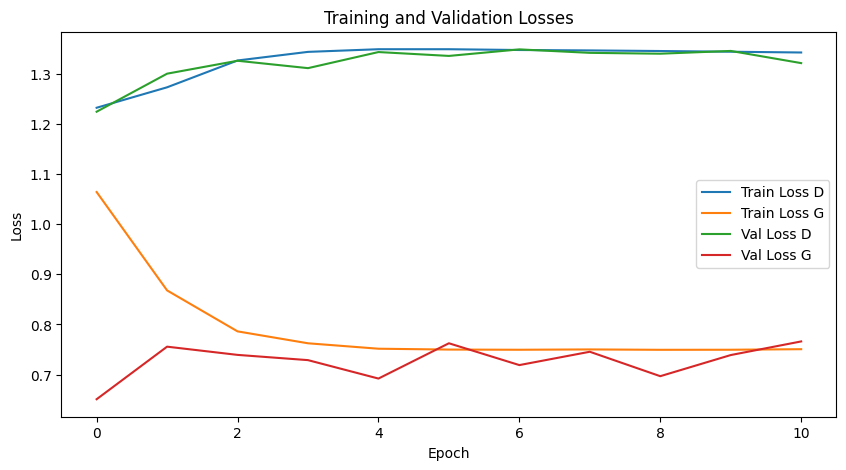

In [11]:
# Plot losses
train_loss_D, train_loss_G = zip(*train_losses)
val_loss_D, val_loss_G = zip(*val_losses)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_D, label="Train Loss D")
plt.plot(train_loss_G, label="Train Loss G")
plt.plot(val_loss_D, label="Val Loss D")
plt.plot(val_loss_G, label="Val Loss G")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Losses")
plt.savefig("gan_outputs/loss_plot.png")
plt.show()

In [12]:
# Load generator
G = Generator(z_dim=100).to(device)
G.load_state_dict(torch.load("gan_outputs/best_generator.pth"))
G.eval()

# Output directory
os.makedirs("gan_outputs/generated", exist_ok=True)

# Generate 10,000 images in batches
n_images = 10000
batch_size = 100
z_dim = 100

with torch.no_grad():
    for i in tqdm(range(0, n_images, batch_size)):
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = G(z)

        for j, img in enumerate(fake_imgs):
            idx = i + j
            save_path = f"gan_outputs/generated/img_{idx:05d}.png"
            save_image(img, save_path, normalize=True)


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<01:16,  1.29it/s]

  2%|▏         | 2/100 [00:01<00:53,  1.83it/s]

  3%|▎         | 3/100 [00:01<00:50,  1.92it/s]

  4%|▍         | 4/100 [00:01<00:40,  2.38it/s]

  5%|▌         | 5/100 [00:02<00:35,  2.69it/s]

  6%|▌         | 6/100 [00:02<00:31,  3.00it/s]

  7%|▋         | 7/100 [00:02<00:29,  3.15it/s]

  8%|▊         | 8/100 [00:03<00:31,  2.93it/s]

  9%|▉         | 9/100 [00:03<00:28,  3.17it/s]

 10%|█         | 10/100 [00:03<00:25,  3.47it/s]

 11%|█         | 11/100 [00:03<00:25,  3.54it/s]

 12%|█▏        | 12/100 [00:04<00:25,  3.41it/s]

 13%|█▎        | 13/100 [00:04<00:23,  3.63it/s]

 14%|█▍        | 14/100 [00:04<00:23,  3.67it/s]

 15%|█▌        | 15/100 [00:04<00:22,  3.78it/s]

 16%|█▌        | 16/100 [00:05<00:21,  3.90it/s]

 17%|█▋        | 17/100 [00:05<00:20,  3.97it/s]

 18%|█▊        | 18/100 [00:05<00:20,  3.97it/s]

 19%|█▉        | 19/100 [00:05<00:19,  4.07it/s]

 20%|██        | 20/100 [00:06<00:19,  4.16it/s]

 21%|██        | 21/100 [00:06<00:18,  4.20it/s]

 22%|██▏       | 22/100 [00:06<00:18,  4.31it/s]

 23%|██▎       | 23/100 [00:06<00:17,  4.34it/s]

 24%|██▍       | 24/100 [00:07<00:17,  4.40it/s]

 25%|██▌       | 25/100 [00:07<00:17,  4.35it/s]

 26%|██▌       | 26/100 [00:07<00:17,  4.33it/s]

 27%|██▋       | 27/100 [00:07<00:16,  4.37it/s]

 28%|██▊       | 28/100 [00:07<00:16,  4.42it/s]

 29%|██▉       | 29/100 [00:08<00:19,  3.73it/s]

 30%|███       | 30/100 [00:08<00:17,  3.95it/s]

 31%|███       | 31/100 [00:08<00:16,  4.10it/s]

 32%|███▏      | 32/100 [00:08<00:16,  4.19it/s]

 33%|███▎      | 33/100 [00:09<00:15,  4.25it/s]

 34%|███▍      | 34/100 [00:09<00:15,  4.25it/s]

 35%|███▌      | 35/100 [00:09<00:14,  4.39it/s]

 36%|███▌      | 36/100 [00:09<00:14,  4.45it/s]

 37%|███▋      | 37/100 [00:10<00:13,  4.53it/s]

 38%|███▊      | 38/100 [00:10<00:13,  4.55it/s]

 39%|███▉      | 39/100 [00:10<00:13,  4.60it/s]

 40%|████      | 40/100 [00:10<00:17,  3.52it/s]

 41%|████      | 41/100 [00:11<00:15,  3.76it/s]

 42%|████▏     | 42/100 [00:11<00:14,  3.89it/s]

 43%|████▎     | 43/100 [00:11<00:13,  4.08it/s]

 44%|████▍     | 44/100 [00:11<00:13,  4.20it/s]

 45%|████▌     | 45/100 [00:12<00:12,  4.35it/s]

 46%|████▌     | 46/100 [00:12<00:12,  4.42it/s]

 47%|████▋     | 47/100 [00:12<00:11,  4.49it/s]

 48%|████▊     | 48/100 [00:12<00:11,  4.55it/s]

 49%|████▉     | 49/100 [00:12<00:11,  4.54it/s]

 50%|█████     | 50/100 [00:13<00:10,  4.59it/s]

 51%|█████     | 51/100 [00:13<00:13,  3.66it/s]

 52%|█████▏    | 52/100 [00:13<00:12,  3.83it/s]

 53%|█████▎    | 53/100 [00:14<00:11,  3.93it/s]

 54%|█████▍    | 54/100 [00:14<00:11,  4.06it/s]

 55%|█████▌    | 55/100 [00:14<00:10,  4.17it/s]

 56%|█████▌    | 56/100 [00:14<00:10,  4.27it/s]

 57%|█████▋    | 57/100 [00:14<00:09,  4.30it/s]

 58%|█████▊    | 58/100 [00:15<00:09,  4.37it/s]

 59%|█████▉    | 59/100 [00:15<00:09,  4.38it/s]

 60%|██████    | 60/100 [00:15<00:09,  4.43it/s]

 61%|██████    | 61/100 [00:15<00:08,  4.48it/s]

 62%|██████▏   | 62/100 [00:16<00:08,  4.53it/s]

 63%|██████▎   | 63/100 [00:16<00:10,  3.47it/s]

 64%|██████▍   | 64/100 [00:16<00:09,  3.71it/s]

 65%|██████▌   | 65/100 [00:16<00:08,  3.91it/s]

 66%|██████▌   | 66/100 [00:17<00:08,  4.07it/s]

 67%|██████▋   | 67/100 [00:17<00:07,  4.13it/s]

 68%|██████▊   | 68/100 [00:17<00:07,  4.22it/s]

 69%|██████▉   | 69/100 [00:17<00:07,  4.26it/s]

 70%|███████   | 70/100 [00:18<00:06,  4.33it/s]

 71%|███████   | 71/100 [00:18<00:06,  4.29it/s]

 72%|███████▏  | 72/100 [00:18<00:06,  4.35it/s]

 73%|███████▎  | 73/100 [00:18<00:06,  4.39it/s]

 74%|███████▍  | 74/100 [00:18<00:05,  4.42it/s]

 75%|███████▌  | 75/100 [00:19<00:05,  4.45it/s]

 76%|███████▌  | 76/100 [00:19<00:05,  4.44it/s]

 77%|███████▋  | 77/100 [00:19<00:05,  4.49it/s]

 78%|███████▊  | 78/100 [00:19<00:04,  4.52it/s]

 79%|███████▉  | 79/100 [00:20<00:04,  4.27it/s]

 80%|████████  | 80/100 [00:20<00:04,  4.36it/s]

 81%|████████  | 81/100 [00:20<00:04,  4.46it/s]

 82%|████████▏ | 82/100 [00:20<00:03,  4.52it/s]

 83%|████████▎ | 83/100 [00:20<00:03,  4.55it/s]

 84%|████████▍ | 84/100 [00:21<00:03,  4.61it/s]

 85%|████████▌ | 85/100 [00:21<00:03,  4.58it/s]

 86%|████████▌ | 86/100 [00:21<00:03,  4.60it/s]

 87%|████████▋ | 87/100 [00:21<00:02,  4.64it/s]

 88%|████████▊ | 88/100 [00:22<00:02,  4.68it/s]

 89%|████████▉ | 89/100 [00:22<00:02,  4.66it/s]

 90%|█████████ | 90/100 [00:22<00:02,  4.61it/s]

 91%|█████████ | 91/100 [00:22<00:01,  4.62it/s]

 92%|█████████▏| 92/100 [00:22<00:01,  4.61it/s]

 93%|█████████▎| 93/100 [00:23<00:01,  4.64it/s]

 94%|█████████▍| 94/100 [00:23<00:01,  4.64it/s]

 95%|█████████▌| 95/100 [00:23<00:01,  4.58it/s]

 96%|█████████▌| 96/100 [00:23<00:00,  4.60it/s]

 97%|█████████▋| 97/100 [00:24<00:00,  4.48it/s]

 98%|█████████▊| 98/100 [00:24<00:00,  4.52it/s]

 99%|█████████▉| 99/100 [00:24<00:00,  4.51it/s]

100%|██████████| 100/100 [00:24<00:00,  4.21it/s]

100%|██████████| 100/100 [00:24<00:00,  4.04it/s]

In [13]:
# Load real images
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(root="celebA", transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Load generator
G = Generator(z_dim=100).to(device)
G.load_state_dict(torch.load("gan_outputs/best_generator.pth"))
G.eval()

# Function to find z that reconstructs a real image
def invert_image(real_img, generator, z_dim=100, steps=300, lr=0.1):
    z = torch.randn(1, z_dim, 1, 1, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([z], lr=lr)
    target = real_img.to(device)

    for _ in range(steps):
        optimizer.zero_grad()
        generated = generator(z)
        loss = F.mse_loss(generated, target)
        loss.backward()
        optimizer.step()

    return z.detach()

# Invert latent codes from real images
real_z_vectors = []
os.makedirs("gan_outputs/improved_generated", exist_ok=True)

for i, (img, _) in enumerate(loader):
    if i >= 20:
        break
    z_optimized = invert_image(img, G, z_dim=100)
    real_z_vectors.append(z_optimized)

# Interpolate between consecutive real-image latent vectors
steps = 10
with torch.no_grad():
    for i in range(len(real_z_vectors) - 1):
        z1 = real_z_vectors[i]
        z2 = real_z_vectors[i + 1]
        for j, alpha in enumerate(torch.linspace(0, 1, steps)):
            z_interp = torch.lerp(z1, z2, alpha)
            img = G(z_interp).squeeze(0)
            save_path = f"gan_outputs/improved_generated/pair_{i:02d}_step_{j:02d}.png"
            save_image(img, save_path, normalize=True)
